# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/14rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/15rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/16rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/14rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/15rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/16rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.323270        0.200792  0.050435  0.298915  0.017996   
       0.25   0.304545        0.196101  0.051583  0.259418  0.068024   
       0.50   0.293490        0.197943  0.064479  0.234536  0.096649   
       0.75   0.293760        0.181472  0.073389  0.189746  0.117242   
       1.00   0.312714        0.172955  0.076043  0.174303  0.145953   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201447  0.009249  0.040422  0.048604  0.000000  
       0.25  0.206267  0.010299  0.041466  0.048932  0.000521  
       0.50  0.190710  0.009649  0.040983  0.049320  0.001492  
       0.75  0.200268  0.007965  0.034687  0.048115  0.002483  
       1.00  0.200571  0.007439  0.039626  0.049723  0.003489

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295315        0.203393  0.049610  0.292473  0.020236   
       0.25   0.304325        0.199437  0.056394  0.256506  0.066704   
       0.50   0.310393        0.180669  0.061755  0.207765  0.101113   
       0.75   0.286473        0.169643  0.063834  0.182014  0.121428   
       1.00   0.327291        0.167648  0.080639  0.177326  0.132740   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.182364  0.009452  0.037824  0.049237  0.000000  
       0.25  0.206057  0.009817  0.043107  0.051208  0.000576  
       0.50  0.181917  0.008689  0.042067  0.052952  0.001588  
       0.75  0.196835  0.008096  0.037195  0.047392  0.002817  
       1.00  0.218232  0.006660  0.036462  0.048643  0.004028

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.301919        0.184715  0.048514  0.300995  0.018765   
       0.25   0.295775        0.200791  0.052227  0.238590  0.067467   
       0.50   0.308329        0.189150  0.062230  0.238051  0.102937   
       0.75   0.292882        0.160581  0.073207  0.209592  0.123956   
       1.00   0.307566        0.169026  0.070934  0.188766  0.138183   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193786  0.009556  0.040998  0.048033  0.000000  
       0.25  0.218912  0.009763  0.037017  0.046846  0.000649  
       0.50  0.207158  0.009325  0.038161  0.049611  0.001467  
       0.75  0.207389  0.008191  0.036073  0.046433  0.002465  
       1.00  0.219518  0.007512  0.035744  0.050760  0.003692

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.306835        0.196300  0.049520  0.297461  0.018999   
         0.25   0.297295        0.197849  0.055988  0.250469  0.068398   
         0.50   0.292495        0.187801  0.069633  0.225384  0.101600   
         0.75   0.272125        0.168785  0.081125  0.192689  0.122388   
         1.00   0.286510        0.167587  0.089382  0.180670  0.140800   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.192532  0.009419  0.039748  0.048625  0.000000  
         0.25  0.210409  0.009964  0.040530  0.049189  0.000383  
         0.50  0.193251  0.009243  0.040402  0.051150  0.001001  
         0.75  0.201464  0.008145  0.035976  0.048149  0.001716  
         1.00  0.212690  0.007334  0.037243  0.050990  0.002488

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.082450e+01  3.899512e+01      36.613773  5.713511e+01   
         0.25  4.623589e+06  2.294647e+06  219616.822399  1.384614e+06   
         0.50  5.413871e+06  3.522874e+06  331075.210595  2.208463e+06   
         0.75  6.027501e+06  4.276124e+06  425326.578119  2.527476e+06   
         1.00  6.063303e+06  4.350573e+06  454508.664109  3.138185e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      25.267722  5.244708e+01  5.224924e+01      18.570128   
         0.25  473817.229448  2.259331e+06  2.735048e+06  431494.198134   
         0.50  741116.993421  3.872225e+06  3.293242e+06  616722.782670   
         0.75  817806.196468  4.862051e+06  3.478237e+06  770881.423191   
         1.00  978987.234359  5.304373e+06  3.736293e+06  833744.174216   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.506563  
         0.25     186542.284533  
         0.50     286414.752383  
         0.75     351941.057897  
         1.00     411111.976360

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


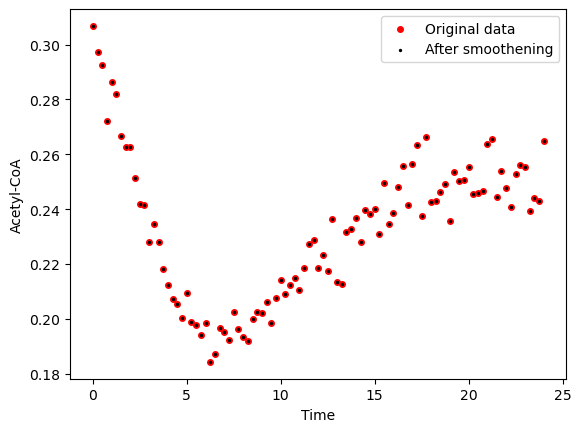

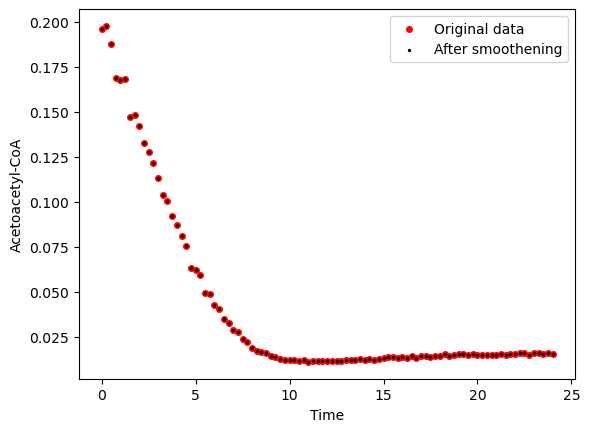

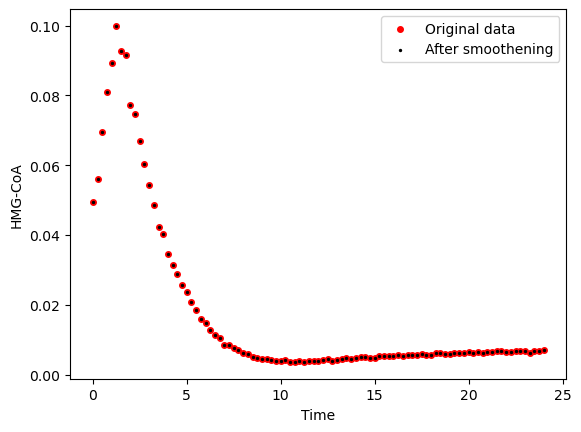

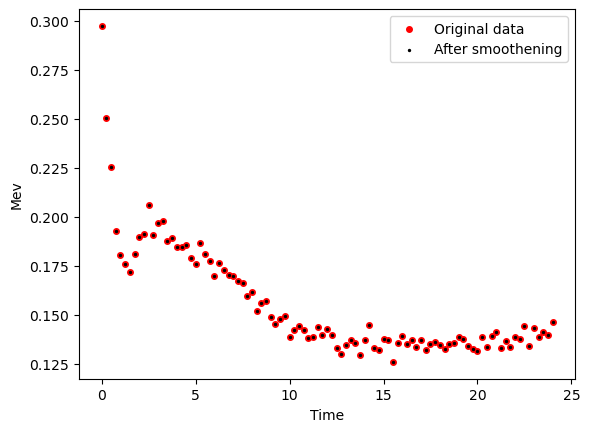

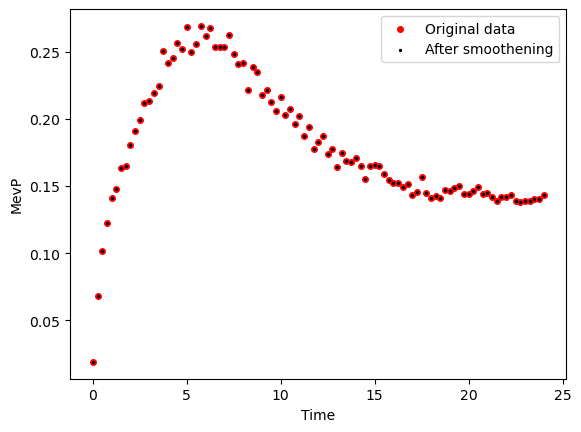

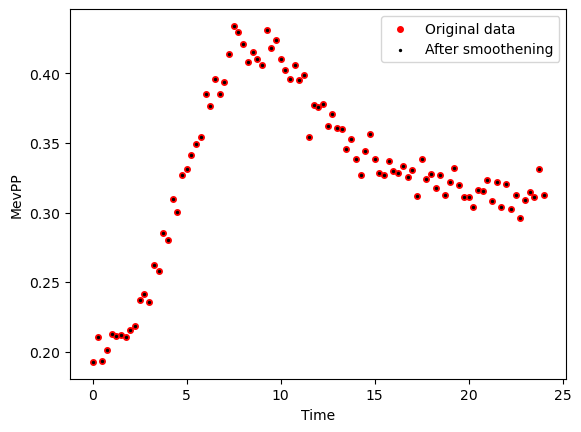

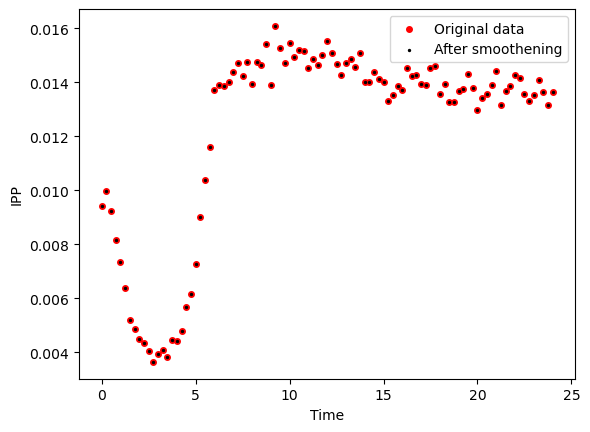

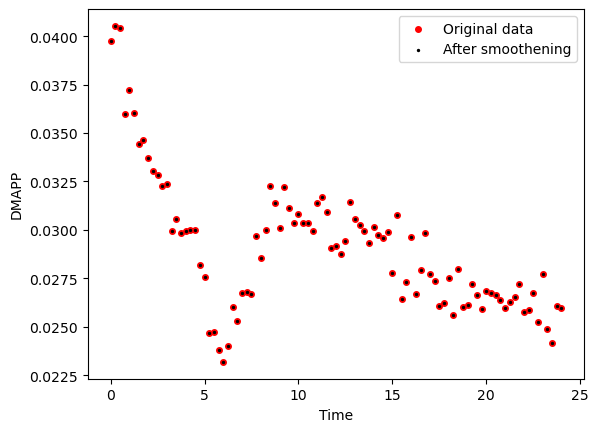

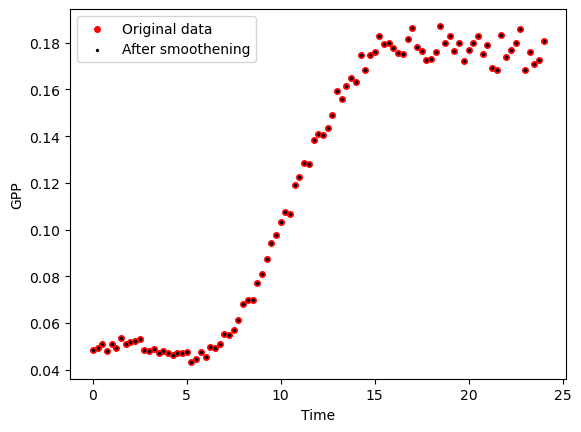

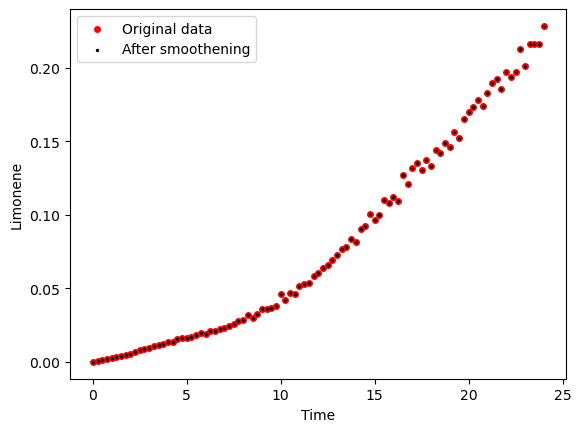

Strain Strain 2


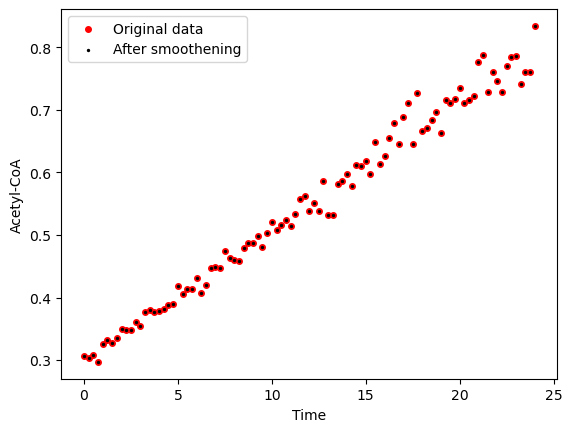

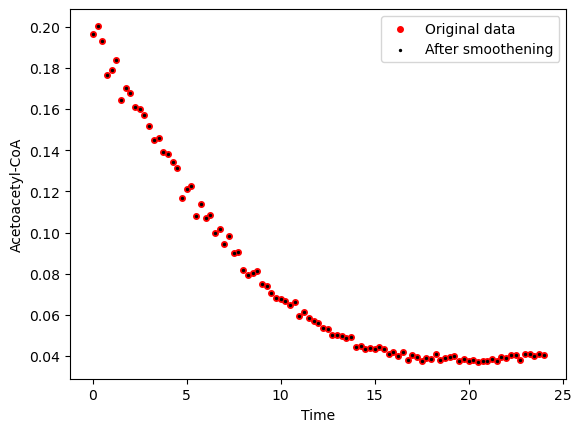

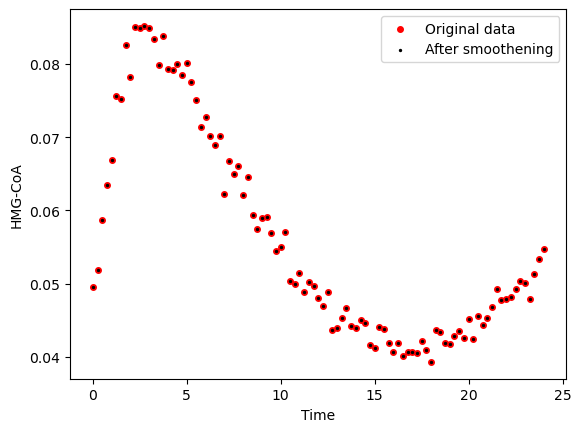

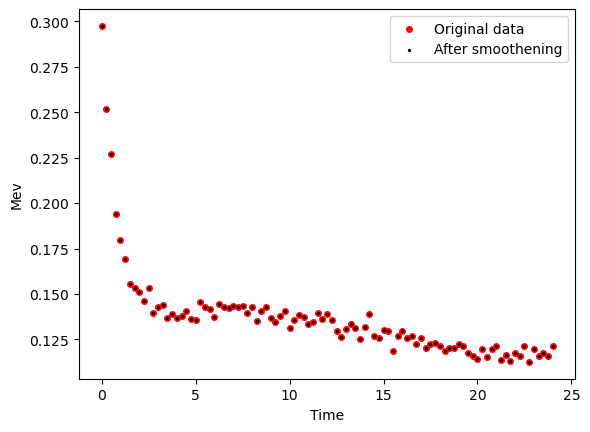

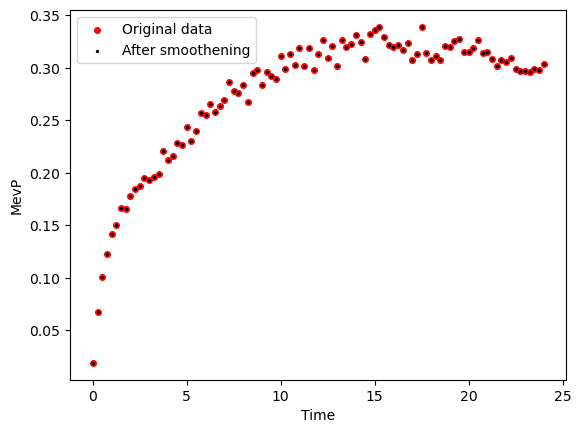

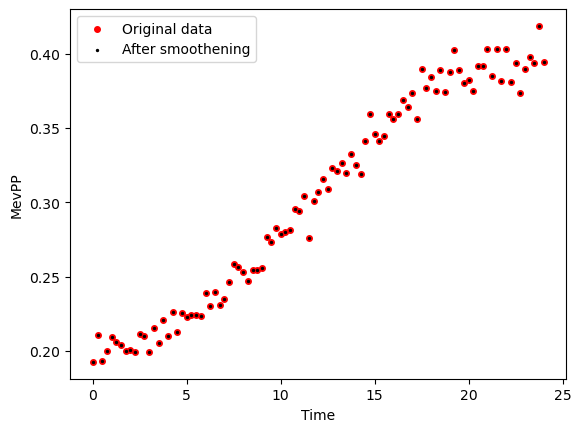

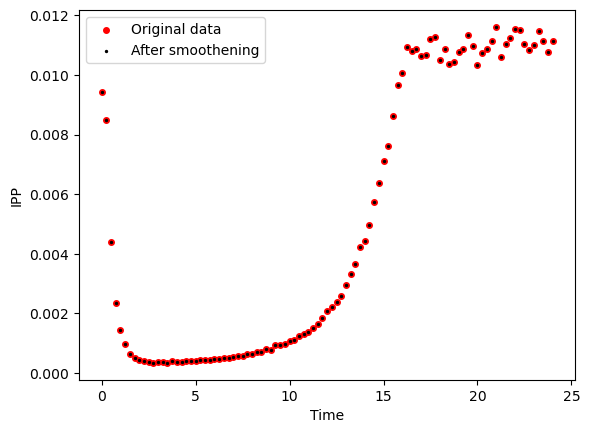

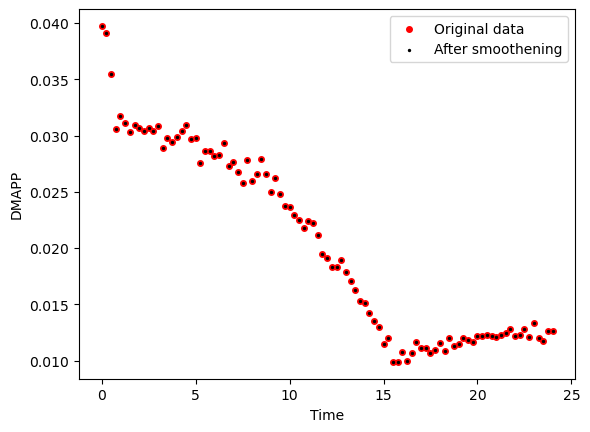

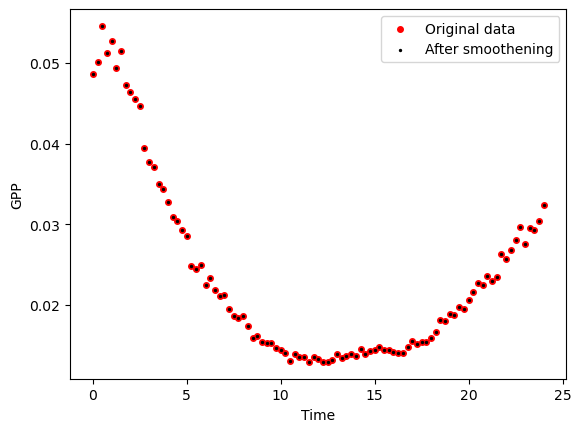

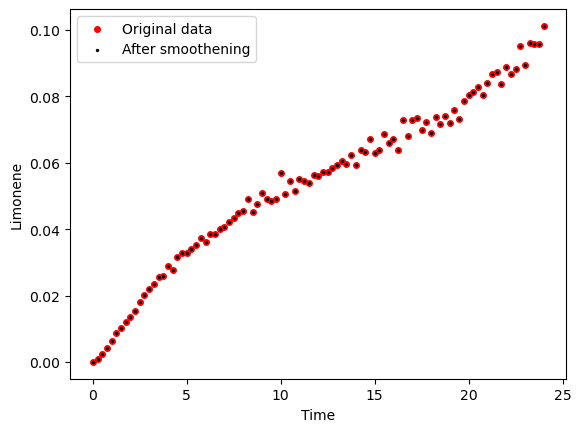

Strain Strain 3


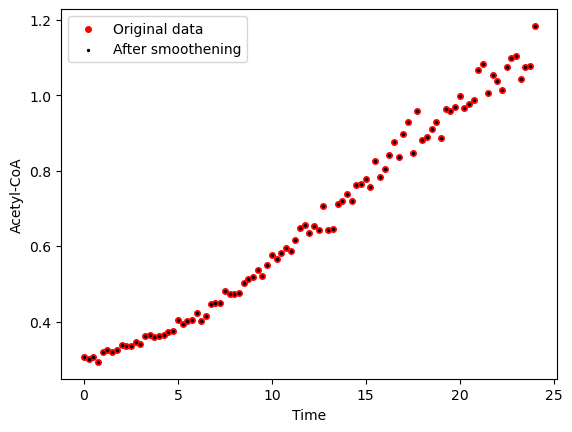

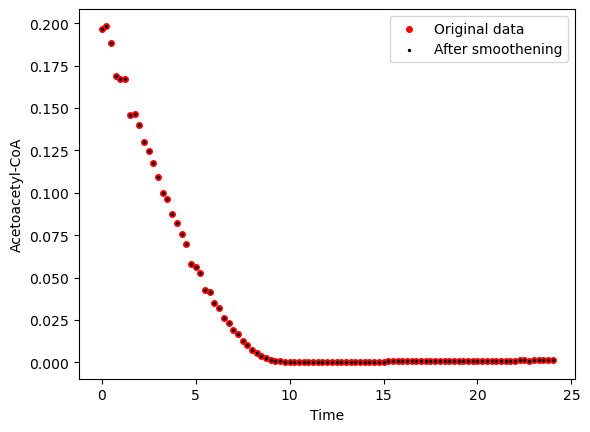

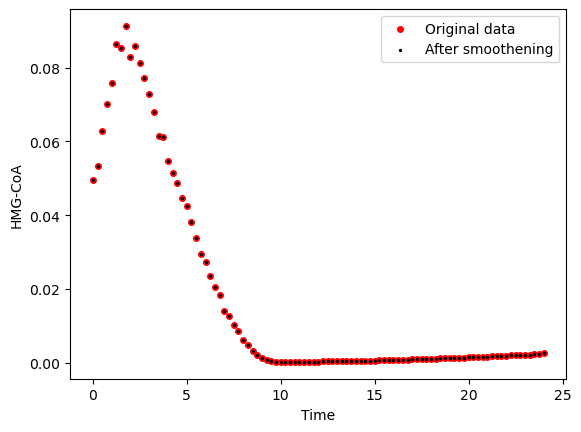

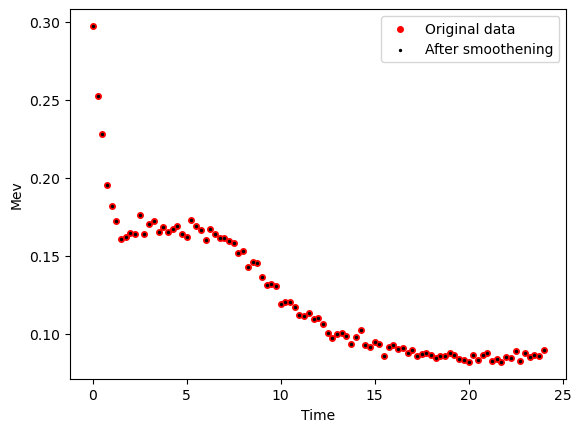

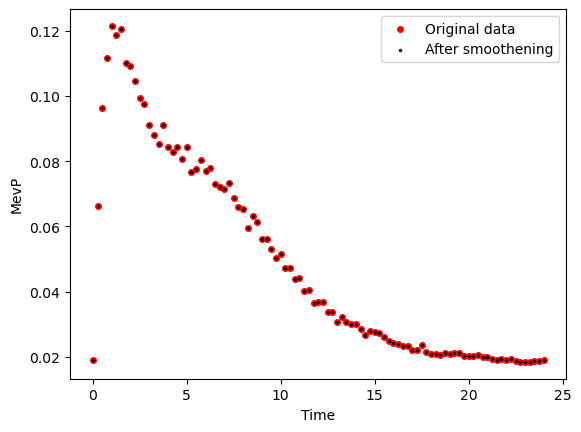

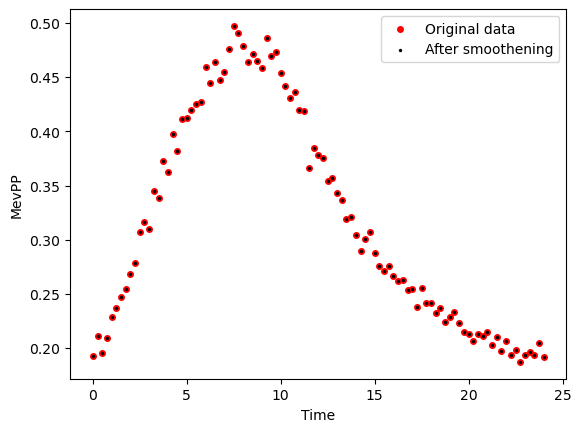

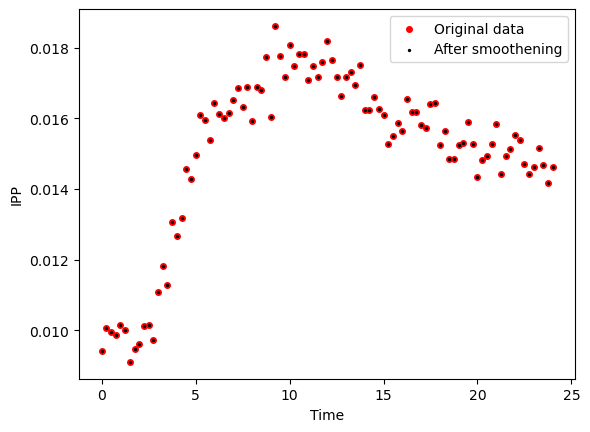

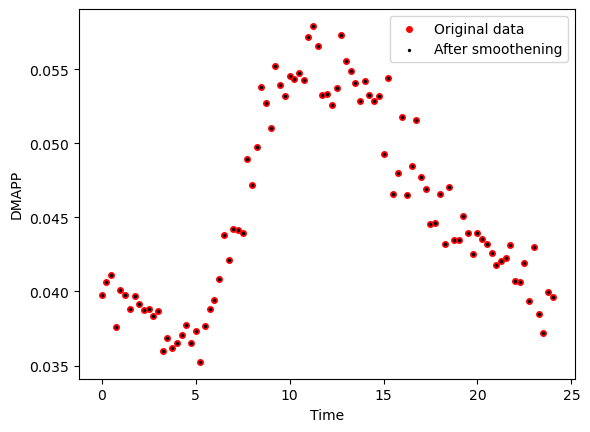

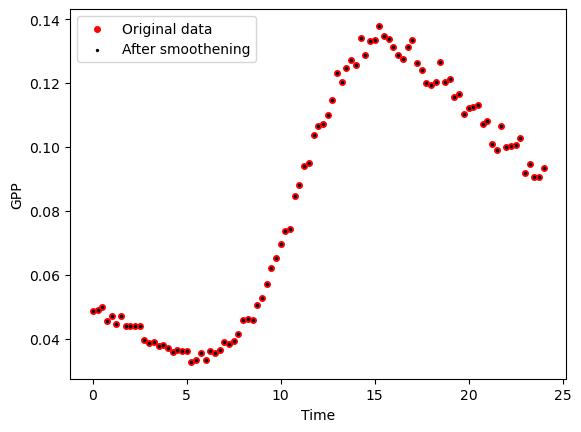

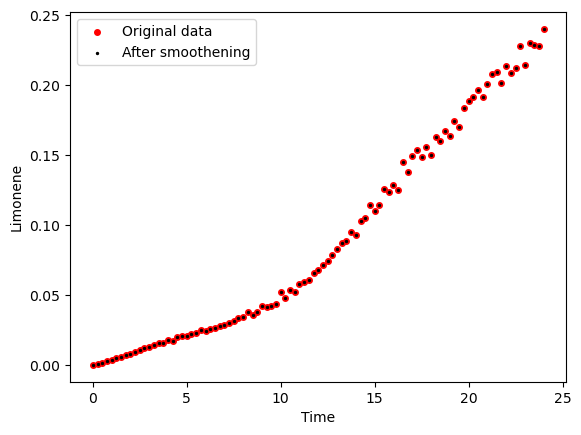

Strain WT


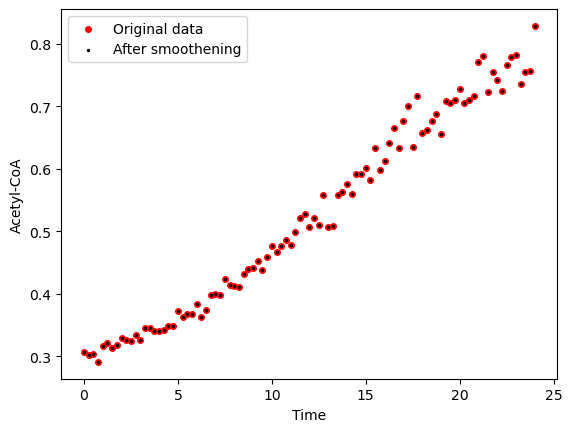

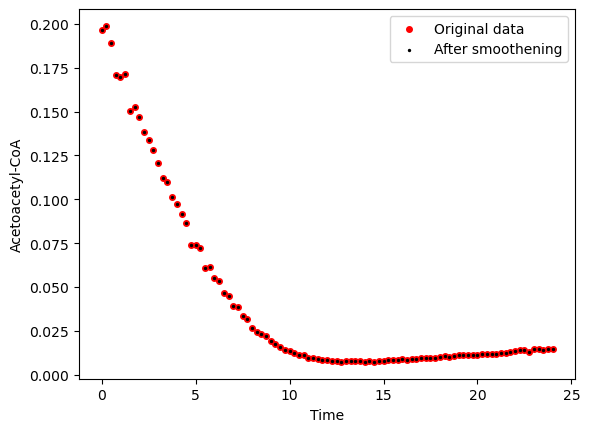

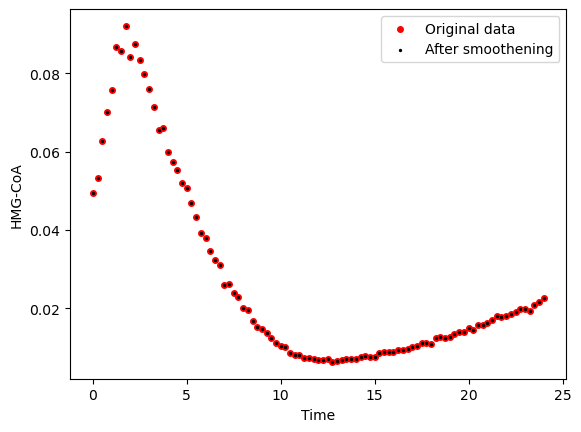

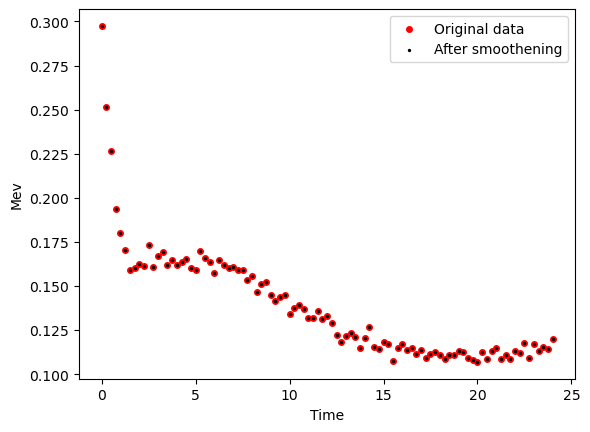

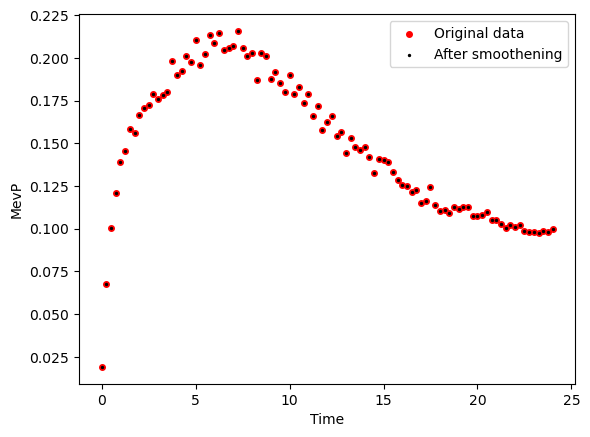

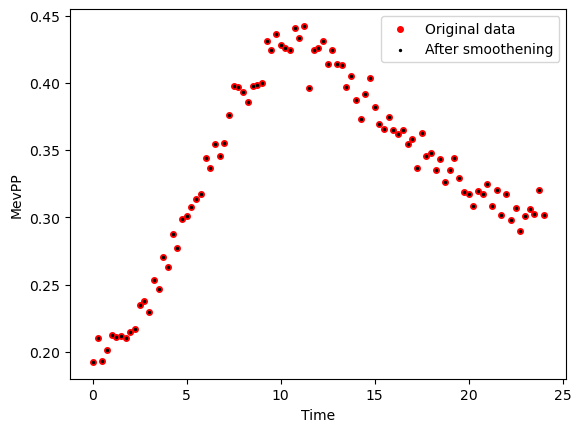

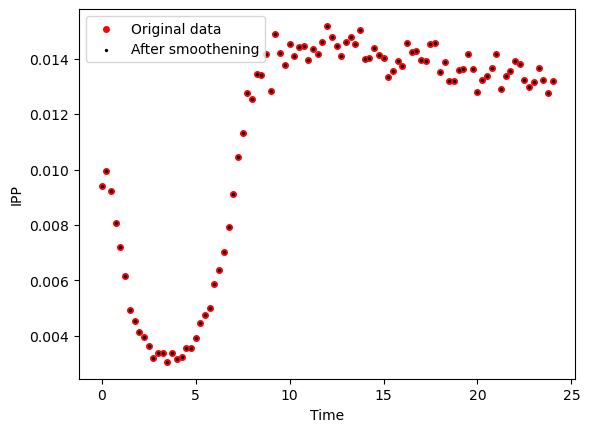

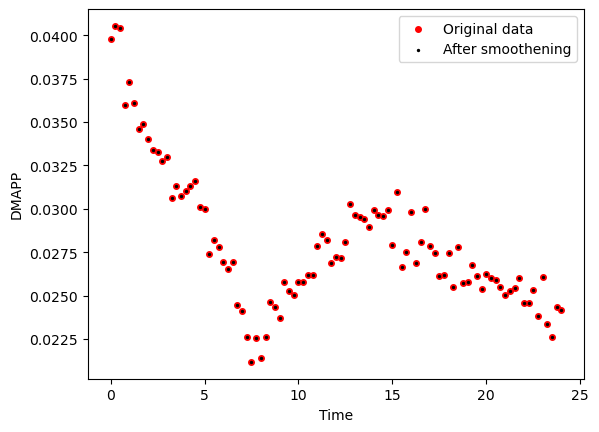

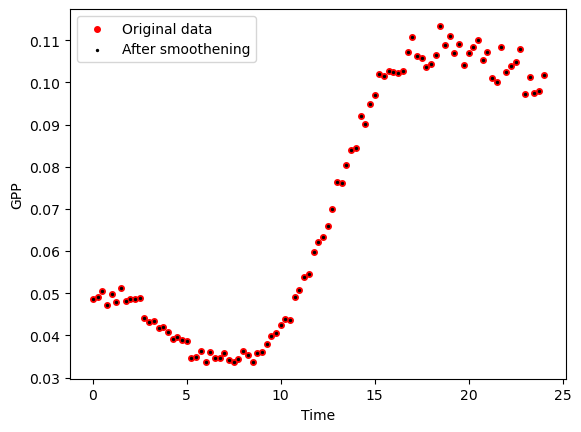

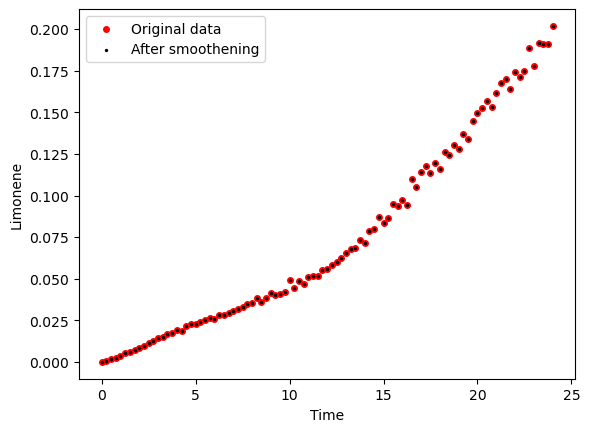

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


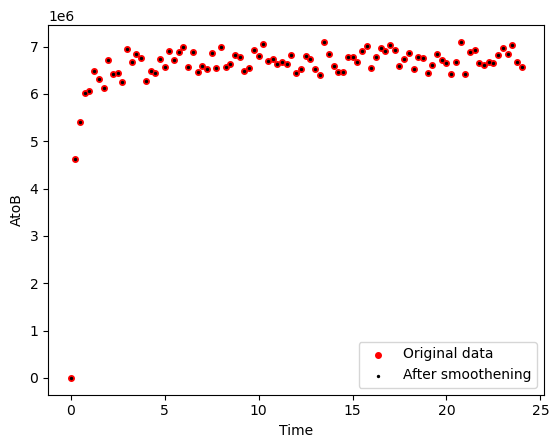

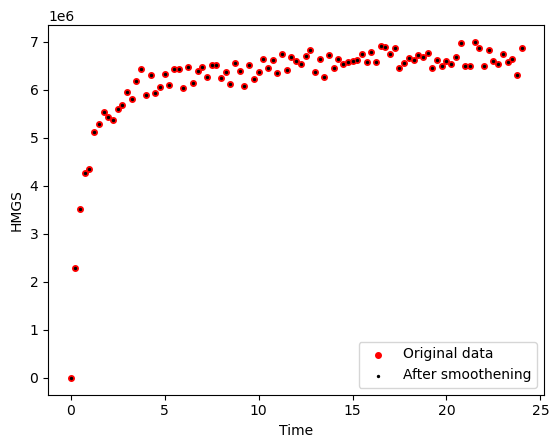

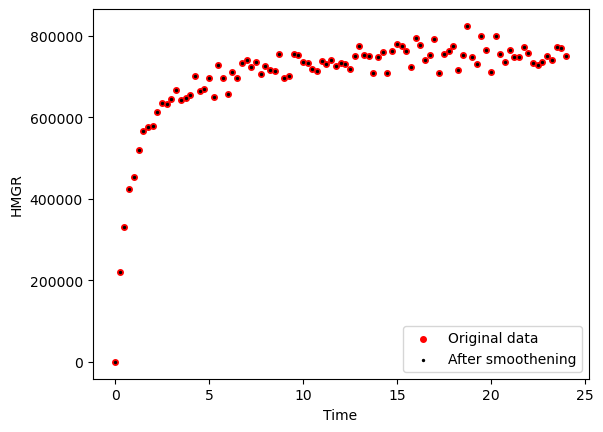

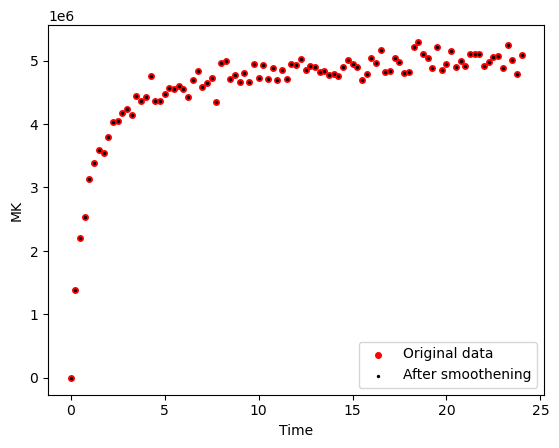

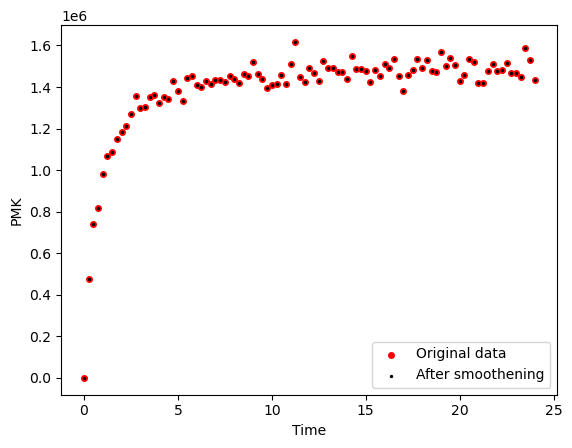

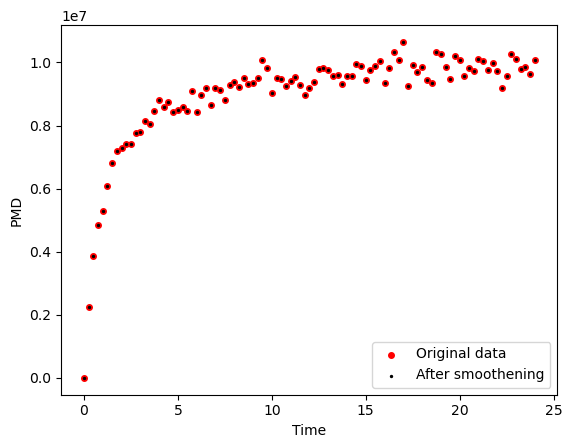

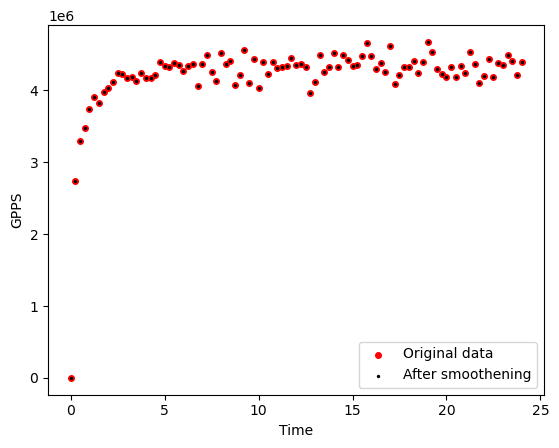

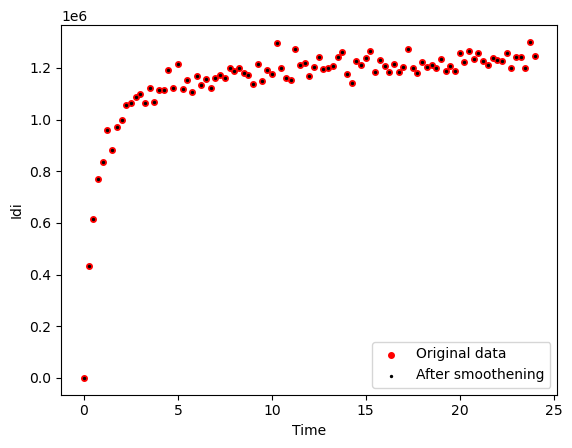

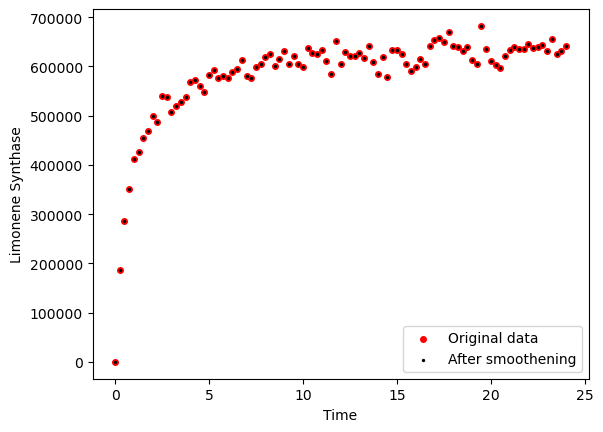

Strain Strain 2


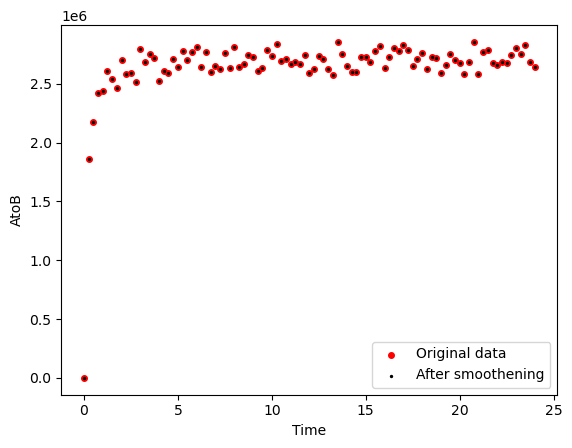

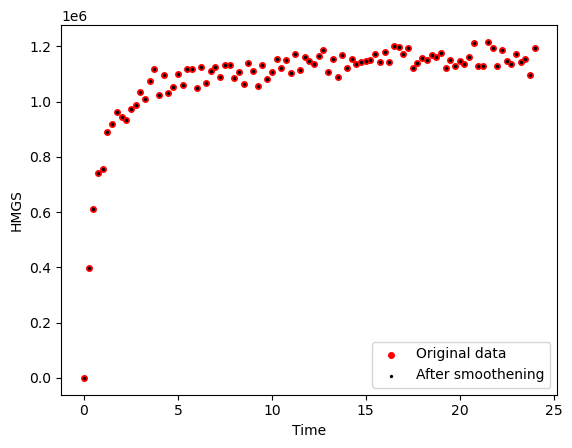

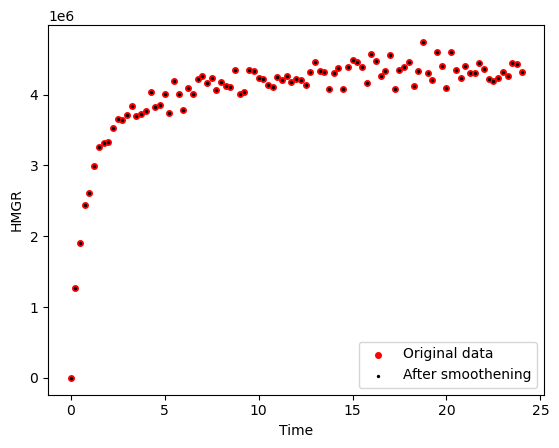

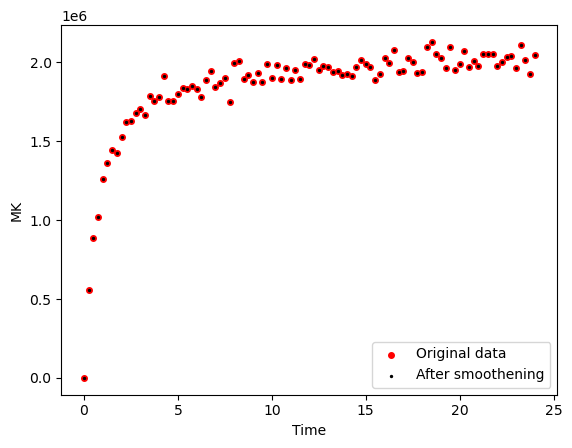

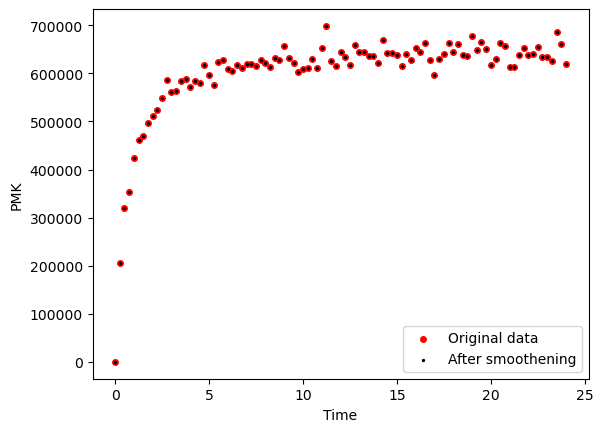

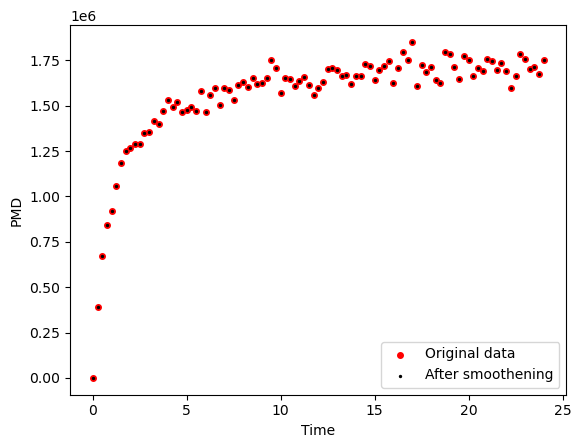

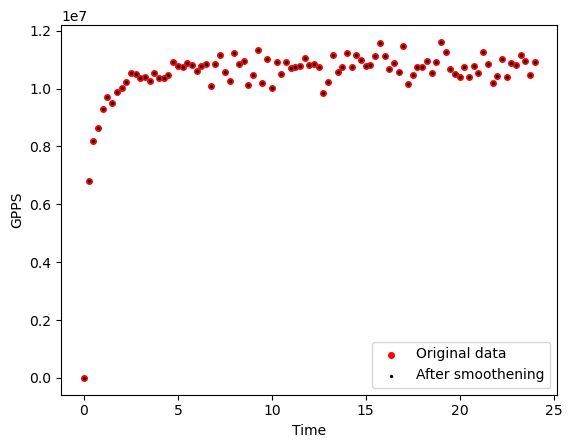

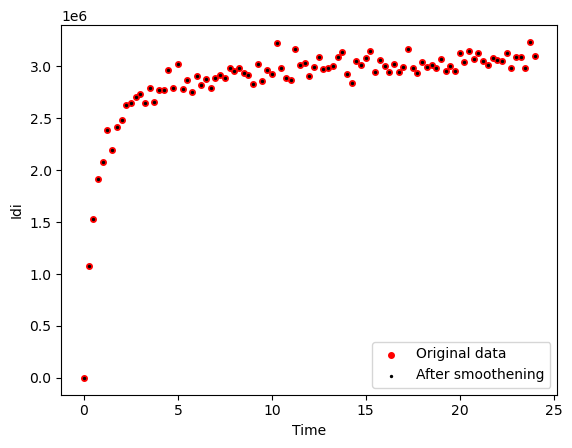

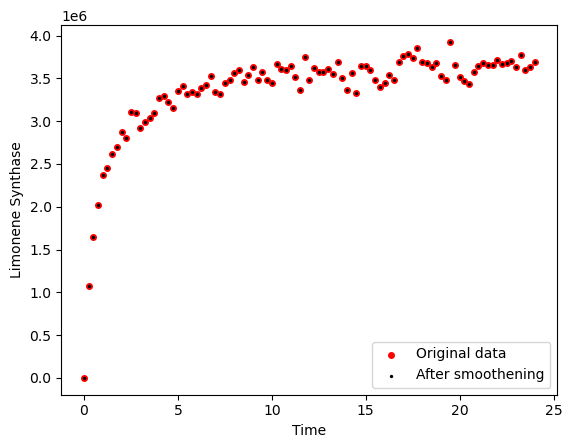

Strain Strain 3


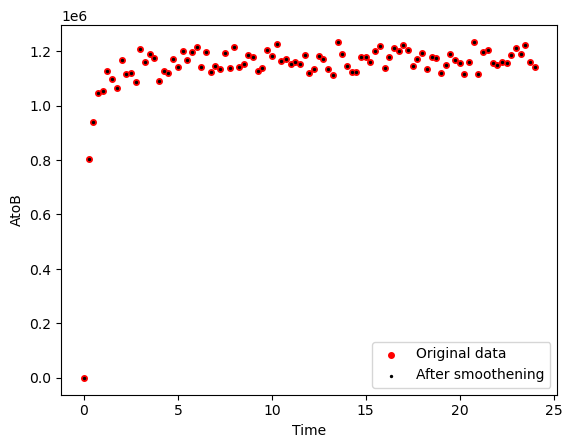

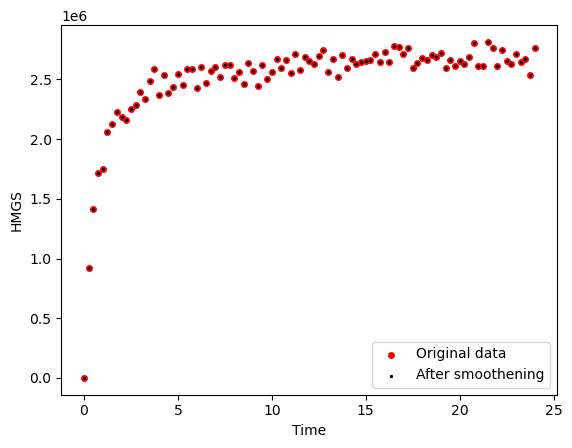

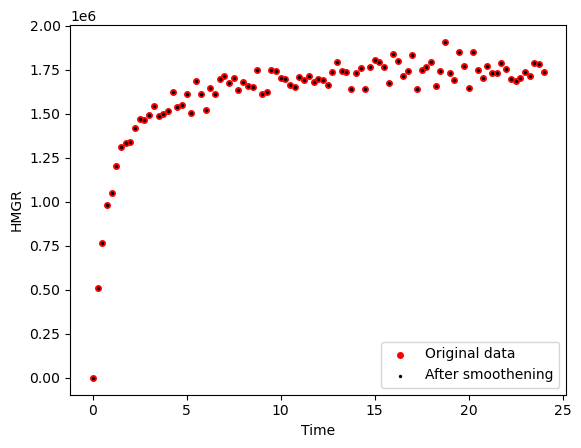

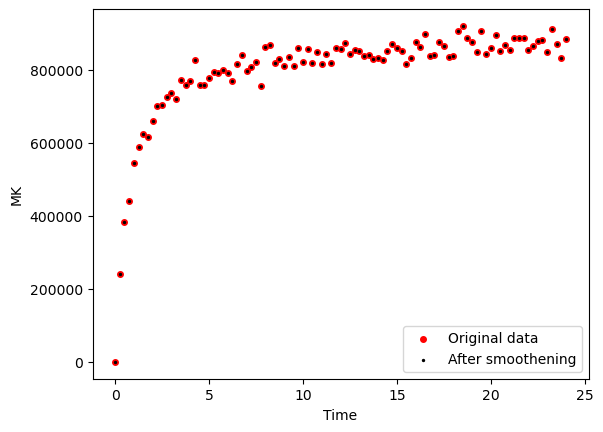

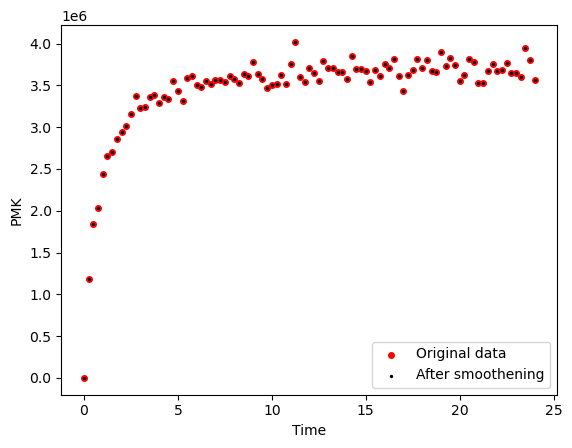

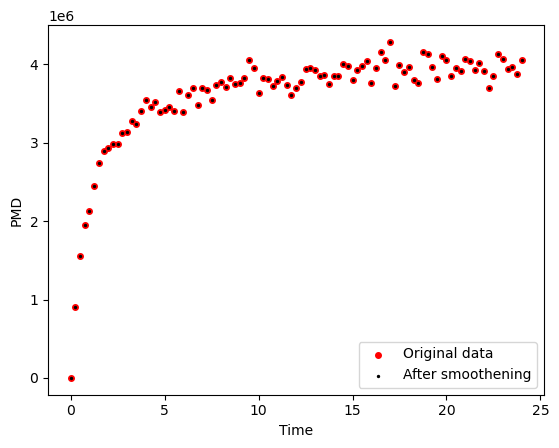

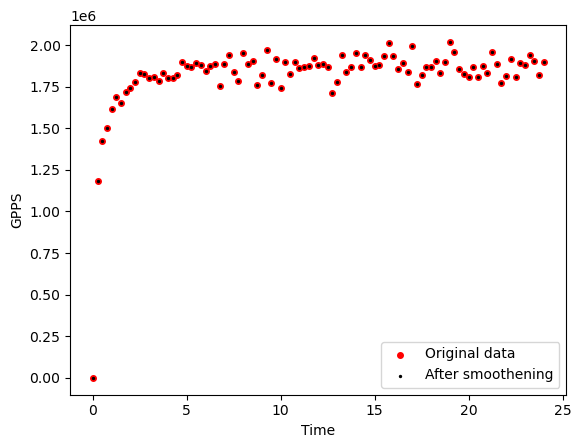

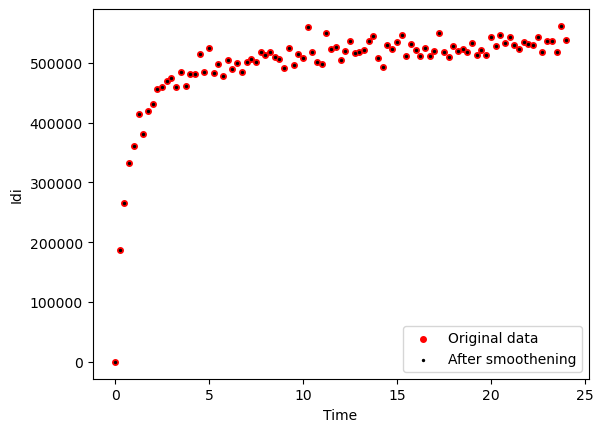

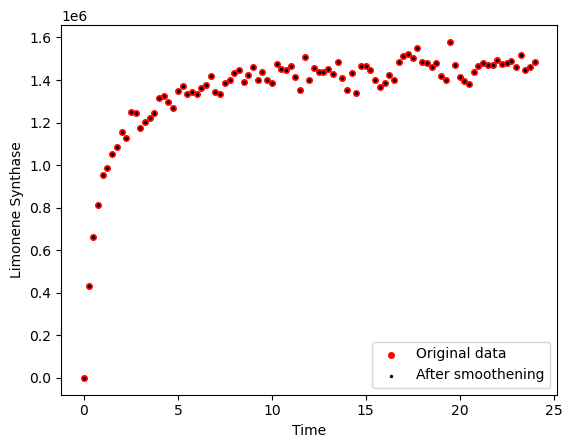

Strain WT


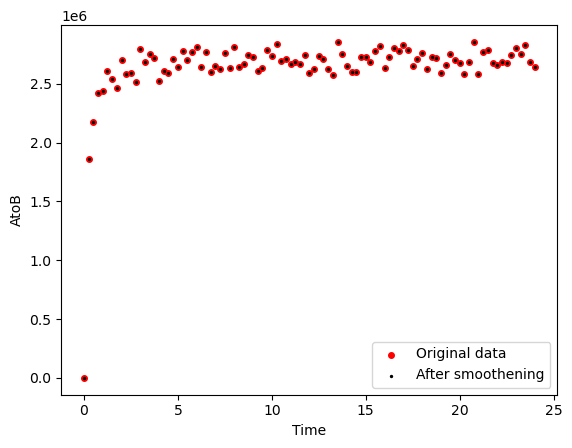

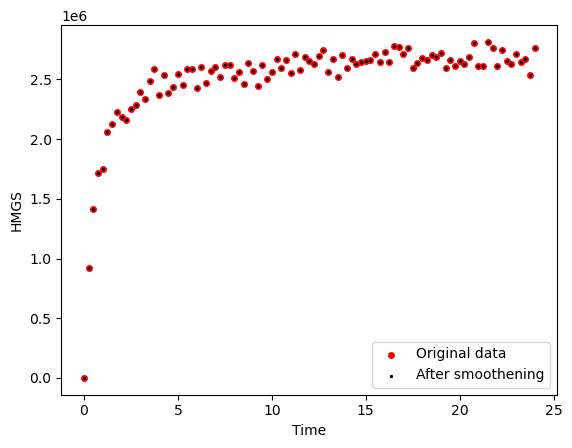

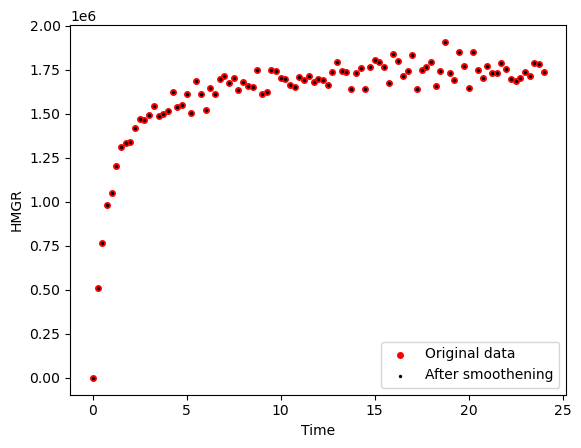

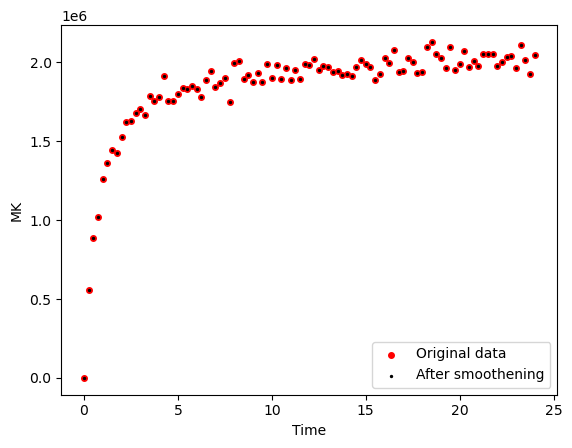

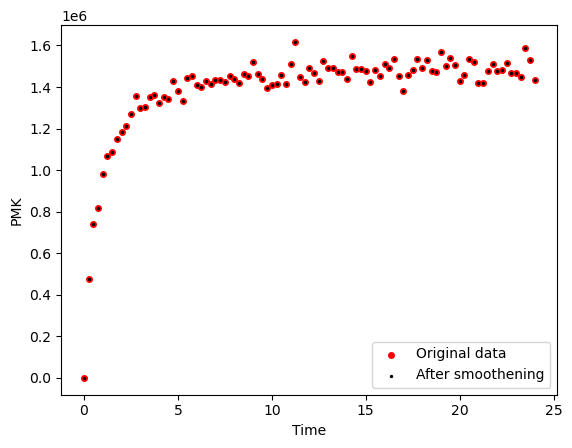

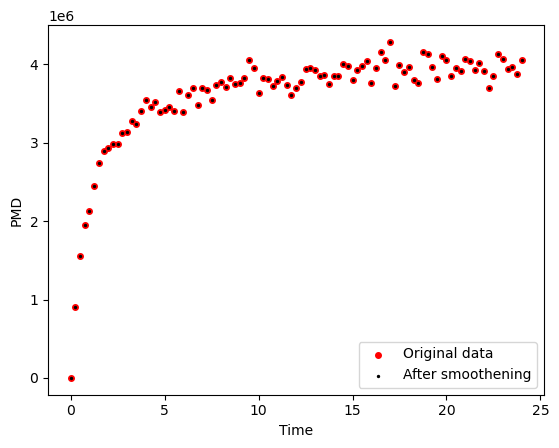

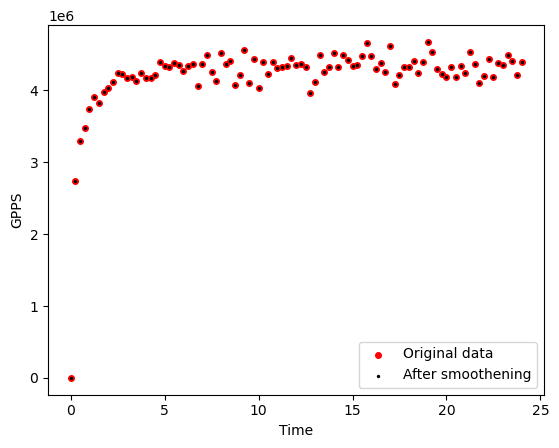

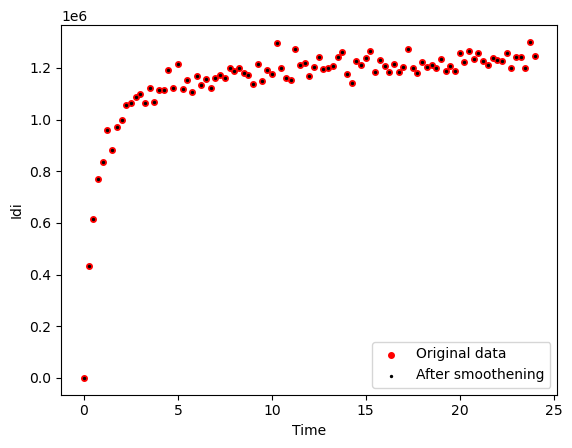

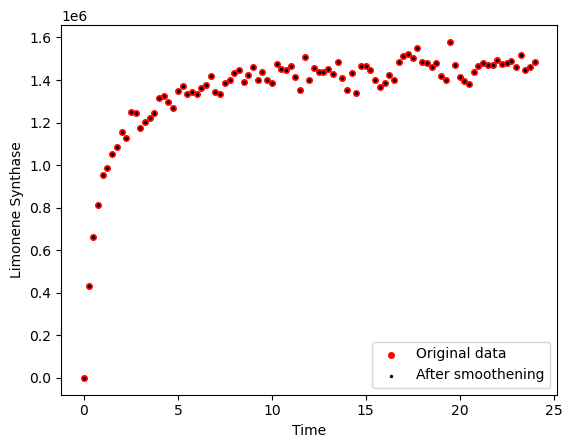

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.306835        0.196300  0.049520  0.297461  0.018999   
         0.25    0.297295        0.197849  0.055988  0.250469  0.068398   
         0.50    0.292495        0.187801  0.069633  0.225384  0.101600   
         0.75    0.272125        0.168785  0.081125  0.192689  0.122388   
         1.00    0.286510        0.167587  0.089382  0.180670  0.140800   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.781785        0.014512  0.019834  0.116885  0.097919   
         23.25   0.736414        0.014641  0.019183  0.113084  0.097356   
         23.50   0.755956        0.014301  0.020733  0.115384  0.098481   
         23.75   0.756040        0.014851  0.021714  0.114108  0.098150   
         24.00   0.828982        0.014775  0.022484  0.119714  0.099920   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.192532  0.009419  0.039748  0.048625  0.000000  ...   
         0.25   0.210409  0.009964  0.040530  0.049189  0.000383  ...   
         0.50   0.193251  0.009243  0.040402  0.051150  0.001001  ...   
         0.75   0.201464  0.008145  0.035976  0.048149  0.001716  ...   
         1.00   0.212690  0.007334  0.037243  0.050990  0.002488  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.301282  0.013141  0.026095  0.097143  0.177783  ...   
         23.25  0.306234  0.013655  0.023374  0.101186  0.191477  ...   
         23.50  0.302331  0.013217  0.022635  0.097504  0.190979  ...   
         23.75  0.320655  0.012756  0.024330  0.098015  0.191292  ...   
         24.00  0.301530  0.013180  0.024171  0.101851  0.201921  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.063218       -0.018066  0.040316 -0.187786  0.204053   
         0.25    -0.044773       -0.026331  0.041130 -0.152165  0.161545   
         0.50    -0.026328       -0.034596  0.041945 -0.116545  0.119037   
         0.75    -0.014672       -0.031585  0.043041 -0.077583  0.079276   
         1.00    -0.016664       -0.032512  0.026032 -0.049588  0.059743   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.024849        0.000823  0.001125 -0.000379 -0.000179   
         23.25   -0.028841        0.001194  0.001965  0.003149  0.000531   
         23.50    0.045608        0.000295  0.003132  0.002674  0.001919   
         23.75    0.169703        0.000567  0.004431  0.011381  0.003753   
         24.00    0.293799        0.000840  0.005731  0.020089  0.005587   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001246  0.001136 -0.000023  0.001942  0.001526  
         0.25   0.005651 -0.000630 -0.001924  0.001709  0.002025  
         0.50   0.012548 -0.002396 -0.003826  0.001476  0.002523  
         0.75   0.008458 -0.003624 -0.004865  0.000184  0.003040  
         1.00   0.018771 -0.003947 -0.004751  0.002370  0.003185  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002996  0.000274 -0.002350 -0.008681  0.014326  
         23.25  0.024923 -0.000133 -0.000987 -0.007820  0.007468  
         23.50  0.005967 -0.000329 -0.001157  0.002498  0.019237  
         23.75 -0.008848 -0.000445  0.003163  0.004658  0.016197  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

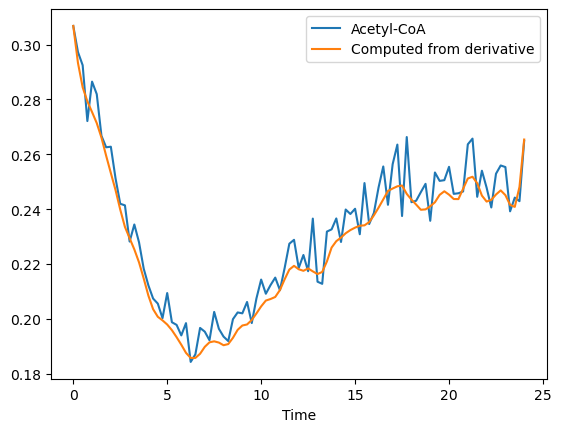

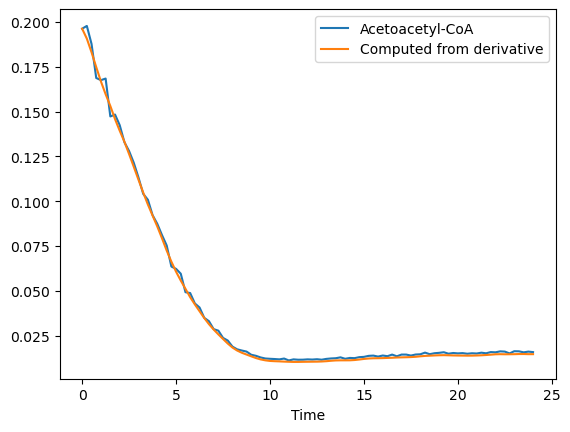

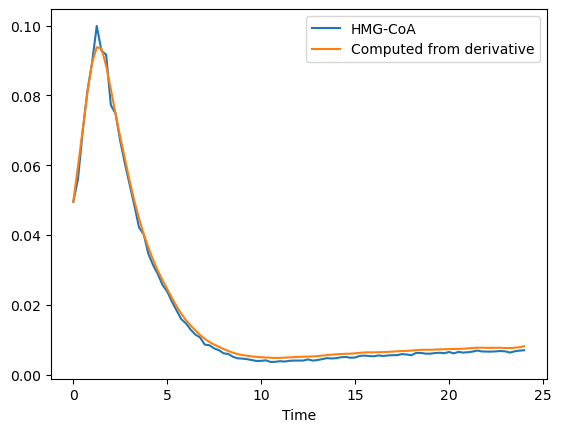

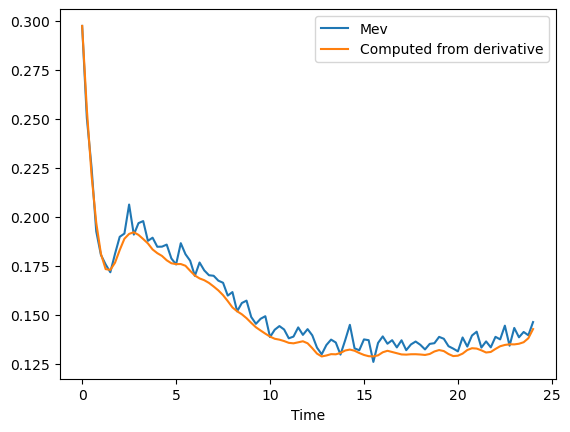

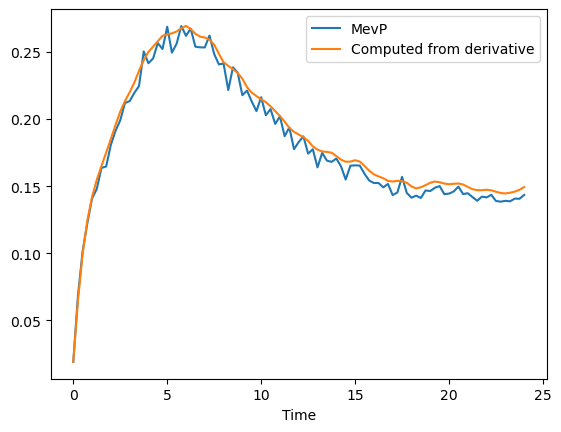

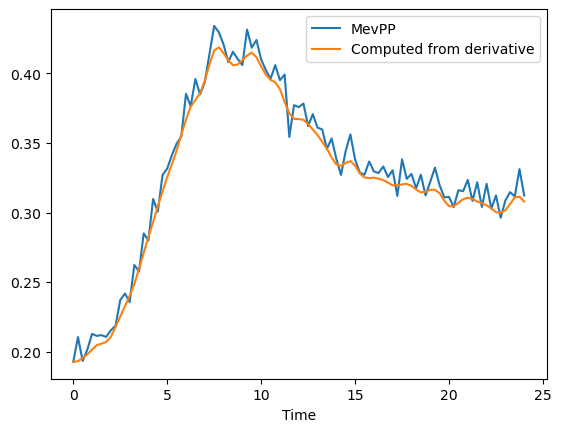

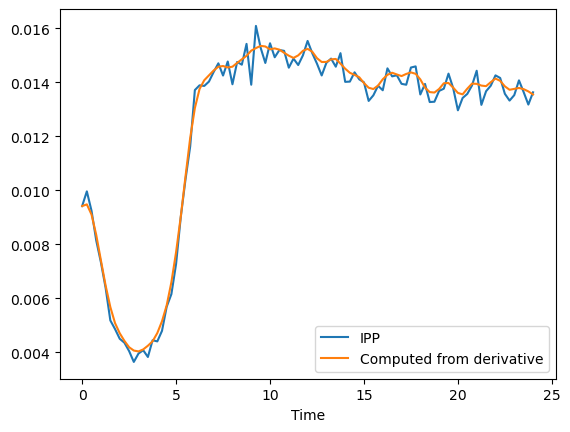

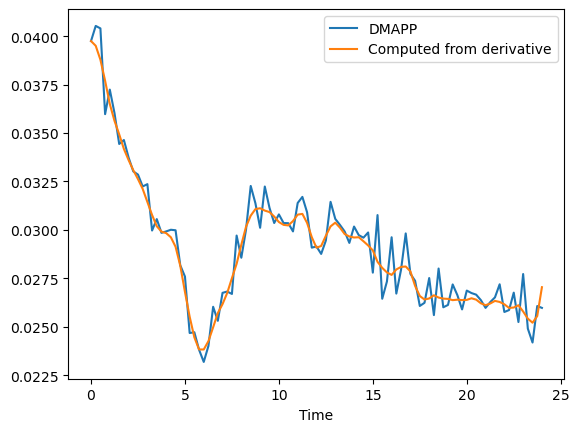

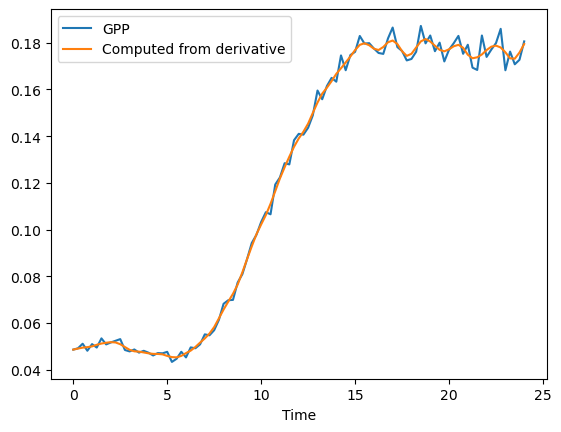

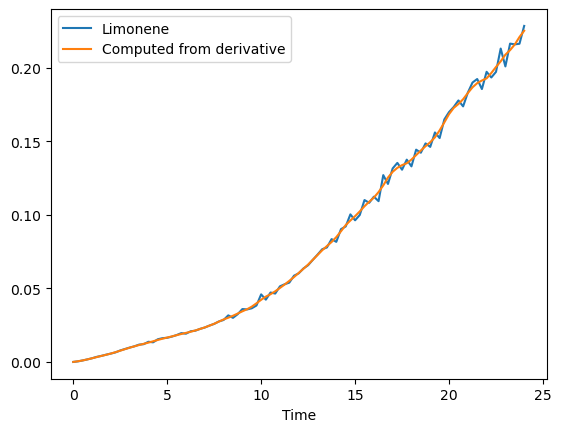

'Time profile from derivative vs. actual profile for Strain 2'

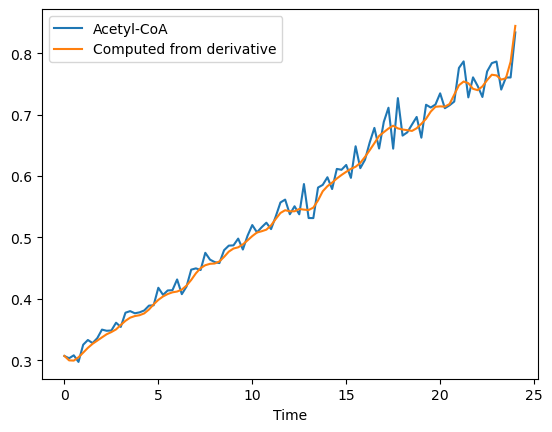

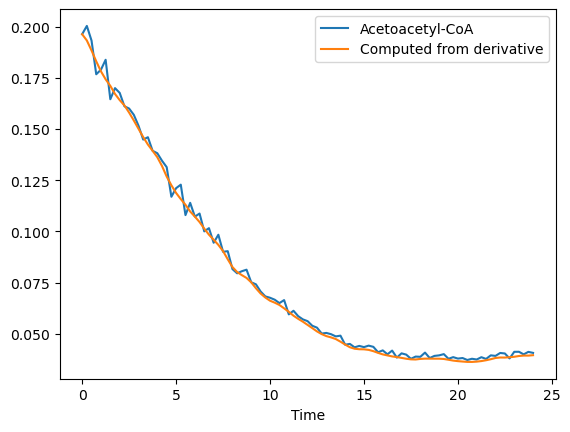

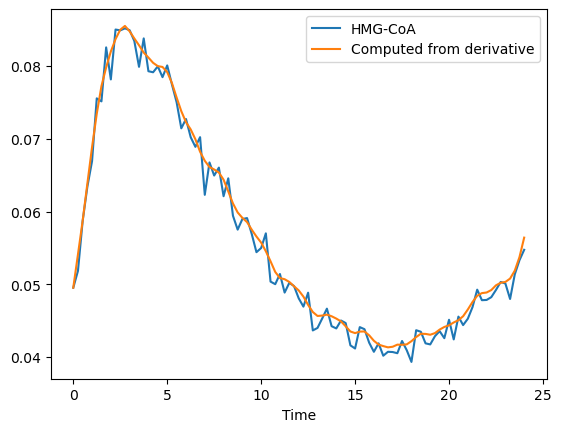

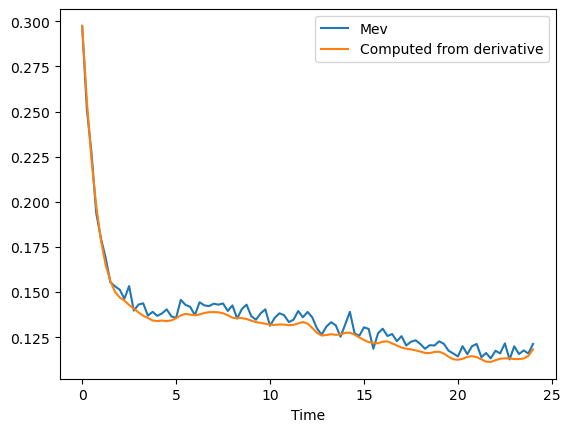

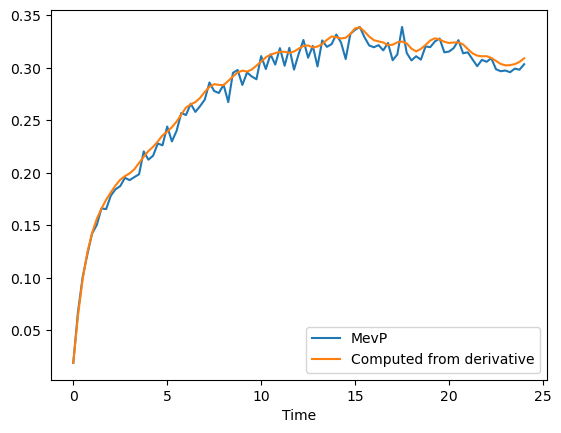

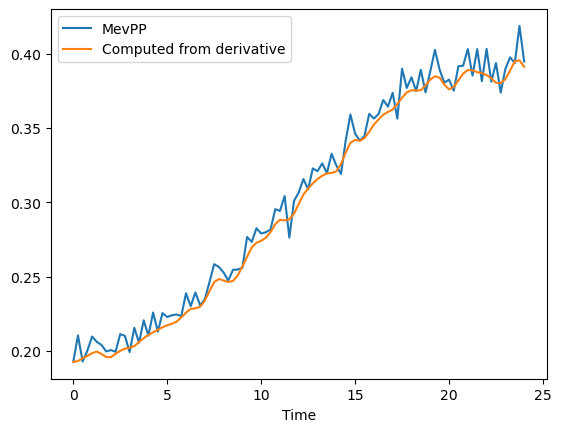

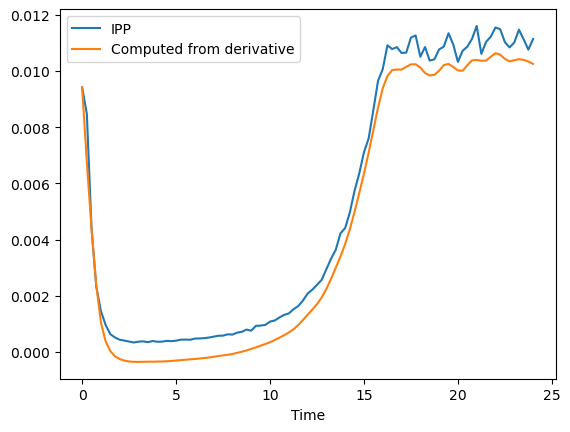

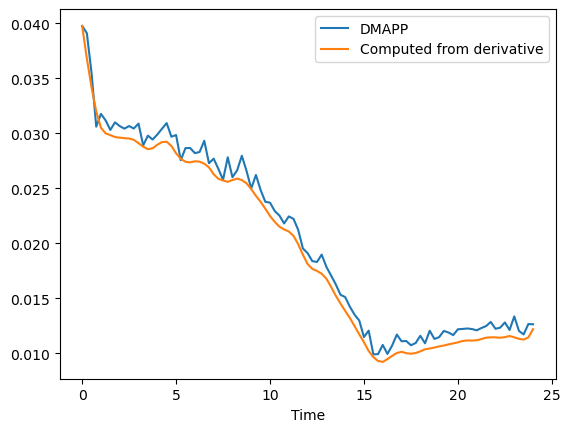

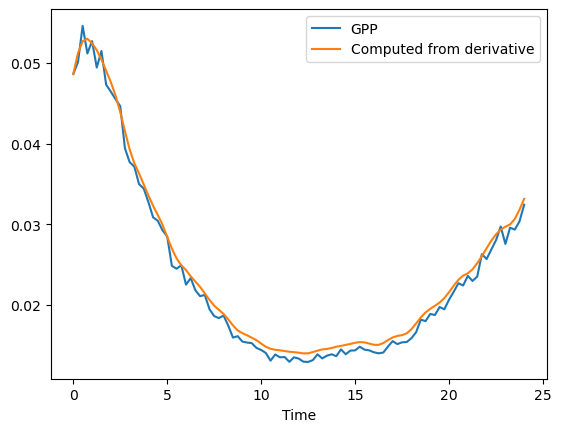

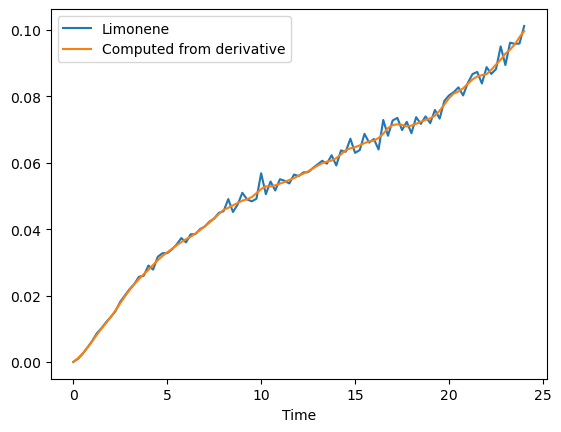

'Time profile from derivative vs. actual profile for Strain 3'

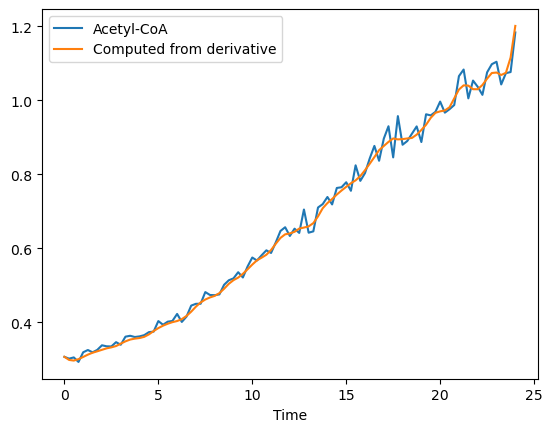

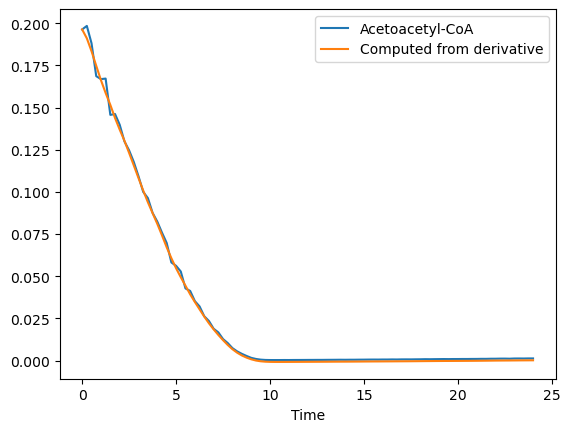

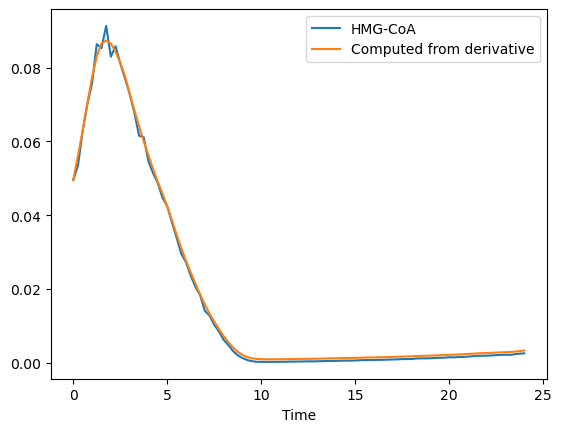

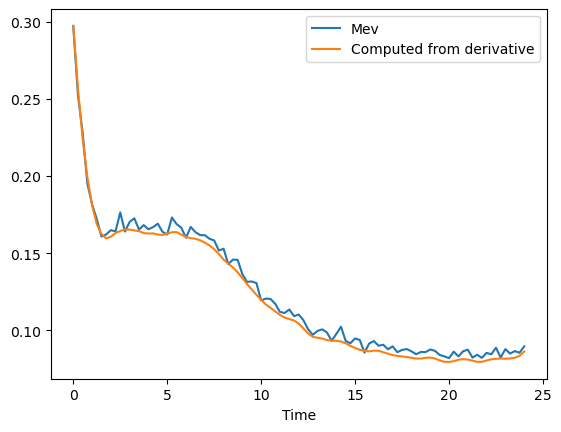

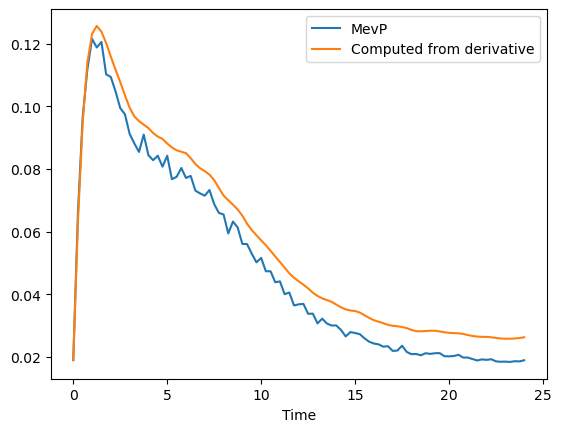

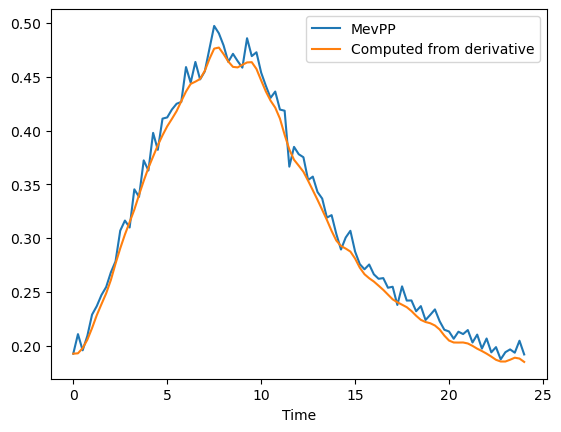

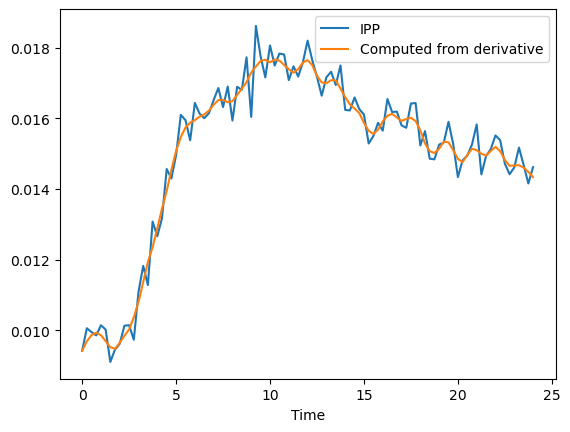

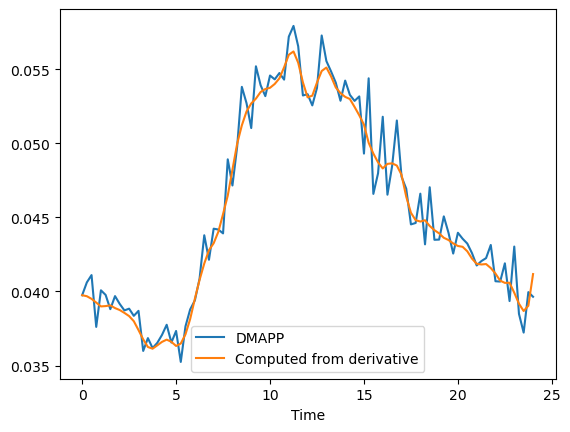

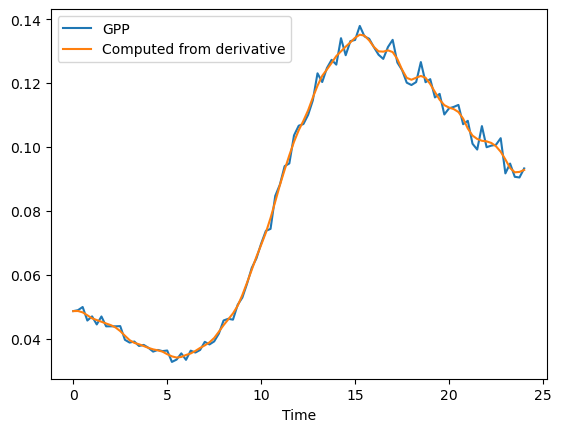

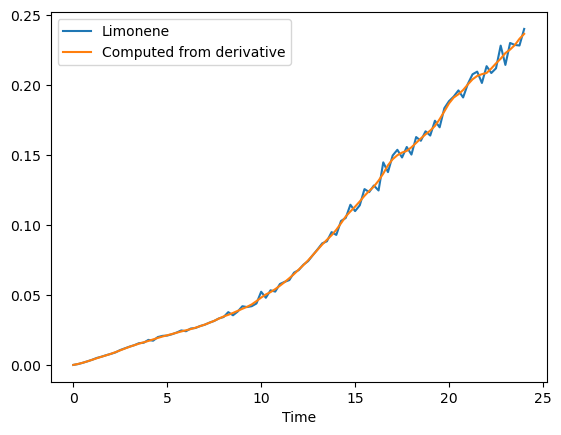

'Time profile from derivative vs. actual profile for WT'

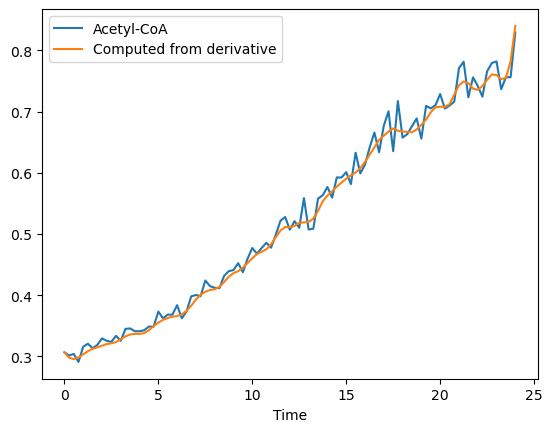

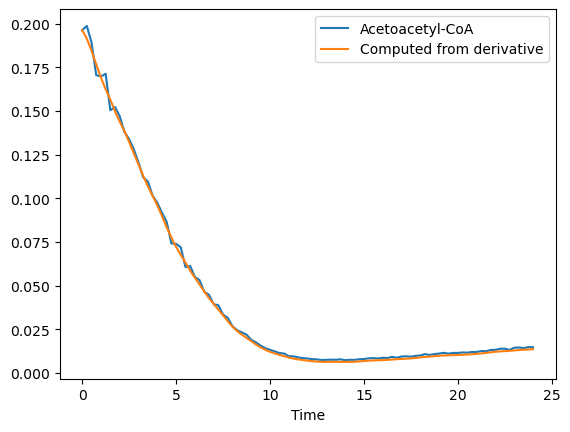

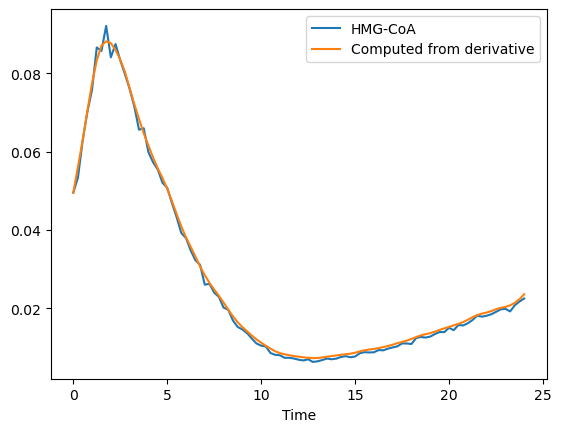

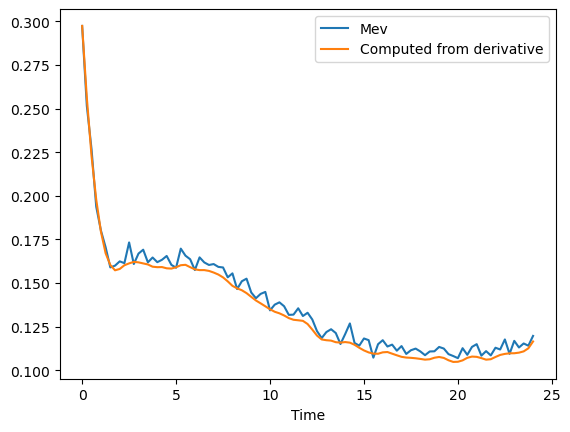

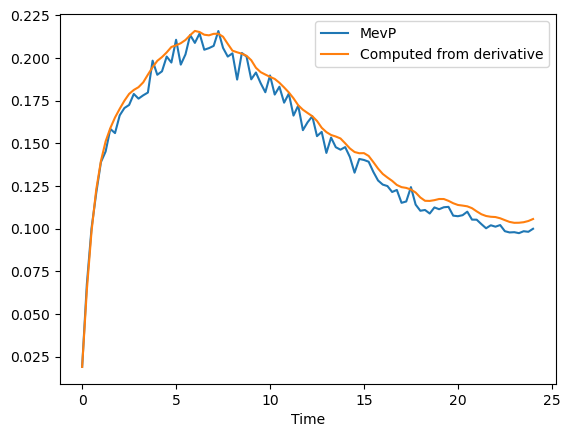

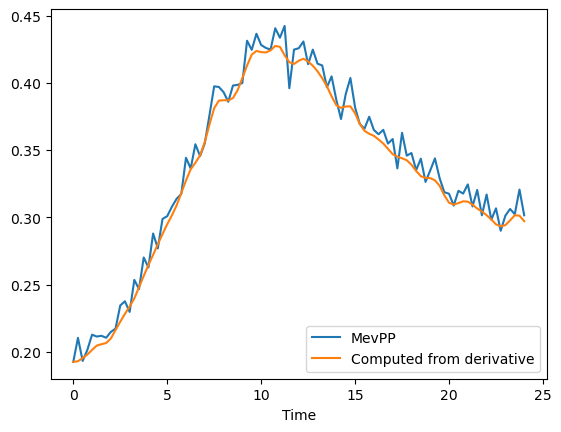

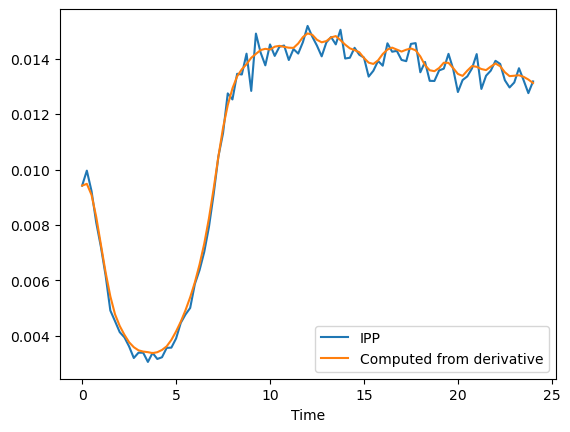

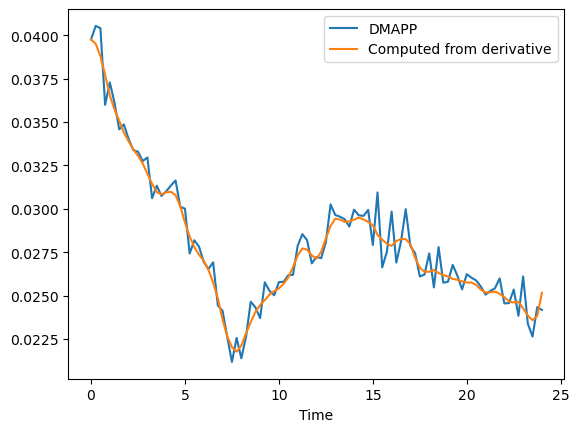

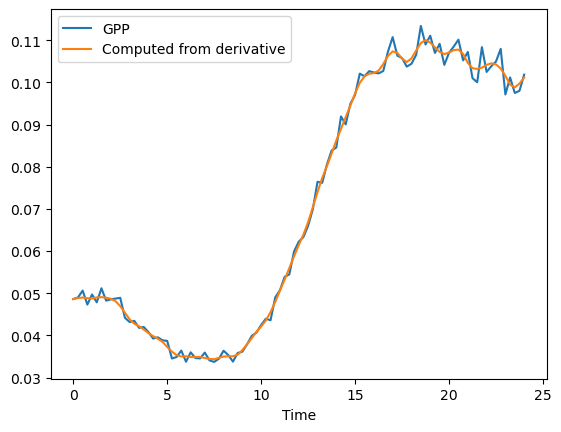

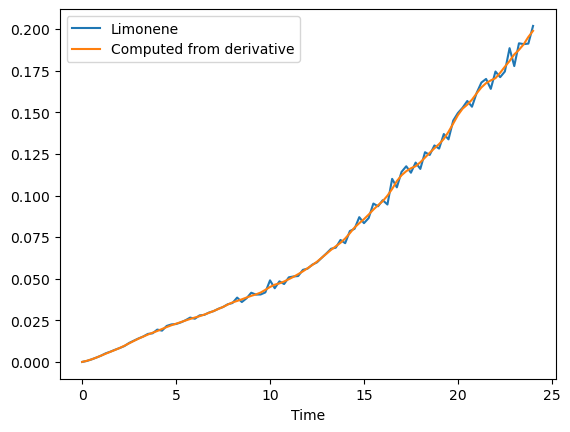

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.082450e+01  3.899512e+01  3.661377e+01  5.713511e+01   
         0.25   4.623589e+06  2.294647e+06  2.196168e+05  1.384614e+06   
         0.50   5.413871e+06  3.522874e+06  3.310752e+05  2.208463e+06   
         0.75   6.027501e+06  4.276124e+06  4.253266e+05  2.527476e+06   
         1.00   6.063303e+06  4.350573e+06  4.545087e+05  3.138185e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.806058e+06  2.716837e+06  1.734610e+06  1.964429e+06   
         23.25  2.749613e+06  2.649696e+06  1.714084e+06  2.107597e+06   
         23.50  2.825958e+06  2.669877e+06  1.786594e+06  2.013892e+06   
         23.75  2.688194e+06  2.539673e+06  1.781730e+06  1.923510e+06   
         24.00  2.639673e+06  2.764951e+06  1.738019e+06  2.047623e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         0.25   4.738172e+05  2.259331e+06  2.735048e+06  4.314942e+05   
         0.50   7.411170e+05  3.872225e+06  3.293242e+06  6.167228e+05   
         0.75   8.178062e+05  4.862051e+06  3.478237e+06  7.708814e+05   
         1.00   9.789872e+05  5.304373e+06  3.736293e+06  8.337442e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.469618e+06  4.061957e+06  4.347534e+06  1.241550e+06   
         23.25  1.450050e+06  3.943583e+06  4.490479e+06  1.240515e+06   
         23.50  1.585924e+06  3.959418e+06  4.406181e+06  1.200499e+06   
         23.75  1.532031e+06  3.876796e+06  4.207651e+06  1.300224e+06   
         24.00  1.431555e+06  4.049351e+06  4.386481e+06  1.244816e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.950656e+01   0.306835        0.196300  0.049520   
         0.25       1.865423e+05   0.297295        0.197849  0.055988   
         0.50       2.864148e+05   0.292495        0.187801  0.069633   
         0.75       3.519411e+05   0.272125        0.168785  0.081125   
         1.00       4.111120e+05   0.286510        0.167587  0.089382   
...                          ...        ...             ...       ...   
WT       23.00      1.461482e+06   0.781785        0.014512  0.019834   
         23.25      1.515575e+06   0.736414        0.014641  0.019183   
         23.50      1.446927e+06   0.755956        0.014301  0.020733   
         23.75      1.460263e+06   0.756040        0.014851  0.021714   
         24.00      1.483635e+06   0.828982        0.014775  0.022484   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297461  0.018999  0.192532  0.009419  0.039748  0.048625   
         0.25   0.250469  0.068398  0.210409  0.009964  0.040530  0.049189   
         0.50   0.225384  0.101600  0.193251  0.009243  0.040402  0.051150   
         0.75   0.192689  0.122388  0.201464  0.008145  0.035976  0.048149   
         1.00   0.180670  0.140800  0.212690  0.007334  0.037243  0.050990   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.116885  0.097919  0.301282  0.013141  0.026095  0.097143   
         23.25  0.113084  0.097356  0.306234  0.013655  0.023374  0.101186   
         23.50  0.115384  0.098481  0.302331  0.013217  0.022635 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.063218       -0.018066  0.040316 -0.187786  0.204053   
         0.25    -0.044773       -0.026331  0.041130 -0.152165  0.161545   
         0.50    -0.026328       -0.034596  0.041945 -0.116545  0.119037   
         0.75    -0.014672       -0.031585  0.043041 -0.077583  0.079276   
         1.00    -0.016664       -0.032512  0.026032 -0.049588  0.059743   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.024849        0.000823  0.001125 -0.000379 -0.000179   
         23.25   -0.028841        0.001194  0.001965  0.003149  0.000531   
         23.50    0.045608        0.000295  0.003132  0.002674  0.001919   
         23.75    0.169703        0.000567  0.004431  0.011381  0.003753   
         24.00    0.293799        0.000840  0.005731  0.020089  0.005587   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001246  0.001136 -0.000023  0.001942  0.001526  
         0.25   0.005651 -0.000630 -0.001924  0.001709  0.002025  
         0.50   0.012548 -0.002396 -0.003826  0.001476  0.002523  
         0.75   0.008458 -0.003624 -0.004865  0.000184  0.003040  
         1.00   0.018771 -0.003947 -0.004751  0.002370  0.003185  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002996  0.000274 -0.002350 -0.008681  0.014326  
         23.25  0.024923 -0.000133 -0.000987 -0.007820  0.007468  
         23.50  0.005967 -0.000329 -0.001157  0.002498  0.019237  
         23.75 -0.008848 -0.000445  0.003163  0.004658  0.016197  
         24.00 -0.023663 -0.000562  0.007483  0.006818  0.013157  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 3.785742E+202 | 2.159685E+104
     2 |      128 | 1.200232E+183 |  5.235942E+71
     3 |      192 | 7.556503E+169 |  8.615555E+64
     4 |      256 | 2.995609E+169 |  8.692366E+53
     5 |      320 | 2.995609E+169 |  1.617438E+43
     6 |      384 |  3.699562E+72 |  6.024245E+33
     7 |      448 |  3.699562E+72 |  7.246332E+23
     8 |      512 |  3.179078E+46 |  8.135233E+19
     9 |      576 |  6.193042E+35 |  6.923267E+15
    10 |      640 |  2.576654E+35 |  8.502609E+11
    11 |      704 |  3.956474E+23 |  1.315566E+11
    12 |      768 |  1.315828E+20 |  3.656043E+09
    13 |      832 |  1.297917E+20 |  5.888036E+08
    14 |      896 |  1.297915E+20 |  4.601724E+07
    15 |      960 |  1.297915E+20 |  4.605894E+06
    16 |     1024 |  8.950322E+08 |  4.490630E+05
    17 |     1088 |  4.184070E+08 |  6.046474E+03
    18 |     1152 |  4.160443E+08 |  4.862757E+01
    19 |     1216 |  4.13

   162 |    10368 |  3.307375E+01 |  3.307222E+01
   163 |    10432 |  3.307242E+01 |  3.307123E+01
   164 |    10496 |  3.307143E+01 |  3.306904E+01
   165 |    10560 |  3.306970E+01 |  3.306816E+01
   166 |    10624 |  3.306864E+01 |  3.306656E+01
   167 |    10688 |  3.306664E+01 |  3.306447E+01
   168 |    10752 |  3.306504E+01 |  3.306403E+01
   169 |    10816 |  3.306413E+01 |  3.306336E+01
   170 |    10880 |  3.306327E+01 |  3.306218E+01
   171 |    10944 |  3.306237E+01 |  3.306144E+01
   172 |    11008 |  3.306169E+01 |  3.306115E+01
   173 |    11072 |  3.306123E+01 |  3.306065E+01
   174 |    11136 |  3.306084E+01 |  3.306006E+01
   175 |    11200 |  3.306018E+01 |  3.305935E+01
   176 |    11264 |  3.305950E+01 |  3.305878E+01
   177 |    11328 |  3.305886E+01 |  3.305824E+01
   178 |    11392 |  3.305767E+01 |  3.305577E+01
   179 |    11456 |  3.305604E+01 |  3.305434E+01
   180 |    11520 |  3.305451E+01 |  3.305300E+01
   181 |    11584 |  3.305341E+01 |  3.305153E+01


   326 |    20864 |  3.285902E+01 |  3.285778E+01
   327 |    20928 |  3.285762E+01 |  3.285643E+01
   328 |    20992 |  3.285665E+01 |  3.285558E+01
   329 |    21056 |  3.285587E+01 |  3.285496E+01
   330 |    21120 |  3.285528E+01 |  3.285423E+01
   331 |    21184 |  3.285447E+01 |  3.285342E+01
   332 |    21248 |  3.285374E+01 |  3.285291E+01
   333 |    21312 |  3.285294E+01 |  3.285201E+01
   334 |    21376 |  3.285236E+01 |  3.285173E+01
   335 |    21440 |  3.285187E+01 |  3.285102E+01
   336 |    21504 |  3.285096E+01 |  3.284995E+01
   337 |    21568 |  3.284989E+01 |  3.284846E+01
   338 |    21632 |  3.284864E+01 |  3.284711E+01
   339 |    21696 |  3.284739E+01 |  3.284616E+01
   340 |    21760 |  3.284560E+01 |  3.284278E+01
   341 |    21824 |  3.284331E+01 |  3.284077E+01
   342 |    21888 |  3.284139E+01 |  3.283990E+01
   343 |    21952 |  3.284019E+01 |  3.283906E+01
   344 |    22016 |  3.283926E+01 |  3.283844E+01
   345 |    22080 |  3.283858E+01 |  3.283753E+01


   490 |    31360 |  3.270826E+01 |  3.270811E+01
   491 |    31424 |  3.270817E+01 |  3.270808E+01
   492 |    31488 |  3.270811E+01 |  3.270802E+01
   493 |    31552 |  3.270806E+01 |  3.270800E+01
   494 |    31616 |  3.270801E+01 |  3.270798E+01
   495 |    31680 |  3.270799E+01 |  3.270797E+01
   496 |    31744 |  3.270798E+01 |  3.270796E+01
   497 |    31808 |  3.270797E+01 |  3.270795E+01
   498 |    31872 |  3.270796E+01 |  3.270795E+01
   499 |    31936 |  3.270780E+01 |  3.270730E+01
   500 |    32000 |  3.270748E+01 |  3.270729E+01
   501 |    32064 |  3.270257E+01 |  3.268879E+01
   502 |    32128 |  3.269229E+01 |  3.266953E+01
   503 |    32192 |  3.268103E+01 |  3.266036E+01
   504 |    32256 |  3.267031E+01 |  3.265158E+01
   505 |    32320 |  3.266006E+01 |  3.264796E+01
   506 |    32384 |  3.265082E+01 |  3.264461E+01
   507 |    32448 |  3.264679E+01 |  3.264330E+01
   508 |    32512 |  3.264417E+01 |  3.264242E+01
   509 |    32576 |  3.264284E+01 |  3.264181E+01


   654 |    41856 |  3.262257E+01 |  3.262223E+01
   655 |    41920 |  3.262230E+01 |  3.262197E+01
   656 |    41984 |  3.262197E+01 |  3.262167E+01
   657 |    42048 |  3.262174E+01 |  3.262158E+01
   658 |    42112 |  3.262162E+01 |  3.262150E+01
   659 |    42176 |  3.262150E+01 |  3.262138E+01
   660 |    42240 |  3.262143E+01 |  3.262137E+01
   661 |    42304 |  3.262139E+01 |  3.262135E+01
   662 |    42368 |  3.262136E+01 |  3.262134E+01
   663 |    42432 |  3.262135E+01 |  3.262134E+01
   664 |    42496 |  3.262134E+01 |  3.262134E+01
   665 |    42560 |  3.262134E+01 |  3.262133E+01
   666 |    42624 |  3.262133E+01 |  3.262133E+01
   667 |    42688 |  3.262133E+01 |  3.262133E+01
   668 |    42752 |  3.262133E+01 |  3.262132E+01
   669 |    42816 |  3.262133E+01 |  3.262132E+01
   670 |    42880 |  3.262132E+01 |  3.262131E+01
   671 |    42944 |  3.262132E+01 |  3.262131E+01
   672 |    43008 |  3.262131E+01 |  3.262131E+01
   673 |    43072 |  3.262131E+01 |  3.262130E+01


   818 |    52352 |  3.241829E+01 |  3.241786E+01
   819 |    52416 |  3.241799E+01 |  3.241770E+01
   820 |    52480 |  3.241777E+01 |  3.241751E+01
   821 |    52544 |  3.241751E+01 |  3.241710E+01
   822 |    52608 |  3.241725E+01 |  3.241681E+01
   823 |    52672 |  3.241693E+01 |  3.241670E+01
   824 |    52736 |  3.241681E+01 |  3.241665E+01
   825 |    52800 |  3.241671E+01 |  3.241652E+01
   826 |    52864 |  3.241655E+01 |  3.241642E+01
   827 |    52928 |  3.241643E+01 |  3.241633E+01
   828 |    52992 |  3.241635E+01 |  3.241629E+01
   829 |    53056 |  3.241631E+01 |  3.241625E+01
   830 |    53120 |  3.241628E+01 |  3.241620E+01
   831 |    53184 |  3.241623E+01 |  3.241618E+01
   832 |    53248 |  3.241620E+01 |  3.241616E+01
   833 |    53312 |  3.241617E+01 |  3.241613E+01
   834 |    53376 |  3.241615E+01 |  3.241611E+01
   835 |    53440 |  3.241612E+01 |  3.241610E+01
   836 |    53504 |  3.241611E+01 |  3.241609E+01
   837 |    53568 |  3.241566E+01 |  3.241457E+01


   982 |    62848 |  3.237734E+01 |  3.237734E+01
   983 |    62912 |  3.237734E+01 |  3.237734E+01
   984 |    62976 |  3.237734E+01 |  3.237734E+01
   985 |    63040 |  3.237734E+01 |  3.237734E+01
   986 |    63104 |  3.237734E+01 |  3.237734E+01
   987 |    63168 |  3.237734E+01 |  3.237733E+01
   988 |    63232 |  3.237729E+01 |  3.237710E+01
   989 |    63296 |  3.237715E+01 |  3.237706E+01
   990 |    63360 |  3.237711E+01 |  3.237705E+01
   991 |    63424 |  3.237707E+01 |  3.237705E+01
   992 |    63488 |  3.237705E+01 |  3.237703E+01
   993 |    63552 |  3.237704E+01 |  3.237701E+01
   994 |    63616 |  3.237702E+01 |  3.237698E+01
   995 |    63680 |  3.237699E+01 |  3.237696E+01
   996 |    63744 |  3.237697E+01 |  3.237694E+01
   997 |    63808 |  3.237695E+01 |  3.237693E+01
   998 |    63872 |  3.237694E+01 |  3.237692E+01
   999 |    63936 |  3.237693E+01 |  3.237692E+01
  1000 |    64000 |  3.237692E+01 |  3.237691E+01
  1001 |    64064 |  3.237691E+01 |  3.237689E+01


  1146 |    73344 |  3.234085E+01 |  3.234064E+01
  1147 |    73408 |  3.234072E+01 |  3.234063E+01
  1148 |    73472 |  3.234064E+01 |  3.234059E+01
  1149 |    73536 |  3.234061E+01 |  3.234058E+01
  1150 |    73600 |  3.234058E+01 |  3.234054E+01
  1151 |    73664 |  3.234055E+01 |  3.234051E+01
  1152 |    73728 |  3.234051E+01 |  3.234048E+01
  1153 |    73792 |  3.234049E+01 |  3.234046E+01
  1154 |    73856 |  3.234047E+01 |  3.234045E+01
  1155 |    73920 |  3.234046E+01 |  3.234045E+01
  1156 |    73984 |  3.234045E+01 |  3.234044E+01
  1157 |    74048 |  3.234044E+01 |  3.234043E+01
  1158 |    74112 |  3.234044E+01 |  3.234043E+01
  1159 |    74176 |  3.234043E+01 |  3.234042E+01
  1160 |    74240 |  3.234043E+01 |  3.234042E+01
  1161 |    74304 |  3.234042E+01 |  3.234042E+01
  1162 |    74368 |  3.234042E+01 |  3.234042E+01
  1163 |    74432 |  3.234042E+01 |  3.234041E+01
  1164 |    74496 |  3.234042E+01 |  3.234041E+01
  1165 |    74560 |  3.234041E+01 |  3.234041E+01


  1310 |    83840 |  3.230203E+01 |  3.230107E+01
  1311 |    83904 |  3.230150E+01 |  3.230098E+01
  1312 |    83968 |  3.230114E+01 |  3.230075E+01
  1313 |    84032 |  3.230080E+01 |  3.230063E+01
  1314 |    84096 |  3.230071E+01 |  3.230061E+01
  1315 |    84160 |  3.230065E+01 |  3.230059E+01
  1316 |    84224 |  3.230059E+01 |  3.230055E+01
  1317 |    84288 |  3.230057E+01 |  3.230055E+01
  1318 |    84352 |  3.230055E+01 |  3.230052E+01
  1319 |    84416 |  3.230054E+01 |  3.230052E+01
  1320 |    84480 |  3.230052E+01 |  3.230048E+01
  1321 |    84544 |  3.230049E+01 |  3.230046E+01
  1322 |    84608 |  3.230047E+01 |  3.230045E+01
  1323 |    84672 |  3.230045E+01 |  3.230043E+01
  1324 |    84736 |  3.230044E+01 |  3.230043E+01
  1325 |    84800 |  3.230043E+01 |  3.230042E+01
  1326 |    84864 |  3.230043E+01 |  3.230042E+01
  1327 |    84928 |  3.230042E+01 |  3.230042E+01
  1328 |    84992 |  3.230042E+01 |  3.230041E+01
  1329 |    85056 |  3.230041E+01 |  3.230041E+01


  1474 |    94336 |  3.229104E+01 |  3.229094E+01
  1475 |    94400 |  3.229095E+01 |  3.229088E+01
  1476 |    94464 |  3.229090E+01 |  3.229087E+01
  1477 |    94528 |  3.229088E+01 |  3.229086E+01
  1478 |    94592 |  3.229086E+01 |  3.229082E+01
  1479 |    94656 |  3.229083E+01 |  3.229080E+01
  1480 |    94720 |  3.229081E+01 |  3.229079E+01
  1481 |    94784 |  3.229080E+01 |  3.229079E+01
  1482 |    94848 |  3.229079E+01 |  3.229078E+01
  1483 |    94912 |  3.229078E+01 |  3.229077E+01
  1484 |    94976 |  3.229078E+01 |  3.229077E+01
  1485 |    95040 |  3.229077E+01 |  3.229077E+01
  1486 |    95104 |  3.229077E+01 |  3.229076E+01
  1487 |    95168 |  3.229077E+01 |  3.229076E+01
  1488 |    95232 |  3.229076E+01 |  3.229076E+01
  1489 |    95296 |  3.229076E+01 |  3.229076E+01
  1490 |    95360 |  3.229076E+01 |  3.229076E+01
  1491 |    95424 |  3.229076E+01 |  3.229076E+01
  1492 |    95488 |  3.229076E+01 |  3.229076E+01
  1493 |    95552 |  3.229076E+01 |  3.229076E+01


  1638 |   104832 |  3.213205E+01 |  3.213204E+01
  1639 |   104896 |  3.213204E+01 |  3.213203E+01
  1640 |   104960 |  3.213203E+01 |  3.213201E+01
  1641 |   105024 |  3.213202E+01 |  3.213201E+01
  1642 |   105088 |  3.213201E+01 |  3.213200E+01
  1643 |   105152 |  3.213200E+01 |  3.213199E+01
  1644 |   105216 |  3.213199E+01 |  3.213198E+01
  1645 |   105280 |  3.213198E+01 |  3.213197E+01
  1646 |   105344 |  3.213198E+01 |  3.213197E+01
  1647 |   105408 |  3.213197E+01 |  3.213196E+01
  1648 |   105472 |  3.213196E+01 |  3.213193E+01
  1649 |   105536 |  3.213194E+01 |  3.213191E+01
  1650 |   105600 |  3.213191E+01 |  3.213188E+01
  1651 |   105664 |  3.213189E+01 |  3.213186E+01
  1652 |   105728 |  3.213187E+01 |  3.213185E+01
  1653 |   105792 |  3.213186E+01 |  3.213185E+01
  1654 |   105856 |  3.213186E+01 |  3.213185E+01
  1655 |   105920 |  3.213185E+01 |  3.213184E+01
  1656 |   105984 |  3.213185E+01 |  3.213184E+01
  1657 |   106048 |  3.213184E+01 |  3.213184E+01


  1802 |   115328 |  3.212623E+01 |  3.212599E+01
  1803 |   115392 |  3.212581E+01 |  3.212527E+01
  1804 |   115456 |  3.212544E+01 |  3.212498E+01
  1805 |   115520 |  3.212503E+01 |  3.212438E+01
  1806 |   115584 |  3.212462E+01 |  3.212424E+01
  1807 |   115648 |  3.212431E+01 |  3.212412E+01
  1808 |   115712 |  3.212405E+01 |  3.212381E+01
  1809 |   115776 |  3.212383E+01 |  3.212361E+01
  1810 |   115840 |  3.212360E+01 |  3.212338E+01
  1811 |   115904 |  3.212266E+01 |  3.212106E+01
  1812 |   115968 |  3.212181E+01 |  3.212059E+01
  1813 |   116032 |  3.212072E+01 |  3.211976E+01
  1814 |   116096 |  3.212000E+01 |  3.211923E+01
  1815 |   116160 |  3.211942E+01 |  3.211861E+01
  1816 |   116224 |  3.211888E+01 |  3.211832E+01
  1817 |   116288 |  3.211847E+01 |  3.211816E+01
  1818 |   116352 |  3.211819E+01 |  3.211781E+01
  1819 |   116416 |  3.211784E+01 |  3.211739E+01
  1820 |   116480 |  3.211746E+01 |  3.211710E+01
  1821 |   116544 |  3.211709E+01 |  3.211672E+01


  1966 |   125824 |  3.210198E+01 |  3.210196E+01
  1967 |   125888 |  3.210197E+01 |  3.210194E+01
  1968 |   125952 |  3.210195E+01 |  3.210192E+01
  1969 |   126016 |  3.210193E+01 |  3.210188E+01
  1970 |   126080 |  3.210190E+01 |  3.210187E+01
  1971 |   126144 |  3.210188E+01 |  3.210186E+01
  1972 |   126208 |  3.210187E+01 |  3.210186E+01
  1973 |   126272 |  3.210186E+01 |  3.210185E+01
  1974 |   126336 |  3.210185E+01 |  3.210184E+01
  1975 |   126400 |  3.210185E+01 |  3.210184E+01
  1976 |   126464 |  3.210184E+01 |  3.210184E+01
  1977 |   126528 |  3.210184E+01 |  3.210183E+01
  1978 |   126592 |  3.210183E+01 |  3.210183E+01
  1979 |   126656 |  3.210183E+01 |  3.210182E+01
  1980 |   126720 |  3.210183E+01 |  3.210182E+01
  1981 |   126784 |  3.210182E+01 |  3.210182E+01
  1982 |   126848 |  3.210182E+01 |  3.210182E+01
  1983 |   126912 |  3.210182E+01 |  3.210182E+01
  1984 |   126976 |  3.210182E+01 |  3.210182E+01
  1985 |   127040 |  3.210182E+01 |  3.210182E+01


  2130 |   136320 |  3.206803E+01 |  3.206736E+01
  2131 |   136384 |  3.206754E+01 |  3.206721E+01
  2132 |   136448 |  3.206724E+01 |  3.206695E+01
  2133 |   136512 |  3.206699E+01 |  3.206677E+01
  2134 |   136576 |  3.206682E+01 |  3.206657E+01
  2135 |   136640 |  3.206660E+01 |  3.206638E+01
  2136 |   136704 |  3.206643E+01 |  3.206627E+01
  2137 |   136768 |  3.206632E+01 |  3.206620E+01
  2138 |   136832 |  3.206622E+01 |  3.206610E+01
  2139 |   136896 |  3.206615E+01 |  3.206606E+01
  2140 |   136960 |  3.206608E+01 |  3.206602E+01
  2141 |   137024 |  3.206604E+01 |  3.206600E+01
  2142 |   137088 |  3.206600E+01 |  3.206593E+01
  2143 |   137152 |  3.206593E+01 |  3.206581E+01
  2144 |   137216 |  3.206583E+01 |  3.206573E+01
  2145 |   137280 |  3.206575E+01 |  3.206569E+01
  2146 |   137344 |  3.206571E+01 |  3.206564E+01
  2147 |   137408 |  3.206564E+01 |  3.206557E+01
  2148 |   137472 |  3.206559E+01 |  3.206552E+01
  2149 |   137536 |  3.206555E+01 |  3.206551E+01


  2294 |   146816 |  3.204185E+01 |  3.204185E+01
  2295 |   146880 |  3.204185E+01 |  3.204185E+01
  2296 |   146944 |  3.204185E+01 |  3.204185E+01
  2297 |   147008 |  3.204185E+01 |  3.204185E+01
  2298 |   147072 |  3.204185E+01 |  3.204185E+01
  2299 |   147136 |  3.204185E+01 |  3.204185E+01
  2300 |   147200 |  3.204185E+01 |  3.204185E+01
  2301 |   147264 |  3.204185E+01 |  3.204185E+01
  2302 |   147328 |  3.204182E+01 |  3.204169E+01
  2303 |   147392 |  3.204174E+01 |  3.204168E+01
  2304 |   147456 |  3.204171E+01 |  3.204168E+01
  2305 |   147520 |  3.204169E+01 |  3.204168E+01
  2306 |   147584 |  3.204168E+01 |  3.204167E+01
  2307 |   147648 |  3.204167E+01 |  3.204164E+01
  2308 |   147712 |  3.204164E+01 |  3.204162E+01
  2309 |   147776 |  3.204162E+01 |  3.204159E+01
  2310 |   147840 |  3.204160E+01 |  3.204157E+01
  2311 |   147904 |  3.204158E+01 |  3.204154E+01
  2312 |   147968 |  3.204155E+01 |  3.204152E+01
  2313 |   148032 |  3.204153E+01 |  3.204150E+01


  2458 |   157312 |  3.197142E+01 |  3.197091E+01
  2459 |   157376 |  3.197108E+01 |  3.197080E+01
  2460 |   157440 |  3.197086E+01 |  3.197063E+01
  2461 |   157504 |  3.197069E+01 |  3.197054E+01
  2462 |   157568 |  3.197060E+01 |  3.197052E+01
  2463 |   157632 |  3.197056E+01 |  3.197051E+01
  2464 |   157696 |  3.197052E+01 |  3.197047E+01
  2465 |   157760 |  3.197049E+01 |  3.197044E+01
  2466 |   157824 |  3.197046E+01 |  3.197042E+01
  2467 |   157888 |  3.197043E+01 |  3.197040E+01
  2468 |   157952 |  3.197036E+01 |  3.197030E+01
  2469 |   158016 |  3.197032E+01 |  3.197029E+01
  2470 |   158080 |  3.197030E+01 |  3.197029E+01
  2471 |   158144 |  3.197030E+01 |  3.197029E+01
  2472 |   158208 |  3.197029E+01 |  3.197028E+01
  2473 |   158272 |  3.197028E+01 |  3.197027E+01
  2474 |   158336 |  3.197028E+01 |  3.197026E+01
  2475 |   158400 |  3.197027E+01 |  3.197025E+01
  2476 |   158464 |  3.197025E+01 |  3.197023E+01
  2477 |   158528 |  3.196944E+01 |  3.196873E+01


  2622 |   167808 |  3.192175E+01 |  3.192119E+01
  2623 |   167872 |  3.192108E+01 |  3.192077E+01
  2624 |   167936 |  3.192070E+01 |  3.192008E+01
  2625 |   168000 |  3.192020E+01 |  3.191972E+01
  2626 |   168064 |  3.191967E+01 |  3.191924E+01
  2627 |   168128 |  3.191946E+01 |  3.191911E+01
  2628 |   168192 |  3.191911E+01 |  3.191870E+01
  2629 |   168256 |  3.191878E+01 |  3.191778E+01
  2630 |   168320 |  3.191800E+01 |  3.191720E+01
  2631 |   168384 |  3.191731E+01 |  3.191662E+01
  2632 |   168448 |  3.191680E+01 |  3.191609E+01
  2633 |   168512 |  3.191627E+01 |  3.191543E+01
  2634 |   168576 |  3.191565E+01 |  3.191512E+01
  2635 |   168640 |  3.191529E+01 |  3.191487E+01
  2636 |   168704 |  3.191494E+01 |  3.191453E+01
  2637 |   168768 |  3.191462E+01 |  3.191429E+01
  2638 |   168832 |  3.191437E+01 |  3.191420E+01
  2639 |   168896 |  3.191382E+01 |  3.191313E+01
  2640 |   168960 |  3.191336E+01 |  3.191289E+01
  2641 |   169024 |  3.191303E+01 |  3.191268E+01


  2786 |   178304 |  3.185792E+01 |  3.185762E+01
  2787 |   178368 |  3.185693E+01 |  3.185567E+01
  2788 |   178432 |  3.185581E+01 |  3.185420E+01
  2789 |   178496 |  3.185453E+01 |  3.185255E+01
  2790 |   178560 |  3.185321E+01 |  3.185191E+01
  2791 |   178624 |  3.185221E+01 |  3.185146E+01
  2792 |   178688 |  3.185143E+01 |  3.185075E+01
  2793 |   178752 |  3.185100E+01 |  3.185039E+01
  2794 |   178816 |  3.185055E+01 |  3.184992E+01
  2795 |   178880 |  3.184999E+01 |  3.184945E+01
  2796 |   178944 |  3.184941E+01 |  3.184887E+01
  2797 |   179008 |  3.184901E+01 |  3.184851E+01
  2798 |   179072 |  3.184869E+01 |  3.184822E+01
  2799 |   179136 |  3.184825E+01 |  3.184783E+01
  2800 |   179200 |  3.184786E+01 |  3.184745E+01
  2801 |   179264 |  3.184759E+01 |  3.184734E+01
  2802 |   179328 |  3.184740E+01 |  3.184718E+01
  2803 |   179392 |  3.184724E+01 |  3.184707E+01
  2804 |   179456 |  3.184705E+01 |  3.184681E+01
  2805 |   179520 |  3.184684E+01 |  3.184655E+01


  2950 |   188800 |  3.165422E+01 |  3.165422E+01
  2951 |   188864 |  3.165422E+01 |  3.165421E+01
  2952 |   188928 |  3.165421E+01 |  3.165421E+01
  2953 |   188992 |  3.165421E+01 |  3.165421E+01
  2954 |   189056 |  3.165421E+01 |  3.165421E+01
  2955 |   189120 |  3.165421E+01 |  3.165420E+01
  2956 |   189184 |  3.165421E+01 |  3.165420E+01
  2957 |   189248 |  3.165420E+01 |  3.165420E+01
  2958 |   189312 |  3.165420E+01 |  3.165420E+01
  2959 |   189376 |  3.165420E+01 |  3.165420E+01
  2960 |   189440 |  3.165420E+01 |  3.165420E+01
  2961 |   189504 |  3.165420E+01 |  3.165420E+01
  2962 |   189568 |  3.165420E+01 |  3.165420E+01
  2963 |   189632 |  3.165420E+01 |  3.165420E+01
  2964 |   189696 |  3.165420E+01 |  3.165420E+01
  2965 |   189760 |  3.165420E+01 |  3.165420E+01
  2966 |   189824 |  3.165420E+01 |  3.165420E+01
  2967 |   189888 |  3.165420E+01 |  3.165420E+01
  2968 |   189952 |  3.165420E+01 |  3.165420E+01
  2969 |   190016 |  3.165420E+01 |  3.165420E+01


  3114 |   199296 |  3.157578E+01 |  3.157554E+01
  3115 |   199360 |  3.157557E+01 |  3.157535E+01
  3116 |   199424 |  3.157405E+01 |  3.157275E+01
  3117 |   199488 |  3.157297E+01 |  3.157220E+01
  3118 |   199552 |  3.157217E+01 |  3.157119E+01
  3119 |   199616 |  3.157111E+01 |  3.157005E+01
  3120 |   199680 |  3.157038E+01 |  3.156961E+01
  3121 |   199744 |  3.156974E+01 |  3.156907E+01
  3122 |   199808 |  3.156921E+01 |  3.156853E+01
  3123 |   199872 |  3.156863E+01 |  3.156820E+01
  3124 |   199936 |  3.156822E+01 |  3.156787E+01
  3125 |   200000 |  3.156792E+01 |  3.156760E+01
  3126 |   200064 |  3.156763E+01 |  3.156715E+01
  3127 |   200128 |  3.156729E+01 |  3.156693E+01
  3128 |   200192 |  3.156687E+01 |  3.156626E+01
  3129 |   200256 |  3.156637E+01 |  3.156574E+01
  3130 |   200320 |  3.156573E+01 |  3.156517E+01
  3131 |   200384 |  3.156489E+01 |  3.156353E+01
  3132 |   200448 |  3.156396E+01 |  3.156243E+01
  3133 |   200512 |  3.156261E+01 |  3.156098E+01


  3278 |   209792 |  3.113802E+01 |  3.113802E+01
  3279 |   209856 |  3.113802E+01 |  3.113802E+01
  3280 |   209920 |  3.113802E+01 |  3.113802E+01
  3281 |   209984 |  3.113802E+01 |  3.113802E+01
  3282 |   210048 |  3.113802E+01 |  3.113801E+01
  3283 |   210112 |  3.113801E+01 |  3.113801E+01
  3284 |   210176 |  3.113801E+01 |  3.113801E+01
  3285 |   210240 |  3.113801E+01 |  3.113801E+01
  3286 |   210304 |  3.113801E+01 |  3.113801E+01
  3287 |   210368 |  3.113801E+01 |  3.113801E+01
  3288 |   210432 |  3.113801E+01 |  3.113801E+01
  3289 |   210496 |  3.113801E+01 |  3.113801E+01
  3290 |   210560 |  3.113801E+01 |  3.113801E+01
  3291 |   210624 |  3.113801E+01 |  3.113801E+01
  3292 |   210688 |  3.113801E+01 |  3.113801E+01
  3293 |   210752 |  3.113801E+01 |  3.113801E+01
  3294 |   210816 |  3.113801E+01 |  3.113801E+01
  3295 |   210880 |  3.113801E+01 |  3.113801E+01
  3296 |   210944 |  3.113801E+01 |  3.113801E+01
  3297 |   211008 |  3.113801E+01 |  3.113800E+01


  3442 |   220288 |  3.111920E+01 |  3.111916E+01
  3443 |   220352 |  3.111916E+01 |  3.111913E+01
  3444 |   220416 |  3.111914E+01 |  3.111911E+01
  3445 |   220480 |  3.111912E+01 |  3.111910E+01
  3446 |   220544 |  3.111911E+01 |  3.111908E+01
  3447 |   220608 |  3.111909E+01 |  3.111905E+01
  3448 |   220672 |  3.111906E+01 |  3.111904E+01
  3449 |   220736 |  3.111904E+01 |  3.111902E+01
  3450 |   220800 |  3.111903E+01 |  3.111902E+01
  3451 |   220864 |  3.111900E+01 |  3.111893E+01
  3452 |   220928 |  3.111895E+01 |  3.111890E+01
  3453 |   220992 |  3.111891E+01 |  3.111883E+01
  3454 |   221056 |  3.111883E+01 |  3.111872E+01
  3455 |   221120 |  3.111867E+01 |  3.111831E+01
  3456 |   221184 |  3.111836E+01 |  3.111796E+01
  3457 |   221248 |  3.111798E+01 |  3.111763E+01
  3458 |   221312 |  3.111760E+01 |  3.111727E+01
  3459 |   221376 |  3.111727E+01 |  3.111674E+01
  3460 |   221440 |  3.111681E+01 |  3.111611E+01
  3461 |   221504 |  3.111627E+01 |  3.111578E+01


  3606 |   230784 |  3.103564E+01 |  3.103534E+01
  3607 |   230848 |  3.103535E+01 |  3.103502E+01
  3608 |   230912 |  3.103505E+01 |  3.103464E+01
  3609 |   230976 |  3.103467E+01 |  3.103430E+01
  3610 |   231040 |  3.103437E+01 |  3.103404E+01
  3611 |   231104 |  3.103398E+01 |  3.103340E+01
  3612 |   231168 |  3.103329E+01 |  3.103248E+01
  3613 |   231232 |  3.103253E+01 |  3.103144E+01
  3614 |   231296 |  3.103171E+01 |  3.103058E+01
  3615 |   231360 |  3.103096E+01 |  3.103019E+01
  3616 |   231424 |  3.103038E+01 |  3.102994E+01
  3617 |   231488 |  3.102995E+01 |  3.102956E+01
  3618 |   231552 |  3.102964E+01 |  3.102923E+01
  3619 |   231616 |  3.102924E+01 |  3.102866E+01
  3620 |   231680 |  3.102877E+01 |  3.102829E+01
  3621 |   231744 |  3.102844E+01 |  3.102809E+01
  3622 |   231808 |  3.102816E+01 |  3.102790E+01
  3623 |   231872 |  3.102800E+01 |  3.102782E+01
  3624 |   231936 |  3.102787E+01 |  3.102778E+01
  3625 |   232000 |  3.102783E+01 |  3.102776E+01


  3770 |   241280 |  3.102007E+01 |  3.102007E+01
  3771 |   241344 |  3.102001E+01 |  3.101948E+01
  3772 |   241408 |  3.101966E+01 |  3.101946E+01
  3773 |   241472 |  3.101955E+01 |  3.101944E+01
  3774 |   241536 |  3.101936E+01 |  3.101914E+01
  3775 |   241600 |  3.101909E+01 |  3.101876E+01
  3776 |   241664 |  3.101877E+01 |  3.101845E+01
  3777 |   241728 |  3.101856E+01 |  3.101826E+01
  3778 |   241792 |  3.101830E+01 |  3.101802E+01
  3779 |   241856 |  3.101799E+01 |  3.101773E+01
  3780 |   241920 |  3.101782E+01 |  3.101768E+01
  3781 |   241984 |  3.101770E+01 |  3.101755E+01
  3782 |   242048 |  3.101759E+01 |  3.101751E+01
  3783 |   242112 |  3.101753E+01 |  3.101746E+01
  3784 |   242176 |  3.101748E+01 |  3.101744E+01
  3785 |   242240 |  3.101746E+01 |  3.101742E+01
  3786 |   242304 |  3.101743E+01 |  3.101739E+01
  3787 |   242368 |  3.101740E+01 |  3.101737E+01
  3788 |   242432 |  3.101738E+01 |  3.101735E+01
  3789 |   242496 |  3.101736E+01 |  3.101734E+01


  3934 |   251776 |  3.100394E+01 |  3.100367E+01
  3935 |   251840 |  3.100375E+01 |  3.100353E+01
  3936 |   251904 |  3.100357E+01 |  3.100327E+01
  3937 |   251968 |  3.100332E+01 |  3.100311E+01
  3938 |   252032 |  3.100311E+01 |  3.100290E+01
  3939 |   252096 |  3.100297E+01 |  3.100284E+01
  3940 |   252160 |  3.100287E+01 |  3.100276E+01
  3941 |   252224 |  3.100278E+01 |  3.100269E+01
  3942 |   252288 |  3.100270E+01 |  3.100261E+01
  3943 |   252352 |  3.100261E+01 |  3.100254E+01
  3944 |   252416 |  3.100256E+01 |  3.100250E+01
  3945 |   252480 |  3.100250E+01 |  3.100246E+01
  3946 |   252544 |  3.100248E+01 |  3.100245E+01
  3947 |   252608 |  3.100246E+01 |  3.100244E+01
  3948 |   252672 |  3.100245E+01 |  3.100243E+01
  3949 |   252736 |  3.100244E+01 |  3.100243E+01
  3950 |   252800 |  3.100243E+01 |  3.100242E+01
  3951 |   252864 |  3.100242E+01 |  3.100241E+01
  3952 |   252928 |  3.100242E+01 |  3.100241E+01
  3953 |   252992 |  3.100242E+01 |  3.100241E+01


  4098 |   262272 |  3.100191E+01 |  3.100188E+01
  4099 |   262336 |  3.100189E+01 |  3.100187E+01
  4100 |   262400 |  3.100188E+01 |  3.100187E+01
  4101 |   262464 |  3.100187E+01 |  3.100186E+01
  4102 |   262528 |  3.100186E+01 |  3.100185E+01
  4103 |   262592 |  3.100185E+01 |  3.100185E+01
  4104 |   262656 |  3.100185E+01 |  3.100184E+01
  4105 |   262720 |  3.100185E+01 |  3.100184E+01
  4106 |   262784 |  3.100184E+01 |  3.100183E+01
  4107 |   262848 |  3.100184E+01 |  3.100183E+01
  4108 |   262912 |  3.100181E+01 |  3.100174E+01
  4109 |   262976 |  3.100177E+01 |  3.100174E+01
  4110 |   263040 |  3.100175E+01 |  3.100172E+01
  4111 |   263104 |  3.100173E+01 |  3.100170E+01
  4112 |   263168 |  3.100170E+01 |  3.100168E+01
  4113 |   263232 |  3.100168E+01 |  3.100164E+01
  4114 |   263296 |  3.100165E+01 |  3.100161E+01
  4115 |   263360 |  3.100162E+01 |  3.100159E+01
  4116 |   263424 |  3.100160E+01 |  3.100158E+01
  4117 |   263488 |  3.100158E+01 |  3.100157E+01


  4262 |   272768 |  3.094496E+01 |  3.094397E+01
  4263 |   272832 |  3.094417E+01 |  3.094286E+01
  4264 |   272896 |  3.094310E+01 |  3.094196E+01
  4265 |   272960 |  3.094207E+01 |  3.094121E+01
  4266 |   273024 |  3.094130E+01 |  3.094079E+01
  4267 |   273088 |  3.094091E+01 |  3.094039E+01
  4268 |   273152 |  3.094052E+01 |  3.094021E+01
  4269 |   273216 |  3.094024E+01 |  3.093984E+01
  4270 |   273280 |  3.093982E+01 |  3.093929E+01
  4271 |   273344 |  3.093935E+01 |  3.093892E+01
  4272 |   273408 |  3.093893E+01 |  3.093843E+01
  4273 |   273472 |  3.093844E+01 |  3.093780E+01
  4274 |   273536 |  3.093766E+01 |  3.093682E+01
  4275 |   273600 |  3.093695E+01 |  3.093585E+01
  4276 |   273664 |  3.093575E+01 |  3.093440E+01
  4277 |   273728 |  3.093447E+01 |  3.093278E+01
  4278 |   273792 |  3.093288E+01 |  3.093115E+01
  4279 |   273856 |  3.093114E+01 |  3.092894E+01
  4280 |   273920 |  3.092910E+01 |  3.092697E+01
  4281 |   273984 |  3.092693E+01 |  3.092467E+01


  4426 |   283264 |  3.089987E+01 |  3.089985E+01
  4427 |   283328 |  3.089985E+01 |  3.089983E+01
  4428 |   283392 |  3.089984E+01 |  3.089982E+01
  4429 |   283456 |  3.089983E+01 |  3.089981E+01
  4430 |   283520 |  3.089982E+01 |  3.089980E+01
  4431 |   283584 |  3.089981E+01 |  3.089980E+01
  4432 |   283648 |  3.089980E+01 |  3.089979E+01
  4433 |   283712 |  3.089980E+01 |  3.089979E+01
  4434 |   283776 |  3.089979E+01 |  3.089978E+01
  4435 |   283840 |  3.089979E+01 |  3.089978E+01
  4436 |   283904 |  3.089978E+01 |  3.089978E+01
  4437 |   283968 |  3.089978E+01 |  3.089977E+01
  4438 |   284032 |  3.089977E+01 |  3.089977E+01
  4439 |   284096 |  3.089977E+01 |  3.089977E+01
  4440 |   284160 |  3.089977E+01 |  3.089977E+01
  4441 |   284224 |  3.089977E+01 |  3.089977E+01
  4442 |   284288 |  3.089977E+01 |  3.089977E+01
  4443 |   284352 |  3.089977E+01 |  3.089976E+01
  4444 |   284416 |  3.089977E+01 |  3.089976E+01
  4445 |   284480 |  3.089976E+01 |  3.089976E+01


  4590 |   293760 |  3.089870E+01 |  3.089867E+01
  4591 |   293824 |  3.089868E+01 |  3.089866E+01
  4592 |   293888 |  3.089866E+01 |  3.089865E+01
  4593 |   293952 |  3.089865E+01 |  3.089863E+01
  4594 |   294016 |  3.089864E+01 |  3.089862E+01
  4595 |   294080 |  3.089862E+01 |  3.089860E+01
  4596 |   294144 |  3.089861E+01 |  3.089860E+01
  4597 |   294208 |  3.089860E+01 |  3.089859E+01
  4598 |   294272 |  3.089859E+01 |  3.089858E+01
  4599 |   294336 |  3.089858E+01 |  3.089855E+01
  4600 |   294400 |  3.089856E+01 |  3.089854E+01
  4601 |   294464 |  3.089855E+01 |  3.089854E+01
  4602 |   294528 |  3.089854E+01 |  3.089852E+01
  4603 |   294592 |  3.089852E+01 |  3.089850E+01
  4604 |   294656 |  3.089851E+01 |  3.089850E+01
  4605 |   294720 |  3.089850E+01 |  3.089849E+01
  4606 |   294784 |  3.089849E+01 |  3.089848E+01
  4607 |   294848 |  3.089848E+01 |  3.089848E+01
  4608 |   294912 |  3.089848E+01 |  3.089846E+01
  4609 |   294976 |  3.089847E+01 |  3.089846E+01


  4754 |   304256 |  3.074566E+01 |  3.074564E+01
  4755 |   304320 |  3.074565E+01 |  3.074564E+01
  4756 |   304384 |  3.074564E+01 |  3.074563E+01
  4757 |   304448 |  3.074563E+01 |  3.074561E+01
  4758 |   304512 |  3.074562E+01 |  3.074561E+01
  4759 |   304576 |  3.074561E+01 |  3.074560E+01
  4760 |   304640 |  3.074560E+01 |  3.074560E+01
  4761 |   304704 |  3.074560E+01 |  3.074560E+01
  4762 |   304768 |  3.074560E+01 |  3.074559E+01
  4763 |   304832 |  3.074559E+01 |  3.074559E+01
  4764 |   304896 |  3.074559E+01 |  3.074558E+01
  4765 |   304960 |  3.074558E+01 |  3.074558E+01
  4766 |   305024 |  3.074558E+01 |  3.074558E+01
  4767 |   305088 |  3.074558E+01 |  3.074558E+01
  4768 |   305152 |  3.074558E+01 |  3.074558E+01
  4769 |   305216 |  3.074558E+01 |  3.074558E+01
  4770 |   305280 |  3.074558E+01 |  3.074557E+01
  4771 |   305344 |  3.074557E+01 |  3.074557E+01
  4772 |   305408 |  3.074557E+01 |  3.074557E+01
  4773 |   305472 |  3.074557E+01 |  3.074557E+01


  4918 |   314752 |  3.061688E+01 |  3.061319E+01
  4919 |   314816 |  3.061367E+01 |  3.061017E+01
  4920 |   314880 |  3.061042E+01 |  3.060847E+01
  4921 |   314944 |  3.060917E+01 |  3.060665E+01
  4922 |   315008 |  3.060713E+01 |  3.060529E+01
  4923 |   315072 |  3.060531E+01 |  3.060313E+01
  4924 |   315136 |  3.060362E+01 |  3.060160E+01
  4925 |   315200 |  3.060209E+01 |  3.060050E+01
  4926 |   315264 |  3.060069E+01 |  3.059908E+01
  4927 |   315328 |  3.059900E+01 |  3.059730E+01
  4928 |   315392 |  3.059785E+01 |  3.059576E+01
  4929 |   315456 |  3.059610E+01 |  3.059323E+01
  4930 |   315520 |  3.059392E+01 |  3.059098E+01
  4931 |   315584 |  3.059208E+01 |  3.059005E+01
  4932 |   315648 |  3.059055E+01 |  3.058887E+01
  4933 |   315712 |  3.058939E+01 |  3.058865E+01
  4934 |   315776 |  3.058872E+01 |  3.058821E+01
  4935 |   315840 |  3.058831E+01 |  3.058778E+01
  4936 |   315904 |  3.058801E+01 |  3.058766E+01
  4937 |   315968 |  3.058773E+01 |  3.058754E+01


  5082 |   325248 |  3.057193E+01 |  3.057187E+01
  5083 |   325312 |  3.057189E+01 |  3.057184E+01
  5084 |   325376 |  3.057185E+01 |  3.057182E+01
  5085 |   325440 |  3.057183E+01 |  3.057181E+01
  5086 |   325504 |  3.057173E+01 |  3.057129E+01
  5087 |   325568 |  3.057144E+01 |  3.057109E+01
  5088 |   325632 |  3.057113E+01 |  3.057089E+01
  5089 |   325696 |  3.057092E+01 |  3.057073E+01
  5090 |   325760 |  3.057066E+01 |  3.057003E+01
  5091 |   325824 |  3.057012E+01 |  3.056947E+01
  5092 |   325888 |  3.056963E+01 |  3.056922E+01
  5093 |   325952 |  3.056922E+01 |  3.056875E+01
  5094 |   326016 |  3.056889E+01 |  3.056853E+01
  5095 |   326080 |  3.056858E+01 |  3.056828E+01
  5096 |   326144 |  3.056831E+01 |  3.056812E+01
  5097 |   326208 |  3.056817E+01 |  3.056801E+01
  5098 |   326272 |  3.056806E+01 |  3.056791E+01
  5099 |   326336 |  3.056798E+01 |  3.056786E+01
  5100 |   326400 |  3.056789E+01 |  3.056779E+01
  5101 |   326464 |  3.056780E+01 |  3.056770E+01


  5246 |   335744 |  3.056399E+01 |  3.056398E+01
  5247 |   335808 |  3.056398E+01 |  3.056398E+01
  5248 |   335872 |  3.056398E+01 |  3.056397E+01
  5249 |   335936 |  3.056398E+01 |  3.056397E+01
  5250 |   336000 |  3.056397E+01 |  3.056397E+01
  5251 |   336064 |  3.056397E+01 |  3.056397E+01
  5252 |   336128 |  3.056397E+01 |  3.056396E+01
  5253 |   336192 |  3.056396E+01 |  3.056396E+01
  5254 |   336256 |  3.056396E+01 |  3.056396E+01
  5255 |   336320 |  3.056396E+01 |  3.056396E+01
  5256 |   336384 |  3.056396E+01 |  3.056396E+01
  5257 |   336448 |  3.056396E+01 |  3.056396E+01
  5258 |   336512 |  3.056396E+01 |  3.056396E+01
  5259 |   336576 |  3.056396E+01 |  3.056396E+01
  5260 |   336640 |  3.056396E+01 |  3.056396E+01
  5261 |   336704 |  3.056396E+01 |  3.056396E+01
  5262 |   336768 |  3.056396E+01 |  3.056396E+01
  5263 |   336832 |  3.056396E+01 |  3.056395E+01
  5264 |   336896 |  3.056394E+01 |  3.056392E+01
  5265 |   336960 |  3.056393E+01 |  3.056392E+01


  5410 |   346240 |  3.040693E+01 |  3.040644E+01
  5411 |   346304 |  3.040666E+01 |  3.040619E+01
  5412 |   346368 |  3.040636E+01 |  3.040600E+01
  5413 |   346432 |  3.040604E+01 |  3.040566E+01
  5414 |   346496 |  3.040574E+01 |  3.040534E+01
  5415 |   346560 |  3.040544E+01 |  3.040502E+01
  5416 |   346624 |  3.040516E+01 |  3.040492E+01
  5417 |   346688 |  3.040497E+01 |  3.040475E+01
  5418 |   346752 |  3.040477E+01 |  3.040451E+01
  5419 |   346816 |  3.040453E+01 |  3.040430E+01
  5420 |   346880 |  3.040434E+01 |  3.040418E+01
  5421 |   346944 |  3.040419E+01 |  3.040402E+01
  5422 |   347008 |  3.040406E+01 |  3.040394E+01
  5423 |   347072 |  3.040395E+01 |  3.040388E+01
  5424 |   347136 |  3.040390E+01 |  3.040387E+01
  5425 |   347200 |  3.040387E+01 |  3.040384E+01
  5426 |   347264 |  3.040386E+01 |  3.040384E+01
  5427 |   347328 |  3.040384E+01 |  3.040382E+01
  5428 |   347392 |  3.040383E+01 |  3.040380E+01
  5429 |   347456 |  3.040381E+01 |  3.040378E+01


  5574 |   356736 |  3.040139E+01 |  3.040108E+01
  5575 |   356800 |  3.040102E+01 |  3.040061E+01
  5576 |   356864 |  3.040063E+01 |  3.040027E+01
  5577 |   356928 |  3.040029E+01 |  3.039991E+01
  5578 |   356992 |  3.039982E+01 |  3.039894E+01
  5579 |   357056 |  3.039882E+01 |  3.039758E+01
  5580 |   357120 |  3.039788E+01 |  3.039719E+01
  5581 |   357184 |  3.039731E+01 |  3.039681E+01
  5582 |   357248 |  3.039685E+01 |  3.039642E+01
  5583 |   357312 |  3.039656E+01 |  3.039596E+01
  5584 |   357376 |  3.039600E+01 |  3.039552E+01
  5585 |   357440 |  3.039564E+01 |  3.039511E+01
  5586 |   357504 |  3.039520E+01 |  3.039468E+01
  5587 |   357568 |  3.039472E+01 |  3.039412E+01
  5588 |   357632 |  3.039426E+01 |  3.039384E+01
  5589 |   357696 |  3.039374E+01 |  3.039308E+01
  5590 |   357760 |  3.039322E+01 |  3.039232E+01
  5591 |   357824 |  3.039227E+01 |  3.039132E+01
  5592 |   357888 |  3.039131E+01 |  3.039021E+01
  5593 |   357952 |  3.039042E+01 |  3.038961E+01


  5738 |   367232 |  3.028648E+01 |  3.028640E+01
  5739 |   367296 |  3.028642E+01 |  3.028633E+01
  5740 |   367360 |  3.028635E+01 |  3.028627E+01
  5741 |   367424 |  3.028629E+01 |  3.028623E+01
  5742 |   367488 |  3.028625E+01 |  3.028621E+01
  5743 |   367552 |  3.028622E+01 |  3.028617E+01
  5744 |   367616 |  3.028617E+01 |  3.028613E+01
  5745 |   367680 |  3.028614E+01 |  3.028612E+01
  5746 |   367744 |  3.028612E+01 |  3.028610E+01
  5747 |   367808 |  3.028610E+01 |  3.028607E+01
  5748 |   367872 |  3.028607E+01 |  3.028604E+01
  5749 |   367936 |  3.028605E+01 |  3.028600E+01
  5750 |   368000 |  3.028602E+01 |  3.028598E+01
  5751 |   368064 |  3.028599E+01 |  3.028596E+01
  5752 |   368128 |  3.028598E+01 |  3.028596E+01
  5753 |   368192 |  3.028596E+01 |  3.028595E+01
  5754 |   368256 |  3.028596E+01 |  3.028595E+01
  5755 |   368320 |  3.028595E+01 |  3.028594E+01
  5756 |   368384 |  3.028594E+01 |  3.028593E+01
  5757 |   368448 |  3.028593E+01 |  3.028593E+01


  5902 |   377728 |  3.027842E+01 |  3.027841E+01
  5903 |   377792 |  3.027841E+01 |  3.027841E+01
  5904 |   377856 |  3.027841E+01 |  3.027841E+01
  5905 |   377920 |  3.027841E+01 |  3.027841E+01
  5906 |   377984 |  3.027841E+01 |  3.027841E+01
  5907 |   378048 |  3.027742E+01 |  3.027656E+01
  5908 |   378112 |  3.027673E+01 |  3.027646E+01
  5909 |   378176 |  3.027647E+01 |  3.027616E+01
  5910 |   378240 |  3.027623E+01 |  3.027600E+01
  5911 |   378304 |  3.027609E+01 |  3.027582E+01
  5912 |   378368 |  3.027576E+01 |  3.027525E+01
  5913 |   378432 |  3.027537E+01 |  3.027488E+01
  5914 |   378496 |  3.027494E+01 |  3.027446E+01
  5915 |   378560 |  3.027454E+01 |  3.027416E+01
  5916 |   378624 |  3.027424E+01 |  3.027380E+01
  5917 |   378688 |  3.027371E+01 |  3.027296E+01
  5918 |   378752 |  3.027284E+01 |  3.027137E+01
  5919 |   378816 |  3.027152E+01 |  3.027017E+01
  5920 |   378880 |  3.026995E+01 |  3.026839E+01
  5921 |   378944 |  3.026873E+01 |  3.026746E+01


  6066 |   388224 |  3.026224E+01 |  3.026224E+01
  6067 |   388288 |  3.026224E+01 |  3.026224E+01
  6068 |   388352 |  3.026224E+01 |  3.026224E+01
  6069 |   388416 |  3.026224E+01 |  3.026224E+01
  6070 |   388480 |  3.026224E+01 |  3.026224E+01
  6071 |   388544 |  3.026224E+01 |  3.026224E+01
  6072 |   388608 |  3.026224E+01 |  3.026224E+01
  6073 |   388672 |  3.026224E+01 |  3.026224E+01
  6074 |   388736 |  3.026224E+01 |  3.026223E+01
  6075 |   388800 |  3.026224E+01 |  3.026223E+01
  6076 |   388864 |  3.026223E+01 |  3.026223E+01
  6077 |   388928 |  3.026223E+01 |  3.026223E+01
  6078 |   388992 |  3.026223E+01 |  3.026223E+01
  6079 |   389056 |  3.026223E+01 |  3.026223E+01
  6080 |   389120 |  3.026223E+01 |  3.026223E+01
  6081 |   389184 |  3.026223E+01 |  3.026223E+01
  6082 |   389248 |  3.026223E+01 |  3.026223E+01
  6083 |   389312 |  3.026223E+01 |  3.026223E+01
  6084 |   389376 |  3.026223E+01 |  3.026223E+01
  6085 |   389440 |  3.026223E+01 |  3.026223E+01


  6230 |   398720 |  3.018748E+01 |  3.018556E+01
  6231 |   398784 |  3.018570E+01 |  3.018380E+01
  6232 |   398848 |  3.018385E+01 |  3.018246E+01
  6233 |   398912 |  3.018294E+01 |  3.018099E+01
  6234 |   398976 |  3.018082E+01 |  3.017855E+01
  6235 |   399040 |  3.017857E+01 |  3.017606E+01
  6236 |   399104 |  3.017668E+01 |  3.017322E+01
  6237 |   399168 |  3.017356E+01 |  3.017037E+01
  6238 |   399232 |  3.017108E+01 |  3.016822E+01
  6239 |   399296 |  3.016885E+01 |  3.016628E+01
  6240 |   399360 |  3.016711E+01 |  3.016582E+01
  6241 |   399424 |  3.016600E+01 |  3.016520E+01
  6242 |   399488 |  3.016538E+01 |  3.016424E+01
  6243 |   399552 |  3.016442E+01 |  3.016323E+01
  6244 |   399616 |  3.016359E+01 |  3.016279E+01
  6245 |   399680 |  3.016304E+01 |  3.016231E+01
  6246 |   399744 |  3.016237E+01 |  3.016173E+01
  6247 |   399808 |  3.016178E+01 |  3.016128E+01
  6248 |   399872 |  3.016131E+01 |  3.016087E+01
  6249 |   399936 |  3.016096E+01 |  3.016042E+01


  6394 |   409216 |  3.005383E+01 |  3.005276E+01
  6395 |   409280 |  3.005306E+01 |  3.005198E+01
  6396 |   409344 |  3.005203E+01 |  3.005113E+01
  6397 |   409408 |  3.005100E+01 |  3.004985E+01
  6398 |   409472 |  3.005018E+01 |  3.004903E+01
  6399 |   409536 |  3.004906E+01 |  3.004750E+01
  6400 |   409600 |  3.004767E+01 |  3.004628E+01
  6401 |   409664 |  3.004623E+01 |  3.004498E+01
  6402 |   409728 |  3.004521E+01 |  3.004349E+01
  6403 |   409792 |  3.004363E+01 |  3.004201E+01
  6404 |   409856 |  3.004210E+01 |  3.004044E+01
  6405 |   409920 |  3.004071E+01 |  3.003838E+01
  6406 |   409984 |  3.003893E+01 |  3.003721E+01
  6407 |   410048 |  3.003751E+01 |  3.003615E+01
  6408 |   410112 |  3.003629E+01 |  3.003504E+01
  6409 |   410176 |  3.003542E+01 |  3.003459E+01
  6410 |   410240 |  3.003503E+01 |  3.003440E+01
  6411 |   410304 |  3.003443E+01 |  3.003359E+01
  6412 |   410368 |  3.003362E+01 |  3.003247E+01
  6413 |   410432 |  3.003278E+01 |  3.003204E+01


  6558 |   419712 |  3.000695E+01 |  3.000695E+01
  6559 |   419776 |  3.000695E+01 |  3.000695E+01
  6560 |   419840 |  3.000695E+01 |  3.000695E+01
  6561 |   419904 |  3.000695E+01 |  3.000695E+01
  6562 |   419968 |  3.000695E+01 |  3.000695E+01
  6563 |   420032 |  3.000695E+01 |  3.000695E+01
  6564 |   420096 |  3.000695E+01 |  3.000694E+01
  6565 |   420160 |  3.000694E+01 |  3.000694E+01
  6566 |   420224 |  3.000694E+01 |  3.000694E+01
  6567 |   420288 |  3.000694E+01 |  3.000694E+01
  6568 |   420352 |  3.000694E+01 |  3.000694E+01
  6569 |   420416 |  3.000694E+01 |  3.000694E+01
  6570 |   420480 |  3.000694E+01 |  3.000694E+01
  6571 |   420544 |  3.000694E+01 |  3.000694E+01
  6572 |   420608 |  3.000694E+01 |  3.000694E+01
  6573 |   420672 |  3.000694E+01 |  3.000694E+01
  6574 |   420736 |  3.000694E+01 |  3.000694E+01
  6575 |   420800 |  3.000694E+01 |  3.000694E+01
  6576 |   420864 |  3.000694E+01 |  3.000694E+01
  6577 |   420928 |  3.000694E+01 |  3.000694E+01


  6722 |   430208 |  2.990815E+01 |  2.990810E+01
  6723 |   430272 |  2.990808E+01 |  2.990798E+01
  6724 |   430336 |  2.990802E+01 |  2.990796E+01
  6725 |   430400 |  2.990794E+01 |  2.990780E+01
  6726 |   430464 |  2.990782E+01 |  2.990768E+01
  6727 |   430528 |  2.990766E+01 |  2.990746E+01
  6728 |   430592 |  2.990748E+01 |  2.990715E+01
  6729 |   430656 |  2.990717E+01 |  2.990693E+01
  6730 |   430720 |  2.990692E+01 |  2.990662E+01
  6731 |   430784 |  2.990641E+01 |  2.990543E+01
  6732 |   430848 |  2.990566E+01 |  2.990465E+01
  6733 |   430912 |  2.990460E+01 |  2.990356E+01
  6734 |   430976 |  2.990375E+01 |  2.990293E+01
  6735 |   431040 |  2.990307E+01 |  2.990198E+01
  6736 |   431104 |  2.990219E+01 |  2.990146E+01
  6737 |   431168 |  2.990172E+01 |  2.990119E+01
  6738 |   431232 |  2.990132E+01 |  2.990097E+01
  6739 |   431296 |  2.990100E+01 |  2.990063E+01
  6740 |   431360 |  2.990071E+01 |  2.990032E+01
  6741 |   431424 |  2.990047E+01 |  2.990018E+01


  6886 |   440704 |  2.988785E+01 |  2.988782E+01
  6887 |   440768 |  2.988783E+01 |  2.988781E+01
  6888 |   440832 |  2.988782E+01 |  2.988780E+01
  6889 |   440896 |  2.988781E+01 |  2.988779E+01
  6890 |   440960 |  2.988780E+01 |  2.988777E+01
  6891 |   441024 |  2.988778E+01 |  2.988777E+01
  6892 |   441088 |  2.988777E+01 |  2.988776E+01
  6893 |   441152 |  2.988776E+01 |  2.988775E+01
  6894 |   441216 |  2.988776E+01 |  2.988774E+01
  6895 |   441280 |  2.988774E+01 |  2.988773E+01
  6896 |   441344 |  2.988774E+01 |  2.988772E+01
  6897 |   441408 |  2.988773E+01 |  2.988772E+01
  6898 |   441472 |  2.988772E+01 |  2.988770E+01
  6899 |   441536 |  2.988770E+01 |  2.988768E+01
  6900 |   441600 |  2.988769E+01 |  2.988767E+01
  6901 |   441664 |  2.988768E+01 |  2.988766E+01
  6902 |   441728 |  2.988767E+01 |  2.988766E+01
  6903 |   441792 |  2.988766E+01 |  2.988765E+01
  6904 |   441856 |  2.988765E+01 |  2.988765E+01
  6905 |   441920 |  2.988765E+01 |  2.988763E+01


  7050 |   451200 |  2.983987E+01 |  2.983979E+01
  7051 |   451264 |  2.983982E+01 |  2.983976E+01
  7052 |   451328 |  2.983976E+01 |  2.983970E+01
  7053 |   451392 |  2.983971E+01 |  2.983965E+01
  7054 |   451456 |  2.983966E+01 |  2.983962E+01
  7055 |   451520 |  2.983963E+01 |  2.983959E+01
  7056 |   451584 |  2.983960E+01 |  2.983958E+01
  7057 |   451648 |  2.983958E+01 |  2.983955E+01
  7058 |   451712 |  2.983955E+01 |  2.983952E+01
  7059 |   451776 |  2.983953E+01 |  2.983950E+01
  7060 |   451840 |  2.983950E+01 |  2.983947E+01
  7061 |   451904 |  2.983947E+01 |  2.983942E+01
  7062 |   451968 |  2.983944E+01 |  2.983940E+01
  7063 |   452032 |  2.983941E+01 |  2.983938E+01
  7064 |   452096 |  2.983940E+01 |  2.983937E+01
  7065 |   452160 |  2.983938E+01 |  2.983936E+01
  7066 |   452224 |  2.983936E+01 |  2.983935E+01
  7067 |   452288 |  2.983935E+01 |  2.983933E+01
  7068 |   452352 |  2.983934E+01 |  2.983932E+01
  7069 |   452416 |  2.983933E+01 |  2.983932E+01


  7214 |   461696 |  2.977409E+01 |  2.977272E+01
  7215 |   461760 |  2.977277E+01 |  2.977166E+01
  7216 |   461824 |  2.977178E+01 |  2.977083E+01
  7217 |   461888 |  2.977083E+01 |  2.976991E+01
  7218 |   461952 |  2.976946E+01 |  2.976808E+01
  7219 |   462016 |  2.976816E+01 |  2.976681E+01
  7220 |   462080 |  2.976687E+01 |  2.976548E+01
  7221 |   462144 |  2.976579E+01 |  2.976472E+01
  7222 |   462208 |  2.976486E+01 |  2.976392E+01
  7223 |   462272 |  2.976425E+01 |  2.976371E+01
  7224 |   462336 |  2.976391E+01 |  2.976350E+01
  7225 |   462400 |  2.976368E+01 |  2.976326E+01
  7226 |   462464 |  2.976326E+01 |  2.976291E+01
  7227 |   462528 |  2.976300E+01 |  2.976253E+01
  7228 |   462592 |  2.976263E+01 |  2.976227E+01
  7229 |   462656 |  2.976233E+01 |  2.976205E+01
  7230 |   462720 |  2.976214E+01 |  2.976195E+01
  7231 |   462784 |  2.976198E+01 |  2.976184E+01
  7232 |   462848 |  2.976184E+01 |  2.976172E+01
  7233 |   462912 |  2.976176E+01 |  2.976167E+01


  7378 |   472192 |  2.975996E+01 |  2.975996E+01
  7379 |   472256 |  2.975996E+01 |  2.975996E+01
  7380 |   472320 |  2.975996E+01 |  2.975996E+01
  7381 |   472384 |  2.975996E+01 |  2.975996E+01
  7382 |   472448 |  2.975996E+01 |  2.975996E+01
  7383 |   472512 |  2.975996E+01 |  2.975996E+01
  7384 |   472576 |  2.975996E+01 |  2.975996E+01
  7385 |   472640 |  2.975996E+01 |  2.975996E+01
  7386 |   472704 |  2.975996E+01 |  2.975996E+01
  7387 |   472768 |  2.975996E+01 |  2.975996E+01
  7388 |   472832 |  2.975996E+01 |  2.975996E+01
  7389 |   472896 |  2.975996E+01 |  2.975996E+01
  7390 |   472960 |  2.975996E+01 |  2.975996E+01
  7391 |   473024 |  2.975996E+01 |  2.975996E+01
  7392 |   473088 |  2.975994E+01 |  2.975990E+01
  7393 |   473152 |  2.975989E+01 |  2.975983E+01
  7394 |   473216 |  2.975984E+01 |  2.975976E+01
  7395 |   473280 |  2.975977E+01 |  2.975968E+01
  7396 |   473344 |  2.975971E+01 |  2.975964E+01
  7397 |   473408 |  2.975966E+01 |  2.975960E+01


  7542 |   482688 |  2.974389E+01 |  2.974364E+01
  7543 |   482752 |  2.974371E+01 |  2.974354E+01
  7544 |   482816 |  2.974358E+01 |  2.974345E+01
  7545 |   482880 |  2.974344E+01 |  2.974317E+01
  7546 |   482944 |  2.974309E+01 |  2.974257E+01
  7547 |   483008 |  2.974254E+01 |  2.974200E+01
  7548 |   483072 |  2.974206E+01 |  2.974163E+01
  7549 |   483136 |  2.974167E+01 |  2.974127E+01
  7550 |   483200 |  2.974124E+01 |  2.974070E+01
  7551 |   483264 |  2.974078E+01 |  2.974032E+01
  7552 |   483328 |  2.974033E+01 |  2.973976E+01
  7553 |   483392 |  2.973974E+01 |  2.973914E+01
  7554 |   483456 |  2.973913E+01 |  2.973820E+01
  7555 |   483520 |  2.973831E+01 |  2.973769E+01
  7556 |   483584 |  2.973783E+01 |  2.973711E+01
  7557 |   483648 |  2.973715E+01 |  2.973648E+01
  7558 |   483712 |  2.973646E+01 |  2.973568E+01
  7559 |   483776 |  2.973576E+01 |  2.973500E+01
  7560 |   483840 |  2.973517E+01 |  2.973469E+01
  7561 |   483904 |  2.973476E+01 |  2.973436E+01


  7706 |   493184 |  2.972350E+01 |  2.972348E+01
  7707 |   493248 |  2.972349E+01 |  2.972348E+01
  7708 |   493312 |  2.972348E+01 |  2.972347E+01
  7709 |   493376 |  2.972347E+01 |  2.972346E+01
  7710 |   493440 |  2.972346E+01 |  2.972345E+01
  7711 |   493504 |  2.972346E+01 |  2.972345E+01
  7712 |   493568 |  2.972345E+01 |  2.972345E+01
  7713 |   493632 |  2.972345E+01 |  2.972344E+01
  7714 |   493696 |  2.972344E+01 |  2.972343E+01
  7715 |   493760 |  2.972344E+01 |  2.972343E+01
  7716 |   493824 |  2.972343E+01 |  2.972342E+01
  7717 |   493888 |  2.972343E+01 |  2.972342E+01
  7718 |   493952 |  2.972342E+01 |  2.972342E+01
  7719 |   494016 |  2.972342E+01 |  2.972342E+01
  7720 |   494080 |  2.972342E+01 |  2.972341E+01
  7721 |   494144 |  2.972342E+01 |  2.972341E+01
  7722 |   494208 |  2.972341E+01 |  2.972341E+01
  7723 |   494272 |  2.972341E+01 |  2.972340E+01
  7724 |   494336 |  2.972340E+01 |  2.972340E+01
  7725 |   494400 |  2.972340E+01 |  2.972339E+01


  7870 |   503680 |  2.969963E+01 |  2.969870E+01
  7871 |   503744 |  2.969869E+01 |  2.969779E+01
  7872 |   503808 |  2.969790E+01 |  2.969696E+01
  7873 |   503872 |  2.969672E+01 |  2.969538E+01
  7874 |   503936 |  2.969572E+01 |  2.969478E+01
  7875 |   504000 |  2.969490E+01 |  2.969394E+01
  7876 |   504064 |  2.969421E+01 |  2.969341E+01
  7877 |   504128 |  2.969354E+01 |  2.969268E+01
  7878 |   504192 |  2.969267E+01 |  2.969155E+01
  7879 |   504256 |  2.969178E+01 |  2.969099E+01
  7880 |   504320 |  2.969113E+01 |  2.969038E+01
  7881 |   504384 |  2.969046E+01 |  2.968995E+01
  7882 |   504448 |  2.969006E+01 |  2.968968E+01
  7883 |   504512 |  2.968978E+01 |  2.968928E+01
  7884 |   504576 |  2.968943E+01 |  2.968909E+01
  7885 |   504640 |  2.968906E+01 |  2.968869E+01
  7886 |   504704 |  2.968877E+01 |  2.968846E+01
  7887 |   504768 |  2.968851E+01 |  2.968820E+01
  7888 |   504832 |  2.968824E+01 |  2.968805E+01
  7889 |   504896 |  2.968805E+01 |  2.968778E+01


  8034 |   514176 |  2.964104E+01 |  2.964104E+01
  8035 |   514240 |  2.964104E+01 |  2.964104E+01
  8036 |   514304 |  2.964104E+01 |  2.964103E+01
  8037 |   514368 |  2.964103E+01 |  2.964103E+01
  8038 |   514432 |  2.964103E+01 |  2.964103E+01
  8039 |   514496 |  2.964103E+01 |  2.964102E+01
  8040 |   514560 |  2.964103E+01 |  2.964102E+01
  8041 |   514624 |  2.964102E+01 |  2.964102E+01
  8042 |   514688 |  2.964102E+01 |  2.964102E+01
  8043 |   514752 |  2.964102E+01 |  2.964102E+01
  8044 |   514816 |  2.964102E+01 |  2.964102E+01
  8045 |   514880 |  2.964102E+01 |  2.964101E+01
  8046 |   514944 |  2.964101E+01 |  2.964101E+01
  8047 |   515008 |  2.964101E+01 |  2.964101E+01
  8048 |   515072 |  2.964101E+01 |  2.964101E+01
  8049 |   515136 |  2.964101E+01 |  2.964101E+01
  8050 |   515200 |  2.964101E+01 |  2.964101E+01
  8051 |   515264 |  2.964101E+01 |  2.964101E+01
  8052 |   515328 |  2.964101E+01 |  2.964101E+01
  8053 |   515392 |  2.964101E+01 |  2.964101E+01


  8198 |   524672 |  2.962169E+01 |  2.962131E+01
  8199 |   524736 |  2.962136E+01 |  2.962107E+01
  8200 |   524800 |  2.962107E+01 |  2.962075E+01
  8201 |   524864 |  2.962069E+01 |  2.962003E+01
  8202 |   524928 |  2.962013E+01 |  2.961965E+01
  8203 |   524992 |  2.961965E+01 |  2.961915E+01
  8204 |   525056 |  2.961927E+01 |  2.961894E+01
  8205 |   525120 |  2.961884E+01 |  2.961827E+01
  8206 |   525184 |  2.961825E+01 |  2.961756E+01
  8207 |   525248 |  2.961766E+01 |  2.961674E+01
  8208 |   525312 |  2.961660E+01 |  2.961537E+01
  8209 |   525376 |  2.961498E+01 |  2.961342E+01
  8210 |   525440 |  2.961379E+01 |  2.961258E+01
  8211 |   525504 |  2.961275E+01 |  2.961201E+01
  8212 |   525568 |  2.961220E+01 |  2.961128E+01
  8213 |   525632 |  2.961138E+01 |  2.961060E+01
  8214 |   525696 |  2.961079E+01 |  2.961010E+01
  8215 |   525760 |  2.961031E+01 |  2.960968E+01
  8216 |   525824 |  2.960969E+01 |  2.960912E+01
  8217 |   525888 |  2.960913E+01 |  2.960855E+01


  8362 |   535168 |  2.959529E+01 |  2.959529E+01
  8363 |   535232 |  2.959529E+01 |  2.959529E+01
  8364 |   535296 |  2.959529E+01 |  2.959529E+01
  8365 |   535360 |  2.959529E+01 |  2.959529E+01
  8366 |   535424 |  2.959529E+01 |  2.959529E+01
  8367 |   535488 |  2.959529E+01 |  2.959529E+01
  8368 |   535552 |  2.959529E+01 |  2.959529E+01
  8369 |   535616 |  2.959529E+01 |  2.959529E+01
  8370 |   535680 |  2.959529E+01 |  2.959529E+01
  8371 |   535744 |  2.959529E+01 |  2.959529E+01
  8372 |   535808 |  2.959529E+01 |  2.959529E+01
  8373 |   535872 |  2.959529E+01 |  2.959529E+01
  8374 |   535936 |  2.959529E+01 |  2.959529E+01
  8375 |   536000 |  2.959529E+01 |  2.959529E+01
  8376 |   536064 |  2.959529E+01 |  2.959529E+01
  8377 |   536128 |  2.959529E+01 |  2.959529E+01
  8378 |   536192 |  2.959529E+01 |  2.959529E+01
  8379 |   536256 |  2.959529E+01 |  2.959529E+01
  8380 |   536320 |  2.959529E+01 |  2.959529E+01
  8381 |   536384 |  2.959529E+01 |  2.959529E+01


  8526 |   545664 |  2.954217E+01 |  2.954214E+01
  8527 |   545728 |  2.954215E+01 |  2.954212E+01
  8528 |   545792 |  2.954205E+01 |  2.954195E+01
  8529 |   545856 |  2.954198E+01 |  2.954190E+01
  8530 |   545920 |  2.954188E+01 |  2.954172E+01
  8531 |   545984 |  2.954175E+01 |  2.954168E+01
  8532 |   546048 |  2.954169E+01 |  2.954164E+01
  8533 |   546112 |  2.954164E+01 |  2.954156E+01
  8534 |   546176 |  2.954157E+01 |  2.954150E+01
  8535 |   546240 |  2.954152E+01 |  2.954147E+01
  8536 |   546304 |  2.954149E+01 |  2.954145E+01
  8537 |   546368 |  2.954146E+01 |  2.954143E+01
  8538 |   546432 |  2.954130E+01 |  2.954104E+01
  8539 |   546496 |  2.954114E+01 |  2.954093E+01
  8540 |   546560 |  2.954098E+01 |  2.954088E+01
  8541 |   546624 |  2.954083E+01 |  2.954067E+01
  8542 |   546688 |  2.954068E+01 |  2.954042E+01
  8543 |   546752 |  2.954048E+01 |  2.954018E+01
  8544 |   546816 |  2.954020E+01 |  2.953975E+01
  8545 |   546880 |  2.953983E+01 |  2.953925E+01


  8690 |   556160 |  2.951411E+01 |  2.951411E+01
  8691 |   556224 |  2.951411E+01 |  2.951410E+01
  8692 |   556288 |  2.951411E+01 |  2.951410E+01
  8693 |   556352 |  2.951410E+01 |  2.951409E+01
  8694 |   556416 |  2.951410E+01 |  2.951409E+01
  8695 |   556480 |  2.951409E+01 |  2.951409E+01
  8696 |   556544 |  2.951409E+01 |  2.951409E+01
  8697 |   556608 |  2.951409E+01 |  2.951409E+01
  8698 |   556672 |  2.951409E+01 |  2.951408E+01
  8699 |   556736 |  2.951409E+01 |  2.951408E+01
  8700 |   556800 |  2.951408E+01 |  2.951408E+01
  8701 |   556864 |  2.951408E+01 |  2.951408E+01
  8702 |   556928 |  2.951408E+01 |  2.951408E+01
  8703 |   556992 |  2.951408E+01 |  2.951408E+01
  8704 |   557056 |  2.951408E+01 |  2.951408E+01
  8705 |   557120 |  2.951408E+01 |  2.951408E+01
  8706 |   557184 |  2.951408E+01 |  2.951408E+01
  8707 |   557248 |  2.951408E+01 |  2.951408E+01
  8708 |   557312 |  2.951408E+01 |  2.951408E+01
  8709 |   557376 |  2.951408E+01 |  2.951408E+01


  8854 |   566656 |  2.944908E+01 |  2.944892E+01
  8855 |   566720 |  2.944895E+01 |  2.944873E+01
  8856 |   566784 |  2.944875E+01 |  2.944842E+01
  8857 |   566848 |  2.944838E+01 |  2.944793E+01
  8858 |   566912 |  2.944805E+01 |  2.944769E+01
  8859 |   566976 |  2.944766E+01 |  2.944737E+01
  8860 |   567040 |  2.944740E+01 |  2.944702E+01
  8861 |   567104 |  2.944711E+01 |  2.944664E+01
  8862 |   567168 |  2.944578E+01 |  2.944342E+01
  8863 |   567232 |  2.944402E+01 |  2.944221E+01
  8864 |   567296 |  2.944277E+01 |  2.944145E+01
  8865 |   567360 |  2.944175E+01 |  2.944114E+01
  8866 |   567424 |  2.944139E+01 |  2.944082E+01
  8867 |   567488 |  2.944070E+01 |  2.944029E+01
  8868 |   567552 |  2.944027E+01 |  2.943966E+01
  8869 |   567616 |  2.943988E+01 |  2.943951E+01
  8870 |   567680 |  2.943955E+01 |  2.943920E+01
  8871 |   567744 |  2.943930E+01 |  2.943886E+01
  8872 |   567808 |  2.943894E+01 |  2.943851E+01
  8873 |   567872 |  2.943857E+01 |  2.943824E+01


  9018 |   577152 |  2.943358E+01 |  2.943357E+01
  9019 |   577216 |  2.943357E+01 |  2.943357E+01
  9020 |   577280 |  2.943357E+01 |  2.943357E+01
  9021 |   577344 |  2.943357E+01 |  2.943357E+01
  9022 |   577408 |  2.943357E+01 |  2.943357E+01
  9023 |   577472 |  2.943357E+01 |  2.943357E+01
  9024 |   577536 |  2.943357E+01 |  2.943356E+01
  9025 |   577600 |  2.943356E+01 |  2.943356E+01
  9026 |   577664 |  2.943356E+01 |  2.943356E+01
  9027 |   577728 |  2.943356E+01 |  2.943356E+01
  9028 |   577792 |  2.943356E+01 |  2.943356E+01
  9029 |   577856 |  2.943356E+01 |  2.943356E+01
  9030 |   577920 |  2.943356E+01 |  2.943356E+01
  9031 |   577984 |  2.943356E+01 |  2.943356E+01
  9032 |   578048 |  2.943356E+01 |  2.943356E+01
  9033 |   578112 |  2.943356E+01 |  2.943356E+01
  9034 |   578176 |  2.943356E+01 |  2.943356E+01
  9035 |   578240 |  2.943356E+01 |  2.943356E+01
  9036 |   578304 |  2.943356E+01 |  2.943356E+01
  9037 |   578368 |  2.943356E+01 |  2.943356E+01


  9182 |   587648 |  2.943345E+01 |  2.943345E+01
  9183 |   587712 |  2.943345E+01 |  2.943345E+01
  9184 |   587776 |  2.943345E+01 |  2.943345E+01
  9185 |   587840 |  2.943345E+01 |  2.943345E+01
  9186 |   587904 |  2.943345E+01 |  2.943345E+01
  9187 |   587968 |  2.943345E+01 |  2.943345E+01
  9188 |   588032 |  2.943345E+01 |  2.943345E+01
  9189 |   588096 |  2.943345E+01 |  2.943345E+01
  9190 |   588160 |  2.943345E+01 |  2.943345E+01
  9191 |   588224 |  2.943345E+01 |  2.943345E+01
  9192 |   588288 |  2.943345E+01 |  2.943345E+01
  9193 |   588352 |  2.943345E+01 |  2.943345E+01
  9194 |   588416 |  2.943345E+01 |  2.943345E+01
  9195 |   588480 |  2.943345E+01 |  2.943345E+01
  9196 |   588544 |  2.943345E+01 |  2.943345E+01
  9197 |   588608 |  2.943345E+01 |  2.943345E+01
  9198 |   588672 |  2.943345E+01 |  2.943345E+01
  9199 |   588736 |  2.943345E+01 |  2.943345E+01
  9200 |   588800 |  2.943345E+01 |  2.943345E+01
  9201 |   588864 |  2.943345E+01 |  2.943345E+01


  9346 |   598144 |  2.939270E+01 |  2.939126E+01
  9347 |   598208 |  2.939201E+01 |  2.939069E+01
  9348 |   598272 |  2.939115E+01 |  2.939006E+01
  9349 |   598336 |  2.939075E+01 |  2.938987E+01
  9350 |   598400 |  2.939025E+01 |  2.938961E+01
  9351 |   598464 |  2.938960E+01 |  2.938929E+01
  9352 |   598528 |  2.938938E+01 |  2.938918E+01
  9353 |   598592 |  2.938912E+01 |  2.938878E+01
  9354 |   598656 |  2.938880E+01 |  2.938850E+01
  9355 |   598720 |  2.938848E+01 |  2.938804E+01
  9356 |   598784 |  2.938813E+01 |  2.938776E+01
  9357 |   598848 |  2.938778E+01 |  2.938740E+01
  9358 |   598912 |  2.938750E+01 |  2.938723E+01
  9359 |   598976 |  2.938731E+01 |  2.938711E+01
  9360 |   599040 |  2.938713E+01 |  2.938693E+01
  9361 |   599104 |  2.938676E+01 |  2.938622E+01
  9362 |   599168 |  2.938614E+01 |  2.938559E+01
  9363 |   599232 |  2.938567E+01 |  2.938511E+01
  9364 |   599296 |  2.938531E+01 |  2.938492E+01
  9365 |   599360 |  2.938478E+01 |  2.938394E+01


  9510 |   608640 |  2.931718E+01 |  2.931717E+01
  9511 |   608704 |  2.931717E+01 |  2.931717E+01
  9512 |   608768 |  2.931717E+01 |  2.931717E+01
  9513 |   608832 |  2.931717E+01 |  2.931717E+01
  9514 |   608896 |  2.931717E+01 |  2.931716E+01
  9515 |   608960 |  2.931716E+01 |  2.931716E+01
  9516 |   609024 |  2.931716E+01 |  2.931716E+01
  9517 |   609088 |  2.931698E+01 |  2.931656E+01
  9518 |   609152 |  2.931671E+01 |  2.931650E+01
  9519 |   609216 |  2.931652E+01 |  2.931629E+01
  9520 |   609280 |  2.931625E+01 |  2.931582E+01
  9521 |   609344 |  2.931571E+01 |  2.931528E+01
  9522 |   609408 |  2.931540E+01 |  2.931516E+01
  9523 |   609472 |  2.931522E+01 |  2.931507E+01
  9524 |   609536 |  2.931510E+01 |  2.931501E+01
  9525 |   609600 |  2.931500E+01 |  2.931489E+01
  9526 |   609664 |  2.931490E+01 |  2.931474E+01
  9527 |   609728 |  2.931480E+01 |  2.931467E+01
  9528 |   609792 |  2.931471E+01 |  2.931464E+01
  9529 |   609856 |  2.931463E+01 |  2.931454E+01


  9674 |   619136 |  2.931370E+01 |  2.931369E+01
  9675 |   619200 |  2.931369E+01 |  2.931369E+01
  9676 |   619264 |  2.931369E+01 |  2.931369E+01
  9677 |   619328 |  2.931369E+01 |  2.931369E+01
  9678 |   619392 |  2.931369E+01 |  2.931369E+01
  9679 |   619456 |  2.931369E+01 |  2.931369E+01
  9680 |   619520 |  2.931369E+01 |  2.931368E+01
  9681 |   619584 |  2.931368E+01 |  2.931368E+01
  9682 |   619648 |  2.931368E+01 |  2.931368E+01
  9683 |   619712 |  2.931368E+01 |  2.931368E+01
  9684 |   619776 |  2.931368E+01 |  2.931367E+01
  9685 |   619840 |  2.931367E+01 |  2.931367E+01
  9686 |   619904 |  2.931367E+01 |  2.931367E+01
  9687 |   619968 |  2.931367E+01 |  2.931367E+01
  9688 |   620032 |  2.931367E+01 |  2.931367E+01
  9689 |   620096 |  2.931367E+01 |  2.931367E+01
  9690 |   620160 |  2.931367E+01 |  2.931367E+01
  9691 |   620224 |  2.931367E+01 |  2.931366E+01
  9692 |   620288 |  2.931366E+01 |  2.931366E+01
  9693 |   620352 |  2.931366E+01 |  2.931366E+01


  9838 |   629632 |  2.931090E+01 |  2.931090E+01
  9839 |   629696 |  2.931090E+01 |  2.931090E+01
  9840 |   629760 |  2.931090E+01 |  2.931090E+01
  9841 |   629824 |  2.931090E+01 |  2.931090E+01
  9842 |   629888 |  2.931090E+01 |  2.931090E+01
  9843 |   629952 |  2.931090E+01 |  2.931090E+01
  9844 |   630016 |  2.931090E+01 |  2.931090E+01
  9845 |   630080 |  2.931090E+01 |  2.931089E+01
  9846 |   630144 |  2.931089E+01 |  2.931089E+01
  9847 |   630208 |  2.931089E+01 |  2.931089E+01
  9848 |   630272 |  2.931089E+01 |  2.931089E+01
  9849 |   630336 |  2.931089E+01 |  2.931089E+01
  9850 |   630400 |  2.931089E+01 |  2.931089E+01
  9851 |   630464 |  2.931089E+01 |  2.931089E+01
  9852 |   630528 |  2.931089E+01 |  2.931089E+01
  9853 |   630592 |  2.931089E+01 |  2.931088E+01
  9854 |   630656 |  2.931088E+01 |  2.931088E+01
  9855 |   630720 |  2.931088E+01 |  2.931088E+01
  9856 |   630784 |  2.931088E+01 |  2.931088E+01
  9857 |   630848 |  2.931088E+01 |  2.931088E+01


 10002 |   640128 |  2.927223E+01 |  2.927196E+01
 10003 |   640192 |  2.927203E+01 |  2.927175E+01
 10004 |   640256 |  2.927136E+01 |  2.926995E+01
 10005 |   640320 |  2.927027E+01 |  2.926874E+01
 10006 |   640384 |  2.926865E+01 |  2.926686E+01
 10007 |   640448 |  2.926663E+01 |  2.926476E+01
 10008 |   640512 |  2.926496E+01 |  2.926358E+01
 10009 |   640576 |  2.926346E+01 |  2.926187E+01
 10010 |   640640 |  2.926149E+01 |  2.925826E+01
 10011 |   640704 |  2.925884E+01 |  2.925519E+01
 10012 |   640768 |  2.925598E+01 |  2.925276E+01
 10013 |   640832 |  2.925311E+01 |  2.925022E+01
 10014 |   640896 |  2.924906E+01 |  2.924381E+01
 10015 |   640960 |  2.924398E+01 |  2.923756E+01
 10016 |   641024 |  2.923844E+01 |  2.923239E+01
 10017 |   641088 |  2.923300E+01 |  2.922802E+01
 10018 |   641152 |  2.922830E+01 |  2.922410E+01
 10019 |   641216 |  2.922476E+01 |  2.922185E+01
 10020 |   641280 |  2.922174E+01 |  2.921807E+01
 10021 |   641344 |  2.921869E+01 |  2.921505E+01


 10166 |   650624 |  2.901548E+01 |  2.901161E+01
 10167 |   650688 |  2.901235E+01 |  2.900956E+01
 10168 |   650752 |  2.901024E+01 |  2.900784E+01
 10169 |   650816 |  2.900835E+01 |  2.900575E+01
 10170 |   650880 |  2.900615E+01 |  2.900375E+01
 10171 |   650944 |  2.900436E+01 |  2.900189E+01
 10172 |   651008 |  2.900251E+01 |  2.900079E+01
 10173 |   651072 |  2.900077E+01 |  2.899911E+01
 10174 |   651136 |  2.899987E+01 |  2.899844E+01
 10175 |   651200 |  2.899891E+01 |  2.899760E+01
 10176 |   651264 |  2.899766E+01 |  2.899666E+01
 10177 |   651328 |  2.899670E+01 |  2.899586E+01
 10178 |   651392 |  2.899593E+01 |  2.899514E+01
 10179 |   651456 |  2.899524E+01 |  2.899458E+01
 10180 |   651520 |  2.899464E+01 |  2.899387E+01
 10181 |   651584 |  2.899385E+01 |  2.899306E+01
 10182 |   651648 |  2.899319E+01 |  2.899259E+01
 10183 |   651712 |  2.899238E+01 |  2.899155E+01
 10184 |   651776 |  2.899155E+01 |  2.899046E+01
 10185 |   651840 |  2.899074E+01 |  2.899015E+01


 10330 |   661120 |  2.880742E+01 |  2.880517E+01
 10331 |   661184 |  2.880540E+01 |  2.880383E+01
 10332 |   661248 |  2.880424E+01 |  2.880254E+01
 10333 |   661312 |  2.880303E+01 |  2.880205E+01
 10334 |   661376 |  2.880213E+01 |  2.880108E+01
 10335 |   661440 |  2.880105E+01 |  2.880017E+01
 10336 |   661504 |  2.880009E+01 |  2.879906E+01
 10337 |   661568 |  2.879941E+01 |  2.879838E+01
 10338 |   661632 |  2.879840E+01 |  2.879753E+01
 10339 |   661696 |  2.879748E+01 |  2.879601E+01
 10340 |   661760 |  2.879610E+01 |  2.879402E+01
 10341 |   661824 |  2.879463E+01 |  2.879294E+01
 10342 |   661888 |  2.879357E+01 |  2.879229E+01
 10343 |   661952 |  2.879244E+01 |  2.879100E+01
 10344 |   662016 |  2.879136E+01 |  2.879033E+01
 10345 |   662080 |  2.879033E+01 |  2.878944E+01
 10346 |   662144 |  2.878951E+01 |  2.878862E+01
 10347 |   662208 |  2.878884E+01 |  2.878788E+01
 10348 |   662272 |  2.878818E+01 |  2.878752E+01
 10349 |   662336 |  2.878711E+01 |  2.878585E+01


 10494 |   671616 |  2.853515E+01 |  2.853402E+01
 10495 |   671680 |  2.853436E+01 |  2.853341E+01
 10496 |   671744 |  2.853360E+01 |  2.853281E+01
 10497 |   671808 |  2.853294E+01 |  2.853213E+01
 10498 |   671872 |  2.853235E+01 |  2.853152E+01
 10499 |   671936 |  2.853180E+01 |  2.853098E+01
 10500 |   672000 |  2.853123E+01 |  2.853052E+01
 10501 |   672064 |  2.853074E+01 |  2.853017E+01
 10502 |   672128 |  2.853031E+01 |  2.852980E+01
 10503 |   672192 |  2.852988E+01 |  2.852918E+01
 10504 |   672256 |  2.852926E+01 |  2.852831E+01
 10505 |   672320 |  2.852857E+01 |  2.852770E+01
 10506 |   672384 |  2.852769E+01 |  2.852669E+01
 10507 |   672448 |  2.852694E+01 |  2.852628E+01
 10508 |   672512 |  2.852637E+01 |  2.852570E+01
 10509 |   672576 |  2.852555E+01 |  2.852430E+01
 10510 |   672640 |  2.852436E+01 |  2.852278E+01
 10511 |   672704 |  2.852290E+01 |  2.852027E+01
 10512 |   672768 |  2.852025E+01 |  2.851735E+01
 10513 |   672832 |  2.851773E+01 |  2.851481E+01


 10658 |   682112 |  2.829851E+01 |  2.829791E+01
 10659 |   682176 |  2.829804E+01 |  2.829765E+01
 10660 |   682240 |  2.829760E+01 |  2.829714E+01
 10661 |   682304 |  2.829726E+01 |  2.829664E+01
 10662 |   682368 |  2.829677E+01 |  2.829637E+01
 10663 |   682432 |  2.829609E+01 |  2.829512E+01
 10664 |   682496 |  2.829527E+01 |  2.829408E+01
 10665 |   682560 |  2.829418E+01 |  2.829340E+01
 10666 |   682624 |  2.829353E+01 |  2.829307E+01
 10667 |   682688 |  2.829323E+01 |  2.829295E+01
 10668 |   682752 |  2.829302E+01 |  2.829282E+01
 10669 |   682816 |  2.829283E+01 |  2.829264E+01
 10670 |   682880 |  2.829267E+01 |  2.829249E+01
 10671 |   682944 |  2.829252E+01 |  2.829233E+01
 10672 |   683008 |  2.829228E+01 |  2.829205E+01
 10673 |   683072 |  2.829210E+01 |  2.829192E+01
 10674 |   683136 |  2.829195E+01 |  2.829185E+01
 10675 |   683200 |  2.829190E+01 |  2.829182E+01
 10676 |   683264 |  2.829183E+01 |  2.829179E+01
 10677 |   683328 |  2.829180E+01 |  2.829175E+01


 10822 |   692608 |  2.648276E+01 |  2.647795E+01
 10823 |   692672 |  2.647854E+01 |  2.647258E+01
 10824 |   692736 |  2.647406E+01 |  2.646983E+01
 10825 |   692800 |  2.647071E+01 |  2.646713E+01
 10826 |   692864 |  2.646830E+01 |  2.646605E+01
 10827 |   692928 |  2.646604E+01 |  2.646170E+01
 10828 |   692992 |  2.646328E+01 |  2.646046E+01
 10829 |   693056 |  2.646107E+01 |  2.645914E+01
 10830 |   693120 |  2.645935E+01 |  2.645762E+01
 10831 |   693184 |  2.645771E+01 |  2.645557E+01
 10832 |   693248 |  2.645558E+01 |  2.645424E+01
 10833 |   693312 |  2.645459E+01 |  2.645344E+01
 10834 |   693376 |  2.645383E+01 |  2.645273E+01
 10835 |   693440 |  2.645292E+01 |  2.645209E+01
 10836 |   693504 |  2.645202E+01 |  2.645093E+01
 10837 |   693568 |  2.645117E+01 |  2.644960E+01
 10838 |   693632 |  2.644963E+01 |  2.644718E+01
 10839 |   693696 |  2.644736E+01 |  2.644520E+01
 10840 |   693760 |  2.644527E+01 |  2.644345E+01
 10841 |   693824 |  2.644382E+01 |  2.644270E+01


 10986 |   703104 |  2.596344E+01 |  2.596217E+01
 10987 |   703168 |  2.596248E+01 |  2.596182E+01
 10988 |   703232 |  2.596191E+01 |  2.596119E+01
 10989 |   703296 |  2.596136E+01 |  2.596019E+01
 10990 |   703360 |  2.596045E+01 |  2.595945E+01
 10991 |   703424 |  2.595978E+01 |  2.595866E+01
 10992 |   703488 |  2.595848E+01 |  2.595706E+01
 10993 |   703552 |  2.595689E+01 |  2.595520E+01
 10994 |   703616 |  2.595441E+01 |  2.595100E+01
 10995 |   703680 |  2.595174E+01 |  2.594887E+01
 10996 |   703744 |  2.594943E+01 |  2.594633E+01
 10997 |   703808 |  2.594701E+01 |  2.594450E+01
 10998 |   703872 |  2.594448E+01 |  2.594125E+01
 10999 |   703936 |  2.594140E+01 |  2.593806E+01
 11000 |   704000 |  2.593772E+01 |  2.593258E+01
 11001 |   704064 |  2.593334E+01 |  2.592996E+01
 11002 |   704128 |  2.593057E+01 |  2.592699E+01
 11003 |   704192 |  2.592675E+01 |  2.592284E+01
 11004 |   704256 |  2.592393E+01 |  2.592027E+01
 11005 |   704320 |  2.592115E+01 |  2.591879E+01


 11150 |   713600 |  2.503895E+01 |  2.503295E+01
 11151 |   713664 |  2.503336E+01 |  2.502772E+01
 11152 |   713728 |  2.502878E+01 |  2.502463E+01
 11153 |   713792 |  2.502581E+01 |  2.502173E+01
 11154 |   713856 |  2.502161E+01 |  2.501576E+01
 11155 |   713920 |  2.501788E+01 |  2.501067E+01
 11156 |   713984 |  2.501058E+01 |  2.500237E+01
 11157 |   714048 |  2.500363E+01 |  2.499359E+01
 11158 |   714112 |  2.499474E+01 |  2.498430E+01
 11159 |   714176 |  2.498562E+01 |  2.497526E+01
 11160 |   714240 |  2.497218E+01 |  2.495755E+01
 11161 |   714304 |  2.495128E+01 |  2.492144E+01
 11162 |   714368 |  2.491938E+01 |  2.489431E+01
 11163 |   714432 |  2.489209E+01 |  2.486463E+01
 11164 |   714496 |  2.486590E+01 |  2.484046E+01
 11165 |   714560 |  2.484354E+01 |  2.481773E+01
 11166 |   714624 |  2.481856E+01 |  2.479079E+01
 11167 |   714688 |  2.479640E+01 |  2.477469E+01
 11168 |   714752 |  2.477120E+01 |  2.474030E+01
 11169 |   714816 |  2.474232E+01 |  2.471284E+01


 11314 |   724096 |  2.419487E+01 |  2.419375E+01
 11315 |   724160 |  2.419381E+01 |  2.419222E+01
 11316 |   724224 |  2.419227E+01 |  2.419044E+01
 11317 |   724288 |  2.419062E+01 |  2.418840E+01
 11318 |   724352 |  2.418874E+01 |  2.418613E+01
 11319 |   724416 |  2.418633E+01 |  2.418292E+01
 11320 |   724480 |  2.418353E+01 |  2.418156E+01
 11321 |   724544 |  2.418178E+01 |  2.418086E+01
 11322 |   724608 |  2.418117E+01 |  2.418030E+01
 11323 |   724672 |  2.418007E+01 |  2.417869E+01
 11324 |   724736 |  2.417891E+01 |  2.417759E+01
 11325 |   724800 |  2.417783E+01 |  2.417633E+01
 11326 |   724864 |  2.417661E+01 |  2.417534E+01
 11327 |   724928 |  2.417547E+01 |  2.417450E+01
 11328 |   724992 |  2.417476E+01 |  2.417404E+01
 11329 |   725056 |  2.417415E+01 |  2.417331E+01
 11330 |   725120 |  2.417352E+01 |  2.417284E+01
 11331 |   725184 |  2.417286E+01 |  2.417234E+01
 11332 |   725248 |  2.417239E+01 |  2.417170E+01
 11333 |   725312 |  2.417172E+01 |  2.417101E+01


 11478 |   734592 |  2.375458E+01 |  2.375198E+01
 11479 |   734656 |  2.375302E+01 |  2.375130E+01
 11480 |   734720 |  2.375184E+01 |  2.375079E+01
 11481 |   734784 |  2.375113E+01 |  2.375044E+01
 11482 |   734848 |  2.375061E+01 |  2.375005E+01
 11483 |   734912 |  2.375011E+01 |  2.374950E+01
 11484 |   734976 |  2.374909E+01 |  2.374769E+01
 11485 |   735040 |  2.374766E+01 |  2.374648E+01
 11486 |   735104 |  2.374666E+01 |  2.374549E+01
 11487 |   735168 |  2.374563E+01 |  2.374425E+01
 11488 |   735232 |  2.374451E+01 |  2.374313E+01
 11489 |   735296 |  2.374295E+01 |  2.374092E+01
 11490 |   735360 |  2.374040E+01 |  2.373775E+01
 11491 |   735424 |  2.373856E+01 |  2.373487E+01
 11492 |   735488 |  2.373442E+01 |  2.372943E+01
 11493 |   735552 |  2.372952E+01 |  2.372469E+01
 11494 |   735616 |  2.372499E+01 |  2.371983E+01
 11495 |   735680 |  2.372023E+01 |  2.371364E+01
 11496 |   735744 |  2.371520E+01 |  2.370834E+01
 11497 |   735808 |  2.370944E+01 |  2.370263E+01


 11642 |   745088 |  2.299042E+01 |  2.295584E+01
 11643 |   745152 |  2.296319E+01 |  2.293271E+01
 11644 |   745216 |  2.293390E+01 |  2.289045E+01
 11645 |   745280 |  2.289101E+01 |  2.284275E+01
 11646 |   745344 |  2.286030E+01 |  2.283235E+01
 11647 |   745408 |  2.284361E+01 |  2.282327E+01
 11648 |   745472 |  2.283070E+01 |  2.281293E+01
 11649 |   745536 |  2.281689E+01 |  2.280290E+01
 11650 |   745600 |  2.280585E+01 |  2.279867E+01
 11651 |   745664 |  2.280106E+01 |  2.279614E+01
 11652 |   745728 |  2.279772E+01 |  2.279227E+01
 11653 |   745792 |  2.279379E+01 |  2.279080E+01
 11654 |   745856 |  2.279225E+01 |  2.278900E+01
 11655 |   745920 |  2.278937E+01 |  2.278576E+01
 11656 |   745984 |  2.278563E+01 |  2.278225E+01
 11657 |   746048 |  2.278309E+01 |  2.278108E+01
 11658 |   746112 |  2.278135E+01 |  2.277929E+01
 11659 |   746176 |  2.277969E+01 |  2.277830E+01
 11660 |   746240 |  2.277859E+01 |  2.277769E+01
 11661 |   746304 |  2.277696E+01 |  2.277319E+01


 11806 |   755584 |  2.185967E+01 |  2.184561E+01
 11807 |   755648 |  2.184509E+01 |  2.182910E+01
 11808 |   755712 |  2.183249E+01 |  2.182010E+01
 11809 |   755776 |  2.182236E+01 |  2.181119E+01
 11810 |   755840 |  2.181252E+01 |  2.180110E+01
 11811 |   755904 |  2.180419E+01 |  2.179147E+01
 11812 |   755968 |  2.179511E+01 |  2.177978E+01
 11813 |   756032 |  2.178085E+01 |  2.176485E+01
 11814 |   756096 |  2.176577E+01 |  2.175499E+01
 11815 |   756160 |  2.175513E+01 |  2.174434E+01
 11816 |   756224 |  2.174798E+01 |  2.174005E+01
 11817 |   756288 |  2.174134E+01 |  2.173658E+01
 11818 |   756352 |  2.173640E+01 |  2.173048E+01
 11819 |   756416 |  2.173201E+01 |  2.172822E+01
 11820 |   756480 |  2.172887E+01 |  2.172461E+01
 11821 |   756544 |  2.172593E+01 |  2.172281E+01
 11822 |   756608 |  2.170910E+01 |  2.168114E+01
 11823 |   756672 |  2.169309E+01 |  2.167772E+01
 11824 |   756736 |  2.167652E+01 |  2.166267E+01
 11825 |   756800 |  2.166635E+01 |  2.165342E+01


 11970 |   766080 |  2.035150E+01 |  2.034450E+01
 11971 |   766144 |  2.034431E+01 |  2.033806E+01
 11972 |   766208 |  2.033856E+01 |  2.033265E+01
 11973 |   766272 |  2.033289E+01 |  2.032820E+01
 11974 |   766336 |  2.032880E+01 |  2.032395E+01
 11975 |   766400 |  2.032527E+01 |  2.032022E+01
 11976 |   766464 |  2.031979E+01 |  2.031458E+01
 11977 |   766528 |  2.031623E+01 |  2.031223E+01
 11978 |   766592 |  2.031190E+01 |  2.030736E+01
 11979 |   766656 |  2.030820E+01 |  2.030496E+01
 11980 |   766720 |  2.030567E+01 |  2.030371E+01
 11981 |   766784 |  2.030381E+01 |  2.030180E+01
 11982 |   766848 |  2.030087E+01 |  2.029639E+01
 11983 |   766912 |  2.029670E+01 |  2.029045E+01
 11984 |   766976 |  2.029050E+01 |  2.028301E+01
 11985 |   767040 |  2.028365E+01 |  2.027606E+01
 11986 |   767104 |  2.027616E+01 |  2.026954E+01
 11987 |   767168 |  2.026809E+01 |  2.025865E+01
 11988 |   767232 |  2.025901E+01 |  2.024729E+01
 11989 |   767296 |  2.025176E+01 |  2.024004E+01


 12134 |   776576 |  1.991318E+01 |  1.991217E+01
 12135 |   776640 |  1.991239E+01 |  1.991150E+01
 12136 |   776704 |  1.991157E+01 |  1.991085E+01
 12137 |   776768 |  1.991080E+01 |  1.991010E+01
 12138 |   776832 |  1.991022E+01 |  1.990961E+01
 12139 |   776896 |  1.990970E+01 |  1.990931E+01
 12140 |   776960 |  1.990935E+01 |  1.990891E+01
 12141 |   777024 |  1.990905E+01 |  1.990864E+01
 12142 |   777088 |  1.990864E+01 |  1.990833E+01
 12143 |   777152 |  1.990834E+01 |  1.990801E+01
 12144 |   777216 |  1.990800E+01 |  1.990765E+01
 12145 |   777280 |  1.990767E+01 |  1.990723E+01
 12146 |   777344 |  1.990722E+01 |  1.990667E+01
 12147 |   777408 |  1.990683E+01 |  1.990642E+01
 12148 |   777472 |  1.990653E+01 |  1.990618E+01
 12149 |   777536 |  1.990619E+01 |  1.990582E+01
 12150 |   777600 |  1.990585E+01 |  1.990524E+01
 12151 |   777664 |  1.990534E+01 |  1.990484E+01
 12152 |   777728 |  1.990492E+01 |  1.990454E+01
 12153 |   777792 |  1.990457E+01 |  1.990423E+01


 12298 |   787072 |  1.980537E+01 |  1.980477E+01
 12299 |   787136 |  1.980501E+01 |  1.980444E+01
 12300 |   787200 |  1.980456E+01 |  1.980412E+01
 12301 |   787264 |  1.980420E+01 |  1.980402E+01
 12302 |   787328 |  1.980402E+01 |  1.980390E+01
 12303 |   787392 |  1.980391E+01 |  1.980378E+01
 12304 |   787456 |  1.980380E+01 |  1.980370E+01
 12305 |   787520 |  1.980372E+01 |  1.980358E+01
 12306 |   787584 |  1.980359E+01 |  1.980343E+01
 12307 |   787648 |  1.980346E+01 |  1.980338E+01
 12308 |   787712 |  1.980338E+01 |  1.980329E+01
 12309 |   787776 |  1.980331E+01 |  1.980325E+01
 12310 |   787840 |  1.980327E+01 |  1.980322E+01
 12311 |   787904 |  1.980323E+01 |  1.980321E+01
 12312 |   787968 |  1.980321E+01 |  1.980319E+01
 12313 |   788032 |  1.980319E+01 |  1.980316E+01
 12314 |   788096 |  1.980317E+01 |  1.980314E+01
 12315 |   788160 |  1.980313E+01 |  1.980311E+01
 12316 |   788224 |  1.980311E+01 |  1.980308E+01
 12317 |   788288 |  1.980305E+01 |  1.980300E+01


 12462 |   797568 |  1.978593E+01 |  1.978534E+01
 12463 |   797632 |  1.978538E+01 |  1.978479E+01
 12464 |   797696 |  1.978489E+01 |  1.978414E+01
 12465 |   797760 |  1.978410E+01 |  1.978344E+01
 12466 |   797824 |  1.978362E+01 |  1.978301E+01
 12467 |   797888 |  1.978295E+01 |  1.978217E+01
 12468 |   797952 |  1.978219E+01 |  1.978124E+01
 12469 |   798016 |  1.978143E+01 |  1.978066E+01
 12470 |   798080 |  1.978083E+01 |  1.978008E+01
 12471 |   798144 |  1.978029E+01 |  1.977937E+01
 12472 |   798208 |  1.977963E+01 |  1.977907E+01
 12473 |   798272 |  1.977919E+01 |  1.977879E+01
 12474 |   798336 |  1.977893E+01 |  1.977853E+01
 12475 |   798400 |  1.977853E+01 |  1.977819E+01
 12476 |   798464 |  1.977817E+01 |  1.977257E+01
 12477 |   798528 |  1.977348E+01 |  1.976889E+01
 12478 |   798592 |  1.976942E+01 |  1.976582E+01
 12479 |   798656 |  1.976739E+01 |  1.976453E+01
 12480 |   798720 |  1.976530E+01 |  1.976371E+01
 12481 |   798784 |  1.976440E+01 |  1.976352E+01


 12626 |   808064 |  1.974623E+01 |  1.974612E+01
 12627 |   808128 |  1.974613E+01 |  1.974605E+01
 12628 |   808192 |  1.974605E+01 |  1.974600E+01
 12629 |   808256 |  1.974600E+01 |  1.974594E+01
 12630 |   808320 |  1.974596E+01 |  1.974593E+01
 12631 |   808384 |  1.974593E+01 |  1.974590E+01
 12632 |   808448 |  1.974589E+01 |  1.974585E+01
 12633 |   808512 |  1.974586E+01 |  1.974582E+01
 12634 |   808576 |  1.974583E+01 |  1.974580E+01
 12635 |   808640 |  1.974580E+01 |  1.974579E+01
 12636 |   808704 |  1.974579E+01 |  1.974577E+01
 12637 |   808768 |  1.974577E+01 |  1.974574E+01
 12638 |   808832 |  1.974575E+01 |  1.974572E+01
 12639 |   808896 |  1.974572E+01 |  1.974570E+01
 12640 |   808960 |  1.974571E+01 |  1.974568E+01
 12641 |   809024 |  1.974569E+01 |  1.974566E+01
 12642 |   809088 |  1.974567E+01 |  1.974565E+01
 12643 |   809152 |  1.974565E+01 |  1.974564E+01
 12644 |   809216 |  1.974564E+01 |  1.974563E+01
 12645 |   809280 |  1.974563E+01 |  1.974562E+01


 12790 |   818560 |  1.974323E+01 |  1.974293E+01
 12791 |   818624 |  1.974294E+01 |  1.974258E+01
 12792 |   818688 |  1.974260E+01 |  1.974219E+01
 12793 |   818752 |  1.974222E+01 |  1.974197E+01
 12794 |   818816 |  1.974200E+01 |  1.974175E+01
 12795 |   818880 |  1.974178E+01 |  1.974160E+01
 12796 |   818944 |  1.974160E+01 |  1.974143E+01
 12797 |   819008 |  1.974149E+01 |  1.974137E+01
 12798 |   819072 |  1.974139E+01 |  1.974126E+01
 12799 |   819136 |  1.974128E+01 |  1.974105E+01
 12800 |   819200 |  1.974110E+01 |  1.974097E+01
 12801 |   819264 |  1.974100E+01 |  1.974088E+01
 12802 |   819328 |  1.974092E+01 |  1.974081E+01
 12803 |   819392 |  1.974082E+01 |  1.974072E+01
 12804 |   819456 |  1.974074E+01 |  1.974066E+01
 12805 |   819520 |  1.974067E+01 |  1.974057E+01
 12806 |   819584 |  1.974059E+01 |  1.974052E+01
 12807 |   819648 |  1.974052E+01 |  1.974047E+01
 12808 |   819712 |  1.974048E+01 |  1.974041E+01
 12809 |   819776 |  1.974042E+01 |  1.974035E+01


 12954 |   829056 |  1.973873E+01 |  1.973873E+01
 12955 |   829120 |  1.973873E+01 |  1.973873E+01
 12956 |   829184 |  1.973873E+01 |  1.973873E+01
 12957 |   829248 |  1.973873E+01 |  1.973873E+01
 12958 |   829312 |  1.973873E+01 |  1.973873E+01
 12959 |   829376 |  1.973873E+01 |  1.973873E+01
 12960 |   829440 |  1.973873E+01 |  1.973873E+01
 12961 |   829504 |  1.973873E+01 |  1.973873E+01
 12962 |   829568 |  1.973873E+01 |  1.973873E+01
 12963 |   829632 |  1.973872E+01 |  1.973872E+01
 12964 |   829696 |  1.973872E+01 |  1.973872E+01
 12965 |   829760 |  1.973872E+01 |  1.973871E+01
 12966 |   829824 |  1.973871E+01 |  1.973871E+01
 12967 |   829888 |  1.973871E+01 |  1.973871E+01
 12968 |   829952 |  1.973870E+01 |  1.973870E+01
 12969 |   830016 |  1.973870E+01 |  1.973869E+01
 12970 |   830080 |  1.973869E+01 |  1.973868E+01
 12971 |   830144 |  1.973869E+01 |  1.973868E+01
 12972 |   830208 |  1.973868E+01 |  1.973868E+01
 12973 |   830272 |  1.973868E+01 |  1.973868E+01


 13118 |   839552 |  1.973801E+01 |  1.973801E+01
 13119 |   839616 |  1.973801E+01 |  1.973801E+01
 13120 |   839680 |  1.973801E+01 |  1.973801E+01
 13121 |   839744 |  1.973801E+01 |  1.973801E+01
 13122 |   839808 |  1.973799E+01 |  1.973797E+01
 13123 |   839872 |  1.973798E+01 |  1.973797E+01
 13124 |   839936 |  1.973798E+01 |  1.973797E+01
 13125 |   840000 |  1.973798E+01 |  1.973797E+01
 13126 |   840064 |  1.973797E+01 |  1.973797E+01
 13127 |   840128 |  1.973797E+01 |  1.973797E+01
 13128 |   840192 |  1.973797E+01 |  1.973796E+01
 13129 |   840256 |  1.973796E+01 |  1.973795E+01
 13130 |   840320 |  1.973795E+01 |  1.973795E+01
 13131 |   840384 |  1.973795E+01 |  1.973795E+01
 13132 |   840448 |  1.973795E+01 |  1.973794E+01
 13133 |   840512 |  1.973794E+01 |  1.973794E+01
 13134 |   840576 |  1.973794E+01 |  1.973793E+01
 13135 |   840640 |  1.973793E+01 |  1.973792E+01
 13136 |   840704 |  1.973792E+01 |  1.973791E+01
 13137 |   840768 |  1.973791E+01 |  1.973790E+01


 13282 |   850048 |  1.973776E+01 |  1.973775E+01
 13283 |   850112 |  1.973775E+01 |  1.973775E+01
 13284 |   850176 |  1.973775E+01 |  1.973774E+01
 13285 |   850240 |  1.973774E+01 |  1.973774E+01
 13286 |   850304 |  1.973774E+01 |  1.973773E+01
 13287 |   850368 |  1.973773E+01 |  1.973773E+01
 13288 |   850432 |  1.973773E+01 |  1.973773E+01
 13289 |   850496 |  1.973773E+01 |  1.973772E+01
 13290 |   850560 |  1.973772E+01 |  1.973772E+01
 13291 |   850624 |  1.973772E+01 |  1.973772E+01
 13292 |   850688 |  1.973772E+01 |  1.973772E+01
 13293 |   850752 |  1.973772E+01 |  1.973772E+01
 13294 |   850816 |  1.973772E+01 |  1.973772E+01
 13295 |   850880 |  1.973772E+01 |  1.973772E+01
 13296 |   850944 |  1.973772E+01 |  1.973772E+01
 13297 |   851008 |  1.973772E+01 |  1.973772E+01
 13298 |   851072 |  1.973772E+01 |  1.973772E+01
 13299 |   851136 |  1.973772E+01 |  1.973772E+01
 13300 |   851200 |  1.973772E+01 |  1.973771E+01
 13301 |   851264 |  1.973771E+01 |  1.973771E+01


 13446 |   860544 |  1.973732E+01 |  1.973732E+01
 13447 |   860608 |  1.973732E+01 |  1.973732E+01
 13448 |   860672 |  1.973732E+01 |  1.973731E+01
 13449 |   860736 |  1.973731E+01 |  1.973731E+01
 13450 |   860800 |  1.973731E+01 |  1.973730E+01
 13451 |   860864 |  1.973730E+01 |  1.973729E+01
 13452 |   860928 |  1.973730E+01 |  1.973729E+01
 13453 |   860992 |  1.973729E+01 |  1.973729E+01
 13454 |   861056 |  1.973729E+01 |  1.973728E+01
 13455 |   861120 |  1.973728E+01 |  1.973728E+01
 13456 |   861184 |  1.973728E+01 |  1.973728E+01
 13457 |   861248 |  1.973728E+01 |  1.973728E+01
 13458 |   861312 |  1.973728E+01 |  1.973727E+01
 13459 |   861376 |  1.973727E+01 |  1.973727E+01
 13460 |   861440 |  1.973727E+01 |  1.973727E+01
 13461 |   861504 |  1.973727E+01 |  1.973727E+01
 13462 |   861568 |  1.973727E+01 |  1.973727E+01
 13463 |   861632 |  1.973727E+01 |  1.973727E+01
 13464 |   861696 |  1.973727E+01 |  1.973727E+01
 13465 |   861760 |  1.973727E+01 |  1.973727E+01


 13610 |   871040 |  1.973696E+01 |  1.973696E+01
 13611 |   871104 |  1.973696E+01 |  1.973696E+01
 13612 |   871168 |  1.973696E+01 |  1.973696E+01
 13613 |   871232 |  1.973696E+01 |  1.973696E+01
 13614 |   871296 |  1.973696E+01 |  1.973696E+01
 13615 |   871360 |  1.973696E+01 |  1.973695E+01
 13616 |   871424 |  1.973695E+01 |  1.973695E+01
 13617 |   871488 |  1.973695E+01 |  1.973695E+01
 13618 |   871552 |  1.973695E+01 |  1.973695E+01
 13619 |   871616 |  1.973695E+01 |  1.973695E+01
 13620 |   871680 |  1.973695E+01 |  1.973695E+01
 13621 |   871744 |  1.973695E+01 |  1.973695E+01
 13622 |   871808 |  1.973695E+01 |  1.973695E+01
 13623 |   871872 |  1.973695E+01 |  1.973695E+01
 13624 |   871936 |  1.973695E+01 |  1.973695E+01
 13625 |   872000 |  1.973695E+01 |  1.973694E+01
 13626 |   872064 |  1.973694E+01 |  1.973694E+01
 13627 |   872128 |  1.973694E+01 |  1.973694E+01
 13628 |   872192 |  1.973694E+01 |  1.973694E+01
 13629 |   872256 |  1.973694E+01 |  1.973694E+01


 13774 |   881536 |  1.973687E+01 |  1.973687E+01
 13775 |   881600 |  1.973687E+01 |  1.973687E+01
 13776 |   881664 |  1.973687E+01 |  1.973687E+01
 13777 |   881728 |  1.973687E+01 |  1.973687E+01
 13778 |   881792 |  1.973687E+01 |  1.973687E+01
 13779 |   881856 |  1.973687E+01 |  1.973687E+01
 13780 |   881920 |  1.973687E+01 |  1.973687E+01
 13781 |   881984 |  1.973687E+01 |  1.973687E+01
 13782 |   882048 |  1.973687E+01 |  1.973686E+01
 13783 |   882112 |  1.973686E+01 |  1.973686E+01
 13784 |   882176 |  1.973686E+01 |  1.973686E+01
 13785 |   882240 |  1.973686E+01 |  1.973686E+01
 13786 |   882304 |  1.973686E+01 |  1.973686E+01
 13787 |   882368 |  1.973686E+01 |  1.973686E+01
 13788 |   882432 |  1.973686E+01 |  1.973686E+01
 13789 |   882496 |  1.973686E+01 |  1.973686E+01
 13790 |   882560 |  1.973686E+01 |  1.973686E+01
 13791 |   882624 |  1.973686E+01 |  1.973686E+01
 13792 |   882688 |  1.973686E+01 |  1.973686E+01
 13793 |   882752 |  1.973686E+01 |  1.973686E+01


 13938 |   892032 |  1.973674E+01 |  1.973674E+01
 13939 |   892096 |  1.973674E+01 |  1.973674E+01
 13940 |   892160 |  1.973674E+01 |  1.973674E+01
 13941 |   892224 |  1.973674E+01 |  1.973674E+01
 13942 |   892288 |  1.973674E+01 |  1.973674E+01
 13943 |   892352 |  1.973674E+01 |  1.973674E+01
 13944 |   892416 |  1.973674E+01 |  1.973674E+01
 13945 |   892480 |  1.973674E+01 |  1.973674E+01
 13946 |   892544 |  1.973674E+01 |  1.973674E+01
 13947 |   892608 |  1.973674E+01 |  1.973674E+01
 13948 |   892672 |  1.973674E+01 |  1.973674E+01
 13949 |   892736 |  1.973674E+01 |  1.973674E+01
 13950 |   892800 |  1.973674E+01 |  1.973674E+01
 13951 |   892864 |  1.973674E+01 |  1.973674E+01
 13952 |   892928 |  1.973674E+01 |  1.973674E+01
 13953 |   892992 |  1.973674E+01 |  1.973674E+01
 13954 |   893056 |  1.973674E+01 |  1.973674E+01
 13955 |   893120 |  1.973674E+01 |  1.973674E+01
 13956 |   893184 |  1.973674E+01 |  1.973674E+01
 13957 |   893248 |  1.973674E+01 |  1.973674E+01


 14102 |   902528 |  1.973655E+01 |  1.973655E+01
 14103 |   902592 |  1.973655E+01 |  1.973655E+01
 14104 |   902656 |  1.973655E+01 |  1.973655E+01
 14105 |   902720 |  1.973655E+01 |  1.973655E+01
 14106 |   902784 |  1.973655E+01 |  1.973655E+01
 14107 |   902848 |  1.973655E+01 |  1.973655E+01
 14108 |   902912 |  1.973655E+01 |  1.973655E+01
 14109 |   902976 |  1.973655E+01 |  1.973655E+01
 14110 |   903040 |  1.973655E+01 |  1.973655E+01
 14111 |   903104 |  1.973655E+01 |  1.973655E+01
 14112 |   903168 |  1.973655E+01 |  1.973655E+01
 14113 |   903232 |  1.973655E+01 |  1.973655E+01
 14114 |   903296 |  1.973655E+01 |  1.973655E+01
 14115 |   903360 |  1.973655E+01 |  1.973655E+01
 14116 |   903424 |  1.973655E+01 |  1.973655E+01
 14117 |   903488 |  1.973655E+01 |  1.973655E+01
 14118 |   903552 |  1.973655E+01 |  1.973655E+01
 14119 |   903616 |  1.973655E+01 |  1.973655E+01
 14120 |   903680 |  1.973655E+01 |  1.973655E+01
 14121 |   903744 |  1.973655E+01 |  1.973655E+01


 14266 |   913024 |  1.973369E+01 |  1.973365E+01
 14267 |   913088 |  1.973366E+01 |  1.973361E+01
 14268 |   913152 |  1.973362E+01 |  1.973358E+01
 14269 |   913216 |  1.973356E+01 |  1.973351E+01
 14270 |   913280 |  1.973352E+01 |  1.973347E+01
 14271 |   913344 |  1.973348E+01 |  1.973344E+01
 14272 |   913408 |  1.973345E+01 |  1.973341E+01
 14273 |   913472 |  1.973340E+01 |  1.973335E+01
 14274 |   913536 |  1.973336E+01 |  1.973330E+01
 14275 |   913600 |  1.973331E+01 |  1.973326E+01
 14276 |   913664 |  1.973326E+01 |  1.973319E+01
 14277 |   913728 |  1.973317E+01 |  1.973302E+01
 14278 |   913792 |  1.973303E+01 |  1.973288E+01
 14279 |   913856 |  1.973291E+01 |  1.973277E+01
 14280 |   913920 |  1.973277E+01 |  1.973261E+01
 14281 |   913984 |  1.973267E+01 |  1.973246E+01
 14282 |   914048 |  1.973249E+01 |  1.973228E+01
 14283 |   914112 |  1.973227E+01 |  1.973197E+01
 14284 |   914176 |  1.973201E+01 |  1.973179E+01
 14285 |   914240 |  1.973179E+01 |  1.973161E+01


 14430 |   923520 |  1.971715E+01 |  1.971715E+01
 14431 |   923584 |  1.971715E+01 |  1.971715E+01
 14432 |   923648 |  1.971715E+01 |  1.971715E+01
 14433 |   923712 |  1.971715E+01 |  1.971715E+01
 14434 |   923776 |  1.971715E+01 |  1.971715E+01
 14435 |   923840 |  1.971715E+01 |  1.971715E+01
 14436 |   923904 |  1.971715E+01 |  1.971715E+01
 14437 |   923968 |  1.971715E+01 |  1.971715E+01
 14438 |   924032 |  1.971715E+01 |  1.971715E+01
 14439 |   924096 |  1.971715E+01 |  1.971715E+01
 14440 |   924160 |  1.971715E+01 |  1.971715E+01
 14441 |   924224 |  1.971715E+01 |  1.971714E+01
 14442 |   924288 |  1.971714E+01 |  1.971714E+01
 14443 |   924352 |  1.971714E+01 |  1.971714E+01
 14444 |   924416 |  1.971714E+01 |  1.971714E+01
 14445 |   924480 |  1.971714E+01 |  1.971714E+01
 14446 |   924544 |  1.971714E+01 |  1.971714E+01
 14447 |   924608 |  1.971714E+01 |  1.971714E+01
 14448 |   924672 |  1.971714E+01 |  1.971714E+01
 14449 |   924736 |  1.971714E+01 |  1.971714E+01


 14594 |   934016 |  1.971681E+01 |  1.971679E+01
 14595 |   934080 |  1.971679E+01 |  1.971677E+01
 14596 |   934144 |  1.971677E+01 |  1.971675E+01
 14597 |   934208 |  1.971676E+01 |  1.971674E+01
 14598 |   934272 |  1.971674E+01 |  1.971673E+01
 14599 |   934336 |  1.971673E+01 |  1.971673E+01
 14600 |   934400 |  1.971673E+01 |  1.971671E+01
 14601 |   934464 |  1.971672E+01 |  1.971671E+01
 14602 |   934528 |  1.971671E+01 |  1.971670E+01
 14603 |   934592 |  1.971670E+01 |  1.971670E+01
 14604 |   934656 |  1.971670E+01 |  1.971669E+01
 14605 |   934720 |  1.971669E+01 |  1.971669E+01
 14606 |   934784 |  1.971669E+01 |  1.971669E+01
 14607 |   934848 |  1.971669E+01 |  1.971668E+01
 14608 |   934912 |  1.971668E+01 |  1.971668E+01
 14609 |   934976 |  1.971668E+01 |  1.971668E+01
 14610 |   935040 |  1.971668E+01 |  1.971667E+01
 14611 |   935104 |  1.971667E+01 |  1.971667E+01
 14612 |   935168 |  1.971667E+01 |  1.971666E+01
 14613 |   935232 |  1.971666E+01 |  1.971666E+01


 14758 |   944512 |  1.971604E+01 |  1.971604E+01
 14759 |   944576 |  1.971604E+01 |  1.971604E+01
 14760 |   944640 |  1.971604E+01 |  1.971604E+01
 14761 |   944704 |  1.971604E+01 |  1.971604E+01
 14762 |   944768 |  1.971604E+01 |  1.971604E+01
 14763 |   944832 |  1.971604E+01 |  1.971604E+01
 14764 |   944896 |  1.971604E+01 |  1.971604E+01
 14765 |   944960 |  1.971604E+01 |  1.971604E+01
 14766 |   945024 |  1.971604E+01 |  1.971604E+01
 14767 |   945088 |  1.971604E+01 |  1.971603E+01
 14768 |   945152 |  1.971603E+01 |  1.971603E+01
 14769 |   945216 |  1.971603E+01 |  1.971603E+01
 14770 |   945280 |  1.971603E+01 |  1.971603E+01
 14771 |   945344 |  1.971603E+01 |  1.971603E+01
 14772 |   945408 |  1.971603E+01 |  1.971603E+01
 14773 |   945472 |  1.971603E+01 |  1.971603E+01
 14774 |   945536 |  1.971603E+01 |  1.971602E+01
 14775 |   945600 |  1.971602E+01 |  1.971602E+01
 14776 |   945664 |  1.971602E+01 |  1.971602E+01
 14777 |   945728 |  1.971602E+01 |  1.971602E+01


 14922 |   955008 |  1.971589E+01 |  1.971589E+01
 14923 |   955072 |  1.971589E+01 |  1.971589E+01
 14924 |   955136 |  1.971589E+01 |  1.971588E+01
 14925 |   955200 |  1.971588E+01 |  1.971588E+01
 14926 |   955264 |  1.971588E+01 |  1.971588E+01
 14927 |   955328 |  1.971588E+01 |  1.971588E+01
 14928 |   955392 |  1.971588E+01 |  1.971588E+01
 14929 |   955456 |  1.971588E+01 |  1.971588E+01
 14930 |   955520 |  1.971588E+01 |  1.971588E+01
 14931 |   955584 |  1.971588E+01 |  1.971588E+01
 14932 |   955648 |  1.971588E+01 |  1.971588E+01
 14933 |   955712 |  1.971588E+01 |  1.971588E+01
 14934 |   955776 |  1.971588E+01 |  1.971587E+01
 14935 |   955840 |  1.971587E+01 |  1.971587E+01
 14936 |   955904 |  1.971587E+01 |  1.971587E+01
 14937 |   955968 |  1.971587E+01 |  1.971587E+01
 14938 |   956032 |  1.971587E+01 |  1.971587E+01
 14939 |   956096 |  1.971587E+01 |  1.971587E+01
 14940 |   956160 |  1.971587E+01 |  1.971586E+01
 14941 |   956224 |  1.971586E+01 |  1.971586E+01


 15086 |   965504 |  1.971554E+01 |  1.971554E+01
 15087 |   965568 |  1.971554E+01 |  1.971554E+01
 15088 |   965632 |  1.971554E+01 |  1.971554E+01
 15089 |   965696 |  1.971554E+01 |  1.971554E+01
 15090 |   965760 |  1.971554E+01 |  1.971554E+01
 15091 |   965824 |  1.971554E+01 |  1.971554E+01
 15092 |   965888 |  1.971554E+01 |  1.971554E+01
 15093 |   965952 |  1.971554E+01 |  1.971554E+01
 15094 |   966016 |  1.971554E+01 |  1.971554E+01
 15095 |   966080 |  1.971554E+01 |  1.971554E+01
 15096 |   966144 |  1.971554E+01 |  1.971553E+01
 15097 |   966208 |  1.971553E+01 |  1.971553E+01
 15098 |   966272 |  1.971553E+01 |  1.971553E+01
 15099 |   966336 |  1.971553E+01 |  1.971553E+01
 15100 |   966400 |  1.971553E+01 |  1.971553E+01
 15101 |   966464 |  1.971553E+01 |  1.971553E+01
 15102 |   966528 |  1.971553E+01 |  1.971553E+01
 15103 |   966592 |  1.971553E+01 |  1.971553E+01
 15104 |   966656 |  1.971553E+01 |  1.971553E+01
 15105 |   966720 |  1.971553E+01 |  1.971553E+01


 15250 |   976000 |  1.971549E+01 |  1.971549E+01
 15251 |   976064 |  1.971549E+01 |  1.971549E+01
 15252 |   976128 |  1.971549E+01 |  1.971549E+01
 15253 |   976192 |  1.971549E+01 |  1.971549E+01
 15254 |   976256 |  1.971549E+01 |  1.971549E+01
 15255 |   976320 |  1.971549E+01 |  1.971549E+01
 15256 |   976384 |  1.971549E+01 |  1.971549E+01
 15257 |   976448 |  1.971549E+01 |  1.971549E+01
 15258 |   976512 |  1.971549E+01 |  1.971549E+01
 15259 |   976576 |  1.971549E+01 |  1.971549E+01
 15260 |   976640 |  1.971549E+01 |  1.971549E+01
 15261 |   976704 |  1.971549E+01 |  1.971549E+01
 15262 |   976768 |  1.971549E+01 |  1.971549E+01
 15263 |   976832 |  1.971549E+01 |  1.971549E+01
 15264 |   976896 |  1.971549E+01 |  1.971549E+01
 15265 |   976960 |  1.971549E+01 |  1.971548E+01
 15266 |   977024 |  1.971548E+01 |  1.971548E+01
 15267 |   977088 |  1.971548E+01 |  1.971548E+01
 15268 |   977152 |  1.971548E+01 |  1.971548E+01
 15269 |   977216 |  1.971548E+01 |  1.971548E+01


 15414 |   986496 |  1.971535E+01 |  1.971535E+01
 15415 |   986560 |  1.971535E+01 |  1.971535E+01
 15416 |   986624 |  1.971535E+01 |  1.971535E+01
 15417 |   986688 |  1.971535E+01 |  1.971535E+01
 15418 |   986752 |  1.971535E+01 |  1.971535E+01
 15419 |   986816 |  1.971535E+01 |  1.971535E+01
 15420 |   986880 |  1.971535E+01 |  1.971535E+01
 15421 |   986944 |  1.971535E+01 |  1.971535E+01
 15422 |   987008 |  1.971535E+01 |  1.971535E+01
 15423 |   987072 |  1.971535E+01 |  1.971535E+01
 15424 |   987136 |  1.971535E+01 |  1.971535E+01
 15425 |   987200 |  1.971535E+01 |  1.971535E+01
 15426 |   987264 |  1.971535E+01 |  1.971535E+01
 15427 |   987328 |  1.971535E+01 |  1.971535E+01
 15428 |   987392 |  1.971535E+01 |  1.971535E+01
 15429 |   987456 |  1.971535E+01 |  1.971535E+01
 15430 |   987520 |  1.971535E+01 |  1.971535E+01
 15431 |   987584 |  1.971535E+01 |  1.971535E+01
 15432 |   987648 |  1.971535E+01 |  1.971535E+01
 15433 |   987712 |  1.971535E+01 |  1.971535E+01


 15578 |   996992 |  1.971202E+01 |  1.971200E+01
 15579 |   997056 |  1.971199E+01 |  1.971196E+01
 15580 |   997120 |  1.971197E+01 |  1.971194E+01
 15581 |   997184 |  1.971195E+01 |  1.971191E+01
 15582 |   997248 |  1.971192E+01 |  1.971190E+01
 15583 |   997312 |  1.971190E+01 |  1.971188E+01
 15584 |   997376 |  1.971189E+01 |  1.971188E+01
 15585 |   997440 |  1.971188E+01 |  1.971187E+01
 15586 |   997504 |  1.971187E+01 |  1.971186E+01
 15587 |   997568 |  1.971186E+01 |  1.971186E+01
 15588 |   997632 |  1.971186E+01 |  1.971185E+01
 15589 |   997696 |  1.971186E+01 |  1.971185E+01
 15590 |   997760 |  1.971185E+01 |  1.971185E+01
 15591 |   997824 |  1.971185E+01 |  1.971185E+01
 15592 |   997888 |  1.971185E+01 |  1.971185E+01
 15593 |   997952 |  1.971185E+01 |  1.971184E+01
 15594 |   998016 |  1.971184E+01 |  1.971184E+01
 15595 |   998080 |  1.971184E+01 |  1.971184E+01
 15596 |   998144 |  1.971184E+01 |  1.971184E+01
 15597 |   998208 |  1.971184E+01 |  1.971184E+01


 15742 |  1007488 |  1.971127E+01 |  1.971127E+01
 15743 |  1007552 |  1.971127E+01 |  1.971127E+01
 15744 |  1007616 |  1.971127E+01 |  1.971127E+01
 15745 |  1007680 |  1.971127E+01 |  1.971127E+01
 15746 |  1007744 |  1.971127E+01 |  1.971127E+01
 15747 |  1007808 |  1.971127E+01 |  1.971127E+01
 15748 |  1007872 |  1.971127E+01 |  1.971127E+01
 15749 |  1007936 |  1.971127E+01 |  1.971127E+01
 15750 |  1008000 |  1.971127E+01 |  1.971127E+01
 15751 |  1008064 |  1.971127E+01 |  1.971127E+01
 15752 |  1008128 |  1.971127E+01 |  1.971127E+01
 15753 |  1008192 |  1.971127E+01 |  1.971127E+01
 15754 |  1008256 |  1.971127E+01 |  1.971127E+01
 15755 |  1008320 |  1.971127E+01 |  1.971127E+01
 15756 |  1008384 |  1.971127E+01 |  1.971127E+01
 15757 |  1008448 |  1.971127E+01 |  1.971127E+01
 15758 |  1008512 |  1.971127E+01 |  1.971127E+01
 15759 |  1008576 |  1.971127E+01 |  1.971127E+01
 15760 |  1008640 |  1.971127E+01 |  1.971127E+01
 15761 |  1008704 |  1.971127E+01 |  1.971127E+01


 15906 |  1017984 |  1.971095E+01 |  1.971095E+01
 15907 |  1018048 |  1.971095E+01 |  1.971095E+01
 15908 |  1018112 |  1.971095E+01 |  1.971095E+01
 15909 |  1018176 |  1.971095E+01 |  1.971095E+01
 15910 |  1018240 |  1.971095E+01 |  1.971095E+01
 15911 |  1018304 |  1.971095E+01 |  1.971095E+01
 15912 |  1018368 |  1.971095E+01 |  1.971094E+01
 15913 |  1018432 |  1.971095E+01 |  1.971094E+01
 15914 |  1018496 |  1.971094E+01 |  1.971094E+01
 15915 |  1018560 |  1.971094E+01 |  1.971094E+01
 15916 |  1018624 |  1.971094E+01 |  1.971094E+01
 15917 |  1018688 |  1.971094E+01 |  1.971094E+01
 15918 |  1018752 |  1.971094E+01 |  1.971094E+01
 15919 |  1018816 |  1.971094E+01 |  1.971094E+01
 15920 |  1018880 |  1.971094E+01 |  1.971094E+01
 15921 |  1018944 |  1.971094E+01 |  1.971094E+01
 15922 |  1019008 |  1.971094E+01 |  1.971094E+01
 15923 |  1019072 |  1.971094E+01 |  1.971094E+01
 15924 |  1019136 |  1.971094E+01 |  1.971094E+01
 15925 |  1019200 |  1.971094E+01 |  1.971094E+01


 16070 |  1028480 |  1.971089E+01 |  1.971089E+01
 16071 |  1028544 |  1.971089E+01 |  1.971089E+01
 16072 |  1028608 |  1.971089E+01 |  1.971089E+01
 16073 |  1028672 |  1.971089E+01 |  1.971089E+01
 16074 |  1028736 |  1.971089E+01 |  1.971089E+01
 16075 |  1028800 |  1.971089E+01 |  1.971089E+01
 16076 |  1028864 |  1.971089E+01 |  1.971089E+01
 16077 |  1028928 |  1.971089E+01 |  1.971089E+01
 16078 |  1028992 |  1.971089E+01 |  1.971089E+01
 16079 |  1029056 |  1.971089E+01 |  1.971089E+01
 16080 |  1029120 |  1.971089E+01 |  1.971089E+01
 16081 |  1029184 |  1.971089E+01 |  1.971088E+01
 16082 |  1029248 |  1.971088E+01 |  1.971088E+01
 16083 |  1029312 |  1.971088E+01 |  1.971088E+01
 16084 |  1029376 |  1.971088E+01 |  1.971088E+01
 16085 |  1029440 |  1.971088E+01 |  1.971088E+01
 16086 |  1029504 |  1.971088E+01 |  1.971088E+01
 16087 |  1029568 |  1.971088E+01 |  1.971088E+01
 16088 |  1029632 |  1.971088E+01 |  1.971087E+01
 16089 |  1029696 |  1.971087E+01 |  1.971087E+01


 16234 |  1038976 |  1.971084E+01 |  1.971084E+01
 16235 |  1039040 |  1.971084E+01 |  1.971084E+01
 16236 |  1039104 |  1.971084E+01 |  1.971084E+01
 16237 |  1039168 |  1.971084E+01 |  1.971084E+01
 16238 |  1039232 |  1.971084E+01 |  1.971084E+01
 16239 |  1039296 |  1.971084E+01 |  1.971084E+01
 16240 |  1039360 |  1.971084E+01 |  1.971084E+01
 16241 |  1039424 |  1.971084E+01 |  1.971084E+01
 16242 |  1039488 |  1.971084E+01 |  1.971084E+01
 16243 |  1039552 |  1.971084E+01 |  1.971084E+01
 16244 |  1039616 |  1.971084E+01 |  1.971084E+01
 16245 |  1039680 |  1.971084E+01 |  1.971084E+01
 16246 |  1039744 |  1.971084E+01 |  1.971084E+01
 16247 |  1039808 |  1.971084E+01 |  1.971084E+01
 16248 |  1039872 |  1.971084E+01 |  1.971084E+01
 16249 |  1039936 |  1.971084E+01 |  1.971084E+01
 16250 |  1040000 |  1.971084E+01 |  1.971084E+01
 16251 |  1040064 |  1.971084E+01 |  1.971084E+01
 16252 |  1040128 |  1.971084E+01 |  1.971084E+01
 16253 |  1040192 |  1.971084E+01 |  1.971084E+01


 16398 |  1049472 |  1.970310E+01 |  1.970309E+01
 16399 |  1049536 |  1.970309E+01 |  1.970308E+01
 16400 |  1049600 |  1.970307E+01 |  1.970306E+01
 16401 |  1049664 |  1.970306E+01 |  1.970305E+01
 16402 |  1049728 |  1.970305E+01 |  1.970304E+01
 16403 |  1049792 |  1.970304E+01 |  1.970303E+01
 16404 |  1049856 |  1.970303E+01 |  1.970302E+01
 16405 |  1049920 |  1.970302E+01 |  1.970301E+01
 16406 |  1049984 |  1.970302E+01 |  1.970301E+01
 16407 |  1050048 |  1.970301E+01 |  1.970301E+01
 16408 |  1050112 |  1.970301E+01 |  1.970301E+01
 16409 |  1050176 |  1.970301E+01 |  1.970300E+01
 16410 |  1050240 |  1.970300E+01 |  1.970300E+01
 16411 |  1050304 |  1.970300E+01 |  1.970300E+01
 16412 |  1050368 |  1.970300E+01 |  1.970300E+01
 16413 |  1050432 |  1.970300E+01 |  1.970300E+01
 16414 |  1050496 |  1.970300E+01 |  1.970300E+01
 16415 |  1050560 |  1.970300E+01 |  1.970300E+01
 16416 |  1050624 |  1.970300E+01 |  1.970299E+01
 16417 |  1050688 |  1.970299E+01 |  1.970299E+01


 16562 |  1059968 |  1.970284E+01 |  1.970284E+01
 16563 |  1060032 |  1.970284E+01 |  1.970284E+01
 16564 |  1060096 |  1.970284E+01 |  1.970284E+01
 16565 |  1060160 |  1.970284E+01 |  1.970284E+01
 16566 |  1060224 |  1.970284E+01 |  1.970284E+01
 16567 |  1060288 |  1.970284E+01 |  1.970284E+01
 16568 |  1060352 |  1.970284E+01 |  1.970284E+01
 16569 |  1060416 |  1.970284E+01 |  1.970283E+01
 16570 |  1060480 |  1.970283E+01 |  1.970283E+01
 16571 |  1060544 |  1.970283E+01 |  1.970283E+01
 16572 |  1060608 |  1.970283E+01 |  1.970283E+01
 16573 |  1060672 |  1.970283E+01 |  1.970283E+01
 16574 |  1060736 |  1.970283E+01 |  1.970282E+01
 16575 |  1060800 |  1.970282E+01 |  1.970282E+01
 16576 |  1060864 |  1.970282E+01 |  1.970282E+01
 16577 |  1060928 |  1.970282E+01 |  1.970282E+01
 16578 |  1060992 |  1.970282E+01 |  1.970281E+01
 16579 |  1061056 |  1.970281E+01 |  1.970281E+01
 16580 |  1061120 |  1.970281E+01 |  1.970280E+01
 16581 |  1061184 |  1.970280E+01 |  1.970280E+01


 16726 |  1070464 |  1.970268E+01 |  1.970268E+01
 16727 |  1070528 |  1.970268E+01 |  1.970268E+01
 16728 |  1070592 |  1.970268E+01 |  1.970268E+01
 16729 |  1070656 |  1.970268E+01 |  1.970268E+01
 16730 |  1070720 |  1.970268E+01 |  1.970267E+01
 16731 |  1070784 |  1.970267E+01 |  1.970267E+01
 16732 |  1070848 |  1.970267E+01 |  1.970267E+01
 16733 |  1070912 |  1.970267E+01 |  1.970267E+01
 16734 |  1070976 |  1.970267E+01 |  1.970267E+01
 16735 |  1071040 |  1.970267E+01 |  1.970267E+01
 16736 |  1071104 |  1.970267E+01 |  1.970267E+01
 16737 |  1071168 |  1.970267E+01 |  1.970267E+01
 16738 |  1071232 |  1.970267E+01 |  1.970267E+01
 16739 |  1071296 |  1.970267E+01 |  1.970267E+01
 16740 |  1071360 |  1.970267E+01 |  1.970267E+01
 16741 |  1071424 |  1.970267E+01 |  1.970266E+01
 16742 |  1071488 |  1.970266E+01 |  1.970266E+01
 16743 |  1071552 |  1.970266E+01 |  1.970266E+01
 16744 |  1071616 |  1.970266E+01 |  1.970266E+01
 16745 |  1071680 |  1.970266E+01 |  1.970266E+01


 16890 |  1080960 |  1.970132E+01 |  1.970132E+01
 16891 |  1081024 |  1.970132E+01 |  1.970132E+01
 16892 |  1081088 |  1.970132E+01 |  1.970131E+01
 16893 |  1081152 |  1.970131E+01 |  1.970131E+01
 16894 |  1081216 |  1.970131E+01 |  1.970131E+01
 16895 |  1081280 |  1.970131E+01 |  1.970131E+01
 16896 |  1081344 |  1.970131E+01 |  1.970131E+01
 16897 |  1081408 |  1.970131E+01 |  1.970131E+01
 16898 |  1081472 |  1.970131E+01 |  1.970131E+01
 16899 |  1081536 |  1.970131E+01 |  1.970131E+01
 16900 |  1081600 |  1.970131E+01 |  1.970131E+01
 16901 |  1081664 |  1.970131E+01 |  1.970131E+01
 16902 |  1081728 |  1.970131E+01 |  1.970131E+01
 16903 |  1081792 |  1.970131E+01 |  1.970131E+01
 16904 |  1081856 |  1.970131E+01 |  1.970131E+01
 16905 |  1081920 |  1.970131E+01 |  1.970131E+01
 16906 |  1081984 |  1.970131E+01 |  1.970131E+01
 16907 |  1082048 |  1.970131E+01 |  1.970131E+01
 16908 |  1082112 |  1.970131E+01 |  1.970131E+01
 16909 |  1082176 |  1.970131E+01 |  1.970131E+01


 17054 |  1091456 |  1.970102E+01 |  1.970102E+01
 17055 |  1091520 |  1.970102E+01 |  1.970102E+01
 17056 |  1091584 |  1.970102E+01 |  1.970102E+01
 17057 |  1091648 |  1.970102E+01 |  1.970102E+01
 17058 |  1091712 |  1.970102E+01 |  1.970102E+01
 17059 |  1091776 |  1.970102E+01 |  1.970102E+01
 17060 |  1091840 |  1.970102E+01 |  1.970102E+01
 17061 |  1091904 |  1.970102E+01 |  1.970102E+01
 17062 |  1091968 |  1.970102E+01 |  1.970101E+01
 17063 |  1092032 |  1.970101E+01 |  1.970101E+01
 17064 |  1092096 |  1.970101E+01 |  1.970101E+01
 17065 |  1092160 |  1.970100E+01 |  1.970100E+01
 17066 |  1092224 |  1.970100E+01 |  1.970100E+01
 17067 |  1092288 |  1.970100E+01 |  1.970100E+01
 17068 |  1092352 |  1.970100E+01 |  1.970100E+01
 17069 |  1092416 |  1.970100E+01 |  1.970099E+01
 17070 |  1092480 |  1.970099E+01 |  1.970099E+01
 17071 |  1092544 |  1.970099E+01 |  1.970099E+01
 17072 |  1092608 |  1.970099E+01 |  1.970099E+01
 17073 |  1092672 |  1.970099E+01 |  1.970098E+01


 17218 |  1101952 |  1.968892E+01 |  1.968879E+01
 17219 |  1102016 |  1.968878E+01 |  1.968855E+01
 17220 |  1102080 |  1.968856E+01 |  1.968837E+01
 17221 |  1102144 |  1.968837E+01 |  1.968821E+01
 17222 |  1102208 |  1.968816E+01 |  1.968797E+01
 17223 |  1102272 |  1.968797E+01 |  1.968773E+01
 17224 |  1102336 |  1.968774E+01 |  1.968744E+01
 17225 |  1102400 |  1.968749E+01 |  1.968723E+01
 17226 |  1102464 |  1.968721E+01 |  1.968689E+01
 17227 |  1102528 |  1.968700E+01 |  1.968682E+01
 17228 |  1102592 |  1.968679E+01 |  1.968664E+01
 17229 |  1102656 |  1.968667E+01 |  1.968653E+01
 17230 |  1102720 |  1.968656E+01 |  1.968649E+01
 17231 |  1102784 |  1.968649E+01 |  1.968642E+01
 17232 |  1102848 |  1.968644E+01 |  1.968633E+01
 17233 |  1102912 |  1.968636E+01 |  1.968627E+01
 17234 |  1102976 |  1.968629E+01 |  1.968621E+01
 17235 |  1103040 |  1.968621E+01 |  1.968616E+01
 17236 |  1103104 |  1.968616E+01 |  1.968611E+01
 17237 |  1103168 |  1.968612E+01 |  1.968607E+01


 17382 |  1112448 |  1.968566E+01 |  1.968566E+01
 17383 |  1112512 |  1.968566E+01 |  1.968566E+01
 17384 |  1112576 |  1.968566E+01 |  1.968566E+01
 17385 |  1112640 |  1.968566E+01 |  1.968565E+01
 17386 |  1112704 |  1.968566E+01 |  1.968565E+01
 17387 |  1112768 |  1.968565E+01 |  1.968565E+01
 17388 |  1112832 |  1.968565E+01 |  1.968565E+01
 17389 |  1112896 |  1.968565E+01 |  1.968565E+01
 17390 |  1112960 |  1.968565E+01 |  1.968565E+01
 17391 |  1113024 |  1.968565E+01 |  1.968565E+01
 17392 |  1113088 |  1.968565E+01 |  1.968565E+01
 17393 |  1113152 |  1.968565E+01 |  1.968565E+01
 17394 |  1113216 |  1.968565E+01 |  1.968565E+01
 17395 |  1113280 |  1.968565E+01 |  1.968565E+01
 17396 |  1113344 |  1.968565E+01 |  1.968565E+01
 17397 |  1113408 |  1.968565E+01 |  1.968565E+01
 17398 |  1113472 |  1.968565E+01 |  1.968565E+01
 17399 |  1113536 |  1.968565E+01 |  1.968565E+01
 17400 |  1113600 |  1.968565E+01 |  1.968565E+01
 17401 |  1113664 |  1.968565E+01 |  1.968565E+01


 17546 |  1122944 |  1.968552E+01 |  1.968551E+01
 17547 |  1123008 |  1.968551E+01 |  1.968550E+01
 17548 |  1123072 |  1.968550E+01 |  1.968549E+01
 17549 |  1123136 |  1.968549E+01 |  1.968548E+01
 17550 |  1123200 |  1.968548E+01 |  1.968547E+01
 17551 |  1123264 |  1.968548E+01 |  1.968547E+01
 17552 |  1123328 |  1.968547E+01 |  1.968545E+01
 17553 |  1123392 |  1.968545E+01 |  1.968544E+01
 17554 |  1123456 |  1.968544E+01 |  1.968542E+01
 17555 |  1123520 |  1.968543E+01 |  1.968541E+01
 17556 |  1123584 |  1.968541E+01 |  1.968539E+01
 17557 |  1123648 |  1.968539E+01 |  1.968536E+01
 17558 |  1123712 |  1.968535E+01 |  1.968529E+01
 17559 |  1123776 |  1.968530E+01 |  1.968525E+01
 17560 |  1123840 |  1.968526E+01 |  1.968521E+01
 17561 |  1123904 |  1.968521E+01 |  1.968512E+01
 17562 |  1123968 |  1.968511E+01 |  1.968498E+01
 17563 |  1124032 |  1.968496E+01 |  1.968481E+01
 17564 |  1124096 |  1.968482E+01 |  1.968463E+01
 17565 |  1124160 |  1.968467E+01 |  1.968445E+01


 17710 |  1133440 |  1.967105E+01 |  1.967105E+01
 17711 |  1133504 |  1.967105E+01 |  1.967105E+01
 17712 |  1133568 |  1.967105E+01 |  1.967105E+01
 17713 |  1133632 |  1.967105E+01 |  1.967105E+01
 17714 |  1133696 |  1.967105E+01 |  1.967105E+01
 17715 |  1133760 |  1.967105E+01 |  1.967105E+01
 17716 |  1133824 |  1.967105E+01 |  1.967105E+01
 17717 |  1133888 |  1.967105E+01 |  1.967105E+01
 17718 |  1133952 |  1.967105E+01 |  1.967105E+01
 17719 |  1134016 |  1.967105E+01 |  1.967105E+01
 17720 |  1134080 |  1.967105E+01 |  1.967105E+01
 17721 |  1134144 |  1.967105E+01 |  1.967105E+01
 17722 |  1134208 |  1.967105E+01 |  1.967105E+01
 17723 |  1134272 |  1.967105E+01 |  1.967105E+01
 17724 |  1134336 |  1.967105E+01 |  1.967105E+01
 17725 |  1134400 |  1.967105E+01 |  1.967105E+01
 17726 |  1134464 |  1.967105E+01 |  1.967105E+01
 17727 |  1134528 |  1.967105E+01 |  1.967105E+01
 17728 |  1134592 |  1.967105E+01 |  1.967105E+01
 17729 |  1134656 |  1.967105E+01 |  1.967105E+01


 17874 |  1143936 |  1.966799E+01 |  1.966799E+01
 17875 |  1144000 |  1.966799E+01 |  1.966799E+01
 17876 |  1144064 |  1.966799E+01 |  1.966799E+01
 17877 |  1144128 |  1.966799E+01 |  1.966799E+01
 17878 |  1144192 |  1.966799E+01 |  1.966799E+01
 17879 |  1144256 |  1.966799E+01 |  1.966799E+01
 17880 |  1144320 |  1.966799E+01 |  1.966799E+01
 17881 |  1144384 |  1.966799E+01 |  1.966799E+01
 17882 |  1144448 |  1.966799E+01 |  1.966799E+01
 17883 |  1144512 |  1.966799E+01 |  1.966799E+01
 17884 |  1144576 |  1.966799E+01 |  1.966799E+01
 17885 |  1144640 |  1.966799E+01 |  1.966799E+01
 17886 |  1144704 |  1.966799E+01 |  1.966799E+01
 17887 |  1144768 |  1.966799E+01 |  1.966799E+01
 17888 |  1144832 |  1.966799E+01 |  1.966799E+01
 17889 |  1144896 |  1.966799E+01 |  1.966799E+01
 17890 |  1144960 |  1.966799E+01 |  1.966799E+01
 17891 |  1145024 |  1.966799E+01 |  1.966799E+01
 17892 |  1145088 |  1.966799E+01 |  1.966799E+01
 17893 |  1145152 |  1.966799E+01 |  1.966799E+01


 18038 |  1154432 |  1.966791E+01 |  1.966790E+01
 18039 |  1154496 |  1.966791E+01 |  1.966790E+01
 18040 |  1154560 |  1.966790E+01 |  1.966790E+01
 18041 |  1154624 |  1.966790E+01 |  1.966790E+01
 18042 |  1154688 |  1.966790E+01 |  1.966789E+01
 18043 |  1154752 |  1.966790E+01 |  1.966789E+01
 18044 |  1154816 |  1.966789E+01 |  1.966789E+01
 18045 |  1154880 |  1.966789E+01 |  1.966788E+01
 18046 |  1154944 |  1.966788E+01 |  1.966788E+01
 18047 |  1155008 |  1.966788E+01 |  1.966788E+01
 18048 |  1155072 |  1.966788E+01 |  1.966788E+01
 18049 |  1155136 |  1.966788E+01 |  1.966788E+01
 18050 |  1155200 |  1.966788E+01 |  1.966788E+01
 18051 |  1155264 |  1.966788E+01 |  1.966788E+01
 18052 |  1155328 |  1.966788E+01 |  1.966788E+01
 18053 |  1155392 |  1.966788E+01 |  1.966788E+01
 18054 |  1155456 |  1.966788E+01 |  1.966788E+01
 18055 |  1155520 |  1.966788E+01 |  1.966788E+01
 18056 |  1155584 |  1.966788E+01 |  1.966787E+01
 18057 |  1155648 |  1.966787E+01 |  1.966787E+01


 18202 |  1164928 |  1.966780E+01 |  1.966780E+01
 18203 |  1164992 |  1.966780E+01 |  1.966780E+01
 18204 |  1165056 |  1.966780E+01 |  1.966780E+01
 18205 |  1165120 |  1.966780E+01 |  1.966780E+01
 18206 |  1165184 |  1.966780E+01 |  1.966779E+01
 18207 |  1165248 |  1.966780E+01 |  1.966779E+01
 18208 |  1165312 |  1.966780E+01 |  1.966779E+01
 18209 |  1165376 |  1.966779E+01 |  1.966779E+01
 18210 |  1165440 |  1.966779E+01 |  1.966779E+01
 18211 |  1165504 |  1.966779E+01 |  1.966779E+01
 18212 |  1165568 |  1.966779E+01 |  1.966779E+01
 18213 |  1165632 |  1.966779E+01 |  1.966779E+01
 18214 |  1165696 |  1.966779E+01 |  1.966779E+01
 18215 |  1165760 |  1.966779E+01 |  1.966779E+01
 18216 |  1165824 |  1.966779E+01 |  1.966779E+01
 18217 |  1165888 |  1.966779E+01 |  1.966779E+01
 18218 |  1165952 |  1.966779E+01 |  1.966779E+01
 18219 |  1166016 |  1.966779E+01 |  1.966779E+01
 18220 |  1166080 |  1.966779E+01 |  1.966779E+01
 18221 |  1166144 |  1.966779E+01 |  1.966779E+01


 18366 |  1175424 |  1.966777E+01 |  1.966777E+01
 18367 |  1175488 |  1.966777E+01 |  1.966777E+01
 18368 |  1175552 |  1.966777E+01 |  1.966777E+01
 18369 |  1175616 |  1.966777E+01 |  1.966777E+01
 18370 |  1175680 |  1.966777E+01 |  1.966777E+01
 18371 |  1175744 |  1.966777E+01 |  1.966777E+01
 18372 |  1175808 |  1.966777E+01 |  1.966777E+01
 18373 |  1175872 |  1.966777E+01 |  1.966777E+01
 18374 |  1175936 |  1.966777E+01 |  1.966777E+01
 18375 |  1176000 |  1.966777E+01 |  1.966777E+01
 18376 |  1176064 |  1.966777E+01 |  1.966777E+01
 18377 |  1176128 |  1.966777E+01 |  1.966777E+01
 18378 |  1176192 |  1.966777E+01 |  1.966776E+01
 18379 |  1176256 |  1.966776E+01 |  1.966776E+01
 18380 |  1176320 |  1.966776E+01 |  1.966776E+01
 18381 |  1176384 |  1.966776E+01 |  1.966776E+01
 18382 |  1176448 |  1.966776E+01 |  1.966776E+01
 18383 |  1176512 |  1.966776E+01 |  1.966776E+01
 18384 |  1176576 |  1.966776E+01 |  1.966776E+01
 18385 |  1176640 |  1.966776E+01 |  1.966776E+01


 18530 |  1185920 |  1.966768E+01 |  1.966768E+01
 18531 |  1185984 |  1.966768E+01 |  1.966768E+01
 18532 |  1186048 |  1.966768E+01 |  1.966768E+01
 18533 |  1186112 |  1.966768E+01 |  1.966768E+01
 18534 |  1186176 |  1.966768E+01 |  1.966768E+01
 18535 |  1186240 |  1.966768E+01 |  1.966768E+01
 18536 |  1186304 |  1.966768E+01 |  1.966768E+01
 18537 |  1186368 |  1.966768E+01 |  1.966768E+01
 18538 |  1186432 |  1.966768E+01 |  1.966768E+01
 18539 |  1186496 |  1.966768E+01 |  1.966768E+01
 18540 |  1186560 |  1.966768E+01 |  1.966768E+01
 18541 |  1186624 |  1.966768E+01 |  1.966768E+01
 18542 |  1186688 |  1.966768E+01 |  1.966768E+01
 18543 |  1186752 |  1.966768E+01 |  1.966768E+01
 18544 |  1186816 |  1.966768E+01 |  1.966768E+01
 18545 |  1186880 |  1.966768E+01 |  1.966768E+01
 18546 |  1186944 |  1.966768E+01 |  1.966768E+01
 18547 |  1187008 |  1.966768E+01 |  1.966768E+01
 18548 |  1187072 |  1.966768E+01 |  1.966768E+01
 18549 |  1187136 |  1.966768E+01 |  1.966768E+01


 18694 |  1196416 |  1.966748E+01 |  1.966748E+01
 18695 |  1196480 |  1.966748E+01 |  1.966748E+01
 18696 |  1196544 |  1.966748E+01 |  1.966747E+01
 18697 |  1196608 |  1.966747E+01 |  1.966747E+01
 18698 |  1196672 |  1.966747E+01 |  1.966747E+01
 18699 |  1196736 |  1.966747E+01 |  1.966747E+01
 18700 |  1196800 |  1.966747E+01 |  1.966747E+01
 18701 |  1196864 |  1.966747E+01 |  1.966747E+01
 18702 |  1196928 |  1.966747E+01 |  1.966747E+01
 18703 |  1196992 |  1.966747E+01 |  1.966747E+01
 18704 |  1197056 |  1.966747E+01 |  1.966747E+01
 18705 |  1197120 |  1.966747E+01 |  1.966747E+01
 18706 |  1197184 |  1.966747E+01 |  1.966746E+01
 18707 |  1197248 |  1.966746E+01 |  1.966746E+01
 18708 |  1197312 |  1.966746E+01 |  1.966746E+01
 18709 |  1197376 |  1.966746E+01 |  1.966746E+01
 18710 |  1197440 |  1.966746E+01 |  1.966746E+01
 18711 |  1197504 |  1.966746E+01 |  1.966746E+01
 18712 |  1197568 |  1.966746E+01 |  1.966746E+01
 18713 |  1197632 |  1.966746E+01 |  1.966746E+01


 18858 |  1206912 |  1.966734E+01 |  1.966734E+01
 18859 |  1206976 |  1.966734E+01 |  1.966734E+01
 18860 |  1207040 |  1.966734E+01 |  1.966734E+01
 18861 |  1207104 |  1.966734E+01 |  1.966734E+01
 18862 |  1207168 |  1.966734E+01 |  1.966734E+01
 18863 |  1207232 |  1.966734E+01 |  1.966733E+01
 18864 |  1207296 |  1.966734E+01 |  1.966733E+01
 18865 |  1207360 |  1.966733E+01 |  1.966733E+01
 18866 |  1207424 |  1.966733E+01 |  1.966733E+01
 18867 |  1207488 |  1.966733E+01 |  1.966733E+01
 18868 |  1207552 |  1.966733E+01 |  1.966732E+01
 18869 |  1207616 |  1.966732E+01 |  1.966732E+01
 18870 |  1207680 |  1.966732E+01 |  1.966732E+01
 18871 |  1207744 |  1.966732E+01 |  1.966732E+01
 18872 |  1207808 |  1.966732E+01 |  1.966732E+01
 18873 |  1207872 |  1.966732E+01 |  1.966732E+01
 18874 |  1207936 |  1.966732E+01 |  1.966732E+01
 18875 |  1208000 |  1.966732E+01 |  1.966732E+01
 18876 |  1208064 |  1.966732E+01 |  1.966732E+01
 18877 |  1208128 |  1.966732E+01 |  1.966732E+01


 19022 |  1217408 |  1.966725E+01 |  1.966725E+01
 19023 |  1217472 |  1.966725E+01 |  1.966725E+01
 19024 |  1217536 |  1.966725E+01 |  1.966725E+01
 19025 |  1217600 |  1.966725E+01 |  1.966725E+01
 19026 |  1217664 |  1.966725E+01 |  1.966725E+01
 19027 |  1217728 |  1.966725E+01 |  1.966725E+01
 19028 |  1217792 |  1.966725E+01 |  1.966725E+01
 19029 |  1217856 |  1.966725E+01 |  1.966725E+01
 19030 |  1217920 |  1.966725E+01 |  1.966725E+01
 19031 |  1217984 |  1.966725E+01 |  1.966724E+01
 19032 |  1218048 |  1.966724E+01 |  1.966724E+01
 19033 |  1218112 |  1.966724E+01 |  1.966724E+01
 19034 |  1218176 |  1.966724E+01 |  1.966724E+01
 19035 |  1218240 |  1.966724E+01 |  1.966724E+01
 19036 |  1218304 |  1.966724E+01 |  1.966724E+01
 19037 |  1218368 |  1.966724E+01 |  1.966724E+01
 19038 |  1218432 |  1.966724E+01 |  1.966724E+01
 19039 |  1218496 |  1.966724E+01 |  1.966724E+01
 19040 |  1218560 |  1.966724E+01 |  1.966724E+01
 19041 |  1218624 |  1.966724E+01 |  1.966724E+01


 19186 |  1227904 |  1.966717E+01 |  1.966717E+01
 19187 |  1227968 |  1.966717E+01 |  1.966717E+01
 19188 |  1228032 |  1.966717E+01 |  1.966717E+01
 19189 |  1228096 |  1.966717E+01 |  1.966717E+01
 19190 |  1228160 |  1.966717E+01 |  1.966717E+01
 19191 |  1228224 |  1.966717E+01 |  1.966717E+01
 19192 |  1228288 |  1.966717E+01 |  1.966717E+01
 19193 |  1228352 |  1.966717E+01 |  1.966717E+01
 19194 |  1228416 |  1.966717E+01 |  1.966717E+01
 19195 |  1228480 |  1.966717E+01 |  1.966717E+01
 19196 |  1228544 |  1.966717E+01 |  1.966717E+01
 19197 |  1228608 |  1.966717E+01 |  1.966717E+01
 19198 |  1228672 |  1.966717E+01 |  1.966717E+01
 19199 |  1228736 |  1.966717E+01 |  1.966717E+01
 19200 |  1228800 |  1.966717E+01 |  1.966717E+01
 19201 |  1228864 |  1.966717E+01 |  1.966717E+01
 19202 |  1228928 |  1.966717E+01 |  1.966717E+01
 19203 |  1228992 |  1.966717E+01 |  1.966717E+01
 19204 |  1229056 |  1.966717E+01 |  1.966717E+01
 19205 |  1229120 |  1.966717E+01 |  1.966717E+01


 19350 |  1238400 |  1.966714E+01 |  1.966714E+01
 19351 |  1238464 |  1.966714E+01 |  1.966714E+01
 19352 |  1238528 |  1.966714E+01 |  1.966714E+01
 19353 |  1238592 |  1.966714E+01 |  1.966714E+01
 19354 |  1238656 |  1.966714E+01 |  1.966714E+01
 19355 |  1238720 |  1.966714E+01 |  1.966714E+01
 19356 |  1238784 |  1.966714E+01 |  1.966714E+01
 19357 |  1238848 |  1.966714E+01 |  1.966714E+01
 19358 |  1238912 |  1.966714E+01 |  1.966714E+01
 19359 |  1238976 |  1.966714E+01 |  1.966714E+01
 19360 |  1239040 |  1.966714E+01 |  1.966714E+01
 19361 |  1239104 |  1.966714E+01 |  1.966714E+01
 19362 |  1239168 |  1.966714E+01 |  1.966714E+01
 19363 |  1239232 |  1.966714E+01 |  1.966714E+01
 19364 |  1239296 |  1.966714E+01 |  1.966714E+01
 19365 |  1239360 |  1.966714E+01 |  1.966714E+01
 19366 |  1239424 |  1.966714E+01 |  1.966714E+01
 19367 |  1239488 |  1.966714E+01 |  1.966714E+01
 19368 |  1239552 |  1.966714E+01 |  1.966714E+01
 19369 |  1239616 |  1.966714E+01 |  1.966714E+01


 19514 |  1248896 |  1.966703E+01 |  1.966703E+01
 19515 |  1248960 |  1.966703E+01 |  1.966703E+01
 19516 |  1249024 |  1.966703E+01 |  1.966703E+01
 19517 |  1249088 |  1.966703E+01 |  1.966703E+01
 19518 |  1249152 |  1.966703E+01 |  1.966703E+01
 19519 |  1249216 |  1.966703E+01 |  1.966703E+01
 19520 |  1249280 |  1.966703E+01 |  1.966703E+01
 19521 |  1249344 |  1.966703E+01 |  1.966703E+01
 19522 |  1249408 |  1.966703E+01 |  1.966703E+01
 19523 |  1249472 |  1.966703E+01 |  1.966703E+01
 19524 |  1249536 |  1.966703E+01 |  1.966703E+01
 19525 |  1249600 |  1.966703E+01 |  1.966703E+01
 19526 |  1249664 |  1.966703E+01 |  1.966703E+01
 19527 |  1249728 |  1.966703E+01 |  1.966703E+01
 19528 |  1249792 |  1.966703E+01 |  1.966703E+01
 19529 |  1249856 |  1.966703E+01 |  1.966702E+01
 19530 |  1249920 |  1.966702E+01 |  1.966702E+01
 19531 |  1249984 |  1.966702E+01 |  1.966702E+01
 19532 |  1250048 |  1.966702E+01 |  1.966702E+01
 19533 |  1250112 |  1.966702E+01 |  1.966702E+01


 19678 |  1259392 |  1.966695E+01 |  1.966695E+01
 19679 |  1259456 |  1.966695E+01 |  1.966695E+01
 19680 |  1259520 |  1.966695E+01 |  1.966695E+01
 19681 |  1259584 |  1.966695E+01 |  1.966695E+01
 19682 |  1259648 |  1.966695E+01 |  1.966695E+01
 19683 |  1259712 |  1.966695E+01 |  1.966695E+01
 19684 |  1259776 |  1.966695E+01 |  1.966695E+01
 19685 |  1259840 |  1.966695E+01 |  1.966695E+01
 19686 |  1259904 |  1.966695E+01 |  1.966695E+01
 19687 |  1259968 |  1.966695E+01 |  1.966695E+01
 19688 |  1260032 |  1.966695E+01 |  1.966695E+01
 19689 |  1260096 |  1.966695E+01 |  1.966695E+01
 19690 |  1260160 |  1.966695E+01 |  1.966695E+01
 19691 |  1260224 |  1.966695E+01 |  1.966695E+01
 19692 |  1260288 |  1.966695E+01 |  1.966694E+01
 19693 |  1260352 |  1.966694E+01 |  1.966694E+01
 19694 |  1260416 |  1.966694E+01 |  1.966694E+01
 19695 |  1260480 |  1.966694E+01 |  1.966694E+01
 19696 |  1260544 |  1.966694E+01 |  1.966694E+01
 19697 |  1260608 |  1.966694E+01 |  1.966694E+01


 19842 |  1269888 |  1.966688E+01 |  1.966688E+01
 19843 |  1269952 |  1.966688E+01 |  1.966688E+01
 19844 |  1270016 |  1.966688E+01 |  1.966688E+01
 19845 |  1270080 |  1.966688E+01 |  1.966688E+01
 19846 |  1270144 |  1.966688E+01 |  1.966688E+01
 19847 |  1270208 |  1.966688E+01 |  1.966688E+01
 19848 |  1270272 |  1.966688E+01 |  1.966688E+01
 19849 |  1270336 |  1.966688E+01 |  1.966688E+01
 19850 |  1270400 |  1.966688E+01 |  1.966687E+01
 19851 |  1270464 |  1.966688E+01 |  1.966687E+01
 19852 |  1270528 |  1.966687E+01 |  1.966687E+01
 19853 |  1270592 |  1.966687E+01 |  1.966687E+01
 19854 |  1270656 |  1.966687E+01 |  1.966687E+01
 19855 |  1270720 |  1.966687E+01 |  1.966687E+01
 19856 |  1270784 |  1.966687E+01 |  1.966687E+01
 19857 |  1270848 |  1.966687E+01 |  1.966687E+01
 19858 |  1270912 |  1.966687E+01 |  1.966687E+01
 19859 |  1270976 |  1.966687E+01 |  1.966687E+01
 19860 |  1271040 |  1.966687E+01 |  1.966687E+01
 19861 |  1271104 |  1.966687E+01 |  1.966687E+01


 20006 |  1280384 |  1.966679E+01 |  1.966679E+01
 20007 |  1280448 |  1.966679E+01 |  1.966679E+01
 20008 |  1280512 |  1.966679E+01 |  1.966679E+01
 20009 |  1280576 |  1.966679E+01 |  1.966679E+01
 20010 |  1280640 |  1.966679E+01 |  1.966679E+01
 20011 |  1280704 |  1.966679E+01 |  1.966679E+01
 20012 |  1280768 |  1.966679E+01 |  1.966679E+01
 20013 |  1280832 |  1.966679E+01 |  1.966679E+01
 20014 |  1280896 |  1.966679E+01 |  1.966679E+01
 20015 |  1280960 |  1.966679E+01 |  1.966679E+01
 20016 |  1281024 |  1.966679E+01 |  1.966679E+01
 20017 |  1281088 |  1.966679E+01 |  1.966679E+01
 20018 |  1281152 |  1.966679E+01 |  1.966679E+01
 20019 |  1281216 |  1.966679E+01 |  1.966679E+01
 20020 |  1281280 |  1.966679E+01 |  1.966679E+01
 20021 |  1281344 |  1.966679E+01 |  1.966679E+01
 20022 |  1281408 |  1.966679E+01 |  1.966679E+01
 20023 |  1281472 |  1.966679E+01 |  1.966679E+01
 20024 |  1281536 |  1.966679E+01 |  1.966679E+01
 20025 |  1281600 |  1.966679E+01 |  1.966679E+01


 20170 |  1290880 |  1.966652E+01 |  1.966652E+01
 20171 |  1290944 |  1.966652E+01 |  1.966652E+01
 20172 |  1291008 |  1.966652E+01 |  1.966652E+01
 20173 |  1291072 |  1.966652E+01 |  1.966652E+01
 20174 |  1291136 |  1.966652E+01 |  1.966651E+01
 20175 |  1291200 |  1.966651E+01 |  1.966651E+01
 20176 |  1291264 |  1.966651E+01 |  1.966651E+01
 20177 |  1291328 |  1.966651E+01 |  1.966651E+01
 20178 |  1291392 |  1.966651E+01 |  1.966651E+01
 20179 |  1291456 |  1.966651E+01 |  1.966651E+01
 20180 |  1291520 |  1.966651E+01 |  1.966651E+01
 20181 |  1291584 |  1.966651E+01 |  1.966651E+01
 20182 |  1291648 |  1.966651E+01 |  1.966651E+01
 20183 |  1291712 |  1.966651E+01 |  1.966651E+01
 20184 |  1291776 |  1.966651E+01 |  1.966650E+01
 20185 |  1291840 |  1.966650E+01 |  1.966650E+01
 20186 |  1291904 |  1.966650E+01 |  1.966650E+01
 20187 |  1291968 |  1.966650E+01 |  1.966650E+01
 20188 |  1292032 |  1.966650E+01 |  1.966650E+01
 20189 |  1292096 |  1.966650E+01 |  1.966650E+01


 20334 |  1301376 |  1.966648E+01 |  1.966648E+01
 20335 |  1301440 |  1.966648E+01 |  1.966648E+01
 20336 |  1301504 |  1.966648E+01 |  1.966648E+01
 20337 |  1301568 |  1.966648E+01 |  1.966648E+01
 20338 |  1301632 |  1.966648E+01 |  1.966648E+01
 20339 |  1301696 |  1.966648E+01 |  1.966648E+01
 20340 |  1301760 |  1.966648E+01 |  1.966648E+01
 20341 |  1301824 |  1.966647E+01 |  1.966647E+01
 20342 |  1301888 |  1.966647E+01 |  1.966647E+01
 20343 |  1301952 |  1.966647E+01 |  1.966647E+01
 20344 |  1302016 |  1.966647E+01 |  1.966647E+01
 20345 |  1302080 |  1.966647E+01 |  1.966647E+01
 20346 |  1302144 |  1.966647E+01 |  1.966647E+01
 20347 |  1302208 |  1.966647E+01 |  1.966647E+01
 20348 |  1302272 |  1.966647E+01 |  1.966647E+01
 20349 |  1302336 |  1.966647E+01 |  1.966647E+01
 20350 |  1302400 |  1.966647E+01 |  1.966647E+01
 20351 |  1302464 |  1.966647E+01 |  1.966647E+01
 20352 |  1302528 |  1.966647E+01 |  1.966647E+01
 20353 |  1302592 |  1.966647E+01 |  1.966647E+01


 20498 |  1311872 |  1.966644E+01 |  1.966644E+01
 20499 |  1311936 |  1.966644E+01 |  1.966644E+01
 20500 |  1312000 |  1.966644E+01 |  1.966644E+01
 20501 |  1312064 |  1.966644E+01 |  1.966644E+01
 20502 |  1312128 |  1.966644E+01 |  1.966644E+01
 20503 |  1312192 |  1.966644E+01 |  1.966644E+01
 20504 |  1312256 |  1.966644E+01 |  1.966644E+01
 20505 |  1312320 |  1.966644E+01 |  1.966644E+01
 20506 |  1312384 |  1.966644E+01 |  1.966644E+01
 20507 |  1312448 |  1.966644E+01 |  1.966644E+01
 20508 |  1312512 |  1.966644E+01 |  1.966644E+01
 20509 |  1312576 |  1.966644E+01 |  1.966644E+01
 20510 |  1312640 |  1.966644E+01 |  1.966644E+01
 20511 |  1312704 |  1.966644E+01 |  1.966643E+01
 20512 |  1312768 |  1.966643E+01 |  1.966643E+01
 20513 |  1312832 |  1.966643E+01 |  1.966643E+01
 20514 |  1312896 |  1.966643E+01 |  1.966643E+01
 20515 |  1312960 |  1.966643E+01 |  1.966643E+01
 20516 |  1313024 |  1.966643E+01 |  1.966643E+01
 20517 |  1313088 |  1.966643E+01 |  1.966643E+01


 20662 |  1322368 |  1.966597E+01 |  1.966597E+01
 20663 |  1322432 |  1.966597E+01 |  1.966597E+01
 20664 |  1322496 |  1.966597E+01 |  1.966597E+01
 20665 |  1322560 |  1.966597E+01 |  1.966597E+01
 20666 |  1322624 |  1.966597E+01 |  1.966597E+01
 20667 |  1322688 |  1.966597E+01 |  1.966597E+01
 20668 |  1322752 |  1.966597E+01 |  1.966597E+01
 20669 |  1322816 |  1.966597E+01 |  1.966597E+01
 20670 |  1322880 |  1.966597E+01 |  1.966596E+01
 20671 |  1322944 |  1.966596E+01 |  1.966596E+01
 20672 |  1323008 |  1.966596E+01 |  1.966596E+01
 20673 |  1323072 |  1.966596E+01 |  1.966596E+01
 20674 |  1323136 |  1.966596E+01 |  1.966596E+01
 20675 |  1323200 |  1.966596E+01 |  1.966596E+01
 20676 |  1323264 |  1.966596E+01 |  1.966596E+01
 20677 |  1323328 |  1.966596E+01 |  1.966596E+01
 20678 |  1323392 |  1.966596E+01 |  1.966596E+01
 20679 |  1323456 |  1.966596E+01 |  1.966596E+01
 20680 |  1323520 |  1.966596E+01 |  1.966596E+01
 20681 |  1323584 |  1.966596E+01 |  1.966596E+01


 20826 |  1332864 |  1.965244E+01 |  1.965242E+01
 20827 |  1332928 |  1.965242E+01 |  1.965241E+01
 20828 |  1332992 |  1.965241E+01 |  1.965239E+01
 20829 |  1333056 |  1.965240E+01 |  1.965239E+01
 20830 |  1333120 |  1.965239E+01 |  1.965238E+01
 20831 |  1333184 |  1.965238E+01 |  1.965238E+01
 20832 |  1333248 |  1.965238E+01 |  1.965237E+01
 20833 |  1333312 |  1.965238E+01 |  1.965237E+01
 20834 |  1333376 |  1.965237E+01 |  1.965237E+01
 20835 |  1333440 |  1.965237E+01 |  1.965237E+01
 20836 |  1333504 |  1.965237E+01 |  1.965237E+01
 20837 |  1333568 |  1.965237E+01 |  1.965237E+01
 20838 |  1333632 |  1.965237E+01 |  1.965237E+01
 20839 |  1333696 |  1.965237E+01 |  1.965237E+01
 20840 |  1333760 |  1.965237E+01 |  1.965236E+01
 20841 |  1333824 |  1.965236E+01 |  1.965236E+01
 20842 |  1333888 |  1.965236E+01 |  1.965236E+01
 20843 |  1333952 |  1.965236E+01 |  1.965236E+01
 20844 |  1334016 |  1.965236E+01 |  1.965236E+01
 20845 |  1334080 |  1.965236E+01 |  1.965236E+01


 20990 |  1343360 |  1.965229E+01 |  1.965229E+01
 20991 |  1343424 |  1.965229E+01 |  1.965229E+01
 20992 |  1343488 |  1.965229E+01 |  1.965229E+01
 20993 |  1343552 |  1.965229E+01 |  1.965229E+01
 20994 |  1343616 |  1.965229E+01 |  1.965228E+01
 20995 |  1343680 |  1.965228E+01 |  1.965228E+01
 20996 |  1343744 |  1.965228E+01 |  1.965228E+01
 20997 |  1343808 |  1.965228E+01 |  1.965228E+01
 20998 |  1343872 |  1.965228E+01 |  1.965228E+01
 20999 |  1343936 |  1.965227E+01 |  1.965227E+01
 21000 |  1344000 |  1.965227E+01 |  1.965227E+01
 21001 |  1344064 |  1.965227E+01 |  1.965227E+01
 21002 |  1344128 |  1.965227E+01 |  1.965227E+01
 21003 |  1344192 |  1.965227E+01 |  1.965227E+01
 21004 |  1344256 |  1.965227E+01 |  1.965227E+01
 21005 |  1344320 |  1.965227E+01 |  1.965227E+01
 21006 |  1344384 |  1.965227E+01 |  1.965227E+01
 21007 |  1344448 |  1.965227E+01 |  1.965227E+01
 21008 |  1344512 |  1.965227E+01 |  1.965227E+01
 21009 |  1344576 |  1.965227E+01 |  1.965227E+01


 21154 |  1353856 |  1.965221E+01 |  1.965221E+01
 21155 |  1353920 |  1.965221E+01 |  1.965221E+01
 21156 |  1353984 |  1.965219E+01 |  1.965217E+01
 21157 |  1354048 |  1.965218E+01 |  1.965217E+01
 21158 |  1354112 |  1.965217E+01 |  1.965217E+01
 21159 |  1354176 |  1.965217E+01 |  1.965217E+01
 21160 |  1354240 |  1.965217E+01 |  1.965217E+01
 21161 |  1354304 |  1.965217E+01 |  1.965217E+01
 21162 |  1354368 |  1.965217E+01 |  1.965217E+01
 21163 |  1354432 |  1.965217E+01 |  1.965217E+01
 21164 |  1354496 |  1.965217E+01 |  1.965217E+01
 21165 |  1354560 |  1.965217E+01 |  1.965217E+01
 21166 |  1354624 |  1.965217E+01 |  1.965217E+01
 21167 |  1354688 |  1.965217E+01 |  1.965217E+01
 21168 |  1354752 |  1.965217E+01 |  1.965217E+01
 21169 |  1354816 |  1.965217E+01 |  1.965217E+01
 21170 |  1354880 |  1.965217E+01 |  1.965217E+01
 21171 |  1354944 |  1.965216E+01 |  1.965216E+01
 21172 |  1355008 |  1.965216E+01 |  1.965216E+01
 21173 |  1355072 |  1.965216E+01 |  1.965216E+01


 21318 |  1364352 |  1.965208E+01 |  1.965208E+01
 21319 |  1364416 |  1.965208E+01 |  1.965208E+01
 21320 |  1364480 |  1.965208E+01 |  1.965208E+01
 21321 |  1364544 |  1.965208E+01 |  1.965208E+01
 21322 |  1364608 |  1.965208E+01 |  1.965208E+01
 21323 |  1364672 |  1.965208E+01 |  1.965208E+01
 21324 |  1364736 |  1.965208E+01 |  1.965208E+01
 21325 |  1364800 |  1.965208E+01 |  1.965208E+01
 21326 |  1364864 |  1.965208E+01 |  1.965208E+01
 21327 |  1364928 |  1.965208E+01 |  1.965208E+01
 21328 |  1364992 |  1.965208E+01 |  1.965208E+01
 21329 |  1365056 |  1.965208E+01 |  1.965208E+01
 21330 |  1365120 |  1.965208E+01 |  1.965208E+01
 21331 |  1365184 |  1.965208E+01 |  1.965208E+01
 21332 |  1365248 |  1.965208E+01 |  1.965208E+01
 21333 |  1365312 |  1.965208E+01 |  1.965208E+01
 21334 |  1365376 |  1.965208E+01 |  1.965207E+01
 21335 |  1365440 |  1.965207E+01 |  1.965207E+01
 21336 |  1365504 |  1.965207E+01 |  1.965207E+01
 21337 |  1365568 |  1.965207E+01 |  1.965207E+01


 21482 |  1374848 |  1.965203E+01 |  1.965203E+01
 21483 |  1374912 |  1.965203E+01 |  1.965203E+01
 21484 |  1374976 |  1.965203E+01 |  1.965203E+01
 21485 |  1375040 |  1.965203E+01 |  1.965203E+01
 21486 |  1375104 |  1.965203E+01 |  1.965203E+01
 21487 |  1375168 |  1.965203E+01 |  1.965203E+01
 21488 |  1375232 |  1.965203E+01 |  1.965203E+01
 21489 |  1375296 |  1.965203E+01 |  1.965203E+01
 21490 |  1375360 |  1.965203E+01 |  1.965203E+01
 21491 |  1375424 |  1.965203E+01 |  1.965203E+01
 21492 |  1375488 |  1.965203E+01 |  1.965203E+01
 21493 |  1375552 |  1.965203E+01 |  1.965203E+01
 21494 |  1375616 |  1.965203E+01 |  1.965203E+01
 21495 |  1375680 |  1.965203E+01 |  1.965203E+01
 21496 |  1375744 |  1.965203E+01 |  1.965203E+01
 21497 |  1375808 |  1.965203E+01 |  1.965203E+01
 21498 |  1375872 |  1.965203E+01 |  1.965203E+01
 21499 |  1375936 |  1.965203E+01 |  1.965203E+01
 21500 |  1376000 |  1.965203E+01 |  1.965203E+01
 21501 |  1376064 |  1.965203E+01 |  1.965203E+01


 21646 |  1385344 |  1.965200E+01 |  1.965200E+01
 21647 |  1385408 |  1.965200E+01 |  1.965200E+01
 21648 |  1385472 |  1.965200E+01 |  1.965200E+01
 21649 |  1385536 |  1.965200E+01 |  1.965200E+01
 21650 |  1385600 |  1.965200E+01 |  1.965200E+01
 21651 |  1385664 |  1.965200E+01 |  1.965199E+01
 21652 |  1385728 |  1.965199E+01 |  1.965199E+01
 21653 |  1385792 |  1.965199E+01 |  1.965199E+01
 21654 |  1385856 |  1.965199E+01 |  1.965199E+01
 21655 |  1385920 |  1.965199E+01 |  1.965199E+01
 21656 |  1385984 |  1.965199E+01 |  1.965199E+01
 21657 |  1386048 |  1.965199E+01 |  1.965199E+01
 21658 |  1386112 |  1.965199E+01 |  1.965199E+01
 21659 |  1386176 |  1.965199E+01 |  1.965199E+01
 21660 |  1386240 |  1.965199E+01 |  1.965198E+01
 21661 |  1386304 |  1.965198E+01 |  1.965198E+01
 21662 |  1386368 |  1.965198E+01 |  1.965198E+01
 21663 |  1386432 |  1.965198E+01 |  1.965198E+01
 21664 |  1386496 |  1.965198E+01 |  1.965198E+01
 21665 |  1386560 |  1.965198E+01 |  1.965198E+01


 21810 |  1395840 |  1.965191E+01 |  1.965191E+01
 21811 |  1395904 |  1.965191E+01 |  1.965191E+01
 21812 |  1395968 |  1.965191E+01 |  1.965191E+01
 21813 |  1396032 |  1.965191E+01 |  1.965191E+01
 21814 |  1396096 |  1.965191E+01 |  1.965191E+01
 21815 |  1396160 |  1.965191E+01 |  1.965191E+01
 21816 |  1396224 |  1.965191E+01 |  1.965191E+01
 21817 |  1396288 |  1.965191E+01 |  1.965191E+01
 21818 |  1396352 |  1.965191E+01 |  1.965191E+01
 21819 |  1396416 |  1.965191E+01 |  1.965191E+01
 21820 |  1396480 |  1.965191E+01 |  1.965191E+01
 21821 |  1396544 |  1.965191E+01 |  1.965191E+01
 21822 |  1396608 |  1.965191E+01 |  1.965191E+01
 21823 |  1396672 |  1.965191E+01 |  1.965191E+01
 21824 |  1396736 |  1.965191E+01 |  1.965190E+01
 21825 |  1396800 |  1.965190E+01 |  1.965190E+01
 21826 |  1396864 |  1.965190E+01 |  1.965190E+01
 21827 |  1396928 |  1.965190E+01 |  1.965190E+01
 21828 |  1396992 |  1.965190E+01 |  1.965190E+01
 21829 |  1397056 |  1.965190E+01 |  1.965190E+01


 21974 |  1406336 |  1.965158E+01 |  1.965158E+01
 21975 |  1406400 |  1.965158E+01 |  1.965158E+01
 21976 |  1406464 |  1.965158E+01 |  1.965158E+01
 21977 |  1406528 |  1.965158E+01 |  1.965158E+01
 21978 |  1406592 |  1.965158E+01 |  1.965158E+01
 21979 |  1406656 |  1.965158E+01 |  1.965158E+01
 21980 |  1406720 |  1.965158E+01 |  1.965158E+01
 21981 |  1406784 |  1.965158E+01 |  1.965158E+01
 21982 |  1406848 |  1.965158E+01 |  1.965158E+01
 21983 |  1406912 |  1.965158E+01 |  1.965158E+01
 21984 |  1406976 |  1.965158E+01 |  1.965158E+01
 21985 |  1407040 |  1.965158E+01 |  1.965158E+01
 21986 |  1407104 |  1.965158E+01 |  1.965158E+01
 21987 |  1407168 |  1.965158E+01 |  1.965158E+01
 21988 |  1407232 |  1.965158E+01 |  1.965158E+01
 21989 |  1407296 |  1.965158E+01 |  1.965158E+01
 21990 |  1407360 |  1.965158E+01 |  1.965158E+01
 21991 |  1407424 |  1.965158E+01 |  1.965158E+01
 21992 |  1407488 |  1.965158E+01 |  1.965158E+01
 21993 |  1407552 |  1.965158E+01 |  1.965158E+01


 22138 |  1416832 |  1.965144E+01 |  1.965144E+01
 22139 |  1416896 |  1.965144E+01 |  1.965144E+01
 22140 |  1416960 |  1.965144E+01 |  1.965144E+01
 22141 |  1417024 |  1.965144E+01 |  1.965144E+01
 22142 |  1417088 |  1.965144E+01 |  1.965144E+01
 22143 |  1417152 |  1.965144E+01 |  1.965144E+01
 22144 |  1417216 |  1.965144E+01 |  1.965144E+01
 22145 |  1417280 |  1.965144E+01 |  1.965144E+01
 22146 |  1417344 |  1.965144E+01 |  1.965144E+01
 22147 |  1417408 |  1.965144E+01 |  1.965144E+01
 22148 |  1417472 |  1.965144E+01 |  1.965144E+01
 22149 |  1417536 |  1.965144E+01 |  1.965144E+01
 22150 |  1417600 |  1.965144E+01 |  1.965144E+01
 22151 |  1417664 |  1.965144E+01 |  1.965144E+01
 22152 |  1417728 |  1.965144E+01 |  1.965144E+01
 22153 |  1417792 |  1.965144E+01 |  1.965144E+01
 22154 |  1417856 |  1.965144E+01 |  1.965144E+01
 22155 |  1417920 |  1.965144E+01 |  1.965144E+01
 22156 |  1417984 |  1.965144E+01 |  1.965144E+01
 22157 |  1418048 |  1.965144E+01 |  1.965144E+01


 22302 |  1427328 |  1.965137E+01 |  1.965137E+01
 22303 |  1427392 |  1.965137E+01 |  1.965137E+01
 22304 |  1427456 |  1.965137E+01 |  1.965136E+01
 22305 |  1427520 |  1.965136E+01 |  1.965136E+01
 22306 |  1427584 |  1.965136E+01 |  1.965136E+01
 22307 |  1427648 |  1.965136E+01 |  1.965136E+01
 22308 |  1427712 |  1.965136E+01 |  1.965136E+01
 22309 |  1427776 |  1.965136E+01 |  1.965136E+01
 22310 |  1427840 |  1.965136E+01 |  1.965136E+01
 22311 |  1427904 |  1.965136E+01 |  1.965136E+01
 22312 |  1427968 |  1.965136E+01 |  1.965136E+01
 22313 |  1428032 |  1.965136E+01 |  1.965136E+01
 22314 |  1428096 |  1.965136E+01 |  1.965136E+01
 22315 |  1428160 |  1.965136E+01 |  1.965136E+01
 22316 |  1428224 |  1.965136E+01 |  1.965136E+01
 22317 |  1428288 |  1.965136E+01 |  1.965135E+01
 22318 |  1428352 |  1.965135E+01 |  1.965135E+01
 22319 |  1428416 |  1.965135E+01 |  1.965135E+01
 22320 |  1428480 |  1.965135E+01 |  1.965135E+01
 22321 |  1428544 |  1.965135E+01 |  1.965135E+01


 22466 |  1437824 |  1.965064E+01 |  1.965064E+01
 22467 |  1437888 |  1.965064E+01 |  1.965064E+01
 22468 |  1437952 |  1.965064E+01 |  1.965064E+01
 22469 |  1438016 |  1.965064E+01 |  1.965064E+01
 22470 |  1438080 |  1.965064E+01 |  1.965064E+01
 22471 |  1438144 |  1.965064E+01 |  1.965064E+01
 22472 |  1438208 |  1.965064E+01 |  1.965064E+01
 22473 |  1438272 |  1.965064E+01 |  1.965064E+01
 22474 |  1438336 |  1.965064E+01 |  1.965064E+01
 22475 |  1438400 |  1.965064E+01 |  1.965064E+01
 22476 |  1438464 |  1.965064E+01 |  1.965064E+01
 22477 |  1438528 |  1.965064E+01 |  1.965064E+01
 22478 |  1438592 |  1.965064E+01 |  1.965064E+01
 22479 |  1438656 |  1.965064E+01 |  1.965064E+01
 22480 |  1438720 |  1.965064E+01 |  1.965064E+01
 22481 |  1438784 |  1.965064E+01 |  1.965064E+01
 22482 |  1438848 |  1.965064E+01 |  1.965064E+01
 22483 |  1438912 |  1.965064E+01 |  1.965064E+01
 22484 |  1438976 |  1.965064E+01 |  1.965064E+01
 22485 |  1439040 |  1.965064E+01 |  1.965064E+01


 22630 |  1448320 |  1.965059E+01 |  1.965059E+01
 22631 |  1448384 |  1.965059E+01 |  1.965059E+01
 22632 |  1448448 |  1.965059E+01 |  1.965059E+01
 22633 |  1448512 |  1.965059E+01 |  1.965059E+01
 22634 |  1448576 |  1.965059E+01 |  1.965059E+01
 22635 |  1448640 |  1.965059E+01 |  1.965059E+01
 22636 |  1448704 |  1.965059E+01 |  1.965059E+01
 22637 |  1448768 |  1.965059E+01 |  1.965059E+01
 22638 |  1448832 |  1.965059E+01 |  1.965059E+01
 22639 |  1448896 |  1.965059E+01 |  1.965059E+01
 22640 |  1448960 |  1.965059E+01 |  1.965059E+01
 22641 |  1449024 |  1.965059E+01 |  1.965059E+01
 22642 |  1449088 |  1.965059E+01 |  1.965059E+01
 22643 |  1449152 |  1.965059E+01 |  1.965059E+01
 22644 |  1449216 |  1.965059E+01 |  1.965059E+01
 22645 |  1449280 |  1.965059E+01 |  1.965059E+01
 22646 |  1449344 |  1.965059E+01 |  1.965059E+01
 22647 |  1449408 |  1.965059E+01 |  1.965059E+01
 22648 |  1449472 |  1.965059E+01 |  1.965059E+01
 22649 |  1449536 |  1.965059E+01 |  1.965059E+01


 22794 |  1458816 |  1.964938E+01 |  1.964938E+01
 22795 |  1458880 |  1.964938E+01 |  1.964938E+01
 22796 |  1458944 |  1.964938E+01 |  1.964938E+01
 22797 |  1459008 |  1.964938E+01 |  1.964938E+01
 22798 |  1459072 |  1.964938E+01 |  1.964937E+01
 22799 |  1459136 |  1.964938E+01 |  1.964937E+01
 22800 |  1459200 |  1.964937E+01 |  1.964937E+01
 22801 |  1459264 |  1.964937E+01 |  1.964937E+01
 22802 |  1459328 |  1.964937E+01 |  1.964937E+01
 22803 |  1459392 |  1.964937E+01 |  1.964937E+01
 22804 |  1459456 |  1.964937E+01 |  1.964937E+01
 22805 |  1459520 |  1.964937E+01 |  1.964937E+01
 22806 |  1459584 |  1.964937E+01 |  1.964937E+01
 22807 |  1459648 |  1.964937E+01 |  1.964937E+01
 22808 |  1459712 |  1.964937E+01 |  1.964937E+01
 22809 |  1459776 |  1.964937E+01 |  1.964937E+01
 22810 |  1459840 |  1.964936E+01 |  1.964934E+01
 22811 |  1459904 |  1.964934E+01 |  1.964933E+01
 22812 |  1459968 |  1.964933E+01 |  1.964932E+01
 22813 |  1460032 |  1.964932E+01 |  1.964930E+01


 22958 |  1469312 |  1.964899E+01 |  1.964899E+01
 22959 |  1469376 |  1.964899E+01 |  1.964899E+01
 22960 |  1469440 |  1.964899E+01 |  1.964899E+01
 22961 |  1469504 |  1.964899E+01 |  1.964899E+01
 22962 |  1469568 |  1.964899E+01 |  1.964899E+01
 22963 |  1469632 |  1.964899E+01 |  1.964899E+01
 22964 |  1469696 |  1.964899E+01 |  1.964899E+01
 22965 |  1469760 |  1.964899E+01 |  1.964899E+01
 22966 |  1469824 |  1.964899E+01 |  1.964899E+01
 22967 |  1469888 |  1.964899E+01 |  1.964899E+01
 22968 |  1469952 |  1.964899E+01 |  1.964899E+01
 22969 |  1470016 |  1.964899E+01 |  1.964899E+01
 22970 |  1470080 |  1.964899E+01 |  1.964899E+01
 22971 |  1470144 |  1.964899E+01 |  1.964899E+01
 22972 |  1470208 |  1.964899E+01 |  1.964899E+01
 22973 |  1470272 |  1.964899E+01 |  1.964899E+01
 22974 |  1470336 |  1.964899E+01 |  1.964899E+01
 22975 |  1470400 |  1.964899E+01 |  1.964899E+01
 22976 |  1470464 |  1.964899E+01 |  1.964899E+01
 22977 |  1470528 |  1.964899E+01 |  1.964899E+01


 23122 |  1479808 |  1.964852E+01 |  1.964852E+01
 23123 |  1479872 |  1.964852E+01 |  1.964852E+01
 23124 |  1479936 |  1.964852E+01 |  1.964852E+01
 23125 |  1480000 |  1.964852E+01 |  1.964852E+01
 23126 |  1480064 |  1.964852E+01 |  1.964852E+01
 23127 |  1480128 |  1.964852E+01 |  1.964852E+01
 23128 |  1480192 |  1.964852E+01 |  1.964852E+01
 23129 |  1480256 |  1.964852E+01 |  1.964852E+01
 23130 |  1480320 |  1.964852E+01 |  1.964852E+01
 23131 |  1480384 |  1.964852E+01 |  1.964852E+01
 23132 |  1480448 |  1.964852E+01 |  1.964852E+01
 23133 |  1480512 |  1.964852E+01 |  1.964852E+01
 23134 |  1480576 |  1.964852E+01 |  1.964852E+01
 23135 |  1480640 |  1.964852E+01 |  1.964852E+01
 23136 |  1480704 |  1.964852E+01 |  1.964852E+01
 23137 |  1480768 |  1.964852E+01 |  1.964852E+01
 23138 |  1480832 |  1.964852E+01 |  1.964851E+01
 23139 |  1480896 |  1.964852E+01 |  1.964851E+01
 23140 |  1480960 |  1.964851E+01 |  1.964851E+01
 23141 |  1481024 |  1.964851E+01 |  1.964851E+01


 23286 |  1490304 |  1.964796E+01 |  1.964796E+01
 23287 |  1490368 |  1.964796E+01 |  1.964796E+01
 23288 |  1490432 |  1.964796E+01 |  1.964796E+01
 23289 |  1490496 |  1.964796E+01 |  1.964796E+01
 23290 |  1490560 |  1.964796E+01 |  1.964796E+01
 23291 |  1490624 |  1.964796E+01 |  1.964796E+01
 23292 |  1490688 |  1.964796E+01 |  1.964796E+01
 23293 |  1490752 |  1.964796E+01 |  1.964796E+01
 23294 |  1490816 |  1.964796E+01 |  1.964796E+01
 23295 |  1490880 |  1.964796E+01 |  1.964796E+01
 23296 |  1490944 |  1.964796E+01 |  1.964796E+01
 23297 |  1491008 |  1.964796E+01 |  1.964796E+01
 23298 |  1491072 |  1.964796E+01 |  1.964796E+01
 23299 |  1491136 |  1.964796E+01 |  1.964796E+01
 23300 |  1491200 |  1.964796E+01 |  1.964796E+01
 23301 |  1491264 |  1.964796E+01 |  1.964796E+01
 23302 |  1491328 |  1.964796E+01 |  1.964796E+01
 23303 |  1491392 |  1.964796E+01 |  1.964796E+01
 23304 |  1491456 |  1.964796E+01 |  1.964796E+01
 23305 |  1491520 |  1.964796E+01 |  1.964796E+01


 23450 |  1500800 |  1.964785E+01 |  1.964784E+01
 23451 |  1500864 |  1.964784E+01 |  1.964783E+01
 23452 |  1500928 |  1.964783E+01 |  1.964782E+01
 23453 |  1500992 |  1.964782E+01 |  1.964780E+01
 23454 |  1501056 |  1.964780E+01 |  1.964778E+01
 23455 |  1501120 |  1.964777E+01 |  1.964775E+01
 23456 |  1501184 |  1.964775E+01 |  1.964772E+01
 23457 |  1501248 |  1.964772E+01 |  1.964769E+01
 23458 |  1501312 |  1.964769E+01 |  1.964766E+01
 23459 |  1501376 |  1.964767E+01 |  1.964763E+01
 23460 |  1501440 |  1.964763E+01 |  1.964761E+01
 23461 |  1501504 |  1.964761E+01 |  1.964759E+01
 23462 |  1501568 |  1.964758E+01 |  1.964754E+01
 23463 |  1501632 |  1.964753E+01 |  1.964750E+01
 23464 |  1501696 |  1.964751E+01 |  1.964748E+01
 23465 |  1501760 |  1.964748E+01 |  1.964744E+01
 23466 |  1501824 |  1.964744E+01 |  1.964742E+01
 23467 |  1501888 |  1.964742E+01 |  1.964738E+01
 23468 |  1501952 |  1.964739E+01 |  1.964736E+01
 23469 |  1502016 |  1.964737E+01 |  1.964734E+01


 23614 |  1511296 |  1.964714E+01 |  1.964712E+01
 23615 |  1511360 |  1.964713E+01 |  1.964712E+01
 23616 |  1511424 |  1.964713E+01 |  1.964712E+01
 23617 |  1511488 |  1.964712E+01 |  1.964712E+01
 23618 |  1511552 |  1.964712E+01 |  1.964712E+01
 23619 |  1511616 |  1.964712E+01 |  1.964712E+01
 23620 |  1511680 |  1.964712E+01 |  1.964711E+01
 23621 |  1511744 |  1.964711E+01 |  1.964711E+01
 23622 |  1511808 |  1.964711E+01 |  1.964711E+01
 23623 |  1511872 |  1.964711E+01 |  1.964710E+01
 23624 |  1511936 |  1.964710E+01 |  1.964710E+01
 23625 |  1512000 |  1.964710E+01 |  1.964710E+01
 23626 |  1512064 |  1.964710E+01 |  1.964709E+01
 23627 |  1512128 |  1.964709E+01 |  1.964709E+01
 23628 |  1512192 |  1.964709E+01 |  1.964709E+01
 23629 |  1512256 |  1.964709E+01 |  1.964709E+01
 23630 |  1512320 |  1.964709E+01 |  1.964709E+01
 23631 |  1512384 |  1.964709E+01 |  1.964708E+01
 23632 |  1512448 |  1.964708E+01 |  1.964708E+01
 23633 |  1512512 |  1.964708E+01 |  1.964707E+01


 23778 |  1521792 |  1.964666E+01 |  1.964663E+01
 23779 |  1521856 |  1.964664E+01 |  1.964662E+01
 23780 |  1521920 |  1.964662E+01 |  1.964659E+01
 23781 |  1521984 |  1.964659E+01 |  1.964657E+01
 23782 |  1522048 |  1.964657E+01 |  1.964655E+01
 23783 |  1522112 |  1.964655E+01 |  1.964652E+01
 23784 |  1522176 |  1.964653E+01 |  1.964650E+01
 23785 |  1522240 |  1.964651E+01 |  1.964648E+01
 23786 |  1522304 |  1.964649E+01 |  1.964647E+01
 23787 |  1522368 |  1.964647E+01 |  1.964645E+01
 23788 |  1522432 |  1.964646E+01 |  1.964644E+01
 23789 |  1522496 |  1.964644E+01 |  1.964642E+01
 23790 |  1522560 |  1.964642E+01 |  1.964640E+01
 23791 |  1522624 |  1.964640E+01 |  1.964639E+01
 23792 |  1522688 |  1.964639E+01 |  1.964637E+01
 23793 |  1522752 |  1.964637E+01 |  1.964635E+01
 23794 |  1522816 |  1.964636E+01 |  1.964634E+01
 23795 |  1522880 |  1.964635E+01 |  1.964634E+01
 23796 |  1522944 |  1.964633E+01 |  1.964631E+01
 23797 |  1523008 |  1.964631E+01 |  1.964628E+01


 23942 |  1532288 |  1.964593E+01 |  1.964593E+01
 23943 |  1532352 |  1.964593E+01 |  1.964593E+01
 23944 |  1532416 |  1.964593E+01 |  1.964593E+01
 23945 |  1532480 |  1.964593E+01 |  1.964593E+01
 23946 |  1532544 |  1.964593E+01 |  1.964593E+01
 23947 |  1532608 |  1.964593E+01 |  1.964593E+01
 23948 |  1532672 |  1.964593E+01 |  1.964592E+01
 23949 |  1532736 |  1.964592E+01 |  1.964592E+01
 23950 |  1532800 |  1.964592E+01 |  1.964592E+01
 23951 |  1532864 |  1.964592E+01 |  1.964592E+01
 23952 |  1532928 |  1.964592E+01 |  1.964592E+01
 23953 |  1532992 |  1.964592E+01 |  1.964592E+01
 23954 |  1533056 |  1.964592E+01 |  1.964592E+01
 23955 |  1533120 |  1.964592E+01 |  1.964591E+01
 23956 |  1533184 |  1.964591E+01 |  1.964591E+01
 23957 |  1533248 |  1.964591E+01 |  1.964590E+01
 23958 |  1533312 |  1.964591E+01 |  1.964590E+01
 23959 |  1533376 |  1.964590E+01 |  1.964590E+01
 23960 |  1533440 |  1.964590E+01 |  1.964590E+01
 23961 |  1533504 |  1.964590E+01 |  1.964590E+01


 24106 |  1542784 |  1.964587E+01 |  1.964587E+01
 24107 |  1542848 |  1.964587E+01 |  1.964587E+01
 24108 |  1542912 |  1.964587E+01 |  1.964587E+01
 24109 |  1542976 |  1.964587E+01 |  1.964587E+01
 24110 |  1543040 |  1.964587E+01 |  1.964587E+01
 24111 |  1543104 |  1.964587E+01 |  1.964587E+01
 24112 |  1543168 |  1.964587E+01 |  1.964587E+01
 24113 |  1543232 |  1.964587E+01 |  1.964587E+01
 24114 |  1543296 |  1.964587E+01 |  1.964587E+01
 24115 |  1543360 |  1.964587E+01 |  1.964587E+01
 24116 |  1543424 |  1.964587E+01 |  1.964587E+01
 24117 |  1543488 |  1.964587E+01 |  1.964587E+01
 24118 |  1543552 |  1.964587E+01 |  1.964587E+01
 24119 |  1543616 |  1.964587E+01 |  1.964587E+01
 24120 |  1543680 |  1.964587E+01 |  1.964587E+01
 24121 |  1543744 |  1.964587E+01 |  1.964587E+01
 24122 |  1543808 |  1.964587E+01 |  1.964587E+01
 24123 |  1543872 |  1.964587E+01 |  1.964587E+01
 24124 |  1543936 |  1.964587E+01 |  1.964587E+01
 24125 |  1544000 |  1.964587E+01 |  1.964587E+01


 24270 |  1553280 |  1.964580E+01 |  1.964580E+01
 24271 |  1553344 |  1.964580E+01 |  1.964580E+01
 24272 |  1553408 |  1.964580E+01 |  1.964580E+01
 24273 |  1553472 |  1.964580E+01 |  1.964580E+01
 24274 |  1553536 |  1.964580E+01 |  1.964580E+01
 24275 |  1553600 |  1.964580E+01 |  1.964580E+01
 24276 |  1553664 |  1.964580E+01 |  1.964580E+01
 24277 |  1553728 |  1.964580E+01 |  1.964580E+01
 24278 |  1553792 |  1.964580E+01 |  1.964580E+01
 24279 |  1553856 |  1.964580E+01 |  1.964580E+01
 24280 |  1553920 |  1.964580E+01 |  1.964580E+01
 24281 |  1553984 |  1.964580E+01 |  1.964580E+01
 24282 |  1554048 |  1.964580E+01 |  1.964580E+01
 24283 |  1554112 |  1.964580E+01 |  1.964580E+01
 24284 |  1554176 |  1.964580E+01 |  1.964580E+01
 24285 |  1554240 |  1.964580E+01 |  1.964580E+01
 24286 |  1554304 |  1.964580E+01 |  1.964580E+01
 24287 |  1554368 |  1.964580E+01 |  1.964580E+01
 24288 |  1554432 |  1.964580E+01 |  1.964580E+01
 24289 |  1554496 |  1.964580E+01 |  1.964580E+01


 24434 |  1563776 |  1.964577E+01 |  1.964577E+01
 24435 |  1563840 |  1.964577E+01 |  1.964577E+01
 24436 |  1563904 |  1.964577E+01 |  1.964577E+01
 24437 |  1563968 |  1.964577E+01 |  1.964577E+01
 24438 |  1564032 |  1.964577E+01 |  1.964577E+01
 24439 |  1564096 |  1.964577E+01 |  1.964577E+01
 24440 |  1564160 |  1.964577E+01 |  1.964577E+01
 24441 |  1564224 |  1.964577E+01 |  1.964577E+01
 24442 |  1564288 |  1.964577E+01 |  1.964577E+01
 24443 |  1564352 |  1.964577E+01 |  1.964577E+01
 24444 |  1564416 |  1.964577E+01 |  1.964577E+01
 24445 |  1564480 |  1.964577E+01 |  1.964577E+01
 24446 |  1564544 |  1.964577E+01 |  1.964577E+01
 24447 |  1564608 |  1.964577E+01 |  1.964577E+01
 24448 |  1564672 |  1.964577E+01 |  1.964577E+01
 24449 |  1564736 |  1.964577E+01 |  1.964577E+01
 24450 |  1564800 |  1.964577E+01 |  1.964577E+01
 24451 |  1564864 |  1.964577E+01 |  1.964577E+01
 24452 |  1564928 |  1.964577E+01 |  1.964577E+01
 24453 |  1564992 |  1.964577E+01 |  1.964577E+01


 24598 |  1574272 |  1.964575E+01 |  1.964575E+01
 24599 |  1574336 |  1.964575E+01 |  1.964575E+01
 24600 |  1574400 |  1.964575E+01 |  1.964575E+01
 24601 |  1574464 |  1.964575E+01 |  1.964575E+01
 24602 |  1574528 |  1.964575E+01 |  1.964575E+01
 24603 |  1574592 |  1.964575E+01 |  1.964575E+01
 24604 |  1574656 |  1.964575E+01 |  1.964575E+01
 24605 |  1574720 |  1.964575E+01 |  1.964575E+01
 24606 |  1574784 |  1.964575E+01 |  1.964575E+01
 24607 |  1574848 |  1.964575E+01 |  1.964575E+01
 24608 |  1574912 |  1.964575E+01 |  1.964575E+01
 24609 |  1574976 |  1.964575E+01 |  1.964575E+01
 24610 |  1575040 |  1.964575E+01 |  1.964575E+01
 24611 |  1575104 |  1.964575E+01 |  1.964575E+01
 24612 |  1575168 |  1.964575E+01 |  1.964575E+01
 24613 |  1575232 |  1.964575E+01 |  1.964575E+01
 24614 |  1575296 |  1.964575E+01 |  1.964575E+01
 24615 |  1575360 |  1.964575E+01 |  1.964575E+01
 24616 |  1575424 |  1.964575E+01 |  1.964575E+01
 24617 |  1575488 |  1.964575E+01 |  1.964575E+01


 24762 |  1584768 |  1.964570E+01 |  1.964570E+01
 24763 |  1584832 |  1.964570E+01 |  1.964570E+01
 24764 |  1584896 |  1.964570E+01 |  1.964570E+01
 24765 |  1584960 |  1.964570E+01 |  1.964570E+01
 24766 |  1585024 |  1.964570E+01 |  1.964570E+01
 24767 |  1585088 |  1.964570E+01 |  1.964570E+01
 24768 |  1585152 |  1.964570E+01 |  1.964570E+01
 24769 |  1585216 |  1.964570E+01 |  1.964570E+01
 24770 |  1585280 |  1.964570E+01 |  1.964570E+01
 24771 |  1585344 |  1.964570E+01 |  1.964570E+01
 24772 |  1585408 |  1.964570E+01 |  1.964570E+01
 24773 |  1585472 |  1.964570E+01 |  1.964570E+01
 24774 |  1585536 |  1.964570E+01 |  1.964570E+01
 24775 |  1585600 |  1.964570E+01 |  1.964570E+01
 24776 |  1585664 |  1.964570E+01 |  1.964570E+01
 24777 |  1585728 |  1.964570E+01 |  1.964570E+01
 24778 |  1585792 |  1.964570E+01 |  1.964570E+01
 24779 |  1585856 |  1.964570E+01 |  1.964570E+01
 24780 |  1585920 |  1.964570E+01 |  1.964570E+01
 24781 |  1585984 |  1.964570E+01 |  1.964570E+01


 24926 |  1595264 |  1.964565E+01 |  1.964565E+01
 24927 |  1595328 |  1.964565E+01 |  1.964565E+01
 24928 |  1595392 |  1.964565E+01 |  1.964565E+01
 24929 |  1595456 |  1.964565E+01 |  1.964565E+01
 24930 |  1595520 |  1.964565E+01 |  1.964565E+01
 24931 |  1595584 |  1.964565E+01 |  1.964565E+01
 24932 |  1595648 |  1.964565E+01 |  1.964565E+01
 24933 |  1595712 |  1.964565E+01 |  1.964565E+01
 24934 |  1595776 |  1.964565E+01 |  1.964565E+01
 24935 |  1595840 |  1.964565E+01 |  1.964565E+01
 24936 |  1595904 |  1.964565E+01 |  1.964565E+01
 24937 |  1595968 |  1.964565E+01 |  1.964565E+01
 24938 |  1596032 |  1.964565E+01 |  1.964565E+01
 24939 |  1596096 |  1.964565E+01 |  1.964565E+01
 24940 |  1596160 |  1.964565E+01 |  1.964565E+01
 24941 |  1596224 |  1.964565E+01 |  1.964565E+01
 24942 |  1596288 |  1.964565E+01 |  1.964565E+01
 24943 |  1596352 |  1.964565E+01 |  1.964565E+01
 24944 |  1596416 |  1.964565E+01 |  1.964565E+01
 24945 |  1596480 |  1.964565E+01 |  1.964565E+01


 25090 |  1605760 |  1.964559E+01 |  1.964559E+01
 25091 |  1605824 |  1.964559E+01 |  1.964559E+01
 25092 |  1605888 |  1.964559E+01 |  1.964559E+01
 25093 |  1605952 |  1.964559E+01 |  1.964559E+01
 25094 |  1606016 |  1.964559E+01 |  1.964559E+01
 25095 |  1606080 |  1.964559E+01 |  1.964559E+01
 25096 |  1606144 |  1.964559E+01 |  1.964559E+01
 25097 |  1606208 |  1.964556E+01 |  1.964554E+01
 25098 |  1606272 |  1.964555E+01 |  1.964554E+01
 25099 |  1606336 |  1.964554E+01 |  1.964554E+01
 25100 |  1606400 |  1.964554E+01 |  1.964553E+01
 25101 |  1606464 |  1.964553E+01 |  1.964553E+01
 25102 |  1606528 |  1.964553E+01 |  1.964551E+01
 25103 |  1606592 |  1.964552E+01 |  1.964550E+01
 25104 |  1606656 |  1.964551E+01 |  1.964549E+01
 25105 |  1606720 |  1.964549E+01 |  1.964548E+01
 25106 |  1606784 |  1.964547E+01 |  1.964544E+01
 25107 |  1606848 |  1.964544E+01 |  1.964540E+01
 25108 |  1606912 |  1.964541E+01 |  1.964537E+01
 25109 |  1606976 |  1.964538E+01 |  1.964533E+01


 25254 |  1616256 |  1.964400E+01 |  1.964400E+01
 25255 |  1616320 |  1.964400E+01 |  1.964400E+01
 25256 |  1616384 |  1.964400E+01 |  1.964400E+01
 25257 |  1616448 |  1.964400E+01 |  1.964400E+01
 25258 |  1616512 |  1.964400E+01 |  1.964400E+01
 25259 |  1616576 |  1.964400E+01 |  1.964400E+01
 25260 |  1616640 |  1.964400E+01 |  1.964400E+01
 25261 |  1616704 |  1.964400E+01 |  1.964400E+01
 25262 |  1616768 |  1.964400E+01 |  1.964400E+01
 25263 |  1616832 |  1.964400E+01 |  1.964400E+01
 25264 |  1616896 |  1.964400E+01 |  1.964400E+01
 25265 |  1616960 |  1.964400E+01 |  1.964400E+01
 25266 |  1617024 |  1.964400E+01 |  1.964400E+01
 25267 |  1617088 |  1.964400E+01 |  1.964400E+01
 25268 |  1617152 |  1.964400E+01 |  1.964400E+01
 25269 |  1617216 |  1.964400E+01 |  1.964400E+01
 25270 |  1617280 |  1.964400E+01 |  1.964400E+01
 25271 |  1617344 |  1.964400E+01 |  1.964400E+01
 25272 |  1617408 |  1.964400E+01 |  1.964400E+01
 25273 |  1617472 |  1.964400E+01 |  1.964400E+01


 25418 |  1626752 |  1.964398E+01 |  1.964398E+01
 25419 |  1626816 |  1.964398E+01 |  1.964398E+01
 25420 |  1626880 |  1.964398E+01 |  1.964398E+01
 25421 |  1626944 |  1.964398E+01 |  1.964398E+01
 25422 |  1627008 |  1.964398E+01 |  1.964398E+01
 25423 |  1627072 |  1.964398E+01 |  1.964398E+01
 25424 |  1627136 |  1.964398E+01 |  1.964397E+01
 25425 |  1627200 |  1.964397E+01 |  1.964397E+01
 25426 |  1627264 |  1.964397E+01 |  1.964397E+01
 25427 |  1627328 |  1.964397E+01 |  1.964397E+01
 25428 |  1627392 |  1.964397E+01 |  1.964396E+01
 25429 |  1627456 |  1.964396E+01 |  1.964396E+01
 25430 |  1627520 |  1.964396E+01 |  1.964396E+01
 25431 |  1627584 |  1.964396E+01 |  1.964396E+01
 25432 |  1627648 |  1.964396E+01 |  1.964396E+01
 25433 |  1627712 |  1.964396E+01 |  1.964396E+01
 25434 |  1627776 |  1.964396E+01 |  1.964396E+01
 25435 |  1627840 |  1.964396E+01 |  1.964396E+01
 25436 |  1627904 |  1.964396E+01 |  1.964396E+01
 25437 |  1627968 |  1.964396E+01 |  1.964396E+01


 25582 |  1637248 |  1.964391E+01 |  1.964391E+01
 25583 |  1637312 |  1.964391E+01 |  1.964391E+01
 25584 |  1637376 |  1.964391E+01 |  1.964390E+01
 25585 |  1637440 |  1.964390E+01 |  1.964390E+01
 25586 |  1637504 |  1.964390E+01 |  1.964390E+01
 25587 |  1637568 |  1.964390E+01 |  1.964390E+01
 25588 |  1637632 |  1.964390E+01 |  1.964390E+01
 25589 |  1637696 |  1.964390E+01 |  1.964389E+01
 25590 |  1637760 |  1.964390E+01 |  1.964389E+01
 25591 |  1637824 |  1.964389E+01 |  1.964389E+01
 25592 |  1637888 |  1.964389E+01 |  1.964389E+01
 25593 |  1637952 |  1.964389E+01 |  1.964389E+01
 25594 |  1638016 |  1.964389E+01 |  1.964389E+01
 25595 |  1638080 |  1.964389E+01 |  1.964389E+01
 25596 |  1638144 |  1.964389E+01 |  1.964389E+01
 25597 |  1638208 |  1.964389E+01 |  1.964389E+01
 25598 |  1638272 |  1.964389E+01 |  1.964389E+01
 25599 |  1638336 |  1.964389E+01 |  1.964389E+01
 25600 |  1638400 |  1.964389E+01 |  1.964389E+01
 25601 |  1638464 |  1.964389E+01 |  1.964389E+01


 25746 |  1647744 |  1.964383E+01 |  1.964383E+01
 25747 |  1647808 |  1.964383E+01 |  1.964383E+01
 25748 |  1647872 |  1.964383E+01 |  1.964383E+01
 25749 |  1647936 |  1.964383E+01 |  1.964383E+01
 25750 |  1648000 |  1.964383E+01 |  1.964383E+01
 25751 |  1648064 |  1.964383E+01 |  1.964383E+01
 25752 |  1648128 |  1.964383E+01 |  1.964383E+01
 25753 |  1648192 |  1.964383E+01 |  1.964383E+01
 25754 |  1648256 |  1.964383E+01 |  1.964383E+01
 25755 |  1648320 |  1.964383E+01 |  1.964383E+01
 25756 |  1648384 |  1.964383E+01 |  1.964383E+01
 25757 |  1648448 |  1.964383E+01 |  1.964383E+01
 25758 |  1648512 |  1.964383E+01 |  1.964383E+01
 25759 |  1648576 |  1.964383E+01 |  1.964383E+01
 25760 |  1648640 |  1.964383E+01 |  1.964383E+01
 25761 |  1648704 |  1.964383E+01 |  1.964383E+01
 25762 |  1648768 |  1.964383E+01 |  1.964383E+01
 25763 |  1648832 |  1.964383E+01 |  1.964383E+01
 25764 |  1648896 |  1.964383E+01 |  1.964383E+01
 25765 |  1648960 |  1.964383E+01 |  1.964383E+01


 25910 |  1658240 |  1.964375E+01 |  1.964375E+01
 25911 |  1658304 |  1.964375E+01 |  1.964374E+01
 25912 |  1658368 |  1.964374E+01 |  1.964374E+01
 25913 |  1658432 |  1.964374E+01 |  1.964374E+01
 25914 |  1658496 |  1.964374E+01 |  1.964374E+01
 25915 |  1658560 |  1.964374E+01 |  1.964373E+01
 25916 |  1658624 |  1.964374E+01 |  1.964373E+01
 25917 |  1658688 |  1.964373E+01 |  1.964373E+01
 25918 |  1658752 |  1.964373E+01 |  1.964373E+01
 25919 |  1658816 |  1.964373E+01 |  1.964373E+01
 25920 |  1658880 |  1.964373E+01 |  1.964373E+01
 25921 |  1658944 |  1.964373E+01 |  1.964373E+01
 25922 |  1659008 |  1.964373E+01 |  1.964373E+01
 25923 |  1659072 |  1.964373E+01 |  1.964373E+01
 25924 |  1659136 |  1.964373E+01 |  1.964373E+01
 25925 |  1659200 |  1.964373E+01 |  1.964373E+01
 25926 |  1659264 |  1.964373E+01 |  1.964373E+01
 25927 |  1659328 |  1.964373E+01 |  1.964373E+01
 25928 |  1659392 |  1.964373E+01 |  1.964372E+01
 25929 |  1659456 |  1.964372E+01 |  1.964372E+01


 26074 |  1668736 |  1.964369E+01 |  1.964369E+01
 26075 |  1668800 |  1.964369E+01 |  1.964369E+01
 26076 |  1668864 |  1.964369E+01 |  1.964369E+01
 26077 |  1668928 |  1.964369E+01 |  1.964369E+01
 26078 |  1668992 |  1.964369E+01 |  1.964369E+01
 26079 |  1669056 |  1.964369E+01 |  1.964369E+01
 26080 |  1669120 |  1.964369E+01 |  1.964369E+01
 26081 |  1669184 |  1.964369E+01 |  1.964369E+01
 26082 |  1669248 |  1.964369E+01 |  1.964369E+01
 26083 |  1669312 |  1.964369E+01 |  1.964369E+01
 26084 |  1669376 |  1.964369E+01 |  1.964369E+01
 26085 |  1669440 |  1.964369E+01 |  1.964369E+01
 26086 |  1669504 |  1.964369E+01 |  1.964369E+01
 26087 |  1669568 |  1.964369E+01 |  1.964369E+01
 26088 |  1669632 |  1.964369E+01 |  1.964369E+01
 26089 |  1669696 |  1.964369E+01 |  1.964369E+01
 26090 |  1669760 |  1.964369E+01 |  1.964369E+01
 26091 |  1669824 |  1.964369E+01 |  1.964369E+01
 26092 |  1669888 |  1.964369E+01 |  1.964369E+01
 26093 |  1669952 |  1.964369E+01 |  1.964369E+01


 26238 |  1679232 |  1.964348E+01 |  1.964348E+01
 26239 |  1679296 |  1.964348E+01 |  1.964348E+01
 26240 |  1679360 |  1.964348E+01 |  1.964348E+01
 26241 |  1679424 |  1.964348E+01 |  1.964348E+01
 26242 |  1679488 |  1.964348E+01 |  1.964348E+01
 26243 |  1679552 |  1.964348E+01 |  1.964348E+01
 26244 |  1679616 |  1.964348E+01 |  1.964348E+01
 26245 |  1679680 |  1.964348E+01 |  1.964348E+01
 26246 |  1679744 |  1.964348E+01 |  1.964348E+01
 26247 |  1679808 |  1.964348E+01 |  1.964348E+01
 26248 |  1679872 |  1.964348E+01 |  1.964348E+01
 26249 |  1679936 |  1.964348E+01 |  1.964348E+01
 26250 |  1680000 |  1.964348E+01 |  1.964348E+01
 26251 |  1680064 |  1.964348E+01 |  1.964348E+01
 26252 |  1680128 |  1.964348E+01 |  1.964348E+01
 26253 |  1680192 |  1.964348E+01 |  1.964348E+01
 26254 |  1680256 |  1.964348E+01 |  1.964348E+01
 26255 |  1680320 |  1.964348E+01 |  1.964348E+01
 26256 |  1680384 |  1.964348E+01 |  1.964348E+01
 26257 |  1680448 |  1.964348E+01 |  1.964347E+01


 26402 |  1689728 |  1.960094E+01 |  1.960062E+01
 26403 |  1689792 |  1.960066E+01 |  1.960037E+01
 26404 |  1689856 |  1.960039E+01 |  1.959994E+01
 26405 |  1689920 |  1.960007E+01 |  1.959979E+01
 26406 |  1689984 |  1.959984E+01 |  1.959959E+01
 26407 |  1690048 |  1.959964E+01 |  1.959949E+01
 26408 |  1690112 |  1.959948E+01 |  1.959930E+01
 26409 |  1690176 |  1.959934E+01 |  1.959921E+01
 26410 |  1690240 |  1.959922E+01 |  1.959909E+01
 26411 |  1690304 |  1.959910E+01 |  1.959893E+01
 26412 |  1690368 |  1.959898E+01 |  1.959882E+01
 26413 |  1690432 |  1.959886E+01 |  1.959873E+01
 26414 |  1690496 |  1.959876E+01 |  1.959862E+01
 26415 |  1690560 |  1.959865E+01 |  1.959855E+01
 26416 |  1690624 |  1.959857E+01 |  1.959849E+01
 26417 |  1690688 |  1.959849E+01 |  1.959842E+01
 26418 |  1690752 |  1.959843E+01 |  1.959835E+01
 26419 |  1690816 |  1.959835E+01 |  1.959825E+01
 26420 |  1690880 |  1.959827E+01 |  1.959815E+01
 26421 |  1690944 |  1.959817E+01 |  1.959805E+01


 26566 |  1700224 |  1.959529E+01 |  1.959529E+01
 26567 |  1700288 |  1.959529E+01 |  1.959529E+01
 26568 |  1700352 |  1.959529E+01 |  1.959528E+01
 26569 |  1700416 |  1.959528E+01 |  1.959528E+01
 26570 |  1700480 |  1.959528E+01 |  1.959527E+01
 26571 |  1700544 |  1.959528E+01 |  1.959527E+01
 26572 |  1700608 |  1.959527E+01 |  1.959527E+01
 26573 |  1700672 |  1.959527E+01 |  1.959527E+01
 26574 |  1700736 |  1.959527E+01 |  1.959527E+01
 26575 |  1700800 |  1.959527E+01 |  1.959527E+01
 26576 |  1700864 |  1.959527E+01 |  1.959527E+01
 26577 |  1700928 |  1.959527E+01 |  1.959527E+01
 26578 |  1700992 |  1.959527E+01 |  1.959527E+01
 26579 |  1701056 |  1.959527E+01 |  1.959527E+01
 26580 |  1701120 |  1.959527E+01 |  1.959527E+01
 26581 |  1701184 |  1.959527E+01 |  1.959527E+01
 26582 |  1701248 |  1.959527E+01 |  1.959527E+01
 26583 |  1701312 |  1.959527E+01 |  1.959526E+01
 26584 |  1701376 |  1.959526E+01 |  1.959526E+01
 26585 |  1701440 |  1.959526E+01 |  1.959526E+01


 26730 |  1710720 |  1.959503E+01 |  1.959503E+01
 26731 |  1710784 |  1.959503E+01 |  1.959503E+01
 26732 |  1710848 |  1.959503E+01 |  1.959503E+01
 26733 |  1710912 |  1.959503E+01 |  1.959503E+01
 26734 |  1710976 |  1.959503E+01 |  1.959503E+01
 26735 |  1711040 |  1.959503E+01 |  1.959503E+01
 26736 |  1711104 |  1.959503E+01 |  1.959503E+01
 26737 |  1711168 |  1.959503E+01 |  1.959503E+01
 26738 |  1711232 |  1.959503E+01 |  1.959503E+01
 26739 |  1711296 |  1.959503E+01 |  1.959503E+01
 26740 |  1711360 |  1.959503E+01 |  1.959503E+01
 26741 |  1711424 |  1.959503E+01 |  1.959503E+01
 26742 |  1711488 |  1.959503E+01 |  1.959503E+01
 26743 |  1711552 |  1.959503E+01 |  1.959503E+01
 26744 |  1711616 |  1.959503E+01 |  1.959503E+01
 26745 |  1711680 |  1.959503E+01 |  1.959503E+01
 26746 |  1711744 |  1.959503E+01 |  1.959503E+01
 26747 |  1711808 |  1.959503E+01 |  1.959503E+01
 26748 |  1711872 |  1.959503E+01 |  1.959503E+01
 26749 |  1711936 |  1.959503E+01 |  1.959503E+01


 26894 |  1721216 |  1.959499E+01 |  1.959499E+01
 26895 |  1721280 |  1.959499E+01 |  1.959499E+01
 26896 |  1721344 |  1.959499E+01 |  1.959499E+01
 26897 |  1721408 |  1.959499E+01 |  1.959499E+01
 26898 |  1721472 |  1.959499E+01 |  1.959499E+01
 26899 |  1721536 |  1.959499E+01 |  1.959499E+01
 26900 |  1721600 |  1.959499E+01 |  1.959499E+01
 26901 |  1721664 |  1.959499E+01 |  1.959499E+01
 26902 |  1721728 |  1.959499E+01 |  1.959499E+01
 26903 |  1721792 |  1.959499E+01 |  1.959499E+01
 26904 |  1721856 |  1.959499E+01 |  1.959499E+01
 26905 |  1721920 |  1.959499E+01 |  1.959499E+01
 26906 |  1721984 |  1.959499E+01 |  1.959499E+01
 26907 |  1722048 |  1.959499E+01 |  1.959499E+01
 26908 |  1722112 |  1.959499E+01 |  1.959499E+01
 26909 |  1722176 |  1.959499E+01 |  1.959499E+01
 26910 |  1722240 |  1.959499E+01 |  1.959499E+01
 26911 |  1722304 |  1.959499E+01 |  1.959499E+01
 26912 |  1722368 |  1.959499E+01 |  1.959499E+01
 26913 |  1722432 |  1.959499E+01 |  1.959499E+01


 27058 |  1731712 |  1.959484E+01 |  1.959484E+01
 27059 |  1731776 |  1.959484E+01 |  1.959483E+01
 27060 |  1731840 |  1.959483E+01 |  1.959483E+01
 27061 |  1731904 |  1.959483E+01 |  1.959483E+01
 27062 |  1731968 |  1.959483E+01 |  1.959482E+01
 27063 |  1732032 |  1.959482E+01 |  1.959482E+01
 27064 |  1732096 |  1.959482E+01 |  1.959482E+01
 27065 |  1732160 |  1.959482E+01 |  1.959481E+01
 27066 |  1732224 |  1.959481E+01 |  1.959481E+01
 27067 |  1732288 |  1.959481E+01 |  1.959481E+01
 27068 |  1732352 |  1.959481E+01 |  1.959480E+01
 27069 |  1732416 |  1.959481E+01 |  1.959480E+01
 27070 |  1732480 |  1.959480E+01 |  1.959480E+01
 27071 |  1732544 |  1.959480E+01 |  1.959480E+01
 27072 |  1732608 |  1.959480E+01 |  1.959480E+01
 27073 |  1732672 |  1.959480E+01 |  1.959480E+01
 27074 |  1732736 |  1.959480E+01 |  1.959480E+01
 27075 |  1732800 |  1.959480E+01 |  1.959480E+01
 27076 |  1732864 |  1.959480E+01 |  1.959480E+01
 27077 |  1732928 |  1.959480E+01 |  1.959480E+01


 27222 |  1742208 |  1.959474E+01 |  1.959474E+01
 27223 |  1742272 |  1.959474E+01 |  1.959473E+01
 27224 |  1742336 |  1.959473E+01 |  1.959473E+01
 27225 |  1742400 |  1.959473E+01 |  1.959472E+01
 27226 |  1742464 |  1.959472E+01 |  1.959472E+01
 27227 |  1742528 |  1.959472E+01 |  1.959471E+01
 27228 |  1742592 |  1.959471E+01 |  1.959471E+01
 27229 |  1742656 |  1.959471E+01 |  1.959471E+01
 27230 |  1742720 |  1.959471E+01 |  1.959471E+01
 27231 |  1742784 |  1.959471E+01 |  1.959471E+01
 27232 |  1742848 |  1.959471E+01 |  1.959470E+01
 27233 |  1742912 |  1.959470E+01 |  1.959470E+01
 27234 |  1742976 |  1.959470E+01 |  1.959469E+01
 27235 |  1743040 |  1.959469E+01 |  1.959469E+01
 27236 |  1743104 |  1.959469E+01 |  1.959469E+01
 27237 |  1743168 |  1.959469E+01 |  1.959469E+01
 27238 |  1743232 |  1.959469E+01 |  1.959468E+01
 27239 |  1743296 |  1.959468E+01 |  1.959468E+01
 27240 |  1743360 |  1.959468E+01 |  1.959468E+01
 27241 |  1743424 |  1.959468E+01 |  1.959468E+01


 27386 |  1752704 |  1.959460E+01 |  1.959460E+01
 27387 |  1752768 |  1.959460E+01 |  1.959460E+01
 27388 |  1752832 |  1.959460E+01 |  1.959460E+01
 27389 |  1752896 |  1.959460E+01 |  1.959460E+01
 27390 |  1752960 |  1.959460E+01 |  1.959460E+01
 27391 |  1753024 |  1.959460E+01 |  1.959460E+01
 27392 |  1753088 |  1.959460E+01 |  1.959460E+01
 27393 |  1753152 |  1.959460E+01 |  1.959460E+01
 27394 |  1753216 |  1.959460E+01 |  1.959460E+01
 27395 |  1753280 |  1.959460E+01 |  1.959460E+01
 27396 |  1753344 |  1.959460E+01 |  1.959460E+01
 27397 |  1753408 |  1.959460E+01 |  1.959460E+01
 27398 |  1753472 |  1.959460E+01 |  1.959460E+01
 27399 |  1753536 |  1.959460E+01 |  1.959460E+01
 27400 |  1753600 |  1.959460E+01 |  1.959460E+01
 27401 |  1753664 |  1.959460E+01 |  1.959460E+01
 27402 |  1753728 |  1.959460E+01 |  1.959460E+01
 27403 |  1753792 |  1.959460E+01 |  1.959460E+01
 27404 |  1753856 |  1.959460E+01 |  1.959460E+01
 27405 |  1753920 |  1.959460E+01 |  1.959460E+01


 27550 |  1763200 |  1.959387E+01 |  1.959386E+01
 27551 |  1763264 |  1.959387E+01 |  1.959386E+01
 27552 |  1763328 |  1.959386E+01 |  1.959385E+01
 27553 |  1763392 |  1.959385E+01 |  1.959385E+01
 27554 |  1763456 |  1.959385E+01 |  1.959385E+01
 27555 |  1763520 |  1.959385E+01 |  1.959384E+01
 27556 |  1763584 |  1.959384E+01 |  1.959384E+01
 27557 |  1763648 |  1.959384E+01 |  1.959384E+01
 27558 |  1763712 |  1.959384E+01 |  1.959384E+01
 27559 |  1763776 |  1.959384E+01 |  1.959384E+01
 27560 |  1763840 |  1.959384E+01 |  1.959384E+01
 27561 |  1763904 |  1.959384E+01 |  1.959384E+01
 27562 |  1763968 |  1.959384E+01 |  1.959384E+01
 27563 |  1764032 |  1.959384E+01 |  1.959384E+01
 27564 |  1764096 |  1.959384E+01 |  1.959384E+01
 27565 |  1764160 |  1.959384E+01 |  1.959384E+01
 27566 |  1764224 |  1.959383E+01 |  1.959383E+01
 27567 |  1764288 |  1.959383E+01 |  1.959383E+01
 27568 |  1764352 |  1.959383E+01 |  1.959383E+01
 27569 |  1764416 |  1.959383E+01 |  1.959383E+01


 27714 |  1773696 |  1.959327E+01 |  1.959327E+01
 27715 |  1773760 |  1.959327E+01 |  1.959327E+01
 27716 |  1773824 |  1.959327E+01 |  1.959327E+01
 27717 |  1773888 |  1.959327E+01 |  1.959327E+01
 27718 |  1773952 |  1.959327E+01 |  1.959327E+01
 27719 |  1774016 |  1.959327E+01 |  1.959327E+01
 27720 |  1774080 |  1.959327E+01 |  1.959327E+01
 27721 |  1774144 |  1.959327E+01 |  1.959327E+01
 27722 |  1774208 |  1.959327E+01 |  1.959327E+01
 27723 |  1774272 |  1.959327E+01 |  1.959327E+01
 27724 |  1774336 |  1.959327E+01 |  1.959327E+01
 27725 |  1774400 |  1.959327E+01 |  1.959327E+01
 27726 |  1774464 |  1.959327E+01 |  1.959327E+01
 27727 |  1774528 |  1.959327E+01 |  1.959327E+01
 27728 |  1774592 |  1.959327E+01 |  1.959327E+01
 27729 |  1774656 |  1.959327E+01 |  1.959327E+01
 27730 |  1774720 |  1.959327E+01 |  1.959327E+01
 27731 |  1774784 |  1.959327E+01 |  1.959327E+01
 27732 |  1774848 |  1.959327E+01 |  1.959327E+01
 27733 |  1774912 |  1.959327E+01 |  1.959327E+01


 27878 |  1784192 |  1.959316E+01 |  1.959315E+01
 27879 |  1784256 |  1.959315E+01 |  1.959315E+01
 27880 |  1784320 |  1.959315E+01 |  1.959315E+01
 27881 |  1784384 |  1.959315E+01 |  1.959315E+01
 27882 |  1784448 |  1.959315E+01 |  1.959315E+01
 27883 |  1784512 |  1.959315E+01 |  1.959315E+01
 27884 |  1784576 |  1.959315E+01 |  1.959315E+01
 27885 |  1784640 |  1.959315E+01 |  1.959315E+01
 27886 |  1784704 |  1.959315E+01 |  1.959315E+01
 27887 |  1784768 |  1.959315E+01 |  1.959315E+01
 27888 |  1784832 |  1.959315E+01 |  1.959315E+01
 27889 |  1784896 |  1.959315E+01 |  1.959315E+01
 27890 |  1784960 |  1.959315E+01 |  1.959315E+01
 27891 |  1785024 |  1.959315E+01 |  1.959315E+01
 27892 |  1785088 |  1.959315E+01 |  1.959315E+01
 27893 |  1785152 |  1.959315E+01 |  1.959315E+01
 27894 |  1785216 |  1.959315E+01 |  1.959315E+01
 27895 |  1785280 |  1.959315E+01 |  1.959315E+01
 27896 |  1785344 |  1.959315E+01 |  1.959315E+01
 27897 |  1785408 |  1.959315E+01 |  1.959315E+01


 28042 |  1794688 |  1.958141E+01 |  1.958139E+01
 28043 |  1794752 |  1.958140E+01 |  1.958138E+01
 28044 |  1794816 |  1.958138E+01 |  1.958136E+01
 28045 |  1794880 |  1.958136E+01 |  1.958134E+01
 28046 |  1794944 |  1.958135E+01 |  1.958132E+01
 28047 |  1795008 |  1.958133E+01 |  1.958130E+01
 28048 |  1795072 |  1.958131E+01 |  1.958129E+01
 28049 |  1795136 |  1.958129E+01 |  1.958126E+01
 28050 |  1795200 |  1.958126E+01 |  1.958123E+01
 28051 |  1795264 |  1.958123E+01 |  1.958120E+01
 28052 |  1795328 |  1.958121E+01 |  1.958118E+01
 28053 |  1795392 |  1.958119E+01 |  1.958116E+01
 28054 |  1795456 |  1.958116E+01 |  1.958111E+01
 28055 |  1795520 |  1.958112E+01 |  1.958109E+01
 28056 |  1795584 |  1.958109E+01 |  1.958107E+01
 28057 |  1795648 |  1.958106E+01 |  1.958103E+01
 28058 |  1795712 |  1.958104E+01 |  1.958102E+01
 28059 |  1795776 |  1.958102E+01 |  1.958100E+01
 28060 |  1795840 |  1.958101E+01 |  1.958100E+01
 28061 |  1795904 |  1.958100E+01 |  1.958099E+01


 28206 |  1805184 |  1.958091E+01 |  1.958091E+01
 28207 |  1805248 |  1.958091E+01 |  1.958091E+01
 28208 |  1805312 |  1.958091E+01 |  1.958091E+01
 28209 |  1805376 |  1.958091E+01 |  1.958091E+01
 28210 |  1805440 |  1.958091E+01 |  1.958091E+01
 28211 |  1805504 |  1.958091E+01 |  1.958091E+01
 28212 |  1805568 |  1.958091E+01 |  1.958091E+01
 28213 |  1805632 |  1.958091E+01 |  1.958091E+01
 28214 |  1805696 |  1.958091E+01 |  1.958091E+01
 28215 |  1805760 |  1.958091E+01 |  1.958091E+01
 28216 |  1805824 |  1.958091E+01 |  1.958091E+01
 28217 |  1805888 |  1.958091E+01 |  1.958091E+01
 28218 |  1805952 |  1.958091E+01 |  1.958091E+01
 28219 |  1806016 |  1.958091E+01 |  1.958091E+01
 28220 |  1806080 |  1.958091E+01 |  1.958091E+01
 28221 |  1806144 |  1.958091E+01 |  1.958091E+01
 28222 |  1806208 |  1.958091E+01 |  1.958091E+01
 28223 |  1806272 |  1.958091E+01 |  1.958091E+01
 28224 |  1806336 |  1.958091E+01 |  1.958091E+01
 28225 |  1806400 |  1.958091E+01 |  1.958091E+01


 28370 |  1815680 |  1.958076E+01 |  1.958076E+01
 28371 |  1815744 |  1.958076E+01 |  1.958076E+01
 28372 |  1815808 |  1.958076E+01 |  1.958076E+01
 28373 |  1815872 |  1.958076E+01 |  1.958076E+01
 28374 |  1815936 |  1.958076E+01 |  1.958076E+01
 28375 |  1816000 |  1.958076E+01 |  1.958076E+01
 28376 |  1816064 |  1.958076E+01 |  1.958076E+01
 28377 |  1816128 |  1.958076E+01 |  1.958076E+01
 28378 |  1816192 |  1.958076E+01 |  1.958076E+01
 28379 |  1816256 |  1.958076E+01 |  1.958076E+01
 28380 |  1816320 |  1.958076E+01 |  1.958076E+01
 28381 |  1816384 |  1.958076E+01 |  1.958076E+01
 28382 |  1816448 |  1.958076E+01 |  1.958076E+01
 28383 |  1816512 |  1.958076E+01 |  1.958076E+01
 28384 |  1816576 |  1.958076E+01 |  1.958076E+01
 28385 |  1816640 |  1.958076E+01 |  1.958076E+01
 28386 |  1816704 |  1.958076E+01 |  1.958076E+01
 28387 |  1816768 |  1.958076E+01 |  1.958075E+01
 28388 |  1816832 |  1.958076E+01 |  1.958075E+01
 28389 |  1816896 |  1.958075E+01 |  1.958075E+01


 28534 |  1826176 |  1.958072E+01 |  1.958072E+01
 28535 |  1826240 |  1.958072E+01 |  1.958072E+01
 28536 |  1826304 |  1.958072E+01 |  1.958072E+01
 28537 |  1826368 |  1.958072E+01 |  1.958071E+01
 28538 |  1826432 |  1.958071E+01 |  1.958071E+01
 28539 |  1826496 |  1.958071E+01 |  1.958071E+01
 28540 |  1826560 |  1.958071E+01 |  1.958071E+01
 28541 |  1826624 |  1.958071E+01 |  1.958071E+01
 28542 |  1826688 |  1.958071E+01 |  1.958071E+01
 28543 |  1826752 |  1.958071E+01 |  1.958071E+01
 28544 |  1826816 |  1.958071E+01 |  1.958071E+01
 28545 |  1826880 |  1.958071E+01 |  1.958071E+01
 28546 |  1826944 |  1.958071E+01 |  1.958071E+01
 28547 |  1827008 |  1.958071E+01 |  1.958071E+01
 28548 |  1827072 |  1.958071E+01 |  1.958071E+01
 28549 |  1827136 |  1.958071E+01 |  1.958071E+01
 28550 |  1827200 |  1.958071E+01 |  1.958071E+01
 28551 |  1827264 |  1.958071E+01 |  1.958071E+01
 28552 |  1827328 |  1.958071E+01 |  1.958071E+01
 28553 |  1827392 |  1.958071E+01 |  1.958071E+01


 28698 |  1836672 |  1.958064E+01 |  1.958064E+01
 28699 |  1836736 |  1.958064E+01 |  1.958064E+01
 28700 |  1836800 |  1.958064E+01 |  1.958064E+01
 28701 |  1836864 |  1.958064E+01 |  1.958064E+01
 28702 |  1836928 |  1.958064E+01 |  1.958064E+01
 28703 |  1836992 |  1.958064E+01 |  1.958064E+01
 28704 |  1837056 |  1.958064E+01 |  1.958064E+01
 28705 |  1837120 |  1.958064E+01 |  1.958064E+01
 28706 |  1837184 |  1.958064E+01 |  1.958064E+01
 28707 |  1837248 |  1.958064E+01 |  1.958064E+01
 28708 |  1837312 |  1.958064E+01 |  1.958064E+01
 28709 |  1837376 |  1.958064E+01 |  1.958064E+01
 28710 |  1837440 |  1.958064E+01 |  1.958064E+01
 28711 |  1837504 |  1.958064E+01 |  1.958064E+01
 28712 |  1837568 |  1.958064E+01 |  1.958064E+01
 28713 |  1837632 |  1.958064E+01 |  1.958064E+01
 28714 |  1837696 |  1.958064E+01 |  1.958064E+01
 28715 |  1837760 |  1.958064E+01 |  1.958064E+01
 28716 |  1837824 |  1.958064E+01 |  1.958064E+01
 28717 |  1837888 |  1.958064E+01 |  1.958064E+01


 28862 |  1847168 |  1.958053E+01 |  1.958053E+01
 28863 |  1847232 |  1.958053E+01 |  1.958053E+01
 28864 |  1847296 |  1.958053E+01 |  1.958053E+01
 28865 |  1847360 |  1.958053E+01 |  1.958053E+01
 28866 |  1847424 |  1.958053E+01 |  1.958052E+01
 28867 |  1847488 |  1.958052E+01 |  1.958052E+01
 28868 |  1847552 |  1.958052E+01 |  1.958052E+01
 28869 |  1847616 |  1.958052E+01 |  1.958052E+01
 28870 |  1847680 |  1.958052E+01 |  1.958052E+01
 28871 |  1847744 |  1.958052E+01 |  1.958052E+01
 28872 |  1847808 |  1.958052E+01 |  1.958052E+01
 28873 |  1847872 |  1.958052E+01 |  1.958052E+01
 28874 |  1847936 |  1.958052E+01 |  1.958052E+01
 28875 |  1848000 |  1.958052E+01 |  1.958052E+01
 28876 |  1848064 |  1.958052E+01 |  1.958052E+01
 28877 |  1848128 |  1.958052E+01 |  1.958052E+01
 28878 |  1848192 |  1.958052E+01 |  1.958052E+01
 28879 |  1848256 |  1.958052E+01 |  1.958052E+01
 28880 |  1848320 |  1.958052E+01 |  1.958052E+01
 28881 |  1848384 |  1.958052E+01 |  1.958052E+01


 29026 |  1857664 |  1.958046E+01 |  1.958046E+01
 29027 |  1857728 |  1.958046E+01 |  1.958046E+01
 29028 |  1857792 |  1.958046E+01 |  1.958046E+01
 29029 |  1857856 |  1.958046E+01 |  1.958046E+01
 29030 |  1857920 |  1.958046E+01 |  1.958046E+01
 29031 |  1857984 |  1.958046E+01 |  1.958046E+01
 29032 |  1858048 |  1.958046E+01 |  1.958046E+01
 29033 |  1858112 |  1.958046E+01 |  1.958046E+01
 29034 |  1858176 |  1.958046E+01 |  1.958046E+01
 29035 |  1858240 |  1.958046E+01 |  1.958046E+01
 29036 |  1858304 |  1.958046E+01 |  1.958046E+01
 29037 |  1858368 |  1.958046E+01 |  1.958046E+01
 29038 |  1858432 |  1.958046E+01 |  1.958046E+01
 29039 |  1858496 |  1.958046E+01 |  1.958046E+01
 29040 |  1858560 |  1.958046E+01 |  1.958045E+01
 29041 |  1858624 |  1.958045E+01 |  1.958045E+01
 29042 |  1858688 |  1.958045E+01 |  1.958045E+01
 29043 |  1858752 |  1.958045E+01 |  1.958045E+01
 29044 |  1858816 |  1.958045E+01 |  1.958045E+01
 29045 |  1858880 |  1.958045E+01 |  1.958045E+01


 29190 |  1868160 |  1.958042E+01 |  1.958042E+01
 29191 |  1868224 |  1.958042E+01 |  1.958042E+01
 29192 |  1868288 |  1.958042E+01 |  1.958042E+01
 29193 |  1868352 |  1.958042E+01 |  1.958042E+01
 29194 |  1868416 |  1.958042E+01 |  1.958042E+01
 29195 |  1868480 |  1.958042E+01 |  1.958042E+01
 29196 |  1868544 |  1.958042E+01 |  1.958042E+01
 29197 |  1868608 |  1.958042E+01 |  1.958042E+01
 29198 |  1868672 |  1.958042E+01 |  1.958042E+01
 29199 |  1868736 |  1.958042E+01 |  1.958042E+01
 29200 |  1868800 |  1.958042E+01 |  1.958042E+01
 29201 |  1868864 |  1.958042E+01 |  1.958042E+01
 29202 |  1868928 |  1.958042E+01 |  1.958042E+01
 29203 |  1868992 |  1.958042E+01 |  1.958042E+01
 29204 |  1869056 |  1.958042E+01 |  1.958042E+01
 29205 |  1869120 |  1.958042E+01 |  1.958042E+01
 29206 |  1869184 |  1.958042E+01 |  1.958042E+01
 29207 |  1869248 |  1.958042E+01 |  1.958042E+01
 29208 |  1869312 |  1.958042E+01 |  1.958042E+01
 29209 |  1869376 |  1.958042E+01 |  1.958042E+01


 29354 |  1878656 |  1.958039E+01 |  1.958039E+01
 29355 |  1878720 |  1.958039E+01 |  1.958039E+01
 29356 |  1878784 |  1.958039E+01 |  1.958039E+01
 29357 |  1878848 |  1.958039E+01 |  1.958039E+01
 29358 |  1878912 |  1.958039E+01 |  1.958039E+01
 29359 |  1878976 |  1.958039E+01 |  1.958039E+01
 29360 |  1879040 |  1.958039E+01 |  1.958039E+01
 29361 |  1879104 |  1.958039E+01 |  1.958039E+01
 29362 |  1879168 |  1.958039E+01 |  1.958039E+01
 29363 |  1879232 |  1.958039E+01 |  1.958039E+01
 29364 |  1879296 |  1.958039E+01 |  1.958039E+01
 29365 |  1879360 |  1.958039E+01 |  1.958039E+01
 29366 |  1879424 |  1.958039E+01 |  1.958039E+01
 29367 |  1879488 |  1.958039E+01 |  1.958039E+01
 29368 |  1879552 |  1.958039E+01 |  1.958039E+01
 29369 |  1879616 |  1.958039E+01 |  1.958039E+01
 29370 |  1879680 |  1.958039E+01 |  1.958039E+01
 29371 |  1879744 |  1.958039E+01 |  1.958039E+01
 29372 |  1879808 |  1.958039E+01 |  1.958039E+01
 29373 |  1879872 |  1.958039E+01 |  1.958039E+01


 29518 |  1889152 |  1.958036E+01 |  1.958036E+01
 29519 |  1889216 |  1.958036E+01 |  1.958036E+01
 29520 |  1889280 |  1.958036E+01 |  1.958036E+01
 29521 |  1889344 |  1.958036E+01 |  1.958036E+01
 29522 |  1889408 |  1.958036E+01 |  1.958036E+01
 29523 |  1889472 |  1.958036E+01 |  1.958036E+01
 29524 |  1889536 |  1.958036E+01 |  1.958036E+01
 29525 |  1889600 |  1.958036E+01 |  1.958036E+01
 29526 |  1889664 |  1.958036E+01 |  1.958036E+01
 29527 |  1889728 |  1.958036E+01 |  1.958036E+01
 29528 |  1889792 |  1.958036E+01 |  1.958036E+01
 29529 |  1889856 |  1.958036E+01 |  1.958036E+01
 29530 |  1889920 |  1.958036E+01 |  1.958036E+01
 29531 |  1889984 |  1.958036E+01 |  1.958036E+01
 29532 |  1890048 |  1.958036E+01 |  1.958036E+01
 29533 |  1890112 |  1.958036E+01 |  1.958036E+01
 29534 |  1890176 |  1.958036E+01 |  1.958036E+01
 29535 |  1890240 |  1.958036E+01 |  1.958036E+01
 29536 |  1890304 |  1.958036E+01 |  1.958036E+01
 29537 |  1890368 |  1.958036E+01 |  1.958036E+01


 29682 |  1899648 |  1.958033E+01 |  1.958033E+01
 29683 |  1899712 |  1.958033E+01 |  1.958033E+01
 29684 |  1899776 |  1.958033E+01 |  1.958033E+01
 29685 |  1899840 |  1.958033E+01 |  1.958033E+01
 29686 |  1899904 |  1.958033E+01 |  1.958033E+01
 29687 |  1899968 |  1.958033E+01 |  1.958033E+01
 29688 |  1900032 |  1.958033E+01 |  1.958033E+01
 29689 |  1900096 |  1.958033E+01 |  1.958033E+01
 29690 |  1900160 |  1.958033E+01 |  1.958033E+01
 29691 |  1900224 |  1.958033E+01 |  1.958033E+01
 29692 |  1900288 |  1.958033E+01 |  1.958033E+01
 29693 |  1900352 |  1.958033E+01 |  1.958033E+01
 29694 |  1900416 |  1.958033E+01 |  1.958033E+01
 29695 |  1900480 |  1.958033E+01 |  1.958033E+01
 29696 |  1900544 |  1.958033E+01 |  1.958033E+01
 29697 |  1900608 |  1.958033E+01 |  1.958033E+01
 29698 |  1900672 |  1.958033E+01 |  1.958033E+01
 29699 |  1900736 |  1.958033E+01 |  1.958033E+01
 29700 |  1900800 |  1.958033E+01 |  1.958033E+01
 29701 |  1900864 |  1.958033E+01 |  1.958033E+01


 29846 |  1910144 |  1.958025E+01 |  1.958025E+01
 29847 |  1910208 |  1.958025E+01 |  1.958025E+01
 29848 |  1910272 |  1.958025E+01 |  1.958024E+01
 29849 |  1910336 |  1.958025E+01 |  1.958024E+01
 29850 |  1910400 |  1.958024E+01 |  1.958024E+01
 29851 |  1910464 |  1.958024E+01 |  1.958024E+01
 29852 |  1910528 |  1.958024E+01 |  1.958024E+01
 29853 |  1910592 |  1.958023E+01 |  1.958020E+01
 29854 |  1910656 |  1.958022E+01 |  1.958020E+01
 29855 |  1910720 |  1.958021E+01 |  1.958019E+01
 29856 |  1910784 |  1.958019E+01 |  1.958018E+01
 29857 |  1910848 |  1.958018E+01 |  1.958017E+01
 29858 |  1910912 |  1.958017E+01 |  1.958015E+01
 29859 |  1910976 |  1.958016E+01 |  1.958014E+01
 29860 |  1911040 |  1.958015E+01 |  1.958014E+01
 29861 |  1911104 |  1.958014E+01 |  1.958013E+01
 29862 |  1911168 |  1.958014E+01 |  1.958013E+01
 29863 |  1911232 |  1.958013E+01 |  1.958013E+01
 29864 |  1911296 |  1.958013E+01 |  1.958012E+01
 29865 |  1911360 |  1.958012E+01 |  1.958012E+01


 30010 |  1920640 |  1.958004E+01 |  1.958004E+01
 30011 |  1920704 |  1.958004E+01 |  1.958004E+01
 30012 |  1920768 |  1.958004E+01 |  1.958004E+01
 30013 |  1920832 |  1.958004E+01 |  1.958004E+01
 30014 |  1920896 |  1.958004E+01 |  1.958004E+01
 30015 |  1920960 |  1.958004E+01 |  1.958004E+01
 30016 |  1921024 |  1.958004E+01 |  1.958004E+01
 30017 |  1921088 |  1.958004E+01 |  1.958004E+01
 30018 |  1921152 |  1.958004E+01 |  1.958004E+01
 30019 |  1921216 |  1.958004E+01 |  1.958004E+01
 30020 |  1921280 |  1.958004E+01 |  1.958004E+01
 30021 |  1921344 |  1.958004E+01 |  1.958004E+01
 30022 |  1921408 |  1.958004E+01 |  1.958004E+01
 30023 |  1921472 |  1.958004E+01 |  1.958004E+01
 30024 |  1921536 |  1.958004E+01 |  1.958004E+01
 30025 |  1921600 |  1.958004E+01 |  1.958004E+01
 30026 |  1921664 |  1.958004E+01 |  1.958004E+01
 30027 |  1921728 |  1.958002E+01 |  1.957999E+01
 30028 |  1921792 |  1.958000E+01 |  1.957998E+01
 30029 |  1921856 |  1.957999E+01 |  1.957998E+01


 30174 |  1931136 |  1.957992E+01 |  1.957992E+01
 30175 |  1931200 |  1.957992E+01 |  1.957992E+01
 30176 |  1931264 |  1.957992E+01 |  1.957992E+01
 30177 |  1931328 |  1.957992E+01 |  1.957992E+01
 30178 |  1931392 |  1.957992E+01 |  1.957992E+01
 30179 |  1931456 |  1.957992E+01 |  1.957992E+01
 30180 |  1931520 |  1.957992E+01 |  1.957991E+01
 30181 |  1931584 |  1.957991E+01 |  1.957991E+01
 30182 |  1931648 |  1.957991E+01 |  1.957991E+01
 30183 |  1931712 |  1.957991E+01 |  1.957991E+01
 30184 |  1931776 |  1.957991E+01 |  1.957991E+01
 30185 |  1931840 |  1.957991E+01 |  1.957991E+01
 30186 |  1931904 |  1.957991E+01 |  1.957991E+01
 30187 |  1931968 |  1.957991E+01 |  1.957991E+01
 30188 |  1932032 |  1.957991E+01 |  1.957991E+01
 30189 |  1932096 |  1.957991E+01 |  1.957991E+01
 30190 |  1932160 |  1.957991E+01 |  1.957991E+01
 30191 |  1932224 |  1.957991E+01 |  1.957991E+01
 30192 |  1932288 |  1.957991E+01 |  1.957991E+01
 30193 |  1932352 |  1.957991E+01 |  1.957991E+01


 30338 |  1941632 |  1.957985E+01 |  1.957985E+01
 30339 |  1941696 |  1.957985E+01 |  1.957985E+01
 30340 |  1941760 |  1.957985E+01 |  1.957985E+01
 30341 |  1941824 |  1.957985E+01 |  1.957985E+01
 30342 |  1941888 |  1.957985E+01 |  1.957985E+01
 30343 |  1941952 |  1.957985E+01 |  1.957985E+01
 30344 |  1942016 |  1.957985E+01 |  1.957985E+01
 30345 |  1942080 |  1.957985E+01 |  1.957985E+01
 30346 |  1942144 |  1.957985E+01 |  1.957985E+01
 30347 |  1942208 |  1.957985E+01 |  1.957985E+01
 30348 |  1942272 |  1.957985E+01 |  1.957985E+01
 30349 |  1942336 |  1.957985E+01 |  1.957985E+01
 30350 |  1942400 |  1.957985E+01 |  1.957985E+01
 30351 |  1942464 |  1.957985E+01 |  1.957985E+01
 30352 |  1942528 |  1.957985E+01 |  1.957984E+01
 30353 |  1942592 |  1.957984E+01 |  1.957984E+01
 30354 |  1942656 |  1.957984E+01 |  1.957984E+01
 30355 |  1942720 |  1.957984E+01 |  1.957984E+01
 30356 |  1942784 |  1.957984E+01 |  1.957984E+01
 30357 |  1942848 |  1.957984E+01 |  1.957984E+01


 30502 |  1952128 |  1.957983E+01 |  1.957983E+01
 30503 |  1952192 |  1.957983E+01 |  1.957983E+01
 30504 |  1952256 |  1.957983E+01 |  1.957983E+01
 30505 |  1952320 |  1.957983E+01 |  1.957983E+01
 30506 |  1952384 |  1.957983E+01 |  1.957983E+01
 30507 |  1952448 |  1.957983E+01 |  1.957983E+01
 30508 |  1952512 |  1.957983E+01 |  1.957983E+01
 30509 |  1952576 |  1.957983E+01 |  1.957983E+01
 30510 |  1952640 |  1.957983E+01 |  1.957983E+01
 30511 |  1952704 |  1.957983E+01 |  1.957983E+01
 30512 |  1952768 |  1.957983E+01 |  1.957983E+01
 30513 |  1952832 |  1.957983E+01 |  1.957983E+01
 30514 |  1952896 |  1.957983E+01 |  1.957983E+01
 30515 |  1952960 |  1.957983E+01 |  1.957983E+01
 30516 |  1953024 |  1.957983E+01 |  1.957983E+01
 30517 |  1953088 |  1.957983E+01 |  1.957983E+01
 30518 |  1953152 |  1.957983E+01 |  1.957982E+01
 30519 |  1953216 |  1.957982E+01 |  1.957982E+01
 30520 |  1953280 |  1.957982E+01 |  1.957982E+01
 30521 |  1953344 |  1.957982E+01 |  1.957982E+01


 30666 |  1962624 |  1.957978E+01 |  1.957978E+01
 30667 |  1962688 |  1.957978E+01 |  1.957978E+01
 30668 |  1962752 |  1.957978E+01 |  1.957978E+01
 30669 |  1962816 |  1.957978E+01 |  1.957978E+01
 30670 |  1962880 |  1.957978E+01 |  1.957978E+01
 30671 |  1962944 |  1.957978E+01 |  1.957978E+01
 30672 |  1963008 |  1.957978E+01 |  1.957978E+01
 30673 |  1963072 |  1.957978E+01 |  1.957978E+01
 30674 |  1963136 |  1.957978E+01 |  1.957978E+01
 30675 |  1963200 |  1.957978E+01 |  1.957978E+01
 30676 |  1963264 |  1.957978E+01 |  1.957978E+01
 30677 |  1963328 |  1.957978E+01 |  1.957978E+01
 30678 |  1963392 |  1.957978E+01 |  1.957978E+01
 30679 |  1963456 |  1.957978E+01 |  1.957978E+01
 30680 |  1963520 |  1.957978E+01 |  1.957978E+01
 30681 |  1963584 |  1.957978E+01 |  1.957978E+01
 30682 |  1963648 |  1.957978E+01 |  1.957978E+01
 30683 |  1963712 |  1.957978E+01 |  1.957978E+01
 30684 |  1963776 |  1.957978E+01 |  1.957978E+01
 30685 |  1963840 |  1.957978E+01 |  1.957978E+01


 30830 |  1973120 |  1.957978E+01 |  1.957978E+01
 30831 |  1973184 |  1.957978E+01 |  1.957978E+01
 30832 |  1973248 |  1.957978E+01 |  1.957978E+01
 30833 |  1973312 |  1.957978E+01 |  1.957978E+01
 30834 |  1973376 |  1.957978E+01 |  1.957978E+01
 30835 |  1973440 |  1.957978E+01 |  1.957978E+01
 30836 |  1973504 |  1.957978E+01 |  1.957978E+01
 30837 |  1973568 |  1.957978E+01 |  1.957978E+01
 30838 |  1973632 |  1.957978E+01 |  1.957978E+01
 30839 |  1973696 |  1.957978E+01 |  1.957978E+01
 30840 |  1973760 |  1.957978E+01 |  1.957978E+01
 30841 |  1973824 |  1.957978E+01 |  1.957978E+01
 30842 |  1973888 |  1.957978E+01 |  1.957978E+01
 30843 |  1973952 |  1.957978E+01 |  1.957978E+01
 30844 |  1974016 |  1.957978E+01 |  1.957978E+01
 30845 |  1974080 |  1.957978E+01 |  1.957978E+01
 30846 |  1974144 |  1.957978E+01 |  1.957978E+01
 30847 |  1974208 |  1.957978E+01 |  1.957978E+01
 30848 |  1974272 |  1.957978E+01 |  1.957978E+01
 30849 |  1974336 |  1.957978E+01 |  1.957978E+01


 30994 |  1983616 |  1.957968E+01 |  1.957968E+01
 30995 |  1983680 |  1.957968E+01 |  1.957968E+01
 30996 |  1983744 |  1.957968E+01 |  1.957968E+01
 30997 |  1983808 |  1.957968E+01 |  1.957968E+01
 30998 |  1983872 |  1.957968E+01 |  1.957968E+01
 30999 |  1983936 |  1.957968E+01 |  1.957968E+01
 31000 |  1984000 |  1.957968E+01 |  1.957968E+01
 31001 |  1984064 |  1.957968E+01 |  1.957968E+01
 31002 |  1984128 |  1.957968E+01 |  1.957968E+01
 31003 |  1984192 |  1.957968E+01 |  1.957968E+01
 31004 |  1984256 |  1.957968E+01 |  1.957968E+01
 31005 |  1984320 |  1.957968E+01 |  1.957968E+01
 31006 |  1984384 |  1.957968E+01 |  1.957968E+01
 31007 |  1984448 |  1.957968E+01 |  1.957968E+01
 31008 |  1984512 |  1.957968E+01 |  1.957968E+01
 31009 |  1984576 |  1.957968E+01 |  1.957968E+01
 31010 |  1984640 |  1.957968E+01 |  1.957968E+01
 31011 |  1984704 |  1.957968E+01 |  1.957968E+01
 31012 |  1984768 |  1.957968E+01 |  1.957968E+01
 31013 |  1984832 |  1.957968E+01 |  1.957968E+01


 31158 |  1994112 |  1.957966E+01 |  1.957966E+01
 31159 |  1994176 |  1.957966E+01 |  1.957966E+01
 31160 |  1994240 |  1.957966E+01 |  1.957966E+01
 31161 |  1994304 |  1.957966E+01 |  1.957966E+01
 31162 |  1994368 |  1.957966E+01 |  1.957966E+01
 31163 |  1994432 |  1.957966E+01 |  1.957966E+01
 31164 |  1994496 |  1.957966E+01 |  1.957966E+01
 31165 |  1994560 |  1.957966E+01 |  1.957966E+01
 31166 |  1994624 |  1.957966E+01 |  1.957966E+01
 31167 |  1994688 |  1.957966E+01 |  1.957966E+01
 31168 |  1994752 |  1.957966E+01 |  1.957966E+01
 31169 |  1994816 |  1.957966E+01 |  1.957966E+01
 31170 |  1994880 |  1.957966E+01 |  1.957966E+01
 31171 |  1994944 |  1.957966E+01 |  1.957966E+01
 31172 |  1995008 |  1.957966E+01 |  1.957966E+01
 31173 |  1995072 |  1.957966E+01 |  1.957966E+01
 31174 |  1995136 |  1.957966E+01 |  1.957966E+01
 31175 |  1995200 |  1.957966E+01 |  1.957966E+01
 31176 |  1995264 |  1.957966E+01 |  1.957966E+01
 31177 |  1995328 |  1.957966E+01 |  1.957966E+01


 31322 |  2004608 |  1.957963E+01 |  1.957963E+01
 31323 |  2004672 |  1.957963E+01 |  1.957963E+01
 31324 |  2004736 |  1.957963E+01 |  1.957959E+01
 31325 |  2004800 |  1.957960E+01 |  1.957958E+01
 31326 |  2004864 |  1.957956E+01 |  1.957947E+01
 31327 |  2004928 |  1.957951E+01 |  1.957946E+01
 31328 |  2004992 |  1.957947E+01 |  1.957943E+01
 31329 |  2005056 |  1.957945E+01 |  1.957943E+01
 31330 |  2005120 |  1.957943E+01 |  1.957941E+01
 31331 |  2005184 |  1.957941E+01 |  1.957940E+01
 31332 |  2005248 |  1.957940E+01 |  1.957939E+01
 31333 |  2005312 |  1.957940E+01 |  1.957939E+01
 31334 |  2005376 |  1.957939E+01 |  1.957939E+01
 31335 |  2005440 |  1.957939E+01 |  1.957938E+01
 31336 |  2005504 |  1.957938E+01 |  1.957938E+01
 31337 |  2005568 |  1.957938E+01 |  1.957938E+01
 31338 |  2005632 |  1.957938E+01 |  1.957938E+01
 31339 |  2005696 |  1.957938E+01 |  1.957938E+01
 31340 |  2005760 |  1.957938E+01 |  1.957938E+01
 31341 |  2005824 |  1.957938E+01 |  1.957938E+01


 31486 |  2015104 |  1.957936E+01 |  1.957936E+01
 31487 |  2015168 |  1.957936E+01 |  1.957936E+01
 31488 |  2015232 |  1.957936E+01 |  1.957936E+01
 31489 |  2015296 |  1.957936E+01 |  1.957936E+01
 31490 |  2015360 |  1.957936E+01 |  1.957936E+01
 31491 |  2015424 |  1.957936E+01 |  1.957936E+01
 31492 |  2015488 |  1.957936E+01 |  1.957936E+01
 31493 |  2015552 |  1.957936E+01 |  1.957936E+01
 31494 |  2015616 |  1.957936E+01 |  1.957936E+01
 31495 |  2015680 |  1.957936E+01 |  1.957936E+01
 31496 |  2015744 |  1.957936E+01 |  1.957936E+01
 31497 |  2015808 |  1.957936E+01 |  1.957936E+01
 31498 |  2015872 |  1.957936E+01 |  1.957936E+01
 31499 |  2015936 |  1.957936E+01 |  1.957936E+01
 31500 |  2016000 |  1.957936E+01 |  1.957936E+01
 31501 |  2016064 |  1.957936E+01 |  1.957936E+01
 31502 |  2016128 |  1.957936E+01 |  1.957936E+01
 31503 |  2016192 |  1.957936E+01 |  1.957936E+01
 31504 |  2016256 |  1.957936E+01 |  1.957936E+01
 31505 |  2016320 |  1.957936E+01 |  1.957936E+01


 31650 |  2025600 |  1.957936E+01 |  1.957936E+01
 31651 |  2025664 |  1.957936E+01 |  1.957936E+01
 31652 |  2025728 |  1.957936E+01 |  1.957936E+01
 31653 |  2025792 |  1.957936E+01 |  1.957936E+01
 31654 |  2025856 |  1.957936E+01 |  1.957936E+01
 31655 |  2025920 |  1.957936E+01 |  1.957936E+01
 31656 |  2025984 |  1.957936E+01 |  1.957936E+01
 31657 |  2026048 |  1.957936E+01 |  1.957936E+01
 31658 |  2026112 |  1.957936E+01 |  1.957936E+01
 31659 |  2026176 |  1.957936E+01 |  1.957936E+01
 31660 |  2026240 |  1.957936E+01 |  1.957936E+01
 31661 |  2026304 |  1.957936E+01 |  1.957936E+01
 31662 |  2026368 |  1.957936E+01 |  1.957936E+01
 31663 |  2026432 |  1.957936E+01 |  1.957936E+01
 31664 |  2026496 |  1.957936E+01 |  1.957936E+01
 31665 |  2026560 |  1.957936E+01 |  1.957936E+01
 31666 |  2026624 |  1.957936E+01 |  1.957936E+01
 31667 |  2026688 |  1.957936E+01 |  1.957936E+01
 31668 |  2026752 |  1.957936E+01 |  1.957936E+01
 31669 |  2026816 |  1.957936E+01 |  1.957936E+01


 31814 |  2036096 |  1.957936E+01 |  1.957936E+01
 31815 |  2036160 |  1.957936E+01 |  1.957936E+01
 31816 |  2036224 |  1.957936E+01 |  1.957936E+01
 31817 |  2036288 |  1.957936E+01 |  1.957936E+01
 31818 |  2036352 |  1.957936E+01 |  1.957936E+01
 31819 |  2036416 |  1.957936E+01 |  1.957936E+01
 31820 |  2036480 |  1.957936E+01 |  1.957936E+01
 31821 |  2036544 |  1.957936E+01 |  1.957936E+01
 31822 |  2036608 |  1.957936E+01 |  1.957936E+01
 31823 |  2036672 |  1.957936E+01 |  1.957936E+01
 31824 |  2036736 |  1.957936E+01 |  1.957936E+01
 31825 |  2036800 |  1.957936E+01 |  1.957936E+01
 31826 |  2036864 |  1.957936E+01 |  1.957936E+01
 31827 |  2036928 |  1.957936E+01 |  1.957936E+01
 31828 |  2036992 |  1.957936E+01 |  1.957936E+01
 31829 |  2037056 |  1.957936E+01 |  1.957936E+01
 31830 |  2037120 |  1.957936E+01 |  1.957936E+01
 31831 |  2037184 |  1.957936E+01 |  1.957936E+01
 31832 |  2037248 |  1.957936E+01 |  1.957936E+01
 31833 |  2037312 |  1.957936E+01 |  1.957936E+01


 31978 |  2046592 |  1.957936E+01 |  1.957936E+01
 31979 |  2046656 |  1.957936E+01 |  1.957936E+01
 31980 |  2046720 |  1.957936E+01 |  1.957936E+01
 31981 |  2046784 |  1.957936E+01 |  1.957936E+01
 31982 |  2046848 |  1.957936E+01 |  1.957936E+01
 31983 |  2046912 |  1.957936E+01 |  1.957936E+01
 31984 |  2046976 |  1.957936E+01 |  1.957936E+01
 31985 |  2047040 |  1.957936E+01 |  1.957936E+01
 31986 |  2047104 |  1.957936E+01 |  1.957936E+01
 31987 |  2047168 |  1.957936E+01 |  1.957936E+01
 31988 |  2047232 |  1.957936E+01 |  1.957936E+01
 31989 |  2047296 |  1.957936E+01 |  1.957936E+01
 31990 |  2047360 |  1.957936E+01 |  1.957936E+01
 31991 |  2047424 |  1.957936E+01 |  1.957936E+01
 31992 |  2047488 |  1.957936E+01 |  1.957936E+01
 31993 |  2047552 |  1.957936E+01 |  1.957936E+01
 31994 |  2047616 |  1.957936E+01 |  1.957936E+01
 31995 |  2047680 |  1.957936E+01 |  1.957936E+01
 31996 |  2047744 |  1.957936E+01 |  1.957936E+01
 31997 |  2047808 |  1.957936E+01 |  1.957936E+01


 32142 |  2057088 |  1.957934E+01 |  1.957934E+01
 32143 |  2057152 |  1.957934E+01 |  1.957934E+01
 32144 |  2057216 |  1.957934E+01 |  1.957934E+01
 32145 |  2057280 |  1.957934E+01 |  1.957934E+01
 32146 |  2057344 |  1.957934E+01 |  1.957934E+01
 32147 |  2057408 |  1.957934E+01 |  1.957934E+01
 32148 |  2057472 |  1.957934E+01 |  1.957934E+01
 32149 |  2057536 |  1.957934E+01 |  1.957934E+01
 32150 |  2057600 |  1.957934E+01 |  1.957934E+01
 32151 |  2057664 |  1.957934E+01 |  1.957934E+01
 32152 |  2057728 |  1.957934E+01 |  1.957934E+01
 32153 |  2057792 |  1.957934E+01 |  1.957934E+01
 32154 |  2057856 |  1.957934E+01 |  1.957934E+01
 32155 |  2057920 |  1.957934E+01 |  1.957934E+01
 32156 |  2057984 |  1.957934E+01 |  1.957934E+01
 32157 |  2058048 |  1.957934E+01 |  1.957934E+01
 32158 |  2058112 |  1.957934E+01 |  1.957934E+01
 32159 |  2058176 |  1.957934E+01 |  1.957934E+01
 32160 |  2058240 |  1.957934E+01 |  1.957934E+01
 32161 |  2058304 |  1.957934E+01 |  1.957934E+01


 32306 |  2067584 |  1.957934E+01 |  1.957934E+01
 32307 |  2067648 |  1.957934E+01 |  1.957934E+01
 32308 |  2067712 |  1.957934E+01 |  1.957934E+01
 32309 |  2067776 |  1.957934E+01 |  1.957934E+01
 32310 |  2067840 |  1.957934E+01 |  1.957934E+01
 32311 |  2067904 |  1.957934E+01 |  1.957934E+01
 32312 |  2067968 |  1.957934E+01 |  1.957934E+01
 32313 |  2068032 |  1.957934E+01 |  1.957934E+01
 32314 |  2068096 |  1.957934E+01 |  1.957934E+01
 32315 |  2068160 |  1.957934E+01 |  1.957934E+01
 32316 |  2068224 |  1.957934E+01 |  1.957934E+01
 32317 |  2068288 |  1.957934E+01 |  1.957934E+01
 32318 |  2068352 |  1.957934E+01 |  1.957934E+01
 32319 |  2068416 |  1.957934E+01 |  1.957934E+01
 32320 |  2068480 |  1.957934E+01 |  1.957934E+01
 32321 |  2068544 |  1.957934E+01 |  1.957934E+01
 32322 |  2068608 |  1.957934E+01 |  1.957934E+01
 32323 |  2068672 |  1.957934E+01 |  1.957934E+01
 32324 |  2068736 |  1.957934E+01 |  1.957934E+01
 32325 |  2068800 |  1.957934E+01 |  1.957934E+01


 32470 |  2078080 |  1.957934E+01 |  1.957934E+01
 32471 |  2078144 |  1.957934E+01 |  1.957934E+01
 32472 |  2078208 |  1.957934E+01 |  1.957934E+01
 32473 |  2078272 |  1.957934E+01 |  1.957934E+01
 32474 |  2078336 |  1.957934E+01 |  1.957934E+01
 32475 |  2078400 |  1.957934E+01 |  1.957934E+01
 32476 |  2078464 |  1.957934E+01 |  1.957934E+01
 32477 |  2078528 |  1.957934E+01 |  1.957934E+01
 32478 |  2078592 |  1.957934E+01 |  1.957934E+01
 32479 |  2078656 |  1.957934E+01 |  1.957934E+01
 32480 |  2078720 |  1.957934E+01 |  1.957934E+01
 32481 |  2078784 |  1.957934E+01 |  1.957934E+01
 32482 |  2078848 |  1.957934E+01 |  1.957934E+01
 32483 |  2078912 |  1.957934E+01 |  1.957934E+01
 32484 |  2078976 |  1.957934E+01 |  1.957934E+01
 32485 |  2079040 |  1.957934E+01 |  1.957934E+01
 32486 |  2079104 |  1.957934E+01 |  1.957934E+01
 32487 |  2079168 |  1.957934E+01 |  1.957934E+01
 32488 |  2079232 |  1.957934E+01 |  1.957934E+01
 32489 |  2079296 |  1.957934E+01 |  1.957934E+01


 32634 |  2088576 |  1.957934E+01 |  1.957934E+01
 32635 |  2088640 |  1.957934E+01 |  1.957934E+01
 32636 |  2088704 |  1.957934E+01 |  1.957934E+01
 32637 |  2088768 |  1.957934E+01 |  1.957934E+01
 32638 |  2088832 |  1.957934E+01 |  1.957934E+01
 32639 |  2088896 |  1.957934E+01 |  1.957934E+01
 32640 |  2088960 |  1.957934E+01 |  1.957934E+01
 32641 |  2089024 |  1.957934E+01 |  1.957934E+01
 32642 |  2089088 |  1.957934E+01 |  1.957934E+01
 32643 |  2089152 |  1.957934E+01 |  1.957934E+01
 32644 |  2089216 |  1.957934E+01 |  1.957934E+01
 32645 |  2089280 |  1.957934E+01 |  1.957934E+01
 32646 |  2089344 |  1.957934E+01 |  1.957934E+01
 32647 |  2089408 |  1.957934E+01 |  1.957934E+01
 32648 |  2089472 |  1.957934E+01 |  1.957934E+01
 32649 |  2089536 |  1.957934E+01 |  1.957934E+01
 32650 |  2089600 |  1.957934E+01 |  1.957934E+01
 32651 |  2089664 |  1.957934E+01 |  1.957934E+01
 32652 |  2089728 |  1.957934E+01 |  1.957934E+01
 32653 |  2089792 |  1.957934E+01 |  1.957934E+01


 32798 |  2099072 |  1.957934E+01 |  1.957934E+01
 32799 |  2099136 |  1.957934E+01 |  1.957934E+01
 32800 |  2099200 |  1.957934E+01 |  1.957934E+01
 32801 |  2099264 |  1.957934E+01 |  1.957934E+01
 32802 |  2099328 |  1.957934E+01 |  1.957934E+01
 32803 |  2099392 |  1.957934E+01 |  1.957934E+01
 32804 |  2099456 |  1.957934E+01 |  1.957934E+01
 32805 |  2099520 |  1.957934E+01 |  1.957934E+01
 32806 |  2099584 |  1.957934E+01 |  1.957934E+01
 32807 |  2099648 |  1.957934E+01 |  1.957934E+01
 32808 |  2099712 |  1.957934E+01 |  1.957934E+01
 32809 |  2099776 |  1.957934E+01 |  1.957934E+01
 32810 |  2099840 |  1.957934E+01 |  1.957934E+01
 32811 |  2099904 |  1.957934E+01 |  1.957934E+01
 32812 |  2099968 |  1.957934E+01 |  1.957934E+01
 32813 |  2100032 |  1.957934E+01 |  1.957934E+01
 32814 |  2100096 |  1.957934E+01 |  1.957934E+01
 32815 |  2100160 |  1.957934E+01 |  1.957934E+01
 32816 |  2100224 |  1.957934E+01 |  1.957934E+01
 32817 |  2100288 |  1.957934E+01 |  1.957934E+01


 32962 |  2109568 |  1.957934E+01 |  1.957934E+01
 32963 |  2109632 |  1.957934E+01 |  1.957934E+01
 32964 |  2109696 |  1.957934E+01 |  1.957934E+01
 32965 |  2109760 |  1.957934E+01 |  1.957934E+01
 32966 |  2109824 |  1.957934E+01 |  1.957934E+01
 32967 |  2109888 |  1.957934E+01 |  1.957934E+01
 32968 |  2109952 |  1.957934E+01 |  1.957934E+01
 32969 |  2110016 |  1.957934E+01 |  1.957934E+01
 32970 |  2110080 |  1.957934E+01 |  1.957934E+01
 32971 |  2110144 |  1.957934E+01 |  1.957934E+01
 32972 |  2110208 |  1.957934E+01 |  1.957934E+01
 32973 |  2110272 |  1.957934E+01 |  1.957934E+01
 32974 |  2110336 |  1.957934E+01 |  1.957934E+01
 32975 |  2110400 |  1.957934E+01 |  1.957934E+01
 32976 |  2110464 |  1.957934E+01 |  1.957934E+01
 32977 |  2110528 |  1.957934E+01 |  1.957934E+01
 32978 |  2110592 |  1.957934E+01 |  1.957934E+01
 32979 |  2110656 |  1.957934E+01 |  1.957934E+01
 32980 |  2110720 |  1.957934E+01 |  1.957934E+01
 32981 |  2110784 |  1.957934E+01 |  1.957934E+01


 33126 |  2120064 |  1.957930E+01 |  1.957930E+01
 33127 |  2120128 |  1.957930E+01 |  1.957930E+01
 33128 |  2120192 |  1.957930E+01 |  1.957930E+01
 33129 |  2120256 |  1.957930E+01 |  1.957930E+01
 33130 |  2120320 |  1.957930E+01 |  1.957930E+01
 33131 |  2120384 |  1.957930E+01 |  1.957930E+01
 33132 |  2120448 |  1.957930E+01 |  1.957930E+01
 33133 |  2120512 |  1.957930E+01 |  1.957930E+01
 33134 |  2120576 |  1.957930E+01 |  1.957930E+01
 33135 |  2120640 |  1.957930E+01 |  1.957930E+01
 33136 |  2120704 |  1.957930E+01 |  1.957930E+01
 33137 |  2120768 |  1.957930E+01 |  1.957930E+01
 33138 |  2120832 |  1.957930E+01 |  1.957930E+01
 33139 |  2120896 |  1.957930E+01 |  1.957930E+01
 33140 |  2120960 |  1.957930E+01 |  1.957930E+01
 33141 |  2121024 |  1.957930E+01 |  1.957930E+01
 33142 |  2121088 |  1.957930E+01 |  1.957930E+01
 33143 |  2121152 |  1.957930E+01 |  1.957930E+01
 33144 |  2121216 |  1.957930E+01 |  1.957930E+01
 33145 |  2121280 |  1.957930E+01 |  1.957930E+01


 33290 |  2130560 |  1.957925E+01 |  1.957925E+01
 33291 |  2130624 |  1.957925E+01 |  1.957925E+01
 33292 |  2130688 |  1.957925E+01 |  1.957925E+01
 33293 |  2130752 |  1.957925E+01 |  1.957924E+01
 33294 |  2130816 |  1.957924E+01 |  1.957924E+01
 33295 |  2130880 |  1.957924E+01 |  1.957924E+01
 33296 |  2130944 |  1.957924E+01 |  1.957924E+01
 33297 |  2131008 |  1.957924E+01 |  1.957924E+01
 33298 |  2131072 |  1.957924E+01 |  1.957924E+01
 33299 |  2131136 |  1.957924E+01 |  1.957924E+01
 33300 |  2131200 |  1.957924E+01 |  1.957924E+01
 33301 |  2131264 |  1.957924E+01 |  1.957924E+01
 33302 |  2131328 |  1.957924E+01 |  1.957924E+01
 33303 |  2131392 |  1.957924E+01 |  1.957924E+01
 33304 |  2131456 |  1.957924E+01 |  1.957924E+01
 33305 |  2131520 |  1.957924E+01 |  1.957924E+01
 33306 |  2131584 |  1.957924E+01 |  1.957924E+01
 33307 |  2131648 |  1.957924E+01 |  1.957924E+01
 33308 |  2131712 |  1.957924E+01 |  1.957924E+01
 33309 |  2131776 |  1.957924E+01 |  1.957924E+01


 33454 |  2141056 |  1.957771E+01 |  1.957771E+01
 33455 |  2141120 |  1.957771E+01 |  1.957771E+01
 33456 |  2141184 |  1.957771E+01 |  1.957771E+01
 33457 |  2141248 |  1.957771E+01 |  1.957771E+01
 33458 |  2141312 |  1.957771E+01 |  1.957771E+01
 33459 |  2141376 |  1.957771E+01 |  1.957771E+01
 33460 |  2141440 |  1.957771E+01 |  1.957771E+01
 33461 |  2141504 |  1.957771E+01 |  1.957771E+01
 33462 |  2141568 |  1.957771E+01 |  1.957771E+01
 33463 |  2141632 |  1.957771E+01 |  1.957771E+01
 33464 |  2141696 |  1.957771E+01 |  1.957771E+01
 33465 |  2141760 |  1.957771E+01 |  1.957771E+01
 33466 |  2141824 |  1.957771E+01 |  1.957771E+01
 33467 |  2141888 |  1.957771E+01 |  1.957771E+01
 33468 |  2141952 |  1.957771E+01 |  1.957771E+01
 33469 |  2142016 |  1.957771E+01 |  1.957771E+01
 33470 |  2142080 |  1.957771E+01 |  1.957771E+01
 33471 |  2142144 |  1.957771E+01 |  1.957771E+01
 33472 |  2142208 |  1.957771E+01 |  1.957771E+01
 33473 |  2142272 |  1.957771E+01 |  1.957771E+01


 33618 |  2151552 |  1.957762E+01 |  1.957762E+01
 33619 |  2151616 |  1.957762E+01 |  1.957762E+01
 33620 |  2151680 |  1.957762E+01 |  1.957761E+01
 33621 |  2151744 |  1.957762E+01 |  1.957761E+01
 33622 |  2151808 |  1.957761E+01 |  1.957761E+01
 33623 |  2151872 |  1.957761E+01 |  1.957761E+01
 33624 |  2151936 |  1.957761E+01 |  1.957761E+01
 33625 |  2152000 |  1.957761E+01 |  1.957761E+01
 33626 |  2152064 |  1.957761E+01 |  1.957761E+01
 33627 |  2152128 |  1.957761E+01 |  1.957761E+01
 33628 |  2152192 |  1.957761E+01 |  1.957761E+01
 33629 |  2152256 |  1.957761E+01 |  1.957761E+01
 33630 |  2152320 |  1.957761E+01 |  1.957761E+01
 33631 |  2152384 |  1.957761E+01 |  1.957761E+01
 33632 |  2152448 |  1.957761E+01 |  1.957761E+01
 33633 |  2152512 |  1.957761E+01 |  1.957761E+01
 33634 |  2152576 |  1.957761E+01 |  1.957761E+01
 33635 |  2152640 |  1.957761E+01 |  1.957761E+01
 33636 |  2152704 |  1.957761E+01 |  1.957761E+01
 33637 |  2152768 |  1.957761E+01 |  1.957761E+01


 33782 |  2162048 |  1.957760E+01 |  1.957760E+01
 33783 |  2162112 |  1.957760E+01 |  1.957760E+01
 33784 |  2162176 |  1.957760E+01 |  1.957760E+01
 33785 |  2162240 |  1.957760E+01 |  1.957760E+01
 33786 |  2162304 |  1.957760E+01 |  1.957760E+01
 33787 |  2162368 |  1.957760E+01 |  1.957760E+01
 33788 |  2162432 |  1.957760E+01 |  1.957760E+01
 33789 |  2162496 |  1.957760E+01 |  1.957760E+01
 33790 |  2162560 |  1.957760E+01 |  1.957760E+01
 33791 |  2162624 |  1.957760E+01 |  1.957760E+01
 33792 |  2162688 |  1.957760E+01 |  1.957760E+01
 33793 |  2162752 |  1.957760E+01 |  1.957760E+01
 33794 |  2162816 |  1.957760E+01 |  1.957760E+01
 33795 |  2162880 |  1.957760E+01 |  1.957760E+01
 33796 |  2162944 |  1.957760E+01 |  1.957760E+01
 33797 |  2163008 |  1.957760E+01 |  1.957760E+01
 33798 |  2163072 |  1.957760E+01 |  1.957760E+01
 33799 |  2163136 |  1.957760E+01 |  1.957760E+01
 33800 |  2163200 |  1.957760E+01 |  1.957760E+01
 33801 |  2163264 |  1.957760E+01 |  1.957760E+01


 33946 |  2172544 |  1.957756E+01 |  1.957756E+01
 33947 |  2172608 |  1.957756E+01 |  1.957756E+01
 33948 |  2172672 |  1.957756E+01 |  1.957756E+01
 33949 |  2172736 |  1.957756E+01 |  1.957756E+01
 33950 |  2172800 |  1.957756E+01 |  1.957756E+01
 33951 |  2172864 |  1.957756E+01 |  1.957756E+01
 33952 |  2172928 |  1.957756E+01 |  1.957756E+01
 33953 |  2172992 |  1.957756E+01 |  1.957756E+01
 33954 |  2173056 |  1.957756E+01 |  1.957756E+01
 33955 |  2173120 |  1.957756E+01 |  1.957756E+01
 33956 |  2173184 |  1.957756E+01 |  1.957756E+01
 33957 |  2173248 |  1.957756E+01 |  1.957756E+01
 33958 |  2173312 |  1.957756E+01 |  1.957756E+01
 33959 |  2173376 |  1.957756E+01 |  1.957756E+01
 33960 |  2173440 |  1.957756E+01 |  1.957756E+01
 33961 |  2173504 |  1.957756E+01 |  1.957756E+01
 33962 |  2173568 |  1.957756E+01 |  1.957756E+01
 33963 |  2173632 |  1.957756E+01 |  1.957756E+01
 33964 |  2173696 |  1.957756E+01 |  1.957756E+01
 33965 |  2173760 |  1.957756E+01 |  1.957756E+01


 34110 |  2183040 |  1.957756E+01 |  1.957756E+01
 34111 |  2183104 |  1.957756E+01 |  1.957756E+01
 34112 |  2183168 |  1.957756E+01 |  1.957756E+01
 34113 |  2183232 |  1.957756E+01 |  1.957756E+01
 34114 |  2183296 |  1.957756E+01 |  1.957756E+01
 34115 |  2183360 |  1.957756E+01 |  1.957756E+01
 34116 |  2183424 |  1.957756E+01 |  1.957756E+01
 34117 |  2183488 |  1.957756E+01 |  1.957756E+01
 34118 |  2183552 |  1.957756E+01 |  1.957756E+01
 34119 |  2183616 |  1.957756E+01 |  1.957756E+01
 34120 |  2183680 |  1.957756E+01 |  1.957756E+01
 34121 |  2183744 |  1.957756E+01 |  1.957756E+01
 34122 |  2183808 |  1.957756E+01 |  1.957756E+01
 34123 |  2183872 |  1.957756E+01 |  1.957756E+01
 34124 |  2183936 |  1.957756E+01 |  1.957756E+01
 34125 |  2184000 |  1.957756E+01 |  1.957756E+01
 34126 |  2184064 |  1.957756E+01 |  1.957756E+01
 34127 |  2184128 |  1.957756E+01 |  1.957756E+01
 34128 |  2184192 |  1.957756E+01 |  1.957756E+01
 34129 |  2184256 |  1.957756E+01 |  1.957756E+01


 34274 |  2193536 |  1.957756E+01 |  1.957756E+01
 34275 |  2193600 |  1.957756E+01 |  1.957756E+01
 34276 |  2193664 |  1.957756E+01 |  1.957756E+01
 34277 |  2193728 |  1.957756E+01 |  1.957756E+01
 34278 |  2193792 |  1.957756E+01 |  1.957756E+01
 34279 |  2193856 |  1.957756E+01 |  1.957756E+01
 34280 |  2193920 |  1.957756E+01 |  1.957756E+01
 34281 |  2193984 |  1.957756E+01 |  1.957756E+01
 34282 |  2194048 |  1.957756E+01 |  1.957756E+01
 34283 |  2194112 |  1.957756E+01 |  1.957753E+01
 34284 |  2194176 |  1.957754E+01 |  1.957753E+01
 34285 |  2194240 |  1.957753E+01 |  1.957753E+01
 34286 |  2194304 |  1.957753E+01 |  1.957753E+01
 34287 |  2194368 |  1.957753E+01 |  1.957753E+01
 34288 |  2194432 |  1.957753E+01 |  1.957753E+01
 34289 |  2194496 |  1.957753E+01 |  1.957753E+01
 34290 |  2194560 |  1.957753E+01 |  1.957753E+01
 34291 |  2194624 |  1.957753E+01 |  1.957753E+01
 34292 |  2194688 |  1.957753E+01 |  1.957753E+01
 34293 |  2194752 |  1.957753E+01 |  1.957753E+01


 34438 |  2204032 |  1.957752E+01 |  1.957752E+01
 34439 |  2204096 |  1.957752E+01 |  1.957752E+01
 34440 |  2204160 |  1.957752E+01 |  1.957752E+01
 34441 |  2204224 |  1.957752E+01 |  1.957752E+01
 34442 |  2204288 |  1.957752E+01 |  1.957752E+01
 34443 |  2204352 |  1.957752E+01 |  1.957752E+01
 34444 |  2204416 |  1.957752E+01 |  1.957752E+01
 34445 |  2204480 |  1.957752E+01 |  1.957752E+01
 34446 |  2204544 |  1.957752E+01 |  1.957752E+01
 34447 |  2204608 |  1.957752E+01 |  1.957752E+01
 34448 |  2204672 |  1.957752E+01 |  1.957752E+01
 34449 |  2204736 |  1.957752E+01 |  1.957752E+01
 34450 |  2204800 |  1.957752E+01 |  1.957752E+01
 34451 |  2204864 |  1.957752E+01 |  1.957752E+01
 34452 |  2204928 |  1.957752E+01 |  1.957752E+01
 34453 |  2204992 |  1.957752E+01 |  1.957752E+01
 34454 |  2205056 |  1.957752E+01 |  1.957752E+01
 34455 |  2205120 |  1.957752E+01 |  1.957752E+01
 34456 |  2205184 |  1.957752E+01 |  1.957752E+01
 34457 |  2205248 |  1.957752E+01 |  1.957752E+01


 34602 |  2214528 |  1.957752E+01 |  1.957752E+01
 34603 |  2214592 |  1.957752E+01 |  1.957752E+01
 34604 |  2214656 |  1.957752E+01 |  1.957752E+01
 34605 |  2214720 |  1.957752E+01 |  1.957752E+01
 34606 |  2214784 |  1.957752E+01 |  1.957752E+01
 34607 |  2214848 |  1.957752E+01 |  1.957752E+01
 34608 |  2214912 |  1.957752E+01 |  1.957752E+01
 34609 |  2214976 |  1.957752E+01 |  1.957752E+01
 34610 |  2215040 |  1.957752E+01 |  1.957752E+01
 34611 |  2215104 |  1.957752E+01 |  1.957752E+01
 34612 |  2215168 |  1.957752E+01 |  1.957752E+01
 34613 |  2215232 |  1.957752E+01 |  1.957752E+01
 34614 |  2215296 |  1.957752E+01 |  1.957752E+01
 34615 |  2215360 |  1.957752E+01 |  1.957752E+01
 34616 |  2215424 |  1.957752E+01 |  1.957752E+01
 34617 |  2215488 |  1.957752E+01 |  1.957752E+01
 34618 |  2215552 |  1.957752E+01 |  1.957752E+01
 34619 |  2215616 |  1.957752E+01 |  1.957752E+01
 34620 |  2215680 |  1.957752E+01 |  1.957752E+01
 34621 |  2215744 |  1.957752E+01 |  1.957752E+01


 34766 |  2225024 |  1.957752E+01 |  1.957752E+01
 34767 |  2225088 |  1.957752E+01 |  1.957752E+01
 34768 |  2225152 |  1.957752E+01 |  1.957752E+01
 34769 |  2225216 |  1.957752E+01 |  1.957752E+01
 34770 |  2225280 |  1.957752E+01 |  1.957752E+01
 34771 |  2225344 |  1.957752E+01 |  1.957752E+01
 34772 |  2225408 |  1.957752E+01 |  1.957752E+01
 34773 |  2225472 |  1.957752E+01 |  1.957752E+01
 34774 |  2225536 |  1.957752E+01 |  1.957752E+01
 34775 |  2225600 |  1.957752E+01 |  1.957752E+01
 34776 |  2225664 |  1.957752E+01 |  1.957752E+01
 34777 |  2225728 |  1.957752E+01 |  1.957752E+01
 34778 |  2225792 |  1.957752E+01 |  1.957752E+01
 34779 |  2225856 |  1.957752E+01 |  1.957752E+01
 34780 |  2225920 |  1.957752E+01 |  1.957752E+01
 34781 |  2225984 |  1.957752E+01 |  1.957752E+01
 34782 |  2226048 |  1.957752E+01 |  1.957752E+01
 34783 |  2226112 |  1.957752E+01 |  1.957752E+01
 34784 |  2226176 |  1.957752E+01 |  1.957752E+01
 34785 |  2226240 |  1.957752E+01 |  1.957752E+01


 34930 |  2235520 |  1.957752E+01 |  1.957752E+01
 34931 |  2235584 |  1.957752E+01 |  1.957752E+01
 34932 |  2235648 |  1.957752E+01 |  1.957752E+01
 34933 |  2235712 |  1.957752E+01 |  1.957752E+01
 34934 |  2235776 |  1.957752E+01 |  1.957752E+01
 34935 |  2235840 |  1.957752E+01 |  1.957752E+01
 34936 |  2235904 |  1.957752E+01 |  1.957752E+01
 34937 |  2235968 |  1.957752E+01 |  1.957752E+01
 34938 |  2236032 |  1.957752E+01 |  1.957752E+01
 34939 |  2236096 |  1.957752E+01 |  1.957752E+01
 34940 |  2236160 |  1.957752E+01 |  1.957752E+01
 34941 |  2236224 |  1.957752E+01 |  1.957752E+01
 34942 |  2236288 |  1.957752E+01 |  1.957752E+01
 34943 |  2236352 |  1.957752E+01 |  1.957752E+01
 34944 |  2236416 |  1.957752E+01 |  1.957752E+01
 34945 |  2236480 |  1.957752E+01 |  1.957752E+01
 34946 |  2236544 |  1.957752E+01 |  1.957752E+01
 34947 |  2236608 |  1.957752E+01 |  1.957752E+01
 34948 |  2236672 |  1.957752E+01 |  1.957752E+01
 34949 |  2236736 |  1.957752E+01 |  1.957752E+01


 35094 |  2246016 |  1.957752E+01 |  1.957752E+01
 35095 |  2246080 |  1.957752E+01 |  1.957752E+01
 35096 |  2246144 |  1.957752E+01 |  1.957752E+01
 35097 |  2246208 |  1.957752E+01 |  1.957752E+01
 35098 |  2246272 |  1.957752E+01 |  1.957752E+01
 35099 |  2246336 |  1.957752E+01 |  1.957752E+01
 35100 |  2246400 |  1.957752E+01 |  1.957752E+01
 35101 |  2246464 |  1.957752E+01 |  1.957752E+01
 35102 |  2246528 |  1.957752E+01 |  1.957752E+01
 35103 |  2246592 |  1.957752E+01 |  1.957752E+01
 35104 |  2246656 |  1.957752E+01 |  1.957752E+01
 35105 |  2246720 |  1.957752E+01 |  1.957752E+01
 35106 |  2246784 |  1.957752E+01 |  1.957752E+01
 35107 |  2246848 |  1.957752E+01 |  1.957752E+01
 35108 |  2246912 |  1.957752E+01 |  1.957752E+01
 35109 |  2246976 |  1.957752E+01 |  1.957752E+01
 35110 |  2247040 |  1.957752E+01 |  1.957752E+01
 35111 |  2247104 |  1.957752E+01 |  1.957752E+01
 35112 |  2247168 |  1.957752E+01 |  1.957752E+01
 35113 |  2247232 |  1.957752E+01 |  1.957752E+01


 35258 |  2256512 |  1.957745E+01 |  1.957745E+01
 35259 |  2256576 |  1.957745E+01 |  1.957745E+01
 35260 |  2256640 |  1.957745E+01 |  1.957745E+01
 35261 |  2256704 |  1.957745E+01 |  1.957745E+01
 35262 |  2256768 |  1.957745E+01 |  1.957745E+01
 35263 |  2256832 |  1.957745E+01 |  1.957745E+01
 35264 |  2256896 |  1.957745E+01 |  1.957745E+01
 35265 |  2256960 |  1.957745E+01 |  1.957745E+01
 35266 |  2257024 |  1.957745E+01 |  1.957745E+01
 35267 |  2257088 |  1.957745E+01 |  1.957745E+01
 35268 |  2257152 |  1.957745E+01 |  1.957745E+01
 35269 |  2257216 |  1.957745E+01 |  1.957745E+01
 35270 |  2257280 |  1.957745E+01 |  1.957745E+01
 35271 |  2257344 |  1.957745E+01 |  1.957745E+01
 35272 |  2257408 |  1.957745E+01 |  1.957745E+01
 35273 |  2257472 |  1.957745E+01 |  1.957745E+01
 35274 |  2257536 |  1.957745E+01 |  1.957745E+01
 35275 |  2257600 |  1.957745E+01 |  1.957745E+01
 35276 |  2257664 |  1.957745E+01 |  1.957745E+01
 35277 |  2257728 |  1.957745E+01 |  1.957745E+01


 35422 |  2267008 |  1.957745E+01 |  1.957745E+01
 35423 |  2267072 |  1.957745E+01 |  1.957745E+01
 35424 |  2267136 |  1.957745E+01 |  1.957745E+01
 35425 |  2267200 |  1.957745E+01 |  1.957745E+01
 35426 |  2267264 |  1.957745E+01 |  1.957745E+01
 35427 |  2267328 |  1.957745E+01 |  1.957745E+01
 35428 |  2267392 |  1.957745E+01 |  1.957745E+01
 35429 |  2267456 |  1.957745E+01 |  1.957745E+01
 35430 |  2267520 |  1.957745E+01 |  1.957745E+01
 35431 |  2267584 |  1.957745E+01 |  1.957745E+01
 35432 |  2267648 |  1.957745E+01 |  1.957745E+01
 35433 |  2267712 |  1.957745E+01 |  1.957745E+01
 35434 |  2267776 |  1.957745E+01 |  1.957745E+01
 35435 |  2267840 |  1.957745E+01 |  1.957745E+01
 35436 |  2267904 |  1.957745E+01 |  1.957745E+01
 35437 |  2267968 |  1.957745E+01 |  1.957745E+01
 35438 |  2268032 |  1.957745E+01 |  1.957745E+01
 35439 |  2268096 |  1.957745E+01 |  1.957745E+01
 35440 |  2268160 |  1.957745E+01 |  1.957745E+01
 35441 |  2268224 |  1.957745E+01 |  1.957745E+01


 35586 |  2277504 |  1.957745E+01 |  1.957745E+01
 35587 |  2277568 |  1.957745E+01 |  1.957745E+01
 35588 |  2277632 |  1.957745E+01 |  1.957745E+01
 35589 |  2277696 |  1.957745E+01 |  1.957745E+01
 35590 |  2277760 |  1.957745E+01 |  1.957745E+01
 35591 |  2277824 |  1.957745E+01 |  1.957745E+01
 35592 |  2277888 |  1.957745E+01 |  1.957745E+01
 35593 |  2277952 |  1.957745E+01 |  1.957745E+01
 35594 |  2278016 |  1.957745E+01 |  1.957745E+01
 35595 |  2278080 |  1.957745E+01 |  1.957745E+01
 35596 |  2278144 |  1.957745E+01 |  1.957745E+01
 35597 |  2278208 |  1.957745E+01 |  1.957745E+01
 35598 |  2278272 |  1.957745E+01 |  1.957745E+01
 35599 |  2278336 |  1.957745E+01 |  1.957745E+01
 35600 |  2278400 |  1.957745E+01 |  1.957745E+01
 35601 |  2278464 |  1.957745E+01 |  1.957745E+01
 35602 |  2278528 |  1.957745E+01 |  1.957745E+01
 35603 |  2278592 |  1.957745E+01 |  1.957745E+01
 35604 |  2278656 |  1.957745E+01 |  1.957745E+01
 35605 |  2278720 |  1.957745E+01 |  1.957745E+01


 35750 |  2288000 |  1.957745E+01 |  1.957745E+01
 35751 |  2288064 |  1.957745E+01 |  1.957745E+01
 35752 |  2288128 |  1.957745E+01 |  1.957745E+01
 35753 |  2288192 |  1.957745E+01 |  1.957745E+01
 35754 |  2288256 |  1.957745E+01 |  1.957745E+01
 35755 |  2288320 |  1.957745E+01 |  1.957745E+01
 35756 |  2288384 |  1.957745E+01 |  1.957745E+01
 35757 |  2288448 |  1.957745E+01 |  1.957745E+01
 35758 |  2288512 |  1.957745E+01 |  1.957745E+01
 35759 |  2288576 |  1.957745E+01 |  1.957745E+01
 35760 |  2288640 |  1.957742E+01 |  1.957739E+01
 35761 |  2288704 |  1.957739E+01 |  1.957738E+01
 35762 |  2288768 |  1.957737E+01 |  1.957734E+01
 35763 |  2288832 |  1.957734E+01 |  1.957731E+01
 35764 |  2288896 |  1.957732E+01 |  1.957728E+01
 35765 |  2288960 |  1.957729E+01 |  1.957727E+01
 35766 |  2289024 |  1.957727E+01 |  1.957725E+01
 35767 |  2289088 |  1.957725E+01 |  1.957723E+01
 35768 |  2289152 |  1.957723E+01 |  1.957721E+01
 35769 |  2289216 |  1.957721E+01 |  1.957720E+01


 35914 |  2298496 |  1.957708E+01 |  1.957708E+01
 35915 |  2298560 |  1.957708E+01 |  1.957708E+01
 35916 |  2298624 |  1.957708E+01 |  1.957708E+01
 35917 |  2298688 |  1.957708E+01 |  1.957708E+01
 35918 |  2298752 |  1.957708E+01 |  1.957708E+01
 35919 |  2298816 |  1.957708E+01 |  1.957708E+01
 35920 |  2298880 |  1.957708E+01 |  1.957708E+01
 35921 |  2298944 |  1.957708E+01 |  1.957708E+01
 35922 |  2299008 |  1.957708E+01 |  1.957708E+01
 35923 |  2299072 |  1.957708E+01 |  1.957708E+01
 35924 |  2299136 |  1.957708E+01 |  1.957708E+01
 35925 |  2299200 |  1.957708E+01 |  1.957708E+01
 35926 |  2299264 |  1.957708E+01 |  1.957708E+01
 35927 |  2299328 |  1.957708E+01 |  1.957708E+01
 35928 |  2299392 |  1.957708E+01 |  1.957708E+01
 35929 |  2299456 |  1.957708E+01 |  1.957708E+01
 35930 |  2299520 |  1.957708E+01 |  1.957708E+01
 35931 |  2299584 |  1.957708E+01 |  1.957708E+01
 35932 |  2299648 |  1.957708E+01 |  1.957708E+01
 35933 |  2299712 |  1.957708E+01 |  1.957708E+01


 36078 |  2308992 |  1.957704E+01 |  1.957704E+01
 36079 |  2309056 |  1.957704E+01 |  1.957704E+01
 36080 |  2309120 |  1.957704E+01 |  1.957704E+01
 36081 |  2309184 |  1.957704E+01 |  1.957704E+01
 36082 |  2309248 |  1.957704E+01 |  1.957704E+01
 36083 |  2309312 |  1.957704E+01 |  1.957704E+01
 36084 |  2309376 |  1.957704E+01 |  1.957704E+01
 36085 |  2309440 |  1.957704E+01 |  1.957704E+01
 36086 |  2309504 |  1.957704E+01 |  1.957704E+01
 36087 |  2309568 |  1.957704E+01 |  1.957704E+01
 36088 |  2309632 |  1.957704E+01 |  1.957704E+01
 36089 |  2309696 |  1.957704E+01 |  1.957704E+01
 36090 |  2309760 |  1.957704E+01 |  1.957704E+01
 36091 |  2309824 |  1.957704E+01 |  1.957704E+01
 36092 |  2309888 |  1.957704E+01 |  1.957704E+01
 36093 |  2309952 |  1.957704E+01 |  1.957704E+01
 36094 |  2310016 |  1.957704E+01 |  1.957704E+01
 36095 |  2310080 |  1.957704E+01 |  1.957704E+01
 36096 |  2310144 |  1.957704E+01 |  1.957704E+01
 36097 |  2310208 |  1.957704E+01 |  1.957704E+01


 36242 |  2319488 |  1.957696E+01 |  1.957695E+01
 36243 |  2319552 |  1.957695E+01 |  1.957695E+01
 36244 |  2319616 |  1.957695E+01 |  1.957695E+01
 36245 |  2319680 |  1.957695E+01 |  1.957695E+01
 36246 |  2319744 |  1.957695E+01 |  1.957695E+01
 36247 |  2319808 |  1.957695E+01 |  1.957695E+01
 36248 |  2319872 |  1.957695E+01 |  1.957695E+01
 36249 |  2319936 |  1.957695E+01 |  1.957695E+01
 36250 |  2320000 |  1.957695E+01 |  1.957695E+01
 36251 |  2320064 |  1.957695E+01 |  1.957695E+01
 36252 |  2320128 |  1.957695E+01 |  1.957695E+01
 36253 |  2320192 |  1.957695E+01 |  1.957695E+01
 36254 |  2320256 |  1.957695E+01 |  1.957695E+01
 36255 |  2320320 |  1.957695E+01 |  1.957695E+01
 36256 |  2320384 |  1.957695E+01 |  1.957695E+01
 36257 |  2320448 |  1.957695E+01 |  1.957695E+01
 36258 |  2320512 |  1.957695E+01 |  1.957695E+01
 36259 |  2320576 |  1.957695E+01 |  1.957695E+01
 36260 |  2320640 |  1.957695E+01 |  1.957695E+01
 36261 |  2320704 |  1.957695E+01 |  1.957695E+01


 36406 |  2329984 |  1.957685E+01 |  1.957685E+01
 36407 |  2330048 |  1.957685E+01 |  1.957685E+01
 36408 |  2330112 |  1.957685E+01 |  1.957685E+01
 36409 |  2330176 |  1.957685E+01 |  1.957685E+01
 36410 |  2330240 |  1.957685E+01 |  1.957685E+01
 36411 |  2330304 |  1.957685E+01 |  1.957685E+01
 36412 |  2330368 |  1.957685E+01 |  1.957685E+01
 36413 |  2330432 |  1.957685E+01 |  1.957685E+01
 36414 |  2330496 |  1.957685E+01 |  1.957685E+01
 36415 |  2330560 |  1.957685E+01 |  1.957685E+01
 36416 |  2330624 |  1.957685E+01 |  1.957685E+01
 36417 |  2330688 |  1.957685E+01 |  1.957685E+01
 36418 |  2330752 |  1.957685E+01 |  1.957685E+01
 36419 |  2330816 |  1.957685E+01 |  1.957685E+01
 36420 |  2330880 |  1.957685E+01 |  1.957685E+01
 36421 |  2330944 |  1.957685E+01 |  1.957685E+01
 36422 |  2331008 |  1.957685E+01 |  1.957685E+01
 36423 |  2331072 |  1.957685E+01 |  1.957685E+01
 36424 |  2331136 |  1.957685E+01 |  1.957685E+01
 36425 |  2331200 |  1.957685E+01 |  1.957685E+01


 36570 |  2340480 |  1.957681E+01 |  1.957681E+01
 36571 |  2340544 |  1.957681E+01 |  1.957681E+01
 36572 |  2340608 |  1.957681E+01 |  1.957681E+01
 36573 |  2340672 |  1.957681E+01 |  1.957681E+01
 36574 |  2340736 |  1.957681E+01 |  1.957681E+01
 36575 |  2340800 |  1.957681E+01 |  1.957681E+01
 36576 |  2340864 |  1.957681E+01 |  1.957681E+01
 36577 |  2340928 |  1.957681E+01 |  1.957681E+01
 36578 |  2340992 |  1.957681E+01 |  1.957681E+01
 36579 |  2341056 |  1.957681E+01 |  1.957681E+01
 36580 |  2341120 |  1.957681E+01 |  1.957681E+01
 36581 |  2341184 |  1.957681E+01 |  1.957681E+01
 36582 |  2341248 |  1.957681E+01 |  1.957681E+01
 36583 |  2341312 |  1.957681E+01 |  1.957681E+01
 36584 |  2341376 |  1.957681E+01 |  1.957681E+01
 36585 |  2341440 |  1.957681E+01 |  1.957681E+01
 36586 |  2341504 |  1.957681E+01 |  1.957680E+01
 36587 |  2341568 |  1.957681E+01 |  1.957680E+01
 36588 |  2341632 |  1.957680E+01 |  1.957680E+01
 36589 |  2341696 |  1.957680E+01 |  1.957680E+01


 36734 |  2350976 |  1.957679E+01 |  1.957679E+01
 36735 |  2351040 |  1.957679E+01 |  1.957679E+01
 36736 |  2351104 |  1.957679E+01 |  1.957679E+01
 36737 |  2351168 |  1.957679E+01 |  1.957679E+01
 36738 |  2351232 |  1.957679E+01 |  1.957679E+01
 36739 |  2351296 |  1.957679E+01 |  1.957679E+01
 36740 |  2351360 |  1.957679E+01 |  1.957679E+01
 36741 |  2351424 |  1.957679E+01 |  1.957679E+01
 36742 |  2351488 |  1.957679E+01 |  1.957679E+01
 36743 |  2351552 |  1.957679E+01 |  1.957679E+01
 36744 |  2351616 |  1.957679E+01 |  1.957679E+01
 36745 |  2351680 |  1.957679E+01 |  1.957679E+01
 36746 |  2351744 |  1.957679E+01 |  1.957679E+01
 36747 |  2351808 |  1.957679E+01 |  1.957679E+01
 36748 |  2351872 |  1.957679E+01 |  1.957679E+01
 36749 |  2351936 |  1.957679E+01 |  1.957679E+01
 36750 |  2352000 |  1.957679E+01 |  1.957679E+01
 36751 |  2352064 |  1.957679E+01 |  1.957679E+01
 36752 |  2352128 |  1.957679E+01 |  1.957679E+01
 36753 |  2352192 |  1.957679E+01 |  1.957679E+01


 36898 |  2361472 |  1.957677E+01 |  1.957676E+01
 36899 |  2361536 |  1.957676E+01 |  1.957676E+01
 36900 |  2361600 |  1.957676E+01 |  1.957676E+01
 36901 |  2361664 |  1.957676E+01 |  1.957676E+01
 36902 |  2361728 |  1.957676E+01 |  1.957676E+01
 36903 |  2361792 |  1.957676E+01 |  1.957676E+01
 36904 |  2361856 |  1.957676E+01 |  1.957676E+01
 36905 |  2361920 |  1.957676E+01 |  1.957676E+01
 36906 |  2361984 |  1.957676E+01 |  1.957676E+01
 36907 |  2362048 |  1.957676E+01 |  1.957676E+01
 36908 |  2362112 |  1.957676E+01 |  1.957676E+01
 36909 |  2362176 |  1.957676E+01 |  1.957676E+01
 36910 |  2362240 |  1.957676E+01 |  1.957676E+01
 36911 |  2362304 |  1.957676E+01 |  1.957676E+01
 36912 |  2362368 |  1.957676E+01 |  1.957676E+01
 36913 |  2362432 |  1.957676E+01 |  1.957676E+01
 36914 |  2362496 |  1.957676E+01 |  1.957676E+01
 36915 |  2362560 |  1.957676E+01 |  1.957676E+01
 36916 |  2362624 |  1.957676E+01 |  1.957676E+01
 36917 |  2362688 |  1.957676E+01 |  1.957676E+01


 37062 |  2371968 |  1.957654E+01 |  1.957653E+01
 37063 |  2372032 |  1.957653E+01 |  1.957652E+01
 37064 |  2372096 |  1.957652E+01 |  1.957651E+01
 37065 |  2372160 |  1.957652E+01 |  1.957651E+01
 37066 |  2372224 |  1.957651E+01 |  1.957650E+01
 37067 |  2372288 |  1.957650E+01 |  1.957650E+01
 37068 |  2372352 |  1.957650E+01 |  1.957650E+01
 37069 |  2372416 |  1.957650E+01 |  1.957649E+01
 37070 |  2372480 |  1.957649E+01 |  1.957648E+01
 37071 |  2372544 |  1.957648E+01 |  1.957648E+01
 37072 |  2372608 |  1.957648E+01 |  1.957647E+01
 37073 |  2372672 |  1.957647E+01 |  1.957647E+01
 37074 |  2372736 |  1.957647E+01 |  1.957646E+01
 37075 |  2372800 |  1.957646E+01 |  1.957646E+01
 37076 |  2372864 |  1.957646E+01 |  1.957645E+01
 37077 |  2372928 |  1.957645E+01 |  1.957645E+01
 37078 |  2372992 |  1.957645E+01 |  1.957644E+01
 37079 |  2373056 |  1.957644E+01 |  1.957644E+01
 37080 |  2373120 |  1.957644E+01 |  1.957643E+01
 37081 |  2373184 |  1.957644E+01 |  1.957643E+01


 37226 |  2382464 |  1.957626E+01 |  1.957626E+01
 37227 |  2382528 |  1.957626E+01 |  1.957626E+01
 37228 |  2382592 |  1.957626E+01 |  1.957626E+01
 37229 |  2382656 |  1.957626E+01 |  1.957626E+01
 37230 |  2382720 |  1.957626E+01 |  1.957626E+01
 37231 |  2382784 |  1.957626E+01 |  1.957626E+01
 37232 |  2382848 |  1.957626E+01 |  1.957626E+01
 37233 |  2382912 |  1.957626E+01 |  1.957626E+01
 37234 |  2382976 |  1.957626E+01 |  1.957626E+01
 37235 |  2383040 |  1.957626E+01 |  1.957626E+01
 37236 |  2383104 |  1.957626E+01 |  1.957626E+01
 37237 |  2383168 |  1.957626E+01 |  1.957626E+01
 37238 |  2383232 |  1.957626E+01 |  1.957626E+01
 37239 |  2383296 |  1.957626E+01 |  1.957626E+01
 37240 |  2383360 |  1.957626E+01 |  1.957626E+01
 37241 |  2383424 |  1.957626E+01 |  1.957626E+01
 37242 |  2383488 |  1.957626E+01 |  1.957626E+01
 37243 |  2383552 |  1.957626E+01 |  1.957626E+01
 37244 |  2383616 |  1.957626E+01 |  1.957626E+01
 37245 |  2383680 |  1.957626E+01 |  1.957626E+01


 37390 |  2392960 |  1.957609E+01 |  1.957609E+01
 37391 |  2393024 |  1.957609E+01 |  1.957609E+01
 37392 |  2393088 |  1.957609E+01 |  1.957609E+01
 37393 |  2393152 |  1.957609E+01 |  1.957609E+01
 37394 |  2393216 |  1.957609E+01 |  1.957609E+01
 37395 |  2393280 |  1.957609E+01 |  1.957609E+01
 37396 |  2393344 |  1.957609E+01 |  1.957609E+01
 37397 |  2393408 |  1.957609E+01 |  1.957609E+01
 37398 |  2393472 |  1.957609E+01 |  1.957609E+01
 37399 |  2393536 |  1.957609E+01 |  1.957609E+01
 37400 |  2393600 |  1.957609E+01 |  1.957609E+01
 37401 |  2393664 |  1.957609E+01 |  1.957609E+01
 37402 |  2393728 |  1.957609E+01 |  1.957609E+01
 37403 |  2393792 |  1.957609E+01 |  1.957609E+01
 37404 |  2393856 |  1.957609E+01 |  1.957609E+01
 37405 |  2393920 |  1.957609E+01 |  1.957609E+01
 37406 |  2393984 |  1.957609E+01 |  1.957609E+01
 37407 |  2394048 |  1.957609E+01 |  1.957609E+01
 37408 |  2394112 |  1.957609E+01 |  1.957609E+01
 37409 |  2394176 |  1.957609E+01 |  1.957609E+01


 37554 |  2403456 |  1.957607E+01 |  1.957607E+01
 37555 |  2403520 |  1.957607E+01 |  1.957607E+01
 37556 |  2403584 |  1.957607E+01 |  1.957607E+01
 37557 |  2403648 |  1.957607E+01 |  1.957607E+01
 37558 |  2403712 |  1.957607E+01 |  1.957607E+01
 37559 |  2403776 |  1.957607E+01 |  1.957607E+01
 37560 |  2403840 |  1.957607E+01 |  1.957607E+01
 37561 |  2403904 |  1.957607E+01 |  1.957607E+01
 37562 |  2403968 |  1.957607E+01 |  1.957607E+01
 37563 |  2404032 |  1.957607E+01 |  1.957607E+01
 37564 |  2404096 |  1.957607E+01 |  1.957607E+01
 37565 |  2404160 |  1.957607E+01 |  1.957607E+01
 37566 |  2404224 |  1.957607E+01 |  1.957607E+01
 37567 |  2404288 |  1.957607E+01 |  1.957607E+01
 37568 |  2404352 |  1.957607E+01 |  1.957607E+01
 37569 |  2404416 |  1.957607E+01 |  1.957607E+01
 37570 |  2404480 |  1.957607E+01 |  1.957607E+01
 37571 |  2404544 |  1.957607E+01 |  1.957607E+01
 37572 |  2404608 |  1.957607E+01 |  1.957607E+01
 37573 |  2404672 |  1.957607E+01 |  1.957607E+01


 37718 |  2413952 |  1.957605E+01 |  1.957605E+01
 37719 |  2414016 |  1.957605E+01 |  1.957605E+01
 37720 |  2414080 |  1.957605E+01 |  1.957605E+01
 37721 |  2414144 |  1.957605E+01 |  1.957605E+01
 37722 |  2414208 |  1.957605E+01 |  1.957605E+01
 37723 |  2414272 |  1.957605E+01 |  1.957605E+01
 37724 |  2414336 |  1.957605E+01 |  1.957605E+01
 37725 |  2414400 |  1.957605E+01 |  1.957605E+01
 37726 |  2414464 |  1.957605E+01 |  1.957605E+01
 37727 |  2414528 |  1.957605E+01 |  1.957605E+01
 37728 |  2414592 |  1.957605E+01 |  1.957605E+01
 37729 |  2414656 |  1.957605E+01 |  1.957605E+01
 37730 |  2414720 |  1.957605E+01 |  1.957605E+01
 37731 |  2414784 |  1.957605E+01 |  1.957605E+01
 37732 |  2414848 |  1.957605E+01 |  1.957605E+01
 37733 |  2414912 |  1.957605E+01 |  1.957605E+01
 37734 |  2414976 |  1.957605E+01 |  1.957605E+01
 37735 |  2415040 |  1.957605E+01 |  1.957605E+01
 37736 |  2415104 |  1.957605E+01 |  1.957605E+01
 37737 |  2415168 |  1.957605E+01 |  1.957605E+01


 37882 |  2424448 |  1.957604E+01 |  1.957604E+01
 37883 |  2424512 |  1.957604E+01 |  1.957604E+01
 37884 |  2424576 |  1.957604E+01 |  1.957604E+01
 37885 |  2424640 |  1.957604E+01 |  1.957604E+01
 37886 |  2424704 |  1.957604E+01 |  1.957604E+01
 37887 |  2424768 |  1.957604E+01 |  1.957604E+01
 37888 |  2424832 |  1.957604E+01 |  1.957604E+01
 37889 |  2424896 |  1.957604E+01 |  1.957604E+01
 37890 |  2424960 |  1.957604E+01 |  1.957604E+01
 37891 |  2425024 |  1.957604E+01 |  1.957604E+01
 37892 |  2425088 |  1.957604E+01 |  1.957604E+01
 37893 |  2425152 |  1.957604E+01 |  1.957604E+01
 37894 |  2425216 |  1.957604E+01 |  1.957604E+01
 37895 |  2425280 |  1.957604E+01 |  1.957604E+01
 37896 |  2425344 |  1.957604E+01 |  1.957604E+01
 37897 |  2425408 |  1.957604E+01 |  1.957604E+01
 37898 |  2425472 |  1.957604E+01 |  1.957604E+01
 37899 |  2425536 |  1.957604E+01 |  1.957604E+01
 37900 |  2425600 |  1.957604E+01 |  1.957604E+01
 37901 |  2425664 |  1.957604E+01 |  1.957604E+01


 38046 |  2434944 |  1.957547E+01 |  1.957547E+01
 38047 |  2435008 |  1.957547E+01 |  1.957547E+01
 38048 |  2435072 |  1.957547E+01 |  1.957547E+01
 38049 |  2435136 |  1.957547E+01 |  1.957547E+01
 38050 |  2435200 |  1.957547E+01 |  1.957547E+01
 38051 |  2435264 |  1.957547E+01 |  1.957547E+01
 38052 |  2435328 |  1.957547E+01 |  1.957547E+01
 38053 |  2435392 |  1.957547E+01 |  1.957547E+01
 38054 |  2435456 |  1.957547E+01 |  1.957547E+01
 38055 |  2435520 |  1.957547E+01 |  1.957547E+01
 38056 |  2435584 |  1.957547E+01 |  1.957547E+01
 38057 |  2435648 |  1.957547E+01 |  1.957547E+01
 38058 |  2435712 |  1.957547E+01 |  1.957547E+01
 38059 |  2435776 |  1.957547E+01 |  1.957547E+01
 38060 |  2435840 |  1.957547E+01 |  1.957547E+01
 38061 |  2435904 |  1.957547E+01 |  1.957546E+01
 38062 |  2435968 |  1.957546E+01 |  1.957546E+01
 38063 |  2436032 |  1.957546E+01 |  1.957546E+01
 38064 |  2436096 |  1.957546E+01 |  1.957546E+01
 38065 |  2436160 |  1.957546E+01 |  1.957546E+01


 38210 |  2445440 |  1.957540E+01 |  1.957540E+01
 38211 |  2445504 |  1.957540E+01 |  1.957540E+01
 38212 |  2445568 |  1.957540E+01 |  1.957540E+01
 38213 |  2445632 |  1.957540E+01 |  1.957540E+01
 38214 |  2445696 |  1.957540E+01 |  1.957540E+01
 38215 |  2445760 |  1.957540E+01 |  1.957540E+01
 38216 |  2445824 |  1.957540E+01 |  1.957540E+01
 38217 |  2445888 |  1.957540E+01 |  1.957540E+01
 38218 |  2445952 |  1.957540E+01 |  1.957540E+01
 38219 |  2446016 |  1.957540E+01 |  1.957540E+01
 38220 |  2446080 |  1.957540E+01 |  1.957540E+01
 38221 |  2446144 |  1.957540E+01 |  1.957540E+01
 38222 |  2446208 |  1.957540E+01 |  1.957540E+01
 38223 |  2446272 |  1.957540E+01 |  1.957540E+01
 38224 |  2446336 |  1.957540E+01 |  1.957540E+01
 38225 |  2446400 |  1.957540E+01 |  1.957540E+01
 38226 |  2446464 |  1.957540E+01 |  1.957540E+01
 38227 |  2446528 |  1.957540E+01 |  1.957540E+01
 38228 |  2446592 |  1.957540E+01 |  1.957540E+01
 38229 |  2446656 |  1.957540E+01 |  1.957539E+01


 38374 |  2455936 |  1.957537E+01 |  1.957537E+01
 38375 |  2456000 |  1.957537E+01 |  1.957537E+01
 38376 |  2456064 |  1.957537E+01 |  1.957536E+01
 38377 |  2456128 |  1.957536E+01 |  1.957536E+01
 38378 |  2456192 |  1.957536E+01 |  1.957536E+01
 38379 |  2456256 |  1.957536E+01 |  1.957536E+01
 38380 |  2456320 |  1.957536E+01 |  1.957536E+01
 38381 |  2456384 |  1.957536E+01 |  1.957536E+01
 38382 |  2456448 |  1.957536E+01 |  1.957536E+01
 38383 |  2456512 |  1.957536E+01 |  1.957536E+01
 38384 |  2456576 |  1.957536E+01 |  1.957536E+01
 38385 |  2456640 |  1.957536E+01 |  1.957536E+01
 38386 |  2456704 |  1.957536E+01 |  1.957536E+01
 38387 |  2456768 |  1.957536E+01 |  1.957536E+01
 38388 |  2456832 |  1.957536E+01 |  1.957536E+01
 38389 |  2456896 |  1.957536E+01 |  1.957536E+01
 38390 |  2456960 |  1.957536E+01 |  1.957536E+01
 38391 |  2457024 |  1.957536E+01 |  1.957536E+01
 38392 |  2457088 |  1.957536E+01 |  1.957536E+01
 38393 |  2457152 |  1.957536E+01 |  1.957536E+01


 38538 |  2466432 |  1.957536E+01 |  1.957536E+01
 38539 |  2466496 |  1.957536E+01 |  1.957536E+01
 38540 |  2466560 |  1.957536E+01 |  1.957536E+01
 38541 |  2466624 |  1.957536E+01 |  1.957536E+01
 38542 |  2466688 |  1.957536E+01 |  1.957536E+01
 38543 |  2466752 |  1.957536E+01 |  1.957536E+01
 38544 |  2466816 |  1.957536E+01 |  1.957536E+01
 38545 |  2466880 |  1.957536E+01 |  1.957536E+01
 38546 |  2466944 |  1.957536E+01 |  1.957536E+01
 38547 |  2467008 |  1.957536E+01 |  1.957536E+01
 38548 |  2467072 |  1.957536E+01 |  1.957536E+01
 38549 |  2467136 |  1.957536E+01 |  1.957536E+01
 38550 |  2467200 |  1.957536E+01 |  1.957536E+01
 38551 |  2467264 |  1.957536E+01 |  1.957536E+01
 38552 |  2467328 |  1.957536E+01 |  1.957536E+01
 38553 |  2467392 |  1.957536E+01 |  1.957536E+01
 38554 |  2467456 |  1.957536E+01 |  1.957536E+01
 38555 |  2467520 |  1.957536E+01 |  1.957536E+01
 38556 |  2467584 |  1.957536E+01 |  1.957536E+01
 38557 |  2467648 |  1.957536E+01 |  1.957536E+01


 38702 |  2476928 |  1.957533E+01 |  1.957533E+01
 38703 |  2476992 |  1.957533E+01 |  1.957533E+01
 38704 |  2477056 |  1.957533E+01 |  1.957533E+01
 38705 |  2477120 |  1.957533E+01 |  1.957533E+01
 38706 |  2477184 |  1.957533E+01 |  1.957533E+01
 38707 |  2477248 |  1.957533E+01 |  1.957533E+01
 38708 |  2477312 |  1.957533E+01 |  1.957533E+01
 38709 |  2477376 |  1.957533E+01 |  1.957533E+01
 38710 |  2477440 |  1.957533E+01 |  1.957533E+01
 38711 |  2477504 |  1.957533E+01 |  1.957533E+01
 38712 |  2477568 |  1.957533E+01 |  1.957533E+01
 38713 |  2477632 |  1.957533E+01 |  1.957533E+01
 38714 |  2477696 |  1.957533E+01 |  1.957533E+01
 38715 |  2477760 |  1.957533E+01 |  1.957533E+01
 38716 |  2477824 |  1.957533E+01 |  1.957533E+01
 38717 |  2477888 |  1.957533E+01 |  1.957533E+01
 38718 |  2477952 |  1.957533E+01 |  1.957533E+01
 38719 |  2478016 |  1.957533E+01 |  1.957533E+01
 38720 |  2478080 |  1.957533E+01 |  1.957532E+01
 38721 |  2478144 |  1.957532E+01 |  1.957532E+01


 38866 |  2487424 |  1.957525E+01 |  1.957525E+01
 38867 |  2487488 |  1.957525E+01 |  1.957525E+01
 38868 |  2487552 |  1.957525E+01 |  1.957525E+01
 38869 |  2487616 |  1.957525E+01 |  1.957525E+01
 38870 |  2487680 |  1.957525E+01 |  1.957525E+01
 38871 |  2487744 |  1.957525E+01 |  1.957525E+01
 38872 |  2487808 |  1.957525E+01 |  1.957525E+01
 38873 |  2487872 |  1.957525E+01 |  1.957525E+01
 38874 |  2487936 |  1.957525E+01 |  1.957525E+01
 38875 |  2488000 |  1.957525E+01 |  1.957525E+01
 38876 |  2488064 |  1.957525E+01 |  1.957525E+01
 38877 |  2488128 |  1.957525E+01 |  1.957525E+01
 38878 |  2488192 |  1.957525E+01 |  1.957525E+01
 38879 |  2488256 |  1.957525E+01 |  1.957525E+01
 38880 |  2488320 |  1.957525E+01 |  1.957525E+01
 38881 |  2488384 |  1.957525E+01 |  1.957525E+01
 38882 |  2488448 |  1.957525E+01 |  1.957525E+01
 38883 |  2488512 |  1.957525E+01 |  1.957525E+01
 38884 |  2488576 |  1.957525E+01 |  1.957525E+01
 38885 |  2488640 |  1.957525E+01 |  1.957525E+01


 39030 |  2497920 |  1.957489E+01 |  1.957489E+01
 39031 |  2497984 |  1.957489E+01 |  1.957489E+01
 39032 |  2498048 |  1.957489E+01 |  1.957489E+01
 39033 |  2498112 |  1.957489E+01 |  1.957489E+01
 39034 |  2498176 |  1.957489E+01 |  1.957489E+01
 39035 |  2498240 |  1.957489E+01 |  1.957489E+01
 39036 |  2498304 |  1.957489E+01 |  1.957489E+01
 39037 |  2498368 |  1.957489E+01 |  1.957489E+01
 39038 |  2498432 |  1.957489E+01 |  1.957488E+01
 39039 |  2498496 |  1.957488E+01 |  1.957488E+01
 39040 |  2498560 |  1.957488E+01 |  1.957488E+01
 39041 |  2498624 |  1.957488E+01 |  1.957488E+01
 39042 |  2498688 |  1.957488E+01 |  1.957488E+01
 39043 |  2498752 |  1.957488E+01 |  1.957487E+01
 39044 |  2498816 |  1.957487E+01 |  1.957487E+01
 39045 |  2498880 |  1.957487E+01 |  1.957487E+01
 39046 |  2498944 |  1.957487E+01 |  1.957487E+01
 39047 |  2499008 |  1.957487E+01 |  1.957487E+01
 39048 |  2499072 |  1.957487E+01 |  1.957487E+01
 39049 |  2499136 |  1.957487E+01 |  1.957487E+01


 39194 |  2508416 |  1.957482E+01 |  1.957482E+01
 39195 |  2508480 |  1.957482E+01 |  1.957482E+01
 39196 |  2508544 |  1.957482E+01 |  1.957482E+01
 39197 |  2508608 |  1.957482E+01 |  1.957482E+01
 39198 |  2508672 |  1.957482E+01 |  1.957482E+01
 39199 |  2508736 |  1.957482E+01 |  1.957482E+01
 39200 |  2508800 |  1.957482E+01 |  1.957482E+01
 39201 |  2508864 |  1.957482E+01 |  1.957482E+01
 39202 |  2508928 |  1.957482E+01 |  1.957482E+01
 39203 |  2508992 |  1.957482E+01 |  1.957482E+01
 39204 |  2509056 |  1.957482E+01 |  1.957482E+01
 39205 |  2509120 |  1.957482E+01 |  1.957482E+01
 39206 |  2509184 |  1.957482E+01 |  1.957482E+01
 39207 |  2509248 |  1.957482E+01 |  1.957482E+01
 39208 |  2509312 |  1.957482E+01 |  1.957482E+01
 39209 |  2509376 |  1.957482E+01 |  1.957482E+01
 39210 |  2509440 |  1.957482E+01 |  1.957482E+01
 39211 |  2509504 |  1.957482E+01 |  1.957482E+01
 39212 |  2509568 |  1.957482E+01 |  1.957482E+01
 39213 |  2509632 |  1.957482E+01 |  1.957482E+01


 39358 |  2518912 |  1.956359E+01 |  1.956359E+01
 39359 |  2518976 |  1.956359E+01 |  1.956359E+01
 39360 |  2519040 |  1.956359E+01 |  1.956359E+01
 39361 |  2519104 |  1.956358E+01 |  1.956356E+01
 39362 |  2519168 |  1.956357E+01 |  1.956356E+01
 39363 |  2519232 |  1.956356E+01 |  1.956355E+01
 39364 |  2519296 |  1.956356E+01 |  1.956355E+01
 39365 |  2519360 |  1.956355E+01 |  1.956354E+01
 39366 |  2519424 |  1.956354E+01 |  1.956353E+01
 39367 |  2519488 |  1.956354E+01 |  1.956353E+01
 39368 |  2519552 |  1.956353E+01 |  1.956353E+01
 39369 |  2519616 |  1.956353E+01 |  1.956352E+01
 39370 |  2519680 |  1.956352E+01 |  1.956352E+01
 39371 |  2519744 |  1.956352E+01 |  1.956352E+01
 39372 |  2519808 |  1.956352E+01 |  1.956352E+01
 39373 |  2519872 |  1.956352E+01 |  1.956352E+01
 39374 |  2519936 |  1.956352E+01 |  1.956351E+01
 39375 |  2520000 |  1.956351E+01 |  1.956351E+01
 39376 |  2520064 |  1.956351E+01 |  1.956351E+01
 39377 |  2520128 |  1.956351E+01 |  1.956351E+01


 39522 |  2529408 |  1.956344E+01 |  1.956344E+01
 39523 |  2529472 |  1.956344E+01 |  1.956344E+01
 39524 |  2529536 |  1.956344E+01 |  1.956344E+01
 39525 |  2529600 |  1.956344E+01 |  1.956344E+01
 39526 |  2529664 |  1.956344E+01 |  1.956344E+01
 39527 |  2529728 |  1.956344E+01 |  1.956344E+01
 39528 |  2529792 |  1.956344E+01 |  1.956344E+01
 39529 |  2529856 |  1.956344E+01 |  1.956344E+01
 39530 |  2529920 |  1.956344E+01 |  1.956344E+01
 39531 |  2529984 |  1.956344E+01 |  1.956344E+01
 39532 |  2530048 |  1.956344E+01 |  1.956344E+01
 39533 |  2530112 |  1.956344E+01 |  1.956344E+01
 39534 |  2530176 |  1.956344E+01 |  1.956344E+01
 39535 |  2530240 |  1.956344E+01 |  1.956344E+01
 39536 |  2530304 |  1.956344E+01 |  1.956344E+01
 39537 |  2530368 |  1.956344E+01 |  1.956344E+01
 39538 |  2530432 |  1.956344E+01 |  1.956344E+01
 39539 |  2530496 |  1.956344E+01 |  1.956344E+01
 39540 |  2530560 |  1.956344E+01 |  1.956344E+01
 39541 |  2530624 |  1.956344E+01 |  1.956344E+01


 39686 |  2539904 |  1.956342E+01 |  1.956342E+01
 39687 |  2539968 |  1.956342E+01 |  1.956342E+01
 39688 |  2540032 |  1.956342E+01 |  1.956342E+01
 39689 |  2540096 |  1.956342E+01 |  1.956342E+01
 39690 |  2540160 |  1.956342E+01 |  1.956342E+01
 39691 |  2540224 |  1.956342E+01 |  1.956342E+01
 39692 |  2540288 |  1.956342E+01 |  1.956342E+01
 39693 |  2540352 |  1.956342E+01 |  1.956342E+01
 39694 |  2540416 |  1.956342E+01 |  1.956342E+01
 39695 |  2540480 |  1.956342E+01 |  1.956342E+01
 39696 |  2540544 |  1.956342E+01 |  1.956342E+01
 39697 |  2540608 |  1.956342E+01 |  1.956342E+01
 39698 |  2540672 |  1.956342E+01 |  1.956342E+01
 39699 |  2540736 |  1.956342E+01 |  1.956342E+01
 39700 |  2540800 |  1.956342E+01 |  1.956342E+01
 39701 |  2540864 |  1.956342E+01 |  1.956342E+01
 39702 |  2540928 |  1.956342E+01 |  1.956342E+01
 39703 |  2540992 |  1.956342E+01 |  1.956342E+01
 39704 |  2541056 |  1.956342E+01 |  1.956342E+01
 39705 |  2541120 |  1.956342E+01 |  1.956342E+01


 39850 |  2550400 |  1.956338E+01 |  1.956338E+01
 39851 |  2550464 |  1.956338E+01 |  1.956338E+01
 39852 |  2550528 |  1.956338E+01 |  1.956338E+01
 39853 |  2550592 |  1.956338E+01 |  1.956338E+01
 39854 |  2550656 |  1.956338E+01 |  1.956338E+01
 39855 |  2550720 |  1.956338E+01 |  1.956338E+01
 39856 |  2550784 |  1.956338E+01 |  1.956338E+01
 39857 |  2550848 |  1.956338E+01 |  1.956338E+01
 39858 |  2550912 |  1.956338E+01 |  1.956338E+01
 39859 |  2550976 |  1.956338E+01 |  1.956338E+01
 39860 |  2551040 |  1.956338E+01 |  1.956338E+01
 39861 |  2551104 |  1.956338E+01 |  1.956338E+01
 39862 |  2551168 |  1.956338E+01 |  1.956338E+01
 39863 |  2551232 |  1.956338E+01 |  1.956338E+01
 39864 |  2551296 |  1.956338E+01 |  1.956338E+01
 39865 |  2551360 |  1.956338E+01 |  1.956338E+01
 39866 |  2551424 |  1.956338E+01 |  1.956338E+01
 39867 |  2551488 |  1.956338E+01 |  1.956338E+01
 39868 |  2551552 |  1.956338E+01 |  1.956338E+01
 39869 |  2551616 |  1.956338E+01 |  1.956338E+01


 40014 |  2560896 |  1.956332E+01 |  1.956332E+01
 40015 |  2560960 |  1.956332E+01 |  1.956332E+01
 40016 |  2561024 |  1.956332E+01 |  1.956332E+01
 40017 |  2561088 |  1.956332E+01 |  1.956332E+01
 40018 |  2561152 |  1.956332E+01 |  1.956332E+01
 40019 |  2561216 |  1.956332E+01 |  1.956332E+01
 40020 |  2561280 |  1.956332E+01 |  1.956332E+01
 40021 |  2561344 |  1.956332E+01 |  1.956332E+01
 40022 |  2561408 |  1.956332E+01 |  1.956332E+01
 40023 |  2561472 |  1.956332E+01 |  1.956332E+01
 40024 |  2561536 |  1.956332E+01 |  1.956332E+01
 40025 |  2561600 |  1.956332E+01 |  1.956332E+01
 40026 |  2561664 |  1.956332E+01 |  1.956332E+01
 40027 |  2561728 |  1.956332E+01 |  1.956332E+01
 40028 |  2561792 |  1.956332E+01 |  1.956332E+01
 40029 |  2561856 |  1.956332E+01 |  1.956332E+01
 40030 |  2561920 |  1.956332E+01 |  1.956332E+01
 40031 |  2561984 |  1.956332E+01 |  1.956332E+01
 40032 |  2562048 |  1.956332E+01 |  1.956332E+01
 40033 |  2562112 |  1.956332E+01 |  1.956332E+01


 40178 |  2571392 |  1.956326E+01 |  1.956326E+01
 40179 |  2571456 |  1.956326E+01 |  1.956326E+01
 40180 |  2571520 |  1.956326E+01 |  1.956326E+01
 40181 |  2571584 |  1.956326E+01 |  1.956326E+01
 40182 |  2571648 |  1.956326E+01 |  1.956326E+01
 40183 |  2571712 |  1.956326E+01 |  1.956326E+01
 40184 |  2571776 |  1.956326E+01 |  1.956326E+01
 40185 |  2571840 |  1.956326E+01 |  1.956326E+01
 40186 |  2571904 |  1.956326E+01 |  1.956326E+01
 40187 |  2571968 |  1.956326E+01 |  1.956326E+01
 40188 |  2572032 |  1.956326E+01 |  1.956326E+01
 40189 |  2572096 |  1.956326E+01 |  1.956326E+01
 40190 |  2572160 |  1.956326E+01 |  1.956326E+01
 40191 |  2572224 |  1.956326E+01 |  1.956325E+01
 40192 |  2572288 |  1.956325E+01 |  1.956325E+01
 40193 |  2572352 |  1.956325E+01 |  1.956325E+01
 40194 |  2572416 |  1.956325E+01 |  1.956325E+01
 40195 |  2572480 |  1.956325E+01 |  1.956325E+01
 40196 |  2572544 |  1.956325E+01 |  1.956325E+01
 40197 |  2572608 |  1.956325E+01 |  1.956325E+01


 40342 |  2581888 |  1.956322E+01 |  1.956322E+01
 40343 |  2581952 |  1.956322E+01 |  1.956322E+01
 40344 |  2582016 |  1.956322E+01 |  1.956322E+01
 40345 |  2582080 |  1.956322E+01 |  1.956322E+01
 40346 |  2582144 |  1.956322E+01 |  1.956322E+01
 40347 |  2582208 |  1.956322E+01 |  1.956322E+01
 40348 |  2582272 |  1.956322E+01 |  1.956322E+01
 40349 |  2582336 |  1.956322E+01 |  1.956322E+01
 40350 |  2582400 |  1.956322E+01 |  1.956322E+01
 40351 |  2582464 |  1.956322E+01 |  1.956322E+01
 40352 |  2582528 |  1.956322E+01 |  1.956322E+01
 40353 |  2582592 |  1.956322E+01 |  1.956322E+01
 40354 |  2582656 |  1.956322E+01 |  1.956322E+01
 40355 |  2582720 |  1.956322E+01 |  1.956322E+01
 40356 |  2582784 |  1.956322E+01 |  1.956322E+01
 40357 |  2582848 |  1.956322E+01 |  1.956322E+01
 40358 |  2582912 |  1.956322E+01 |  1.956322E+01
 40359 |  2582976 |  1.956322E+01 |  1.956322E+01
 40360 |  2583040 |  1.956322E+01 |  1.956322E+01
 40361 |  2583104 |  1.956322E+01 |  1.956322E+01


 40506 |  2592384 |  1.956317E+01 |  1.956317E+01
 40507 |  2592448 |  1.956317E+01 |  1.956317E+01
 40508 |  2592512 |  1.956317E+01 |  1.956317E+01
 40509 |  2592576 |  1.956317E+01 |  1.956317E+01
 40510 |  2592640 |  1.956317E+01 |  1.956317E+01
 40511 |  2592704 |  1.956317E+01 |  1.956317E+01
 40512 |  2592768 |  1.956317E+01 |  1.956317E+01
 40513 |  2592832 |  1.956317E+01 |  1.956317E+01
 40514 |  2592896 |  1.956317E+01 |  1.956317E+01
 40515 |  2592960 |  1.956317E+01 |  1.956317E+01
 40516 |  2593024 |  1.956317E+01 |  1.956317E+01
 40517 |  2593088 |  1.956317E+01 |  1.956317E+01
 40518 |  2593152 |  1.956317E+01 |  1.956317E+01
 40519 |  2593216 |  1.956317E+01 |  1.956317E+01
 40520 |  2593280 |  1.956317E+01 |  1.956317E+01
 40521 |  2593344 |  1.956317E+01 |  1.956317E+01
 40522 |  2593408 |  1.956317E+01 |  1.956317E+01
 40523 |  2593472 |  1.956317E+01 |  1.956317E+01
 40524 |  2593536 |  1.956317E+01 |  1.956317E+01
 40525 |  2593600 |  1.956317E+01 |  1.956317E+01


 40670 |  2602880 |  1.956312E+01 |  1.956312E+01
 40671 |  2602944 |  1.956312E+01 |  1.956312E+01
 40672 |  2603008 |  1.956312E+01 |  1.956312E+01
 40673 |  2603072 |  1.956312E+01 |  1.956312E+01
 40674 |  2603136 |  1.956312E+01 |  1.956312E+01
 40675 |  2603200 |  1.956312E+01 |  1.956312E+01
 40676 |  2603264 |  1.956312E+01 |  1.956312E+01
 40677 |  2603328 |  1.956312E+01 |  1.956312E+01
 40678 |  2603392 |  1.956312E+01 |  1.956312E+01
 40679 |  2603456 |  1.956312E+01 |  1.956312E+01
 40680 |  2603520 |  1.956312E+01 |  1.956312E+01
 40681 |  2603584 |  1.956312E+01 |  1.956312E+01
 40682 |  2603648 |  1.956312E+01 |  1.956312E+01
 40683 |  2603712 |  1.956312E+01 |  1.956312E+01
 40684 |  2603776 |  1.956312E+01 |  1.956312E+01
 40685 |  2603840 |  1.956312E+01 |  1.956312E+01
 40686 |  2603904 |  1.956312E+01 |  1.956312E+01
 40687 |  2603968 |  1.956312E+01 |  1.956312E+01
 40688 |  2604032 |  1.956312E+01 |  1.956312E+01
 40689 |  2604096 |  1.956312E+01 |  1.956312E+01


 40834 |  2613376 |  1.956311E+01 |  1.956311E+01
 40835 |  2613440 |  1.956311E+01 |  1.956311E+01
 40836 |  2613504 |  1.956311E+01 |  1.956311E+01
 40837 |  2613568 |  1.956311E+01 |  1.956311E+01
 40838 |  2613632 |  1.956311E+01 |  1.956311E+01
 40839 |  2613696 |  1.956311E+01 |  1.956311E+01
 40840 |  2613760 |  1.956311E+01 |  1.956311E+01
 40841 |  2613824 |  1.956311E+01 |  1.956311E+01
 40842 |  2613888 |  1.956311E+01 |  1.956311E+01
 40843 |  2613952 |  1.956311E+01 |  1.956311E+01
 40844 |  2614016 |  1.956311E+01 |  1.956311E+01
 40845 |  2614080 |  1.956311E+01 |  1.956310E+01
 40846 |  2614144 |  1.956310E+01 |  1.956310E+01
 40847 |  2614208 |  1.956310E+01 |  1.956310E+01
 40848 |  2614272 |  1.956310E+01 |  1.956310E+01
 40849 |  2614336 |  1.956310E+01 |  1.956310E+01
 40850 |  2614400 |  1.956310E+01 |  1.956310E+01
 40851 |  2614464 |  1.956310E+01 |  1.956310E+01
 40852 |  2614528 |  1.956310E+01 |  1.956310E+01
 40853 |  2614592 |  1.956310E+01 |  1.956310E+01


 40998 |  2623872 |  1.956306E+01 |  1.956306E+01
 40999 |  2623936 |  1.956306E+01 |  1.956306E+01
 41000 |  2624000 |  1.956306E+01 |  1.956306E+01
 41001 |  2624064 |  1.956306E+01 |  1.956306E+01
 41002 |  2624128 |  1.956306E+01 |  1.956306E+01
 41003 |  2624192 |  1.956306E+01 |  1.956306E+01
 41004 |  2624256 |  1.956306E+01 |  1.956306E+01
 41005 |  2624320 |  1.956306E+01 |  1.956306E+01
 41006 |  2624384 |  1.956306E+01 |  1.956306E+01
 41007 |  2624448 |  1.956306E+01 |  1.956306E+01
 41008 |  2624512 |  1.956306E+01 |  1.956306E+01
 41009 |  2624576 |  1.956306E+01 |  1.956306E+01
 41010 |  2624640 |  1.956306E+01 |  1.956306E+01
 41011 |  2624704 |  1.956306E+01 |  1.956306E+01
 41012 |  2624768 |  1.956306E+01 |  1.956306E+01
 41013 |  2624832 |  1.956306E+01 |  1.956306E+01
 41014 |  2624896 |  1.956306E+01 |  1.956306E+01
 41015 |  2624960 |  1.956306E+01 |  1.956306E+01
 41016 |  2625024 |  1.956306E+01 |  1.956306E+01
 41017 |  2625088 |  1.956306E+01 |  1.956306E+01


 41162 |  2634368 |  1.956304E+01 |  1.956304E+01
 41163 |  2634432 |  1.956304E+01 |  1.956304E+01
 41164 |  2634496 |  1.956304E+01 |  1.956304E+01
 41165 |  2634560 |  1.956304E+01 |  1.956304E+01
 41166 |  2634624 |  1.956304E+01 |  1.956304E+01
 41167 |  2634688 |  1.956304E+01 |  1.956304E+01
 41168 |  2634752 |  1.956304E+01 |  1.956304E+01
 41169 |  2634816 |  1.956304E+01 |  1.956304E+01
 41170 |  2634880 |  1.956304E+01 |  1.956304E+01
 41171 |  2634944 |  1.956304E+01 |  1.956304E+01
 41172 |  2635008 |  1.956304E+01 |  1.956304E+01
 41173 |  2635072 |  1.956304E+01 |  1.956304E+01
 41174 |  2635136 |  1.956304E+01 |  1.956304E+01
 41175 |  2635200 |  1.956304E+01 |  1.956304E+01
 41176 |  2635264 |  1.956304E+01 |  1.956304E+01
 41177 |  2635328 |  1.956304E+01 |  1.956304E+01
 41178 |  2635392 |  1.956304E+01 |  1.956304E+01
 41179 |  2635456 |  1.956304E+01 |  1.956304E+01
 41180 |  2635520 |  1.956304E+01 |  1.956304E+01
 41181 |  2635584 |  1.956304E+01 |  1.956304E+01


 41326 |  2644864 |  1.956292E+01 |  1.956292E+01
 41327 |  2644928 |  1.956292E+01 |  1.956292E+01
 41328 |  2644992 |  1.956292E+01 |  1.956292E+01
 41329 |  2645056 |  1.956292E+01 |  1.956292E+01
 41330 |  2645120 |  1.956292E+01 |  1.956292E+01
 41331 |  2645184 |  1.956292E+01 |  1.956292E+01
 41332 |  2645248 |  1.956292E+01 |  1.956292E+01
 41333 |  2645312 |  1.956292E+01 |  1.956292E+01
 41334 |  2645376 |  1.956292E+01 |  1.956292E+01
 41335 |  2645440 |  1.956292E+01 |  1.956292E+01
 41336 |  2645504 |  1.956292E+01 |  1.956292E+01
 41337 |  2645568 |  1.956292E+01 |  1.956292E+01
 41338 |  2645632 |  1.956292E+01 |  1.956292E+01
 41339 |  2645696 |  1.956292E+01 |  1.956292E+01
 41340 |  2645760 |  1.956292E+01 |  1.956292E+01
 41341 |  2645824 |  1.956292E+01 |  1.956292E+01
 41342 |  2645888 |  1.956292E+01 |  1.956292E+01
 41343 |  2645952 |  1.956292E+01 |  1.956292E+01
 41344 |  2646016 |  1.956292E+01 |  1.956292E+01
 41345 |  2646080 |  1.956292E+01 |  1.956292E+01


 41490 |  2655360 |  1.956278E+01 |  1.956278E+01
 41491 |  2655424 |  1.956278E+01 |  1.956278E+01
 41492 |  2655488 |  1.956278E+01 |  1.956278E+01
 41493 |  2655552 |  1.956278E+01 |  1.956278E+01
 41494 |  2655616 |  1.956278E+01 |  1.956278E+01
 41495 |  2655680 |  1.956278E+01 |  1.956278E+01
 41496 |  2655744 |  1.956278E+01 |  1.956278E+01
 41497 |  2655808 |  1.956278E+01 |  1.956277E+01
 41498 |  2655872 |  1.956278E+01 |  1.956277E+01
 41499 |  2655936 |  1.956277E+01 |  1.956277E+01
 41500 |  2656000 |  1.956277E+01 |  1.956277E+01
 41501 |  2656064 |  1.956277E+01 |  1.956277E+01
 41502 |  2656128 |  1.956277E+01 |  1.956277E+01
 41503 |  2656192 |  1.956277E+01 |  1.956277E+01
 41504 |  2656256 |  1.956277E+01 |  1.956277E+01
 41505 |  2656320 |  1.956277E+01 |  1.956277E+01
 41506 |  2656384 |  1.956277E+01 |  1.956277E+01
 41507 |  2656448 |  1.956277E+01 |  1.956277E+01
 41508 |  2656512 |  1.956277E+01 |  1.956277E+01
 41509 |  2656576 |  1.956277E+01 |  1.956277E+01


 41654 |  2665856 |  1.956273E+01 |  1.956273E+01
 41655 |  2665920 |  1.956273E+01 |  1.956273E+01
 41656 |  2665984 |  1.956273E+01 |  1.956273E+01
 41657 |  2666048 |  1.956273E+01 |  1.956273E+01
 41658 |  2666112 |  1.956273E+01 |  1.956273E+01
 41659 |  2666176 |  1.956273E+01 |  1.956273E+01
 41660 |  2666240 |  1.956273E+01 |  1.956273E+01
 41661 |  2666304 |  1.956273E+01 |  1.956273E+01
 41662 |  2666368 |  1.956273E+01 |  1.956273E+01
 41663 |  2666432 |  1.956273E+01 |  1.956273E+01
 41664 |  2666496 |  1.956273E+01 |  1.956273E+01
 41665 |  2666560 |  1.956273E+01 |  1.956273E+01
 41666 |  2666624 |  1.956273E+01 |  1.956273E+01
 41667 |  2666688 |  1.956273E+01 |  1.956273E+01
 41668 |  2666752 |  1.956273E+01 |  1.956273E+01
 41669 |  2666816 |  1.956273E+01 |  1.956273E+01
 41670 |  2666880 |  1.956273E+01 |  1.956273E+01
 41671 |  2666944 |  1.956273E+01 |  1.956273E+01
 41672 |  2667008 |  1.956273E+01 |  1.956273E+01
 41673 |  2667072 |  1.956273E+01 |  1.956273E+01


 41818 |  2676352 |  1.956271E+01 |  1.956271E+01
 41819 |  2676416 |  1.956271E+01 |  1.956271E+01
 41820 |  2676480 |  1.956271E+01 |  1.956271E+01
 41821 |  2676544 |  1.956271E+01 |  1.956271E+01
 41822 |  2676608 |  1.956271E+01 |  1.956271E+01
 41823 |  2676672 |  1.956271E+01 |  1.956271E+01
 41824 |  2676736 |  1.956271E+01 |  1.956271E+01
 41825 |  2676800 |  1.956271E+01 |  1.956271E+01
 41826 |  2676864 |  1.956271E+01 |  1.956271E+01
 41827 |  2676928 |  1.956271E+01 |  1.956271E+01
 41828 |  2676992 |  1.956271E+01 |  1.956271E+01
 41829 |  2677056 |  1.956271E+01 |  1.956271E+01
 41830 |  2677120 |  1.956271E+01 |  1.956271E+01
 41831 |  2677184 |  1.956271E+01 |  1.956271E+01
 41832 |  2677248 |  1.956271E+01 |  1.956271E+01
 41833 |  2677312 |  1.956271E+01 |  1.956271E+01
 41834 |  2677376 |  1.956271E+01 |  1.956271E+01
 41835 |  2677440 |  1.956271E+01 |  1.956271E+01
 41836 |  2677504 |  1.956271E+01 |  1.956271E+01
 41837 |  2677568 |  1.956271E+01 |  1.956271E+01


 41982 |  2686848 |  1.956270E+01 |  1.956270E+01
 41983 |  2686912 |  1.956270E+01 |  1.956270E+01
 41984 |  2686976 |  1.956270E+01 |  1.956270E+01
 41985 |  2687040 |  1.956270E+01 |  1.956270E+01
 41986 |  2687104 |  1.956270E+01 |  1.956270E+01
 41987 |  2687168 |  1.956270E+01 |  1.956270E+01
 41988 |  2687232 |  1.956270E+01 |  1.956270E+01
 41989 |  2687296 |  1.956270E+01 |  1.956270E+01
 41990 |  2687360 |  1.956270E+01 |  1.956270E+01
 41991 |  2687424 |  1.956270E+01 |  1.956270E+01
 41992 |  2687488 |  1.956270E+01 |  1.956270E+01
 41993 |  2687552 |  1.956270E+01 |  1.956270E+01
 41994 |  2687616 |  1.956270E+01 |  1.956270E+01
 41995 |  2687680 |  1.956270E+01 |  1.956270E+01
 41996 |  2687744 |  1.956270E+01 |  1.956270E+01
 41997 |  2687808 |  1.956270E+01 |  1.956270E+01
 41998 |  2687872 |  1.956270E+01 |  1.956270E+01
 41999 |  2687936 |  1.956270E+01 |  1.956270E+01
 42000 |  2688000 |  1.956270E+01 |  1.956270E+01
 42001 |  2688064 |  1.956270E+01 |  1.956270E+01


 42146 |  2697344 |  1.956005E+01 |  1.955996E+01
 42147 |  2697408 |  1.955997E+01 |  1.955992E+01
 42148 |  2697472 |  1.955993E+01 |  1.955988E+01
 42149 |  2697536 |  1.955989E+01 |  1.955986E+01
 42150 |  2697600 |  1.955987E+01 |  1.955984E+01
 42151 |  2697664 |  1.955985E+01 |  1.955981E+01
 42152 |  2697728 |  1.955982E+01 |  1.955980E+01
 42153 |  2697792 |  1.955981E+01 |  1.955979E+01
 42154 |  2697856 |  1.955979E+01 |  1.955978E+01
 42155 |  2697920 |  1.955978E+01 |  1.955977E+01
 42156 |  2697984 |  1.955977E+01 |  1.955976E+01
 42157 |  2698048 |  1.955975E+01 |  1.955974E+01
 42158 |  2698112 |  1.955975E+01 |  1.955973E+01
 42159 |  2698176 |  1.955974E+01 |  1.955973E+01
 42160 |  2698240 |  1.955973E+01 |  1.955973E+01
 42161 |  2698304 |  1.955973E+01 |  1.955972E+01
 42162 |  2698368 |  1.955972E+01 |  1.955972E+01
 42163 |  2698432 |  1.955972E+01 |  1.955972E+01
 42164 |  2698496 |  1.955972E+01 |  1.955971E+01
 42165 |  2698560 |  1.955971E+01 |  1.955971E+01


 42310 |  2707840 |  1.955960E+01 |  1.955960E+01
 42311 |  2707904 |  1.955960E+01 |  1.955959E+01
 42312 |  2707968 |  1.955959E+01 |  1.955959E+01
 42313 |  2708032 |  1.955959E+01 |  1.955959E+01
 42314 |  2708096 |  1.955959E+01 |  1.955959E+01
 42315 |  2708160 |  1.955959E+01 |  1.955959E+01
 42316 |  2708224 |  1.955959E+01 |  1.955959E+01
 42317 |  2708288 |  1.955959E+01 |  1.955959E+01
 42318 |  2708352 |  1.955959E+01 |  1.955959E+01
 42319 |  2708416 |  1.955959E+01 |  1.955959E+01
 42320 |  2708480 |  1.955959E+01 |  1.955959E+01
 42321 |  2708544 |  1.955959E+01 |  1.955959E+01
 42322 |  2708608 |  1.955959E+01 |  1.955959E+01
 42323 |  2708672 |  1.955959E+01 |  1.955959E+01
 42324 |  2708736 |  1.955959E+01 |  1.955959E+01
 42325 |  2708800 |  1.955959E+01 |  1.955958E+01
 42326 |  2708864 |  1.955958E+01 |  1.955958E+01
 42327 |  2708928 |  1.955958E+01 |  1.955958E+01
 42328 |  2708992 |  1.955958E+01 |  1.955958E+01
 42329 |  2709056 |  1.955958E+01 |  1.955958E+01


 42474 |  2718336 |  1.955948E+01 |  1.955948E+01
 42475 |  2718400 |  1.955945E+01 |  1.955939E+01
 42476 |  2718464 |  1.955941E+01 |  1.955939E+01
 42477 |  2718528 |  1.955939E+01 |  1.955938E+01
 42478 |  2718592 |  1.955939E+01 |  1.955938E+01
 42479 |  2718656 |  1.955938E+01 |  1.955938E+01
 42480 |  2718720 |  1.955938E+01 |  1.955937E+01
 42481 |  2718784 |  1.955937E+01 |  1.955937E+01
 42482 |  2718848 |  1.955937E+01 |  1.955936E+01
 42483 |  2718912 |  1.955936E+01 |  1.955935E+01
 42484 |  2718976 |  1.955935E+01 |  1.955933E+01
 42485 |  2719040 |  1.955933E+01 |  1.955931E+01
 42486 |  2719104 |  1.955932E+01 |  1.955931E+01
 42487 |  2719168 |  1.955931E+01 |  1.955930E+01
 42488 |  2719232 |  1.955930E+01 |  1.955929E+01
 42489 |  2719296 |  1.955929E+01 |  1.955929E+01
 42490 |  2719360 |  1.955929E+01 |  1.955929E+01
 42491 |  2719424 |  1.955929E+01 |  1.955929E+01
 42492 |  2719488 |  1.955929E+01 |  1.955928E+01
 42493 |  2719552 |  1.955928E+01 |  1.955928E+01


 42638 |  2728832 |  1.955925E+01 |  1.955925E+01
 42639 |  2728896 |  1.955925E+01 |  1.955925E+01
 42640 |  2728960 |  1.955925E+01 |  1.955925E+01
 42641 |  2729024 |  1.955925E+01 |  1.955925E+01
 42642 |  2729088 |  1.955925E+01 |  1.955925E+01
 42643 |  2729152 |  1.955925E+01 |  1.955925E+01
 42644 |  2729216 |  1.955925E+01 |  1.955925E+01
 42645 |  2729280 |  1.955925E+01 |  1.955925E+01
 42646 |  2729344 |  1.955925E+01 |  1.955925E+01
 42647 |  2729408 |  1.955925E+01 |  1.955925E+01
 42648 |  2729472 |  1.955925E+01 |  1.955925E+01
 42649 |  2729536 |  1.955925E+01 |  1.955925E+01
 42650 |  2729600 |  1.955925E+01 |  1.955925E+01
 42651 |  2729664 |  1.955925E+01 |  1.955925E+01
 42652 |  2729728 |  1.955925E+01 |  1.955925E+01
 42653 |  2729792 |  1.955925E+01 |  1.955925E+01
 42654 |  2729856 |  1.955925E+01 |  1.955925E+01
 42655 |  2729920 |  1.955925E+01 |  1.955925E+01
 42656 |  2729984 |  1.955925E+01 |  1.955925E+01
 42657 |  2730048 |  1.955925E+01 |  1.955925E+01


 42802 |  2739328 |  1.955922E+01 |  1.955922E+01
 42803 |  2739392 |  1.955922E+01 |  1.955922E+01
 42804 |  2739456 |  1.955922E+01 |  1.955922E+01
 42805 |  2739520 |  1.955922E+01 |  1.955922E+01
 42806 |  2739584 |  1.955922E+01 |  1.955922E+01
 42807 |  2739648 |  1.955922E+01 |  1.955922E+01
 42808 |  2739712 |  1.955922E+01 |  1.955922E+01
 42809 |  2739776 |  1.955922E+01 |  1.955922E+01
 42810 |  2739840 |  1.955922E+01 |  1.955922E+01
 42811 |  2739904 |  1.955922E+01 |  1.955922E+01
 42812 |  2739968 |  1.955922E+01 |  1.955922E+01
 42813 |  2740032 |  1.955922E+01 |  1.955922E+01
 42814 |  2740096 |  1.955922E+01 |  1.955922E+01
 42815 |  2740160 |  1.955922E+01 |  1.955922E+01
 42816 |  2740224 |  1.955922E+01 |  1.955922E+01
 42817 |  2740288 |  1.955922E+01 |  1.955921E+01
 42818 |  2740352 |  1.955921E+01 |  1.955921E+01
 42819 |  2740416 |  1.955921E+01 |  1.955921E+01
 42820 |  2740480 |  1.955921E+01 |  1.955921E+01
 42821 |  2740544 |  1.955921E+01 |  1.955921E+01


 42966 |  2749824 |  1.955908E+01 |  1.955907E+01
 42967 |  2749888 |  1.955907E+01 |  1.955906E+01
 42968 |  2749952 |  1.955906E+01 |  1.955905E+01
 42969 |  2750016 |  1.955906E+01 |  1.955905E+01
 42970 |  2750080 |  1.955905E+01 |  1.955905E+01
 42971 |  2750144 |  1.955905E+01 |  1.955905E+01
 42972 |  2750208 |  1.955905E+01 |  1.955905E+01
 42973 |  2750272 |  1.955905E+01 |  1.955905E+01
 42974 |  2750336 |  1.955905E+01 |  1.955904E+01
 42975 |  2750400 |  1.955904E+01 |  1.955904E+01
 42976 |  2750464 |  1.955904E+01 |  1.955904E+01
 42977 |  2750528 |  1.955904E+01 |  1.955904E+01
 42978 |  2750592 |  1.955903E+01 |  1.955903E+01
 42979 |  2750656 |  1.955903E+01 |  1.955902E+01
 42980 |  2750720 |  1.955903E+01 |  1.955902E+01
 42981 |  2750784 |  1.955902E+01 |  1.955902E+01
 42982 |  2750848 |  1.955902E+01 |  1.955902E+01
 42983 |  2750912 |  1.955902E+01 |  1.955901E+01
 42984 |  2750976 |  1.955902E+01 |  1.955901E+01
 42985 |  2751040 |  1.955901E+01 |  1.955901E+01


 43130 |  2760320 |  1.955898E+01 |  1.955898E+01
 43131 |  2760384 |  1.955898E+01 |  1.955898E+01
 43132 |  2760448 |  1.955898E+01 |  1.955898E+01
 43133 |  2760512 |  1.955898E+01 |  1.955898E+01
 43134 |  2760576 |  1.955898E+01 |  1.955898E+01
 43135 |  2760640 |  1.955898E+01 |  1.955898E+01
 43136 |  2760704 |  1.955898E+01 |  1.955898E+01
 43137 |  2760768 |  1.955898E+01 |  1.955898E+01
 43138 |  2760832 |  1.955898E+01 |  1.955898E+01
 43139 |  2760896 |  1.955898E+01 |  1.955898E+01
 43140 |  2760960 |  1.955898E+01 |  1.955898E+01
 43141 |  2761024 |  1.955898E+01 |  1.955898E+01
 43142 |  2761088 |  1.955898E+01 |  1.955898E+01
 43143 |  2761152 |  1.955898E+01 |  1.955898E+01
 43144 |  2761216 |  1.955898E+01 |  1.955898E+01
 43145 |  2761280 |  1.955898E+01 |  1.955898E+01
 43146 |  2761344 |  1.955898E+01 |  1.955898E+01
 43147 |  2761408 |  1.955898E+01 |  1.955898E+01
 43148 |  2761472 |  1.955898E+01 |  1.955898E+01
 43149 |  2761536 |  1.955898E+01 |  1.955898E+01


 43294 |  2770816 |  1.955895E+01 |  1.955895E+01
 43295 |  2770880 |  1.955895E+01 |  1.955895E+01
 43296 |  2770944 |  1.955895E+01 |  1.955895E+01
 43297 |  2771008 |  1.955895E+01 |  1.955895E+01
 43298 |  2771072 |  1.955895E+01 |  1.955895E+01
 43299 |  2771136 |  1.955895E+01 |  1.955895E+01
 43300 |  2771200 |  1.955895E+01 |  1.955895E+01
 43301 |  2771264 |  1.955895E+01 |  1.955895E+01
 43302 |  2771328 |  1.955895E+01 |  1.955895E+01
 43303 |  2771392 |  1.955895E+01 |  1.955895E+01
 43304 |  2771456 |  1.955895E+01 |  1.955895E+01
 43305 |  2771520 |  1.955895E+01 |  1.955895E+01
 43306 |  2771584 |  1.955894E+01 |  1.955893E+01
 43307 |  2771648 |  1.955894E+01 |  1.955893E+01
 43308 |  2771712 |  1.955894E+01 |  1.955893E+01
 43309 |  2771776 |  1.955893E+01 |  1.955892E+01
 43310 |  2771840 |  1.955893E+01 |  1.955892E+01
 43311 |  2771904 |  1.955892E+01 |  1.955891E+01
 43312 |  2771968 |  1.955892E+01 |  1.955891E+01
 43313 |  2772032 |  1.955891E+01 |  1.955890E+01


 43458 |  2781312 |  1.955887E+01 |  1.955887E+01
 43459 |  2781376 |  1.955887E+01 |  1.955887E+01
 43460 |  2781440 |  1.955887E+01 |  1.955887E+01
 43461 |  2781504 |  1.955887E+01 |  1.955887E+01
 43462 |  2781568 |  1.955887E+01 |  1.955887E+01
 43463 |  2781632 |  1.955887E+01 |  1.955887E+01
 43464 |  2781696 |  1.955887E+01 |  1.955887E+01
 43465 |  2781760 |  1.955887E+01 |  1.955887E+01
 43466 |  2781824 |  1.955887E+01 |  1.955887E+01
 43467 |  2781888 |  1.955887E+01 |  1.955887E+01
 43468 |  2781952 |  1.955887E+01 |  1.955887E+01
 43469 |  2782016 |  1.955887E+01 |  1.955887E+01
 43470 |  2782080 |  1.955887E+01 |  1.955887E+01
 43471 |  2782144 |  1.955887E+01 |  1.955887E+01
 43472 |  2782208 |  1.955887E+01 |  1.955887E+01
 43473 |  2782272 |  1.955887E+01 |  1.955887E+01
 43474 |  2782336 |  1.955887E+01 |  1.955887E+01
 43475 |  2782400 |  1.955887E+01 |  1.955887E+01
 43476 |  2782464 |  1.955887E+01 |  1.955887E+01
 43477 |  2782528 |  1.955887E+01 |  1.955887E+01


 43622 |  2791808 |  1.955887E+01 |  1.955887E+01
 43623 |  2791872 |  1.955887E+01 |  1.955887E+01
 43624 |  2791936 |  1.955887E+01 |  1.955887E+01
 43625 |  2792000 |  1.955887E+01 |  1.955887E+01
 43626 |  2792064 |  1.955887E+01 |  1.955887E+01
 43627 |  2792128 |  1.955887E+01 |  1.955887E+01
 43628 |  2792192 |  1.955887E+01 |  1.955887E+01
 43629 |  2792256 |  1.955887E+01 |  1.955887E+01
 43630 |  2792320 |  1.955887E+01 |  1.955887E+01
 43631 |  2792384 |  1.955887E+01 |  1.955887E+01
 43632 |  2792448 |  1.955887E+01 |  1.955887E+01
 43633 |  2792512 |  1.955887E+01 |  1.955887E+01
 43634 |  2792576 |  1.955887E+01 |  1.955887E+01
 43635 |  2792640 |  1.955887E+01 |  1.955887E+01
 43636 |  2792704 |  1.955887E+01 |  1.955887E+01
 43637 |  2792768 |  1.955887E+01 |  1.955887E+01
 43638 |  2792832 |  1.955887E+01 |  1.955887E+01
 43639 |  2792896 |  1.955887E+01 |  1.955887E+01
 43640 |  2792960 |  1.955887E+01 |  1.955887E+01
 43641 |  2793024 |  1.955887E+01 |  1.955887E+01


 43786 |  2802304 |  1.955505E+01 |  1.955505E+01
 43787 |  2802368 |  1.955505E+01 |  1.955505E+01
 43788 |  2802432 |  1.955505E+01 |  1.955505E+01
 43789 |  2802496 |  1.955505E+01 |  1.955505E+01
 43790 |  2802560 |  1.955505E+01 |  1.955505E+01
 43791 |  2802624 |  1.955505E+01 |  1.955505E+01
 43792 |  2802688 |  1.955505E+01 |  1.955505E+01
 43793 |  2802752 |  1.955505E+01 |  1.955505E+01
 43794 |  2802816 |  1.955505E+01 |  1.955505E+01
 43795 |  2802880 |  1.955505E+01 |  1.955505E+01
 43796 |  2802944 |  1.955505E+01 |  1.955505E+01
 43797 |  2803008 |  1.955505E+01 |  1.955505E+01
 43798 |  2803072 |  1.955505E+01 |  1.955505E+01
 43799 |  2803136 |  1.955505E+01 |  1.955505E+01
 43800 |  2803200 |  1.955505E+01 |  1.955505E+01
 43801 |  2803264 |  1.955505E+01 |  1.955505E+01
 43802 |  2803328 |  1.955505E+01 |  1.955505E+01
 43803 |  2803392 |  1.955505E+01 |  1.955505E+01
 43804 |  2803456 |  1.955505E+01 |  1.955505E+01
 43805 |  2803520 |  1.955505E+01 |  1.955505E+01


 43950 |  2812800 |  1.955502E+01 |  1.955502E+01
 43951 |  2812864 |  1.955502E+01 |  1.955502E+01
 43952 |  2812928 |  1.955502E+01 |  1.955502E+01
 43953 |  2812992 |  1.955502E+01 |  1.955502E+01
 43954 |  2813056 |  1.955502E+01 |  1.955502E+01
 43955 |  2813120 |  1.955502E+01 |  1.955502E+01
 43956 |  2813184 |  1.955502E+01 |  1.955502E+01
 43957 |  2813248 |  1.955502E+01 |  1.955502E+01
 43958 |  2813312 |  1.955502E+01 |  1.955502E+01
 43959 |  2813376 |  1.955502E+01 |  1.955502E+01
 43960 |  2813440 |  1.955502E+01 |  1.955502E+01
 43961 |  2813504 |  1.955502E+01 |  1.955502E+01
 43962 |  2813568 |  1.955502E+01 |  1.955502E+01
 43963 |  2813632 |  1.955502E+01 |  1.955502E+01
 43964 |  2813696 |  1.955502E+01 |  1.955502E+01
 43965 |  2813760 |  1.955502E+01 |  1.955502E+01
 43966 |  2813824 |  1.955502E+01 |  1.955502E+01
 43967 |  2813888 |  1.955502E+01 |  1.955502E+01
 43968 |  2813952 |  1.955502E+01 |  1.955502E+01
 43969 |  2814016 |  1.955502E+01 |  1.955502E+01


 44114 |  2823296 |  1.955499E+01 |  1.955499E+01
 44115 |  2823360 |  1.955499E+01 |  1.955499E+01
 44116 |  2823424 |  1.955499E+01 |  1.955499E+01
 44117 |  2823488 |  1.955499E+01 |  1.955499E+01
 44118 |  2823552 |  1.955499E+01 |  1.955499E+01
 44119 |  2823616 |  1.955499E+01 |  1.955499E+01
 44120 |  2823680 |  1.955499E+01 |  1.955499E+01
 44121 |  2823744 |  1.955499E+01 |  1.955499E+01
 44122 |  2823808 |  1.955499E+01 |  1.955499E+01
 44123 |  2823872 |  1.955499E+01 |  1.955499E+01
 44124 |  2823936 |  1.955499E+01 |  1.955499E+01
 44125 |  2824000 |  1.955499E+01 |  1.955499E+01
 44126 |  2824064 |  1.955499E+01 |  1.955499E+01
 44127 |  2824128 |  1.955499E+01 |  1.955499E+01
 44128 |  2824192 |  1.955499E+01 |  1.955499E+01
 44129 |  2824256 |  1.955499E+01 |  1.955499E+01
 44130 |  2824320 |  1.955499E+01 |  1.955499E+01
 44131 |  2824384 |  1.955499E+01 |  1.955499E+01
 44132 |  2824448 |  1.955499E+01 |  1.955499E+01
 44133 |  2824512 |  1.955499E+01 |  1.955499E+01


 44278 |  2833792 |  1.955498E+01 |  1.955498E+01
 44279 |  2833856 |  1.955498E+01 |  1.955498E+01
 44280 |  2833920 |  1.955498E+01 |  1.955498E+01
 44281 |  2833984 |  1.955498E+01 |  1.955498E+01
 44282 |  2834048 |  1.955498E+01 |  1.955498E+01
 44283 |  2834112 |  1.955498E+01 |  1.955498E+01
 44284 |  2834176 |  1.955498E+01 |  1.955498E+01
 44285 |  2834240 |  1.955498E+01 |  1.955498E+01
 44286 |  2834304 |  1.955498E+01 |  1.955498E+01
 44287 |  2834368 |  1.955498E+01 |  1.955498E+01
 44288 |  2834432 |  1.955498E+01 |  1.955498E+01
 44289 |  2834496 |  1.955498E+01 |  1.955498E+01
 44290 |  2834560 |  1.955498E+01 |  1.955498E+01
 44291 |  2834624 |  1.955498E+01 |  1.955498E+01
 44292 |  2834688 |  1.955498E+01 |  1.955498E+01
 44293 |  2834752 |  1.955498E+01 |  1.955498E+01
 44294 |  2834816 |  1.955498E+01 |  1.955498E+01
 44295 |  2834880 |  1.955498E+01 |  1.955498E+01
 44296 |  2834944 |  1.955498E+01 |  1.955498E+01
 44297 |  2835008 |  1.955498E+01 |  1.955498E+01


 44442 |  2844288 |  1.955484E+01 |  1.955484E+01
 44443 |  2844352 |  1.955484E+01 |  1.955484E+01
 44444 |  2844416 |  1.955484E+01 |  1.955484E+01
 44445 |  2844480 |  1.955484E+01 |  1.955484E+01
 44446 |  2844544 |  1.955484E+01 |  1.955484E+01
 44447 |  2844608 |  1.955484E+01 |  1.955484E+01
 44448 |  2844672 |  1.955484E+01 |  1.955484E+01
 44449 |  2844736 |  1.955484E+01 |  1.955484E+01
 44450 |  2844800 |  1.955484E+01 |  1.955484E+01
 44451 |  2844864 |  1.955484E+01 |  1.955484E+01
 44452 |  2844928 |  1.955484E+01 |  1.955483E+01
 44453 |  2844992 |  1.955483E+01 |  1.955483E+01
 44454 |  2845056 |  1.955483E+01 |  1.955483E+01
 44455 |  2845120 |  1.955483E+01 |  1.955483E+01
 44456 |  2845184 |  1.955483E+01 |  1.955483E+01
 44457 |  2845248 |  1.955483E+01 |  1.955483E+01
 44458 |  2845312 |  1.955483E+01 |  1.955483E+01
 44459 |  2845376 |  1.955483E+01 |  1.955483E+01
 44460 |  2845440 |  1.955483E+01 |  1.955483E+01
 44461 |  2845504 |  1.955483E+01 |  1.955483E+01


 44606 |  2854784 |  1.955478E+01 |  1.955478E+01
 44607 |  2854848 |  1.955478E+01 |  1.955478E+01
 44608 |  2854912 |  1.955478E+01 |  1.955478E+01
 44609 |  2854976 |  1.955478E+01 |  1.955477E+01
 44610 |  2855040 |  1.955477E+01 |  1.955477E+01
 44611 |  2855104 |  1.955477E+01 |  1.955477E+01
 44612 |  2855168 |  1.955477E+01 |  1.955477E+01
 44613 |  2855232 |  1.955477E+01 |  1.955477E+01
 44614 |  2855296 |  1.955477E+01 |  1.955477E+01
 44615 |  2855360 |  1.955477E+01 |  1.955477E+01
 44616 |  2855424 |  1.955477E+01 |  1.955477E+01
 44617 |  2855488 |  1.955477E+01 |  1.955477E+01
 44618 |  2855552 |  1.955477E+01 |  1.955477E+01
 44619 |  2855616 |  1.955477E+01 |  1.955477E+01
 44620 |  2855680 |  1.955477E+01 |  1.955477E+01
 44621 |  2855744 |  1.955477E+01 |  1.955476E+01
 44622 |  2855808 |  1.955476E+01 |  1.955476E+01
 44623 |  2855872 |  1.955476E+01 |  1.955476E+01
 44624 |  2855936 |  1.955476E+01 |  1.955476E+01
 44625 |  2856000 |  1.955476E+01 |  1.955476E+01


 44770 |  2865280 |  1.955475E+01 |  1.955475E+01
 44771 |  2865344 |  1.955475E+01 |  1.955475E+01
 44772 |  2865408 |  1.955475E+01 |  1.955475E+01
 44773 |  2865472 |  1.955475E+01 |  1.955475E+01
 44774 |  2865536 |  1.955475E+01 |  1.955475E+01
 44775 |  2865600 |  1.955475E+01 |  1.955475E+01
 44776 |  2865664 |  1.955475E+01 |  1.955474E+01
 44777 |  2865728 |  1.955474E+01 |  1.955474E+01
 44778 |  2865792 |  1.955474E+01 |  1.955474E+01
 44779 |  2865856 |  1.955474E+01 |  1.955474E+01
 44780 |  2865920 |  1.955474E+01 |  1.955474E+01
 44781 |  2865984 |  1.955474E+01 |  1.955474E+01
 44782 |  2866048 |  1.955474E+01 |  1.955474E+01
 44783 |  2866112 |  1.955474E+01 |  1.955474E+01
 44784 |  2866176 |  1.955474E+01 |  1.955474E+01
 44785 |  2866240 |  1.955474E+01 |  1.955474E+01
 44786 |  2866304 |  1.955474E+01 |  1.955474E+01
 44787 |  2866368 |  1.955474E+01 |  1.955474E+01
 44788 |  2866432 |  1.955474E+01 |  1.955474E+01
 44789 |  2866496 |  1.955474E+01 |  1.955474E+01


 44934 |  2875776 |  1.955441E+01 |  1.955441E+01
 44935 |  2875840 |  1.955441E+01 |  1.955441E+01
 44936 |  2875904 |  1.955441E+01 |  1.955441E+01
 44937 |  2875968 |  1.955441E+01 |  1.955441E+01
 44938 |  2876032 |  1.955441E+01 |  1.955441E+01
 44939 |  2876096 |  1.955441E+01 |  1.955441E+01
 44940 |  2876160 |  1.955441E+01 |  1.955440E+01
 44941 |  2876224 |  1.955440E+01 |  1.955440E+01
 44942 |  2876288 |  1.955440E+01 |  1.955440E+01
 44943 |  2876352 |  1.955440E+01 |  1.955440E+01
 44944 |  2876416 |  1.955440E+01 |  1.955440E+01
 44945 |  2876480 |  1.955440E+01 |  1.955440E+01
 44946 |  2876544 |  1.955440E+01 |  1.955440E+01
 44947 |  2876608 |  1.955440E+01 |  1.955440E+01
 44948 |  2876672 |  1.955440E+01 |  1.955440E+01
 44949 |  2876736 |  1.955440E+01 |  1.955440E+01
 44950 |  2876800 |  1.955440E+01 |  1.955440E+01
 44951 |  2876864 |  1.955440E+01 |  1.955440E+01
 44952 |  2876928 |  1.955440E+01 |  1.955440E+01
 44953 |  2876992 |  1.955440E+01 |  1.955440E+01


 45098 |  2886272 |  1.955419E+01 |  1.955419E+01
 45099 |  2886336 |  1.955419E+01 |  1.955419E+01
 45100 |  2886400 |  1.955419E+01 |  1.955419E+01
 45101 |  2886464 |  1.955419E+01 |  1.955419E+01
 45102 |  2886528 |  1.955419E+01 |  1.955419E+01
 45103 |  2886592 |  1.955419E+01 |  1.955419E+01
 45104 |  2886656 |  1.955419E+01 |  1.955419E+01
 45105 |  2886720 |  1.955419E+01 |  1.955419E+01
 45106 |  2886784 |  1.955419E+01 |  1.955419E+01
 45107 |  2886848 |  1.955419E+01 |  1.955419E+01
 45108 |  2886912 |  1.955419E+01 |  1.955419E+01
 45109 |  2886976 |  1.955419E+01 |  1.955419E+01
 45110 |  2887040 |  1.955419E+01 |  1.955419E+01
 45111 |  2887104 |  1.955419E+01 |  1.955419E+01
 45112 |  2887168 |  1.955419E+01 |  1.955419E+01
 45113 |  2887232 |  1.955419E+01 |  1.955419E+01
 45114 |  2887296 |  1.955419E+01 |  1.955419E+01
 45115 |  2887360 |  1.955419E+01 |  1.955419E+01
 45116 |  2887424 |  1.955419E+01 |  1.955419E+01
 45117 |  2887488 |  1.955419E+01 |  1.955419E+01


 45262 |  2896768 |  1.955411E+01 |  1.955411E+01
 45263 |  2896832 |  1.955411E+01 |  1.955411E+01
 45264 |  2896896 |  1.955411E+01 |  1.955411E+01
 45265 |  2896960 |  1.955411E+01 |  1.955411E+01
 45266 |  2897024 |  1.955411E+01 |  1.955411E+01
 45267 |  2897088 |  1.955411E+01 |  1.955411E+01
 45268 |  2897152 |  1.955411E+01 |  1.955411E+01
 45269 |  2897216 |  1.955411E+01 |  1.955411E+01
 45270 |  2897280 |  1.955411E+01 |  1.955411E+01
 45271 |  2897344 |  1.955411E+01 |  1.955411E+01
 45272 |  2897408 |  1.955411E+01 |  1.955411E+01
 45273 |  2897472 |  1.955411E+01 |  1.955411E+01
 45274 |  2897536 |  1.955411E+01 |  1.955411E+01
 45275 |  2897600 |  1.955411E+01 |  1.955411E+01
 45276 |  2897664 |  1.955411E+01 |  1.955411E+01
 45277 |  2897728 |  1.955411E+01 |  1.955411E+01
 45278 |  2897792 |  1.955411E+01 |  1.955411E+01
 45279 |  2897856 |  1.955411E+01 |  1.955411E+01
 45280 |  2897920 |  1.955411E+01 |  1.955411E+01
 45281 |  2897984 |  1.955411E+01 |  1.955411E+01


 45426 |  2907264 |  1.955408E+01 |  1.955408E+01
 45427 |  2907328 |  1.955408E+01 |  1.955408E+01
 45428 |  2907392 |  1.955408E+01 |  1.955408E+01
 45429 |  2907456 |  1.955408E+01 |  1.955408E+01
 45430 |  2907520 |  1.955408E+01 |  1.955408E+01
 45431 |  2907584 |  1.955408E+01 |  1.955408E+01
 45432 |  2907648 |  1.955408E+01 |  1.955408E+01
 45433 |  2907712 |  1.955408E+01 |  1.955408E+01
 45434 |  2907776 |  1.955408E+01 |  1.955408E+01
 45435 |  2907840 |  1.955408E+01 |  1.955408E+01
 45436 |  2907904 |  1.955408E+01 |  1.955407E+01
 45437 |  2907968 |  1.955407E+01 |  1.955407E+01
 45438 |  2908032 |  1.955407E+01 |  1.955407E+01
 45439 |  2908096 |  1.955407E+01 |  1.955407E+01
 45440 |  2908160 |  1.955407E+01 |  1.955407E+01
 45441 |  2908224 |  1.955407E+01 |  1.955407E+01
 45442 |  2908288 |  1.955407E+01 |  1.955407E+01
 45443 |  2908352 |  1.955406E+01 |  1.955406E+01
 45444 |  2908416 |  1.955406E+01 |  1.955406E+01
 45445 |  2908480 |  1.955406E+01 |  1.955406E+01


 45590 |  2917760 |  1.955403E+01 |  1.955403E+01
 45591 |  2917824 |  1.955403E+01 |  1.955403E+01
 45592 |  2917888 |  1.955403E+01 |  1.955403E+01
 45593 |  2917952 |  1.955403E+01 |  1.955403E+01
 45594 |  2918016 |  1.955403E+01 |  1.955403E+01
 45595 |  2918080 |  1.955403E+01 |  1.955403E+01
 45596 |  2918144 |  1.955403E+01 |  1.955403E+01
 45597 |  2918208 |  1.955403E+01 |  1.955403E+01
 45598 |  2918272 |  1.955403E+01 |  1.955403E+01
 45599 |  2918336 |  1.955403E+01 |  1.955403E+01
 45600 |  2918400 |  1.955403E+01 |  1.955403E+01
 45601 |  2918464 |  1.955403E+01 |  1.955403E+01
 45602 |  2918528 |  1.955403E+01 |  1.955403E+01
 45603 |  2918592 |  1.955403E+01 |  1.955403E+01
 45604 |  2918656 |  1.955403E+01 |  1.955403E+01
 45605 |  2918720 |  1.955403E+01 |  1.955403E+01
 45606 |  2918784 |  1.955403E+01 |  1.955403E+01
 45607 |  2918848 |  1.955403E+01 |  1.955403E+01
 45608 |  2918912 |  1.955403E+01 |  1.955403E+01
 45609 |  2918976 |  1.955403E+01 |  1.955403E+01


 45754 |  2928256 |  1.955401E+01 |  1.955401E+01
 45755 |  2928320 |  1.955401E+01 |  1.955401E+01
 45756 |  2928384 |  1.955401E+01 |  1.955401E+01
 45757 |  2928448 |  1.955401E+01 |  1.955401E+01
 45758 |  2928512 |  1.955401E+01 |  1.955401E+01
 45759 |  2928576 |  1.955401E+01 |  1.955401E+01
 45760 |  2928640 |  1.955401E+01 |  1.955401E+01
 45761 |  2928704 |  1.955401E+01 |  1.955401E+01
 45762 |  2928768 |  1.955401E+01 |  1.955401E+01
 45763 |  2928832 |  1.955401E+01 |  1.955401E+01
 45764 |  2928896 |  1.955401E+01 |  1.955401E+01
 45765 |  2928960 |  1.955401E+01 |  1.955401E+01
 45766 |  2929024 |  1.955401E+01 |  1.955401E+01
 45767 |  2929088 |  1.955401E+01 |  1.955401E+01
 45768 |  2929152 |  1.955401E+01 |  1.955401E+01
 45769 |  2929216 |  1.955401E+01 |  1.955401E+01
 45770 |  2929280 |  1.955401E+01 |  1.955401E+01
 45771 |  2929344 |  1.955401E+01 |  1.955401E+01
 45772 |  2929408 |  1.955401E+01 |  1.955401E+01
 45773 |  2929472 |  1.955401E+01 |  1.955401E+01


 45918 |  2938752 |  1.955395E+01 |  1.955395E+01
 45919 |  2938816 |  1.955395E+01 |  1.955395E+01
 45920 |  2938880 |  1.955395E+01 |  1.955395E+01
 45921 |  2938944 |  1.955395E+01 |  1.955395E+01
 45922 |  2939008 |  1.955395E+01 |  1.955395E+01
 45923 |  2939072 |  1.955395E+01 |  1.955395E+01
 45924 |  2939136 |  1.955395E+01 |  1.955395E+01
 45925 |  2939200 |  1.955395E+01 |  1.955395E+01
 45926 |  2939264 |  1.955395E+01 |  1.955395E+01
 45927 |  2939328 |  1.955395E+01 |  1.955395E+01
 45928 |  2939392 |  1.955395E+01 |  1.955395E+01
 45929 |  2939456 |  1.955395E+01 |  1.955395E+01
 45930 |  2939520 |  1.955395E+01 |  1.955395E+01
 45931 |  2939584 |  1.955395E+01 |  1.955395E+01
 45932 |  2939648 |  1.955395E+01 |  1.955395E+01
 45933 |  2939712 |  1.955395E+01 |  1.955395E+01
 45934 |  2939776 |  1.955395E+01 |  1.955395E+01
 45935 |  2939840 |  1.955395E+01 |  1.955395E+01
 45936 |  2939904 |  1.955395E+01 |  1.955395E+01
 45937 |  2939968 |  1.955395E+01 |  1.955395E+01


 46082 |  2949248 |  1.955386E+01 |  1.955385E+01
 46083 |  2949312 |  1.955386E+01 |  1.955385E+01
 46084 |  2949376 |  1.955385E+01 |  1.955385E+01
 46085 |  2949440 |  1.955385E+01 |  1.955385E+01
 46086 |  2949504 |  1.955385E+01 |  1.955385E+01
 46087 |  2949568 |  1.955385E+01 |  1.955385E+01
 46088 |  2949632 |  1.955385E+01 |  1.955385E+01
 46089 |  2949696 |  1.955385E+01 |  1.955385E+01
 46090 |  2949760 |  1.955385E+01 |  1.955385E+01
 46091 |  2949824 |  1.955385E+01 |  1.955385E+01
 46092 |  2949888 |  1.955385E+01 |  1.955385E+01
 46093 |  2949952 |  1.955385E+01 |  1.955385E+01
 46094 |  2950016 |  1.955385E+01 |  1.955385E+01
 46095 |  2950080 |  1.955385E+01 |  1.955385E+01
 46096 |  2950144 |  1.955385E+01 |  1.955385E+01
 46097 |  2950208 |  1.955385E+01 |  1.955385E+01
 46098 |  2950272 |  1.955385E+01 |  1.955385E+01
 46099 |  2950336 |  1.955385E+01 |  1.955385E+01
 46100 |  2950400 |  1.955385E+01 |  1.955385E+01
 46101 |  2950464 |  1.955385E+01 |  1.955385E+01


 46246 |  2959744 |  1.955384E+01 |  1.955384E+01
 46247 |  2959808 |  1.955384E+01 |  1.955384E+01
 46248 |  2959872 |  1.955384E+01 |  1.955384E+01
 46249 |  2959936 |  1.955384E+01 |  1.955384E+01
 46250 |  2960000 |  1.955384E+01 |  1.955384E+01
 46251 |  2960064 |  1.955384E+01 |  1.955384E+01
 46252 |  2960128 |  1.955384E+01 |  1.955384E+01
 46253 |  2960192 |  1.955384E+01 |  1.955384E+01
 46254 |  2960256 |  1.955384E+01 |  1.955384E+01
 46255 |  2960320 |  1.955384E+01 |  1.955384E+01
 46256 |  2960384 |  1.955384E+01 |  1.955384E+01
 46257 |  2960448 |  1.955384E+01 |  1.955384E+01
 46258 |  2960512 |  1.955384E+01 |  1.955384E+01
 46259 |  2960576 |  1.955384E+01 |  1.955384E+01
 46260 |  2960640 |  1.955384E+01 |  1.955384E+01
 46261 |  2960704 |  1.955384E+01 |  1.955384E+01
 46262 |  2960768 |  1.955384E+01 |  1.955384E+01
 46263 |  2960832 |  1.955384E+01 |  1.955384E+01
 46264 |  2960896 |  1.955384E+01 |  1.955384E+01
 46265 |  2960960 |  1.955384E+01 |  1.955384E+01


 46410 |  2970240 |  1.955380E+01 |  1.955380E+01
 46411 |  2970304 |  1.955380E+01 |  1.955380E+01
 46412 |  2970368 |  1.955380E+01 |  1.955380E+01
 46413 |  2970432 |  1.955380E+01 |  1.955380E+01
 46414 |  2970496 |  1.955380E+01 |  1.955380E+01
 46415 |  2970560 |  1.955380E+01 |  1.955380E+01
 46416 |  2970624 |  1.955380E+01 |  1.955380E+01
 46417 |  2970688 |  1.955380E+01 |  1.955380E+01
 46418 |  2970752 |  1.955380E+01 |  1.955380E+01
 46419 |  2970816 |  1.955380E+01 |  1.955380E+01
 46420 |  2970880 |  1.955380E+01 |  1.955380E+01
 46421 |  2970944 |  1.955380E+01 |  1.955380E+01
 46422 |  2971008 |  1.955380E+01 |  1.955380E+01
 46423 |  2971072 |  1.955380E+01 |  1.955380E+01
 46424 |  2971136 |  1.955380E+01 |  1.955380E+01
 46425 |  2971200 |  1.955380E+01 |  1.955380E+01
 46426 |  2971264 |  1.955380E+01 |  1.955380E+01
 46427 |  2971328 |  1.955380E+01 |  1.955380E+01
 46428 |  2971392 |  1.955380E+01 |  1.955380E+01
 46429 |  2971456 |  1.955380E+01 |  1.955380E+01


 46574 |  2980736 |  1.955379E+01 |  1.955379E+01
 46575 |  2980800 |  1.955379E+01 |  1.955379E+01
 46576 |  2980864 |  1.955379E+01 |  1.955379E+01
 46577 |  2980928 |  1.955379E+01 |  1.955379E+01
 46578 |  2980992 |  1.955379E+01 |  1.955379E+01
 46579 |  2981056 |  1.955379E+01 |  1.955379E+01
 46580 |  2981120 |  1.955379E+01 |  1.955379E+01
 46581 |  2981184 |  1.955379E+01 |  1.955379E+01
 46582 |  2981248 |  1.955379E+01 |  1.955379E+01
 46583 |  2981312 |  1.955379E+01 |  1.955379E+01
 46584 |  2981376 |  1.955379E+01 |  1.955379E+01
 46585 |  2981440 |  1.955379E+01 |  1.955379E+01
 46586 |  2981504 |  1.955379E+01 |  1.955379E+01
 46587 |  2981568 |  1.955379E+01 |  1.955379E+01
 46588 |  2981632 |  1.955379E+01 |  1.955379E+01
 46589 |  2981696 |  1.955379E+01 |  1.955379E+01
 46590 |  2981760 |  1.955379E+01 |  1.955379E+01
 46591 |  2981824 |  1.955379E+01 |  1.955379E+01
 46592 |  2981888 |  1.955379E+01 |  1.955379E+01
 46593 |  2981952 |  1.955379E+01 |  1.955379E+01


 46738 |  2991232 |  1.955367E+01 |  1.955367E+01
 46739 |  2991296 |  1.955367E+01 |  1.955367E+01
 46740 |  2991360 |  1.955367E+01 |  1.955367E+01
 46741 |  2991424 |  1.955367E+01 |  1.955367E+01
 46742 |  2991488 |  1.955367E+01 |  1.955367E+01
 46743 |  2991552 |  1.955367E+01 |  1.955367E+01
 46744 |  2991616 |  1.955367E+01 |  1.955367E+01
 46745 |  2991680 |  1.955367E+01 |  1.955367E+01
 46746 |  2991744 |  1.955367E+01 |  1.955367E+01
 46747 |  2991808 |  1.955367E+01 |  1.955367E+01
 46748 |  2991872 |  1.955367E+01 |  1.955367E+01
 46749 |  2991936 |  1.955367E+01 |  1.955367E+01
 46750 |  2992000 |  1.955367E+01 |  1.955367E+01
 46751 |  2992064 |  1.955367E+01 |  1.955367E+01
 46752 |  2992128 |  1.955367E+01 |  1.955367E+01
 46753 |  2992192 |  1.955367E+01 |  1.955367E+01
 46754 |  2992256 |  1.955367E+01 |  1.955366E+01
 46755 |  2992320 |  1.955367E+01 |  1.955366E+01
 46756 |  2992384 |  1.955366E+01 |  1.955366E+01
 46757 |  2992448 |  1.955366E+01 |  1.955366E+01


 46902 |  3001728 |  1.955357E+01 |  1.955357E+01
 46903 |  3001792 |  1.955357E+01 |  1.955357E+01
 46904 |  3001856 |  1.955357E+01 |  1.955357E+01
 46905 |  3001920 |  1.955357E+01 |  1.955357E+01
 46906 |  3001984 |  1.955357E+01 |  1.955357E+01
 46907 |  3002048 |  1.955357E+01 |  1.955357E+01
 46908 |  3002112 |  1.955357E+01 |  1.955357E+01
 46909 |  3002176 |  1.955357E+01 |  1.955356E+01
 46910 |  3002240 |  1.955356E+01 |  1.955356E+01
 46911 |  3002304 |  1.955356E+01 |  1.955356E+01
 46912 |  3002368 |  1.955356E+01 |  1.955356E+01
 46913 |  3002432 |  1.955356E+01 |  1.955356E+01
 46914 |  3002496 |  1.955356E+01 |  1.955356E+01
 46915 |  3002560 |  1.955356E+01 |  1.955356E+01
 46916 |  3002624 |  1.955356E+01 |  1.955356E+01
 46917 |  3002688 |  1.955356E+01 |  1.955356E+01
 46918 |  3002752 |  1.955356E+01 |  1.955356E+01
 46919 |  3002816 |  1.955356E+01 |  1.955356E+01
 46920 |  3002880 |  1.955356E+01 |  1.955356E+01
 46921 |  3002944 |  1.955356E+01 |  1.955356E+01


 47066 |  3012224 |  1.955353E+01 |  1.955353E+01
 47067 |  3012288 |  1.955353E+01 |  1.955353E+01
 47068 |  3012352 |  1.955353E+01 |  1.955353E+01
 47069 |  3012416 |  1.955353E+01 |  1.955353E+01
 47070 |  3012480 |  1.955353E+01 |  1.955353E+01
 47071 |  3012544 |  1.955353E+01 |  1.955353E+01
 47072 |  3012608 |  1.955353E+01 |  1.955353E+01
 47073 |  3012672 |  1.955353E+01 |  1.955353E+01
 47074 |  3012736 |  1.955353E+01 |  1.955353E+01
 47075 |  3012800 |  1.955353E+01 |  1.955353E+01
 47076 |  3012864 |  1.955353E+01 |  1.955353E+01
 47077 |  3012928 |  1.955353E+01 |  1.955353E+01
 47078 |  3012992 |  1.955353E+01 |  1.955353E+01
 47079 |  3013056 |  1.955353E+01 |  1.955353E+01
 47080 |  3013120 |  1.955353E+01 |  1.955353E+01
 47081 |  3013184 |  1.955353E+01 |  1.955353E+01
 47082 |  3013248 |  1.955353E+01 |  1.955353E+01
 47083 |  3013312 |  1.955353E+01 |  1.955353E+01
 47084 |  3013376 |  1.955353E+01 |  1.955353E+01
 47085 |  3013440 |  1.955353E+01 |  1.955353E+01


 47230 |  3022720 |  1.955343E+01 |  1.955343E+01
 47231 |  3022784 |  1.955343E+01 |  1.955343E+01
 47232 |  3022848 |  1.955343E+01 |  1.955343E+01
 47233 |  3022912 |  1.955343E+01 |  1.955343E+01
 47234 |  3022976 |  1.955343E+01 |  1.955342E+01
 47235 |  3023040 |  1.955342E+01 |  1.955342E+01
 47236 |  3023104 |  1.955342E+01 |  1.955342E+01
 47237 |  3023168 |  1.955342E+01 |  1.955342E+01
 47238 |  3023232 |  1.955342E+01 |  1.955342E+01
 47239 |  3023296 |  1.955342E+01 |  1.955342E+01
 47240 |  3023360 |  1.955342E+01 |  1.955342E+01
 47241 |  3023424 |  1.955342E+01 |  1.955342E+01
 47242 |  3023488 |  1.955342E+01 |  1.955342E+01
 47243 |  3023552 |  1.955342E+01 |  1.955342E+01
 47244 |  3023616 |  1.955342E+01 |  1.955342E+01
 47245 |  3023680 |  1.955342E+01 |  1.955342E+01
 47246 |  3023744 |  1.955342E+01 |  1.955342E+01
 47247 |  3023808 |  1.955341E+01 |  1.955339E+01
 47248 |  3023872 |  1.955340E+01 |  1.955338E+01
 47249 |  3023936 |  1.955339E+01 |  1.955337E+01


 47394 |  3033216 |  1.955321E+01 |  1.955321E+01
 47395 |  3033280 |  1.955321E+01 |  1.955321E+01
 47396 |  3033344 |  1.955321E+01 |  1.955321E+01
 47397 |  3033408 |  1.955321E+01 |  1.955321E+01
 47398 |  3033472 |  1.955321E+01 |  1.955321E+01
 47399 |  3033536 |  1.955321E+01 |  1.955321E+01
 47400 |  3033600 |  1.955321E+01 |  1.955321E+01
 47401 |  3033664 |  1.955321E+01 |  1.955321E+01
 47402 |  3033728 |  1.955321E+01 |  1.955321E+01
 47403 |  3033792 |  1.955321E+01 |  1.955321E+01
 47404 |  3033856 |  1.955321E+01 |  1.955321E+01
 47405 |  3033920 |  1.955321E+01 |  1.955321E+01
 47406 |  3033984 |  1.955321E+01 |  1.955321E+01
 47407 |  3034048 |  1.955321E+01 |  1.955321E+01
 47408 |  3034112 |  1.955321E+01 |  1.955321E+01
 47409 |  3034176 |  1.955321E+01 |  1.955321E+01
 47410 |  3034240 |  1.955321E+01 |  1.955321E+01
 47411 |  3034304 |  1.955321E+01 |  1.955321E+01
 47412 |  3034368 |  1.955321E+01 |  1.955321E+01
 47413 |  3034432 |  1.955321E+01 |  1.955321E+01


 47558 |  3043712 |  1.955315E+01 |  1.955315E+01
 47559 |  3043776 |  1.955315E+01 |  1.955315E+01
 47560 |  3043840 |  1.955315E+01 |  1.955315E+01
 47561 |  3043904 |  1.955315E+01 |  1.955315E+01
 47562 |  3043968 |  1.955315E+01 |  1.955315E+01
 47563 |  3044032 |  1.955315E+01 |  1.955315E+01
 47564 |  3044096 |  1.955315E+01 |  1.955315E+01
 47565 |  3044160 |  1.955315E+01 |  1.955315E+01
 47566 |  3044224 |  1.955315E+01 |  1.955315E+01
 47567 |  3044288 |  1.955315E+01 |  1.955315E+01
 47568 |  3044352 |  1.955315E+01 |  1.955315E+01
 47569 |  3044416 |  1.955315E+01 |  1.955315E+01
 47570 |  3044480 |  1.955315E+01 |  1.955315E+01
 47571 |  3044544 |  1.955315E+01 |  1.955315E+01
 47572 |  3044608 |  1.955315E+01 |  1.955315E+01
 47573 |  3044672 |  1.955315E+01 |  1.955315E+01
 47574 |  3044736 |  1.955315E+01 |  1.955315E+01
 47575 |  3044800 |  1.955315E+01 |  1.955315E+01
 47576 |  3044864 |  1.955315E+01 |  1.955315E+01
 47577 |  3044928 |  1.955315E+01 |  1.955315E+01


 47722 |  3054208 |  1.955271E+01 |  1.955271E+01
 47723 |  3054272 |  1.955271E+01 |  1.955271E+01
 47724 |  3054336 |  1.955271E+01 |  1.955271E+01
 47725 |  3054400 |  1.955271E+01 |  1.955271E+01
 47726 |  3054464 |  1.955271E+01 |  1.955271E+01
 47727 |  3054528 |  1.955271E+01 |  1.955271E+01
 47728 |  3054592 |  1.955271E+01 |  1.955271E+01
 47729 |  3054656 |  1.955271E+01 |  1.955270E+01
 47730 |  3054720 |  1.955270E+01 |  1.955270E+01
 47731 |  3054784 |  1.955270E+01 |  1.955270E+01
 47732 |  3054848 |  1.955270E+01 |  1.955270E+01
 47733 |  3054912 |  1.955270E+01 |  1.955270E+01
 47734 |  3054976 |  1.955270E+01 |  1.955270E+01
 47735 |  3055040 |  1.955270E+01 |  1.955269E+01
 47736 |  3055104 |  1.955269E+01 |  1.955269E+01
 47737 |  3055168 |  1.955266E+01 |  1.955248E+01
 47738 |  3055232 |  1.955252E+01 |  1.955233E+01
 47739 |  3055296 |  1.955238E+01 |  1.955216E+01
 47740 |  3055360 |  1.955217E+01 |  1.955193E+01
 47741 |  3055424 |  1.955198E+01 |  1.955175E+01


 47886 |  3064704 |  1.955026E+01 |  1.955026E+01
 47887 |  3064768 |  1.955026E+01 |  1.955026E+01
 47888 |  3064832 |  1.955026E+01 |  1.955026E+01
 47889 |  3064896 |  1.955026E+01 |  1.955026E+01
 47890 |  3064960 |  1.955026E+01 |  1.955026E+01
 47891 |  3065024 |  1.955026E+01 |  1.955026E+01
 47892 |  3065088 |  1.955026E+01 |  1.955026E+01
 47893 |  3065152 |  1.955026E+01 |  1.955026E+01
 47894 |  3065216 |  1.955026E+01 |  1.955026E+01
 47895 |  3065280 |  1.955026E+01 |  1.955026E+01
 47896 |  3065344 |  1.955026E+01 |  1.955026E+01
 47897 |  3065408 |  1.955026E+01 |  1.955026E+01
 47898 |  3065472 |  1.955026E+01 |  1.955026E+01
 47899 |  3065536 |  1.955026E+01 |  1.955026E+01
 47900 |  3065600 |  1.955026E+01 |  1.955026E+01
 47901 |  3065664 |  1.955026E+01 |  1.955026E+01
 47902 |  3065728 |  1.955026E+01 |  1.955026E+01
 47903 |  3065792 |  1.955026E+01 |  1.955026E+01
 47904 |  3065856 |  1.955026E+01 |  1.955026E+01
 47905 |  3065920 |  1.955026E+01 |  1.955026E+01


 48050 |  3075200 |  1.955026E+01 |  1.955026E+01
 48051 |  3075264 |  1.955026E+01 |  1.955026E+01
 48052 |  3075328 |  1.955026E+01 |  1.955026E+01
 48053 |  3075392 |  1.955026E+01 |  1.955026E+01
 48054 |  3075456 |  1.955026E+01 |  1.955026E+01
 48055 |  3075520 |  1.955026E+01 |  1.955026E+01
 48056 |  3075584 |  1.955026E+01 |  1.955026E+01
 48057 |  3075648 |  1.955026E+01 |  1.955026E+01
 48058 |  3075712 |  1.955026E+01 |  1.955026E+01
 48059 |  3075776 |  1.955026E+01 |  1.955026E+01
 48060 |  3075840 |  1.955026E+01 |  1.955026E+01
 48061 |  3075904 |  1.955026E+01 |  1.955026E+01
 48062 |  3075968 |  1.955026E+01 |  1.955026E+01
 48063 |  3076032 |  1.955026E+01 |  1.955026E+01
 48064 |  3076096 |  1.955026E+01 |  1.955026E+01
 48065 |  3076160 |  1.955026E+01 |  1.955026E+01
 48066 |  3076224 |  1.955026E+01 |  1.955026E+01
 48067 |  3076288 |  1.955026E+01 |  1.955026E+01
 48068 |  3076352 |  1.955026E+01 |  1.955026E+01
 48069 |  3076416 |  1.955026E+01 |  1.955026E+01


 48214 |  3085696 |  1.955021E+01 |  1.955021E+01
 48215 |  3085760 |  1.955021E+01 |  1.955021E+01
 48216 |  3085824 |  1.955021E+01 |  1.955021E+01
 48217 |  3085888 |  1.955021E+01 |  1.955021E+01
 48218 |  3085952 |  1.955021E+01 |  1.955021E+01
 48219 |  3086016 |  1.955021E+01 |  1.955021E+01
 48220 |  3086080 |  1.955021E+01 |  1.955021E+01
 48221 |  3086144 |  1.955021E+01 |  1.955021E+01
 48222 |  3086208 |  1.955021E+01 |  1.955021E+01
 48223 |  3086272 |  1.955021E+01 |  1.955021E+01
 48224 |  3086336 |  1.955021E+01 |  1.955020E+01
 48225 |  3086400 |  1.955020E+01 |  1.955020E+01
 48226 |  3086464 |  1.955020E+01 |  1.955020E+01
 48227 |  3086528 |  1.955020E+01 |  1.955020E+01
 48228 |  3086592 |  1.955020E+01 |  1.955020E+01
 48229 |  3086656 |  1.955020E+01 |  1.955020E+01
 48230 |  3086720 |  1.955020E+01 |  1.955020E+01
 48231 |  3086784 |  1.955020E+01 |  1.955020E+01
 48232 |  3086848 |  1.955020E+01 |  1.955019E+01
 48233 |  3086912 |  1.955019E+01 |  1.955018E+01


 48378 |  3096192 |  1.954999E+01 |  1.954999E+01
 48379 |  3096256 |  1.954999E+01 |  1.954999E+01
 48380 |  3096320 |  1.954999E+01 |  1.954999E+01
 48381 |  3096384 |  1.954999E+01 |  1.954999E+01
 48382 |  3096448 |  1.954999E+01 |  1.954999E+01
 48383 |  3096512 |  1.954999E+01 |  1.954999E+01
 48384 |  3096576 |  1.954999E+01 |  1.954999E+01
 48385 |  3096640 |  1.954999E+01 |  1.954999E+01
 48386 |  3096704 |  1.954999E+01 |  1.954999E+01
 48387 |  3096768 |  1.954999E+01 |  1.954999E+01
 48388 |  3096832 |  1.954999E+01 |  1.954999E+01
 48389 |  3096896 |  1.954999E+01 |  1.954999E+01
 48390 |  3096960 |  1.954999E+01 |  1.954999E+01
 48391 |  3097024 |  1.954999E+01 |  1.954999E+01
 48392 |  3097088 |  1.954999E+01 |  1.954999E+01
 48393 |  3097152 |  1.954999E+01 |  1.954999E+01
 48394 |  3097216 |  1.954999E+01 |  1.954999E+01
 48395 |  3097280 |  1.954999E+01 |  1.954999E+01
 48396 |  3097344 |  1.954999E+01 |  1.954999E+01
 48397 |  3097408 |  1.954999E+01 |  1.954999E+01


 48542 |  3106688 |  1.954998E+01 |  1.954998E+01
 48543 |  3106752 |  1.954998E+01 |  1.954998E+01
 48544 |  3106816 |  1.954998E+01 |  1.954997E+01
 48545 |  3106880 |  1.954997E+01 |  1.954997E+01
 48546 |  3106944 |  1.954997E+01 |  1.954997E+01
 48547 |  3107008 |  1.954997E+01 |  1.954997E+01
 48548 |  3107072 |  1.954997E+01 |  1.954997E+01
 48549 |  3107136 |  1.954997E+01 |  1.954997E+01
 48550 |  3107200 |  1.954997E+01 |  1.954997E+01
 48551 |  3107264 |  1.954997E+01 |  1.954997E+01
 48552 |  3107328 |  1.954997E+01 |  1.954997E+01
 48553 |  3107392 |  1.954997E+01 |  1.954997E+01
 48554 |  3107456 |  1.954997E+01 |  1.954997E+01
 48555 |  3107520 |  1.954997E+01 |  1.954997E+01
 48556 |  3107584 |  1.954997E+01 |  1.954997E+01
 48557 |  3107648 |  1.954997E+01 |  1.954997E+01
 48558 |  3107712 |  1.954997E+01 |  1.954997E+01
 48559 |  3107776 |  1.954997E+01 |  1.954997E+01
 48560 |  3107840 |  1.954997E+01 |  1.954997E+01
 48561 |  3107904 |  1.954997E+01 |  1.954997E+01


 48706 |  3117184 |  1.954984E+01 |  1.954984E+01
 48707 |  3117248 |  1.954984E+01 |  1.954984E+01
 48708 |  3117312 |  1.954984E+01 |  1.954984E+01
 48709 |  3117376 |  1.954984E+01 |  1.954984E+01
 48710 |  3117440 |  1.954984E+01 |  1.954984E+01
 48711 |  3117504 |  1.954984E+01 |  1.954984E+01
 48712 |  3117568 |  1.954984E+01 |  1.954984E+01
 48713 |  3117632 |  1.954984E+01 |  1.954984E+01
 48714 |  3117696 |  1.954984E+01 |  1.954984E+01
 48715 |  3117760 |  1.954984E+01 |  1.954984E+01
 48716 |  3117824 |  1.954984E+01 |  1.954984E+01
 48717 |  3117888 |  1.954984E+01 |  1.954984E+01
 48718 |  3117952 |  1.954984E+01 |  1.954984E+01
 48719 |  3118016 |  1.954984E+01 |  1.954984E+01
 48720 |  3118080 |  1.954984E+01 |  1.954984E+01
 48721 |  3118144 |  1.954984E+01 |  1.954984E+01
 48722 |  3118208 |  1.954984E+01 |  1.954984E+01
 48723 |  3118272 |  1.954984E+01 |  1.954984E+01
 48724 |  3118336 |  1.954984E+01 |  1.954984E+01
 48725 |  3118400 |  1.954984E+01 |  1.954984E+01


 48870 |  3127680 |  1.954980E+01 |  1.954980E+01
 48871 |  3127744 |  1.954980E+01 |  1.954980E+01
 48872 |  3127808 |  1.954980E+01 |  1.954980E+01
 48873 |  3127872 |  1.954980E+01 |  1.954980E+01
 48874 |  3127936 |  1.954980E+01 |  1.954980E+01
 48875 |  3128000 |  1.954980E+01 |  1.954980E+01
 48876 |  3128064 |  1.954980E+01 |  1.954980E+01
 48877 |  3128128 |  1.954980E+01 |  1.954980E+01
 48878 |  3128192 |  1.954980E+01 |  1.954980E+01
 48879 |  3128256 |  1.954980E+01 |  1.954980E+01
 48880 |  3128320 |  1.954980E+01 |  1.954980E+01
 48881 |  3128384 |  1.954980E+01 |  1.954980E+01
 48882 |  3128448 |  1.954980E+01 |  1.954980E+01
 48883 |  3128512 |  1.954980E+01 |  1.954980E+01
 48884 |  3128576 |  1.954980E+01 |  1.954980E+01
 48885 |  3128640 |  1.954980E+01 |  1.954980E+01
 48886 |  3128704 |  1.954980E+01 |  1.954980E+01
 48887 |  3128768 |  1.954980E+01 |  1.954980E+01
 48888 |  3128832 |  1.954980E+01 |  1.954980E+01
 48889 |  3128896 |  1.954980E+01 |  1.954980E+01


 49034 |  3138176 |  1.954978E+01 |  1.954978E+01
 49035 |  3138240 |  1.954978E+01 |  1.954978E+01
 49036 |  3138304 |  1.954978E+01 |  1.954978E+01
 49037 |  3138368 |  1.954978E+01 |  1.954978E+01
 49038 |  3138432 |  1.954978E+01 |  1.954978E+01
 49039 |  3138496 |  1.954978E+01 |  1.954978E+01
 49040 |  3138560 |  1.954978E+01 |  1.954978E+01
 49041 |  3138624 |  1.954978E+01 |  1.954978E+01
 49042 |  3138688 |  1.954978E+01 |  1.954978E+01
 49043 |  3138752 |  1.954978E+01 |  1.954978E+01
 49044 |  3138816 |  1.954978E+01 |  1.954978E+01
 49045 |  3138880 |  1.954978E+01 |  1.954978E+01
 49046 |  3138944 |  1.954978E+01 |  1.954978E+01
 49047 |  3139008 |  1.954978E+01 |  1.954978E+01
 49048 |  3139072 |  1.954978E+01 |  1.954977E+01
 49049 |  3139136 |  1.954977E+01 |  1.954977E+01
 49050 |  3139200 |  1.954977E+01 |  1.954977E+01
 49051 |  3139264 |  1.954977E+01 |  1.954977E+01
 49052 |  3139328 |  1.954977E+01 |  1.954977E+01
 49053 |  3139392 |  1.954977E+01 |  1.954977E+01


 49198 |  3148672 |  1.954967E+01 |  1.954967E+01
 49199 |  3148736 |  1.954967E+01 |  1.954967E+01
 49200 |  3148800 |  1.954967E+01 |  1.954967E+01
 49201 |  3148864 |  1.954967E+01 |  1.954967E+01
 49202 |  3148928 |  1.954967E+01 |  1.954967E+01
 49203 |  3148992 |  1.954967E+01 |  1.954967E+01
 49204 |  3149056 |  1.954967E+01 |  1.954967E+01
 49205 |  3149120 |  1.954967E+01 |  1.954967E+01
 49206 |  3149184 |  1.954967E+01 |  1.954967E+01
 49207 |  3149248 |  1.954967E+01 |  1.954967E+01
 49208 |  3149312 |  1.954967E+01 |  1.954967E+01
 49209 |  3149376 |  1.954967E+01 |  1.954967E+01
 49210 |  3149440 |  1.954967E+01 |  1.954967E+01
 49211 |  3149504 |  1.954967E+01 |  1.954967E+01
 49212 |  3149568 |  1.954967E+01 |  1.954967E+01
 49213 |  3149632 |  1.954967E+01 |  1.954967E+01
 49214 |  3149696 |  1.954967E+01 |  1.954967E+01
 49215 |  3149760 |  1.954967E+01 |  1.954967E+01
 49216 |  3149824 |  1.954967E+01 |  1.954967E+01
 49217 |  3149888 |  1.954967E+01 |  1.954967E+01


 49362 |  3159168 |  1.954948E+01 |  1.954948E+01
 49363 |  3159232 |  1.954948E+01 |  1.954948E+01
 49364 |  3159296 |  1.954948E+01 |  1.954948E+01
 49365 |  3159360 |  1.954948E+01 |  1.954948E+01
 49366 |  3159424 |  1.954948E+01 |  1.954948E+01
 49367 |  3159488 |  1.954948E+01 |  1.954948E+01
 49368 |  3159552 |  1.954948E+01 |  1.954948E+01
 49369 |  3159616 |  1.954948E+01 |  1.954948E+01
 49370 |  3159680 |  1.954948E+01 |  1.954948E+01
 49371 |  3159744 |  1.954948E+01 |  1.954948E+01
 49372 |  3159808 |  1.954948E+01 |  1.954948E+01
 49373 |  3159872 |  1.954948E+01 |  1.954948E+01
 49374 |  3159936 |  1.954948E+01 |  1.954948E+01
 49375 |  3160000 |  1.954948E+01 |  1.954948E+01
 49376 |  3160064 |  1.954948E+01 |  1.954948E+01
 49377 |  3160128 |  1.954948E+01 |  1.954948E+01
 49378 |  3160192 |  1.954948E+01 |  1.954948E+01
 49379 |  3160256 |  1.954948E+01 |  1.954948E+01
 49380 |  3160320 |  1.954948E+01 |  1.954948E+01
 49381 |  3160384 |  1.954948E+01 |  1.954948E+01


 49526 |  3169664 |  1.954945E+01 |  1.954945E+01
 49527 |  3169728 |  1.954945E+01 |  1.954945E+01
 49528 |  3169792 |  1.954945E+01 |  1.954945E+01
 49529 |  3169856 |  1.954945E+01 |  1.954945E+01
 49530 |  3169920 |  1.954945E+01 |  1.954945E+01
 49531 |  3169984 |  1.954945E+01 |  1.954945E+01
 49532 |  3170048 |  1.954945E+01 |  1.954945E+01
 49533 |  3170112 |  1.954945E+01 |  1.954945E+01
 49534 |  3170176 |  1.954945E+01 |  1.954945E+01
 49535 |  3170240 |  1.954945E+01 |  1.954945E+01
 49536 |  3170304 |  1.954945E+01 |  1.954945E+01
 49537 |  3170368 |  1.954945E+01 |  1.954945E+01
 49538 |  3170432 |  1.954945E+01 |  1.954945E+01
 49539 |  3170496 |  1.954945E+01 |  1.954945E+01
 49540 |  3170560 |  1.954945E+01 |  1.954944E+01
 49541 |  3170624 |  1.954945E+01 |  1.954944E+01
 49542 |  3170688 |  1.954944E+01 |  1.954944E+01
 49543 |  3170752 |  1.954944E+01 |  1.954944E+01
 49544 |  3170816 |  1.954944E+01 |  1.954944E+01
 49545 |  3170880 |  1.954944E+01 |  1.954944E+01


 49690 |  3180160 |  1.954942E+01 |  1.954942E+01
 49691 |  3180224 |  1.954942E+01 |  1.954942E+01
 49692 |  3180288 |  1.954942E+01 |  1.954942E+01
 49693 |  3180352 |  1.954942E+01 |  1.954942E+01
 49694 |  3180416 |  1.954942E+01 |  1.954942E+01
 49695 |  3180480 |  1.954942E+01 |  1.954942E+01
 49696 |  3180544 |  1.954942E+01 |  1.954942E+01
 49697 |  3180608 |  1.954942E+01 |  1.954942E+01
 49698 |  3180672 |  1.954942E+01 |  1.954942E+01
 49699 |  3180736 |  1.954942E+01 |  1.954942E+01
 49700 |  3180800 |  1.954942E+01 |  1.954942E+01
 49701 |  3180864 |  1.954942E+01 |  1.954942E+01
 49702 |  3180928 |  1.954942E+01 |  1.954942E+01
 49703 |  3180992 |  1.954942E+01 |  1.954942E+01
 49704 |  3181056 |  1.954942E+01 |  1.954942E+01
 49705 |  3181120 |  1.954942E+01 |  1.954942E+01
 49706 |  3181184 |  1.954942E+01 |  1.954942E+01
 49707 |  3181248 |  1.954942E+01 |  1.954942E+01
 49708 |  3181312 |  1.954942E+01 |  1.954942E+01
 49709 |  3181376 |  1.954942E+01 |  1.954942E+01


 49854 |  3190656 |  1.954937E+01 |  1.954937E+01
 49855 |  3190720 |  1.954937E+01 |  1.954937E+01
 49856 |  3190784 |  1.954937E+01 |  1.954937E+01
 49857 |  3190848 |  1.954937E+01 |  1.954937E+01
 49858 |  3190912 |  1.954937E+01 |  1.954937E+01
 49859 |  3190976 |  1.954937E+01 |  1.954937E+01
 49860 |  3191040 |  1.954937E+01 |  1.954937E+01
 49861 |  3191104 |  1.954937E+01 |  1.954937E+01
 49862 |  3191168 |  1.954937E+01 |  1.954937E+01
 49863 |  3191232 |  1.954937E+01 |  1.954937E+01
 49864 |  3191296 |  1.954937E+01 |  1.954937E+01
 49865 |  3191360 |  1.954937E+01 |  1.954937E+01
 49866 |  3191424 |  1.954937E+01 |  1.954937E+01
 49867 |  3191488 |  1.954937E+01 |  1.954937E+01
 49868 |  3191552 |  1.954937E+01 |  1.954937E+01
 49869 |  3191616 |  1.954937E+01 |  1.954937E+01
 49870 |  3191680 |  1.954937E+01 |  1.954937E+01
 49871 |  3191744 |  1.954937E+01 |  1.954937E+01
 49872 |  3191808 |  1.954937E+01 |  1.954937E+01
 49873 |  3191872 |  1.954937E+01 |  1.954937E+01


 50018 |  3201152 |  1.954935E+01 |  1.954935E+01
 50019 |  3201216 |  1.954935E+01 |  1.954935E+01
 50020 |  3201280 |  1.954935E+01 |  1.954935E+01
 50021 |  3201344 |  1.954935E+01 |  1.954935E+01
 50022 |  3201408 |  1.954935E+01 |  1.954935E+01
 50023 |  3201472 |  1.954935E+01 |  1.954935E+01
 50024 |  3201536 |  1.954935E+01 |  1.954935E+01
 50025 |  3201600 |  1.954935E+01 |  1.954935E+01
 50026 |  3201664 |  1.954935E+01 |  1.954935E+01
 50027 |  3201728 |  1.954935E+01 |  1.954935E+01
 50028 |  3201792 |  1.954935E+01 |  1.954935E+01
 50029 |  3201856 |  1.954935E+01 |  1.954935E+01
 50030 |  3201920 |  1.954935E+01 |  1.954935E+01
 50031 |  3201984 |  1.954935E+01 |  1.954935E+01
 50032 |  3202048 |  1.954935E+01 |  1.954935E+01
 50033 |  3202112 |  1.954935E+01 |  1.954935E+01
 50034 |  3202176 |  1.954935E+01 |  1.954935E+01
 50035 |  3202240 |  1.954935E+01 |  1.954935E+01
 50036 |  3202304 |  1.954935E+01 |  1.954935E+01
 50037 |  3202368 |  1.954935E+01 |  1.954935E+01


 50182 |  3211648 |  1.954930E+01 |  1.954930E+01
 50183 |  3211712 |  1.954930E+01 |  1.954930E+01
 50184 |  3211776 |  1.954930E+01 |  1.954930E+01
 50185 |  3211840 |  1.954930E+01 |  1.954930E+01
 50186 |  3211904 |  1.954930E+01 |  1.954930E+01
 50187 |  3211968 |  1.954930E+01 |  1.954930E+01
 50188 |  3212032 |  1.954930E+01 |  1.954930E+01
 50189 |  3212096 |  1.954930E+01 |  1.954930E+01
 50190 |  3212160 |  1.954930E+01 |  1.954930E+01
 50191 |  3212224 |  1.954930E+01 |  1.954929E+01
 50192 |  3212288 |  1.954930E+01 |  1.954929E+01
 50193 |  3212352 |  1.954929E+01 |  1.954929E+01
 50194 |  3212416 |  1.954929E+01 |  1.954929E+01
 50195 |  3212480 |  1.954929E+01 |  1.954929E+01
 50196 |  3212544 |  1.954929E+01 |  1.954929E+01
 50197 |  3212608 |  1.954929E+01 |  1.954929E+01
 50198 |  3212672 |  1.954929E+01 |  1.954929E+01
 50199 |  3212736 |  1.954929E+01 |  1.954929E+01
 50200 |  3212800 |  1.954929E+01 |  1.954929E+01
 50201 |  3212864 |  1.954929E+01 |  1.954929E+01


 50346 |  3222144 |  1.954927E+01 |  1.954927E+01
 50347 |  3222208 |  1.954927E+01 |  1.954927E+01
 50348 |  3222272 |  1.954927E+01 |  1.954927E+01
 50349 |  3222336 |  1.954927E+01 |  1.954927E+01
 50350 |  3222400 |  1.954927E+01 |  1.954927E+01
 50351 |  3222464 |  1.954927E+01 |  1.954927E+01
 50352 |  3222528 |  1.954927E+01 |  1.954927E+01
 50353 |  3222592 |  1.954927E+01 |  1.954927E+01
 50354 |  3222656 |  1.954927E+01 |  1.954927E+01
 50355 |  3222720 |  1.954927E+01 |  1.954927E+01
 50356 |  3222784 |  1.954927E+01 |  1.954927E+01
 50357 |  3222848 |  1.954927E+01 |  1.954927E+01
 50358 |  3222912 |  1.954927E+01 |  1.954927E+01
 50359 |  3222976 |  1.954927E+01 |  1.954927E+01
 50360 |  3223040 |  1.954927E+01 |  1.954927E+01
 50361 |  3223104 |  1.954927E+01 |  1.954927E+01
 50362 |  3223168 |  1.954927E+01 |  1.954927E+01
 50363 |  3223232 |  1.954927E+01 |  1.954927E+01
 50364 |  3223296 |  1.954927E+01 |  1.954927E+01
 50365 |  3223360 |  1.954927E+01 |  1.954927E+01


 50510 |  3232640 |  1.954924E+01 |  1.954924E+01
 50511 |  3232704 |  1.954924E+01 |  1.954924E+01
 50512 |  3232768 |  1.954924E+01 |  1.954924E+01
 50513 |  3232832 |  1.954924E+01 |  1.954924E+01
 50514 |  3232896 |  1.954924E+01 |  1.954924E+01
 50515 |  3232960 |  1.954924E+01 |  1.954924E+01
 50516 |  3233024 |  1.954924E+01 |  1.954924E+01
 50517 |  3233088 |  1.954924E+01 |  1.954924E+01
 50518 |  3233152 |  1.954924E+01 |  1.954924E+01
 50519 |  3233216 |  1.954924E+01 |  1.954924E+01
 50520 |  3233280 |  1.954924E+01 |  1.954924E+01
 50521 |  3233344 |  1.954924E+01 |  1.954924E+01
 50522 |  3233408 |  1.954924E+01 |  1.954924E+01
 50523 |  3233472 |  1.954924E+01 |  1.954924E+01
 50524 |  3233536 |  1.954924E+01 |  1.954924E+01
 50525 |  3233600 |  1.954924E+01 |  1.954924E+01
 50526 |  3233664 |  1.954924E+01 |  1.954924E+01
 50527 |  3233728 |  1.954924E+01 |  1.954924E+01
 50528 |  3233792 |  1.954924E+01 |  1.954924E+01
 50529 |  3233856 |  1.954924E+01 |  1.954924E+01


 50674 |  3243136 |  1.954924E+01 |  1.954924E+01
 50675 |  3243200 |  1.954924E+01 |  1.954924E+01
 50676 |  3243264 |  1.954924E+01 |  1.954924E+01
 50677 |  3243328 |  1.954924E+01 |  1.954924E+01
 50678 |  3243392 |  1.954924E+01 |  1.954924E+01
 50679 |  3243456 |  1.954924E+01 |  1.954924E+01
 50680 |  3243520 |  1.954924E+01 |  1.954924E+01
 50681 |  3243584 |  1.954924E+01 |  1.954924E+01
 50682 |  3243648 |  1.954924E+01 |  1.954924E+01
 50683 |  3243712 |  1.954924E+01 |  1.954924E+01
 50684 |  3243776 |  1.954924E+01 |  1.954924E+01
 50685 |  3243840 |  1.954924E+01 |  1.954924E+01
 50686 |  3243904 |  1.954924E+01 |  1.954924E+01
 50687 |  3243968 |  1.954924E+01 |  1.954924E+01
 50688 |  3244032 |  1.954924E+01 |  1.954924E+01
 50689 |  3244096 |  1.954924E+01 |  1.954924E+01
 50690 |  3244160 |  1.954924E+01 |  1.954924E+01
 50691 |  3244224 |  1.954924E+01 |  1.954924E+01
 50692 |  3244288 |  1.954924E+01 |  1.954924E+01
 50693 |  3244352 |  1.954924E+01 |  1.954924E+01


 50838 |  3253632 |  1.954924E+01 |  1.954924E+01
 50839 |  3253696 |  1.954924E+01 |  1.954924E+01
 50840 |  3253760 |  1.954924E+01 |  1.954924E+01
 50841 |  3253824 |  1.954924E+01 |  1.954924E+01
 50842 |  3253888 |  1.954924E+01 |  1.954924E+01
 50843 |  3253952 |  1.954924E+01 |  1.954924E+01
 50844 |  3254016 |  1.954924E+01 |  1.954924E+01
 50845 |  3254080 |  1.954924E+01 |  1.954924E+01
 50846 |  3254144 |  1.954924E+01 |  1.954924E+01
 50847 |  3254208 |  1.954924E+01 |  1.954924E+01
 50848 |  3254272 |  1.954924E+01 |  1.954924E+01
 50849 |  3254336 |  1.954924E+01 |  1.954924E+01
 50850 |  3254400 |  1.954924E+01 |  1.954924E+01
 50851 |  3254464 |  1.954924E+01 |  1.954924E+01
 50852 |  3254528 |  1.954924E+01 |  1.954924E+01
 50853 |  3254592 |  1.954924E+01 |  1.954924E+01
 50854 |  3254656 |  1.954924E+01 |  1.954924E+01
 50855 |  3254720 |  1.954924E+01 |  1.954924E+01
 50856 |  3254784 |  1.954924E+01 |  1.954924E+01
 50857 |  3254848 |  1.954924E+01 |  1.954924E+01


 51002 |  3264128 |  1.951603E+01 |  1.951285E+01
 51003 |  3264192 |  1.951327E+01 |  1.950980E+01
 51004 |  3264256 |  1.950993E+01 |  1.950650E+01
 51005 |  3264320 |  1.950747E+01 |  1.950550E+01
 51006 |  3264384 |  1.950622E+01 |  1.950513E+01
 51007 |  3264448 |  1.950552E+01 |  1.950500E+01
 51008 |  3264512 |  1.950516E+01 |  1.950486E+01
 51009 |  3264576 |  1.950490E+01 |  1.950475E+01
 51010 |  3264640 |  1.950477E+01 |  1.950465E+01
 51011 |  3264704 |  1.950468E+01 |  1.950458E+01
 51012 |  3264768 |  1.950458E+01 |  1.950446E+01
 51013 |  3264832 |  1.950450E+01 |  1.950440E+01
 51014 |  3264896 |  1.950441E+01 |  1.950434E+01
 51015 |  3264960 |  1.950435E+01 |  1.950429E+01
 51016 |  3265024 |  1.950430E+01 |  1.950424E+01
 51017 |  3265088 |  1.950422E+01 |  1.950412E+01
 51018 |  3265152 |  1.950408E+01 |  1.950390E+01
 51019 |  3265216 |  1.950388E+01 |  1.950362E+01
 51020 |  3265280 |  1.950365E+01 |  1.950340E+01
 51021 |  3265344 |  1.950341E+01 |  1.950316E+01


 51166 |  3274624 |  1.949866E+01 |  1.949866E+01
 51167 |  3274688 |  1.949866E+01 |  1.949866E+01
 51168 |  3274752 |  1.949866E+01 |  1.949866E+01
 51169 |  3274816 |  1.949866E+01 |  1.949866E+01
 51170 |  3274880 |  1.949866E+01 |  1.949866E+01
 51171 |  3274944 |  1.949866E+01 |  1.949866E+01
 51172 |  3275008 |  1.949866E+01 |  1.949866E+01
 51173 |  3275072 |  1.949866E+01 |  1.949866E+01
 51174 |  3275136 |  1.949866E+01 |  1.949866E+01
 51175 |  3275200 |  1.949866E+01 |  1.949866E+01
 51176 |  3275264 |  1.949866E+01 |  1.949866E+01
 51177 |  3275328 |  1.949866E+01 |  1.949866E+01
 51178 |  3275392 |  1.949866E+01 |  1.949866E+01
 51179 |  3275456 |  1.949866E+01 |  1.949866E+01
 51180 |  3275520 |  1.949866E+01 |  1.949866E+01
 51181 |  3275584 |  1.949866E+01 |  1.949866E+01
 51182 |  3275648 |  1.949866E+01 |  1.949866E+01
 51183 |  3275712 |  1.949866E+01 |  1.949866E+01
 51184 |  3275776 |  1.949866E+01 |  1.949866E+01
 51185 |  3275840 |  1.949866E+01 |  1.949866E+01


 51330 |  3285120 |  1.949860E+01 |  1.949860E+01
 51331 |  3285184 |  1.949860E+01 |  1.949860E+01
 51332 |  3285248 |  1.949860E+01 |  1.949859E+01
 51333 |  3285312 |  1.949859E+01 |  1.949859E+01
 51334 |  3285376 |  1.949859E+01 |  1.949859E+01
 51335 |  3285440 |  1.949859E+01 |  1.949859E+01
 51336 |  3285504 |  1.949859E+01 |  1.949859E+01
 51337 |  3285568 |  1.949859E+01 |  1.949859E+01
 51338 |  3285632 |  1.949859E+01 |  1.949859E+01
 51339 |  3285696 |  1.949859E+01 |  1.949859E+01
 51340 |  3285760 |  1.949859E+01 |  1.949859E+01
 51341 |  3285824 |  1.949859E+01 |  1.949859E+01
 51342 |  3285888 |  1.949859E+01 |  1.949859E+01
 51343 |  3285952 |  1.949859E+01 |  1.949859E+01
 51344 |  3286016 |  1.949859E+01 |  1.949859E+01
 51345 |  3286080 |  1.949859E+01 |  1.949859E+01
 51346 |  3286144 |  1.949859E+01 |  1.949859E+01
 51347 |  3286208 |  1.949859E+01 |  1.949859E+01
 51348 |  3286272 |  1.949859E+01 |  1.949858E+01
 51349 |  3286336 |  1.949858E+01 |  1.949858E+01


 51494 |  3295616 |  1.949827E+01 |  1.949827E+01
 51495 |  3295680 |  1.949827E+01 |  1.949827E+01
 51496 |  3295744 |  1.949827E+01 |  1.949827E+01
 51497 |  3295808 |  1.949827E+01 |  1.949827E+01
 51498 |  3295872 |  1.949827E+01 |  1.949827E+01
 51499 |  3295936 |  1.949827E+01 |  1.949827E+01
 51500 |  3296000 |  1.949826E+01 |  1.949826E+01
 51501 |  3296064 |  1.949826E+01 |  1.949826E+01
 51502 |  3296128 |  1.949826E+01 |  1.949826E+01
 51503 |  3296192 |  1.949826E+01 |  1.949826E+01
 51504 |  3296256 |  1.949826E+01 |  1.949826E+01
 51505 |  3296320 |  1.949826E+01 |  1.949826E+01
 51506 |  3296384 |  1.949826E+01 |  1.949826E+01
 51507 |  3296448 |  1.949826E+01 |  1.949826E+01
 51508 |  3296512 |  1.949826E+01 |  1.949826E+01
 51509 |  3296576 |  1.949826E+01 |  1.949826E+01
 51510 |  3296640 |  1.949826E+01 |  1.949826E+01
 51511 |  3296704 |  1.949826E+01 |  1.949826E+01
 51512 |  3296768 |  1.949826E+01 |  1.949826E+01
 51513 |  3296832 |  1.949826E+01 |  1.949826E+01


 51658 |  3306112 |  1.949818E+01 |  1.949818E+01
 51659 |  3306176 |  1.949818E+01 |  1.949818E+01
 51660 |  3306240 |  1.949818E+01 |  1.949818E+01
 51661 |  3306304 |  1.949818E+01 |  1.949818E+01
 51662 |  3306368 |  1.949818E+01 |  1.949818E+01
 51663 |  3306432 |  1.949818E+01 |  1.949818E+01
 51664 |  3306496 |  1.949818E+01 |  1.949818E+01
 51665 |  3306560 |  1.949818E+01 |  1.949818E+01
 51666 |  3306624 |  1.949818E+01 |  1.949818E+01
 51667 |  3306688 |  1.949818E+01 |  1.949818E+01
 51668 |  3306752 |  1.949818E+01 |  1.949818E+01
 51669 |  3306816 |  1.949818E+01 |  1.949818E+01
 51670 |  3306880 |  1.949818E+01 |  1.949818E+01
 51671 |  3306944 |  1.949818E+01 |  1.949817E+01
 51672 |  3307008 |  1.949817E+01 |  1.949817E+01
 51673 |  3307072 |  1.949817E+01 |  1.949817E+01
 51674 |  3307136 |  1.949817E+01 |  1.949817E+01
 51675 |  3307200 |  1.949817E+01 |  1.949817E+01
 51676 |  3307264 |  1.949817E+01 |  1.949817E+01
 51677 |  3307328 |  1.949817E+01 |  1.949817E+01


 51822 |  3316608 |  1.949813E+01 |  1.949813E+01
 51823 |  3316672 |  1.949813E+01 |  1.949813E+01
 51824 |  3316736 |  1.949813E+01 |  1.949813E+01
 51825 |  3316800 |  1.949813E+01 |  1.949813E+01
 51826 |  3316864 |  1.949813E+01 |  1.949813E+01
 51827 |  3316928 |  1.949813E+01 |  1.949813E+01
 51828 |  3316992 |  1.949813E+01 |  1.949813E+01
 51829 |  3317056 |  1.949813E+01 |  1.949813E+01
 51830 |  3317120 |  1.949813E+01 |  1.949813E+01
 51831 |  3317184 |  1.949813E+01 |  1.949813E+01
 51832 |  3317248 |  1.949813E+01 |  1.949813E+01
 51833 |  3317312 |  1.949813E+01 |  1.949813E+01
 51834 |  3317376 |  1.949813E+01 |  1.949813E+01
 51835 |  3317440 |  1.949813E+01 |  1.949813E+01
 51836 |  3317504 |  1.949813E+01 |  1.949812E+01
 51837 |  3317568 |  1.949813E+01 |  1.949812E+01
 51838 |  3317632 |  1.949812E+01 |  1.949812E+01
 51839 |  3317696 |  1.949812E+01 |  1.949812E+01
 51840 |  3317760 |  1.949812E+01 |  1.949812E+01
 51841 |  3317824 |  1.949812E+01 |  1.949812E+01


 51986 |  3327104 |  1.949796E+01 |  1.949796E+01
 51987 |  3327168 |  1.949796E+01 |  1.949796E+01
 51988 |  3327232 |  1.949796E+01 |  1.949796E+01
 51989 |  3327296 |  1.949796E+01 |  1.949796E+01
 51990 |  3327360 |  1.949796E+01 |  1.949796E+01
 51991 |  3327424 |  1.949796E+01 |  1.949796E+01
 51992 |  3327488 |  1.949796E+01 |  1.949796E+01
 51993 |  3327552 |  1.949796E+01 |  1.949796E+01
 51994 |  3327616 |  1.949796E+01 |  1.949796E+01
 51995 |  3327680 |  1.949796E+01 |  1.949796E+01
 51996 |  3327744 |  1.949796E+01 |  1.949796E+01
 51997 |  3327808 |  1.949796E+01 |  1.949796E+01
 51998 |  3327872 |  1.949796E+01 |  1.949796E+01
 51999 |  3327936 |  1.949796E+01 |  1.949796E+01
 52000 |  3328000 |  1.949796E+01 |  1.949796E+01
 52001 |  3328064 |  1.949796E+01 |  1.949795E+01
 52002 |  3328128 |  1.949796E+01 |  1.949795E+01
 52003 |  3328192 |  1.949795E+01 |  1.949795E+01
 52004 |  3328256 |  1.949795E+01 |  1.949795E+01
 52005 |  3328320 |  1.949795E+01 |  1.949795E+01


 52150 |  3337600 |  1.949784E+01 |  1.949784E+01
 52151 |  3337664 |  1.949784E+01 |  1.949784E+01
 52152 |  3337728 |  1.949784E+01 |  1.949784E+01
 52153 |  3337792 |  1.949784E+01 |  1.949784E+01
 52154 |  3337856 |  1.949784E+01 |  1.949784E+01
 52155 |  3337920 |  1.949784E+01 |  1.949784E+01
 52156 |  3337984 |  1.949784E+01 |  1.949784E+01
 52157 |  3338048 |  1.949784E+01 |  1.949784E+01
 52158 |  3338112 |  1.949784E+01 |  1.949784E+01
 52159 |  3338176 |  1.949784E+01 |  1.949784E+01
 52160 |  3338240 |  1.949784E+01 |  1.949784E+01
 52161 |  3338304 |  1.949784E+01 |  1.949784E+01
 52162 |  3338368 |  1.949784E+01 |  1.949784E+01
 52163 |  3338432 |  1.949784E+01 |  1.949784E+01
 52164 |  3338496 |  1.949784E+01 |  1.949784E+01
 52165 |  3338560 |  1.949784E+01 |  1.949784E+01
 52166 |  3338624 |  1.949784E+01 |  1.949784E+01
 52167 |  3338688 |  1.949784E+01 |  1.949784E+01
 52168 |  3338752 |  1.949784E+01 |  1.949784E+01
 52169 |  3338816 |  1.949784E+01 |  1.949784E+01


 52314 |  3348096 |  1.949781E+01 |  1.949781E+01
 52315 |  3348160 |  1.949781E+01 |  1.949781E+01
 52316 |  3348224 |  1.949781E+01 |  1.949781E+01
 52317 |  3348288 |  1.949781E+01 |  1.949781E+01
 52318 |  3348352 |  1.949781E+01 |  1.949781E+01
 52319 |  3348416 |  1.949781E+01 |  1.949781E+01
 52320 |  3348480 |  1.949781E+01 |  1.949781E+01
 52321 |  3348544 |  1.949781E+01 |  1.949781E+01
 52322 |  3348608 |  1.949781E+01 |  1.949781E+01
 52323 |  3348672 |  1.949781E+01 |  1.949781E+01
 52324 |  3348736 |  1.949781E+01 |  1.949781E+01
 52325 |  3348800 |  1.949781E+01 |  1.949781E+01
 52326 |  3348864 |  1.949781E+01 |  1.949781E+01
 52327 |  3348928 |  1.949781E+01 |  1.949781E+01
 52328 |  3348992 |  1.949781E+01 |  1.949781E+01
 52329 |  3349056 |  1.949781E+01 |  1.949781E+01
 52330 |  3349120 |  1.949781E+01 |  1.949781E+01
 52331 |  3349184 |  1.949781E+01 |  1.949781E+01
 52332 |  3349248 |  1.949781E+01 |  1.949781E+01
 52333 |  3349312 |  1.949781E+01 |  1.949781E+01


 52478 |  3358592 |  1.949772E+01 |  1.949772E+01
 52479 |  3358656 |  1.949772E+01 |  1.949772E+01
 52480 |  3358720 |  1.949772E+01 |  1.949772E+01
 52481 |  3358784 |  1.949772E+01 |  1.949772E+01
 52482 |  3358848 |  1.949772E+01 |  1.949772E+01
 52483 |  3358912 |  1.949772E+01 |  1.949772E+01
 52484 |  3358976 |  1.949772E+01 |  1.949772E+01
 52485 |  3359040 |  1.949772E+01 |  1.949772E+01
 52486 |  3359104 |  1.949772E+01 |  1.949772E+01
 52487 |  3359168 |  1.949772E+01 |  1.949772E+01
 52488 |  3359232 |  1.949772E+01 |  1.949772E+01
 52489 |  3359296 |  1.949772E+01 |  1.949772E+01
 52490 |  3359360 |  1.949772E+01 |  1.949772E+01
 52491 |  3359424 |  1.949772E+01 |  1.949772E+01
 52492 |  3359488 |  1.949772E+01 |  1.949772E+01
 52493 |  3359552 |  1.949772E+01 |  1.949772E+01
 52494 |  3359616 |  1.949772E+01 |  1.949772E+01
 52495 |  3359680 |  1.949772E+01 |  1.949772E+01
 52496 |  3359744 |  1.949772E+01 |  1.949772E+01
 52497 |  3359808 |  1.949772E+01 |  1.949772E+01


 52642 |  3369088 |  1.949742E+01 |  1.949742E+01
 52643 |  3369152 |  1.949742E+01 |  1.949742E+01
 52644 |  3369216 |  1.949742E+01 |  1.949741E+01
 52645 |  3369280 |  1.949741E+01 |  1.949741E+01
 52646 |  3369344 |  1.949741E+01 |  1.949741E+01
 52647 |  3369408 |  1.949741E+01 |  1.949741E+01
 52648 |  3369472 |  1.949741E+01 |  1.949741E+01
 52649 |  3369536 |  1.949741E+01 |  1.949741E+01
 52650 |  3369600 |  1.949741E+01 |  1.949741E+01
 52651 |  3369664 |  1.949741E+01 |  1.949741E+01
 52652 |  3369728 |  1.949741E+01 |  1.949740E+01
 52653 |  3369792 |  1.949741E+01 |  1.949740E+01
 52654 |  3369856 |  1.949740E+01 |  1.949740E+01
 52655 |  3369920 |  1.949740E+01 |  1.949740E+01
 52656 |  3369984 |  1.949740E+01 |  1.949740E+01
 52657 |  3370048 |  1.949740E+01 |  1.949740E+01
 52658 |  3370112 |  1.949740E+01 |  1.949740E+01
 52659 |  3370176 |  1.949740E+01 |  1.949739E+01
 52660 |  3370240 |  1.949739E+01 |  1.949739E+01
 52661 |  3370304 |  1.949739E+01 |  1.949739E+01


 52806 |  3379584 |  1.949730E+01 |  1.949730E+01
 52807 |  3379648 |  1.949730E+01 |  1.949730E+01
 52808 |  3379712 |  1.949730E+01 |  1.949730E+01
 52809 |  3379776 |  1.949730E+01 |  1.949730E+01
 52810 |  3379840 |  1.949730E+01 |  1.949730E+01
 52811 |  3379904 |  1.949730E+01 |  1.949730E+01
 52812 |  3379968 |  1.949730E+01 |  1.949730E+01
 52813 |  3380032 |  1.949730E+01 |  1.949730E+01
 52814 |  3380096 |  1.949730E+01 |  1.949730E+01
 52815 |  3380160 |  1.949730E+01 |  1.949730E+01
 52816 |  3380224 |  1.949730E+01 |  1.949730E+01
 52817 |  3380288 |  1.949730E+01 |  1.949730E+01
 52818 |  3380352 |  1.949730E+01 |  1.949730E+01
 52819 |  3380416 |  1.949730E+01 |  1.949730E+01
 52820 |  3380480 |  1.949730E+01 |  1.949730E+01
 52821 |  3380544 |  1.949730E+01 |  1.949730E+01
 52822 |  3380608 |  1.949730E+01 |  1.949730E+01
 52823 |  3380672 |  1.949730E+01 |  1.949730E+01
 52824 |  3380736 |  1.949730E+01 |  1.949730E+01
 52825 |  3380800 |  1.949730E+01 |  1.949730E+01


 52970 |  3390080 |  1.949716E+01 |  1.949716E+01
 52971 |  3390144 |  1.949716E+01 |  1.949716E+01
 52972 |  3390208 |  1.949716E+01 |  1.949716E+01
 52973 |  3390272 |  1.949716E+01 |  1.949716E+01
 52974 |  3390336 |  1.949716E+01 |  1.949716E+01
 52975 |  3390400 |  1.949716E+01 |  1.949716E+01
 52976 |  3390464 |  1.949716E+01 |  1.949716E+01
 52977 |  3390528 |  1.949716E+01 |  1.949716E+01
 52978 |  3390592 |  1.949716E+01 |  1.949716E+01
 52979 |  3390656 |  1.949716E+01 |  1.949716E+01
 52980 |  3390720 |  1.949716E+01 |  1.949716E+01
 52981 |  3390784 |  1.949716E+01 |  1.949716E+01
 52982 |  3390848 |  1.949716E+01 |  1.949716E+01
 52983 |  3390912 |  1.949716E+01 |  1.949716E+01
 52984 |  3390976 |  1.949716E+01 |  1.949716E+01
 52985 |  3391040 |  1.949716E+01 |  1.949716E+01
 52986 |  3391104 |  1.949716E+01 |  1.949716E+01
 52987 |  3391168 |  1.949716E+01 |  1.949716E+01
 52988 |  3391232 |  1.949716E+01 |  1.949716E+01
 52989 |  3391296 |  1.949716E+01 |  1.949716E+01


 53134 |  3400576 |  1.949705E+01 |  1.949705E+01
 53135 |  3400640 |  1.949705E+01 |  1.949705E+01
 53136 |  3400704 |  1.949705E+01 |  1.949705E+01
 53137 |  3400768 |  1.949705E+01 |  1.949705E+01
 53138 |  3400832 |  1.949705E+01 |  1.949705E+01
 53139 |  3400896 |  1.949705E+01 |  1.949705E+01
 53140 |  3400960 |  1.949705E+01 |  1.949705E+01
 53141 |  3401024 |  1.949705E+01 |  1.949705E+01
 53142 |  3401088 |  1.949705E+01 |  1.949705E+01
 53143 |  3401152 |  1.949705E+01 |  1.949705E+01
 53144 |  3401216 |  1.949705E+01 |  1.949705E+01
 53145 |  3401280 |  1.949705E+01 |  1.949705E+01
 53146 |  3401344 |  1.949705E+01 |  1.949705E+01
 53147 |  3401408 |  1.949705E+01 |  1.949705E+01
 53148 |  3401472 |  1.949705E+01 |  1.949705E+01
 53149 |  3401536 |  1.949705E+01 |  1.949705E+01
 53150 |  3401600 |  1.949705E+01 |  1.949705E+01
 53151 |  3401664 |  1.949705E+01 |  1.949705E+01
 53152 |  3401728 |  1.949705E+01 |  1.949705E+01
 53153 |  3401792 |  1.949705E+01 |  1.949705E+01


 53298 |  3411072 |  1.949703E+01 |  1.949703E+01
 53299 |  3411136 |  1.949703E+01 |  1.949703E+01
 53300 |  3411200 |  1.949703E+01 |  1.949703E+01
 53301 |  3411264 |  1.949703E+01 |  1.949703E+01
 53302 |  3411328 |  1.949703E+01 |  1.949703E+01
 53303 |  3411392 |  1.949703E+01 |  1.949703E+01
 53304 |  3411456 |  1.949703E+01 |  1.949703E+01
 53305 |  3411520 |  1.949703E+01 |  1.949703E+01
 53306 |  3411584 |  1.949703E+01 |  1.949703E+01
 53307 |  3411648 |  1.949703E+01 |  1.949703E+01
 53308 |  3411712 |  1.949703E+01 |  1.949703E+01
 53309 |  3411776 |  1.949703E+01 |  1.949703E+01
 53310 |  3411840 |  1.949703E+01 |  1.949703E+01
 53311 |  3411904 |  1.949703E+01 |  1.949703E+01
 53312 |  3411968 |  1.949703E+01 |  1.949703E+01
 53313 |  3412032 |  1.949703E+01 |  1.949703E+01
 53314 |  3412096 |  1.949703E+01 |  1.949703E+01
 53315 |  3412160 |  1.949703E+01 |  1.949703E+01
 53316 |  3412224 |  1.949703E+01 |  1.949703E+01
 53317 |  3412288 |  1.949703E+01 |  1.949703E+01


 53462 |  3421568 |  1.949701E+01 |  1.949701E+01
 53463 |  3421632 |  1.949701E+01 |  1.949701E+01
 53464 |  3421696 |  1.949701E+01 |  1.949701E+01
 53465 |  3421760 |  1.949701E+01 |  1.949701E+01
 53466 |  3421824 |  1.949701E+01 |  1.949701E+01
 53467 |  3421888 |  1.949701E+01 |  1.949701E+01
 53468 |  3421952 |  1.949701E+01 |  1.949701E+01
 53469 |  3422016 |  1.949701E+01 |  1.949701E+01
 53470 |  3422080 |  1.949701E+01 |  1.949701E+01
 53471 |  3422144 |  1.949701E+01 |  1.949701E+01
 53472 |  3422208 |  1.949701E+01 |  1.949701E+01
 53473 |  3422272 |  1.949701E+01 |  1.949701E+01
 53474 |  3422336 |  1.949701E+01 |  1.949701E+01
 53475 |  3422400 |  1.949701E+01 |  1.949701E+01
 53476 |  3422464 |  1.949701E+01 |  1.949701E+01
 53477 |  3422528 |  1.949701E+01 |  1.949701E+01
 53478 |  3422592 |  1.949701E+01 |  1.949701E+01
 53479 |  3422656 |  1.949701E+01 |  1.949701E+01
 53480 |  3422720 |  1.949701E+01 |  1.949701E+01
 53481 |  3422784 |  1.949701E+01 |  1.949701E+01


 53626 |  3432064 |  1.949696E+01 |  1.949696E+01
 53627 |  3432128 |  1.949696E+01 |  1.949696E+01
 53628 |  3432192 |  1.949696E+01 |  1.949696E+01
 53629 |  3432256 |  1.949696E+01 |  1.949696E+01
 53630 |  3432320 |  1.949696E+01 |  1.949696E+01
 53631 |  3432384 |  1.949696E+01 |  1.949696E+01
 53632 |  3432448 |  1.949696E+01 |  1.949696E+01
 53633 |  3432512 |  1.949696E+01 |  1.949696E+01
 53634 |  3432576 |  1.949696E+01 |  1.949696E+01
 53635 |  3432640 |  1.949696E+01 |  1.949696E+01
 53636 |  3432704 |  1.949696E+01 |  1.949696E+01
 53637 |  3432768 |  1.949696E+01 |  1.949696E+01
 53638 |  3432832 |  1.949696E+01 |  1.949696E+01
 53639 |  3432896 |  1.949696E+01 |  1.949696E+01
 53640 |  3432960 |  1.949696E+01 |  1.949696E+01
 53641 |  3433024 |  1.949696E+01 |  1.949696E+01
 53642 |  3433088 |  1.949696E+01 |  1.949696E+01
 53643 |  3433152 |  1.949696E+01 |  1.949696E+01
 53644 |  3433216 |  1.949696E+01 |  1.949696E+01
 53645 |  3433280 |  1.949696E+01 |  1.949696E+01


 53790 |  3442560 |  1.949669E+01 |  1.949669E+01
 53791 |  3442624 |  1.949669E+01 |  1.949669E+01
 53792 |  3442688 |  1.949669E+01 |  1.949669E+01
 53793 |  3442752 |  1.949669E+01 |  1.949669E+01
 53794 |  3442816 |  1.949669E+01 |  1.949669E+01
 53795 |  3442880 |  1.949669E+01 |  1.949669E+01
 53796 |  3442944 |  1.949669E+01 |  1.949669E+01
 53797 |  3443008 |  1.949669E+01 |  1.949669E+01
 53798 |  3443072 |  1.949669E+01 |  1.949669E+01
 53799 |  3443136 |  1.949669E+01 |  1.949669E+01
 53800 |  3443200 |  1.949669E+01 |  1.949669E+01
 53801 |  3443264 |  1.949669E+01 |  1.949669E+01
 53802 |  3443328 |  1.949669E+01 |  1.949669E+01
 53803 |  3443392 |  1.949669E+01 |  1.949669E+01
 53804 |  3443456 |  1.949669E+01 |  1.949669E+01
 53805 |  3443520 |  1.949669E+01 |  1.949669E+01
 53806 |  3443584 |  1.949669E+01 |  1.949669E+01
 53807 |  3443648 |  1.949669E+01 |  1.949668E+01
 53808 |  3443712 |  1.949668E+01 |  1.949668E+01
 53809 |  3443776 |  1.949668E+01 |  1.949668E+01


 53954 |  3453056 |  1.949663E+01 |  1.949663E+01
 53955 |  3453120 |  1.949663E+01 |  1.949663E+01
 53956 |  3453184 |  1.949663E+01 |  1.949663E+01
 53957 |  3453248 |  1.949663E+01 |  1.949663E+01
 53958 |  3453312 |  1.949663E+01 |  1.949663E+01
 53959 |  3453376 |  1.949663E+01 |  1.949663E+01
 53960 |  3453440 |  1.949663E+01 |  1.949663E+01
 53961 |  3453504 |  1.949663E+01 |  1.949663E+01
 53962 |  3453568 |  1.949663E+01 |  1.949663E+01
 53963 |  3453632 |  1.949663E+01 |  1.949663E+01
 53964 |  3453696 |  1.949663E+01 |  1.949663E+01
 53965 |  3453760 |  1.949663E+01 |  1.949663E+01
 53966 |  3453824 |  1.949663E+01 |  1.949663E+01
 53967 |  3453888 |  1.949663E+01 |  1.949663E+01
 53968 |  3453952 |  1.949663E+01 |  1.949663E+01
 53969 |  3454016 |  1.949663E+01 |  1.949663E+01
 53970 |  3454080 |  1.949663E+01 |  1.949663E+01
 53971 |  3454144 |  1.949663E+01 |  1.949663E+01
 53972 |  3454208 |  1.949663E+01 |  1.949663E+01
 53973 |  3454272 |  1.949663E+01 |  1.949663E+01


 54118 |  3463552 |  1.949656E+01 |  1.949656E+01
 54119 |  3463616 |  1.949656E+01 |  1.949656E+01
 54120 |  3463680 |  1.949656E+01 |  1.949656E+01
 54121 |  3463744 |  1.949656E+01 |  1.949656E+01
 54122 |  3463808 |  1.949656E+01 |  1.949656E+01
 54123 |  3463872 |  1.949656E+01 |  1.949656E+01
 54124 |  3463936 |  1.949656E+01 |  1.949656E+01
 54125 |  3464000 |  1.949656E+01 |  1.949656E+01
 54126 |  3464064 |  1.949656E+01 |  1.949656E+01
 54127 |  3464128 |  1.949656E+01 |  1.949656E+01
 54128 |  3464192 |  1.949656E+01 |  1.949656E+01
 54129 |  3464256 |  1.949656E+01 |  1.949656E+01
 54130 |  3464320 |  1.949656E+01 |  1.949656E+01
 54131 |  3464384 |  1.949656E+01 |  1.949656E+01
 54132 |  3464448 |  1.949656E+01 |  1.949656E+01
 54133 |  3464512 |  1.949656E+01 |  1.949656E+01
 54134 |  3464576 |  1.949656E+01 |  1.949656E+01
 54135 |  3464640 |  1.949656E+01 |  1.949656E+01
 54136 |  3464704 |  1.949656E+01 |  1.949656E+01
 54137 |  3464768 |  1.949656E+01 |  1.949656E+01


 54282 |  3474048 |  1.949644E+01 |  1.949644E+01
 54283 |  3474112 |  1.949644E+01 |  1.949644E+01
 54284 |  3474176 |  1.949644E+01 |  1.949643E+01
 54285 |  3474240 |  1.949643E+01 |  1.949643E+01
 54286 |  3474304 |  1.949643E+01 |  1.949643E+01
 54287 |  3474368 |  1.949643E+01 |  1.949643E+01
 54288 |  3474432 |  1.949643E+01 |  1.949643E+01
 54289 |  3474496 |  1.949643E+01 |  1.949643E+01
 54290 |  3474560 |  1.949643E+01 |  1.949643E+01
 54291 |  3474624 |  1.949643E+01 |  1.949643E+01
 54292 |  3474688 |  1.949643E+01 |  1.949643E+01
 54293 |  3474752 |  1.949643E+01 |  1.949643E+01
 54294 |  3474816 |  1.949643E+01 |  1.949643E+01
 54295 |  3474880 |  1.949643E+01 |  1.949643E+01
 54296 |  3474944 |  1.949643E+01 |  1.949643E+01
 54297 |  3475008 |  1.949643E+01 |  1.949643E+01
 54298 |  3475072 |  1.949643E+01 |  1.949643E+01
 54299 |  3475136 |  1.949643E+01 |  1.949643E+01
 54300 |  3475200 |  1.949643E+01 |  1.949643E+01
 54301 |  3475264 |  1.949643E+01 |  1.949643E+01


 54446 |  3484544 |  1.949637E+01 |  1.949637E+01
 54447 |  3484608 |  1.949637E+01 |  1.949637E+01
 54448 |  3484672 |  1.949637E+01 |  1.949637E+01
 54449 |  3484736 |  1.949637E+01 |  1.949637E+01
 54450 |  3484800 |  1.949637E+01 |  1.949637E+01
 54451 |  3484864 |  1.949637E+01 |  1.949637E+01
 54452 |  3484928 |  1.949637E+01 |  1.949637E+01
 54453 |  3484992 |  1.949637E+01 |  1.949637E+01
 54454 |  3485056 |  1.949637E+01 |  1.949637E+01
 54455 |  3485120 |  1.949637E+01 |  1.949637E+01
 54456 |  3485184 |  1.949637E+01 |  1.949637E+01
 54457 |  3485248 |  1.949637E+01 |  1.949636E+01
 54458 |  3485312 |  1.949636E+01 |  1.949636E+01
 54459 |  3485376 |  1.949636E+01 |  1.949636E+01
 54460 |  3485440 |  1.949636E+01 |  1.949636E+01
 54461 |  3485504 |  1.949636E+01 |  1.949636E+01
 54462 |  3485568 |  1.949636E+01 |  1.949636E+01
 54463 |  3485632 |  1.949636E+01 |  1.949636E+01
 54464 |  3485696 |  1.949636E+01 |  1.949636E+01
 54465 |  3485760 |  1.949636E+01 |  1.949636E+01


 54610 |  3495040 |  1.949627E+01 |  1.949627E+01
 54611 |  3495104 |  1.949627E+01 |  1.949627E+01
 54612 |  3495168 |  1.949627E+01 |  1.949627E+01
 54613 |  3495232 |  1.949627E+01 |  1.949627E+01
 54614 |  3495296 |  1.949627E+01 |  1.949627E+01
 54615 |  3495360 |  1.949627E+01 |  1.949627E+01
 54616 |  3495424 |  1.949627E+01 |  1.949627E+01
 54617 |  3495488 |  1.949627E+01 |  1.949627E+01
 54618 |  3495552 |  1.949627E+01 |  1.949627E+01
 54619 |  3495616 |  1.949627E+01 |  1.949627E+01
 54620 |  3495680 |  1.949627E+01 |  1.949627E+01
 54621 |  3495744 |  1.949627E+01 |  1.949626E+01
 54622 |  3495808 |  1.949626E+01 |  1.949626E+01
 54623 |  3495872 |  1.949626E+01 |  1.949626E+01
 54624 |  3495936 |  1.949626E+01 |  1.949625E+01
 54625 |  3496000 |  1.949625E+01 |  1.949625E+01
 54626 |  3496064 |  1.949625E+01 |  1.949625E+01
 54627 |  3496128 |  1.949625E+01 |  1.949625E+01
 54628 |  3496192 |  1.949625E+01 |  1.949625E+01
 54629 |  3496256 |  1.949625E+01 |  1.949625E+01


 54774 |  3505536 |  1.949621E+01 |  1.949621E+01
 54775 |  3505600 |  1.949621E+01 |  1.949621E+01
 54776 |  3505664 |  1.949621E+01 |  1.949621E+01
 54777 |  3505728 |  1.949621E+01 |  1.949621E+01
 54778 |  3505792 |  1.949621E+01 |  1.949621E+01
 54779 |  3505856 |  1.949621E+01 |  1.949621E+01
 54780 |  3505920 |  1.949621E+01 |  1.949621E+01
 54781 |  3505984 |  1.949621E+01 |  1.949621E+01
 54782 |  3506048 |  1.949621E+01 |  1.949621E+01
 54783 |  3506112 |  1.949621E+01 |  1.949621E+01
 54784 |  3506176 |  1.949621E+01 |  1.949621E+01
 54785 |  3506240 |  1.949621E+01 |  1.949621E+01
 54786 |  3506304 |  1.949621E+01 |  1.949621E+01
 54787 |  3506368 |  1.949621E+01 |  1.949621E+01
 54788 |  3506432 |  1.949621E+01 |  1.949621E+01
 54789 |  3506496 |  1.949621E+01 |  1.949621E+01
 54790 |  3506560 |  1.949621E+01 |  1.949621E+01
 54791 |  3506624 |  1.949621E+01 |  1.949621E+01
 54792 |  3506688 |  1.949621E+01 |  1.949621E+01
 54793 |  3506752 |  1.949621E+01 |  1.949621E+01


 54938 |  3516032 |  1.949617E+01 |  1.949617E+01
 54939 |  3516096 |  1.949617E+01 |  1.949617E+01
 54940 |  3516160 |  1.949617E+01 |  1.949617E+01
 54941 |  3516224 |  1.949617E+01 |  1.949617E+01
 54942 |  3516288 |  1.949617E+01 |  1.949617E+01
 54943 |  3516352 |  1.949617E+01 |  1.949617E+01
 54944 |  3516416 |  1.949617E+01 |  1.949617E+01
 54945 |  3516480 |  1.949617E+01 |  1.949617E+01
 54946 |  3516544 |  1.949617E+01 |  1.949617E+01
 54947 |  3516608 |  1.949617E+01 |  1.949617E+01
 54948 |  3516672 |  1.949617E+01 |  1.949617E+01
 54949 |  3516736 |  1.949617E+01 |  1.949617E+01
 54950 |  3516800 |  1.949617E+01 |  1.949617E+01
 54951 |  3516864 |  1.949617E+01 |  1.949617E+01
 54952 |  3516928 |  1.949617E+01 |  1.949617E+01
 54953 |  3516992 |  1.949617E+01 |  1.949617E+01
 54954 |  3517056 |  1.949617E+01 |  1.949617E+01
 54955 |  3517120 |  1.949617E+01 |  1.949617E+01
 54956 |  3517184 |  1.949617E+01 |  1.949617E+01
 54957 |  3517248 |  1.949617E+01 |  1.949617E+01


 55102 |  3526528 |  1.949615E+01 |  1.949615E+01
 55103 |  3526592 |  1.949615E+01 |  1.949615E+01
 55104 |  3526656 |  1.949615E+01 |  1.949615E+01
 55105 |  3526720 |  1.949615E+01 |  1.949615E+01
 55106 |  3526784 |  1.949615E+01 |  1.949615E+01
 55107 |  3526848 |  1.949615E+01 |  1.949615E+01
 55108 |  3526912 |  1.949615E+01 |  1.949615E+01
 55109 |  3526976 |  1.949615E+01 |  1.949615E+01
 55110 |  3527040 |  1.949615E+01 |  1.949615E+01
 55111 |  3527104 |  1.949615E+01 |  1.949615E+01
 55112 |  3527168 |  1.949615E+01 |  1.949615E+01
 55113 |  3527232 |  1.949615E+01 |  1.949615E+01
 55114 |  3527296 |  1.949615E+01 |  1.949615E+01
 55115 |  3527360 |  1.949615E+01 |  1.949615E+01
 55116 |  3527424 |  1.949615E+01 |  1.949615E+01
 55117 |  3527488 |  1.949615E+01 |  1.949615E+01
 55118 |  3527552 |  1.949615E+01 |  1.949615E+01
 55119 |  3527616 |  1.949615E+01 |  1.949615E+01
 55120 |  3527680 |  1.949615E+01 |  1.949615E+01
 55121 |  3527744 |  1.949615E+01 |  1.949615E+01


 55266 |  3537024 |  1.949611E+01 |  1.949611E+01
 55267 |  3537088 |  1.949611E+01 |  1.949611E+01
 55268 |  3537152 |  1.949611E+01 |  1.949611E+01
 55269 |  3537216 |  1.949611E+01 |  1.949611E+01
 55270 |  3537280 |  1.949611E+01 |  1.949611E+01
 55271 |  3537344 |  1.949611E+01 |  1.949611E+01
 55272 |  3537408 |  1.949611E+01 |  1.949611E+01
 55273 |  3537472 |  1.949611E+01 |  1.949611E+01
 55274 |  3537536 |  1.949611E+01 |  1.949611E+01
 55275 |  3537600 |  1.949611E+01 |  1.949611E+01
 55276 |  3537664 |  1.949611E+01 |  1.949611E+01
 55277 |  3537728 |  1.949611E+01 |  1.949611E+01
 55278 |  3537792 |  1.949611E+01 |  1.949611E+01
 55279 |  3537856 |  1.949611E+01 |  1.949611E+01
 55280 |  3537920 |  1.949611E+01 |  1.949611E+01
 55281 |  3537984 |  1.949611E+01 |  1.949611E+01
 55282 |  3538048 |  1.949611E+01 |  1.949611E+01
 55283 |  3538112 |  1.949611E+01 |  1.949611E+01
 55284 |  3538176 |  1.949611E+01 |  1.949611E+01
 55285 |  3538240 |  1.949611E+01 |  1.949611E+01


 55430 |  3547520 |  1.949608E+01 |  1.949608E+01
 55431 |  3547584 |  1.949608E+01 |  1.949608E+01
 55432 |  3547648 |  1.949608E+01 |  1.949608E+01
 55433 |  3547712 |  1.949608E+01 |  1.949608E+01
 55434 |  3547776 |  1.949608E+01 |  1.949608E+01
 55435 |  3547840 |  1.949608E+01 |  1.949608E+01
 55436 |  3547904 |  1.949608E+01 |  1.949608E+01
 55437 |  3547968 |  1.949608E+01 |  1.949608E+01
 55438 |  3548032 |  1.949608E+01 |  1.949608E+01
 55439 |  3548096 |  1.949608E+01 |  1.949608E+01
 55440 |  3548160 |  1.949608E+01 |  1.949608E+01
 55441 |  3548224 |  1.949608E+01 |  1.949608E+01
 55442 |  3548288 |  1.949608E+01 |  1.949608E+01
 55443 |  3548352 |  1.949608E+01 |  1.949608E+01
 55444 |  3548416 |  1.949608E+01 |  1.949608E+01
 55445 |  3548480 |  1.949608E+01 |  1.949608E+01
 55446 |  3548544 |  1.949608E+01 |  1.949608E+01
 55447 |  3548608 |  1.949608E+01 |  1.949608E+01
 55448 |  3548672 |  1.949608E+01 |  1.949608E+01
 55449 |  3548736 |  1.949608E+01 |  1.949608E+01


 55594 |  3558016 |  1.949605E+01 |  1.949605E+01
 55595 |  3558080 |  1.949605E+01 |  1.949605E+01
 55596 |  3558144 |  1.949605E+01 |  1.949605E+01
 55597 |  3558208 |  1.949605E+01 |  1.949605E+01
 55598 |  3558272 |  1.949605E+01 |  1.949605E+01
 55599 |  3558336 |  1.949605E+01 |  1.949605E+01
 55600 |  3558400 |  1.949605E+01 |  1.949605E+01
 55601 |  3558464 |  1.949605E+01 |  1.949605E+01
 55602 |  3558528 |  1.949605E+01 |  1.949605E+01
 55603 |  3558592 |  1.949605E+01 |  1.949605E+01
 55604 |  3558656 |  1.949605E+01 |  1.949605E+01
 55605 |  3558720 |  1.949605E+01 |  1.949605E+01
 55606 |  3558784 |  1.949605E+01 |  1.949605E+01
 55607 |  3558848 |  1.949605E+01 |  1.949605E+01
 55608 |  3558912 |  1.949605E+01 |  1.949605E+01
 55609 |  3558976 |  1.949605E+01 |  1.949605E+01
 55610 |  3559040 |  1.949605E+01 |  1.949605E+01
 55611 |  3559104 |  1.949605E+01 |  1.949605E+01
 55612 |  3559168 |  1.949605E+01 |  1.949605E+01
 55613 |  3559232 |  1.949605E+01 |  1.949605E+01


 55758 |  3568512 |  1.949599E+01 |  1.949599E+01
 55759 |  3568576 |  1.949599E+01 |  1.949599E+01
 55760 |  3568640 |  1.949599E+01 |  1.949599E+01
 55761 |  3568704 |  1.949599E+01 |  1.949599E+01
 55762 |  3568768 |  1.949599E+01 |  1.949599E+01
 55763 |  3568832 |  1.949599E+01 |  1.949599E+01
 55764 |  3568896 |  1.949599E+01 |  1.949599E+01
 55765 |  3568960 |  1.949599E+01 |  1.949599E+01
 55766 |  3569024 |  1.949599E+01 |  1.949599E+01
 55767 |  3569088 |  1.949599E+01 |  1.949599E+01
 55768 |  3569152 |  1.949599E+01 |  1.949599E+01
 55769 |  3569216 |  1.949599E+01 |  1.949599E+01
 55770 |  3569280 |  1.949599E+01 |  1.949599E+01
 55771 |  3569344 |  1.949599E+01 |  1.949599E+01
 55772 |  3569408 |  1.949599E+01 |  1.949599E+01
 55773 |  3569472 |  1.949599E+01 |  1.949599E+01
 55774 |  3569536 |  1.949599E+01 |  1.949599E+01
 55775 |  3569600 |  1.949599E+01 |  1.949599E+01
 55776 |  3569664 |  1.949599E+01 |  1.949599E+01
 55777 |  3569728 |  1.949599E+01 |  1.949599E+01


 55922 |  3579008 |  1.949597E+01 |  1.949597E+01
 55923 |  3579072 |  1.949597E+01 |  1.949597E+01
 55924 |  3579136 |  1.949597E+01 |  1.949597E+01
 55925 |  3579200 |  1.949597E+01 |  1.949597E+01
 55926 |  3579264 |  1.949597E+01 |  1.949597E+01
 55927 |  3579328 |  1.949597E+01 |  1.949597E+01
 55928 |  3579392 |  1.949597E+01 |  1.949597E+01
 55929 |  3579456 |  1.949597E+01 |  1.949597E+01
 55930 |  3579520 |  1.949597E+01 |  1.949597E+01
 55931 |  3579584 |  1.949597E+01 |  1.949597E+01
 55932 |  3579648 |  1.949597E+01 |  1.949597E+01
 55933 |  3579712 |  1.949597E+01 |  1.949597E+01
 55934 |  3579776 |  1.949597E+01 |  1.949597E+01
 55935 |  3579840 |  1.949597E+01 |  1.949597E+01
 55936 |  3579904 |  1.949597E+01 |  1.949597E+01
 55937 |  3579968 |  1.949597E+01 |  1.949597E+01
 55938 |  3580032 |  1.949597E+01 |  1.949597E+01
 55939 |  3580096 |  1.949597E+01 |  1.949597E+01
 55940 |  3580160 |  1.949597E+01 |  1.949597E+01
 55941 |  3580224 |  1.949597E+01 |  1.949597E+01


 56086 |  3589504 |  1.949585E+01 |  1.949585E+01
 56087 |  3589568 |  1.949585E+01 |  1.949585E+01
 56088 |  3589632 |  1.949585E+01 |  1.949585E+01
 56089 |  3589696 |  1.949585E+01 |  1.949585E+01
 56090 |  3589760 |  1.949585E+01 |  1.949585E+01
 56091 |  3589824 |  1.949585E+01 |  1.949585E+01
 56092 |  3589888 |  1.949585E+01 |  1.949585E+01
 56093 |  3589952 |  1.949585E+01 |  1.949585E+01
 56094 |  3590016 |  1.949585E+01 |  1.949585E+01
 56095 |  3590080 |  1.949585E+01 |  1.949585E+01
 56096 |  3590144 |  1.949585E+01 |  1.949585E+01
 56097 |  3590208 |  1.949585E+01 |  1.949585E+01
 56098 |  3590272 |  1.949585E+01 |  1.949585E+01
 56099 |  3590336 |  1.949585E+01 |  1.949585E+01
 56100 |  3590400 |  1.949585E+01 |  1.949585E+01
 56101 |  3590464 |  1.949585E+01 |  1.949585E+01
 56102 |  3590528 |  1.949585E+01 |  1.949585E+01
 56103 |  3590592 |  1.949585E+01 |  1.949585E+01
 56104 |  3590656 |  1.949585E+01 |  1.949585E+01
 56105 |  3590720 |  1.949585E+01 |  1.949585E+01


 56250 |  3600000 |  1.949582E+01 |  1.949582E+01
 56251 |  3600064 |  1.949582E+01 |  1.949582E+01
 56252 |  3600128 |  1.949582E+01 |  1.949582E+01
 56253 |  3600192 |  1.949582E+01 |  1.949582E+01
 56254 |  3600256 |  1.949582E+01 |  1.949582E+01
 56255 |  3600320 |  1.949582E+01 |  1.949582E+01
 56256 |  3600384 |  1.949582E+01 |  1.949582E+01
 56257 |  3600448 |  1.949582E+01 |  1.949582E+01
 56258 |  3600512 |  1.949582E+01 |  1.949582E+01
 56259 |  3600576 |  1.949582E+01 |  1.949582E+01
 56260 |  3600640 |  1.949582E+01 |  1.949582E+01
 56261 |  3600704 |  1.949582E+01 |  1.949582E+01
 56262 |  3600768 |  1.949582E+01 |  1.949582E+01
 56263 |  3600832 |  1.949582E+01 |  1.949582E+01
 56264 |  3600896 |  1.949582E+01 |  1.949582E+01
 56265 |  3600960 |  1.949582E+01 |  1.949582E+01
 56266 |  3601024 |  1.949582E+01 |  1.949582E+01
 56267 |  3601088 |  1.949582E+01 |  1.949582E+01
 56268 |  3601152 |  1.949582E+01 |  1.949582E+01
 56269 |  3601216 |  1.949582E+01 |  1.949582E+01


 56414 |  3610496 |  1.949564E+01 |  1.949564E+01
 56415 |  3610560 |  1.949564E+01 |  1.949564E+01
 56416 |  3610624 |  1.949564E+01 |  1.949564E+01
 56417 |  3610688 |  1.949564E+01 |  1.949564E+01
 56418 |  3610752 |  1.949564E+01 |  1.949564E+01
 56419 |  3610816 |  1.949564E+01 |  1.949564E+01
 56420 |  3610880 |  1.949564E+01 |  1.949564E+01
 56421 |  3610944 |  1.949564E+01 |  1.949564E+01
 56422 |  3611008 |  1.949564E+01 |  1.949564E+01
 56423 |  3611072 |  1.949564E+01 |  1.949564E+01
 56424 |  3611136 |  1.949564E+01 |  1.949564E+01
 56425 |  3611200 |  1.949564E+01 |  1.949564E+01
 56426 |  3611264 |  1.949564E+01 |  1.949564E+01
 56427 |  3611328 |  1.949564E+01 |  1.949564E+01
 56428 |  3611392 |  1.949564E+01 |  1.949564E+01
 56429 |  3611456 |  1.949564E+01 |  1.949564E+01
 56430 |  3611520 |  1.949564E+01 |  1.949564E+01
 56431 |  3611584 |  1.949564E+01 |  1.949564E+01
 56432 |  3611648 |  1.949564E+01 |  1.949564E+01
 56433 |  3611712 |  1.949564E+01 |  1.949564E+01


 56578 |  3620992 |  1.949561E+01 |  1.949561E+01
 56579 |  3621056 |  1.949561E+01 |  1.949561E+01
 56580 |  3621120 |  1.949561E+01 |  1.949561E+01
 56581 |  3621184 |  1.949561E+01 |  1.949561E+01
 56582 |  3621248 |  1.949561E+01 |  1.949561E+01
 56583 |  3621312 |  1.949561E+01 |  1.949561E+01
 56584 |  3621376 |  1.949561E+01 |  1.949561E+01
 56585 |  3621440 |  1.949561E+01 |  1.949561E+01
 56586 |  3621504 |  1.949561E+01 |  1.949561E+01
 56587 |  3621568 |  1.949561E+01 |  1.949561E+01
 56588 |  3621632 |  1.949561E+01 |  1.949561E+01
 56589 |  3621696 |  1.949561E+01 |  1.949561E+01
 56590 |  3621760 |  1.949561E+01 |  1.949561E+01
 56591 |  3621824 |  1.949561E+01 |  1.949561E+01
 56592 |  3621888 |  1.949561E+01 |  1.949561E+01
 56593 |  3621952 |  1.949561E+01 |  1.949560E+01
 56594 |  3622016 |  1.949560E+01 |  1.949560E+01
 56595 |  3622080 |  1.949560E+01 |  1.949560E+01
 56596 |  3622144 |  1.949560E+01 |  1.949560E+01
 56597 |  3622208 |  1.949560E+01 |  1.949560E+01


 56742 |  3631488 |  1.949553E+01 |  1.949553E+01
 56743 |  3631552 |  1.949553E+01 |  1.949553E+01
 56744 |  3631616 |  1.949553E+01 |  1.949553E+01
 56745 |  3631680 |  1.949553E+01 |  1.949553E+01
 56746 |  3631744 |  1.949553E+01 |  1.949553E+01
 56747 |  3631808 |  1.949553E+01 |  1.949553E+01
 56748 |  3631872 |  1.949553E+01 |  1.949553E+01
 56749 |  3631936 |  1.949553E+01 |  1.949553E+01
 56750 |  3632000 |  1.949553E+01 |  1.949553E+01
 56751 |  3632064 |  1.949553E+01 |  1.949553E+01
 56752 |  3632128 |  1.949553E+01 |  1.949553E+01
 56753 |  3632192 |  1.949553E+01 |  1.949553E+01
 56754 |  3632256 |  1.949553E+01 |  1.949553E+01
 56755 |  3632320 |  1.949553E+01 |  1.949553E+01
 56756 |  3632384 |  1.949553E+01 |  1.949553E+01
 56757 |  3632448 |  1.949553E+01 |  1.949553E+01
 56758 |  3632512 |  1.949553E+01 |  1.949553E+01
 56759 |  3632576 |  1.949553E+01 |  1.949553E+01
 56760 |  3632640 |  1.949553E+01 |  1.949553E+01
 56761 |  3632704 |  1.949553E+01 |  1.949553E+01


 56906 |  3641984 |  1.949545E+01 |  1.949545E+01
 56907 |  3642048 |  1.949545E+01 |  1.949545E+01
 56908 |  3642112 |  1.949545E+01 |  1.949545E+01
 56909 |  3642176 |  1.949545E+01 |  1.949545E+01
 56910 |  3642240 |  1.949545E+01 |  1.949545E+01
 56911 |  3642304 |  1.949545E+01 |  1.949545E+01
 56912 |  3642368 |  1.949545E+01 |  1.949545E+01
 56913 |  3642432 |  1.949545E+01 |  1.949545E+01
 56914 |  3642496 |  1.949545E+01 |  1.949545E+01
 56915 |  3642560 |  1.949545E+01 |  1.949545E+01
 56916 |  3642624 |  1.949545E+01 |  1.949545E+01
 56917 |  3642688 |  1.949545E+01 |  1.949545E+01
 56918 |  3642752 |  1.949545E+01 |  1.949545E+01
 56919 |  3642816 |  1.949545E+01 |  1.949545E+01
 56920 |  3642880 |  1.949545E+01 |  1.949545E+01
 56921 |  3642944 |  1.949545E+01 |  1.949545E+01
 56922 |  3643008 |  1.949545E+01 |  1.949545E+01
 56923 |  3643072 |  1.949545E+01 |  1.949545E+01
 56924 |  3643136 |  1.949545E+01 |  1.949545E+01
 56925 |  3643200 |  1.949545E+01 |  1.949545E+01


 57070 |  3652480 |  1.949543E+01 |  1.949543E+01
 57071 |  3652544 |  1.949543E+01 |  1.949543E+01
 57072 |  3652608 |  1.949543E+01 |  1.949543E+01
 57073 |  3652672 |  1.949543E+01 |  1.949543E+01
 57074 |  3652736 |  1.949543E+01 |  1.949543E+01
 57075 |  3652800 |  1.949543E+01 |  1.949543E+01
 57076 |  3652864 |  1.949543E+01 |  1.949543E+01
 57077 |  3652928 |  1.949543E+01 |  1.949543E+01
 57078 |  3652992 |  1.949543E+01 |  1.949543E+01
 57079 |  3653056 |  1.949543E+01 |  1.949543E+01
 57080 |  3653120 |  1.949543E+01 |  1.949543E+01
 57081 |  3653184 |  1.949543E+01 |  1.949543E+01
 57082 |  3653248 |  1.949543E+01 |  1.949543E+01
 57083 |  3653312 |  1.949543E+01 |  1.949543E+01
 57084 |  3653376 |  1.949543E+01 |  1.949543E+01
 57085 |  3653440 |  1.949543E+01 |  1.949543E+01
 57086 |  3653504 |  1.949543E+01 |  1.949543E+01
 57087 |  3653568 |  1.949543E+01 |  1.949543E+01
 57088 |  3653632 |  1.949543E+01 |  1.949543E+01
 57089 |  3653696 |  1.949543E+01 |  1.949543E+01


 57234 |  3662976 |  1.949533E+01 |  1.949533E+01
 57235 |  3663040 |  1.949533E+01 |  1.949533E+01
 57236 |  3663104 |  1.949533E+01 |  1.949533E+01
 57237 |  3663168 |  1.949533E+01 |  1.949533E+01
 57238 |  3663232 |  1.949533E+01 |  1.949533E+01
 57239 |  3663296 |  1.949533E+01 |  1.949533E+01
 57240 |  3663360 |  1.949533E+01 |  1.949533E+01
 57241 |  3663424 |  1.949533E+01 |  1.949533E+01
 57242 |  3663488 |  1.949533E+01 |  1.949533E+01
 57243 |  3663552 |  1.949533E+01 |  1.949533E+01
 57244 |  3663616 |  1.949533E+01 |  1.949533E+01
 57245 |  3663680 |  1.949533E+01 |  1.949533E+01
 57246 |  3663744 |  1.949533E+01 |  1.949533E+01
 57247 |  3663808 |  1.949533E+01 |  1.949533E+01
 57248 |  3663872 |  1.949533E+01 |  1.949533E+01
 57249 |  3663936 |  1.949533E+01 |  1.949533E+01
 57250 |  3664000 |  1.949533E+01 |  1.949533E+01
 57251 |  3664064 |  1.949533E+01 |  1.949533E+01
 57252 |  3664128 |  1.949533E+01 |  1.949533E+01
 57253 |  3664192 |  1.949533E+01 |  1.949533E+01


 57398 |  3673472 |  1.949530E+01 |  1.949530E+01
 57399 |  3673536 |  1.949530E+01 |  1.949530E+01
 57400 |  3673600 |  1.949530E+01 |  1.949530E+01
 57401 |  3673664 |  1.949530E+01 |  1.949530E+01
 57402 |  3673728 |  1.949530E+01 |  1.949530E+01
 57403 |  3673792 |  1.949530E+01 |  1.949530E+01
 57404 |  3673856 |  1.949530E+01 |  1.949530E+01
 57405 |  3673920 |  1.949530E+01 |  1.949530E+01
 57406 |  3673984 |  1.949530E+01 |  1.949530E+01
 57407 |  3674048 |  1.949530E+01 |  1.949530E+01
 57408 |  3674112 |  1.949530E+01 |  1.949530E+01
 57409 |  3674176 |  1.949530E+01 |  1.949530E+01
 57410 |  3674240 |  1.949530E+01 |  1.949530E+01
 57411 |  3674304 |  1.949530E+01 |  1.949530E+01
 57412 |  3674368 |  1.949530E+01 |  1.949530E+01
 57413 |  3674432 |  1.949530E+01 |  1.949530E+01
 57414 |  3674496 |  1.949530E+01 |  1.949530E+01
 57415 |  3674560 |  1.949530E+01 |  1.949530E+01
 57416 |  3674624 |  1.949530E+01 |  1.949530E+01
 57417 |  3674688 |  1.949530E+01 |  1.949530E+01


 57562 |  3683968 |  1.949525E+01 |  1.949525E+01
 57563 |  3684032 |  1.949525E+01 |  1.949525E+01
 57564 |  3684096 |  1.949525E+01 |  1.949525E+01
 57565 |  3684160 |  1.949525E+01 |  1.949525E+01
 57566 |  3684224 |  1.949525E+01 |  1.949525E+01
 57567 |  3684288 |  1.949525E+01 |  1.949525E+01
 57568 |  3684352 |  1.949525E+01 |  1.949525E+01
 57569 |  3684416 |  1.949525E+01 |  1.949525E+01
 57570 |  3684480 |  1.949525E+01 |  1.949525E+01
 57571 |  3684544 |  1.949525E+01 |  1.949525E+01
 57572 |  3684608 |  1.949525E+01 |  1.949525E+01
 57573 |  3684672 |  1.949525E+01 |  1.949525E+01
 57574 |  3684736 |  1.949525E+01 |  1.949525E+01
 57575 |  3684800 |  1.949525E+01 |  1.949525E+01
 57576 |  3684864 |  1.949525E+01 |  1.949524E+01
 57577 |  3684928 |  1.949524E+01 |  1.949524E+01
 57578 |  3684992 |  1.949524E+01 |  1.949524E+01
 57579 |  3685056 |  1.949524E+01 |  1.949524E+01
 57580 |  3685120 |  1.949524E+01 |  1.949524E+01
 57581 |  3685184 |  1.949524E+01 |  1.949524E+01


 57726 |  3694464 |  1.949515E+01 |  1.949515E+01
 57727 |  3694528 |  1.949515E+01 |  1.949515E+01
 57728 |  3694592 |  1.949515E+01 |  1.949515E+01
 57729 |  3694656 |  1.949515E+01 |  1.949515E+01
 57730 |  3694720 |  1.949515E+01 |  1.949515E+01
 57731 |  3694784 |  1.949515E+01 |  1.949515E+01
 57732 |  3694848 |  1.949515E+01 |  1.949515E+01
 57733 |  3694912 |  1.949515E+01 |  1.949515E+01
 57734 |  3694976 |  1.949515E+01 |  1.949515E+01
 57735 |  3695040 |  1.949515E+01 |  1.949515E+01
 57736 |  3695104 |  1.949515E+01 |  1.949515E+01
 57737 |  3695168 |  1.949515E+01 |  1.949515E+01
 57738 |  3695232 |  1.949515E+01 |  1.949515E+01
 57739 |  3695296 |  1.949515E+01 |  1.949515E+01
 57740 |  3695360 |  1.949515E+01 |  1.949515E+01
 57741 |  3695424 |  1.949515E+01 |  1.949515E+01
 57742 |  3695488 |  1.949515E+01 |  1.949515E+01
 57743 |  3695552 |  1.949515E+01 |  1.949515E+01
 57744 |  3695616 |  1.949515E+01 |  1.949515E+01
 57745 |  3695680 |  1.949515E+01 |  1.949515E+01


 57890 |  3704960 |  1.949511E+01 |  1.949510E+01
 57891 |  3705024 |  1.949510E+01 |  1.949510E+01
 57892 |  3705088 |  1.949510E+01 |  1.949510E+01
 57893 |  3705152 |  1.949510E+01 |  1.949510E+01
 57894 |  3705216 |  1.949510E+01 |  1.949510E+01
 57895 |  3705280 |  1.949510E+01 |  1.949510E+01
 57896 |  3705344 |  1.949510E+01 |  1.949510E+01
 57897 |  3705408 |  1.949510E+01 |  1.949510E+01
 57898 |  3705472 |  1.949510E+01 |  1.949510E+01
 57899 |  3705536 |  1.949510E+01 |  1.949510E+01
 57900 |  3705600 |  1.949510E+01 |  1.949510E+01
 57901 |  3705664 |  1.949510E+01 |  1.949510E+01
 57902 |  3705728 |  1.949510E+01 |  1.949510E+01
 57903 |  3705792 |  1.949510E+01 |  1.949510E+01
 57904 |  3705856 |  1.949510E+01 |  1.949510E+01
 57905 |  3705920 |  1.949510E+01 |  1.949510E+01
 57906 |  3705984 |  1.949510E+01 |  1.949510E+01
 57907 |  3706048 |  1.949510E+01 |  1.949510E+01
 57908 |  3706112 |  1.949510E+01 |  1.949510E+01
 57909 |  3706176 |  1.949510E+01 |  1.949510E+01


 58054 |  3715456 |  1.949508E+01 |  1.949508E+01
 58055 |  3715520 |  1.949508E+01 |  1.949508E+01
 58056 |  3715584 |  1.949508E+01 |  1.949508E+01
 58057 |  3715648 |  1.949508E+01 |  1.949508E+01
 58058 |  3715712 |  1.949508E+01 |  1.949508E+01
 58059 |  3715776 |  1.949508E+01 |  1.949508E+01
 58060 |  3715840 |  1.949508E+01 |  1.949508E+01
 58061 |  3715904 |  1.949508E+01 |  1.949508E+01
 58062 |  3715968 |  1.949508E+01 |  1.949508E+01
 58063 |  3716032 |  1.949508E+01 |  1.949508E+01
 58064 |  3716096 |  1.949508E+01 |  1.949508E+01
 58065 |  3716160 |  1.949508E+01 |  1.949508E+01
 58066 |  3716224 |  1.949508E+01 |  1.949508E+01
 58067 |  3716288 |  1.949508E+01 |  1.949508E+01
 58068 |  3716352 |  1.949508E+01 |  1.949508E+01
 58069 |  3716416 |  1.949508E+01 |  1.949508E+01
 58070 |  3716480 |  1.949508E+01 |  1.949508E+01
 58071 |  3716544 |  1.949508E+01 |  1.949508E+01
 58072 |  3716608 |  1.949508E+01 |  1.949508E+01
 58073 |  3716672 |  1.949508E+01 |  1.949508E+01


 58218 |  3725952 |  1.946396E+01 |  1.946364E+01
 58219 |  3726016 |  1.946369E+01 |  1.946329E+01
 58220 |  3726080 |  1.946330E+01 |  1.946291E+01
 58221 |  3726144 |  1.946306E+01 |  1.946260E+01
 58222 |  3726208 |  1.946272E+01 |  1.946243E+01
 58223 |  3726272 |  1.946250E+01 |  1.946228E+01
 58224 |  3726336 |  1.946236E+01 |  1.946222E+01
 58225 |  3726400 |  1.946226E+01 |  1.946214E+01
 58226 |  3726464 |  1.946216E+01 |  1.946205E+01
 58227 |  3726528 |  1.946204E+01 |  1.946190E+01
 58228 |  3726592 |  1.946192E+01 |  1.946185E+01
 58229 |  3726656 |  1.946187E+01 |  1.946179E+01
 58230 |  3726720 |  1.946180E+01 |  1.946175E+01
 58231 |  3726784 |  1.946176E+01 |  1.946171E+01
 58232 |  3726848 |  1.946171E+01 |  1.946168E+01
 58233 |  3726912 |  1.946168E+01 |  1.946167E+01
 58234 |  3726976 |  1.946167E+01 |  1.946166E+01
 58235 |  3727040 |  1.946166E+01 |  1.946165E+01
 58236 |  3727104 |  1.946165E+01 |  1.946165E+01
 58237 |  3727168 |  1.946165E+01 |  1.946165E+01


 58382 |  3736448 |  1.945945E+01 |  1.945945E+01
 58383 |  3736512 |  1.945945E+01 |  1.945945E+01
 58384 |  3736576 |  1.945945E+01 |  1.945945E+01
 58385 |  3736640 |  1.945945E+01 |  1.945945E+01
 58386 |  3736704 |  1.945945E+01 |  1.945945E+01
 58387 |  3736768 |  1.945945E+01 |  1.945945E+01
 58388 |  3736832 |  1.945945E+01 |  1.945944E+01
 58389 |  3736896 |  1.945945E+01 |  1.945944E+01
 58390 |  3736960 |  1.945944E+01 |  1.945944E+01
 58391 |  3737024 |  1.945944E+01 |  1.945944E+01
 58392 |  3737088 |  1.945944E+01 |  1.945944E+01
 58393 |  3737152 |  1.945944E+01 |  1.945944E+01
 58394 |  3737216 |  1.945944E+01 |  1.945944E+01
 58395 |  3737280 |  1.945944E+01 |  1.945944E+01
 58396 |  3737344 |  1.945944E+01 |  1.945944E+01
 58397 |  3737408 |  1.945944E+01 |  1.945944E+01
 58398 |  3737472 |  1.945944E+01 |  1.945944E+01
 58399 |  3737536 |  1.945944E+01 |  1.945944E+01
 58400 |  3737600 |  1.945944E+01 |  1.945944E+01
 58401 |  3737664 |  1.945944E+01 |  1.945944E+01


 58546 |  3746944 |  1.945924E+01 |  1.945924E+01
 58547 |  3747008 |  1.945924E+01 |  1.945924E+01
 58548 |  3747072 |  1.945924E+01 |  1.945924E+01
 58549 |  3747136 |  1.945924E+01 |  1.945924E+01
 58550 |  3747200 |  1.945924E+01 |  1.945924E+01
 58551 |  3747264 |  1.945924E+01 |  1.945924E+01
 58552 |  3747328 |  1.945924E+01 |  1.945924E+01
 58553 |  3747392 |  1.945924E+01 |  1.945924E+01
 58554 |  3747456 |  1.945924E+01 |  1.945924E+01
 58555 |  3747520 |  1.945924E+01 |  1.945924E+01
 58556 |  3747584 |  1.945924E+01 |  1.945924E+01
 58557 |  3747648 |  1.945924E+01 |  1.945924E+01
 58558 |  3747712 |  1.945924E+01 |  1.945924E+01
 58559 |  3747776 |  1.945924E+01 |  1.945924E+01
 58560 |  3747840 |  1.945924E+01 |  1.945924E+01
 58561 |  3747904 |  1.945924E+01 |  1.945924E+01
 58562 |  3747968 |  1.945924E+01 |  1.945924E+01
 58563 |  3748032 |  1.945924E+01 |  1.945924E+01
 58564 |  3748096 |  1.945924E+01 |  1.945924E+01
 58565 |  3748160 |  1.945924E+01 |  1.945924E+01


 58710 |  3757440 |  1.945915E+01 |  1.945915E+01
 58711 |  3757504 |  1.945915E+01 |  1.945915E+01
 58712 |  3757568 |  1.945915E+01 |  1.945915E+01
 58713 |  3757632 |  1.945915E+01 |  1.945915E+01
 58714 |  3757696 |  1.945915E+01 |  1.945915E+01
 58715 |  3757760 |  1.945915E+01 |  1.945915E+01
 58716 |  3757824 |  1.945915E+01 |  1.945915E+01
 58717 |  3757888 |  1.945915E+01 |  1.945915E+01
 58718 |  3757952 |  1.945915E+01 |  1.945915E+01
 58719 |  3758016 |  1.945915E+01 |  1.945915E+01
 58720 |  3758080 |  1.945915E+01 |  1.945915E+01
 58721 |  3758144 |  1.945915E+01 |  1.945915E+01
 58722 |  3758208 |  1.945915E+01 |  1.945915E+01
 58723 |  3758272 |  1.945915E+01 |  1.945915E+01
 58724 |  3758336 |  1.945915E+01 |  1.945915E+01
 58725 |  3758400 |  1.945915E+01 |  1.945915E+01
 58726 |  3758464 |  1.945915E+01 |  1.945915E+01
 58727 |  3758528 |  1.945915E+01 |  1.945915E+01
 58728 |  3758592 |  1.945915E+01 |  1.945915E+01
 58729 |  3758656 |  1.945915E+01 |  1.945915E+01


 58874 |  3767936 |  1.945914E+01 |  1.945914E+01
 58875 |  3768000 |  1.945914E+01 |  1.945914E+01
 58876 |  3768064 |  1.945914E+01 |  1.945914E+01
 58877 |  3768128 |  1.945914E+01 |  1.945913E+01
 58878 |  3768192 |  1.945913E+01 |  1.945913E+01
 58879 |  3768256 |  1.945913E+01 |  1.945913E+01
 58880 |  3768320 |  1.945913E+01 |  1.945913E+01
 58881 |  3768384 |  1.945913E+01 |  1.945913E+01
 58882 |  3768448 |  1.945913E+01 |  1.945913E+01
 58883 |  3768512 |  1.945913E+01 |  1.945913E+01
 58884 |  3768576 |  1.945913E+01 |  1.945913E+01
 58885 |  3768640 |  1.945913E+01 |  1.945913E+01
 58886 |  3768704 |  1.945913E+01 |  1.945913E+01
 58887 |  3768768 |  1.945913E+01 |  1.945913E+01
 58888 |  3768832 |  1.945913E+01 |  1.945913E+01
 58889 |  3768896 |  1.945913E+01 |  1.945913E+01
 58890 |  3768960 |  1.945913E+01 |  1.945913E+01
 58891 |  3769024 |  1.945913E+01 |  1.945913E+01
 58892 |  3769088 |  1.945913E+01 |  1.945913E+01
 58893 |  3769152 |  1.945913E+01 |  1.945913E+01


 59038 |  3778432 |  1.945911E+01 |  1.945911E+01
 59039 |  3778496 |  1.945911E+01 |  1.945911E+01
 59040 |  3778560 |  1.945911E+01 |  1.945911E+01
 59041 |  3778624 |  1.945911E+01 |  1.945911E+01
 59042 |  3778688 |  1.945911E+01 |  1.945911E+01
 59043 |  3778752 |  1.945911E+01 |  1.945911E+01
 59044 |  3778816 |  1.945911E+01 |  1.945911E+01
 59045 |  3778880 |  1.945911E+01 |  1.945911E+01
 59046 |  3778944 |  1.945911E+01 |  1.945911E+01
 59047 |  3779008 |  1.945911E+01 |  1.945911E+01
 59048 |  3779072 |  1.945911E+01 |  1.945911E+01
 59049 |  3779136 |  1.945911E+01 |  1.945911E+01
 59050 |  3779200 |  1.945911E+01 |  1.945911E+01
 59051 |  3779264 |  1.945911E+01 |  1.945911E+01
 59052 |  3779328 |  1.945911E+01 |  1.945911E+01
 59053 |  3779392 |  1.945911E+01 |  1.945911E+01
 59054 |  3779456 |  1.945911E+01 |  1.945911E+01
 59055 |  3779520 |  1.945911E+01 |  1.945911E+01
 59056 |  3779584 |  1.945911E+01 |  1.945911E+01
 59057 |  3779648 |  1.945911E+01 |  1.945911E+01


 59202 |  3788928 |  1.945908E+01 |  1.945908E+01
 59203 |  3788992 |  1.945908E+01 |  1.945908E+01
 59204 |  3789056 |  1.945908E+01 |  1.945908E+01
 59205 |  3789120 |  1.945908E+01 |  1.945908E+01
 59206 |  3789184 |  1.945908E+01 |  1.945908E+01
 59207 |  3789248 |  1.945908E+01 |  1.945908E+01
 59208 |  3789312 |  1.945908E+01 |  1.945908E+01
 59209 |  3789376 |  1.945908E+01 |  1.945908E+01
 59210 |  3789440 |  1.945908E+01 |  1.945908E+01
 59211 |  3789504 |  1.945908E+01 |  1.945908E+01
 59212 |  3789568 |  1.945908E+01 |  1.945908E+01
 59213 |  3789632 |  1.945908E+01 |  1.945908E+01
 59214 |  3789696 |  1.945908E+01 |  1.945908E+01
 59215 |  3789760 |  1.945908E+01 |  1.945908E+01
 59216 |  3789824 |  1.945908E+01 |  1.945908E+01
 59217 |  3789888 |  1.945908E+01 |  1.945908E+01
 59218 |  3789952 |  1.945908E+01 |  1.945908E+01
 59219 |  3790016 |  1.945908E+01 |  1.945908E+01
 59220 |  3790080 |  1.945908E+01 |  1.945908E+01
 59221 |  3790144 |  1.945908E+01 |  1.945908E+01


 59366 |  3799424 |  1.945904E+01 |  1.945904E+01
 59367 |  3799488 |  1.945904E+01 |  1.945904E+01
 59368 |  3799552 |  1.945904E+01 |  1.945904E+01
 59369 |  3799616 |  1.945904E+01 |  1.945904E+01
 59370 |  3799680 |  1.945904E+01 |  1.945904E+01
 59371 |  3799744 |  1.945904E+01 |  1.945904E+01
 59372 |  3799808 |  1.945904E+01 |  1.945904E+01
 59373 |  3799872 |  1.945904E+01 |  1.945904E+01
 59374 |  3799936 |  1.945904E+01 |  1.945904E+01
 59375 |  3800000 |  1.945904E+01 |  1.945904E+01
 59376 |  3800064 |  1.945904E+01 |  1.945904E+01
 59377 |  3800128 |  1.945904E+01 |  1.945904E+01
 59378 |  3800192 |  1.945904E+01 |  1.945904E+01
 59379 |  3800256 |  1.945904E+01 |  1.945904E+01
 59380 |  3800320 |  1.945904E+01 |  1.945904E+01
 59381 |  3800384 |  1.945904E+01 |  1.945904E+01
 59382 |  3800448 |  1.945904E+01 |  1.945904E+01
 59383 |  3800512 |  1.945904E+01 |  1.945904E+01
 59384 |  3800576 |  1.945904E+01 |  1.945904E+01
 59385 |  3800640 |  1.945904E+01 |  1.945904E+01


 59530 |  3809920 |  1.945901E+01 |  1.945901E+01
 59531 |  3809984 |  1.945901E+01 |  1.945901E+01
 59532 |  3810048 |  1.945901E+01 |  1.945901E+01
 59533 |  3810112 |  1.945901E+01 |  1.945901E+01
 59534 |  3810176 |  1.945901E+01 |  1.945901E+01
 59535 |  3810240 |  1.945901E+01 |  1.945901E+01
 59536 |  3810304 |  1.945901E+01 |  1.945901E+01
 59537 |  3810368 |  1.945901E+01 |  1.945901E+01
 59538 |  3810432 |  1.945901E+01 |  1.945901E+01
 59539 |  3810496 |  1.945901E+01 |  1.945901E+01
 59540 |  3810560 |  1.945901E+01 |  1.945901E+01
 59541 |  3810624 |  1.945901E+01 |  1.945901E+01
 59542 |  3810688 |  1.945901E+01 |  1.945901E+01
 59543 |  3810752 |  1.945901E+01 |  1.945901E+01
 59544 |  3810816 |  1.945901E+01 |  1.945901E+01
 59545 |  3810880 |  1.945901E+01 |  1.945901E+01
 59546 |  3810944 |  1.945901E+01 |  1.945901E+01
 59547 |  3811008 |  1.945901E+01 |  1.945901E+01
 59548 |  3811072 |  1.945901E+01 |  1.945901E+01
 59549 |  3811136 |  1.945901E+01 |  1.945901E+01


 59694 |  3820416 |  1.945887E+01 |  1.945887E+01
 59695 |  3820480 |  1.945887E+01 |  1.945887E+01
 59696 |  3820544 |  1.945887E+01 |  1.945887E+01
 59697 |  3820608 |  1.945887E+01 |  1.945887E+01
 59698 |  3820672 |  1.945887E+01 |  1.945887E+01
 59699 |  3820736 |  1.945887E+01 |  1.945887E+01
 59700 |  3820800 |  1.945887E+01 |  1.945887E+01
 59701 |  3820864 |  1.945887E+01 |  1.945887E+01
 59702 |  3820928 |  1.945887E+01 |  1.945887E+01
 59703 |  3820992 |  1.945887E+01 |  1.945887E+01
 59704 |  3821056 |  1.945887E+01 |  1.945887E+01
 59705 |  3821120 |  1.945887E+01 |  1.945887E+01
 59706 |  3821184 |  1.945887E+01 |  1.945887E+01
 59707 |  3821248 |  1.945887E+01 |  1.945887E+01
 59708 |  3821312 |  1.945887E+01 |  1.945887E+01
 59709 |  3821376 |  1.945887E+01 |  1.945887E+01
 59710 |  3821440 |  1.945887E+01 |  1.945887E+01
 59711 |  3821504 |  1.945887E+01 |  1.945887E+01
 59712 |  3821568 |  1.945887E+01 |  1.945887E+01
 59713 |  3821632 |  1.945887E+01 |  1.945887E+01


 59858 |  3830912 |  1.945887E+01 |  1.945887E+01
 59859 |  3830976 |  1.945887E+01 |  1.945887E+01
 59860 |  3831040 |  1.945887E+01 |  1.945887E+01
 59861 |  3831104 |  1.945887E+01 |  1.945887E+01
 59862 |  3831168 |  1.945887E+01 |  1.945887E+01
 59863 |  3831232 |  1.945887E+01 |  1.945887E+01
 59864 |  3831296 |  1.945887E+01 |  1.945887E+01
 59865 |  3831360 |  1.945887E+01 |  1.945887E+01
 59866 |  3831424 |  1.945887E+01 |  1.945887E+01
 59867 |  3831488 |  1.945887E+01 |  1.945887E+01
 59868 |  3831552 |  1.945887E+01 |  1.945887E+01
 59869 |  3831616 |  1.945887E+01 |  1.945887E+01
 59870 |  3831680 |  1.945887E+01 |  1.945887E+01
 59871 |  3831744 |  1.945887E+01 |  1.945887E+01
 59872 |  3831808 |  1.945887E+01 |  1.945887E+01
 59873 |  3831872 |  1.945887E+01 |  1.945887E+01
 59874 |  3831936 |  1.945887E+01 |  1.945887E+01
 59875 |  3832000 |  1.945887E+01 |  1.945887E+01
 59876 |  3832064 |  1.945887E+01 |  1.945887E+01
 59877 |  3832128 |  1.945887E+01 |  1.945887E+01


 60022 |  3841408 |  1.945887E+01 |  1.945887E+01
 60023 |  3841472 |  1.945887E+01 |  1.945887E+01
 60024 |  3841536 |  1.945887E+01 |  1.945887E+01
 60025 |  3841600 |  1.945887E+01 |  1.945887E+01
 60026 |  3841664 |  1.945887E+01 |  1.945887E+01
 60027 |  3841728 |  1.945887E+01 |  1.945887E+01
 60028 |  3841792 |  1.945887E+01 |  1.945887E+01
 60029 |  3841856 |  1.945887E+01 |  1.945887E+01
 60030 |  3841920 |  1.945887E+01 |  1.945887E+01
 60031 |  3841984 |  1.945887E+01 |  1.945887E+01
 60032 |  3842048 |  1.945887E+01 |  1.945887E+01
 60033 |  3842112 |  1.945887E+01 |  1.945887E+01
 60034 |  3842176 |  1.945887E+01 |  1.945887E+01
 60035 |  3842240 |  1.945887E+01 |  1.945887E+01
 60036 |  3842304 |  1.945887E+01 |  1.945887E+01
 60037 |  3842368 |  1.945887E+01 |  1.945887E+01
 60038 |  3842432 |  1.945887E+01 |  1.945887E+01
 60039 |  3842496 |  1.945887E+01 |  1.945887E+01
 60040 |  3842560 |  1.945887E+01 |  1.945887E+01
 60041 |  3842624 |  1.945887E+01 |  1.945887E+01


 60186 |  3851904 |  1.945884E+01 |  1.945884E+01
 60187 |  3851968 |  1.945884E+01 |  1.945884E+01
 60188 |  3852032 |  1.945884E+01 |  1.945884E+01
 60189 |  3852096 |  1.945884E+01 |  1.945884E+01
 60190 |  3852160 |  1.945884E+01 |  1.945884E+01
 60191 |  3852224 |  1.945884E+01 |  1.945884E+01
 60192 |  3852288 |  1.945884E+01 |  1.945884E+01
 60193 |  3852352 |  1.945884E+01 |  1.945884E+01
 60194 |  3852416 |  1.945884E+01 |  1.945884E+01
 60195 |  3852480 |  1.945884E+01 |  1.945884E+01
 60196 |  3852544 |  1.945884E+01 |  1.945884E+01
 60197 |  3852608 |  1.945884E+01 |  1.945884E+01
 60198 |  3852672 |  1.945884E+01 |  1.945884E+01
 60199 |  3852736 |  1.945884E+01 |  1.945884E+01
 60200 |  3852800 |  1.945884E+01 |  1.945884E+01
 60201 |  3852864 |  1.945884E+01 |  1.945884E+01
 60202 |  3852928 |  1.945884E+01 |  1.945884E+01
 60203 |  3852992 |  1.945884E+01 |  1.945884E+01
 60204 |  3853056 |  1.945884E+01 |  1.945884E+01
 60205 |  3853120 |  1.945884E+01 |  1.945884E+01


 60350 |  3862400 |  1.945883E+01 |  1.945883E+01
 60351 |  3862464 |  1.945883E+01 |  1.945883E+01
 60352 |  3862528 |  1.945883E+01 |  1.945883E+01
 60353 |  3862592 |  1.945883E+01 |  1.945883E+01
 60354 |  3862656 |  1.945883E+01 |  1.945883E+01
 60355 |  3862720 |  1.945883E+01 |  1.945883E+01
 60356 |  3862784 |  1.945883E+01 |  1.945883E+01
 60357 |  3862848 |  1.945883E+01 |  1.945883E+01
 60358 |  3862912 |  1.945883E+01 |  1.945883E+01
 60359 |  3862976 |  1.945883E+01 |  1.945883E+01
 60360 |  3863040 |  1.945883E+01 |  1.945883E+01
 60361 |  3863104 |  1.945883E+01 |  1.945883E+01
 60362 |  3863168 |  1.945883E+01 |  1.945883E+01
 60363 |  3863232 |  1.945883E+01 |  1.945883E+01
 60364 |  3863296 |  1.945883E+01 |  1.945883E+01
 60365 |  3863360 |  1.945883E+01 |  1.945883E+01
 60366 |  3863424 |  1.945883E+01 |  1.945883E+01
 60367 |  3863488 |  1.945883E+01 |  1.945883E+01
 60368 |  3863552 |  1.945883E+01 |  1.945883E+01
 60369 |  3863616 |  1.945883E+01 |  1.945883E+01


 60514 |  3872896 |  1.945879E+01 |  1.945879E+01
 60515 |  3872960 |  1.945879E+01 |  1.945878E+01
 60516 |  3873024 |  1.945878E+01 |  1.945878E+01
 60517 |  3873088 |  1.945878E+01 |  1.945878E+01
 60518 |  3873152 |  1.945878E+01 |  1.945878E+01
 60519 |  3873216 |  1.945878E+01 |  1.945878E+01
 60520 |  3873280 |  1.945878E+01 |  1.945878E+01
 60521 |  3873344 |  1.945878E+01 |  1.945878E+01
 60522 |  3873408 |  1.945878E+01 |  1.945878E+01
 60523 |  3873472 |  1.945878E+01 |  1.945877E+01
 60524 |  3873536 |  1.945877E+01 |  1.945877E+01
 60525 |  3873600 |  1.945877E+01 |  1.945877E+01
 60526 |  3873664 |  1.945877E+01 |  1.945877E+01
 60527 |  3873728 |  1.945877E+01 |  1.945877E+01
 60528 |  3873792 |  1.945877E+01 |  1.945877E+01
 60529 |  3873856 |  1.945877E+01 |  1.945877E+01
 60530 |  3873920 |  1.945877E+01 |  1.945877E+01
 60531 |  3873984 |  1.945877E+01 |  1.945877E+01
 60532 |  3874048 |  1.945877E+01 |  1.945877E+01
 60533 |  3874112 |  1.945877E+01 |  1.945877E+01


 60678 |  3883392 |  1.945872E+01 |  1.945872E+01
 60679 |  3883456 |  1.945872E+01 |  1.945872E+01
 60680 |  3883520 |  1.945872E+01 |  1.945872E+01
 60681 |  3883584 |  1.945872E+01 |  1.945872E+01
 60682 |  3883648 |  1.945872E+01 |  1.945872E+01
 60683 |  3883712 |  1.945872E+01 |  1.945872E+01
 60684 |  3883776 |  1.945872E+01 |  1.945872E+01
 60685 |  3883840 |  1.945872E+01 |  1.945872E+01
 60686 |  3883904 |  1.945872E+01 |  1.945872E+01
 60687 |  3883968 |  1.945872E+01 |  1.945872E+01
 60688 |  3884032 |  1.945872E+01 |  1.945872E+01
 60689 |  3884096 |  1.945872E+01 |  1.945872E+01
 60690 |  3884160 |  1.945872E+01 |  1.945872E+01
 60691 |  3884224 |  1.945872E+01 |  1.945872E+01
 60692 |  3884288 |  1.945872E+01 |  1.945872E+01
 60693 |  3884352 |  1.945872E+01 |  1.945872E+01
 60694 |  3884416 |  1.945872E+01 |  1.945872E+01
 60695 |  3884480 |  1.945872E+01 |  1.945872E+01
 60696 |  3884544 |  1.945872E+01 |  1.945872E+01
 60697 |  3884608 |  1.945872E+01 |  1.945872E+01


 60842 |  3893888 |  1.945865E+01 |  1.945865E+01
 60843 |  3893952 |  1.945865E+01 |  1.945865E+01
 60844 |  3894016 |  1.945865E+01 |  1.945865E+01
 60845 |  3894080 |  1.945865E+01 |  1.945865E+01
 60846 |  3894144 |  1.945865E+01 |  1.945865E+01
 60847 |  3894208 |  1.945865E+01 |  1.945865E+01
 60848 |  3894272 |  1.945865E+01 |  1.945864E+01
 60849 |  3894336 |  1.945865E+01 |  1.945864E+01
 60850 |  3894400 |  1.945864E+01 |  1.945864E+01
 60851 |  3894464 |  1.945864E+01 |  1.945864E+01
 60852 |  3894528 |  1.945864E+01 |  1.945864E+01
 60853 |  3894592 |  1.945864E+01 |  1.945864E+01
 60854 |  3894656 |  1.945864E+01 |  1.945864E+01
 60855 |  3894720 |  1.945864E+01 |  1.945864E+01
 60856 |  3894784 |  1.945864E+01 |  1.945864E+01
 60857 |  3894848 |  1.945864E+01 |  1.945864E+01
 60858 |  3894912 |  1.945864E+01 |  1.945863E+01
 60859 |  3894976 |  1.945863E+01 |  1.945863E+01
 60860 |  3895040 |  1.945863E+01 |  1.945863E+01
 60861 |  3895104 |  1.945863E+01 |  1.945863E+01


 61006 |  3904384 |  1.945856E+01 |  1.945856E+01
 61007 |  3904448 |  1.945856E+01 |  1.945856E+01
 61008 |  3904512 |  1.945856E+01 |  1.945856E+01
 61009 |  3904576 |  1.945856E+01 |  1.945856E+01
 61010 |  3904640 |  1.945856E+01 |  1.945856E+01
 61011 |  3904704 |  1.945856E+01 |  1.945856E+01
 61012 |  3904768 |  1.945856E+01 |  1.945856E+01
 61013 |  3904832 |  1.945856E+01 |  1.945855E+01
 61014 |  3904896 |  1.945855E+01 |  1.945855E+01
 61015 |  3904960 |  1.945855E+01 |  1.945855E+01
 61016 |  3905024 |  1.945855E+01 |  1.945855E+01
 61017 |  3905088 |  1.945855E+01 |  1.945855E+01
 61018 |  3905152 |  1.945855E+01 |  1.945855E+01
 61019 |  3905216 |  1.945855E+01 |  1.945855E+01
 61020 |  3905280 |  1.945855E+01 |  1.945855E+01
 61021 |  3905344 |  1.945855E+01 |  1.945855E+01
 61022 |  3905408 |  1.945855E+01 |  1.945855E+01
 61023 |  3905472 |  1.945855E+01 |  1.945855E+01
 61024 |  3905536 |  1.945855E+01 |  1.945855E+01
 61025 |  3905600 |  1.945855E+01 |  1.945855E+01


 61170 |  3914880 |  1.945835E+01 |  1.945834E+01
 61171 |  3914944 |  1.945835E+01 |  1.945834E+01
 61172 |  3915008 |  1.945834E+01 |  1.945834E+01
 61173 |  3915072 |  1.945834E+01 |  1.945834E+01
 61174 |  3915136 |  1.945834E+01 |  1.945834E+01
 61175 |  3915200 |  1.945834E+01 |  1.945834E+01
 61176 |  3915264 |  1.945834E+01 |  1.945834E+01
 61177 |  3915328 |  1.945834E+01 |  1.945834E+01
 61178 |  3915392 |  1.945834E+01 |  1.945834E+01
 61179 |  3915456 |  1.945834E+01 |  1.945834E+01
 61180 |  3915520 |  1.945834E+01 |  1.945834E+01
 61181 |  3915584 |  1.945834E+01 |  1.945834E+01
 61182 |  3915648 |  1.945834E+01 |  1.945834E+01
 61183 |  3915712 |  1.945834E+01 |  1.945834E+01
 61184 |  3915776 |  1.945834E+01 |  1.945834E+01
 61185 |  3915840 |  1.945834E+01 |  1.945834E+01
 61186 |  3915904 |  1.945834E+01 |  1.945834E+01
 61187 |  3915968 |  1.945834E+01 |  1.945834E+01
 61188 |  3916032 |  1.945834E+01 |  1.945834E+01
 61189 |  3916096 |  1.945834E+01 |  1.945834E+01


 61334 |  3925376 |  1.945830E+01 |  1.945830E+01
 61335 |  3925440 |  1.945830E+01 |  1.945830E+01
 61336 |  3925504 |  1.945830E+01 |  1.945830E+01
 61337 |  3925568 |  1.945830E+01 |  1.945830E+01
 61338 |  3925632 |  1.945830E+01 |  1.945830E+01
 61339 |  3925696 |  1.945830E+01 |  1.945830E+01
 61340 |  3925760 |  1.945830E+01 |  1.945830E+01
 61341 |  3925824 |  1.945830E+01 |  1.945830E+01
 61342 |  3925888 |  1.945830E+01 |  1.945830E+01
 61343 |  3925952 |  1.945830E+01 |  1.945830E+01
 61344 |  3926016 |  1.945830E+01 |  1.945830E+01
 61345 |  3926080 |  1.945830E+01 |  1.945830E+01
 61346 |  3926144 |  1.945830E+01 |  1.945830E+01
 61347 |  3926208 |  1.945830E+01 |  1.945830E+01
 61348 |  3926272 |  1.945830E+01 |  1.945829E+01
 61349 |  3926336 |  1.945829E+01 |  1.945829E+01
 61350 |  3926400 |  1.945829E+01 |  1.945829E+01
 61351 |  3926464 |  1.945829E+01 |  1.945829E+01
 61352 |  3926528 |  1.945829E+01 |  1.945829E+01
 61353 |  3926592 |  1.945829E+01 |  1.945829E+01


 61498 |  3935872 |  1.945827E+01 |  1.945827E+01
 61499 |  3935936 |  1.945827E+01 |  1.945827E+01
 61500 |  3936000 |  1.945827E+01 |  1.945827E+01
 61501 |  3936064 |  1.945827E+01 |  1.945827E+01
 61502 |  3936128 |  1.945827E+01 |  1.945827E+01
 61503 |  3936192 |  1.945827E+01 |  1.945827E+01
 61504 |  3936256 |  1.945827E+01 |  1.945827E+01
 61505 |  3936320 |  1.945827E+01 |  1.945827E+01
 61506 |  3936384 |  1.945827E+01 |  1.945827E+01
 61507 |  3936448 |  1.945827E+01 |  1.945827E+01
 61508 |  3936512 |  1.945827E+01 |  1.945827E+01
 61509 |  3936576 |  1.945827E+01 |  1.945827E+01
 61510 |  3936640 |  1.945827E+01 |  1.945827E+01
 61511 |  3936704 |  1.945827E+01 |  1.945827E+01
 61512 |  3936768 |  1.945827E+01 |  1.945827E+01
 61513 |  3936832 |  1.945827E+01 |  1.945827E+01
 61514 |  3936896 |  1.945826E+01 |  1.945826E+01
 61515 |  3936960 |  1.945826E+01 |  1.945826E+01
 61516 |  3937024 |  1.945826E+01 |  1.945826E+01
 61517 |  3937088 |  1.945826E+01 |  1.945826E+01


 61662 |  3946368 |  1.945825E+01 |  1.945825E+01
 61663 |  3946432 |  1.945825E+01 |  1.945825E+01
 61664 |  3946496 |  1.945825E+01 |  1.945825E+01
 61665 |  3946560 |  1.945825E+01 |  1.945825E+01
 61666 |  3946624 |  1.945825E+01 |  1.945825E+01
 61667 |  3946688 |  1.945825E+01 |  1.945825E+01
 61668 |  3946752 |  1.945825E+01 |  1.945824E+01
 61669 |  3946816 |  1.945825E+01 |  1.945824E+01
 61670 |  3946880 |  1.945824E+01 |  1.945824E+01
 61671 |  3946944 |  1.945824E+01 |  1.945824E+01
 61672 |  3947008 |  1.945824E+01 |  1.945824E+01
 61673 |  3947072 |  1.945824E+01 |  1.945824E+01
 61674 |  3947136 |  1.945824E+01 |  1.945824E+01
 61675 |  3947200 |  1.945824E+01 |  1.945824E+01
 61676 |  3947264 |  1.945824E+01 |  1.945824E+01
 61677 |  3947328 |  1.945824E+01 |  1.945824E+01
 61678 |  3947392 |  1.945824E+01 |  1.945824E+01
 61679 |  3947456 |  1.945824E+01 |  1.945824E+01
 61680 |  3947520 |  1.945824E+01 |  1.945824E+01
 61681 |  3947584 |  1.945824E+01 |  1.945824E+01


 61826 |  3956864 |  1.945823E+01 |  1.945822E+01
 61827 |  3956928 |  1.945822E+01 |  1.945821E+01
 61828 |  3956992 |  1.945822E+01 |  1.945821E+01
 61829 |  3957056 |  1.945821E+01 |  1.945821E+01
 61830 |  3957120 |  1.945821E+01 |  1.945821E+01
 61831 |  3957184 |  1.945821E+01 |  1.945821E+01
 61832 |  3957248 |  1.945821E+01 |  1.945820E+01
 61833 |  3957312 |  1.945820E+01 |  1.945820E+01
 61834 |  3957376 |  1.945820E+01 |  1.945820E+01
 61835 |  3957440 |  1.945820E+01 |  1.945820E+01
 61836 |  3957504 |  1.945820E+01 |  1.945820E+01
 61837 |  3957568 |  1.945820E+01 |  1.945820E+01
 61838 |  3957632 |  1.945820E+01 |  1.945820E+01
 61839 |  3957696 |  1.945820E+01 |  1.945820E+01
 61840 |  3957760 |  1.945820E+01 |  1.945820E+01
 61841 |  3957824 |  1.945820E+01 |  1.945820E+01
 61842 |  3957888 |  1.945820E+01 |  1.945819E+01
 61843 |  3957952 |  1.945820E+01 |  1.945819E+01
 61844 |  3958016 |  1.945819E+01 |  1.945819E+01
 61845 |  3958080 |  1.945819E+01 |  1.945819E+01


 61990 |  3967360 |  1.945811E+01 |  1.945811E+01
 61991 |  3967424 |  1.945811E+01 |  1.945811E+01
 61992 |  3967488 |  1.945811E+01 |  1.945811E+01
 61993 |  3967552 |  1.945811E+01 |  1.945811E+01
 61994 |  3967616 |  1.945811E+01 |  1.945811E+01
 61995 |  3967680 |  1.945811E+01 |  1.945811E+01
 61996 |  3967744 |  1.945811E+01 |  1.945811E+01
 61997 |  3967808 |  1.945811E+01 |  1.945811E+01
 61998 |  3967872 |  1.945811E+01 |  1.945811E+01
 61999 |  3967936 |  1.945811E+01 |  1.945811E+01
 62000 |  3968000 |  1.945811E+01 |  1.945811E+01
 62001 |  3968064 |  1.945811E+01 |  1.945811E+01
 62002 |  3968128 |  1.945811E+01 |  1.945811E+01
 62003 |  3968192 |  1.945811E+01 |  1.945811E+01
 62004 |  3968256 |  1.945811E+01 |  1.945810E+01
 62005 |  3968320 |  1.945810E+01 |  1.945810E+01
 62006 |  3968384 |  1.945810E+01 |  1.945810E+01
 62007 |  3968448 |  1.945810E+01 |  1.945810E+01
 62008 |  3968512 |  1.945810E+01 |  1.945810E+01
 62009 |  3968576 |  1.945810E+01 |  1.945810E+01


 62154 |  3977856 |  1.945808E+01 |  1.945808E+01
 62155 |  3977920 |  1.945808E+01 |  1.945808E+01
 62156 |  3977984 |  1.945808E+01 |  1.945808E+01
 62157 |  3978048 |  1.945808E+01 |  1.945808E+01
 62158 |  3978112 |  1.945808E+01 |  1.945808E+01
 62159 |  3978176 |  1.945808E+01 |  1.945808E+01
 62160 |  3978240 |  1.945808E+01 |  1.945808E+01
 62161 |  3978304 |  1.945808E+01 |  1.945808E+01
 62162 |  3978368 |  1.945808E+01 |  1.945808E+01
 62163 |  3978432 |  1.945808E+01 |  1.945808E+01
 62164 |  3978496 |  1.945808E+01 |  1.945808E+01
 62165 |  3978560 |  1.945808E+01 |  1.945808E+01
 62166 |  3978624 |  1.945808E+01 |  1.945808E+01
 62167 |  3978688 |  1.945808E+01 |  1.945808E+01
 62168 |  3978752 |  1.945808E+01 |  1.945808E+01
 62169 |  3978816 |  1.945808E+01 |  1.945808E+01
 62170 |  3978880 |  1.945808E+01 |  1.945808E+01
 62171 |  3978944 |  1.945808E+01 |  1.945808E+01
 62172 |  3979008 |  1.945808E+01 |  1.945808E+01
 62173 |  3979072 |  1.945808E+01 |  1.945808E+01


 62318 |  3988352 |  1.945808E+01 |  1.945808E+01
 62319 |  3988416 |  1.945808E+01 |  1.945808E+01
 62320 |  3988480 |  1.945808E+01 |  1.945808E+01
 62321 |  3988544 |  1.945808E+01 |  1.945808E+01
 62322 |  3988608 |  1.945808E+01 |  1.945808E+01
 62323 |  3988672 |  1.945808E+01 |  1.945808E+01
 62324 |  3988736 |  1.945808E+01 |  1.945808E+01
 62325 |  3988800 |  1.945808E+01 |  1.945808E+01
 62326 |  3988864 |  1.945808E+01 |  1.945808E+01
 62327 |  3988928 |  1.945808E+01 |  1.945808E+01
 62328 |  3988992 |  1.945808E+01 |  1.945808E+01
 62329 |  3989056 |  1.945808E+01 |  1.945808E+01
 62330 |  3989120 |  1.945808E+01 |  1.945808E+01
 62331 |  3989184 |  1.945808E+01 |  1.945808E+01
 62332 |  3989248 |  1.945808E+01 |  1.945808E+01
 62333 |  3989312 |  1.945808E+01 |  1.945808E+01
 62334 |  3989376 |  1.945808E+01 |  1.945808E+01
 62335 |  3989440 |  1.945808E+01 |  1.945808E+01
 62336 |  3989504 |  1.945808E+01 |  1.945808E+01
 62337 |  3989568 |  1.945808E+01 |  1.945808E+01


 62482 |  3998848 |  1.945804E+01 |  1.945804E+01
 62483 |  3998912 |  1.945804E+01 |  1.945804E+01
 62484 |  3998976 |  1.945804E+01 |  1.945804E+01
 62485 |  3999040 |  1.945804E+01 |  1.945804E+01
 62486 |  3999104 |  1.945804E+01 |  1.945804E+01
 62487 |  3999168 |  1.945804E+01 |  1.945804E+01
 62488 |  3999232 |  1.945804E+01 |  1.945804E+01
 62489 |  3999296 |  1.945804E+01 |  1.945804E+01
 62490 |  3999360 |  1.945804E+01 |  1.945804E+01
 62491 |  3999424 |  1.945804E+01 |  1.945804E+01
 62492 |  3999488 |  1.945804E+01 |  1.945804E+01
 62493 |  3999552 |  1.945804E+01 |  1.945804E+01
 62494 |  3999616 |  1.945804E+01 |  1.945804E+01
 62495 |  3999680 |  1.945804E+01 |  1.945804E+01
 62496 |  3999744 |  1.945804E+01 |  1.945804E+01
 62497 |  3999808 |  1.945804E+01 |  1.945804E+01
 62498 |  3999872 |  1.945804E+01 |  1.945804E+01
 62499 |  3999936 |  1.945804E+01 |  1.945804E+01
 62500 |  4000000 |  1.945804E+01 |  1.945804E+01
 62501 |  4000064 |  1.945804E+01 |  1.945804E+01


 62646 |  4009344 |  1.945802E+01 |  1.945802E+01
 62647 |  4009408 |  1.945802E+01 |  1.945802E+01
 62648 |  4009472 |  1.945802E+01 |  1.945802E+01
 62649 |  4009536 |  1.945802E+01 |  1.945802E+01
 62650 |  4009600 |  1.945802E+01 |  1.945802E+01
 62651 |  4009664 |  1.945802E+01 |  1.945801E+01
 62652 |  4009728 |  1.945801E+01 |  1.945801E+01
 62653 |  4009792 |  1.945801E+01 |  1.945801E+01
 62654 |  4009856 |  1.945801E+01 |  1.945801E+01
 62655 |  4009920 |  1.945801E+01 |  1.945801E+01
 62656 |  4009984 |  1.945801E+01 |  1.945801E+01
 62657 |  4010048 |  1.945801E+01 |  1.945801E+01
 62658 |  4010112 |  1.945801E+01 |  1.945801E+01
 62659 |  4010176 |  1.945801E+01 |  1.945801E+01
 62660 |  4010240 |  1.945801E+01 |  1.945801E+01
 62661 |  4010304 |  1.945801E+01 |  1.945801E+01
 62662 |  4010368 |  1.945801E+01 |  1.945801E+01
 62663 |  4010432 |  1.945801E+01 |  1.945800E+01
 62664 |  4010496 |  1.945800E+01 |  1.945800E+01
 62665 |  4010560 |  1.945800E+01 |  1.945800E+01


 62810 |  4019840 |  1.945795E+01 |  1.945795E+01
 62811 |  4019904 |  1.945795E+01 |  1.945795E+01
 62812 |  4019968 |  1.945795E+01 |  1.945795E+01
 62813 |  4020032 |  1.945795E+01 |  1.945795E+01
 62814 |  4020096 |  1.945795E+01 |  1.945795E+01
 62815 |  4020160 |  1.945795E+01 |  1.945795E+01
 62816 |  4020224 |  1.945795E+01 |  1.945795E+01
 62817 |  4020288 |  1.945795E+01 |  1.945795E+01
 62818 |  4020352 |  1.945795E+01 |  1.945795E+01
 62819 |  4020416 |  1.945795E+01 |  1.945795E+01
 62820 |  4020480 |  1.945795E+01 |  1.945795E+01
 62821 |  4020544 |  1.945795E+01 |  1.945795E+01
 62822 |  4020608 |  1.945795E+01 |  1.945795E+01
 62823 |  4020672 |  1.945795E+01 |  1.945795E+01
 62824 |  4020736 |  1.945795E+01 |  1.945795E+01
 62825 |  4020800 |  1.945795E+01 |  1.945795E+01
 62826 |  4020864 |  1.945795E+01 |  1.945795E+01
 62827 |  4020928 |  1.945795E+01 |  1.945795E+01
 62828 |  4020992 |  1.945795E+01 |  1.945795E+01
 62829 |  4021056 |  1.945795E+01 |  1.945795E+01


 62974 |  4030336 |  1.945788E+01 |  1.945788E+01
 62975 |  4030400 |  1.945788E+01 |  1.945788E+01
 62976 |  4030464 |  1.945788E+01 |  1.945788E+01
 62977 |  4030528 |  1.945788E+01 |  1.945788E+01
 62978 |  4030592 |  1.945788E+01 |  1.945788E+01
 62979 |  4030656 |  1.945788E+01 |  1.945788E+01
 62980 |  4030720 |  1.945788E+01 |  1.945788E+01
 62981 |  4030784 |  1.945788E+01 |  1.945788E+01
 62982 |  4030848 |  1.945788E+01 |  1.945788E+01
 62983 |  4030912 |  1.945788E+01 |  1.945788E+01
 62984 |  4030976 |  1.945788E+01 |  1.945788E+01
 62985 |  4031040 |  1.945788E+01 |  1.945788E+01
 62986 |  4031104 |  1.945788E+01 |  1.945788E+01
 62987 |  4031168 |  1.945788E+01 |  1.945788E+01
 62988 |  4031232 |  1.945788E+01 |  1.945788E+01
 62989 |  4031296 |  1.945788E+01 |  1.945788E+01
 62990 |  4031360 |  1.945788E+01 |  1.945788E+01
 62991 |  4031424 |  1.945788E+01 |  1.945788E+01
 62992 |  4031488 |  1.945788E+01 |  1.945788E+01
 62993 |  4031552 |  1.945788E+01 |  1.945788E+01


 63138 |  4040832 |  1.945786E+01 |  1.945786E+01
 63139 |  4040896 |  1.945786E+01 |  1.945786E+01
 63140 |  4040960 |  1.945786E+01 |  1.945786E+01
 63141 |  4041024 |  1.945786E+01 |  1.945786E+01
 63142 |  4041088 |  1.945786E+01 |  1.945786E+01
 63143 |  4041152 |  1.945786E+01 |  1.945786E+01
 63144 |  4041216 |  1.945786E+01 |  1.945786E+01
 63145 |  4041280 |  1.945786E+01 |  1.945785E+01
 63146 |  4041344 |  1.945785E+01 |  1.945785E+01
 63147 |  4041408 |  1.945785E+01 |  1.945785E+01
 63148 |  4041472 |  1.945785E+01 |  1.945785E+01
 63149 |  4041536 |  1.945785E+01 |  1.945785E+01
 63150 |  4041600 |  1.945785E+01 |  1.945785E+01
 63151 |  4041664 |  1.945785E+01 |  1.945785E+01
 63152 |  4041728 |  1.945785E+01 |  1.945785E+01
 63153 |  4041792 |  1.945785E+01 |  1.945785E+01
 63154 |  4041856 |  1.945785E+01 |  1.945785E+01
 63155 |  4041920 |  1.945785E+01 |  1.945785E+01
 63156 |  4041984 |  1.945785E+01 |  1.945785E+01
 63157 |  4042048 |  1.945785E+01 |  1.945785E+01


 63302 |  4051328 |  1.945781E+01 |  1.945781E+01
 63303 |  4051392 |  1.945781E+01 |  1.945781E+01
 63304 |  4051456 |  1.945781E+01 |  1.945781E+01
 63305 |  4051520 |  1.945781E+01 |  1.945781E+01
 63306 |  4051584 |  1.945781E+01 |  1.945781E+01
 63307 |  4051648 |  1.945781E+01 |  1.945781E+01
 63308 |  4051712 |  1.945781E+01 |  1.945781E+01
 63309 |  4051776 |  1.945781E+01 |  1.945781E+01
 63310 |  4051840 |  1.945781E+01 |  1.945781E+01
 63311 |  4051904 |  1.945781E+01 |  1.945781E+01
 63312 |  4051968 |  1.945781E+01 |  1.945781E+01
 63313 |  4052032 |  1.945781E+01 |  1.945781E+01
 63314 |  4052096 |  1.945781E+01 |  1.945781E+01
 63315 |  4052160 |  1.945781E+01 |  1.945781E+01
 63316 |  4052224 |  1.945781E+01 |  1.945781E+01
 63317 |  4052288 |  1.945781E+01 |  1.945781E+01
 63318 |  4052352 |  1.945781E+01 |  1.945781E+01
 63319 |  4052416 |  1.945781E+01 |  1.945781E+01
 63320 |  4052480 |  1.945781E+01 |  1.945781E+01
 63321 |  4052544 |  1.945781E+01 |  1.945781E+01


 63466 |  4061824 |  1.945780E+01 |  1.945780E+01
 63467 |  4061888 |  1.945780E+01 |  1.945780E+01
 63468 |  4061952 |  1.945780E+01 |  1.945780E+01
 63469 |  4062016 |  1.945780E+01 |  1.945780E+01
 63470 |  4062080 |  1.945780E+01 |  1.945780E+01
 63471 |  4062144 |  1.945780E+01 |  1.945780E+01
 63472 |  4062208 |  1.945780E+01 |  1.945780E+01
 63473 |  4062272 |  1.945780E+01 |  1.945780E+01
 63474 |  4062336 |  1.945780E+01 |  1.945779E+01
 63475 |  4062400 |  1.945779E+01 |  1.945779E+01
 63476 |  4062464 |  1.945779E+01 |  1.945779E+01
 63477 |  4062528 |  1.945779E+01 |  1.945779E+01
 63478 |  4062592 |  1.945779E+01 |  1.945779E+01
 63479 |  4062656 |  1.945779E+01 |  1.945779E+01
 63480 |  4062720 |  1.945779E+01 |  1.945779E+01
 63481 |  4062784 |  1.945779E+01 |  1.945779E+01
 63482 |  4062848 |  1.945779E+01 |  1.945779E+01
 63483 |  4062912 |  1.945779E+01 |  1.945779E+01
 63484 |  4062976 |  1.945779E+01 |  1.945779E+01
 63485 |  4063040 |  1.945779E+01 |  1.945779E+01


 63630 |  4072320 |  1.945777E+01 |  1.945777E+01
 63631 |  4072384 |  1.945777E+01 |  1.945777E+01
 63632 |  4072448 |  1.945777E+01 |  1.945777E+01
 63633 |  4072512 |  1.945777E+01 |  1.945777E+01
 63634 |  4072576 |  1.945777E+01 |  1.945777E+01
 63635 |  4072640 |  1.945777E+01 |  1.945777E+01
 63636 |  4072704 |  1.945777E+01 |  1.945777E+01
 63637 |  4072768 |  1.945777E+01 |  1.945777E+01
 63638 |  4072832 |  1.945777E+01 |  1.945777E+01
 63639 |  4072896 |  1.945777E+01 |  1.945777E+01
 63640 |  4072960 |  1.945777E+01 |  1.945777E+01
 63641 |  4073024 |  1.945777E+01 |  1.945777E+01
 63642 |  4073088 |  1.945777E+01 |  1.945777E+01
 63643 |  4073152 |  1.945777E+01 |  1.945777E+01
 63644 |  4073216 |  1.945777E+01 |  1.945777E+01
 63645 |  4073280 |  1.945777E+01 |  1.945777E+01
 63646 |  4073344 |  1.945777E+01 |  1.945777E+01
 63647 |  4073408 |  1.945777E+01 |  1.945777E+01
 63648 |  4073472 |  1.945777E+01 |  1.945777E+01
 63649 |  4073536 |  1.945777E+01 |  1.945777E+01


 63794 |  4082816 |  1.945773E+01 |  1.945773E+01
 63795 |  4082880 |  1.945773E+01 |  1.945773E+01
 63796 |  4082944 |  1.945773E+01 |  1.945773E+01
 63797 |  4083008 |  1.945773E+01 |  1.945773E+01
 63798 |  4083072 |  1.945773E+01 |  1.945773E+01
 63799 |  4083136 |  1.945773E+01 |  1.945773E+01
 63800 |  4083200 |  1.945773E+01 |  1.945773E+01
 63801 |  4083264 |  1.945773E+01 |  1.945773E+01
 63802 |  4083328 |  1.945773E+01 |  1.945773E+01
 63803 |  4083392 |  1.945773E+01 |  1.945773E+01
 63804 |  4083456 |  1.945773E+01 |  1.945773E+01
 63805 |  4083520 |  1.945773E+01 |  1.945773E+01
 63806 |  4083584 |  1.945773E+01 |  1.945773E+01
 63807 |  4083648 |  1.945773E+01 |  1.945773E+01
 63808 |  4083712 |  1.945773E+01 |  1.945773E+01
 63809 |  4083776 |  1.945773E+01 |  1.945773E+01
 63810 |  4083840 |  1.945773E+01 |  1.945773E+01
 63811 |  4083904 |  1.945773E+01 |  1.945773E+01
 63812 |  4083968 |  1.945773E+01 |  1.945773E+01
 63813 |  4084032 |  1.945773E+01 |  1.945773E+01


 63958 |  4093312 |  1.945771E+01 |  1.945771E+01
 63959 |  4093376 |  1.945771E+01 |  1.945771E+01
 63960 |  4093440 |  1.945771E+01 |  1.945771E+01
 63961 |  4093504 |  1.945771E+01 |  1.945771E+01
 63962 |  4093568 |  1.945771E+01 |  1.945771E+01
 63963 |  4093632 |  1.945771E+01 |  1.945771E+01
 63964 |  4093696 |  1.945771E+01 |  1.945771E+01
 63965 |  4093760 |  1.945771E+01 |  1.945771E+01
 63966 |  4093824 |  1.945771E+01 |  1.945771E+01
 63967 |  4093888 |  1.945771E+01 |  1.945771E+01
 63968 |  4093952 |  1.945770E+01 |  1.945770E+01
 63969 |  4094016 |  1.945770E+01 |  1.945770E+01
 63970 |  4094080 |  1.945770E+01 |  1.945770E+01
 63971 |  4094144 |  1.945770E+01 |  1.945770E+01
 63972 |  4094208 |  1.945770E+01 |  1.945770E+01
 63973 |  4094272 |  1.945770E+01 |  1.945770E+01
 63974 |  4094336 |  1.945770E+01 |  1.945770E+01
 63975 |  4094400 |  1.945770E+01 |  1.945770E+01
 63976 |  4094464 |  1.945770E+01 |  1.945770E+01
 63977 |  4094528 |  1.945770E+01 |  1.945770E+01


 64122 |  4103808 |  1.945767E+01 |  1.945767E+01
 64123 |  4103872 |  1.945767E+01 |  1.945767E+01
 64124 |  4103936 |  1.945767E+01 |  1.945767E+01
 64125 |  4104000 |  1.945767E+01 |  1.945767E+01
 64126 |  4104064 |  1.945767E+01 |  1.945767E+01
 64127 |  4104128 |  1.945767E+01 |  1.945767E+01
 64128 |  4104192 |  1.945767E+01 |  1.945767E+01
 64129 |  4104256 |  1.945767E+01 |  1.945767E+01
 64130 |  4104320 |  1.945767E+01 |  1.945767E+01
 64131 |  4104384 |  1.945767E+01 |  1.945767E+01
 64132 |  4104448 |  1.945767E+01 |  1.945767E+01
 64133 |  4104512 |  1.945767E+01 |  1.945767E+01
 64134 |  4104576 |  1.945767E+01 |  1.945767E+01
 64135 |  4104640 |  1.945767E+01 |  1.945767E+01
 64136 |  4104704 |  1.945767E+01 |  1.945767E+01
 64137 |  4104768 |  1.945767E+01 |  1.945767E+01
 64138 |  4104832 |  1.945767E+01 |  1.945767E+01
 64139 |  4104896 |  1.945767E+01 |  1.945767E+01
 64140 |  4104960 |  1.945767E+01 |  1.945767E+01
 64141 |  4105024 |  1.945767E+01 |  1.945767E+01


 64286 |  4114304 |  1.945765E+01 |  1.945765E+01
 64287 |  4114368 |  1.945765E+01 |  1.945765E+01
 64288 |  4114432 |  1.945765E+01 |  1.945765E+01
 64289 |  4114496 |  1.945765E+01 |  1.945765E+01
 64290 |  4114560 |  1.945765E+01 |  1.945765E+01
 64291 |  4114624 |  1.945765E+01 |  1.945765E+01
 64292 |  4114688 |  1.945765E+01 |  1.945765E+01
 64293 |  4114752 |  1.945765E+01 |  1.945765E+01
 64294 |  4114816 |  1.945765E+01 |  1.945765E+01
 64295 |  4114880 |  1.945765E+01 |  1.945765E+01
 64296 |  4114944 |  1.945765E+01 |  1.945765E+01
 64297 |  4115008 |  1.945765E+01 |  1.945765E+01
 64298 |  4115072 |  1.945765E+01 |  1.945765E+01
 64299 |  4115136 |  1.945765E+01 |  1.945765E+01
 64300 |  4115200 |  1.945765E+01 |  1.945765E+01
 64301 |  4115264 |  1.945765E+01 |  1.945765E+01
 64302 |  4115328 |  1.945765E+01 |  1.945765E+01
 64303 |  4115392 |  1.945765E+01 |  1.945765E+01
 64304 |  4115456 |  1.945765E+01 |  1.945765E+01
 64305 |  4115520 |  1.945765E+01 |  1.945765E+01


 64450 |  4124800 |  1.945764E+01 |  1.945764E+01
 64451 |  4124864 |  1.945764E+01 |  1.945764E+01
 64452 |  4124928 |  1.945764E+01 |  1.945764E+01
 64453 |  4124992 |  1.945764E+01 |  1.945764E+01
 64454 |  4125056 |  1.945764E+01 |  1.945764E+01
 64455 |  4125120 |  1.945764E+01 |  1.945763E+01
 64456 |  4125184 |  1.945763E+01 |  1.945763E+01
 64457 |  4125248 |  1.945763E+01 |  1.945763E+01
 64458 |  4125312 |  1.945763E+01 |  1.945763E+01
 64459 |  4125376 |  1.945763E+01 |  1.945763E+01
 64460 |  4125440 |  1.945763E+01 |  1.945763E+01
 64461 |  4125504 |  1.945763E+01 |  1.945763E+01
 64462 |  4125568 |  1.945763E+01 |  1.945763E+01
 64463 |  4125632 |  1.945763E+01 |  1.945763E+01
 64464 |  4125696 |  1.945763E+01 |  1.945763E+01
 64465 |  4125760 |  1.945763E+01 |  1.945763E+01
 64466 |  4125824 |  1.945763E+01 |  1.945763E+01
 64467 |  4125888 |  1.945763E+01 |  1.945763E+01
 64468 |  4125952 |  1.945763E+01 |  1.945763E+01
 64469 |  4126016 |  1.945763E+01 |  1.945763E+01


 64614 |  4135296 |  1.945761E+01 |  1.945761E+01
 64615 |  4135360 |  1.945761E+01 |  1.945761E+01
 64616 |  4135424 |  1.945761E+01 |  1.945761E+01
 64617 |  4135488 |  1.945761E+01 |  1.945761E+01
 64618 |  4135552 |  1.945761E+01 |  1.945761E+01
 64619 |  4135616 |  1.945761E+01 |  1.945761E+01
 64620 |  4135680 |  1.945761E+01 |  1.945761E+01
 64621 |  4135744 |  1.945761E+01 |  1.945761E+01
 64622 |  4135808 |  1.945761E+01 |  1.945761E+01
 64623 |  4135872 |  1.945761E+01 |  1.945761E+01
 64624 |  4135936 |  1.945761E+01 |  1.945761E+01
 64625 |  4136000 |  1.945761E+01 |  1.945761E+01
 64626 |  4136064 |  1.945761E+01 |  1.945761E+01
 64627 |  4136128 |  1.945761E+01 |  1.945761E+01
 64628 |  4136192 |  1.945761E+01 |  1.945761E+01
 64629 |  4136256 |  1.945761E+01 |  1.945761E+01
 64630 |  4136320 |  1.945761E+01 |  1.945761E+01
 64631 |  4136384 |  1.945761E+01 |  1.945761E+01
 64632 |  4136448 |  1.945761E+01 |  1.945761E+01
 64633 |  4136512 |  1.945761E+01 |  1.945761E+01


 64778 |  4145792 |  1.945761E+01 |  1.945761E+01
 64779 |  4145856 |  1.945761E+01 |  1.945761E+01
 64780 |  4145920 |  1.945761E+01 |  1.945761E+01
 64781 |  4145984 |  1.945761E+01 |  1.945761E+01
 64782 |  4146048 |  1.945761E+01 |  1.945761E+01
 64783 |  4146112 |  1.945761E+01 |  1.945761E+01
 64784 |  4146176 |  1.945761E+01 |  1.945761E+01
 64785 |  4146240 |  1.945761E+01 |  1.945761E+01
 64786 |  4146304 |  1.945761E+01 |  1.945761E+01
 64787 |  4146368 |  1.945761E+01 |  1.945761E+01
 64788 |  4146432 |  1.945761E+01 |  1.945761E+01
 64789 |  4146496 |  1.945761E+01 |  1.945761E+01
 64790 |  4146560 |  1.945761E+01 |  1.945761E+01
 64791 |  4146624 |  1.945761E+01 |  1.945761E+01
 64792 |  4146688 |  1.945761E+01 |  1.945761E+01
 64793 |  4146752 |  1.945761E+01 |  1.945761E+01
 64794 |  4146816 |  1.945761E+01 |  1.945761E+01
 64795 |  4146880 |  1.945761E+01 |  1.945761E+01
 64796 |  4146944 |  1.945761E+01 |  1.945761E+01
 64797 |  4147008 |  1.945761E+01 |  1.945761E+01


 64942 |  4156288 |  1.945759E+01 |  1.945759E+01
 64943 |  4156352 |  1.945759E+01 |  1.945759E+01
 64944 |  4156416 |  1.945759E+01 |  1.945759E+01
 64945 |  4156480 |  1.945759E+01 |  1.945759E+01
 64946 |  4156544 |  1.945759E+01 |  1.945759E+01
 64947 |  4156608 |  1.945759E+01 |  1.945759E+01
 64948 |  4156672 |  1.945759E+01 |  1.945759E+01
 64949 |  4156736 |  1.945759E+01 |  1.945759E+01
 64950 |  4156800 |  1.945759E+01 |  1.945759E+01
 64951 |  4156864 |  1.945759E+01 |  1.945759E+01
 64952 |  4156928 |  1.945759E+01 |  1.945759E+01
 64953 |  4156992 |  1.945759E+01 |  1.945759E+01
 64954 |  4157056 |  1.945759E+01 |  1.945759E+01
 64955 |  4157120 |  1.945759E+01 |  1.945759E+01
 64956 |  4157184 |  1.945759E+01 |  1.945759E+01
 64957 |  4157248 |  1.945759E+01 |  1.945759E+01
 64958 |  4157312 |  1.945759E+01 |  1.945759E+01
 64959 |  4157376 |  1.945759E+01 |  1.945759E+01
 64960 |  4157440 |  1.945759E+01 |  1.945759E+01
 64961 |  4157504 |  1.945759E+01 |  1.945759E+01


 65106 |  4166784 |  1.945754E+01 |  1.945754E+01
 65107 |  4166848 |  1.945754E+01 |  1.945754E+01
 65108 |  4166912 |  1.945754E+01 |  1.945754E+01
 65109 |  4166976 |  1.945754E+01 |  1.945754E+01
 65110 |  4167040 |  1.945754E+01 |  1.945754E+01
 65111 |  4167104 |  1.945754E+01 |  1.945754E+01
 65112 |  4167168 |  1.945754E+01 |  1.945754E+01
 65113 |  4167232 |  1.945754E+01 |  1.945754E+01
 65114 |  4167296 |  1.945754E+01 |  1.945754E+01
 65115 |  4167360 |  1.945754E+01 |  1.945754E+01
 65116 |  4167424 |  1.945754E+01 |  1.945754E+01
 65117 |  4167488 |  1.945754E+01 |  1.945754E+01
 65118 |  4167552 |  1.945754E+01 |  1.945754E+01
 65119 |  4167616 |  1.945754E+01 |  1.945754E+01
 65120 |  4167680 |  1.945754E+01 |  1.945754E+01
 65121 |  4167744 |  1.945754E+01 |  1.945754E+01
 65122 |  4167808 |  1.945754E+01 |  1.945754E+01
 65123 |  4167872 |  1.945754E+01 |  1.945754E+01
 65124 |  4167936 |  1.945754E+01 |  1.945754E+01
 65125 |  4168000 |  1.945754E+01 |  1.945754E+01


 65270 |  4177280 |  1.945753E+01 |  1.945753E+01
 65271 |  4177344 |  1.945753E+01 |  1.945753E+01
 65272 |  4177408 |  1.945753E+01 |  1.945753E+01
 65273 |  4177472 |  1.945753E+01 |  1.945753E+01
 65274 |  4177536 |  1.945753E+01 |  1.945753E+01
 65275 |  4177600 |  1.945753E+01 |  1.945753E+01
 65276 |  4177664 |  1.945753E+01 |  1.945753E+01
 65277 |  4177728 |  1.945753E+01 |  1.945753E+01
 65278 |  4177792 |  1.945753E+01 |  1.945753E+01
 65279 |  4177856 |  1.945753E+01 |  1.945753E+01
 65280 |  4177920 |  1.945753E+01 |  1.945753E+01
 65281 |  4177984 |  1.945753E+01 |  1.945753E+01
 65282 |  4178048 |  1.945753E+01 |  1.945753E+01
 65283 |  4178112 |  1.945753E+01 |  1.945753E+01
 65284 |  4178176 |  1.945753E+01 |  1.945753E+01
 65285 |  4178240 |  1.945753E+01 |  1.945753E+01
 65286 |  4178304 |  1.945753E+01 |  1.945753E+01
 65287 |  4178368 |  1.945753E+01 |  1.945753E+01
 65288 |  4178432 |  1.945753E+01 |  1.945753E+01
 65289 |  4178496 |  1.945753E+01 |  1.945753E+01


 65434 |  4187776 |  1.945753E+01 |  1.945753E+01
 65435 |  4187840 |  1.945753E+01 |  1.945753E+01
 65436 |  4187904 |  1.945753E+01 |  1.945753E+01
 65437 |  4187968 |  1.945753E+01 |  1.945753E+01
 65438 |  4188032 |  1.945753E+01 |  1.945753E+01
 65439 |  4188096 |  1.945753E+01 |  1.945753E+01
 65440 |  4188160 |  1.945753E+01 |  1.945753E+01
 65441 |  4188224 |  1.945753E+01 |  1.945753E+01
 65442 |  4188288 |  1.945753E+01 |  1.945753E+01
 65443 |  4188352 |  1.945753E+01 |  1.945753E+01
 65444 |  4188416 |  1.945753E+01 |  1.945753E+01
 65445 |  4188480 |  1.945753E+01 |  1.945753E+01
 65446 |  4188544 |  1.945753E+01 |  1.945753E+01
 65447 |  4188608 |  1.945753E+01 |  1.945753E+01
 65448 |  4188672 |  1.945753E+01 |  1.945753E+01
 65449 |  4188736 |  1.945753E+01 |  1.945753E+01
 65450 |  4188800 |  1.945753E+01 |  1.945753E+01
 65451 |  4188864 |  1.945753E+01 |  1.945753E+01
 65452 |  4188928 |  1.945753E+01 |  1.945753E+01
 65453 |  4188992 |  1.945753E+01 |  1.945753E+01


 65598 |  4198272 |  1.945753E+01 |  1.945753E+01
 65599 |  4198336 |  1.945753E+01 |  1.945753E+01
 65600 |  4198400 |  1.945753E+01 |  1.945753E+01
 65601 |  4198464 |  1.945753E+01 |  1.945753E+01
 65602 |  4198528 |  1.945753E+01 |  1.945753E+01
 65603 |  4198592 |  1.945753E+01 |  1.945753E+01
 65604 |  4198656 |  1.945753E+01 |  1.945753E+01
 65605 |  4198720 |  1.945753E+01 |  1.945753E+01
 65606 |  4198784 |  1.945753E+01 |  1.945753E+01
 65607 |  4198848 |  1.945753E+01 |  1.945753E+01
 65608 |  4198912 |  1.945753E+01 |  1.945753E+01
 65609 |  4198976 |  1.945753E+01 |  1.945753E+01
 65610 |  4199040 |  1.945753E+01 |  1.945753E+01
 65611 |  4199104 |  1.945753E+01 |  1.945753E+01
 65612 |  4199168 |  1.945753E+01 |  1.945753E+01
 65613 |  4199232 |  1.945753E+01 |  1.945753E+01
 65614 |  4199296 |  1.945753E+01 |  1.945753E+01
 65615 |  4199360 |  1.945753E+01 |  1.945753E+01
 65616 |  4199424 |  1.945753E+01 |  1.945753E+01
 65617 |  4199488 |  1.945753E+01 |  1.945753E+01


 65762 |  4208768 |  1.945753E+01 |  1.945753E+01
 65763 |  4208832 |  1.945753E+01 |  1.945753E+01
 65764 |  4208896 |  1.945753E+01 |  1.945753E+01
 65765 |  4208960 |  1.945753E+01 |  1.945753E+01
 65766 |  4209024 |  1.945753E+01 |  1.945753E+01
 65767 |  4209088 |  1.945753E+01 |  1.945753E+01
 65768 |  4209152 |  1.945753E+01 |  1.945753E+01
 65769 |  4209216 |  1.945753E+01 |  1.945753E+01
 65770 |  4209280 |  1.945753E+01 |  1.945753E+01
 65771 |  4209344 |  1.945753E+01 |  1.945753E+01
 65772 |  4209408 |  1.945753E+01 |  1.945753E+01
 65773 |  4209472 |  1.945753E+01 |  1.945753E+01
 65774 |  4209536 |  1.945753E+01 |  1.945753E+01
 65775 |  4209600 |  1.945753E+01 |  1.945753E+01
 65776 |  4209664 |  1.945753E+01 |  1.945753E+01
 65777 |  4209728 |  1.945753E+01 |  1.945753E+01
 65778 |  4209792 |  1.945753E+01 |  1.945753E+01
 65779 |  4209856 |  1.945753E+01 |  1.945753E+01
 65780 |  4209920 |  1.945753E+01 |  1.945753E+01
 65781 |  4209984 |  1.945753E+01 |  1.945753E+01


 65926 |  4219264 |  1.945751E+01 |  1.945751E+01
 65927 |  4219328 |  1.945751E+01 |  1.945751E+01
 65928 |  4219392 |  1.945751E+01 |  1.945751E+01
 65929 |  4219456 |  1.945751E+01 |  1.945751E+01
 65930 |  4219520 |  1.945751E+01 |  1.945751E+01
 65931 |  4219584 |  1.945751E+01 |  1.945751E+01
 65932 |  4219648 |  1.945751E+01 |  1.945751E+01
 65933 |  4219712 |  1.945751E+01 |  1.945751E+01
 65934 |  4219776 |  1.945751E+01 |  1.945751E+01
 65935 |  4219840 |  1.945751E+01 |  1.945751E+01
 65936 |  4219904 |  1.945751E+01 |  1.945751E+01
 65937 |  4219968 |  1.945751E+01 |  1.945751E+01
 65938 |  4220032 |  1.945751E+01 |  1.945751E+01
 65939 |  4220096 |  1.945751E+01 |  1.945751E+01
 65940 |  4220160 |  1.945751E+01 |  1.945751E+01
 65941 |  4220224 |  1.945751E+01 |  1.945751E+01
 65942 |  4220288 |  1.945751E+01 |  1.945751E+01
 65943 |  4220352 |  1.945751E+01 |  1.945751E+01
 65944 |  4220416 |  1.945751E+01 |  1.945751E+01
 65945 |  4220480 |  1.945751E+01 |  1.945751E+01


 66090 |  4229760 |  1.945740E+01 |  1.945740E+01
 66091 |  4229824 |  1.945740E+01 |  1.945740E+01
 66092 |  4229888 |  1.945740E+01 |  1.945740E+01
 66093 |  4229952 |  1.945740E+01 |  1.945739E+01
 66094 |  4230016 |  1.945739E+01 |  1.945739E+01
 66095 |  4230080 |  1.945739E+01 |  1.945739E+01
 66096 |  4230144 |  1.945739E+01 |  1.945739E+01
 66097 |  4230208 |  1.945739E+01 |  1.945739E+01
 66098 |  4230272 |  1.945739E+01 |  1.945739E+01
 66099 |  4230336 |  1.945739E+01 |  1.945739E+01
 66100 |  4230400 |  1.945739E+01 |  1.945739E+01
 66101 |  4230464 |  1.945739E+01 |  1.945739E+01
 66102 |  4230528 |  1.945739E+01 |  1.945739E+01
 66103 |  4230592 |  1.945739E+01 |  1.945739E+01
 66104 |  4230656 |  1.945739E+01 |  1.945739E+01
 66105 |  4230720 |  1.945739E+01 |  1.945739E+01
 66106 |  4230784 |  1.945739E+01 |  1.945739E+01
 66107 |  4230848 |  1.945739E+01 |  1.945739E+01
 66108 |  4230912 |  1.945739E+01 |  1.945739E+01
 66109 |  4230976 |  1.945739E+01 |  1.945739E+01


 66254 |  4240256 |  1.945738E+01 |  1.945738E+01
 66255 |  4240320 |  1.945738E+01 |  1.945738E+01
 66256 |  4240384 |  1.945738E+01 |  1.945738E+01
 66257 |  4240448 |  1.945738E+01 |  1.945738E+01
 66258 |  4240512 |  1.945738E+01 |  1.945738E+01
 66259 |  4240576 |  1.945738E+01 |  1.945738E+01
 66260 |  4240640 |  1.945738E+01 |  1.945738E+01
 66261 |  4240704 |  1.945738E+01 |  1.945738E+01
 66262 |  4240768 |  1.945738E+01 |  1.945738E+01
 66263 |  4240832 |  1.945738E+01 |  1.945738E+01
 66264 |  4240896 |  1.945738E+01 |  1.945738E+01
 66265 |  4240960 |  1.945738E+01 |  1.945738E+01
 66266 |  4241024 |  1.945738E+01 |  1.945738E+01
 66267 |  4241088 |  1.945738E+01 |  1.945738E+01
 66268 |  4241152 |  1.945738E+01 |  1.945738E+01
 66269 |  4241216 |  1.945738E+01 |  1.945738E+01
 66270 |  4241280 |  1.945738E+01 |  1.945738E+01
 66271 |  4241344 |  1.945738E+01 |  1.945738E+01
 66272 |  4241408 |  1.945738E+01 |  1.945738E+01
 66273 |  4241472 |  1.945738E+01 |  1.945738E+01


 66418 |  4250752 |  1.945738E+01 |  1.945738E+01
 66419 |  4250816 |  1.945738E+01 |  1.945738E+01
 66420 |  4250880 |  1.945738E+01 |  1.945738E+01
 66421 |  4250944 |  1.945738E+01 |  1.945738E+01
 66422 |  4251008 |  1.945738E+01 |  1.945738E+01
 66423 |  4251072 |  1.945738E+01 |  1.945738E+01
 66424 |  4251136 |  1.945738E+01 |  1.945738E+01
 66425 |  4251200 |  1.945738E+01 |  1.945738E+01
 66426 |  4251264 |  1.945738E+01 |  1.945738E+01
 66427 |  4251328 |  1.945738E+01 |  1.945738E+01
 66428 |  4251392 |  1.945738E+01 |  1.945738E+01
 66429 |  4251456 |  1.945738E+01 |  1.945738E+01
 66430 |  4251520 |  1.945738E+01 |  1.945738E+01
 66431 |  4251584 |  1.945738E+01 |  1.945738E+01
 66432 |  4251648 |  1.945738E+01 |  1.945738E+01
 66433 |  4251712 |  1.945738E+01 |  1.945738E+01
 66434 |  4251776 |  1.945738E+01 |  1.945738E+01
 66435 |  4251840 |  1.945738E+01 |  1.945738E+01
 66436 |  4251904 |  1.945738E+01 |  1.945738E+01
 66437 |  4251968 |  1.945738E+01 |  1.945738E+01


 66582 |  4261248 |  1.945737E+01 |  1.945737E+01
 66583 |  4261312 |  1.945737E+01 |  1.945737E+01
 66584 |  4261376 |  1.945737E+01 |  1.945737E+01
 66585 |  4261440 |  1.945737E+01 |  1.945737E+01
 66586 |  4261504 |  1.945737E+01 |  1.945737E+01
 66587 |  4261568 |  1.945737E+01 |  1.945737E+01
 66588 |  4261632 |  1.945737E+01 |  1.945737E+01
 66589 |  4261696 |  1.945737E+01 |  1.945737E+01
 66590 |  4261760 |  1.945737E+01 |  1.945737E+01
 66591 |  4261824 |  1.945737E+01 |  1.945737E+01
 66592 |  4261888 |  1.945737E+01 |  1.945737E+01
 66593 |  4261952 |  1.945737E+01 |  1.945737E+01
 66594 |  4262016 |  1.945737E+01 |  1.945737E+01
 66595 |  4262080 |  1.945737E+01 |  1.945737E+01
 66596 |  4262144 |  1.945737E+01 |  1.945737E+01
 66597 |  4262208 |  1.945737E+01 |  1.945737E+01
 66598 |  4262272 |  1.945737E+01 |  1.945737E+01
 66599 |  4262336 |  1.945737E+01 |  1.945737E+01
 66600 |  4262400 |  1.945737E+01 |  1.945737E+01
 66601 |  4262464 |  1.945737E+01 |  1.945737E+01


 66746 |  4271744 |  1.945737E+01 |  1.945737E+01
 66747 |  4271808 |  1.945737E+01 |  1.945737E+01
 66748 |  4271872 |  1.945737E+01 |  1.945737E+01
 66749 |  4271936 |  1.945737E+01 |  1.945737E+01
 66750 |  4272000 |  1.945737E+01 |  1.945737E+01
 66751 |  4272064 |  1.945737E+01 |  1.945737E+01
 66752 |  4272128 |  1.945737E+01 |  1.945737E+01
 66753 |  4272192 |  1.945737E+01 |  1.945737E+01
 66754 |  4272256 |  1.945737E+01 |  1.945737E+01
 66755 |  4272320 |  1.945737E+01 |  1.945737E+01
 66756 |  4272384 |  1.945737E+01 |  1.945737E+01
 66757 |  4272448 |  1.945737E+01 |  1.945737E+01
 66758 |  4272512 |  1.945737E+01 |  1.945737E+01
 66759 |  4272576 |  1.945737E+01 |  1.945737E+01
 66760 |  4272640 |  1.945737E+01 |  1.945737E+01
 66761 |  4272704 |  1.945736E+01 |  1.945736E+01
 66762 |  4272768 |  1.945736E+01 |  1.945736E+01
 66763 |  4272832 |  1.945736E+01 |  1.945736E+01
 66764 |  4272896 |  1.945736E+01 |  1.945736E+01
 66765 |  4272960 |  1.945736E+01 |  1.945736E+01


 66910 |  4282240 |  1.945733E+01 |  1.945733E+01
 66911 |  4282304 |  1.945733E+01 |  1.945733E+01
 66912 |  4282368 |  1.945733E+01 |  1.945733E+01
 66913 |  4282432 |  1.945733E+01 |  1.945733E+01
 66914 |  4282496 |  1.945733E+01 |  1.945733E+01
 66915 |  4282560 |  1.945733E+01 |  1.945733E+01
 66916 |  4282624 |  1.945733E+01 |  1.945733E+01
 66917 |  4282688 |  1.945733E+01 |  1.945733E+01
 66918 |  4282752 |  1.945733E+01 |  1.945733E+01
 66919 |  4282816 |  1.945733E+01 |  1.945733E+01
 66920 |  4282880 |  1.945733E+01 |  1.945733E+01
 66921 |  4282944 |  1.945733E+01 |  1.945733E+01
 66922 |  4283008 |  1.945733E+01 |  1.945733E+01
 66923 |  4283072 |  1.945733E+01 |  1.945733E+01
 66924 |  4283136 |  1.945733E+01 |  1.945733E+01
 66925 |  4283200 |  1.945733E+01 |  1.945733E+01
 66926 |  4283264 |  1.945733E+01 |  1.945733E+01
 66927 |  4283328 |  1.945733E+01 |  1.945733E+01
 66928 |  4283392 |  1.945733E+01 |  1.945733E+01
 66929 |  4283456 |  1.945733E+01 |  1.945733E+01


 67074 |  4292736 |  1.945728E+01 |  1.945728E+01
 67075 |  4292800 |  1.945728E+01 |  1.945728E+01
 67076 |  4292864 |  1.945728E+01 |  1.945728E+01
 67077 |  4292928 |  1.945728E+01 |  1.945728E+01
 67078 |  4292992 |  1.945728E+01 |  1.945728E+01
 67079 |  4293056 |  1.945728E+01 |  1.945728E+01
 67080 |  4293120 |  1.945728E+01 |  1.945728E+01
 67081 |  4293184 |  1.945728E+01 |  1.945728E+01
 67082 |  4293248 |  1.945728E+01 |  1.945728E+01
 67083 |  4293312 |  1.945728E+01 |  1.945728E+01
 67084 |  4293376 |  1.945728E+01 |  1.945728E+01
 67085 |  4293440 |  1.945728E+01 |  1.945728E+01
 67086 |  4293504 |  1.945728E+01 |  1.945728E+01
 67087 |  4293568 |  1.945728E+01 |  1.945728E+01
 67088 |  4293632 |  1.945728E+01 |  1.945728E+01
 67089 |  4293696 |  1.945728E+01 |  1.945728E+01
 67090 |  4293760 |  1.945728E+01 |  1.945728E+01
 67091 |  4293824 |  1.945728E+01 |  1.945728E+01
 67092 |  4293888 |  1.945728E+01 |  1.945728E+01
 67093 |  4293952 |  1.945728E+01 |  1.945728E+01


 67238 |  4303232 |  1.945725E+01 |  1.945725E+01
 67239 |  4303296 |  1.945725E+01 |  1.945725E+01
 67240 |  4303360 |  1.945725E+01 |  1.945725E+01
 67241 |  4303424 |  1.945725E+01 |  1.945725E+01
 67242 |  4303488 |  1.945725E+01 |  1.945725E+01
 67243 |  4303552 |  1.945725E+01 |  1.945725E+01
 67244 |  4303616 |  1.945725E+01 |  1.945725E+01
 67245 |  4303680 |  1.945725E+01 |  1.945725E+01
 67246 |  4303744 |  1.945725E+01 |  1.945725E+01
 67247 |  4303808 |  1.945725E+01 |  1.945725E+01
 67248 |  4303872 |  1.945725E+01 |  1.945725E+01
 67249 |  4303936 |  1.945725E+01 |  1.945725E+01
 67250 |  4304000 |  1.945725E+01 |  1.945725E+01
 67251 |  4304064 |  1.945725E+01 |  1.945725E+01
 67252 |  4304128 |  1.945725E+01 |  1.945725E+01
 67253 |  4304192 |  1.945725E+01 |  1.945725E+01
 67254 |  4304256 |  1.945725E+01 |  1.945725E+01
 67255 |  4304320 |  1.945725E+01 |  1.945725E+01
 67256 |  4304384 |  1.945725E+01 |  1.945725E+01
 67257 |  4304448 |  1.945725E+01 |  1.945725E+01


 67402 |  4313728 |  1.945722E+01 |  1.945722E+01
 67403 |  4313792 |  1.945722E+01 |  1.945722E+01
 67404 |  4313856 |  1.945722E+01 |  1.945722E+01
 67405 |  4313920 |  1.945722E+01 |  1.945722E+01
 67406 |  4313984 |  1.945722E+01 |  1.945722E+01
 67407 |  4314048 |  1.945722E+01 |  1.945722E+01
 67408 |  4314112 |  1.945722E+01 |  1.945722E+01
 67409 |  4314176 |  1.945722E+01 |  1.945722E+01
 67410 |  4314240 |  1.945722E+01 |  1.945722E+01
 67411 |  4314304 |  1.945722E+01 |  1.945722E+01
 67412 |  4314368 |  1.945722E+01 |  1.945722E+01
 67413 |  4314432 |  1.945722E+01 |  1.945722E+01
 67414 |  4314496 |  1.945722E+01 |  1.945722E+01
 67415 |  4314560 |  1.945722E+01 |  1.945722E+01
 67416 |  4314624 |  1.945722E+01 |  1.945722E+01
 67417 |  4314688 |  1.945722E+01 |  1.945722E+01
 67418 |  4314752 |  1.945722E+01 |  1.945722E+01
 67419 |  4314816 |  1.945722E+01 |  1.945722E+01
 67420 |  4314880 |  1.945722E+01 |  1.945722E+01
 67421 |  4314944 |  1.945722E+01 |  1.945722E+01


 67566 |  4324224 |  1.945721E+01 |  1.945721E+01
 67567 |  4324288 |  1.945721E+01 |  1.945721E+01
 67568 |  4324352 |  1.945721E+01 |  1.945721E+01
 67569 |  4324416 |  1.945721E+01 |  1.945721E+01
 67570 |  4324480 |  1.945721E+01 |  1.945721E+01
 67571 |  4324544 |  1.945721E+01 |  1.945721E+01
 67572 |  4324608 |  1.945721E+01 |  1.945721E+01
 67573 |  4324672 |  1.945721E+01 |  1.945721E+01
 67574 |  4324736 |  1.945721E+01 |  1.945721E+01
 67575 |  4324800 |  1.945721E+01 |  1.945721E+01
 67576 |  4324864 |  1.945721E+01 |  1.945721E+01
 67577 |  4324928 |  1.945721E+01 |  1.945721E+01
 67578 |  4324992 |  1.945721E+01 |  1.945721E+01
 67579 |  4325056 |  1.945721E+01 |  1.945721E+01
 67580 |  4325120 |  1.945721E+01 |  1.945721E+01
 67581 |  4325184 |  1.945721E+01 |  1.945721E+01
 67582 |  4325248 |  1.945721E+01 |  1.945721E+01
 67583 |  4325312 |  1.945721E+01 |  1.945721E+01
 67584 |  4325376 |  1.945721E+01 |  1.945721E+01
 67585 |  4325440 |  1.945721E+01 |  1.945721E+01


 67730 |  4334720 |  1.945720E+01 |  1.945720E+01
 67731 |  4334784 |  1.945720E+01 |  1.945720E+01
 67732 |  4334848 |  1.945720E+01 |  1.945720E+01
 67733 |  4334912 |  1.945720E+01 |  1.945720E+01
 67734 |  4334976 |  1.945720E+01 |  1.945720E+01
 67735 |  4335040 |  1.945720E+01 |  1.945720E+01
 67736 |  4335104 |  1.945720E+01 |  1.945720E+01
 67737 |  4335168 |  1.945720E+01 |  1.945720E+01
 67738 |  4335232 |  1.945720E+01 |  1.945720E+01
 67739 |  4335296 |  1.945720E+01 |  1.945720E+01
 67740 |  4335360 |  1.945720E+01 |  1.945720E+01
 67741 |  4335424 |  1.945720E+01 |  1.945720E+01
 67742 |  4335488 |  1.945720E+01 |  1.945720E+01
 67743 |  4335552 |  1.945720E+01 |  1.945720E+01
 67744 |  4335616 |  1.945720E+01 |  1.945719E+01
 67745 |  4335680 |  1.945719E+01 |  1.945719E+01
 67746 |  4335744 |  1.945719E+01 |  1.945719E+01
 67747 |  4335808 |  1.945719E+01 |  1.945719E+01
 67748 |  4335872 |  1.945719E+01 |  1.945719E+01
 67749 |  4335936 |  1.945719E+01 |  1.945719E+01


 67894 |  4345216 |  1.945718E+01 |  1.945718E+01
 67895 |  4345280 |  1.945718E+01 |  1.945718E+01
 67896 |  4345344 |  1.945718E+01 |  1.945718E+01
 67897 |  4345408 |  1.945718E+01 |  1.945718E+01
 67898 |  4345472 |  1.945718E+01 |  1.945718E+01
 67899 |  4345536 |  1.945718E+01 |  1.945718E+01
 67900 |  4345600 |  1.945718E+01 |  1.945718E+01
 67901 |  4345664 |  1.945718E+01 |  1.945718E+01
 67902 |  4345728 |  1.945718E+01 |  1.945718E+01
 67903 |  4345792 |  1.945718E+01 |  1.945718E+01
 67904 |  4345856 |  1.945718E+01 |  1.945718E+01
 67905 |  4345920 |  1.945718E+01 |  1.945718E+01
 67906 |  4345984 |  1.945718E+01 |  1.945718E+01
 67907 |  4346048 |  1.945718E+01 |  1.945718E+01
 67908 |  4346112 |  1.945718E+01 |  1.945718E+01
 67909 |  4346176 |  1.945718E+01 |  1.945718E+01
 67910 |  4346240 |  1.945718E+01 |  1.945718E+01
 67911 |  4346304 |  1.945718E+01 |  1.945718E+01
 67912 |  4346368 |  1.945718E+01 |  1.945718E+01
 67913 |  4346432 |  1.945718E+01 |  1.945718E+01


 68058 |  4355712 |  1.945717E+01 |  1.945716E+01
 68059 |  4355776 |  1.945716E+01 |  1.945716E+01
 68060 |  4355840 |  1.945716E+01 |  1.945716E+01
 68061 |  4355904 |  1.945716E+01 |  1.945716E+01
 68062 |  4355968 |  1.945716E+01 |  1.945716E+01
 68063 |  4356032 |  1.945716E+01 |  1.945716E+01
 68064 |  4356096 |  1.945716E+01 |  1.945716E+01
 68065 |  4356160 |  1.945716E+01 |  1.945716E+01
 68066 |  4356224 |  1.945716E+01 |  1.945716E+01
 68067 |  4356288 |  1.945716E+01 |  1.945716E+01
 68068 |  4356352 |  1.945716E+01 |  1.945716E+01
 68069 |  4356416 |  1.945716E+01 |  1.945716E+01
 68070 |  4356480 |  1.945716E+01 |  1.945716E+01
 68071 |  4356544 |  1.945716E+01 |  1.945716E+01
 68072 |  4356608 |  1.945716E+01 |  1.945716E+01
 68073 |  4356672 |  1.945716E+01 |  1.945716E+01
 68074 |  4356736 |  1.945716E+01 |  1.945716E+01
 68075 |  4356800 |  1.945716E+01 |  1.945716E+01
 68076 |  4356864 |  1.945716E+01 |  1.945716E+01
 68077 |  4356928 |  1.945716E+01 |  1.945716E+01


 68222 |  4366208 |  1.945715E+01 |  1.945715E+01
 68223 |  4366272 |  1.945715E+01 |  1.945715E+01
 68224 |  4366336 |  1.945715E+01 |  1.945715E+01
 68225 |  4366400 |  1.945715E+01 |  1.945715E+01
 68226 |  4366464 |  1.945715E+01 |  1.945715E+01
 68227 |  4366528 |  1.945715E+01 |  1.945715E+01
 68228 |  4366592 |  1.945715E+01 |  1.945715E+01
 68229 |  4366656 |  1.945715E+01 |  1.945715E+01
 68230 |  4366720 |  1.945715E+01 |  1.945715E+01
 68231 |  4366784 |  1.945715E+01 |  1.945715E+01
 68232 |  4366848 |  1.945715E+01 |  1.945715E+01
 68233 |  4366912 |  1.945715E+01 |  1.945715E+01
 68234 |  4366976 |  1.945715E+01 |  1.945715E+01
 68235 |  4367040 |  1.945715E+01 |  1.945715E+01
 68236 |  4367104 |  1.945715E+01 |  1.945715E+01
 68237 |  4367168 |  1.945715E+01 |  1.945715E+01
 68238 |  4367232 |  1.945715E+01 |  1.945715E+01
 68239 |  4367296 |  1.945715E+01 |  1.945715E+01
 68240 |  4367360 |  1.945715E+01 |  1.945715E+01
 68241 |  4367424 |  1.945715E+01 |  1.945715E+01


 68386 |  4376704 |  1.945715E+01 |  1.945715E+01
 68387 |  4376768 |  1.945715E+01 |  1.945715E+01
 68388 |  4376832 |  1.945715E+01 |  1.945715E+01
 68389 |  4376896 |  1.945715E+01 |  1.945715E+01
 68390 |  4376960 |  1.945715E+01 |  1.945715E+01
 68391 |  4377024 |  1.945715E+01 |  1.945715E+01
 68392 |  4377088 |  1.945715E+01 |  1.945715E+01
 68393 |  4377152 |  1.945715E+01 |  1.945715E+01
 68394 |  4377216 |  1.945715E+01 |  1.945715E+01
 68395 |  4377280 |  1.945715E+01 |  1.945715E+01
 68396 |  4377344 |  1.945715E+01 |  1.945715E+01
 68397 |  4377408 |  1.945715E+01 |  1.945715E+01
 68398 |  4377472 |  1.945715E+01 |  1.945715E+01
 68399 |  4377536 |  1.945715E+01 |  1.945715E+01
 68400 |  4377600 |  1.945715E+01 |  1.945715E+01
 68401 |  4377664 |  1.945715E+01 |  1.945715E+01
 68402 |  4377728 |  1.945715E+01 |  1.945715E+01
 68403 |  4377792 |  1.945715E+01 |  1.945715E+01
 68404 |  4377856 |  1.945715E+01 |  1.945715E+01
 68405 |  4377920 |  1.945715E+01 |  1.945715E+01


 68550 |  4387200 |  1.945715E+01 |  1.945715E+01
 68551 |  4387264 |  1.945715E+01 |  1.945715E+01
 68552 |  4387328 |  1.945715E+01 |  1.945715E+01
 68553 |  4387392 |  1.945715E+01 |  1.945715E+01
 68554 |  4387456 |  1.945715E+01 |  1.945715E+01
 68555 |  4387520 |  1.945715E+01 |  1.945715E+01
 68556 |  4387584 |  1.945715E+01 |  1.945715E+01
 68557 |  4387648 |  1.945715E+01 |  1.945715E+01
 68558 |  4387712 |  1.945715E+01 |  1.945715E+01
 68559 |  4387776 |  1.945715E+01 |  1.945715E+01
 68560 |  4387840 |  1.945715E+01 |  1.945715E+01
 68561 |  4387904 |  1.945715E+01 |  1.945715E+01
 68562 |  4387968 |  1.945715E+01 |  1.945715E+01
 68563 |  4388032 |  1.945715E+01 |  1.945715E+01
 68564 |  4388096 |  1.945715E+01 |  1.945715E+01
 68565 |  4388160 |  1.945715E+01 |  1.945715E+01
 68566 |  4388224 |  1.945715E+01 |  1.945715E+01
 68567 |  4388288 |  1.945715E+01 |  1.945715E+01
 68568 |  4388352 |  1.945715E+01 |  1.945715E+01
 68569 |  4388416 |  1.945715E+01 |  1.945715E+01


 68714 |  4397696 |  1.945715E+01 |  1.945715E+01
 68715 |  4397760 |  1.945715E+01 |  1.945715E+01
 68716 |  4397824 |  1.945715E+01 |  1.945715E+01
 68717 |  4397888 |  1.945715E+01 |  1.945715E+01
 68718 |  4397952 |  1.945715E+01 |  1.945715E+01
 68719 |  4398016 |  1.945715E+01 |  1.945715E+01
 68720 |  4398080 |  1.945715E+01 |  1.945715E+01
 68721 |  4398144 |  1.945715E+01 |  1.945715E+01
 68722 |  4398208 |  1.945715E+01 |  1.945715E+01
 68723 |  4398272 |  1.945715E+01 |  1.945715E+01
 68724 |  4398336 |  1.945715E+01 |  1.945715E+01
 68725 |  4398400 |  1.945715E+01 |  1.945715E+01
 68726 |  4398464 |  1.945715E+01 |  1.945715E+01
 68727 |  4398528 |  1.945715E+01 |  1.945715E+01
 68728 |  4398592 |  1.945715E+01 |  1.945715E+01
 68729 |  4398656 |  1.945715E+01 |  1.945715E+01
 68730 |  4398720 |  1.945715E+01 |  1.945715E+01
 68731 |  4398784 |  1.945715E+01 |  1.945715E+01
 68732 |  4398848 |  1.945715E+01 |  1.945715E+01
 68733 |  4398912 |  1.945715E+01 |  1.945715E+01


 68878 |  4408192 |  1.945715E+01 |  1.945715E+01
 68879 |  4408256 |  1.945715E+01 |  1.945715E+01
 68880 |  4408320 |  1.945715E+01 |  1.945715E+01
 68881 |  4408384 |  1.945715E+01 |  1.945715E+01
 68882 |  4408448 |  1.945715E+01 |  1.945715E+01
 68883 |  4408512 |  1.945715E+01 |  1.945715E+01
 68884 |  4408576 |  1.945715E+01 |  1.945715E+01
 68885 |  4408640 |  1.945715E+01 |  1.945715E+01
 68886 |  4408704 |  1.945715E+01 |  1.945715E+01
 68887 |  4408768 |  1.945715E+01 |  1.945715E+01
 68888 |  4408832 |  1.945715E+01 |  1.945715E+01
 68889 |  4408896 |  1.945715E+01 |  1.945715E+01
 68890 |  4408960 |  1.945715E+01 |  1.945715E+01
 68891 |  4409024 |  1.945715E+01 |  1.945715E+01
 68892 |  4409088 |  1.945715E+01 |  1.945715E+01
 68893 |  4409152 |  1.945715E+01 |  1.945715E+01
 68894 |  4409216 |  1.945715E+01 |  1.945715E+01
 68895 |  4409280 |  1.945715E+01 |  1.945715E+01
 68896 |  4409344 |  1.945715E+01 |  1.945715E+01
 68897 |  4409408 |  1.945715E+01 |  1.945715E+01


 69042 |  4418688 |  1.945715E+01 |  1.945715E+01
 69043 |  4418752 |  1.945715E+01 |  1.945715E+01
 69044 |  4418816 |  1.945715E+01 |  1.945715E+01
 69045 |  4418880 |  1.945715E+01 |  1.945715E+01
 69046 |  4418944 |  1.945715E+01 |  1.945715E+01
 69047 |  4419008 |  1.945715E+01 |  1.945715E+01
 69048 |  4419072 |  1.945715E+01 |  1.945715E+01
 69049 |  4419136 |  1.945715E+01 |  1.945715E+01
 69050 |  4419200 |  1.945715E+01 |  1.945715E+01
 69051 |  4419264 |  1.945715E+01 |  1.945715E+01
 69052 |  4419328 |  1.945715E+01 |  1.945715E+01
 69053 |  4419392 |  1.945715E+01 |  1.945715E+01
 69054 |  4419456 |  1.945715E+01 |  1.945715E+01
 69055 |  4419520 |  1.945715E+01 |  1.945715E+01
 69056 |  4419584 |  1.945715E+01 |  1.945715E+01
 69057 |  4419648 |  1.945715E+01 |  1.945715E+01
 69058 |  4419712 |  1.945715E+01 |  1.945715E+01
 69059 |  4419776 |  1.945715E+01 |  1.945715E+01
 69060 |  4419840 |  1.945715E+01 |  1.945715E+01
 69061 |  4419904 |  1.945715E+01 |  1.945715E+01


 69206 |  4429184 |  1.945715E+01 |  1.945715E+01
 69207 |  4429248 |  1.945715E+01 |  1.945715E+01
 69208 |  4429312 |  1.945715E+01 |  1.945715E+01
 69209 |  4429376 |  1.945715E+01 |  1.945715E+01
 69210 |  4429440 |  1.945715E+01 |  1.945715E+01
 69211 |  4429504 |  1.945715E+01 |  1.945715E+01
 69212 |  4429568 |  1.945715E+01 |  1.945715E+01
 69213 |  4429632 |  1.945715E+01 |  1.945715E+01
 69214 |  4429696 |  1.945715E+01 |  1.945715E+01
 69215 |  4429760 |  1.945715E+01 |  1.945715E+01
 69216 |  4429824 |  1.945715E+01 |  1.945714E+01
 69217 |  4429888 |  1.945714E+01 |  1.945714E+01
 69218 |  4429952 |  1.945714E+01 |  1.945714E+01
 69219 |  4430016 |  1.945714E+01 |  1.945714E+01
 69220 |  4430080 |  1.945714E+01 |  1.945714E+01
 69221 |  4430144 |  1.945714E+01 |  1.945714E+01
 69222 |  4430208 |  1.945714E+01 |  1.945714E+01
 69223 |  4430272 |  1.945714E+01 |  1.945714E+01
 69224 |  4430336 |  1.945714E+01 |  1.945714E+01
 69225 |  4430400 |  1.945714E+01 |  1.945714E+01


 69370 |  4439680 |  1.945714E+01 |  1.945714E+01
 69371 |  4439744 |  1.945714E+01 |  1.945714E+01
 69372 |  4439808 |  1.945714E+01 |  1.945714E+01
 69373 |  4439872 |  1.945714E+01 |  1.945714E+01
 69374 |  4439936 |  1.945714E+01 |  1.945714E+01
 69375 |  4440000 |  1.945714E+01 |  1.945714E+01
 69376 |  4440064 |  1.945714E+01 |  1.945714E+01
 69377 |  4440128 |  1.945714E+01 |  1.945714E+01
 69378 |  4440192 |  1.945714E+01 |  1.945714E+01
 69379 |  4440256 |  1.945714E+01 |  1.945714E+01
 69380 |  4440320 |  1.945714E+01 |  1.945714E+01
 69381 |  4440384 |  1.945714E+01 |  1.945714E+01
 69382 |  4440448 |  1.945714E+01 |  1.945714E+01
 69383 |  4440512 |  1.945714E+01 |  1.945714E+01
 69384 |  4440576 |  1.945714E+01 |  1.945714E+01
 69385 |  4440640 |  1.945714E+01 |  1.945714E+01
 69386 |  4440704 |  1.945714E+01 |  1.945714E+01
 69387 |  4440768 |  1.945714E+01 |  1.945714E+01
 69388 |  4440832 |  1.945714E+01 |  1.945714E+01
 69389 |  4440896 |  1.945714E+01 |  1.945714E+01


 69534 |  4450176 |  1.945714E+01 |  1.945714E+01
 69535 |  4450240 |  1.945714E+01 |  1.945714E+01
 69536 |  4450304 |  1.945714E+01 |  1.945714E+01
 69537 |  4450368 |  1.945714E+01 |  1.945714E+01
 69538 |  4450432 |  1.945714E+01 |  1.945714E+01
 69539 |  4450496 |  1.945714E+01 |  1.945714E+01
 69540 |  4450560 |  1.945714E+01 |  1.945714E+01
 69541 |  4450624 |  1.945714E+01 |  1.945714E+01
 69542 |  4450688 |  1.945714E+01 |  1.945714E+01
 69543 |  4450752 |  1.945714E+01 |  1.945714E+01
 69544 |  4450816 |  1.945714E+01 |  1.945714E+01
 69545 |  4450880 |  1.945714E+01 |  1.945714E+01
 69546 |  4450944 |  1.945714E+01 |  1.945714E+01
 69547 |  4451008 |  1.945714E+01 |  1.945714E+01
 69548 |  4451072 |  1.945714E+01 |  1.945714E+01
 69549 |  4451136 |  1.945714E+01 |  1.945714E+01
 69550 |  4451200 |  1.945714E+01 |  1.945714E+01
 69551 |  4451264 |  1.945714E+01 |  1.945714E+01
 69552 |  4451328 |  1.945714E+01 |  1.945714E+01
 69553 |  4451392 |  1.945714E+01 |  1.945714E+01


 69698 |  4460672 |  1.945714E+01 |  1.945714E+01
 69699 |  4460736 |  1.945714E+01 |  1.945714E+01
 69700 |  4460800 |  1.945714E+01 |  1.945714E+01
 69701 |  4460864 |  1.945714E+01 |  1.945714E+01
 69702 |  4460928 |  1.945714E+01 |  1.945714E+01
 69703 |  4460992 |  1.945714E+01 |  1.945714E+01
 69704 |  4461056 |  1.945714E+01 |  1.945714E+01
 69705 |  4461120 |  1.945714E+01 |  1.945714E+01
 69706 |  4461184 |  1.945714E+01 |  1.945714E+01
 69707 |  4461248 |  1.945714E+01 |  1.945714E+01
 69708 |  4461312 |  1.945714E+01 |  1.945714E+01
 69709 |  4461376 |  1.945714E+01 |  1.945714E+01
 69710 |  4461440 |  1.945714E+01 |  1.945714E+01
 69711 |  4461504 |  1.945714E+01 |  1.945714E+01
 69712 |  4461568 |  1.945714E+01 |  1.945714E+01
 69713 |  4461632 |  1.945714E+01 |  1.945714E+01
 69714 |  4461696 |  1.945714E+01 |  1.945714E+01
 69715 |  4461760 |  1.945714E+01 |  1.945714E+01
 69716 |  4461824 |  1.945714E+01 |  1.945714E+01
 69717 |  4461888 |  1.945714E+01 |  1.945714E+01


 69862 |  4471168 |  1.945711E+01 |  1.945711E+01
 69863 |  4471232 |  1.945711E+01 |  1.945711E+01
 69864 |  4471296 |  1.945711E+01 |  1.945711E+01
 69865 |  4471360 |  1.945711E+01 |  1.945711E+01
 69866 |  4471424 |  1.945711E+01 |  1.945711E+01
 69867 |  4471488 |  1.945711E+01 |  1.945711E+01
 69868 |  4471552 |  1.945711E+01 |  1.945711E+01
 69869 |  4471616 |  1.945711E+01 |  1.945711E+01
 69870 |  4471680 |  1.945711E+01 |  1.945711E+01
 69871 |  4471744 |  1.945711E+01 |  1.945711E+01
 69872 |  4471808 |  1.945711E+01 |  1.945711E+01
 69873 |  4471872 |  1.945711E+01 |  1.945711E+01
 69874 |  4471936 |  1.945711E+01 |  1.945711E+01
 69875 |  4472000 |  1.945711E+01 |  1.945711E+01
 69876 |  4472064 |  1.945711E+01 |  1.945711E+01
 69877 |  4472128 |  1.945711E+01 |  1.945711E+01
 69878 |  4472192 |  1.945711E+01 |  1.945711E+01
 69879 |  4472256 |  1.945711E+01 |  1.945711E+01
 69880 |  4472320 |  1.945711E+01 |  1.945711E+01
 69881 |  4472384 |  1.945711E+01 |  1.945711E+01


 70026 |  4481664 |  1.945707E+01 |  1.945707E+01
 70027 |  4481728 |  1.945707E+01 |  1.945707E+01
 70028 |  4481792 |  1.945707E+01 |  1.945707E+01
 70029 |  4481856 |  1.945707E+01 |  1.945707E+01
 70030 |  4481920 |  1.945707E+01 |  1.945707E+01
 70031 |  4481984 |  1.945707E+01 |  1.945707E+01
 70032 |  4482048 |  1.945707E+01 |  1.945707E+01
 70033 |  4482112 |  1.945707E+01 |  1.945707E+01
 70034 |  4482176 |  1.945707E+01 |  1.945707E+01
 70035 |  4482240 |  1.945707E+01 |  1.945707E+01
 70036 |  4482304 |  1.945707E+01 |  1.945707E+01
 70037 |  4482368 |  1.945707E+01 |  1.945707E+01
 70038 |  4482432 |  1.945707E+01 |  1.945707E+01
 70039 |  4482496 |  1.945707E+01 |  1.945707E+01
 70040 |  4482560 |  1.945707E+01 |  1.945707E+01
 70041 |  4482624 |  1.945707E+01 |  1.945706E+01
 70042 |  4482688 |  1.945707E+01 |  1.945706E+01
 70043 |  4482752 |  1.945706E+01 |  1.945706E+01
 70044 |  4482816 |  1.945706E+01 |  1.945706E+01
 70045 |  4482880 |  1.945706E+01 |  1.945706E+01


 70190 |  4492160 |  1.945704E+01 |  1.945704E+01
 70191 |  4492224 |  1.945704E+01 |  1.945704E+01
 70192 |  4492288 |  1.945704E+01 |  1.945704E+01
 70193 |  4492352 |  1.945704E+01 |  1.945704E+01
 70194 |  4492416 |  1.945704E+01 |  1.945704E+01
 70195 |  4492480 |  1.945704E+01 |  1.945704E+01
 70196 |  4492544 |  1.945704E+01 |  1.945704E+01
 70197 |  4492608 |  1.945704E+01 |  1.945704E+01
 70198 |  4492672 |  1.945704E+01 |  1.945704E+01
 70199 |  4492736 |  1.945704E+01 |  1.945704E+01
 70200 |  4492800 |  1.945704E+01 |  1.945704E+01
 70201 |  4492864 |  1.945704E+01 |  1.945704E+01
 70202 |  4492928 |  1.945704E+01 |  1.945704E+01
 70203 |  4492992 |  1.945704E+01 |  1.945704E+01
 70204 |  4493056 |  1.945704E+01 |  1.945704E+01
 70205 |  4493120 |  1.945704E+01 |  1.945704E+01
 70206 |  4493184 |  1.945704E+01 |  1.945704E+01
 70207 |  4493248 |  1.945704E+01 |  1.945704E+01
 70208 |  4493312 |  1.945704E+01 |  1.945704E+01
 70209 |  4493376 |  1.945704E+01 |  1.945704E+01


 70354 |  4502656 |  1.945701E+01 |  1.945701E+01
 70355 |  4502720 |  1.945701E+01 |  1.945701E+01
 70356 |  4502784 |  1.945701E+01 |  1.945701E+01
 70357 |  4502848 |  1.945701E+01 |  1.945701E+01
 70358 |  4502912 |  1.945701E+01 |  1.945701E+01
 70359 |  4502976 |  1.945701E+01 |  1.945701E+01
 70360 |  4503040 |  1.945701E+01 |  1.945701E+01
 70361 |  4503104 |  1.945701E+01 |  1.945701E+01
 70362 |  4503168 |  1.945701E+01 |  1.945701E+01
 70363 |  4503232 |  1.945701E+01 |  1.945701E+01
 70364 |  4503296 |  1.945701E+01 |  1.945701E+01
 70365 |  4503360 |  1.945701E+01 |  1.945701E+01
 70366 |  4503424 |  1.945701E+01 |  1.945701E+01
 70367 |  4503488 |  1.945701E+01 |  1.945701E+01
 70368 |  4503552 |  1.945701E+01 |  1.945701E+01
 70369 |  4503616 |  1.945701E+01 |  1.945701E+01
 70370 |  4503680 |  1.945701E+01 |  1.945701E+01
 70371 |  4503744 |  1.945701E+01 |  1.945701E+01
 70372 |  4503808 |  1.945701E+01 |  1.945701E+01
 70373 |  4503872 |  1.945701E+01 |  1.945701E+01


 70518 |  4513152 |  1.945695E+01 |  1.945695E+01
 70519 |  4513216 |  1.945695E+01 |  1.945695E+01
 70520 |  4513280 |  1.945695E+01 |  1.945695E+01
 70521 |  4513344 |  1.945695E+01 |  1.945695E+01
 70522 |  4513408 |  1.945695E+01 |  1.945695E+01
 70523 |  4513472 |  1.945695E+01 |  1.945695E+01
 70524 |  4513536 |  1.945695E+01 |  1.945695E+01
 70525 |  4513600 |  1.945695E+01 |  1.945695E+01
 70526 |  4513664 |  1.945695E+01 |  1.945695E+01
 70527 |  4513728 |  1.945695E+01 |  1.945695E+01
 70528 |  4513792 |  1.945695E+01 |  1.945695E+01
 70529 |  4513856 |  1.945695E+01 |  1.945695E+01
 70530 |  4513920 |  1.945695E+01 |  1.945695E+01
 70531 |  4513984 |  1.945695E+01 |  1.945695E+01
 70532 |  4514048 |  1.945695E+01 |  1.945695E+01
 70533 |  4514112 |  1.945695E+01 |  1.945695E+01
 70534 |  4514176 |  1.945695E+01 |  1.945695E+01
 70535 |  4514240 |  1.945695E+01 |  1.945695E+01
 70536 |  4514304 |  1.945695E+01 |  1.945695E+01
 70537 |  4514368 |  1.945695E+01 |  1.945695E+01


 70682 |  4523648 |  1.945694E+01 |  1.945694E+01
 70683 |  4523712 |  1.945694E+01 |  1.945694E+01
 70684 |  4523776 |  1.945694E+01 |  1.945694E+01
 70685 |  4523840 |  1.945694E+01 |  1.945694E+01
 70686 |  4523904 |  1.945694E+01 |  1.945694E+01
 70687 |  4523968 |  1.945694E+01 |  1.945694E+01
 70688 |  4524032 |  1.945694E+01 |  1.945694E+01
 70689 |  4524096 |  1.945694E+01 |  1.945694E+01
 70690 |  4524160 |  1.945694E+01 |  1.945694E+01
 70691 |  4524224 |  1.945694E+01 |  1.945694E+01
 70692 |  4524288 |  1.945694E+01 |  1.945694E+01
 70693 |  4524352 |  1.945694E+01 |  1.945694E+01
 70694 |  4524416 |  1.945694E+01 |  1.945694E+01
 70695 |  4524480 |  1.945694E+01 |  1.945694E+01
 70696 |  4524544 |  1.945694E+01 |  1.945694E+01
 70697 |  4524608 |  1.945694E+01 |  1.945694E+01
 70698 |  4524672 |  1.945694E+01 |  1.945694E+01
 70699 |  4524736 |  1.945694E+01 |  1.945694E+01
 70700 |  4524800 |  1.945694E+01 |  1.945694E+01
 70701 |  4524864 |  1.945694E+01 |  1.945694E+01


 70846 |  4534144 |  1.945684E+01 |  1.945684E+01
 70847 |  4534208 |  1.945684E+01 |  1.945684E+01
 70848 |  4534272 |  1.945684E+01 |  1.945684E+01
 70849 |  4534336 |  1.945684E+01 |  1.945684E+01
 70850 |  4534400 |  1.945684E+01 |  1.945684E+01
 70851 |  4534464 |  1.945684E+01 |  1.945684E+01
 70852 |  4534528 |  1.945684E+01 |  1.945684E+01
 70853 |  4534592 |  1.945684E+01 |  1.945684E+01
 70854 |  4534656 |  1.945684E+01 |  1.945684E+01
 70855 |  4534720 |  1.945684E+01 |  1.945684E+01
 70856 |  4534784 |  1.945684E+01 |  1.945684E+01
 70857 |  4534848 |  1.945684E+01 |  1.945684E+01
 70858 |  4534912 |  1.945684E+01 |  1.945684E+01
 70859 |  4534976 |  1.945684E+01 |  1.945683E+01
 70860 |  4535040 |  1.945683E+01 |  1.945683E+01
 70861 |  4535104 |  1.945683E+01 |  1.945683E+01
 70862 |  4535168 |  1.945683E+01 |  1.945683E+01
 70863 |  4535232 |  1.945683E+01 |  1.945683E+01
 70864 |  4535296 |  1.945683E+01 |  1.945682E+01
 70865 |  4535360 |  1.945683E+01 |  1.945682E+01


 71010 |  4544640 |  1.945661E+01 |  1.945661E+01
 71011 |  4544704 |  1.945661E+01 |  1.945660E+01
 71012 |  4544768 |  1.945660E+01 |  1.945660E+01
 71013 |  4544832 |  1.945660E+01 |  1.945660E+01
 71014 |  4544896 |  1.945660E+01 |  1.945660E+01
 71015 |  4544960 |  1.945660E+01 |  1.945660E+01
 71016 |  4545024 |  1.945660E+01 |  1.945660E+01
 71017 |  4545088 |  1.945660E+01 |  1.945660E+01
 71018 |  4545152 |  1.945660E+01 |  1.945660E+01
 71019 |  4545216 |  1.945660E+01 |  1.945660E+01
 71020 |  4545280 |  1.945660E+01 |  1.945660E+01
 71021 |  4545344 |  1.945660E+01 |  1.945660E+01
 71022 |  4545408 |  1.945660E+01 |  1.945660E+01
 71023 |  4545472 |  1.945660E+01 |  1.945660E+01
 71024 |  4545536 |  1.945660E+01 |  1.945660E+01
 71025 |  4545600 |  1.945660E+01 |  1.945660E+01
 71026 |  4545664 |  1.945660E+01 |  1.945660E+01
 71027 |  4545728 |  1.945660E+01 |  1.945660E+01
 71028 |  4545792 |  1.945660E+01 |  1.945660E+01
 71029 |  4545856 |  1.945660E+01 |  1.945660E+01


 71174 |  4555136 |  1.945660E+01 |  1.945660E+01
 71175 |  4555200 |  1.945660E+01 |  1.945660E+01
 71176 |  4555264 |  1.945660E+01 |  1.945660E+01
 71177 |  4555328 |  1.945660E+01 |  1.945660E+01
 71178 |  4555392 |  1.945660E+01 |  1.945660E+01
 71179 |  4555456 |  1.945660E+01 |  1.945660E+01
 71180 |  4555520 |  1.945660E+01 |  1.945660E+01
 71181 |  4555584 |  1.945660E+01 |  1.945660E+01
 71182 |  4555648 |  1.945660E+01 |  1.945660E+01
 71183 |  4555712 |  1.945660E+01 |  1.945660E+01
 71184 |  4555776 |  1.945660E+01 |  1.945660E+01
 71185 |  4555840 |  1.945660E+01 |  1.945660E+01
 71186 |  4555904 |  1.945660E+01 |  1.945660E+01
 71187 |  4555968 |  1.945660E+01 |  1.945660E+01
 71188 |  4556032 |  1.945660E+01 |  1.945660E+01
 71189 |  4556096 |  1.945660E+01 |  1.945660E+01
 71190 |  4556160 |  1.945660E+01 |  1.945660E+01
 71191 |  4556224 |  1.945660E+01 |  1.945660E+01
 71192 |  4556288 |  1.945660E+01 |  1.945660E+01
 71193 |  4556352 |  1.945660E+01 |  1.945660E+01


 71338 |  4565632 |  1.945660E+01 |  1.945660E+01
 71339 |  4565696 |  1.945660E+01 |  1.945660E+01
 71340 |  4565760 |  1.945660E+01 |  1.945660E+01
 71341 |  4565824 |  1.945660E+01 |  1.945660E+01
 71342 |  4565888 |  1.945660E+01 |  1.945660E+01
 71343 |  4565952 |  1.945660E+01 |  1.945660E+01
 71344 |  4566016 |  1.945660E+01 |  1.945660E+01
 71345 |  4566080 |  1.945660E+01 |  1.945660E+01
 71346 |  4566144 |  1.945660E+01 |  1.945660E+01
 71347 |  4566208 |  1.945660E+01 |  1.945660E+01
 71348 |  4566272 |  1.945660E+01 |  1.945660E+01
 71349 |  4566336 |  1.945660E+01 |  1.945660E+01
 71350 |  4566400 |  1.945660E+01 |  1.945660E+01
 71351 |  4566464 |  1.945660E+01 |  1.945660E+01
 71352 |  4566528 |  1.945660E+01 |  1.945660E+01
 71353 |  4566592 |  1.945660E+01 |  1.945660E+01
 71354 |  4566656 |  1.945660E+01 |  1.945660E+01
 71355 |  4566720 |  1.945660E+01 |  1.945660E+01
 71356 |  4566784 |  1.945660E+01 |  1.945660E+01
 71357 |  4566848 |  1.945660E+01 |  1.945660E+01


 71502 |  4576128 |  1.945660E+01 |  1.945660E+01
 71503 |  4576192 |  1.945660E+01 |  1.945660E+01
 71504 |  4576256 |  1.945660E+01 |  1.945660E+01
 71505 |  4576320 |  1.945660E+01 |  1.945660E+01
 71506 |  4576384 |  1.945660E+01 |  1.945660E+01
 71507 |  4576448 |  1.945660E+01 |  1.945660E+01
 71508 |  4576512 |  1.945660E+01 |  1.945660E+01
 71509 |  4576576 |  1.945660E+01 |  1.945660E+01
 71510 |  4576640 |  1.945660E+01 |  1.945660E+01
 71511 |  4576704 |  1.945660E+01 |  1.945660E+01
 71512 |  4576768 |  1.945660E+01 |  1.945660E+01
 71513 |  4576832 |  1.945660E+01 |  1.945660E+01
 71514 |  4576896 |  1.945660E+01 |  1.945660E+01
 71515 |  4576960 |  1.945660E+01 |  1.945660E+01
 71516 |  4577024 |  1.945660E+01 |  1.945660E+01
 71517 |  4577088 |  1.945660E+01 |  1.945660E+01
 71518 |  4577152 |  1.945660E+01 |  1.945660E+01
 71519 |  4577216 |  1.945660E+01 |  1.945660E+01
 71520 |  4577280 |  1.945660E+01 |  1.945660E+01
 71521 |  4577344 |  1.945660E+01 |  1.945660E+01


 71666 |  4586624 |  1.945658E+01 |  1.945658E+01
 71667 |  4586688 |  1.945658E+01 |  1.945658E+01
 71668 |  4586752 |  1.945658E+01 |  1.945658E+01
 71669 |  4586816 |  1.945658E+01 |  1.945658E+01
 71670 |  4586880 |  1.945658E+01 |  1.945658E+01
 71671 |  4586944 |  1.945658E+01 |  1.945658E+01
 71672 |  4587008 |  1.945658E+01 |  1.945658E+01
 71673 |  4587072 |  1.945658E+01 |  1.945658E+01
 71674 |  4587136 |  1.945658E+01 |  1.945658E+01
 71675 |  4587200 |  1.945658E+01 |  1.945658E+01
 71676 |  4587264 |  1.945658E+01 |  1.945658E+01
 71677 |  4587328 |  1.945658E+01 |  1.945658E+01
 71678 |  4587392 |  1.945658E+01 |  1.945658E+01
 71679 |  4587456 |  1.945658E+01 |  1.945658E+01
 71680 |  4587520 |  1.945658E+01 |  1.945658E+01
 71681 |  4587584 |  1.945658E+01 |  1.945658E+01
 71682 |  4587648 |  1.945658E+01 |  1.945658E+01
 71683 |  4587712 |  1.945658E+01 |  1.945658E+01
 71684 |  4587776 |  1.945658E+01 |  1.945658E+01
 71685 |  4587840 |  1.945658E+01 |  1.945658E+01


 71830 |  4597120 |  1.945658E+01 |  1.945658E+01
 71831 |  4597184 |  1.945658E+01 |  1.945658E+01
 71832 |  4597248 |  1.945658E+01 |  1.945658E+01
 71833 |  4597312 |  1.945658E+01 |  1.945658E+01
 71834 |  4597376 |  1.945658E+01 |  1.945658E+01
 71835 |  4597440 |  1.945658E+01 |  1.945658E+01
 71836 |  4597504 |  1.945658E+01 |  1.945658E+01
 71837 |  4597568 |  1.945658E+01 |  1.945658E+01
 71838 |  4597632 |  1.945658E+01 |  1.945658E+01
 71839 |  4597696 |  1.945658E+01 |  1.945658E+01
 71840 |  4597760 |  1.945658E+01 |  1.945658E+01
 71841 |  4597824 |  1.945658E+01 |  1.945658E+01
 71842 |  4597888 |  1.945658E+01 |  1.945658E+01
 71843 |  4597952 |  1.945658E+01 |  1.945658E+01
 71844 |  4598016 |  1.945658E+01 |  1.945658E+01
 71845 |  4598080 |  1.945658E+01 |  1.945658E+01
 71846 |  4598144 |  1.945658E+01 |  1.945658E+01
 71847 |  4598208 |  1.945658E+01 |  1.945658E+01
 71848 |  4598272 |  1.945658E+01 |  1.945658E+01
 71849 |  4598336 |  1.945658E+01 |  1.945658E+01


 71994 |  4607616 |  1.945658E+01 |  1.945658E+01
 71995 |  4607680 |  1.945658E+01 |  1.945658E+01
 71996 |  4607744 |  1.945658E+01 |  1.945658E+01
 71997 |  4607808 |  1.945658E+01 |  1.945658E+01
 71998 |  4607872 |  1.945658E+01 |  1.945658E+01
 71999 |  4607936 |  1.945658E+01 |  1.945658E+01
 72000 |  4608000 |  1.945658E+01 |  1.945658E+01
 72001 |  4608064 |  1.945658E+01 |  1.945658E+01
 72002 |  4608128 |  1.945658E+01 |  1.945658E+01
 72003 |  4608192 |  1.945658E+01 |  1.945658E+01
 72004 |  4608256 |  1.945658E+01 |  1.945658E+01
 72005 |  4608320 |  1.945657E+01 |  1.945657E+01
 72006 |  4608384 |  1.945657E+01 |  1.945657E+01
 72007 |  4608448 |  1.945657E+01 |  1.945657E+01
 72008 |  4608512 |  1.945657E+01 |  1.945657E+01
 72009 |  4608576 |  1.945657E+01 |  1.945657E+01
 72010 |  4608640 |  1.945657E+01 |  1.945657E+01
 72011 |  4608704 |  1.945657E+01 |  1.945657E+01
 72012 |  4608768 |  1.945657E+01 |  1.945657E+01
 72013 |  4608832 |  1.945657E+01 |  1.945657E+01


 72158 |  4618112 |  1.945655E+01 |  1.945655E+01
 72159 |  4618176 |  1.945655E+01 |  1.945654E+01
 72160 |  4618240 |  1.945654E+01 |  1.945654E+01
 72161 |  4618304 |  1.945654E+01 |  1.945654E+01
 72162 |  4618368 |  1.945654E+01 |  1.945654E+01
 72163 |  4618432 |  1.945654E+01 |  1.945654E+01
 72164 |  4618496 |  1.945654E+01 |  1.945654E+01
 72165 |  4618560 |  1.945654E+01 |  1.945654E+01
 72166 |  4618624 |  1.945654E+01 |  1.945654E+01
 72167 |  4618688 |  1.945654E+01 |  1.945654E+01
 72168 |  4618752 |  1.945654E+01 |  1.945654E+01
 72169 |  4618816 |  1.945654E+01 |  1.945654E+01
 72170 |  4618880 |  1.945654E+01 |  1.945654E+01
 72171 |  4618944 |  1.945654E+01 |  1.945654E+01
 72172 |  4619008 |  1.945654E+01 |  1.945654E+01
 72173 |  4619072 |  1.945654E+01 |  1.945654E+01
 72174 |  4619136 |  1.945654E+01 |  1.945654E+01
 72175 |  4619200 |  1.945654E+01 |  1.945654E+01
 72176 |  4619264 |  1.945654E+01 |  1.945654E+01
 72177 |  4619328 |  1.945654E+01 |  1.945654E+01


 72322 |  4628608 |  1.945654E+01 |  1.945654E+01
 72323 |  4628672 |  1.945654E+01 |  1.945654E+01
 72324 |  4628736 |  1.945654E+01 |  1.945654E+01
 72325 |  4628800 |  1.945654E+01 |  1.945654E+01
 72326 |  4628864 |  1.945654E+01 |  1.945654E+01
 72327 |  4628928 |  1.945654E+01 |  1.945654E+01
 72328 |  4628992 |  1.945654E+01 |  1.945654E+01
 72329 |  4629056 |  1.945654E+01 |  1.945654E+01
 72330 |  4629120 |  1.945654E+01 |  1.945654E+01
 72331 |  4629184 |  1.945654E+01 |  1.945654E+01
 72332 |  4629248 |  1.945654E+01 |  1.945654E+01
 72333 |  4629312 |  1.945654E+01 |  1.945654E+01
 72334 |  4629376 |  1.945654E+01 |  1.945654E+01
 72335 |  4629440 |  1.945654E+01 |  1.945654E+01
 72336 |  4629504 |  1.945654E+01 |  1.945654E+01
 72337 |  4629568 |  1.945654E+01 |  1.945654E+01
 72338 |  4629632 |  1.945654E+01 |  1.945654E+01
 72339 |  4629696 |  1.945654E+01 |  1.945654E+01
 72340 |  4629760 |  1.945654E+01 |  1.945654E+01
 72341 |  4629824 |  1.945654E+01 |  1.945654E+01


 72486 |  4639104 |  1.945654E+01 |  1.945654E+01
 72487 |  4639168 |  1.945654E+01 |  1.945654E+01
 72488 |  4639232 |  1.945654E+01 |  1.945654E+01
 72489 |  4639296 |  1.945654E+01 |  1.945654E+01
 72490 |  4639360 |  1.945654E+01 |  1.945654E+01
 72491 |  4639424 |  1.945654E+01 |  1.945654E+01
 72492 |  4639488 |  1.945654E+01 |  1.945654E+01
 72493 |  4639552 |  1.945654E+01 |  1.945654E+01
 72494 |  4639616 |  1.945654E+01 |  1.945654E+01
 72495 |  4639680 |  1.945654E+01 |  1.945654E+01
 72496 |  4639744 |  1.945654E+01 |  1.945654E+01
 72497 |  4639808 |  1.945654E+01 |  1.945654E+01
 72498 |  4639872 |  1.945654E+01 |  1.945654E+01
 72499 |  4639936 |  1.945654E+01 |  1.945654E+01
 72500 |  4640000 |  1.945654E+01 |  1.945654E+01
 72501 |  4640064 |  1.945654E+01 |  1.945654E+01
 72502 |  4640128 |  1.945654E+01 |  1.945654E+01
 72503 |  4640192 |  1.945654E+01 |  1.945654E+01
 72504 |  4640256 |  1.945654E+01 |  1.945654E+01
 72505 |  4640320 |  1.945654E+01 |  1.945654E+01


 72650 |  4649600 |  1.941799E+01 |  1.941799E+01
 72651 |  4649664 |  1.941799E+01 |  1.941799E+01
 72652 |  4649728 |  1.941799E+01 |  1.941798E+01
 72653 |  4649792 |  1.941798E+01 |  1.941798E+01
 72654 |  4649856 |  1.941798E+01 |  1.941797E+01
 72655 |  4649920 |  1.941797E+01 |  1.941797E+01
 72656 |  4649984 |  1.941797E+01 |  1.941797E+01
 72657 |  4650048 |  1.941797E+01 |  1.941796E+01
 72658 |  4650112 |  1.941796E+01 |  1.941796E+01
 72659 |  4650176 |  1.941796E+01 |  1.941796E+01
 72660 |  4650240 |  1.941796E+01 |  1.941796E+01
 72661 |  4650304 |  1.941796E+01 |  1.941795E+01
 72662 |  4650368 |  1.941795E+01 |  1.941795E+01
 72663 |  4650432 |  1.941795E+01 |  1.941795E+01
 72664 |  4650496 |  1.941795E+01 |  1.941795E+01
 72665 |  4650560 |  1.941795E+01 |  1.941795E+01
 72666 |  4650624 |  1.941795E+01 |  1.941794E+01
 72667 |  4650688 |  1.941795E+01 |  1.941794E+01
 72668 |  4650752 |  1.941794E+01 |  1.941794E+01
 72669 |  4650816 |  1.941794E+01 |  1.941794E+01


 72814 |  4660096 |  1.941763E+01 |  1.941763E+01
 72815 |  4660160 |  1.941763E+01 |  1.941763E+01
 72816 |  4660224 |  1.941763E+01 |  1.941763E+01
 72817 |  4660288 |  1.941763E+01 |  1.941763E+01
 72818 |  4660352 |  1.941763E+01 |  1.941763E+01
 72819 |  4660416 |  1.941763E+01 |  1.941763E+01
 72820 |  4660480 |  1.941763E+01 |  1.941763E+01
 72821 |  4660544 |  1.941763E+01 |  1.941762E+01
 72822 |  4660608 |  1.941762E+01 |  1.941762E+01
 72823 |  4660672 |  1.941762E+01 |  1.941762E+01
 72824 |  4660736 |  1.941762E+01 |  1.941762E+01
 72825 |  4660800 |  1.941762E+01 |  1.941762E+01
 72826 |  4660864 |  1.941762E+01 |  1.941762E+01
 72827 |  4660928 |  1.941762E+01 |  1.941762E+01
 72828 |  4660992 |  1.941762E+01 |  1.941762E+01
 72829 |  4661056 |  1.941762E+01 |  1.941762E+01
 72830 |  4661120 |  1.941762E+01 |  1.941762E+01
 72831 |  4661184 |  1.941762E+01 |  1.941762E+01
 72832 |  4661248 |  1.941762E+01 |  1.941762E+01
 72833 |  4661312 |  1.941762E+01 |  1.941762E+01


 72978 |  4670592 |  1.941689E+01 |  1.941689E+01
 72979 |  4670656 |  1.941689E+01 |  1.941689E+01
 72980 |  4670720 |  1.941689E+01 |  1.941689E+01
 72981 |  4670784 |  1.941689E+01 |  1.941688E+01
 72982 |  4670848 |  1.941688E+01 |  1.941688E+01
 72983 |  4670912 |  1.941688E+01 |  1.941688E+01
 72984 |  4670976 |  1.941688E+01 |  1.941688E+01
 72985 |  4671040 |  1.941688E+01 |  1.941688E+01
 72986 |  4671104 |  1.941688E+01 |  1.941688E+01
 72987 |  4671168 |  1.941688E+01 |  1.941688E+01
 72988 |  4671232 |  1.941688E+01 |  1.941688E+01
 72989 |  4671296 |  1.941688E+01 |  1.941687E+01
 72990 |  4671360 |  1.941687E+01 |  1.941687E+01
 72991 |  4671424 |  1.941687E+01 |  1.941687E+01
 72992 |  4671488 |  1.941687E+01 |  1.941686E+01
 72993 |  4671552 |  1.941686E+01 |  1.941686E+01
 72994 |  4671616 |  1.941686E+01 |  1.941685E+01
 72995 |  4671680 |  1.941684E+01 |  1.941684E+01
 72996 |  4671744 |  1.941684E+01 |  1.941683E+01
 72997 |  4671808 |  1.941683E+01 |  1.941683E+01


 73142 |  4681088 |  1.941533E+01 |  1.941533E+01
 73143 |  4681152 |  1.941533E+01 |  1.941533E+01
 73144 |  4681216 |  1.941533E+01 |  1.941533E+01
 73145 |  4681280 |  1.941533E+01 |  1.941533E+01
 73146 |  4681344 |  1.941533E+01 |  1.941533E+01
 73147 |  4681408 |  1.941533E+01 |  1.941532E+01
 73148 |  4681472 |  1.941532E+01 |  1.941532E+01
 73149 |  4681536 |  1.941532E+01 |  1.941532E+01
 73150 |  4681600 |  1.941532E+01 |  1.941532E+01
 73151 |  4681664 |  1.941532E+01 |  1.941532E+01
 73152 |  4681728 |  1.941532E+01 |  1.941532E+01
 73153 |  4681792 |  1.941532E+01 |  1.941532E+01
 73154 |  4681856 |  1.941532E+01 |  1.941532E+01
 73155 |  4681920 |  1.941532E+01 |  1.941532E+01
 73156 |  4681984 |  1.941532E+01 |  1.941532E+01
 73157 |  4682048 |  1.941532E+01 |  1.941532E+01
 73158 |  4682112 |  1.941532E+01 |  1.941532E+01
 73159 |  4682176 |  1.941532E+01 |  1.941532E+01
 73160 |  4682240 |  1.941532E+01 |  1.941532E+01
 73161 |  4682304 |  1.941532E+01 |  1.941532E+01


 73306 |  4691584 |  1.941529E+01 |  1.941529E+01
 73307 |  4691648 |  1.941529E+01 |  1.941529E+01
 73308 |  4691712 |  1.941529E+01 |  1.941529E+01
 73309 |  4691776 |  1.941529E+01 |  1.941529E+01
 73310 |  4691840 |  1.941529E+01 |  1.941529E+01
 73311 |  4691904 |  1.941529E+01 |  1.941529E+01
 73312 |  4691968 |  1.941529E+01 |  1.941529E+01
 73313 |  4692032 |  1.941529E+01 |  1.941529E+01
 73314 |  4692096 |  1.941529E+01 |  1.941529E+01
 73315 |  4692160 |  1.941529E+01 |  1.941529E+01
 73316 |  4692224 |  1.941529E+01 |  1.941529E+01
 73317 |  4692288 |  1.941529E+01 |  1.941529E+01
 73318 |  4692352 |  1.941529E+01 |  1.941529E+01
 73319 |  4692416 |  1.941529E+01 |  1.941529E+01
 73320 |  4692480 |  1.941529E+01 |  1.941529E+01
 73321 |  4692544 |  1.941529E+01 |  1.941529E+01
 73322 |  4692608 |  1.941529E+01 |  1.941529E+01
 73323 |  4692672 |  1.941529E+01 |  1.941529E+01
 73324 |  4692736 |  1.941529E+01 |  1.941529E+01
 73325 |  4692800 |  1.941529E+01 |  1.941529E+01


 73470 |  4702080 |  1.941501E+01 |  1.941501E+01
 73471 |  4702144 |  1.941501E+01 |  1.941500E+01
 73472 |  4702208 |  1.941500E+01 |  1.941500E+01
 73473 |  4702272 |  1.941500E+01 |  1.941500E+01
 73474 |  4702336 |  1.941500E+01 |  1.941500E+01
 73475 |  4702400 |  1.941500E+01 |  1.941499E+01
 73476 |  4702464 |  1.941499E+01 |  1.941499E+01
 73477 |  4702528 |  1.941499E+01 |  1.941499E+01
 73478 |  4702592 |  1.941499E+01 |  1.941499E+01
 73479 |  4702656 |  1.941498E+01 |  1.941498E+01
 73480 |  4702720 |  1.941498E+01 |  1.941497E+01
 73481 |  4702784 |  1.941498E+01 |  1.941497E+01
 73482 |  4702848 |  1.941497E+01 |  1.941496E+01
 73483 |  4702912 |  1.941496E+01 |  1.941496E+01
 73484 |  4702976 |  1.941496E+01 |  1.941496E+01
 73485 |  4703040 |  1.941496E+01 |  1.941495E+01
 73486 |  4703104 |  1.941495E+01 |  1.941495E+01
 73487 |  4703168 |  1.941495E+01 |  1.941495E+01
 73488 |  4703232 |  1.941495E+01 |  1.941495E+01
 73489 |  4703296 |  1.941495E+01 |  1.941495E+01


 73634 |  4712576 |  1.941480E+01 |  1.941480E+01
 73635 |  4712640 |  1.941480E+01 |  1.941480E+01
 73636 |  4712704 |  1.941480E+01 |  1.941480E+01
 73637 |  4712768 |  1.941480E+01 |  1.941480E+01
 73638 |  4712832 |  1.941480E+01 |  1.941479E+01
 73639 |  4712896 |  1.941479E+01 |  1.941479E+01
 73640 |  4712960 |  1.941479E+01 |  1.941479E+01
 73641 |  4713024 |  1.941479E+01 |  1.941479E+01
 73642 |  4713088 |  1.941479E+01 |  1.941479E+01
 73643 |  4713152 |  1.941479E+01 |  1.941479E+01
 73644 |  4713216 |  1.941479E+01 |  1.941479E+01
 73645 |  4713280 |  1.941479E+01 |  1.941479E+01
 73646 |  4713344 |  1.941479E+01 |  1.941479E+01
 73647 |  4713408 |  1.941479E+01 |  1.941479E+01
 73648 |  4713472 |  1.941479E+01 |  1.941479E+01
 73649 |  4713536 |  1.941479E+01 |  1.941479E+01
 73650 |  4713600 |  1.941479E+01 |  1.941479E+01
 73651 |  4713664 |  1.941479E+01 |  1.941479E+01
 73652 |  4713728 |  1.941479E+01 |  1.941479E+01
 73653 |  4713792 |  1.941479E+01 |  1.941479E+01


 73798 |  4723072 |  1.941475E+01 |  1.941475E+01
 73799 |  4723136 |  1.941475E+01 |  1.941475E+01
 73800 |  4723200 |  1.941475E+01 |  1.941475E+01
 73801 |  4723264 |  1.941475E+01 |  1.941475E+01
 73802 |  4723328 |  1.941475E+01 |  1.941475E+01
 73803 |  4723392 |  1.941475E+01 |  1.941475E+01
 73804 |  4723456 |  1.941475E+01 |  1.941475E+01
 73805 |  4723520 |  1.941475E+01 |  1.941475E+01
 73806 |  4723584 |  1.941475E+01 |  1.941475E+01
 73807 |  4723648 |  1.941475E+01 |  1.941475E+01
 73808 |  4723712 |  1.941475E+01 |  1.941475E+01
 73809 |  4723776 |  1.941475E+01 |  1.941475E+01
 73810 |  4723840 |  1.941475E+01 |  1.941475E+01
 73811 |  4723904 |  1.941475E+01 |  1.941475E+01
 73812 |  4723968 |  1.941475E+01 |  1.941475E+01
 73813 |  4724032 |  1.941475E+01 |  1.941475E+01
 73814 |  4724096 |  1.941475E+01 |  1.941475E+01
 73815 |  4724160 |  1.941475E+01 |  1.941475E+01
 73816 |  4724224 |  1.941475E+01 |  1.941474E+01
 73817 |  4724288 |  1.941474E+01 |  1.941474E+01


 73962 |  4733568 |  1.941393E+01 |  1.941393E+01
 73963 |  4733632 |  1.941393E+01 |  1.941393E+01
 73964 |  4733696 |  1.941393E+01 |  1.941393E+01
 73965 |  4733760 |  1.941393E+01 |  1.941393E+01
 73966 |  4733824 |  1.941393E+01 |  1.941393E+01
 73967 |  4733888 |  1.941393E+01 |  1.941393E+01
 73968 |  4733952 |  1.941393E+01 |  1.941393E+01
 73969 |  4734016 |  1.941393E+01 |  1.941393E+01
 73970 |  4734080 |  1.941393E+01 |  1.941393E+01
 73971 |  4734144 |  1.941393E+01 |  1.941393E+01
 73972 |  4734208 |  1.941393E+01 |  1.941393E+01
 73973 |  4734272 |  1.941393E+01 |  1.941393E+01
 73974 |  4734336 |  1.941393E+01 |  1.941393E+01
 73975 |  4734400 |  1.941393E+01 |  1.941393E+01
 73976 |  4734464 |  1.941393E+01 |  1.941393E+01
 73977 |  4734528 |  1.941393E+01 |  1.941392E+01
 73978 |  4734592 |  1.941392E+01 |  1.941392E+01
 73979 |  4734656 |  1.941392E+01 |  1.941392E+01
 73980 |  4734720 |  1.941392E+01 |  1.941392E+01
 73981 |  4734784 |  1.941392E+01 |  1.941392E+01


 74126 |  4744064 |  1.941374E+01 |  1.941374E+01
 74127 |  4744128 |  1.941374E+01 |  1.941374E+01
 74128 |  4744192 |  1.941374E+01 |  1.941374E+01
 74129 |  4744256 |  1.941374E+01 |  1.941374E+01
 74130 |  4744320 |  1.941374E+01 |  1.941374E+01
 74131 |  4744384 |  1.941373E+01 |  1.941372E+01
 74132 |  4744448 |  1.941373E+01 |  1.941372E+01
 74133 |  4744512 |  1.941372E+01 |  1.941372E+01
 74134 |  4744576 |  1.941372E+01 |  1.941372E+01
 74135 |  4744640 |  1.941372E+01 |  1.941372E+01
 74136 |  4744704 |  1.941372E+01 |  1.941372E+01
 74137 |  4744768 |  1.941372E+01 |  1.941372E+01
 74138 |  4744832 |  1.941372E+01 |  1.941372E+01
 74139 |  4744896 |  1.941372E+01 |  1.941372E+01
 74140 |  4744960 |  1.941372E+01 |  1.941372E+01
 74141 |  4745024 |  1.941372E+01 |  1.941372E+01
 74142 |  4745088 |  1.941372E+01 |  1.941372E+01
 74143 |  4745152 |  1.941372E+01 |  1.941372E+01
 74144 |  4745216 |  1.941372E+01 |  1.941372E+01
 74145 |  4745280 |  1.941372E+01 |  1.941372E+01


 74290 |  4754560 |  1.941361E+01 |  1.941361E+01
 74291 |  4754624 |  1.941361E+01 |  1.941361E+01
 74292 |  4754688 |  1.941361E+01 |  1.941361E+01
 74293 |  4754752 |  1.941361E+01 |  1.941361E+01
 74294 |  4754816 |  1.941361E+01 |  1.941361E+01
 74295 |  4754880 |  1.941361E+01 |  1.941361E+01
 74296 |  4754944 |  1.941361E+01 |  1.941361E+01
 74297 |  4755008 |  1.941361E+01 |  1.941361E+01
 74298 |  4755072 |  1.941361E+01 |  1.941361E+01
 74299 |  4755136 |  1.941361E+01 |  1.941361E+01
 74300 |  4755200 |  1.941361E+01 |  1.941361E+01
 74301 |  4755264 |  1.941361E+01 |  1.941361E+01
 74302 |  4755328 |  1.941361E+01 |  1.941361E+01
 74303 |  4755392 |  1.941361E+01 |  1.941361E+01
 74304 |  4755456 |  1.941361E+01 |  1.941361E+01
 74305 |  4755520 |  1.941361E+01 |  1.941361E+01
 74306 |  4755584 |  1.941361E+01 |  1.941361E+01
 74307 |  4755648 |  1.941361E+01 |  1.941361E+01
 74308 |  4755712 |  1.941361E+01 |  1.941361E+01
 74309 |  4755776 |  1.941361E+01 |  1.941361E+01


 74454 |  4765056 |  1.941356E+01 |  1.941356E+01
 74455 |  4765120 |  1.941356E+01 |  1.941356E+01
 74456 |  4765184 |  1.941356E+01 |  1.941356E+01
 74457 |  4765248 |  1.941356E+01 |  1.941356E+01
 74458 |  4765312 |  1.941356E+01 |  1.941356E+01
 74459 |  4765376 |  1.941356E+01 |  1.941356E+01
 74460 |  4765440 |  1.941356E+01 |  1.941356E+01
 74461 |  4765504 |  1.941356E+01 |  1.941356E+01
 74462 |  4765568 |  1.941356E+01 |  1.941356E+01
 74463 |  4765632 |  1.941356E+01 |  1.941356E+01
 74464 |  4765696 |  1.941356E+01 |  1.941356E+01
 74465 |  4765760 |  1.941356E+01 |  1.941356E+01
 74466 |  4765824 |  1.941356E+01 |  1.941356E+01
 74467 |  4765888 |  1.941356E+01 |  1.941356E+01
 74468 |  4765952 |  1.941356E+01 |  1.941356E+01
 74469 |  4766016 |  1.941356E+01 |  1.941356E+01
 74470 |  4766080 |  1.941356E+01 |  1.941356E+01
 74471 |  4766144 |  1.941356E+01 |  1.941356E+01
 74472 |  4766208 |  1.941356E+01 |  1.941355E+01
 74473 |  4766272 |  1.941356E+01 |  1.941355E+01


 74618 |  4775552 |  1.941353E+01 |  1.941353E+01
 74619 |  4775616 |  1.941352E+01 |  1.941352E+01
 74620 |  4775680 |  1.941352E+01 |  1.941352E+01
 74621 |  4775744 |  1.941352E+01 |  1.941351E+01
 74622 |  4775808 |  1.941352E+01 |  1.941351E+01
 74623 |  4775872 |  1.941351E+01 |  1.941351E+01
 74624 |  4775936 |  1.941351E+01 |  1.941351E+01
 74625 |  4776000 |  1.941351E+01 |  1.941351E+01
 74626 |  4776064 |  1.941351E+01 |  1.941351E+01
 74627 |  4776128 |  1.941351E+01 |  1.941351E+01
 74628 |  4776192 |  1.941351E+01 |  1.941351E+01
 74629 |  4776256 |  1.941351E+01 |  1.941351E+01
 74630 |  4776320 |  1.941351E+01 |  1.941351E+01
 74631 |  4776384 |  1.941351E+01 |  1.941351E+01
 74632 |  4776448 |  1.941351E+01 |  1.941351E+01
 74633 |  4776512 |  1.941351E+01 |  1.941351E+01
 74634 |  4776576 |  1.941351E+01 |  1.941351E+01
 74635 |  4776640 |  1.941351E+01 |  1.941351E+01
 74636 |  4776704 |  1.941351E+01 |  1.941351E+01
 74637 |  4776768 |  1.941351E+01 |  1.941350E+01


 74782 |  4786048 |  1.941337E+01 |  1.941337E+01
 74783 |  4786112 |  1.941337E+01 |  1.941337E+01
 74784 |  4786176 |  1.941337E+01 |  1.941337E+01
 74785 |  4786240 |  1.941337E+01 |  1.941337E+01
 74786 |  4786304 |  1.941337E+01 |  1.941337E+01
 74787 |  4786368 |  1.941337E+01 |  1.941337E+01
 74788 |  4786432 |  1.941337E+01 |  1.941337E+01
 74789 |  4786496 |  1.941337E+01 |  1.941337E+01
 74790 |  4786560 |  1.941337E+01 |  1.941337E+01
 74791 |  4786624 |  1.941337E+01 |  1.941337E+01
 74792 |  4786688 |  1.941337E+01 |  1.941337E+01
 74793 |  4786752 |  1.941337E+01 |  1.941337E+01
 74794 |  4786816 |  1.941337E+01 |  1.941337E+01
 74795 |  4786880 |  1.941337E+01 |  1.941337E+01
 74796 |  4786944 |  1.941337E+01 |  1.941337E+01
 74797 |  4787008 |  1.941337E+01 |  1.941337E+01
 74798 |  4787072 |  1.941337E+01 |  1.941337E+01
 74799 |  4787136 |  1.941337E+01 |  1.941337E+01
 74800 |  4787200 |  1.941337E+01 |  1.941337E+01
 74801 |  4787264 |  1.941337E+01 |  1.941337E+01


 74946 |  4796544 |  1.941323E+01 |  1.941323E+01
 74947 |  4796608 |  1.941323E+01 |  1.941323E+01
 74948 |  4796672 |  1.941323E+01 |  1.941323E+01
 74949 |  4796736 |  1.941323E+01 |  1.941323E+01
 74950 |  4796800 |  1.941323E+01 |  1.941323E+01
 74951 |  4796864 |  1.941323E+01 |  1.941323E+01
 74952 |  4796928 |  1.941323E+01 |  1.941323E+01
 74953 |  4796992 |  1.941323E+01 |  1.941323E+01
 74954 |  4797056 |  1.941323E+01 |  1.941323E+01
 74955 |  4797120 |  1.941323E+01 |  1.941323E+01
 74956 |  4797184 |  1.941323E+01 |  1.941323E+01
 74957 |  4797248 |  1.941323E+01 |  1.941323E+01
 74958 |  4797312 |  1.941323E+01 |  1.941323E+01
 74959 |  4797376 |  1.941323E+01 |  1.941323E+01
 74960 |  4797440 |  1.941323E+01 |  1.941323E+01
 74961 |  4797504 |  1.941323E+01 |  1.941323E+01
 74962 |  4797568 |  1.941323E+01 |  1.941323E+01
 74963 |  4797632 |  1.941323E+01 |  1.941323E+01
 74964 |  4797696 |  1.941323E+01 |  1.941323E+01
 74965 |  4797760 |  1.941323E+01 |  1.941323E+01


 75110 |  4807040 |  1.941323E+01 |  1.941323E+01
 75111 |  4807104 |  1.941323E+01 |  1.941323E+01
 75112 |  4807168 |  1.941323E+01 |  1.941323E+01
 75113 |  4807232 |  1.941323E+01 |  1.941323E+01
 75114 |  4807296 |  1.941323E+01 |  1.941323E+01
 75115 |  4807360 |  1.941323E+01 |  1.941323E+01
 75116 |  4807424 |  1.941323E+01 |  1.941323E+01
 75117 |  4807488 |  1.941323E+01 |  1.941323E+01
 75118 |  4807552 |  1.941323E+01 |  1.941323E+01
 75119 |  4807616 |  1.941323E+01 |  1.941323E+01
 75120 |  4807680 |  1.941323E+01 |  1.941323E+01
 75121 |  4807744 |  1.941323E+01 |  1.941323E+01
 75122 |  4807808 |  1.941323E+01 |  1.941323E+01
 75123 |  4807872 |  1.941323E+01 |  1.941323E+01
 75124 |  4807936 |  1.941323E+01 |  1.941323E+01
 75125 |  4808000 |  1.941323E+01 |  1.941323E+01
 75126 |  4808064 |  1.941323E+01 |  1.941323E+01
 75127 |  4808128 |  1.941323E+01 |  1.941323E+01
 75128 |  4808192 |  1.941323E+01 |  1.941323E+01
 75129 |  4808256 |  1.941323E+01 |  1.941323E+01


 75274 |  4817536 |  1.941320E+01 |  1.941320E+01
 75275 |  4817600 |  1.941320E+01 |  1.941320E+01
 75276 |  4817664 |  1.941320E+01 |  1.941320E+01
 75277 |  4817728 |  1.941320E+01 |  1.941320E+01
 75278 |  4817792 |  1.941320E+01 |  1.941320E+01
 75279 |  4817856 |  1.941320E+01 |  1.941320E+01
 75280 |  4817920 |  1.941320E+01 |  1.941320E+01
 75281 |  4817984 |  1.941320E+01 |  1.941320E+01
 75282 |  4818048 |  1.941320E+01 |  1.941320E+01
 75283 |  4818112 |  1.941320E+01 |  1.941320E+01
 75284 |  4818176 |  1.941320E+01 |  1.941320E+01
 75285 |  4818240 |  1.941320E+01 |  1.941320E+01
 75286 |  4818304 |  1.941320E+01 |  1.941320E+01
 75287 |  4818368 |  1.941320E+01 |  1.941320E+01
 75288 |  4818432 |  1.941320E+01 |  1.941320E+01
 75289 |  4818496 |  1.941320E+01 |  1.941320E+01
 75290 |  4818560 |  1.941320E+01 |  1.941320E+01
 75291 |  4818624 |  1.941320E+01 |  1.941320E+01
 75292 |  4818688 |  1.941320E+01 |  1.941320E+01
 75293 |  4818752 |  1.941320E+01 |  1.941320E+01


 75438 |  4828032 |  1.941320E+01 |  1.941320E+01
 75439 |  4828096 |  1.941320E+01 |  1.941320E+01
 75440 |  4828160 |  1.941320E+01 |  1.941320E+01
 75441 |  4828224 |  1.941320E+01 |  1.941320E+01
 75442 |  4828288 |  1.941320E+01 |  1.941320E+01
 75443 |  4828352 |  1.941320E+01 |  1.941320E+01
 75444 |  4828416 |  1.941320E+01 |  1.941320E+01
 75445 |  4828480 |  1.941320E+01 |  1.941320E+01
 75446 |  4828544 |  1.941320E+01 |  1.941320E+01
 75447 |  4828608 |  1.941320E+01 |  1.941320E+01
 75448 |  4828672 |  1.941320E+01 |  1.941320E+01
 75449 |  4828736 |  1.941320E+01 |  1.941320E+01
 75450 |  4828800 |  1.941320E+01 |  1.941320E+01
 75451 |  4828864 |  1.941320E+01 |  1.941320E+01
 75452 |  4828928 |  1.941320E+01 |  1.941320E+01
 75453 |  4828992 |  1.941320E+01 |  1.941319E+01
 75454 |  4829056 |  1.941319E+01 |  1.941318E+01
 75455 |  4829120 |  1.941318E+01 |  1.941317E+01
 75456 |  4829184 |  1.941317E+01 |  1.941317E+01
 75457 |  4829248 |  1.941317E+01 |  1.941317E+01


 75602 |  4838528 |  1.941317E+01 |  1.941317E+01
 75603 |  4838592 |  1.941317E+01 |  1.941317E+01
 75604 |  4838656 |  1.941317E+01 |  1.941317E+01
 75605 |  4838720 |  1.941317E+01 |  1.941317E+01
 75606 |  4838784 |  1.941317E+01 |  1.941317E+01
 75607 |  4838848 |  1.941317E+01 |  1.941317E+01
 75608 |  4838912 |  1.941317E+01 |  1.941317E+01
 75609 |  4838976 |  1.941317E+01 |  1.941317E+01
 75610 |  4839040 |  1.941317E+01 |  1.941317E+01
 75611 |  4839104 |  1.941317E+01 |  1.941317E+01
 75612 |  4839168 |  1.941317E+01 |  1.941317E+01
 75613 |  4839232 |  1.941317E+01 |  1.941317E+01
 75614 |  4839296 |  1.941317E+01 |  1.941317E+01
 75615 |  4839360 |  1.941317E+01 |  1.941317E+01
 75616 |  4839424 |  1.941317E+01 |  1.941317E+01
 75617 |  4839488 |  1.941317E+01 |  1.941317E+01
 75618 |  4839552 |  1.941317E+01 |  1.941317E+01
 75619 |  4839616 |  1.941317E+01 |  1.941317E+01
 75620 |  4839680 |  1.941317E+01 |  1.941317E+01
 75621 |  4839744 |  1.941317E+01 |  1.941317E+01


 75766 |  4849024 |  1.941307E+01 |  1.941307E+01
 75767 |  4849088 |  1.941307E+01 |  1.941307E+01
 75768 |  4849152 |  1.941307E+01 |  1.941307E+01
 75769 |  4849216 |  1.941307E+01 |  1.941307E+01
 75770 |  4849280 |  1.941307E+01 |  1.941307E+01
 75771 |  4849344 |  1.941307E+01 |  1.941307E+01
 75772 |  4849408 |  1.941307E+01 |  1.941307E+01
 75773 |  4849472 |  1.941307E+01 |  1.941307E+01
 75774 |  4849536 |  1.941307E+01 |  1.941307E+01
 75775 |  4849600 |  1.941307E+01 |  1.941307E+01
 75776 |  4849664 |  1.941307E+01 |  1.941307E+01
 75777 |  4849728 |  1.941307E+01 |  1.941307E+01
 75778 |  4849792 |  1.941307E+01 |  1.941306E+01
 75779 |  4849856 |  1.941306E+01 |  1.941306E+01
 75780 |  4849920 |  1.941306E+01 |  1.941306E+01
 75781 |  4849984 |  1.941306E+01 |  1.941306E+01
 75782 |  4850048 |  1.941306E+01 |  1.941306E+01
 75783 |  4850112 |  1.941306E+01 |  1.941306E+01
 75784 |  4850176 |  1.941306E+01 |  1.941306E+01
 75785 |  4850240 |  1.941306E+01 |  1.941306E+01


 75930 |  4859520 |  1.941287E+01 |  1.941287E+01
 75931 |  4859584 |  1.941287E+01 |  1.941287E+01
 75932 |  4859648 |  1.941287E+01 |  1.941287E+01
 75933 |  4859712 |  1.941287E+01 |  1.941287E+01
 75934 |  4859776 |  1.941287E+01 |  1.941287E+01
 75935 |  4859840 |  1.941287E+01 |  1.941287E+01
 75936 |  4859904 |  1.941287E+01 |  1.941287E+01
 75937 |  4859968 |  1.941287E+01 |  1.941287E+01
 75938 |  4860032 |  1.941287E+01 |  1.941287E+01
 75939 |  4860096 |  1.941287E+01 |  1.941287E+01
 75940 |  4860160 |  1.941287E+01 |  1.941287E+01
 75941 |  4860224 |  1.941287E+01 |  1.941287E+01
 75942 |  4860288 |  1.941287E+01 |  1.941287E+01
 75943 |  4860352 |  1.941287E+01 |  1.941287E+01
 75944 |  4860416 |  1.941287E+01 |  1.941287E+01
 75945 |  4860480 |  1.941287E+01 |  1.941287E+01
 75946 |  4860544 |  1.941287E+01 |  1.941287E+01
 75947 |  4860608 |  1.941287E+01 |  1.941287E+01
 75948 |  4860672 |  1.941287E+01 |  1.941287E+01
 75949 |  4860736 |  1.941287E+01 |  1.941287E+01


 76094 |  4870016 |  1.941283E+01 |  1.941283E+01
 76095 |  4870080 |  1.941283E+01 |  1.941283E+01
 76096 |  4870144 |  1.941283E+01 |  1.941283E+01
 76097 |  4870208 |  1.941283E+01 |  1.941283E+01
 76098 |  4870272 |  1.941283E+01 |  1.941283E+01
 76099 |  4870336 |  1.941283E+01 |  1.941283E+01
 76100 |  4870400 |  1.941283E+01 |  1.941283E+01
 76101 |  4870464 |  1.941283E+01 |  1.941283E+01
 76102 |  4870528 |  1.941283E+01 |  1.941283E+01
 76103 |  4870592 |  1.941283E+01 |  1.941283E+01
 76104 |  4870656 |  1.941283E+01 |  1.941283E+01
 76105 |  4870720 |  1.941283E+01 |  1.941283E+01
 76106 |  4870784 |  1.941283E+01 |  1.941283E+01
 76107 |  4870848 |  1.941283E+01 |  1.941283E+01
 76108 |  4870912 |  1.941283E+01 |  1.941283E+01
 76109 |  4870976 |  1.941283E+01 |  1.941283E+01
 76110 |  4871040 |  1.941283E+01 |  1.941283E+01
 76111 |  4871104 |  1.941283E+01 |  1.941283E+01
 76112 |  4871168 |  1.941283E+01 |  1.941283E+01
 76113 |  4871232 |  1.941283E+01 |  1.941283E+01


 76258 |  4880512 |  1.941272E+01 |  1.941272E+01
 76259 |  4880576 |  1.941272E+01 |  1.941272E+01
 76260 |  4880640 |  1.941272E+01 |  1.941272E+01
 76261 |  4880704 |  1.941272E+01 |  1.941272E+01
 76262 |  4880768 |  1.941272E+01 |  1.941272E+01
 76263 |  4880832 |  1.941272E+01 |  1.941271E+01
 76264 |  4880896 |  1.941272E+01 |  1.941271E+01
 76265 |  4880960 |  1.941272E+01 |  1.941271E+01
 76266 |  4881024 |  1.941271E+01 |  1.941271E+01
 76267 |  4881088 |  1.941271E+01 |  1.941271E+01
 76268 |  4881152 |  1.941271E+01 |  1.941271E+01
 76269 |  4881216 |  1.941271E+01 |  1.941271E+01
 76270 |  4881280 |  1.941271E+01 |  1.941271E+01
 76271 |  4881344 |  1.941271E+01 |  1.941271E+01
 76272 |  4881408 |  1.941271E+01 |  1.941271E+01
 76273 |  4881472 |  1.941271E+01 |  1.941271E+01
 76274 |  4881536 |  1.941271E+01 |  1.941271E+01
 76275 |  4881600 |  1.941271E+01 |  1.941271E+01
 76276 |  4881664 |  1.941271E+01 |  1.941271E+01
 76277 |  4881728 |  1.941271E+01 |  1.941271E+01


 76422 |  4891008 |  1.941269E+01 |  1.941269E+01
 76423 |  4891072 |  1.941269E+01 |  1.941269E+01
 76424 |  4891136 |  1.941269E+01 |  1.941269E+01
 76425 |  4891200 |  1.941269E+01 |  1.941269E+01
 76426 |  4891264 |  1.941269E+01 |  1.941269E+01
 76427 |  4891328 |  1.941269E+01 |  1.941269E+01
 76428 |  4891392 |  1.941269E+01 |  1.941269E+01
 76429 |  4891456 |  1.941269E+01 |  1.941269E+01
 76430 |  4891520 |  1.941269E+01 |  1.941269E+01
 76431 |  4891584 |  1.941269E+01 |  1.941269E+01
 76432 |  4891648 |  1.941269E+01 |  1.941269E+01
 76433 |  4891712 |  1.941269E+01 |  1.941269E+01
 76434 |  4891776 |  1.941269E+01 |  1.941268E+01
 76435 |  4891840 |  1.941268E+01 |  1.941268E+01
 76436 |  4891904 |  1.941268E+01 |  1.941268E+01
 76437 |  4891968 |  1.941268E+01 |  1.941268E+01
 76438 |  4892032 |  1.941268E+01 |  1.941268E+01
 76439 |  4892096 |  1.941268E+01 |  1.941268E+01
 76440 |  4892160 |  1.941268E+01 |  1.941268E+01
 76441 |  4892224 |  1.941268E+01 |  1.941268E+01


 76586 |  4901504 |  1.941266E+01 |  1.941265E+01
 76587 |  4901568 |  1.941265E+01 |  1.941265E+01
 76588 |  4901632 |  1.941265E+01 |  1.941265E+01
 76589 |  4901696 |  1.941265E+01 |  1.941265E+01
 76590 |  4901760 |  1.941265E+01 |  1.941265E+01
 76591 |  4901824 |  1.941265E+01 |  1.941265E+01
 76592 |  4901888 |  1.941265E+01 |  1.941265E+01
 76593 |  4901952 |  1.941265E+01 |  1.941265E+01
 76594 |  4902016 |  1.941265E+01 |  1.941265E+01
 76595 |  4902080 |  1.941265E+01 |  1.941265E+01
 76596 |  4902144 |  1.941265E+01 |  1.941265E+01
 76597 |  4902208 |  1.941265E+01 |  1.941265E+01
 76598 |  4902272 |  1.941265E+01 |  1.941265E+01
 76599 |  4902336 |  1.941265E+01 |  1.941265E+01
 76600 |  4902400 |  1.941265E+01 |  1.941265E+01
 76601 |  4902464 |  1.941265E+01 |  1.941265E+01
 76602 |  4902528 |  1.941264E+01 |  1.941264E+01
 76603 |  4902592 |  1.941264E+01 |  1.941264E+01
 76604 |  4902656 |  1.941264E+01 |  1.941264E+01
 76605 |  4902720 |  1.941264E+01 |  1.941264E+01


 76750 |  4912000 |  1.941261E+01 |  1.941261E+01
 76751 |  4912064 |  1.941261E+01 |  1.941261E+01
 76752 |  4912128 |  1.941261E+01 |  1.941261E+01
 76753 |  4912192 |  1.941261E+01 |  1.941261E+01
 76754 |  4912256 |  1.941261E+01 |  1.941261E+01
 76755 |  4912320 |  1.941261E+01 |  1.941261E+01
 76756 |  4912384 |  1.941261E+01 |  1.941261E+01
 76757 |  4912448 |  1.941261E+01 |  1.941261E+01
 76758 |  4912512 |  1.941261E+01 |  1.941261E+01
 76759 |  4912576 |  1.941261E+01 |  1.941261E+01
 76760 |  4912640 |  1.941261E+01 |  1.941261E+01
 76761 |  4912704 |  1.941261E+01 |  1.941261E+01
 76762 |  4912768 |  1.941261E+01 |  1.941261E+01
 76763 |  4912832 |  1.941261E+01 |  1.941261E+01
 76764 |  4912896 |  1.941261E+01 |  1.941261E+01
 76765 |  4912960 |  1.941261E+01 |  1.941261E+01
 76766 |  4913024 |  1.941261E+01 |  1.941261E+01
 76767 |  4913088 |  1.941261E+01 |  1.941261E+01
 76768 |  4913152 |  1.941261E+01 |  1.941261E+01
 76769 |  4913216 |  1.941261E+01 |  1.941261E+01


 76914 |  4922496 |  1.941261E+01 |  1.941261E+01
 76915 |  4922560 |  1.941261E+01 |  1.941261E+01
 76916 |  4922624 |  1.941261E+01 |  1.941261E+01
 76917 |  4922688 |  1.941261E+01 |  1.941261E+01
 76918 |  4922752 |  1.941261E+01 |  1.941261E+01
 76919 |  4922816 |  1.941261E+01 |  1.941261E+01
 76920 |  4922880 |  1.941261E+01 |  1.941261E+01
 76921 |  4922944 |  1.941261E+01 |  1.941261E+01
 76922 |  4923008 |  1.941261E+01 |  1.941261E+01
 76923 |  4923072 |  1.941261E+01 |  1.941261E+01
 76924 |  4923136 |  1.941261E+01 |  1.941261E+01
 76925 |  4923200 |  1.941261E+01 |  1.941261E+01
 76926 |  4923264 |  1.941261E+01 |  1.941261E+01
 76927 |  4923328 |  1.941261E+01 |  1.941261E+01
 76928 |  4923392 |  1.941261E+01 |  1.941261E+01
 76929 |  4923456 |  1.941261E+01 |  1.941261E+01
 76930 |  4923520 |  1.941261E+01 |  1.941261E+01
 76931 |  4923584 |  1.941261E+01 |  1.941261E+01
 76932 |  4923648 |  1.941261E+01 |  1.941261E+01
 76933 |  4923712 |  1.941261E+01 |  1.941261E+01


 77078 |  4932992 |  1.941261E+01 |  1.941261E+01
 77079 |  4933056 |  1.941261E+01 |  1.941261E+01
 77080 |  4933120 |  1.941261E+01 |  1.941261E+01
 77081 |  4933184 |  1.941261E+01 |  1.941261E+01
 77082 |  4933248 |  1.941261E+01 |  1.941261E+01
 77083 |  4933312 |  1.941261E+01 |  1.941261E+01
 77084 |  4933376 |  1.941261E+01 |  1.941261E+01
 77085 |  4933440 |  1.941261E+01 |  1.941261E+01
 77086 |  4933504 |  1.941261E+01 |  1.941261E+01
 77087 |  4933568 |  1.941261E+01 |  1.941261E+01
 77088 |  4933632 |  1.941261E+01 |  1.941261E+01
 77089 |  4933696 |  1.941261E+01 |  1.941261E+01
 77090 |  4933760 |  1.941261E+01 |  1.941261E+01
 77091 |  4933824 |  1.941261E+01 |  1.941261E+01
 77092 |  4933888 |  1.941261E+01 |  1.941261E+01
 77093 |  4933952 |  1.941261E+01 |  1.941261E+01
 77094 |  4934016 |  1.941261E+01 |  1.941261E+01
 77095 |  4934080 |  1.941261E+01 |  1.941261E+01
 77096 |  4934144 |  1.941261E+01 |  1.941261E+01
 77097 |  4934208 |  1.941261E+01 |  1.941261E+01


 77242 |  4943488 |  1.941261E+01 |  1.941261E+01
 77243 |  4943552 |  1.941261E+01 |  1.941261E+01
 77244 |  4943616 |  1.941261E+01 |  1.941261E+01
 77245 |  4943680 |  1.941261E+01 |  1.941261E+01
 77246 |  4943744 |  1.941261E+01 |  1.941261E+01
 77247 |  4943808 |  1.941261E+01 |  1.941261E+01
 77248 |  4943872 |  1.941261E+01 |  1.941261E+01
 77249 |  4943936 |  1.941261E+01 |  1.941261E+01
 77250 |  4944000 |  1.941261E+01 |  1.941261E+01
 77251 |  4944064 |  1.941261E+01 |  1.941261E+01
 77252 |  4944128 |  1.941261E+01 |  1.941261E+01
 77253 |  4944192 |  1.941261E+01 |  1.941261E+01
 77254 |  4944256 |  1.941261E+01 |  1.941261E+01
 77255 |  4944320 |  1.941261E+01 |  1.941261E+01
 77256 |  4944384 |  1.941261E+01 |  1.941261E+01
 77257 |  4944448 |  1.941261E+01 |  1.941261E+01
 77258 |  4944512 |  1.941261E+01 |  1.941261E+01
 77259 |  4944576 |  1.941261E+01 |  1.941261E+01
 77260 |  4944640 |  1.941261E+01 |  1.941261E+01
 77261 |  4944704 |  1.941261E+01 |  1.941261E+01


 77406 |  4953984 |  1.941261E+01 |  1.941261E+01
 77407 |  4954048 |  1.941261E+01 |  1.941261E+01
 77408 |  4954112 |  1.941261E+01 |  1.941261E+01
 77409 |  4954176 |  1.941261E+01 |  1.941261E+01
 77410 |  4954240 |  1.941261E+01 |  1.941261E+01
 77411 |  4954304 |  1.941261E+01 |  1.941261E+01
 77412 |  4954368 |  1.941261E+01 |  1.941261E+01
 77413 |  4954432 |  1.941261E+01 |  1.941261E+01
 77414 |  4954496 |  1.941261E+01 |  1.941261E+01
 77415 |  4954560 |  1.941261E+01 |  1.941261E+01
 77416 |  4954624 |  1.941261E+01 |  1.941261E+01
 77417 |  4954688 |  1.941261E+01 |  1.941261E+01
 77418 |  4954752 |  1.941261E+01 |  1.941261E+01
 77419 |  4954816 |  1.941261E+01 |  1.941261E+01
 77420 |  4954880 |  1.941261E+01 |  1.941261E+01
 77421 |  4954944 |  1.941261E+01 |  1.941261E+01
 77422 |  4955008 |  1.941261E+01 |  1.941261E+01
 77423 |  4955072 |  1.941261E+01 |  1.941261E+01
 77424 |  4955136 |  1.941261E+01 |  1.941261E+01
 77425 |  4955200 |  1.941261E+01 |  1.941261E+01


 77570 |  4964480 |  1.941261E+01 |  1.941261E+01
 77571 |  4964544 |  1.941261E+01 |  1.941261E+01
 77572 |  4964608 |  1.941261E+01 |  1.941261E+01
 77573 |  4964672 |  1.941261E+01 |  1.941261E+01
 77574 |  4964736 |  1.941261E+01 |  1.941261E+01
 77575 |  4964800 |  1.941261E+01 |  1.941261E+01
 77576 |  4964864 |  1.941261E+01 |  1.941261E+01
 77577 |  4964928 |  1.941261E+01 |  1.941261E+01
 77578 |  4964992 |  1.941261E+01 |  1.941261E+01
 77579 |  4965056 |  1.941261E+01 |  1.941261E+01
 77580 |  4965120 |  1.941261E+01 |  1.941261E+01
 77581 |  4965184 |  1.941261E+01 |  1.941261E+01
 77582 |  4965248 |  1.941261E+01 |  1.941261E+01
 77583 |  4965312 |  1.941261E+01 |  1.941261E+01
 77584 |  4965376 |  1.941261E+01 |  1.941261E+01
 77585 |  4965440 |  1.941261E+01 |  1.941261E+01
 77586 |  4965504 |  1.941261E+01 |  1.941261E+01
 77587 |  4965568 |  1.941261E+01 |  1.941261E+01
 77588 |  4965632 |  1.941261E+01 |  1.941261E+01
 77589 |  4965696 |  1.941261E+01 |  1.941261E+01


 77734 |  4974976 |  1.941260E+01 |  1.941260E+01
 77735 |  4975040 |  1.941260E+01 |  1.941260E+01
 77736 |  4975104 |  1.941260E+01 |  1.941260E+01
 77737 |  4975168 |  1.941260E+01 |  1.941260E+01
 77738 |  4975232 |  1.941260E+01 |  1.941260E+01
 77739 |  4975296 |  1.941260E+01 |  1.941260E+01
 77740 |  4975360 |  1.941260E+01 |  1.941260E+01
 77741 |  4975424 |  1.941260E+01 |  1.941260E+01
 77742 |  4975488 |  1.941260E+01 |  1.941260E+01
 77743 |  4975552 |  1.941260E+01 |  1.941260E+01
 77744 |  4975616 |  1.941260E+01 |  1.941260E+01
 77745 |  4975680 |  1.941260E+01 |  1.941260E+01
 77746 |  4975744 |  1.941260E+01 |  1.941260E+01
 77747 |  4975808 |  1.941260E+01 |  1.941260E+01
 77748 |  4975872 |  1.941260E+01 |  1.941260E+01
 77749 |  4975936 |  1.941260E+01 |  1.941260E+01
 77750 |  4976000 |  1.941260E+01 |  1.941260E+01
 77751 |  4976064 |  1.941260E+01 |  1.941260E+01
 77752 |  4976128 |  1.941260E+01 |  1.941260E+01
 77753 |  4976192 |  1.941260E+01 |  1.941260E+01


 77898 |  4985472 |  1.941260E+01 |  1.941260E+01
 77899 |  4985536 |  1.941260E+01 |  1.941260E+01
 77900 |  4985600 |  1.941260E+01 |  1.941260E+01
 77901 |  4985664 |  1.941260E+01 |  1.941260E+01
 77902 |  4985728 |  1.941260E+01 |  1.941260E+01
 77903 |  4985792 |  1.941260E+01 |  1.941260E+01
 77904 |  4985856 |  1.941260E+01 |  1.941260E+01
 77905 |  4985920 |  1.941260E+01 |  1.941260E+01
 77906 |  4985984 |  1.941260E+01 |  1.941260E+01
 77907 |  4986048 |  1.941260E+01 |  1.941260E+01
 77908 |  4986112 |  1.941260E+01 |  1.941260E+01
 77909 |  4986176 |  1.941260E+01 |  1.941260E+01
 77910 |  4986240 |  1.941260E+01 |  1.941260E+01
 77911 |  4986304 |  1.941260E+01 |  1.941260E+01
 77912 |  4986368 |  1.941260E+01 |  1.941260E+01
 77913 |  4986432 |  1.941260E+01 |  1.941260E+01
 77914 |  4986496 |  1.941260E+01 |  1.941260E+01
 77915 |  4986560 |  1.941260E+01 |  1.941260E+01
 77916 |  4986624 |  1.941260E+01 |  1.941260E+01
 77917 |  4986688 |  1.941260E+01 |  1.941260E+01


 78062 |  4995968 |  1.941260E+01 |  1.941260E+01
 78063 |  4996032 |  1.941260E+01 |  1.941260E+01
 78064 |  4996096 |  1.941260E+01 |  1.941260E+01
 78065 |  4996160 |  1.941260E+01 |  1.941260E+01
 78066 |  4996224 |  1.941260E+01 |  1.941260E+01
 78067 |  4996288 |  1.941260E+01 |  1.941260E+01
 78068 |  4996352 |  1.941260E+01 |  1.941260E+01
 78069 |  4996416 |  1.941260E+01 |  1.941260E+01
 78070 |  4996480 |  1.941260E+01 |  1.941260E+01
 78071 |  4996544 |  1.941260E+01 |  1.941260E+01
 78072 |  4996608 |  1.941260E+01 |  1.941260E+01
 78073 |  4996672 |  1.941260E+01 |  1.941260E+01
 78074 |  4996736 |  1.941260E+01 |  1.941260E+01
 78075 |  4996800 |  1.941260E+01 |  1.941260E+01
 78076 |  4996864 |  1.941260E+01 |  1.941260E+01
 78077 |  4996928 |  1.941260E+01 |  1.941260E+01
 78078 |  4996992 |  1.941260E+01 |  1.941260E+01
 78079 |  4997056 |  1.941260E+01 |  1.941260E+01
 78080 |  4997120 |  1.941260E+01 |  1.941260E+01
 78081 |  4997184 |  1.941260E+01 |  1.941260E+01


 78226 |  5006464 |  1.941260E+01 |  1.941260E+01
 78227 |  5006528 |  1.941260E+01 |  1.941260E+01
 78228 |  5006592 |  1.941260E+01 |  1.941260E+01
 78229 |  5006656 |  1.941260E+01 |  1.941260E+01
 78230 |  5006720 |  1.941260E+01 |  1.941260E+01
 78231 |  5006784 |  1.941260E+01 |  1.941260E+01
 78232 |  5006848 |  1.941260E+01 |  1.941260E+01
 78233 |  5006912 |  1.941260E+01 |  1.941260E+01
 78234 |  5006976 |  1.941260E+01 |  1.941260E+01
 78235 |  5007040 |  1.941260E+01 |  1.941260E+01
 78236 |  5007104 |  1.941260E+01 |  1.941260E+01
 78237 |  5007168 |  1.941260E+01 |  1.941260E+01
 78238 |  5007232 |  1.941260E+01 |  1.941260E+01
 78239 |  5007296 |  1.941260E+01 |  1.941260E+01
 78240 |  5007360 |  1.941260E+01 |  1.941260E+01
 78241 |  5007424 |  1.941260E+01 |  1.941260E+01
 78242 |  5007488 |  1.941260E+01 |  1.941260E+01
 78243 |  5007552 |  1.941260E+01 |  1.941260E+01
 78244 |  5007616 |  1.941260E+01 |  1.941260E+01
 78245 |  5007680 |  1.941260E+01 |  1.941260E+01


 78390 |  5016960 |  1.941220E+01 |  1.941220E+01
 78391 |  5017024 |  1.941220E+01 |  1.941220E+01
 78392 |  5017088 |  1.941220E+01 |  1.941220E+01
 78393 |  5017152 |  1.941220E+01 |  1.941220E+01
 78394 |  5017216 |  1.941220E+01 |  1.941220E+01
 78395 |  5017280 |  1.941220E+01 |  1.941220E+01
 78396 |  5017344 |  1.941220E+01 |  1.941219E+01
 78397 |  5017408 |  1.941219E+01 |  1.941219E+01
 78398 |  5017472 |  1.941219E+01 |  1.941219E+01
 78399 |  5017536 |  1.941219E+01 |  1.941219E+01
 78400 |  5017600 |  1.941219E+01 |  1.941219E+01
 78401 |  5017664 |  1.941219E+01 |  1.941219E+01
 78402 |  5017728 |  1.941219E+01 |  1.941219E+01
 78403 |  5017792 |  1.941219E+01 |  1.941219E+01
 78404 |  5017856 |  1.941218E+01 |  1.941216E+01
 78405 |  5017920 |  1.941217E+01 |  1.941216E+01
 78406 |  5017984 |  1.941216E+01 |  1.941215E+01
 78407 |  5018048 |  1.941216E+01 |  1.941215E+01
 78408 |  5018112 |  1.941215E+01 |  1.941215E+01
 78409 |  5018176 |  1.941215E+01 |  1.941214E+01


 78554 |  5027456 |  1.941208E+01 |  1.941208E+01
 78555 |  5027520 |  1.941208E+01 |  1.941208E+01
 78556 |  5027584 |  1.941208E+01 |  1.941208E+01
 78557 |  5027648 |  1.941208E+01 |  1.941208E+01
 78558 |  5027712 |  1.941208E+01 |  1.941208E+01
 78559 |  5027776 |  1.941208E+01 |  1.941208E+01
 78560 |  5027840 |  1.941208E+01 |  1.941208E+01
 78561 |  5027904 |  1.941208E+01 |  1.941208E+01
 78562 |  5027968 |  1.941208E+01 |  1.941208E+01
 78563 |  5028032 |  1.941208E+01 |  1.941208E+01
 78564 |  5028096 |  1.941208E+01 |  1.941208E+01
 78565 |  5028160 |  1.941208E+01 |  1.941208E+01
 78566 |  5028224 |  1.941208E+01 |  1.941208E+01
 78567 |  5028288 |  1.941208E+01 |  1.941208E+01
 78568 |  5028352 |  1.941208E+01 |  1.941208E+01
 78569 |  5028416 |  1.941208E+01 |  1.941208E+01
 78570 |  5028480 |  1.941208E+01 |  1.941208E+01
 78571 |  5028544 |  1.941208E+01 |  1.941208E+01
 78572 |  5028608 |  1.941208E+01 |  1.941208E+01
 78573 |  5028672 |  1.941208E+01 |  1.941208E+01


 78718 |  5037952 |  1.941185E+01 |  1.941185E+01
 78719 |  5038016 |  1.941185E+01 |  1.941185E+01
 78720 |  5038080 |  1.941185E+01 |  1.941185E+01
 78721 |  5038144 |  1.941185E+01 |  1.941185E+01
 78722 |  5038208 |  1.941185E+01 |  1.941185E+01
 78723 |  5038272 |  1.941185E+01 |  1.941185E+01
 78724 |  5038336 |  1.941185E+01 |  1.941185E+01
 78725 |  5038400 |  1.941185E+01 |  1.941185E+01
 78726 |  5038464 |  1.941185E+01 |  1.941185E+01
 78727 |  5038528 |  1.941185E+01 |  1.941185E+01
 78728 |  5038592 |  1.941185E+01 |  1.941185E+01
 78729 |  5038656 |  1.941185E+01 |  1.941185E+01
 78730 |  5038720 |  1.941185E+01 |  1.941185E+01
 78731 |  5038784 |  1.941185E+01 |  1.941185E+01
 78732 |  5038848 |  1.941185E+01 |  1.941185E+01
 78733 |  5038912 |  1.941185E+01 |  1.941185E+01
 78734 |  5038976 |  1.941185E+01 |  1.941185E+01
 78735 |  5039040 |  1.941185E+01 |  1.941185E+01
 78736 |  5039104 |  1.941185E+01 |  1.941185E+01
 78737 |  5039168 |  1.941185E+01 |  1.941185E+01


 78882 |  5048448 |  1.941183E+01 |  1.941183E+01
 78883 |  5048512 |  1.941183E+01 |  1.941183E+01
 78884 |  5048576 |  1.941183E+01 |  1.941183E+01
 78885 |  5048640 |  1.941183E+01 |  1.941183E+01
 78886 |  5048704 |  1.941183E+01 |  1.941183E+01
 78887 |  5048768 |  1.941183E+01 |  1.941183E+01
 78888 |  5048832 |  1.941183E+01 |  1.941183E+01
 78889 |  5048896 |  1.941183E+01 |  1.941183E+01
 78890 |  5048960 |  1.941183E+01 |  1.941183E+01
 78891 |  5049024 |  1.941183E+01 |  1.941183E+01
 78892 |  5049088 |  1.941183E+01 |  1.941183E+01
 78893 |  5049152 |  1.941183E+01 |  1.941183E+01
 78894 |  5049216 |  1.941183E+01 |  1.941183E+01
 78895 |  5049280 |  1.941183E+01 |  1.941183E+01
 78896 |  5049344 |  1.941183E+01 |  1.941183E+01
 78897 |  5049408 |  1.941183E+01 |  1.941183E+01
 78898 |  5049472 |  1.941183E+01 |  1.941183E+01
 78899 |  5049536 |  1.941183E+01 |  1.941183E+01
 78900 |  5049600 |  1.941183E+01 |  1.941183E+01
 78901 |  5049664 |  1.941183E+01 |  1.941183E+01


 79046 |  5058944 |  1.941179E+01 |  1.941179E+01
 79047 |  5059008 |  1.941179E+01 |  1.941179E+01
 79048 |  5059072 |  1.941179E+01 |  1.941179E+01
 79049 |  5059136 |  1.941179E+01 |  1.941179E+01
 79050 |  5059200 |  1.941179E+01 |  1.941179E+01
 79051 |  5059264 |  1.941179E+01 |  1.941179E+01
 79052 |  5059328 |  1.941179E+01 |  1.941179E+01
 79053 |  5059392 |  1.941179E+01 |  1.941179E+01
 79054 |  5059456 |  1.941179E+01 |  1.941179E+01
 79055 |  5059520 |  1.941179E+01 |  1.941179E+01
 79056 |  5059584 |  1.941179E+01 |  1.941179E+01
 79057 |  5059648 |  1.941179E+01 |  1.941179E+01
 79058 |  5059712 |  1.941179E+01 |  1.941178E+01
 79059 |  5059776 |  1.941178E+01 |  1.941178E+01
 79060 |  5059840 |  1.941178E+01 |  1.941178E+01
 79061 |  5059904 |  1.941178E+01 |  1.941178E+01
 79062 |  5059968 |  1.941178E+01 |  1.941178E+01
 79063 |  5060032 |  1.941178E+01 |  1.941178E+01
 79064 |  5060096 |  1.941178E+01 |  1.941178E+01
 79065 |  5060160 |  1.941178E+01 |  1.941178E+01


 79210 |  5069440 |  1.941177E+01 |  1.941177E+01
 79211 |  5069504 |  1.941177E+01 |  1.941177E+01
 79212 |  5069568 |  1.941177E+01 |  1.941177E+01
 79213 |  5069632 |  1.941177E+01 |  1.941177E+01
 79214 |  5069696 |  1.941177E+01 |  1.941177E+01
 79215 |  5069760 |  1.941177E+01 |  1.941177E+01
 79216 |  5069824 |  1.941177E+01 |  1.941177E+01
 79217 |  5069888 |  1.941177E+01 |  1.941177E+01
 79218 |  5069952 |  1.941177E+01 |  1.941177E+01
 79219 |  5070016 |  1.941177E+01 |  1.941177E+01
 79220 |  5070080 |  1.941177E+01 |  1.941177E+01
 79221 |  5070144 |  1.941177E+01 |  1.941177E+01
 79222 |  5070208 |  1.941177E+01 |  1.941177E+01
 79223 |  5070272 |  1.941177E+01 |  1.941177E+01
 79224 |  5070336 |  1.941177E+01 |  1.941177E+01
 79225 |  5070400 |  1.941177E+01 |  1.941177E+01
 79226 |  5070464 |  1.941177E+01 |  1.941177E+01
 79227 |  5070528 |  1.941177E+01 |  1.941177E+01
 79228 |  5070592 |  1.941177E+01 |  1.941177E+01
 79229 |  5070656 |  1.941177E+01 |  1.941177E+01


 79374 |  5079936 |  1.941175E+01 |  1.941175E+01
 79375 |  5080000 |  1.941175E+01 |  1.941175E+01
 79376 |  5080064 |  1.941175E+01 |  1.941175E+01
 79377 |  5080128 |  1.941175E+01 |  1.941175E+01
 79378 |  5080192 |  1.941175E+01 |  1.941175E+01
 79379 |  5080256 |  1.941175E+01 |  1.941175E+01
 79380 |  5080320 |  1.941175E+01 |  1.941175E+01
 79381 |  5080384 |  1.941175E+01 |  1.941175E+01
 79382 |  5080448 |  1.941175E+01 |  1.941175E+01
 79383 |  5080512 |  1.941175E+01 |  1.941175E+01
 79384 |  5080576 |  1.941175E+01 |  1.941175E+01
 79385 |  5080640 |  1.941175E+01 |  1.941175E+01
 79386 |  5080704 |  1.941175E+01 |  1.941175E+01
 79387 |  5080768 |  1.941175E+01 |  1.941175E+01
 79388 |  5080832 |  1.941175E+01 |  1.941175E+01
 79389 |  5080896 |  1.941175E+01 |  1.941175E+01
 79390 |  5080960 |  1.941175E+01 |  1.941175E+01
 79391 |  5081024 |  1.941175E+01 |  1.941175E+01
 79392 |  5081088 |  1.941175E+01 |  1.941175E+01
 79393 |  5081152 |  1.941175E+01 |  1.941175E+01


 79538 |  5090432 |  1.941171E+01 |  1.941171E+01
 79539 |  5090496 |  1.941171E+01 |  1.941171E+01
 79540 |  5090560 |  1.941171E+01 |  1.941170E+01
 79541 |  5090624 |  1.941170E+01 |  1.941170E+01
 79542 |  5090688 |  1.941170E+01 |  1.941170E+01
 79543 |  5090752 |  1.941170E+01 |  1.941170E+01
 79544 |  5090816 |  1.941170E+01 |  1.941170E+01
 79545 |  5090880 |  1.941170E+01 |  1.941170E+01
 79546 |  5090944 |  1.941170E+01 |  1.941170E+01
 79547 |  5091008 |  1.941170E+01 |  1.941169E+01
 79548 |  5091072 |  1.941169E+01 |  1.941168E+01
 79549 |  5091136 |  1.941168E+01 |  1.941168E+01
 79550 |  5091200 |  1.941168E+01 |  1.941167E+01
 79551 |  5091264 |  1.941167E+01 |  1.941166E+01
 79552 |  5091328 |  1.941166E+01 |  1.941166E+01
 79553 |  5091392 |  1.941166E+01 |  1.941166E+01
 79554 |  5091456 |  1.941166E+01 |  1.941165E+01
 79555 |  5091520 |  1.941165E+01 |  1.941165E+01
 79556 |  5091584 |  1.941165E+01 |  1.941165E+01
 79557 |  5091648 |  1.941165E+01 |  1.941164E+01


 79702 |  5100928 |  1.941138E+01 |  1.941138E+01
 79703 |  5100992 |  1.941138E+01 |  1.941138E+01
 79704 |  5101056 |  1.941138E+01 |  1.941138E+01
 79705 |  5101120 |  1.941138E+01 |  1.941138E+01
 79706 |  5101184 |  1.941138E+01 |  1.941138E+01
 79707 |  5101248 |  1.941138E+01 |  1.941138E+01
 79708 |  5101312 |  1.941138E+01 |  1.941138E+01
 79709 |  5101376 |  1.941138E+01 |  1.941137E+01
 79710 |  5101440 |  1.941137E+01 |  1.941137E+01
 79711 |  5101504 |  1.941137E+01 |  1.941137E+01
 79712 |  5101568 |  1.941137E+01 |  1.941137E+01
 79713 |  5101632 |  1.941137E+01 |  1.941137E+01
 79714 |  5101696 |  1.941137E+01 |  1.941137E+01
 79715 |  5101760 |  1.941137E+01 |  1.941137E+01
 79716 |  5101824 |  1.941137E+01 |  1.941137E+01
 79717 |  5101888 |  1.941137E+01 |  1.941137E+01
 79718 |  5101952 |  1.941137E+01 |  1.941137E+01
 79719 |  5102016 |  1.941137E+01 |  1.941137E+01
 79720 |  5102080 |  1.941137E+01 |  1.941137E+01
 79721 |  5102144 |  1.941137E+01 |  1.941137E+01


 79866 |  5111424 |  1.940611E+01 |  1.940610E+01
 79867 |  5111488 |  1.940610E+01 |  1.940610E+01
 79868 |  5111552 |  1.940610E+01 |  1.940610E+01
 79869 |  5111616 |  1.940610E+01 |  1.940610E+01
 79870 |  5111680 |  1.940610E+01 |  1.940610E+01
 79871 |  5111744 |  1.940610E+01 |  1.940609E+01
 79872 |  5111808 |  1.940609E+01 |  1.940609E+01
 79873 |  5111872 |  1.940609E+01 |  1.940609E+01
 79874 |  5111936 |  1.940609E+01 |  1.940609E+01
 79875 |  5112000 |  1.940609E+01 |  1.940608E+01
 79876 |  5112064 |  1.940608E+01 |  1.940607E+01
 79877 |  5112128 |  1.940607E+01 |  1.940606E+01
 79878 |  5112192 |  1.940607E+01 |  1.940606E+01
 79879 |  5112256 |  1.940606E+01 |  1.940606E+01
 79880 |  5112320 |  1.940606E+01 |  1.940606E+01
 79881 |  5112384 |  1.940606E+01 |  1.940606E+01
 79882 |  5112448 |  1.940606E+01 |  1.940606E+01
 79883 |  5112512 |  1.940606E+01 |  1.940606E+01
 79884 |  5112576 |  1.940606E+01 |  1.940605E+01
 79885 |  5112640 |  1.940605E+01 |  1.940605E+01


 80030 |  5121920 |  1.940595E+01 |  1.940595E+01
 80031 |  5121984 |  1.940595E+01 |  1.940595E+01
 80032 |  5122048 |  1.940595E+01 |  1.940595E+01
 80033 |  5122112 |  1.940595E+01 |  1.940595E+01
 80034 |  5122176 |  1.940595E+01 |  1.940595E+01
 80035 |  5122240 |  1.940595E+01 |  1.940595E+01
 80036 |  5122304 |  1.940595E+01 |  1.940595E+01
 80037 |  5122368 |  1.940595E+01 |  1.940595E+01
 80038 |  5122432 |  1.940595E+01 |  1.940595E+01
 80039 |  5122496 |  1.940595E+01 |  1.940595E+01
 80040 |  5122560 |  1.940595E+01 |  1.940595E+01
 80041 |  5122624 |  1.940595E+01 |  1.940595E+01
 80042 |  5122688 |  1.940595E+01 |  1.940595E+01
 80043 |  5122752 |  1.940595E+01 |  1.940595E+01
 80044 |  5122816 |  1.940595E+01 |  1.940595E+01
 80045 |  5122880 |  1.940595E+01 |  1.940595E+01
 80046 |  5122944 |  1.940595E+01 |  1.940595E+01
 80047 |  5123008 |  1.940595E+01 |  1.940595E+01
 80048 |  5123072 |  1.940595E+01 |  1.940595E+01
 80049 |  5123136 |  1.940595E+01 |  1.940595E+01


 80194 |  5132416 |  1.940584E+01 |  1.940584E+01
 80195 |  5132480 |  1.940584E+01 |  1.940584E+01
 80196 |  5132544 |  1.940584E+01 |  1.940584E+01
 80197 |  5132608 |  1.940584E+01 |  1.940584E+01
 80198 |  5132672 |  1.940584E+01 |  1.940584E+01
 80199 |  5132736 |  1.940584E+01 |  1.940583E+01
 80200 |  5132800 |  1.940583E+01 |  1.940583E+01
 80201 |  5132864 |  1.940583E+01 |  1.940583E+01
 80202 |  5132928 |  1.940583E+01 |  1.940583E+01
 80203 |  5132992 |  1.940583E+01 |  1.940583E+01
 80204 |  5133056 |  1.940583E+01 |  1.940583E+01
 80205 |  5133120 |  1.940583E+01 |  1.940583E+01
 80206 |  5133184 |  1.940583E+01 |  1.940583E+01
 80207 |  5133248 |  1.940583E+01 |  1.940583E+01
 80208 |  5133312 |  1.940583E+01 |  1.940583E+01
 80209 |  5133376 |  1.940583E+01 |  1.940583E+01
 80210 |  5133440 |  1.940583E+01 |  1.940583E+01
 80211 |  5133504 |  1.940583E+01 |  1.940583E+01
 80212 |  5133568 |  1.940583E+01 |  1.940583E+01
 80213 |  5133632 |  1.940583E+01 |  1.940583E+01


 80358 |  5142912 |  1.940581E+01 |  1.940581E+01
 80359 |  5142976 |  1.940581E+01 |  1.940581E+01
 80360 |  5143040 |  1.940581E+01 |  1.940581E+01
 80361 |  5143104 |  1.940581E+01 |  1.940581E+01
 80362 |  5143168 |  1.940581E+01 |  1.940581E+01
 80363 |  5143232 |  1.940581E+01 |  1.940581E+01
 80364 |  5143296 |  1.940581E+01 |  1.940581E+01
 80365 |  5143360 |  1.940581E+01 |  1.940581E+01
 80366 |  5143424 |  1.940581E+01 |  1.940581E+01
 80367 |  5143488 |  1.940581E+01 |  1.940581E+01
 80368 |  5143552 |  1.940581E+01 |  1.940581E+01
 80369 |  5143616 |  1.940581E+01 |  1.940581E+01
 80370 |  5143680 |  1.940581E+01 |  1.940581E+01
 80371 |  5143744 |  1.940581E+01 |  1.940581E+01
 80372 |  5143808 |  1.940581E+01 |  1.940581E+01
 80373 |  5143872 |  1.940581E+01 |  1.940581E+01
 80374 |  5143936 |  1.940581E+01 |  1.940581E+01
 80375 |  5144000 |  1.940581E+01 |  1.940581E+01
 80376 |  5144064 |  1.940581E+01 |  1.940581E+01
 80377 |  5144128 |  1.940581E+01 |  1.940581E+01


 80522 |  5153408 |  1.940579E+01 |  1.940579E+01
 80523 |  5153472 |  1.940579E+01 |  1.940579E+01
 80524 |  5153536 |  1.940579E+01 |  1.940579E+01
 80525 |  5153600 |  1.940579E+01 |  1.940579E+01
 80526 |  5153664 |  1.940579E+01 |  1.940579E+01
 80527 |  5153728 |  1.940579E+01 |  1.940579E+01
 80528 |  5153792 |  1.940579E+01 |  1.940579E+01
 80529 |  5153856 |  1.940579E+01 |  1.940579E+01
 80530 |  5153920 |  1.940579E+01 |  1.940579E+01
 80531 |  5153984 |  1.940579E+01 |  1.940579E+01
 80532 |  5154048 |  1.940579E+01 |  1.940579E+01
 80533 |  5154112 |  1.940579E+01 |  1.940579E+01
 80534 |  5154176 |  1.940579E+01 |  1.940579E+01
 80535 |  5154240 |  1.940579E+01 |  1.940579E+01
 80536 |  5154304 |  1.940579E+01 |  1.940579E+01
 80537 |  5154368 |  1.940579E+01 |  1.940579E+01
 80538 |  5154432 |  1.940579E+01 |  1.940579E+01
 80539 |  5154496 |  1.940579E+01 |  1.940579E+01
 80540 |  5154560 |  1.940579E+01 |  1.940579E+01
 80541 |  5154624 |  1.940579E+01 |  1.940579E+01


 80686 |  5163904 |  1.940579E+01 |  1.940579E+01
 80687 |  5163968 |  1.940579E+01 |  1.940579E+01
 80688 |  5164032 |  1.940579E+01 |  1.940579E+01
 80689 |  5164096 |  1.940579E+01 |  1.940579E+01
 80690 |  5164160 |  1.940579E+01 |  1.940579E+01
 80691 |  5164224 |  1.940579E+01 |  1.940579E+01
 80692 |  5164288 |  1.940579E+01 |  1.940579E+01
 80693 |  5164352 |  1.940579E+01 |  1.940579E+01
 80694 |  5164416 |  1.940579E+01 |  1.940579E+01
 80695 |  5164480 |  1.940579E+01 |  1.940579E+01
 80696 |  5164544 |  1.940579E+01 |  1.940579E+01
 80697 |  5164608 |  1.940579E+01 |  1.940579E+01
 80698 |  5164672 |  1.940579E+01 |  1.940579E+01
 80699 |  5164736 |  1.940579E+01 |  1.940579E+01
 80700 |  5164800 |  1.940579E+01 |  1.940579E+01
 80701 |  5164864 |  1.940579E+01 |  1.940579E+01
 80702 |  5164928 |  1.940579E+01 |  1.940579E+01
 80703 |  5164992 |  1.940579E+01 |  1.940579E+01
 80704 |  5165056 |  1.940579E+01 |  1.940579E+01
 80705 |  5165120 |  1.940579E+01 |  1.940579E+01


 80850 |  5174400 |  1.940579E+01 |  1.940579E+01
 80851 |  5174464 |  1.940579E+01 |  1.940579E+01
 80852 |  5174528 |  1.940579E+01 |  1.940579E+01
 80853 |  5174592 |  1.940579E+01 |  1.940579E+01
 80854 |  5174656 |  1.940579E+01 |  1.940579E+01
 80855 |  5174720 |  1.940579E+01 |  1.940579E+01
 80856 |  5174784 |  1.940579E+01 |  1.940579E+01
 80857 |  5174848 |  1.940579E+01 |  1.940579E+01
 80858 |  5174912 |  1.940579E+01 |  1.940579E+01
 80859 |  5174976 |  1.940579E+01 |  1.940579E+01
 80860 |  5175040 |  1.940579E+01 |  1.940579E+01
 80861 |  5175104 |  1.940579E+01 |  1.940579E+01
 80862 |  5175168 |  1.940579E+01 |  1.940579E+01
 80863 |  5175232 |  1.940579E+01 |  1.940579E+01
 80864 |  5175296 |  1.940579E+01 |  1.940579E+01
 80865 |  5175360 |  1.940579E+01 |  1.940579E+01
 80866 |  5175424 |  1.940579E+01 |  1.940579E+01
 80867 |  5175488 |  1.940579E+01 |  1.940579E+01
 80868 |  5175552 |  1.940579E+01 |  1.940579E+01
 80869 |  5175616 |  1.940579E+01 |  1.940579E+01


 81014 |  5184896 |  1.940579E+01 |  1.940579E+01
 81015 |  5184960 |  1.940579E+01 |  1.940579E+01
 81016 |  5185024 |  1.940579E+01 |  1.940579E+01
 81017 |  5185088 |  1.940579E+01 |  1.940579E+01
 81018 |  5185152 |  1.940579E+01 |  1.940579E+01
 81019 |  5185216 |  1.940579E+01 |  1.940579E+01
 81020 |  5185280 |  1.940579E+01 |  1.940579E+01
 81021 |  5185344 |  1.940579E+01 |  1.940579E+01
 81022 |  5185408 |  1.940579E+01 |  1.940579E+01
 81023 |  5185472 |  1.940579E+01 |  1.940579E+01
 81024 |  5185536 |  1.940579E+01 |  1.940579E+01
 81025 |  5185600 |  1.940579E+01 |  1.940579E+01
 81026 |  5185664 |  1.940579E+01 |  1.940579E+01
 81027 |  5185728 |  1.940579E+01 |  1.940579E+01
 81028 |  5185792 |  1.940579E+01 |  1.940579E+01
 81029 |  5185856 |  1.940579E+01 |  1.940579E+01
 81030 |  5185920 |  1.940579E+01 |  1.940579E+01
 81031 |  5185984 |  1.940579E+01 |  1.940579E+01
 81032 |  5186048 |  1.940579E+01 |  1.940579E+01
 81033 |  5186112 |  1.940579E+01 |  1.940579E+01


 81178 |  5195392 |  1.940574E+01 |  1.940574E+01
 81179 |  5195456 |  1.940574E+01 |  1.940574E+01
 81180 |  5195520 |  1.940574E+01 |  1.940574E+01
 81181 |  5195584 |  1.940574E+01 |  1.940574E+01
 81182 |  5195648 |  1.940574E+01 |  1.940574E+01
 81183 |  5195712 |  1.940574E+01 |  1.940574E+01
 81184 |  5195776 |  1.940574E+01 |  1.940574E+01
 81185 |  5195840 |  1.940574E+01 |  1.940574E+01
 81186 |  5195904 |  1.940574E+01 |  1.940574E+01
 81187 |  5195968 |  1.940574E+01 |  1.940574E+01
 81188 |  5196032 |  1.940574E+01 |  1.940574E+01
 81189 |  5196096 |  1.940574E+01 |  1.940574E+01
 81190 |  5196160 |  1.940574E+01 |  1.940574E+01
 81191 |  5196224 |  1.940574E+01 |  1.940574E+01
 81192 |  5196288 |  1.940574E+01 |  1.940574E+01
 81193 |  5196352 |  1.940574E+01 |  1.940574E+01
 81194 |  5196416 |  1.940574E+01 |  1.940574E+01
 81195 |  5196480 |  1.940574E+01 |  1.940574E+01
 81196 |  5196544 |  1.940574E+01 |  1.940574E+01
 81197 |  5196608 |  1.940574E+01 |  1.940574E+01


 81342 |  5205888 |  1.940574E+01 |  1.940574E+01
 81343 |  5205952 |  1.940574E+01 |  1.940574E+01
 81344 |  5206016 |  1.940574E+01 |  1.940574E+01
 81345 |  5206080 |  1.940574E+01 |  1.940574E+01
 81346 |  5206144 |  1.940574E+01 |  1.940574E+01
 81347 |  5206208 |  1.940574E+01 |  1.940574E+01
 81348 |  5206272 |  1.940574E+01 |  1.940574E+01
 81349 |  5206336 |  1.940574E+01 |  1.940574E+01
 81350 |  5206400 |  1.940574E+01 |  1.940574E+01
 81351 |  5206464 |  1.940574E+01 |  1.940574E+01
 81352 |  5206528 |  1.940574E+01 |  1.940574E+01
 81353 |  5206592 |  1.940574E+01 |  1.940574E+01
 81354 |  5206656 |  1.940574E+01 |  1.940574E+01
 81355 |  5206720 |  1.940574E+01 |  1.940574E+01
 81356 |  5206784 |  1.940574E+01 |  1.940574E+01
 81357 |  5206848 |  1.940574E+01 |  1.940574E+01
 81358 |  5206912 |  1.940574E+01 |  1.940574E+01
 81359 |  5206976 |  1.940574E+01 |  1.940574E+01
 81360 |  5207040 |  1.940574E+01 |  1.940574E+01
 81361 |  5207104 |  1.940574E+01 |  1.940574E+01


 81506 |  5216384 |  1.940574E+01 |  1.940574E+01
 81507 |  5216448 |  1.940574E+01 |  1.940574E+01
 81508 |  5216512 |  1.940574E+01 |  1.940574E+01
 81509 |  5216576 |  1.940574E+01 |  1.940574E+01
 81510 |  5216640 |  1.940574E+01 |  1.940574E+01
 81511 |  5216704 |  1.940574E+01 |  1.940574E+01
 81512 |  5216768 |  1.940574E+01 |  1.940574E+01
 81513 |  5216832 |  1.940574E+01 |  1.940574E+01
 81514 |  5216896 |  1.940574E+01 |  1.940574E+01
 81515 |  5216960 |  1.940574E+01 |  1.940574E+01
 81516 |  5217024 |  1.940574E+01 |  1.940574E+01
 81517 |  5217088 |  1.940574E+01 |  1.940574E+01
 81518 |  5217152 |  1.940574E+01 |  1.940574E+01
 81519 |  5217216 |  1.940574E+01 |  1.940574E+01
 81520 |  5217280 |  1.940574E+01 |  1.940574E+01
 81521 |  5217344 |  1.940574E+01 |  1.940574E+01
 81522 |  5217408 |  1.940574E+01 |  1.940574E+01
 81523 |  5217472 |  1.940574E+01 |  1.940574E+01
 81524 |  5217536 |  1.940574E+01 |  1.940574E+01
 81525 |  5217600 |  1.940574E+01 |  1.940574E+01


 81670 |  5226880 |  1.940561E+01 |  1.940561E+01
 81671 |  5226944 |  1.940561E+01 |  1.940561E+01
 81672 |  5227008 |  1.940561E+01 |  1.940561E+01
 81673 |  5227072 |  1.940561E+01 |  1.940561E+01
 81674 |  5227136 |  1.940561E+01 |  1.940561E+01
 81675 |  5227200 |  1.940561E+01 |  1.940561E+01
 81676 |  5227264 |  1.940561E+01 |  1.940561E+01
 81677 |  5227328 |  1.940561E+01 |  1.940560E+01
 81678 |  5227392 |  1.940561E+01 |  1.940560E+01
 81679 |  5227456 |  1.940560E+01 |  1.940560E+01
 81680 |  5227520 |  1.940560E+01 |  1.940560E+01
 81681 |  5227584 |  1.940560E+01 |  1.940560E+01
 81682 |  5227648 |  1.940560E+01 |  1.940560E+01
 81683 |  5227712 |  1.940560E+01 |  1.940560E+01
 81684 |  5227776 |  1.940560E+01 |  1.940560E+01
 81685 |  5227840 |  1.940560E+01 |  1.940560E+01
 81686 |  5227904 |  1.940560E+01 |  1.940560E+01
 81687 |  5227968 |  1.940560E+01 |  1.940559E+01
 81688 |  5228032 |  1.940559E+01 |  1.940559E+01
 81689 |  5228096 |  1.940559E+01 |  1.940559E+01


 81834 |  5237376 |  1.940558E+01 |  1.940558E+01
 81835 |  5237440 |  1.940558E+01 |  1.940558E+01
 81836 |  5237504 |  1.940558E+01 |  1.940558E+01
 81837 |  5237568 |  1.940558E+01 |  1.940558E+01
 81838 |  5237632 |  1.940558E+01 |  1.940558E+01
 81839 |  5237696 |  1.940558E+01 |  1.940558E+01
 81840 |  5237760 |  1.940558E+01 |  1.940558E+01
 81841 |  5237824 |  1.940558E+01 |  1.940558E+01
 81842 |  5237888 |  1.940558E+01 |  1.940558E+01
 81843 |  5237952 |  1.940558E+01 |  1.940558E+01
 81844 |  5238016 |  1.940558E+01 |  1.940558E+01
 81845 |  5238080 |  1.940558E+01 |  1.940558E+01
 81846 |  5238144 |  1.940558E+01 |  1.940558E+01
 81847 |  5238208 |  1.940558E+01 |  1.940558E+01
 81848 |  5238272 |  1.940558E+01 |  1.940558E+01
 81849 |  5238336 |  1.940558E+01 |  1.940558E+01
 81850 |  5238400 |  1.940558E+01 |  1.940558E+01
 81851 |  5238464 |  1.940558E+01 |  1.940558E+01
 81852 |  5238528 |  1.940558E+01 |  1.940558E+01
 81853 |  5238592 |  1.940558E+01 |  1.940558E+01


 81998 |  5247872 |  1.940550E+01 |  1.940550E+01
 81999 |  5247936 |  1.940550E+01 |  1.940549E+01
 82000 |  5248000 |  1.940549E+01 |  1.940549E+01
 82001 |  5248064 |  1.940549E+01 |  1.940549E+01
 82002 |  5248128 |  1.940549E+01 |  1.940549E+01
 82003 |  5248192 |  1.940549E+01 |  1.940549E+01
 82004 |  5248256 |  1.940549E+01 |  1.940549E+01
 82005 |  5248320 |  1.940549E+01 |  1.940549E+01
 82006 |  5248384 |  1.940549E+01 |  1.940549E+01
 82007 |  5248448 |  1.940549E+01 |  1.940549E+01
 82008 |  5248512 |  1.940549E+01 |  1.940549E+01
 82009 |  5248576 |  1.940549E+01 |  1.940549E+01
 82010 |  5248640 |  1.940549E+01 |  1.940549E+01
 82011 |  5248704 |  1.940549E+01 |  1.940549E+01
 82012 |  5248768 |  1.940549E+01 |  1.940549E+01
 82013 |  5248832 |  1.940549E+01 |  1.940549E+01
 82014 |  5248896 |  1.940549E+01 |  1.940549E+01
 82015 |  5248960 |  1.940549E+01 |  1.940549E+01
 82016 |  5249024 |  1.940549E+01 |  1.940549E+01
 82017 |  5249088 |  1.940549E+01 |  1.940549E+01


 82162 |  5258368 |  1.940547E+01 |  1.940547E+01
 82163 |  5258432 |  1.940547E+01 |  1.940547E+01
 82164 |  5258496 |  1.940547E+01 |  1.940547E+01
 82165 |  5258560 |  1.940547E+01 |  1.940547E+01
 82166 |  5258624 |  1.940547E+01 |  1.940547E+01
 82167 |  5258688 |  1.940547E+01 |  1.940547E+01
 82168 |  5258752 |  1.940547E+01 |  1.940547E+01
 82169 |  5258816 |  1.940547E+01 |  1.940547E+01
 82170 |  5258880 |  1.940547E+01 |  1.940547E+01
 82171 |  5258944 |  1.940547E+01 |  1.940547E+01
 82172 |  5259008 |  1.940547E+01 |  1.940547E+01
 82173 |  5259072 |  1.940547E+01 |  1.940546E+01
 82174 |  5259136 |  1.940546E+01 |  1.940546E+01
 82175 |  5259200 |  1.940546E+01 |  1.940546E+01
 82176 |  5259264 |  1.940546E+01 |  1.940546E+01
 82177 |  5259328 |  1.940546E+01 |  1.940546E+01
 82178 |  5259392 |  1.940546E+01 |  1.940546E+01
 82179 |  5259456 |  1.940546E+01 |  1.940546E+01
 82180 |  5259520 |  1.940546E+01 |  1.940546E+01
 82181 |  5259584 |  1.940546E+01 |  1.940546E+01


 82326 |  5268864 |  1.940544E+01 |  1.940544E+01
 82327 |  5268928 |  1.940544E+01 |  1.940544E+01
 82328 |  5268992 |  1.940544E+01 |  1.940544E+01
 82329 |  5269056 |  1.940544E+01 |  1.940544E+01
 82330 |  5269120 |  1.940544E+01 |  1.940544E+01
 82331 |  5269184 |  1.940544E+01 |  1.940544E+01
 82332 |  5269248 |  1.940544E+01 |  1.940544E+01
 82333 |  5269312 |  1.940544E+01 |  1.940544E+01
 82334 |  5269376 |  1.940544E+01 |  1.940544E+01
 82335 |  5269440 |  1.940544E+01 |  1.940544E+01
 82336 |  5269504 |  1.940544E+01 |  1.940544E+01
 82337 |  5269568 |  1.940544E+01 |  1.940544E+01
 82338 |  5269632 |  1.940544E+01 |  1.940544E+01
 82339 |  5269696 |  1.940544E+01 |  1.940543E+01
 82340 |  5269760 |  1.940543E+01 |  1.940543E+01
 82341 |  5269824 |  1.940543E+01 |  1.940543E+01
 82342 |  5269888 |  1.940543E+01 |  1.940543E+01
 82343 |  5269952 |  1.940543E+01 |  1.940543E+01
 82344 |  5270016 |  1.940543E+01 |  1.940543E+01
 82345 |  5270080 |  1.940543E+01 |  1.940543E+01


 82490 |  5279360 |  1.940540E+01 |  1.940540E+01
 82491 |  5279424 |  1.940540E+01 |  1.940540E+01
 82492 |  5279488 |  1.940540E+01 |  1.940540E+01
 82493 |  5279552 |  1.940540E+01 |  1.940540E+01
 82494 |  5279616 |  1.940540E+01 |  1.940540E+01
 82495 |  5279680 |  1.940540E+01 |  1.940540E+01
 82496 |  5279744 |  1.940540E+01 |  1.940540E+01
 82497 |  5279808 |  1.940540E+01 |  1.940540E+01
 82498 |  5279872 |  1.940540E+01 |  1.940540E+01
 82499 |  5279936 |  1.940540E+01 |  1.940539E+01
 82500 |  5280000 |  1.940540E+01 |  1.940539E+01
 82501 |  5280064 |  1.940539E+01 |  1.940539E+01
 82502 |  5280128 |  1.940539E+01 |  1.940539E+01
 82503 |  5280192 |  1.940539E+01 |  1.940539E+01
 82504 |  5280256 |  1.940539E+01 |  1.940539E+01
 82505 |  5280320 |  1.940539E+01 |  1.940539E+01
 82506 |  5280384 |  1.940539E+01 |  1.940539E+01
 82507 |  5280448 |  1.940539E+01 |  1.940539E+01
 82508 |  5280512 |  1.940539E+01 |  1.940538E+01
 82509 |  5280576 |  1.940538E+01 |  1.940538E+01


 82654 |  5289856 |  1.940532E+01 |  1.940532E+01
 82655 |  5289920 |  1.940532E+01 |  1.940532E+01
 82656 |  5289984 |  1.940532E+01 |  1.940532E+01
 82657 |  5290048 |  1.940532E+01 |  1.940532E+01
 82658 |  5290112 |  1.940532E+01 |  1.940532E+01
 82659 |  5290176 |  1.940532E+01 |  1.940532E+01
 82660 |  5290240 |  1.940532E+01 |  1.940532E+01
 82661 |  5290304 |  1.940532E+01 |  1.940531E+01
 82662 |  5290368 |  1.940531E+01 |  1.940531E+01
 82663 |  5290432 |  1.940531E+01 |  1.940531E+01
 82664 |  5290496 |  1.940531E+01 |  1.940530E+01
 82665 |  5290560 |  1.940531E+01 |  1.940530E+01
 82666 |  5290624 |  1.940530E+01 |  1.940530E+01
 82667 |  5290688 |  1.940530E+01 |  1.940530E+01
 82668 |  5290752 |  1.940530E+01 |  1.940530E+01
 82669 |  5290816 |  1.940530E+01 |  1.940530E+01
 82670 |  5290880 |  1.940530E+01 |  1.940530E+01
 82671 |  5290944 |  1.940530E+01 |  1.940529E+01
 82672 |  5291008 |  1.940529E+01 |  1.940529E+01
 82673 |  5291072 |  1.940529E+01 |  1.940529E+01


 82818 |  5300352 |  1.940527E+01 |  1.940527E+01
 82819 |  5300416 |  1.940527E+01 |  1.940527E+01
 82820 |  5300480 |  1.940527E+01 |  1.940527E+01
 82821 |  5300544 |  1.940527E+01 |  1.940527E+01
 82822 |  5300608 |  1.940527E+01 |  1.940527E+01
 82823 |  5300672 |  1.940527E+01 |  1.940527E+01
 82824 |  5300736 |  1.940527E+01 |  1.940527E+01
 82825 |  5300800 |  1.940527E+01 |  1.940527E+01
 82826 |  5300864 |  1.940527E+01 |  1.940527E+01
 82827 |  5300928 |  1.940527E+01 |  1.940527E+01
 82828 |  5300992 |  1.940527E+01 |  1.940527E+01
 82829 |  5301056 |  1.940527E+01 |  1.940527E+01
 82830 |  5301120 |  1.940527E+01 |  1.940527E+01
 82831 |  5301184 |  1.940527E+01 |  1.940527E+01
 82832 |  5301248 |  1.940527E+01 |  1.940527E+01
 82833 |  5301312 |  1.940527E+01 |  1.940527E+01
 82834 |  5301376 |  1.940527E+01 |  1.940527E+01
 82835 |  5301440 |  1.940527E+01 |  1.940527E+01
 82836 |  5301504 |  1.940527E+01 |  1.940527E+01
 82837 |  5301568 |  1.940527E+01 |  1.940527E+01


 82982 |  5310848 |  1.940526E+01 |  1.940526E+01
 82983 |  5310912 |  1.940526E+01 |  1.940526E+01
 82984 |  5310976 |  1.940526E+01 |  1.940526E+01
 82985 |  5311040 |  1.940526E+01 |  1.940526E+01
 82986 |  5311104 |  1.940526E+01 |  1.940526E+01
 82987 |  5311168 |  1.940526E+01 |  1.940526E+01
 82988 |  5311232 |  1.940526E+01 |  1.940526E+01
 82989 |  5311296 |  1.940526E+01 |  1.940526E+01
 82990 |  5311360 |  1.940526E+01 |  1.940526E+01
 82991 |  5311424 |  1.940526E+01 |  1.940526E+01
 82992 |  5311488 |  1.940526E+01 |  1.940526E+01
 82993 |  5311552 |  1.940526E+01 |  1.940526E+01
 82994 |  5311616 |  1.940526E+01 |  1.940526E+01
 82995 |  5311680 |  1.940526E+01 |  1.940526E+01
 82996 |  5311744 |  1.940526E+01 |  1.940526E+01
 82997 |  5311808 |  1.940526E+01 |  1.940526E+01
 82998 |  5311872 |  1.940526E+01 |  1.940526E+01
 82999 |  5311936 |  1.940526E+01 |  1.940526E+01
 83000 |  5312000 |  1.940526E+01 |  1.940526E+01
 83001 |  5312064 |  1.940526E+01 |  1.940526E+01


 83146 |  5321344 |  1.940526E+01 |  1.940526E+01
 83147 |  5321408 |  1.940526E+01 |  1.940526E+01
 83148 |  5321472 |  1.940526E+01 |  1.940526E+01
 83149 |  5321536 |  1.940526E+01 |  1.940526E+01
 83150 |  5321600 |  1.940526E+01 |  1.940526E+01
 83151 |  5321664 |  1.940526E+01 |  1.940526E+01
 83152 |  5321728 |  1.940526E+01 |  1.940526E+01
 83153 |  5321792 |  1.940526E+01 |  1.940526E+01
 83154 |  5321856 |  1.940526E+01 |  1.940526E+01
 83155 |  5321920 |  1.940526E+01 |  1.940526E+01
 83156 |  5321984 |  1.940526E+01 |  1.940526E+01
 83157 |  5322048 |  1.940526E+01 |  1.940526E+01
 83158 |  5322112 |  1.940526E+01 |  1.940526E+01
 83159 |  5322176 |  1.940526E+01 |  1.940526E+01
 83160 |  5322240 |  1.940526E+01 |  1.940526E+01
 83161 |  5322304 |  1.940526E+01 |  1.940526E+01
 83162 |  5322368 |  1.940526E+01 |  1.940526E+01
 83163 |  5322432 |  1.940526E+01 |  1.940526E+01
 83164 |  5322496 |  1.940526E+01 |  1.940526E+01
 83165 |  5322560 |  1.940526E+01 |  1.940526E+01


 83310 |  5331840 |  1.940526E+01 |  1.940526E+01
 83311 |  5331904 |  1.940526E+01 |  1.940526E+01
 83312 |  5331968 |  1.940526E+01 |  1.940526E+01
 83313 |  5332032 |  1.940526E+01 |  1.940526E+01
 83314 |  5332096 |  1.940526E+01 |  1.940526E+01
 83315 |  5332160 |  1.940526E+01 |  1.940526E+01
 83316 |  5332224 |  1.940526E+01 |  1.940526E+01
 83317 |  5332288 |  1.940526E+01 |  1.940526E+01
 83318 |  5332352 |  1.940526E+01 |  1.940526E+01
 83319 |  5332416 |  1.940526E+01 |  1.940526E+01
 83320 |  5332480 |  1.940526E+01 |  1.940526E+01
 83321 |  5332544 |  1.940526E+01 |  1.940526E+01
 83322 |  5332608 |  1.940526E+01 |  1.940526E+01
 83323 |  5332672 |  1.940526E+01 |  1.940526E+01
 83324 |  5332736 |  1.940526E+01 |  1.940526E+01
 83325 |  5332800 |  1.940526E+01 |  1.940526E+01
 83326 |  5332864 |  1.940526E+01 |  1.940526E+01
 83327 |  5332928 |  1.940526E+01 |  1.940526E+01
 83328 |  5332992 |  1.940526E+01 |  1.940526E+01
 83329 |  5333056 |  1.940526E+01 |  1.940526E+01


 83474 |  5342336 |  1.940525E+01 |  1.940525E+01
 83475 |  5342400 |  1.940525E+01 |  1.940525E+01
 83476 |  5342464 |  1.940525E+01 |  1.940525E+01
 83477 |  5342528 |  1.940525E+01 |  1.940525E+01
 83478 |  5342592 |  1.940525E+01 |  1.940525E+01
 83479 |  5342656 |  1.940525E+01 |  1.940525E+01
 83480 |  5342720 |  1.940525E+01 |  1.940525E+01
 83481 |  5342784 |  1.940525E+01 |  1.940525E+01
 83482 |  5342848 |  1.940525E+01 |  1.940525E+01
 83483 |  5342912 |  1.940525E+01 |  1.940525E+01
 83484 |  5342976 |  1.940525E+01 |  1.940525E+01
 83485 |  5343040 |  1.940525E+01 |  1.940525E+01
 83486 |  5343104 |  1.940525E+01 |  1.940525E+01
 83487 |  5343168 |  1.940525E+01 |  1.940525E+01
 83488 |  5343232 |  1.940525E+01 |  1.940525E+01
 83489 |  5343296 |  1.940525E+01 |  1.940525E+01
 83490 |  5343360 |  1.940525E+01 |  1.940525E+01
 83491 |  5343424 |  1.940525E+01 |  1.940525E+01
 83492 |  5343488 |  1.940525E+01 |  1.940525E+01
 83493 |  5343552 |  1.940525E+01 |  1.940525E+01


 83638 |  5352832 |  1.940525E+01 |  1.940525E+01
 83639 |  5352896 |  1.940525E+01 |  1.940525E+01
 83640 |  5352960 |  1.940525E+01 |  1.940525E+01
 83641 |  5353024 |  1.940525E+01 |  1.940525E+01
 83642 |  5353088 |  1.940525E+01 |  1.940525E+01
 83643 |  5353152 |  1.940525E+01 |  1.940525E+01
 83644 |  5353216 |  1.940525E+01 |  1.940525E+01
 83645 |  5353280 |  1.940525E+01 |  1.940525E+01
 83646 |  5353344 |  1.940525E+01 |  1.940525E+01
 83647 |  5353408 |  1.940525E+01 |  1.940525E+01
 83648 |  5353472 |  1.940525E+01 |  1.940525E+01
 83649 |  5353536 |  1.940525E+01 |  1.940525E+01
 83650 |  5353600 |  1.940525E+01 |  1.940525E+01
 83651 |  5353664 |  1.940525E+01 |  1.940525E+01
 83652 |  5353728 |  1.940525E+01 |  1.940525E+01
 83653 |  5353792 |  1.940525E+01 |  1.940525E+01
 83654 |  5353856 |  1.940525E+01 |  1.940525E+01
 83655 |  5353920 |  1.940525E+01 |  1.940525E+01
 83656 |  5353984 |  1.940525E+01 |  1.940525E+01
 83657 |  5354048 |  1.940525E+01 |  1.940525E+01


 83802 |  5363328 |  1.940525E+01 |  1.940525E+01
 83803 |  5363392 |  1.940525E+01 |  1.940525E+01
 83804 |  5363456 |  1.940525E+01 |  1.940525E+01
 83805 |  5363520 |  1.940525E+01 |  1.940525E+01
 83806 |  5363584 |  1.940525E+01 |  1.940525E+01
 83807 |  5363648 |  1.940525E+01 |  1.940525E+01
 83808 |  5363712 |  1.940525E+01 |  1.940525E+01
 83809 |  5363776 |  1.940525E+01 |  1.940525E+01
 83810 |  5363840 |  1.940525E+01 |  1.940525E+01
 83811 |  5363904 |  1.940525E+01 |  1.940525E+01
 83812 |  5363968 |  1.940525E+01 |  1.940525E+01
 83813 |  5364032 |  1.940525E+01 |  1.940525E+01
 83814 |  5364096 |  1.940525E+01 |  1.940525E+01
 83815 |  5364160 |  1.940525E+01 |  1.940525E+01
 83816 |  5364224 |  1.940525E+01 |  1.940525E+01
 83817 |  5364288 |  1.940525E+01 |  1.940525E+01
 83818 |  5364352 |  1.940525E+01 |  1.940525E+01
 83819 |  5364416 |  1.940525E+01 |  1.940525E+01
 83820 |  5364480 |  1.940525E+01 |  1.940525E+01
 83821 |  5364544 |  1.940525E+01 |  1.940525E+01


 83966 |  5373824 |  1.940525E+01 |  1.940525E+01
 83967 |  5373888 |  1.940525E+01 |  1.940525E+01
 83968 |  5373952 |  1.940525E+01 |  1.940525E+01
 83969 |  5374016 |  1.940525E+01 |  1.940525E+01
 83970 |  5374080 |  1.940525E+01 |  1.940525E+01
 83971 |  5374144 |  1.940525E+01 |  1.940525E+01
 83972 |  5374208 |  1.940525E+01 |  1.940525E+01
 83973 |  5374272 |  1.940525E+01 |  1.940525E+01
 83974 |  5374336 |  1.940525E+01 |  1.940525E+01
 83975 |  5374400 |  1.940525E+01 |  1.940525E+01
 83976 |  5374464 |  1.940525E+01 |  1.940525E+01
 83977 |  5374528 |  1.940525E+01 |  1.940525E+01
 83978 |  5374592 |  1.940525E+01 |  1.940525E+01
 83979 |  5374656 |  1.940525E+01 |  1.940525E+01
 83980 |  5374720 |  1.940525E+01 |  1.940525E+01
 83981 |  5374784 |  1.940525E+01 |  1.940525E+01
 83982 |  5374848 |  1.940525E+01 |  1.940525E+01
 83983 |  5374912 |  1.940525E+01 |  1.940525E+01
 83984 |  5374976 |  1.940525E+01 |  1.940525E+01
 83985 |  5375040 |  1.940525E+01 |  1.940525E+01


 84130 |  5384320 |  1.940525E+01 |  1.940525E+01
 84131 |  5384384 |  1.940525E+01 |  1.940525E+01
 84132 |  5384448 |  1.940525E+01 |  1.940525E+01
 84133 |  5384512 |  1.940525E+01 |  1.940525E+01
 84134 |  5384576 |  1.940525E+01 |  1.940525E+01
 84135 |  5384640 |  1.940525E+01 |  1.940525E+01
 84136 |  5384704 |  1.940525E+01 |  1.940525E+01
 84137 |  5384768 |  1.940525E+01 |  1.940525E+01
 84138 |  5384832 |  1.940525E+01 |  1.940525E+01
 84139 |  5384896 |  1.940525E+01 |  1.940525E+01
 84140 |  5384960 |  1.940525E+01 |  1.940525E+01
 84141 |  5385024 |  1.940525E+01 |  1.940525E+01
 84142 |  5385088 |  1.940525E+01 |  1.940525E+01
 84143 |  5385152 |  1.940525E+01 |  1.940525E+01
 84144 |  5385216 |  1.940525E+01 |  1.940525E+01
 84145 |  5385280 |  1.940525E+01 |  1.940525E+01
 84146 |  5385344 |  1.940525E+01 |  1.940525E+01
 84147 |  5385408 |  1.940525E+01 |  1.940525E+01
 84148 |  5385472 |  1.940525E+01 |  1.940525E+01
 84149 |  5385536 |  1.940525E+01 |  1.940525E+01


 84294 |  5394816 |  1.940524E+01 |  1.940524E+01
 84295 |  5394880 |  1.940524E+01 |  1.940524E+01
 84296 |  5394944 |  1.940524E+01 |  1.940524E+01
 84297 |  5395008 |  1.940524E+01 |  1.940524E+01
 84298 |  5395072 |  1.940524E+01 |  1.940524E+01
 84299 |  5395136 |  1.940524E+01 |  1.940524E+01
 84300 |  5395200 |  1.940524E+01 |  1.940524E+01
 84301 |  5395264 |  1.940524E+01 |  1.940524E+01
 84302 |  5395328 |  1.940524E+01 |  1.940524E+01
 84303 |  5395392 |  1.940524E+01 |  1.940524E+01
 84304 |  5395456 |  1.940524E+01 |  1.940524E+01
 84305 |  5395520 |  1.940524E+01 |  1.940524E+01
 84306 |  5395584 |  1.940524E+01 |  1.940524E+01
 84307 |  5395648 |  1.940524E+01 |  1.940524E+01
 84308 |  5395712 |  1.940524E+01 |  1.940524E+01
 84309 |  5395776 |  1.940524E+01 |  1.940524E+01
 84310 |  5395840 |  1.940524E+01 |  1.940524E+01
 84311 |  5395904 |  1.940524E+01 |  1.940524E+01
 84312 |  5395968 |  1.940524E+01 |  1.940524E+01
 84313 |  5396032 |  1.940524E+01 |  1.940524E+01


 84458 |  5405312 |  1.940523E+01 |  1.940523E+01
 84459 |  5405376 |  1.940523E+01 |  1.940523E+01
 84460 |  5405440 |  1.940523E+01 |  1.940523E+01
 84461 |  5405504 |  1.940523E+01 |  1.940523E+01
 84462 |  5405568 |  1.940523E+01 |  1.940523E+01
 84463 |  5405632 |  1.940523E+01 |  1.940523E+01
 84464 |  5405696 |  1.940523E+01 |  1.940523E+01
 84465 |  5405760 |  1.940523E+01 |  1.940523E+01
 84466 |  5405824 |  1.940523E+01 |  1.940523E+01
 84467 |  5405888 |  1.940523E+01 |  1.940523E+01
 84468 |  5405952 |  1.940523E+01 |  1.940523E+01
 84469 |  5406016 |  1.940523E+01 |  1.940523E+01
 84470 |  5406080 |  1.940523E+01 |  1.940523E+01
 84471 |  5406144 |  1.940523E+01 |  1.940523E+01
 84472 |  5406208 |  1.940523E+01 |  1.940523E+01
 84473 |  5406272 |  1.940523E+01 |  1.940523E+01
 84474 |  5406336 |  1.940523E+01 |  1.940523E+01
 84475 |  5406400 |  1.940523E+01 |  1.940523E+01
 84476 |  5406464 |  1.940523E+01 |  1.940523E+01
 84477 |  5406528 |  1.940523E+01 |  1.940523E+01


 84622 |  5415808 |  1.940521E+01 |  1.940521E+01
 84623 |  5415872 |  1.940521E+01 |  1.940521E+01
 84624 |  5415936 |  1.940521E+01 |  1.940521E+01
 84625 |  5416000 |  1.940521E+01 |  1.940520E+01
 84626 |  5416064 |  1.940520E+01 |  1.940520E+01
 84627 |  5416128 |  1.940520E+01 |  1.940520E+01
 84628 |  5416192 |  1.940520E+01 |  1.940520E+01
 84629 |  5416256 |  1.940520E+01 |  1.940520E+01
 84630 |  5416320 |  1.940520E+01 |  1.940520E+01
 84631 |  5416384 |  1.940520E+01 |  1.940520E+01
 84632 |  5416448 |  1.940520E+01 |  1.940520E+01
 84633 |  5416512 |  1.940520E+01 |  1.940520E+01
 84634 |  5416576 |  1.940520E+01 |  1.940520E+01
 84635 |  5416640 |  1.940520E+01 |  1.940520E+01
 84636 |  5416704 |  1.940520E+01 |  1.940520E+01
 84637 |  5416768 |  1.940520E+01 |  1.940520E+01
 84638 |  5416832 |  1.940520E+01 |  1.940519E+01
 84639 |  5416896 |  1.940519E+01 |  1.940519E+01
 84640 |  5416960 |  1.940519E+01 |  1.940519E+01
 84641 |  5417024 |  1.940519E+01 |  1.940519E+01


 84786 |  5426304 |  1.940514E+01 |  1.940514E+01
 84787 |  5426368 |  1.940514E+01 |  1.940514E+01
 84788 |  5426432 |  1.940514E+01 |  1.940514E+01
 84789 |  5426496 |  1.940514E+01 |  1.940514E+01
 84790 |  5426560 |  1.940514E+01 |  1.940514E+01
 84791 |  5426624 |  1.940514E+01 |  1.940514E+01
 84792 |  5426688 |  1.940514E+01 |  1.940514E+01
 84793 |  5426752 |  1.940514E+01 |  1.940514E+01
 84794 |  5426816 |  1.940514E+01 |  1.940514E+01
 84795 |  5426880 |  1.940514E+01 |  1.940514E+01
 84796 |  5426944 |  1.940514E+01 |  1.940514E+01
 84797 |  5427008 |  1.940514E+01 |  1.940514E+01
 84798 |  5427072 |  1.940514E+01 |  1.940514E+01
 84799 |  5427136 |  1.940514E+01 |  1.940514E+01
 84800 |  5427200 |  1.940514E+01 |  1.940514E+01
 84801 |  5427264 |  1.940514E+01 |  1.940514E+01
 84802 |  5427328 |  1.940514E+01 |  1.940514E+01
 84803 |  5427392 |  1.940514E+01 |  1.940514E+01
 84804 |  5427456 |  1.940514E+01 |  1.940514E+01
 84805 |  5427520 |  1.940514E+01 |  1.940514E+01


 84950 |  5436800 |  1.940509E+01 |  1.940509E+01
 84951 |  5436864 |  1.940509E+01 |  1.940509E+01
 84952 |  5436928 |  1.940509E+01 |  1.940509E+01
 84953 |  5436992 |  1.940509E+01 |  1.940509E+01
 84954 |  5437056 |  1.940509E+01 |  1.940509E+01
 84955 |  5437120 |  1.940509E+01 |  1.940509E+01
 84956 |  5437184 |  1.940509E+01 |  1.940509E+01
 84957 |  5437248 |  1.940509E+01 |  1.940509E+01
 84958 |  5437312 |  1.940509E+01 |  1.940509E+01
 84959 |  5437376 |  1.940509E+01 |  1.940509E+01
 84960 |  5437440 |  1.940509E+01 |  1.940509E+01
 84961 |  5437504 |  1.940509E+01 |  1.940509E+01
 84962 |  5437568 |  1.940509E+01 |  1.940509E+01
 84963 |  5437632 |  1.940509E+01 |  1.940509E+01
 84964 |  5437696 |  1.940509E+01 |  1.940509E+01
 84965 |  5437760 |  1.940509E+01 |  1.940509E+01
 84966 |  5437824 |  1.940509E+01 |  1.940509E+01
 84967 |  5437888 |  1.940509E+01 |  1.940509E+01
 84968 |  5437952 |  1.940509E+01 |  1.940509E+01
 84969 |  5438016 |  1.940509E+01 |  1.940509E+01


 85114 |  5447296 |  1.940504E+01 |  1.940504E+01
 85115 |  5447360 |  1.940504E+01 |  1.940504E+01
 85116 |  5447424 |  1.940504E+01 |  1.940504E+01
 85117 |  5447488 |  1.940504E+01 |  1.940504E+01
 85118 |  5447552 |  1.940504E+01 |  1.940504E+01
 85119 |  5447616 |  1.940504E+01 |  1.940504E+01
 85120 |  5447680 |  1.940504E+01 |  1.940504E+01
 85121 |  5447744 |  1.940504E+01 |  1.940504E+01
 85122 |  5447808 |  1.940504E+01 |  1.940504E+01
 85123 |  5447872 |  1.940504E+01 |  1.940504E+01
 85124 |  5447936 |  1.940504E+01 |  1.940504E+01
 85125 |  5448000 |  1.940504E+01 |  1.940504E+01
 85126 |  5448064 |  1.940504E+01 |  1.940504E+01
 85127 |  5448128 |  1.940504E+01 |  1.940504E+01
 85128 |  5448192 |  1.940504E+01 |  1.940504E+01
 85129 |  5448256 |  1.940504E+01 |  1.940504E+01
 85130 |  5448320 |  1.940504E+01 |  1.940504E+01
 85131 |  5448384 |  1.940504E+01 |  1.940504E+01
 85132 |  5448448 |  1.940504E+01 |  1.940504E+01
 85133 |  5448512 |  1.940504E+01 |  1.940504E+01


 85278 |  5457792 |  1.940503E+01 |  1.940503E+01
 85279 |  5457856 |  1.940503E+01 |  1.940503E+01
 85280 |  5457920 |  1.940503E+01 |  1.940503E+01
 85281 |  5457984 |  1.940503E+01 |  1.940503E+01
 85282 |  5458048 |  1.940503E+01 |  1.940503E+01
 85283 |  5458112 |  1.940503E+01 |  1.940502E+01
 85284 |  5458176 |  1.940502E+01 |  1.940502E+01
 85285 |  5458240 |  1.940502E+01 |  1.940502E+01
 85286 |  5458304 |  1.940502E+01 |  1.940502E+01
 85287 |  5458368 |  1.940502E+01 |  1.940502E+01
 85288 |  5458432 |  1.940502E+01 |  1.940502E+01
 85289 |  5458496 |  1.940502E+01 |  1.940502E+01
 85290 |  5458560 |  1.940502E+01 |  1.940502E+01
 85291 |  5458624 |  1.940502E+01 |  1.940502E+01
 85292 |  5458688 |  1.940502E+01 |  1.940502E+01
 85293 |  5458752 |  1.940502E+01 |  1.940502E+01
 85294 |  5458816 |  1.940502E+01 |  1.940502E+01
 85295 |  5458880 |  1.940502E+01 |  1.940502E+01
 85296 |  5458944 |  1.940502E+01 |  1.940502E+01
 85297 |  5459008 |  1.940502E+01 |  1.940502E+01


 85442 |  5468288 |  1.940499E+01 |  1.940499E+01
 85443 |  5468352 |  1.940499E+01 |  1.940499E+01
 85444 |  5468416 |  1.940499E+01 |  1.940499E+01
 85445 |  5468480 |  1.940499E+01 |  1.940499E+01
 85446 |  5468544 |  1.940499E+01 |  1.940499E+01
 85447 |  5468608 |  1.940499E+01 |  1.940499E+01
 85448 |  5468672 |  1.940499E+01 |  1.940499E+01
 85449 |  5468736 |  1.940499E+01 |  1.940499E+01
 85450 |  5468800 |  1.940499E+01 |  1.940499E+01
 85451 |  5468864 |  1.940499E+01 |  1.940499E+01
 85452 |  5468928 |  1.940499E+01 |  1.940499E+01
 85453 |  5468992 |  1.940499E+01 |  1.940499E+01
 85454 |  5469056 |  1.940499E+01 |  1.940499E+01
 85455 |  5469120 |  1.940499E+01 |  1.940499E+01
 85456 |  5469184 |  1.940499E+01 |  1.940499E+01
 85457 |  5469248 |  1.940499E+01 |  1.940499E+01
 85458 |  5469312 |  1.940499E+01 |  1.940499E+01
 85459 |  5469376 |  1.940499E+01 |  1.940499E+01
 85460 |  5469440 |  1.940499E+01 |  1.940499E+01
 85461 |  5469504 |  1.940499E+01 |  1.940499E+01


 85606 |  5478784 |  1.940499E+01 |  1.940499E+01
 85607 |  5478848 |  1.940499E+01 |  1.940499E+01
 85608 |  5478912 |  1.940499E+01 |  1.940499E+01
 85609 |  5478976 |  1.940499E+01 |  1.940499E+01
 85610 |  5479040 |  1.940499E+01 |  1.940499E+01
 85611 |  5479104 |  1.940499E+01 |  1.940499E+01
 85612 |  5479168 |  1.940499E+01 |  1.940499E+01
 85613 |  5479232 |  1.940499E+01 |  1.940499E+01
 85614 |  5479296 |  1.940499E+01 |  1.940499E+01
 85615 |  5479360 |  1.940499E+01 |  1.940499E+01
 85616 |  5479424 |  1.940499E+01 |  1.940499E+01
 85617 |  5479488 |  1.940499E+01 |  1.940499E+01
 85618 |  5479552 |  1.940499E+01 |  1.940499E+01
 85619 |  5479616 |  1.940499E+01 |  1.940499E+01
 85620 |  5479680 |  1.940499E+01 |  1.940499E+01
 85621 |  5479744 |  1.940499E+01 |  1.940499E+01
 85622 |  5479808 |  1.940499E+01 |  1.940499E+01
 85623 |  5479872 |  1.940499E+01 |  1.940499E+01
 85624 |  5479936 |  1.940499E+01 |  1.940499E+01
 85625 |  5480000 |  1.940499E+01 |  1.940499E+01


 85770 |  5489280 |  1.940498E+01 |  1.940498E+01
 85771 |  5489344 |  1.940498E+01 |  1.940498E+01
 85772 |  5489408 |  1.940498E+01 |  1.940498E+01
 85773 |  5489472 |  1.940498E+01 |  1.940497E+01
 85774 |  5489536 |  1.940497E+01 |  1.940497E+01
 85775 |  5489600 |  1.940497E+01 |  1.940497E+01
 85776 |  5489664 |  1.940497E+01 |  1.940497E+01
 85777 |  5489728 |  1.940497E+01 |  1.940497E+01
 85778 |  5489792 |  1.940497E+01 |  1.940497E+01
 85779 |  5489856 |  1.940497E+01 |  1.940497E+01
 85780 |  5489920 |  1.940497E+01 |  1.940497E+01
 85781 |  5489984 |  1.940497E+01 |  1.940497E+01
 85782 |  5490048 |  1.940497E+01 |  1.940497E+01
 85783 |  5490112 |  1.940497E+01 |  1.940497E+01
 85784 |  5490176 |  1.940497E+01 |  1.940497E+01
 85785 |  5490240 |  1.940497E+01 |  1.940497E+01
 85786 |  5490304 |  1.940497E+01 |  1.940497E+01
 85787 |  5490368 |  1.940497E+01 |  1.940497E+01
 85788 |  5490432 |  1.940497E+01 |  1.940497E+01
 85789 |  5490496 |  1.940497E+01 |  1.940497E+01


 85934 |  5499776 |  1.940493E+01 |  1.940493E+01
 85935 |  5499840 |  1.940493E+01 |  1.940493E+01
 85936 |  5499904 |  1.940493E+01 |  1.940493E+01
 85937 |  5499968 |  1.940493E+01 |  1.940493E+01
 85938 |  5500032 |  1.940493E+01 |  1.940493E+01
 85939 |  5500096 |  1.940493E+01 |  1.940493E+01
 85940 |  5500160 |  1.940493E+01 |  1.940493E+01
 85941 |  5500224 |  1.940493E+01 |  1.940493E+01
 85942 |  5500288 |  1.940493E+01 |  1.940493E+01
 85943 |  5500352 |  1.940493E+01 |  1.940493E+01
 85944 |  5500416 |  1.940493E+01 |  1.940493E+01
 85945 |  5500480 |  1.940493E+01 |  1.940493E+01
 85946 |  5500544 |  1.940493E+01 |  1.940493E+01
 85947 |  5500608 |  1.940493E+01 |  1.940493E+01
 85948 |  5500672 |  1.940493E+01 |  1.940493E+01
 85949 |  5500736 |  1.940493E+01 |  1.940493E+01
 85950 |  5500800 |  1.940493E+01 |  1.940493E+01
 85951 |  5500864 |  1.940493E+01 |  1.940493E+01
 85952 |  5500928 |  1.940493E+01 |  1.940493E+01
 85953 |  5500992 |  1.940493E+01 |  1.940493E+01


 86098 |  5510272 |  1.940492E+01 |  1.940492E+01
 86099 |  5510336 |  1.940492E+01 |  1.940492E+01
 86100 |  5510400 |  1.940492E+01 |  1.940492E+01
 86101 |  5510464 |  1.940492E+01 |  1.940492E+01
 86102 |  5510528 |  1.940492E+01 |  1.940492E+01
 86103 |  5510592 |  1.940492E+01 |  1.940492E+01
 86104 |  5510656 |  1.940492E+01 |  1.940492E+01
 86105 |  5510720 |  1.940492E+01 |  1.940492E+01
 86106 |  5510784 |  1.940492E+01 |  1.940492E+01
 86107 |  5510848 |  1.940492E+01 |  1.940492E+01
 86108 |  5510912 |  1.940492E+01 |  1.940492E+01
 86109 |  5510976 |  1.940492E+01 |  1.940492E+01
 86110 |  5511040 |  1.940492E+01 |  1.940492E+01
 86111 |  5511104 |  1.940492E+01 |  1.940492E+01
 86112 |  5511168 |  1.940492E+01 |  1.940492E+01
 86113 |  5511232 |  1.940492E+01 |  1.940492E+01
 86114 |  5511296 |  1.940492E+01 |  1.940492E+01
 86115 |  5511360 |  1.940492E+01 |  1.940492E+01
 86116 |  5511424 |  1.940492E+01 |  1.940492E+01
 86117 |  5511488 |  1.940492E+01 |  1.940492E+01


 86262 |  5520768 |  1.940490E+01 |  1.940490E+01
 86263 |  5520832 |  1.940489E+01 |  1.940488E+01
 86264 |  5520896 |  1.940489E+01 |  1.940488E+01
 86265 |  5520960 |  1.940488E+01 |  1.940488E+01
 86266 |  5521024 |  1.940488E+01 |  1.940488E+01
 86267 |  5521088 |  1.940488E+01 |  1.940488E+01
 86268 |  5521152 |  1.940488E+01 |  1.940488E+01
 86269 |  5521216 |  1.940488E+01 |  1.940488E+01
 86270 |  5521280 |  1.940488E+01 |  1.940488E+01
 86271 |  5521344 |  1.940488E+01 |  1.940487E+01
 86272 |  5521408 |  1.940488E+01 |  1.940487E+01
 86273 |  5521472 |  1.940487E+01 |  1.940487E+01
 86274 |  5521536 |  1.940487E+01 |  1.940487E+01
 86275 |  5521600 |  1.940487E+01 |  1.940487E+01
 86276 |  5521664 |  1.940487E+01 |  1.940487E+01
 86277 |  5521728 |  1.940487E+01 |  1.940487E+01
 86278 |  5521792 |  1.940487E+01 |  1.940487E+01
 86279 |  5521856 |  1.940487E+01 |  1.940487E+01
 86280 |  5521920 |  1.940487E+01 |  1.940487E+01
 86281 |  5521984 |  1.940487E+01 |  1.940487E+01


 86426 |  5531264 |  1.940486E+01 |  1.940486E+01
 86427 |  5531328 |  1.940486E+01 |  1.940486E+01
 86428 |  5531392 |  1.940486E+01 |  1.940486E+01
 86429 |  5531456 |  1.940486E+01 |  1.940486E+01
 86430 |  5531520 |  1.940486E+01 |  1.940486E+01
 86431 |  5531584 |  1.940486E+01 |  1.940486E+01
 86432 |  5531648 |  1.940486E+01 |  1.940486E+01
 86433 |  5531712 |  1.940486E+01 |  1.940486E+01
 86434 |  5531776 |  1.940486E+01 |  1.940486E+01
 86435 |  5531840 |  1.940486E+01 |  1.940486E+01
 86436 |  5531904 |  1.940486E+01 |  1.940486E+01
 86437 |  5531968 |  1.940486E+01 |  1.940486E+01
 86438 |  5532032 |  1.940486E+01 |  1.940486E+01
 86439 |  5532096 |  1.940486E+01 |  1.940486E+01
 86440 |  5532160 |  1.940486E+01 |  1.940486E+01
 86441 |  5532224 |  1.940486E+01 |  1.940486E+01
 86442 |  5532288 |  1.940486E+01 |  1.940486E+01
 86443 |  5532352 |  1.940486E+01 |  1.940486E+01
 86444 |  5532416 |  1.940486E+01 |  1.940486E+01
 86445 |  5532480 |  1.940486E+01 |  1.940485E+01


 86590 |  5541760 |  1.940483E+01 |  1.940483E+01
 86591 |  5541824 |  1.940483E+01 |  1.940483E+01
 86592 |  5541888 |  1.940483E+01 |  1.940483E+01
 86593 |  5541952 |  1.940483E+01 |  1.940483E+01
 86594 |  5542016 |  1.940483E+01 |  1.940483E+01
 86595 |  5542080 |  1.940483E+01 |  1.940482E+01
 86596 |  5542144 |  1.940482E+01 |  1.940482E+01
 86597 |  5542208 |  1.940482E+01 |  1.940482E+01
 86598 |  5542272 |  1.940482E+01 |  1.940482E+01
 86599 |  5542336 |  1.940482E+01 |  1.940482E+01
 86600 |  5542400 |  1.940482E+01 |  1.940482E+01
 86601 |  5542464 |  1.940482E+01 |  1.940482E+01
 86602 |  5542528 |  1.940482E+01 |  1.940482E+01
 86603 |  5542592 |  1.940482E+01 |  1.940482E+01
 86604 |  5542656 |  1.940482E+01 |  1.940482E+01
 86605 |  5542720 |  1.940482E+01 |  1.940482E+01
 86606 |  5542784 |  1.940482E+01 |  1.940482E+01
 86607 |  5542848 |  1.940482E+01 |  1.940482E+01
 86608 |  5542912 |  1.940482E+01 |  1.940482E+01
 86609 |  5542976 |  1.940482E+01 |  1.940482E+01


 86754 |  5552256 |  1.940479E+01 |  1.940479E+01
 86755 |  5552320 |  1.940479E+01 |  1.940479E+01
 86756 |  5552384 |  1.940479E+01 |  1.940479E+01
 86757 |  5552448 |  1.940479E+01 |  1.940479E+01
 86758 |  5552512 |  1.940479E+01 |  1.940479E+01
 86759 |  5552576 |  1.940479E+01 |  1.940479E+01
 86760 |  5552640 |  1.940479E+01 |  1.940479E+01
 86761 |  5552704 |  1.940479E+01 |  1.940479E+01
 86762 |  5552768 |  1.940479E+01 |  1.940479E+01
 86763 |  5552832 |  1.940479E+01 |  1.940479E+01
 86764 |  5552896 |  1.940479E+01 |  1.940479E+01
 86765 |  5552960 |  1.940479E+01 |  1.940479E+01
 86766 |  5553024 |  1.940479E+01 |  1.940479E+01
 86767 |  5553088 |  1.940479E+01 |  1.940479E+01
 86768 |  5553152 |  1.940479E+01 |  1.940479E+01
 86769 |  5553216 |  1.940479E+01 |  1.940479E+01
 86770 |  5553280 |  1.940479E+01 |  1.940479E+01
 86771 |  5553344 |  1.940479E+01 |  1.940479E+01
 86772 |  5553408 |  1.940479E+01 |  1.940479E+01
 86773 |  5553472 |  1.940479E+01 |  1.940479E+01


 86918 |  5562752 |  1.940475E+01 |  1.940475E+01
 86919 |  5562816 |  1.940475E+01 |  1.940475E+01
 86920 |  5562880 |  1.940475E+01 |  1.940475E+01
 86921 |  5562944 |  1.940475E+01 |  1.940475E+01
 86922 |  5563008 |  1.940475E+01 |  1.940475E+01
 86923 |  5563072 |  1.940475E+01 |  1.940475E+01
 86924 |  5563136 |  1.940475E+01 |  1.940475E+01
 86925 |  5563200 |  1.940475E+01 |  1.940475E+01
 86926 |  5563264 |  1.940475E+01 |  1.940475E+01
 86927 |  5563328 |  1.940475E+01 |  1.940474E+01
 86928 |  5563392 |  1.940475E+01 |  1.940474E+01
 86929 |  5563456 |  1.940474E+01 |  1.940474E+01
 86930 |  5563520 |  1.940474E+01 |  1.940474E+01
 86931 |  5563584 |  1.940474E+01 |  1.940474E+01
 86932 |  5563648 |  1.940474E+01 |  1.940474E+01
 86933 |  5563712 |  1.940474E+01 |  1.940474E+01
 86934 |  5563776 |  1.940474E+01 |  1.940474E+01
 86935 |  5563840 |  1.940474E+01 |  1.940474E+01
 86936 |  5563904 |  1.940474E+01 |  1.940474E+01
 86937 |  5563968 |  1.940474E+01 |  1.940474E+01


 87082 |  5573248 |  1.940471E+01 |  1.940471E+01
 87083 |  5573312 |  1.940471E+01 |  1.940471E+01
 87084 |  5573376 |  1.940471E+01 |  1.940471E+01
 87085 |  5573440 |  1.940471E+01 |  1.940471E+01
 87086 |  5573504 |  1.940471E+01 |  1.940471E+01
 87087 |  5573568 |  1.940471E+01 |  1.940471E+01
 87088 |  5573632 |  1.940471E+01 |  1.940471E+01
 87089 |  5573696 |  1.940471E+01 |  1.940471E+01
 87090 |  5573760 |  1.940471E+01 |  1.940471E+01
 87091 |  5573824 |  1.940471E+01 |  1.940471E+01
 87092 |  5573888 |  1.940471E+01 |  1.940471E+01
 87093 |  5573952 |  1.940471E+01 |  1.940471E+01
 87094 |  5574016 |  1.940471E+01 |  1.940471E+01
 87095 |  5574080 |  1.940471E+01 |  1.940471E+01
 87096 |  5574144 |  1.940471E+01 |  1.940471E+01
 87097 |  5574208 |  1.940471E+01 |  1.940471E+01
 87098 |  5574272 |  1.940471E+01 |  1.940471E+01
 87099 |  5574336 |  1.940471E+01 |  1.940471E+01
 87100 |  5574400 |  1.940471E+01 |  1.940471E+01
 87101 |  5574464 |  1.940471E+01 |  1.940471E+01


 87246 |  5583744 |  1.940469E+01 |  1.940469E+01
 87247 |  5583808 |  1.940469E+01 |  1.940469E+01
 87248 |  5583872 |  1.940469E+01 |  1.940469E+01
 87249 |  5583936 |  1.940469E+01 |  1.940469E+01
 87250 |  5584000 |  1.940469E+01 |  1.940469E+01
 87251 |  5584064 |  1.940469E+01 |  1.940469E+01
 87252 |  5584128 |  1.940469E+01 |  1.940469E+01
 87253 |  5584192 |  1.940469E+01 |  1.940469E+01
 87254 |  5584256 |  1.940469E+01 |  1.940469E+01
 87255 |  5584320 |  1.940469E+01 |  1.940469E+01
 87256 |  5584384 |  1.940469E+01 |  1.940469E+01
 87257 |  5584448 |  1.940469E+01 |  1.940469E+01
 87258 |  5584512 |  1.940469E+01 |  1.940469E+01
 87259 |  5584576 |  1.940469E+01 |  1.940469E+01
 87260 |  5584640 |  1.940469E+01 |  1.940469E+01
 87261 |  5584704 |  1.940469E+01 |  1.940469E+01
 87262 |  5584768 |  1.940469E+01 |  1.940469E+01
 87263 |  5584832 |  1.940469E+01 |  1.940469E+01
 87264 |  5584896 |  1.940469E+01 |  1.940469E+01
 87265 |  5584960 |  1.940469E+01 |  1.940469E+01


 87410 |  5594240 |  1.940467E+01 |  1.940467E+01
 87411 |  5594304 |  1.940467E+01 |  1.940467E+01
 87412 |  5594368 |  1.940467E+01 |  1.940467E+01
 87413 |  5594432 |  1.940467E+01 |  1.940467E+01
 87414 |  5594496 |  1.940467E+01 |  1.940467E+01
 87415 |  5594560 |  1.940467E+01 |  1.940467E+01
 87416 |  5594624 |  1.940467E+01 |  1.940467E+01
 87417 |  5594688 |  1.940467E+01 |  1.940467E+01
 87418 |  5594752 |  1.940467E+01 |  1.940467E+01
 87419 |  5594816 |  1.940467E+01 |  1.940467E+01
 87420 |  5594880 |  1.940467E+01 |  1.940467E+01
 87421 |  5594944 |  1.940467E+01 |  1.940467E+01
 87422 |  5595008 |  1.940467E+01 |  1.940467E+01
 87423 |  5595072 |  1.940467E+01 |  1.940467E+01
 87424 |  5595136 |  1.940467E+01 |  1.940467E+01
 87425 |  5595200 |  1.940467E+01 |  1.940467E+01
 87426 |  5595264 |  1.940467E+01 |  1.940467E+01
 87427 |  5595328 |  1.940467E+01 |  1.940467E+01
 87428 |  5595392 |  1.940467E+01 |  1.940467E+01
 87429 |  5595456 |  1.940467E+01 |  1.940467E+01


 87574 |  5604736 |  1.940464E+01 |  1.940464E+01
 87575 |  5604800 |  1.940464E+01 |  1.940464E+01
 87576 |  5604864 |  1.940464E+01 |  1.940464E+01
 87577 |  5604928 |  1.940464E+01 |  1.940464E+01
 87578 |  5604992 |  1.940464E+01 |  1.940464E+01
 87579 |  5605056 |  1.940464E+01 |  1.940464E+01
 87580 |  5605120 |  1.940464E+01 |  1.940464E+01
 87581 |  5605184 |  1.940464E+01 |  1.940464E+01
 87582 |  5605248 |  1.940464E+01 |  1.940463E+01
 87583 |  5605312 |  1.940463E+01 |  1.940463E+01
 87584 |  5605376 |  1.940463E+01 |  1.940463E+01
 87585 |  5605440 |  1.940463E+01 |  1.940463E+01
 87586 |  5605504 |  1.940463E+01 |  1.940463E+01
 87587 |  5605568 |  1.940463E+01 |  1.940463E+01
 87588 |  5605632 |  1.940463E+01 |  1.940463E+01
 87589 |  5605696 |  1.940463E+01 |  1.940463E+01
 87590 |  5605760 |  1.940463E+01 |  1.940463E+01
 87591 |  5605824 |  1.940463E+01 |  1.940463E+01
 87592 |  5605888 |  1.940463E+01 |  1.940463E+01
 87593 |  5605952 |  1.940463E+01 |  1.940463E+01


 87738 |  5615232 |  1.940461E+01 |  1.940461E+01
 87739 |  5615296 |  1.940461E+01 |  1.940461E+01
 87740 |  5615360 |  1.940461E+01 |  1.940461E+01
 87741 |  5615424 |  1.940461E+01 |  1.940461E+01
 87742 |  5615488 |  1.940461E+01 |  1.940461E+01
 87743 |  5615552 |  1.940461E+01 |  1.940461E+01
 87744 |  5615616 |  1.940461E+01 |  1.940461E+01
 87745 |  5615680 |  1.940461E+01 |  1.940461E+01
 87746 |  5615744 |  1.940461E+01 |  1.940461E+01
 87747 |  5615808 |  1.940461E+01 |  1.940461E+01
 87748 |  5615872 |  1.940461E+01 |  1.940461E+01
 87749 |  5615936 |  1.940461E+01 |  1.940461E+01
 87750 |  5616000 |  1.940461E+01 |  1.940461E+01
 87751 |  5616064 |  1.940461E+01 |  1.940461E+01
 87752 |  5616128 |  1.940461E+01 |  1.940461E+01
 87753 |  5616192 |  1.940461E+01 |  1.940461E+01
 87754 |  5616256 |  1.940461E+01 |  1.940461E+01
 87755 |  5616320 |  1.940461E+01 |  1.940461E+01
 87756 |  5616384 |  1.940461E+01 |  1.940461E+01
 87757 |  5616448 |  1.940461E+01 |  1.940461E+01


 87902 |  5625728 |  1.940456E+01 |  1.940456E+01
 87903 |  5625792 |  1.940456E+01 |  1.940456E+01
 87904 |  5625856 |  1.940456E+01 |  1.940456E+01
 87905 |  5625920 |  1.940456E+01 |  1.940456E+01
 87906 |  5625984 |  1.940456E+01 |  1.940456E+01
 87907 |  5626048 |  1.940456E+01 |  1.940456E+01
 87908 |  5626112 |  1.940456E+01 |  1.940456E+01
 87909 |  5626176 |  1.940456E+01 |  1.940456E+01
 87910 |  5626240 |  1.940456E+01 |  1.940456E+01
 87911 |  5626304 |  1.940456E+01 |  1.940456E+01
 87912 |  5626368 |  1.940456E+01 |  1.940456E+01
 87913 |  5626432 |  1.940456E+01 |  1.940456E+01
 87914 |  5626496 |  1.940456E+01 |  1.940456E+01
 87915 |  5626560 |  1.940456E+01 |  1.940456E+01
 87916 |  5626624 |  1.940456E+01 |  1.940456E+01
 87917 |  5626688 |  1.940456E+01 |  1.940456E+01
 87918 |  5626752 |  1.940456E+01 |  1.940455E+01
 87919 |  5626816 |  1.940455E+01 |  1.940455E+01
 87920 |  5626880 |  1.940455E+01 |  1.940455E+01
 87921 |  5626944 |  1.940455E+01 |  1.940455E+01


 88066 |  5636224 |  1.940453E+01 |  1.940453E+01
 88067 |  5636288 |  1.940453E+01 |  1.940453E+01
 88068 |  5636352 |  1.940453E+01 |  1.940453E+01
 88069 |  5636416 |  1.940453E+01 |  1.940453E+01
 88070 |  5636480 |  1.940453E+01 |  1.940453E+01
 88071 |  5636544 |  1.940453E+01 |  1.940453E+01
 88072 |  5636608 |  1.940453E+01 |  1.940453E+01
 88073 |  5636672 |  1.940453E+01 |  1.940453E+01
 88074 |  5636736 |  1.940453E+01 |  1.940453E+01
 88075 |  5636800 |  1.940453E+01 |  1.940453E+01
 88076 |  5636864 |  1.940453E+01 |  1.940453E+01
 88077 |  5636928 |  1.940453E+01 |  1.940453E+01
 88078 |  5636992 |  1.940453E+01 |  1.940453E+01
 88079 |  5637056 |  1.940453E+01 |  1.940453E+01
 88080 |  5637120 |  1.940453E+01 |  1.940453E+01
 88081 |  5637184 |  1.940453E+01 |  1.940453E+01
 88082 |  5637248 |  1.940453E+01 |  1.940453E+01
 88083 |  5637312 |  1.940453E+01 |  1.940453E+01
 88084 |  5637376 |  1.940453E+01 |  1.940453E+01
 88085 |  5637440 |  1.940453E+01 |  1.940453E+01


 88230 |  5646720 |  1.940452E+01 |  1.940452E+01
 88231 |  5646784 |  1.940452E+01 |  1.940452E+01
 88232 |  5646848 |  1.940452E+01 |  1.940452E+01
 88233 |  5646912 |  1.940452E+01 |  1.940452E+01
 88234 |  5646976 |  1.940452E+01 |  1.940452E+01
 88235 |  5647040 |  1.940452E+01 |  1.940452E+01
 88236 |  5647104 |  1.940452E+01 |  1.940452E+01
 88237 |  5647168 |  1.940452E+01 |  1.940452E+01
 88238 |  5647232 |  1.940452E+01 |  1.940452E+01
 88239 |  5647296 |  1.940452E+01 |  1.940452E+01
 88240 |  5647360 |  1.940452E+01 |  1.940452E+01
 88241 |  5647424 |  1.940452E+01 |  1.940452E+01
 88242 |  5647488 |  1.940452E+01 |  1.940452E+01
 88243 |  5647552 |  1.940452E+01 |  1.940452E+01
 88244 |  5647616 |  1.940452E+01 |  1.940452E+01
 88245 |  5647680 |  1.940452E+01 |  1.940452E+01
 88246 |  5647744 |  1.940452E+01 |  1.940452E+01
 88247 |  5647808 |  1.940452E+01 |  1.940452E+01
 88248 |  5647872 |  1.940452E+01 |  1.940452E+01
 88249 |  5647936 |  1.940452E+01 |  1.940452E+01


 88394 |  5657216 |  1.940440E+01 |  1.940440E+01
 88395 |  5657280 |  1.940440E+01 |  1.940440E+01
 88396 |  5657344 |  1.940440E+01 |  1.940439E+01
 88397 |  5657408 |  1.940439E+01 |  1.940439E+01
 88398 |  5657472 |  1.940439E+01 |  1.940439E+01
 88399 |  5657536 |  1.940439E+01 |  1.940439E+01
 88400 |  5657600 |  1.940439E+01 |  1.940439E+01
 88401 |  5657664 |  1.940439E+01 |  1.940439E+01
 88402 |  5657728 |  1.940439E+01 |  1.940439E+01
 88403 |  5657792 |  1.940439E+01 |  1.940439E+01
 88404 |  5657856 |  1.940439E+01 |  1.940439E+01
 88405 |  5657920 |  1.940439E+01 |  1.940439E+01
 88406 |  5657984 |  1.940439E+01 |  1.940439E+01
 88407 |  5658048 |  1.940439E+01 |  1.940439E+01
 88408 |  5658112 |  1.940439E+01 |  1.940439E+01
 88409 |  5658176 |  1.940439E+01 |  1.940439E+01
 88410 |  5658240 |  1.940439E+01 |  1.940439E+01
 88411 |  5658304 |  1.940439E+01 |  1.940439E+01
 88412 |  5658368 |  1.940439E+01 |  1.940439E+01
 88413 |  5658432 |  1.940439E+01 |  1.940439E+01


 88558 |  5667712 |  1.940436E+01 |  1.940436E+01
 88559 |  5667776 |  1.940436E+01 |  1.940436E+01
 88560 |  5667840 |  1.940436E+01 |  1.940436E+01
 88561 |  5667904 |  1.940436E+01 |  1.940436E+01
 88562 |  5667968 |  1.940436E+01 |  1.940436E+01
 88563 |  5668032 |  1.940436E+01 |  1.940436E+01
 88564 |  5668096 |  1.940436E+01 |  1.940436E+01
 88565 |  5668160 |  1.940436E+01 |  1.940436E+01
 88566 |  5668224 |  1.940436E+01 |  1.940436E+01
 88567 |  5668288 |  1.940436E+01 |  1.940436E+01
 88568 |  5668352 |  1.940436E+01 |  1.940436E+01
 88569 |  5668416 |  1.940436E+01 |  1.940436E+01
 88570 |  5668480 |  1.940436E+01 |  1.940436E+01
 88571 |  5668544 |  1.940436E+01 |  1.940436E+01
 88572 |  5668608 |  1.940436E+01 |  1.940436E+01
 88573 |  5668672 |  1.940436E+01 |  1.940436E+01
 88574 |  5668736 |  1.940436E+01 |  1.940436E+01
 88575 |  5668800 |  1.940436E+01 |  1.940436E+01
 88576 |  5668864 |  1.940436E+01 |  1.940436E+01
 88577 |  5668928 |  1.940436E+01 |  1.940436E+01


 88722 |  5678208 |  1.940435E+01 |  1.940435E+01
 88723 |  5678272 |  1.940435E+01 |  1.940435E+01
 88724 |  5678336 |  1.940435E+01 |  1.940435E+01
 88725 |  5678400 |  1.940435E+01 |  1.940435E+01
 88726 |  5678464 |  1.940435E+01 |  1.940435E+01
 88727 |  5678528 |  1.940435E+01 |  1.940435E+01
 88728 |  5678592 |  1.940435E+01 |  1.940435E+01
 88729 |  5678656 |  1.940435E+01 |  1.940435E+01
 88730 |  5678720 |  1.940435E+01 |  1.940435E+01
 88731 |  5678784 |  1.940435E+01 |  1.940435E+01
 88732 |  5678848 |  1.940435E+01 |  1.940435E+01
 88733 |  5678912 |  1.940435E+01 |  1.940435E+01
 88734 |  5678976 |  1.940435E+01 |  1.940435E+01
 88735 |  5679040 |  1.940435E+01 |  1.940435E+01
 88736 |  5679104 |  1.940435E+01 |  1.940435E+01
 88737 |  5679168 |  1.940435E+01 |  1.940435E+01
 88738 |  5679232 |  1.940435E+01 |  1.940435E+01
 88739 |  5679296 |  1.940435E+01 |  1.940435E+01
 88740 |  5679360 |  1.940435E+01 |  1.940435E+01
 88741 |  5679424 |  1.940435E+01 |  1.940435E+01


 88886 |  5688704 |  1.940432E+01 |  1.940431E+01
 88887 |  5688768 |  1.940431E+01 |  1.940430E+01
 88888 |  5688832 |  1.940430E+01 |  1.940429E+01
 88889 |  5688896 |  1.940429E+01 |  1.940429E+01
 88890 |  5688960 |  1.940429E+01 |  1.940429E+01
 88891 |  5689024 |  1.940429E+01 |  1.940429E+01
 88892 |  5689088 |  1.940429E+01 |  1.940428E+01
 88893 |  5689152 |  1.940428E+01 |  1.940428E+01
 88894 |  5689216 |  1.940428E+01 |  1.940427E+01
 88895 |  5689280 |  1.940427E+01 |  1.940427E+01
 88896 |  5689344 |  1.940427E+01 |  1.940426E+01
 88897 |  5689408 |  1.940426E+01 |  1.940425E+01
 88898 |  5689472 |  1.940425E+01 |  1.940424E+01
 88899 |  5689536 |  1.940424E+01 |  1.940424E+01
 88900 |  5689600 |  1.940424E+01 |  1.940423E+01
 88901 |  5689664 |  1.940423E+01 |  1.940423E+01
 88902 |  5689728 |  1.940423E+01 |  1.940423E+01
 88903 |  5689792 |  1.940423E+01 |  1.940422E+01
 88904 |  5689856 |  1.940423E+01 |  1.940422E+01
 88905 |  5689920 |  1.940422E+01 |  1.940422E+01


 89050 |  5699200 |  1.940421E+01 |  1.940421E+01
 89051 |  5699264 |  1.940421E+01 |  1.940421E+01
 89052 |  5699328 |  1.940421E+01 |  1.940421E+01
 89053 |  5699392 |  1.940421E+01 |  1.940421E+01
 89054 |  5699456 |  1.940421E+01 |  1.940421E+01
 89055 |  5699520 |  1.940421E+01 |  1.940421E+01
 89056 |  5699584 |  1.940421E+01 |  1.940421E+01
 89057 |  5699648 |  1.940421E+01 |  1.940421E+01
 89058 |  5699712 |  1.940421E+01 |  1.940421E+01
 89059 |  5699776 |  1.940421E+01 |  1.940421E+01
 89060 |  5699840 |  1.940421E+01 |  1.940421E+01
 89061 |  5699904 |  1.940421E+01 |  1.940421E+01
 89062 |  5699968 |  1.940421E+01 |  1.940421E+01
 89063 |  5700032 |  1.940421E+01 |  1.940421E+01
 89064 |  5700096 |  1.940421E+01 |  1.940421E+01
 89065 |  5700160 |  1.940421E+01 |  1.940421E+01
 89066 |  5700224 |  1.940421E+01 |  1.940421E+01
 89067 |  5700288 |  1.940421E+01 |  1.940421E+01
 89068 |  5700352 |  1.940421E+01 |  1.940421E+01
 89069 |  5700416 |  1.940421E+01 |  1.940421E+01


 89214 |  5709696 |  1.940419E+01 |  1.940419E+01
 89215 |  5709760 |  1.940419E+01 |  1.940419E+01
 89216 |  5709824 |  1.940419E+01 |  1.940419E+01
 89217 |  5709888 |  1.940419E+01 |  1.940419E+01
 89218 |  5709952 |  1.940419E+01 |  1.940419E+01
 89219 |  5710016 |  1.940419E+01 |  1.940419E+01
 89220 |  5710080 |  1.940419E+01 |  1.940419E+01
 89221 |  5710144 |  1.940419E+01 |  1.940419E+01
 89222 |  5710208 |  1.940419E+01 |  1.940419E+01
 89223 |  5710272 |  1.940419E+01 |  1.940419E+01
 89224 |  5710336 |  1.940419E+01 |  1.940419E+01
 89225 |  5710400 |  1.940419E+01 |  1.940419E+01
 89226 |  5710464 |  1.940419E+01 |  1.940419E+01
 89227 |  5710528 |  1.940419E+01 |  1.940419E+01
 89228 |  5710592 |  1.940419E+01 |  1.940419E+01
 89229 |  5710656 |  1.940419E+01 |  1.940419E+01
 89230 |  5710720 |  1.940419E+01 |  1.940419E+01
 89231 |  5710784 |  1.940419E+01 |  1.940419E+01
 89232 |  5710848 |  1.940419E+01 |  1.940419E+01
 89233 |  5710912 |  1.940419E+01 |  1.940419E+01


 89378 |  5720192 |  1.940418E+01 |  1.940418E+01
 89379 |  5720256 |  1.940418E+01 |  1.940418E+01
 89380 |  5720320 |  1.940418E+01 |  1.940418E+01
 89381 |  5720384 |  1.940418E+01 |  1.940418E+01
 89382 |  5720448 |  1.940418E+01 |  1.940418E+01
 89383 |  5720512 |  1.940418E+01 |  1.940418E+01
 89384 |  5720576 |  1.940418E+01 |  1.940418E+01
 89385 |  5720640 |  1.940418E+01 |  1.940418E+01
 89386 |  5720704 |  1.940418E+01 |  1.940418E+01
 89387 |  5720768 |  1.940418E+01 |  1.940418E+01
 89388 |  5720832 |  1.940418E+01 |  1.940418E+01
 89389 |  5720896 |  1.940418E+01 |  1.940418E+01
 89390 |  5720960 |  1.940418E+01 |  1.940418E+01
 89391 |  5721024 |  1.940418E+01 |  1.940418E+01
 89392 |  5721088 |  1.940418E+01 |  1.940418E+01
 89393 |  5721152 |  1.940418E+01 |  1.940418E+01
 89394 |  5721216 |  1.940418E+01 |  1.940418E+01
 89395 |  5721280 |  1.940418E+01 |  1.940418E+01
 89396 |  5721344 |  1.940418E+01 |  1.940418E+01
 89397 |  5721408 |  1.940418E+01 |  1.940418E+01


 89542 |  5730688 |  1.940381E+01 |  1.940381E+01
 89543 |  5730752 |  1.940381E+01 |  1.940380E+01
 89544 |  5730816 |  1.940380E+01 |  1.940380E+01
 89545 |  5730880 |  1.940380E+01 |  1.940380E+01
 89546 |  5730944 |  1.940380E+01 |  1.940380E+01
 89547 |  5731008 |  1.940380E+01 |  1.940379E+01
 89548 |  5731072 |  1.940379E+01 |  1.940379E+01
 89549 |  5731136 |  1.940379E+01 |  1.940379E+01
 89550 |  5731200 |  1.940379E+01 |  1.940379E+01
 89551 |  5731264 |  1.940379E+01 |  1.940379E+01
 89552 |  5731328 |  1.940379E+01 |  1.940379E+01
 89553 |  5731392 |  1.940379E+01 |  1.940378E+01
 89554 |  5731456 |  1.940379E+01 |  1.940378E+01
 89555 |  5731520 |  1.940378E+01 |  1.940378E+01
 89556 |  5731584 |  1.940378E+01 |  1.940378E+01
 89557 |  5731648 |  1.940378E+01 |  1.940378E+01
 89558 |  5731712 |  1.940378E+01 |  1.940377E+01
 89559 |  5731776 |  1.940377E+01 |  1.940377E+01
 89560 |  5731840 |  1.940377E+01 |  1.940376E+01
 89561 |  5731904 |  1.940376E+01 |  1.940375E+01


 89706 |  5741184 |  1.940369E+01 |  1.940369E+01
 89707 |  5741248 |  1.940369E+01 |  1.940369E+01
 89708 |  5741312 |  1.940369E+01 |  1.940369E+01
 89709 |  5741376 |  1.940369E+01 |  1.940369E+01
 89710 |  5741440 |  1.940369E+01 |  1.940369E+01
 89711 |  5741504 |  1.940369E+01 |  1.940369E+01
 89712 |  5741568 |  1.940369E+01 |  1.940369E+01
 89713 |  5741632 |  1.940369E+01 |  1.940369E+01
 89714 |  5741696 |  1.940369E+01 |  1.940369E+01
 89715 |  5741760 |  1.940369E+01 |  1.940369E+01
 89716 |  5741824 |  1.940369E+01 |  1.940369E+01
 89717 |  5741888 |  1.940369E+01 |  1.940369E+01
 89718 |  5741952 |  1.940369E+01 |  1.940369E+01
 89719 |  5742016 |  1.940369E+01 |  1.940368E+01
 89720 |  5742080 |  1.940369E+01 |  1.940368E+01
 89721 |  5742144 |  1.940368E+01 |  1.940368E+01
 89722 |  5742208 |  1.940368E+01 |  1.940368E+01
 89723 |  5742272 |  1.940368E+01 |  1.940368E+01
 89724 |  5742336 |  1.940368E+01 |  1.940368E+01
 89725 |  5742400 |  1.940368E+01 |  1.940368E+01


 89870 |  5751680 |  1.940368E+01 |  1.940368E+01
 89871 |  5751744 |  1.940368E+01 |  1.940368E+01
 89872 |  5751808 |  1.940368E+01 |  1.940368E+01
 89873 |  5751872 |  1.940368E+01 |  1.940368E+01
 89874 |  5751936 |  1.940368E+01 |  1.940368E+01
 89875 |  5752000 |  1.940368E+01 |  1.940368E+01
 89876 |  5752064 |  1.940368E+01 |  1.940368E+01
 89877 |  5752128 |  1.940368E+01 |  1.940368E+01
 89878 |  5752192 |  1.940368E+01 |  1.940368E+01
 89879 |  5752256 |  1.940368E+01 |  1.940368E+01
 89880 |  5752320 |  1.940368E+01 |  1.940368E+01
 89881 |  5752384 |  1.940368E+01 |  1.940368E+01
 89882 |  5752448 |  1.940368E+01 |  1.940368E+01
 89883 |  5752512 |  1.940368E+01 |  1.940368E+01
 89884 |  5752576 |  1.940368E+01 |  1.940368E+01
 89885 |  5752640 |  1.940368E+01 |  1.940368E+01
 89886 |  5752704 |  1.940368E+01 |  1.940368E+01
 89887 |  5752768 |  1.940368E+01 |  1.940368E+01
 89888 |  5752832 |  1.940368E+01 |  1.940368E+01
 89889 |  5752896 |  1.940368E+01 |  1.940368E+01


 90034 |  5762176 |  1.940367E+01 |  1.940367E+01
 90035 |  5762240 |  1.940367E+01 |  1.940367E+01
 90036 |  5762304 |  1.940367E+01 |  1.940367E+01
 90037 |  5762368 |  1.940367E+01 |  1.940367E+01
 90038 |  5762432 |  1.940367E+01 |  1.940367E+01
 90039 |  5762496 |  1.940367E+01 |  1.940367E+01
 90040 |  5762560 |  1.940367E+01 |  1.940367E+01
 90041 |  5762624 |  1.940367E+01 |  1.940367E+01
 90042 |  5762688 |  1.940367E+01 |  1.940367E+01
 90043 |  5762752 |  1.940367E+01 |  1.940367E+01
 90044 |  5762816 |  1.940367E+01 |  1.940367E+01
 90045 |  5762880 |  1.940367E+01 |  1.940367E+01
 90046 |  5762944 |  1.940367E+01 |  1.940367E+01
 90047 |  5763008 |  1.940367E+01 |  1.940367E+01
 90048 |  5763072 |  1.940367E+01 |  1.940367E+01
 90049 |  5763136 |  1.940367E+01 |  1.940367E+01
 90050 |  5763200 |  1.940367E+01 |  1.940367E+01
 90051 |  5763264 |  1.940367E+01 |  1.940367E+01
 90052 |  5763328 |  1.940367E+01 |  1.940367E+01
 90053 |  5763392 |  1.940366E+01 |  1.940365E+01


 90198 |  5772672 |  1.940351E+01 |  1.940351E+01
 90199 |  5772736 |  1.940351E+01 |  1.940351E+01
 90200 |  5772800 |  1.940351E+01 |  1.940351E+01
 90201 |  5772864 |  1.940351E+01 |  1.940351E+01
 90202 |  5772928 |  1.940351E+01 |  1.940351E+01
 90203 |  5772992 |  1.940351E+01 |  1.940351E+01
 90204 |  5773056 |  1.940351E+01 |  1.940351E+01
 90205 |  5773120 |  1.940351E+01 |  1.940351E+01
 90206 |  5773184 |  1.940351E+01 |  1.940351E+01
 90207 |  5773248 |  1.940351E+01 |  1.940351E+01
 90208 |  5773312 |  1.940351E+01 |  1.940351E+01
 90209 |  5773376 |  1.940351E+01 |  1.940351E+01
 90210 |  5773440 |  1.940351E+01 |  1.940350E+01
 90211 |  5773504 |  1.940350E+01 |  1.940350E+01
 90212 |  5773568 |  1.940350E+01 |  1.940350E+01
 90213 |  5773632 |  1.940350E+01 |  1.940350E+01
 90214 |  5773696 |  1.940350E+01 |  1.940350E+01
 90215 |  5773760 |  1.940350E+01 |  1.940350E+01
 90216 |  5773824 |  1.940350E+01 |  1.940350E+01
 90217 |  5773888 |  1.940350E+01 |  1.940350E+01


 90362 |  5783168 |  1.940350E+01 |  1.940350E+01
 90363 |  5783232 |  1.940350E+01 |  1.940350E+01
 90364 |  5783296 |  1.940350E+01 |  1.940350E+01
 90365 |  5783360 |  1.940350E+01 |  1.940350E+01
 90366 |  5783424 |  1.940350E+01 |  1.940350E+01
 90367 |  5783488 |  1.940350E+01 |  1.940350E+01
 90368 |  5783552 |  1.940350E+01 |  1.940350E+01
 90369 |  5783616 |  1.940350E+01 |  1.940350E+01
 90370 |  5783680 |  1.940350E+01 |  1.940350E+01
 90371 |  5783744 |  1.940350E+01 |  1.940350E+01
 90372 |  5783808 |  1.940350E+01 |  1.940350E+01
 90373 |  5783872 |  1.940350E+01 |  1.940350E+01
 90374 |  5783936 |  1.940350E+01 |  1.940350E+01
 90375 |  5784000 |  1.940350E+01 |  1.940350E+01
 90376 |  5784064 |  1.940350E+01 |  1.940350E+01
 90377 |  5784128 |  1.940350E+01 |  1.940350E+01
 90378 |  5784192 |  1.940350E+01 |  1.940350E+01
 90379 |  5784256 |  1.940350E+01 |  1.940350E+01
 90380 |  5784320 |  1.940350E+01 |  1.940350E+01
 90381 |  5784384 |  1.940350E+01 |  1.940350E+01


 90526 |  5793664 |  1.940350E+01 |  1.940350E+01
 90527 |  5793728 |  1.940350E+01 |  1.940350E+01
 90528 |  5793792 |  1.940350E+01 |  1.940350E+01
 90529 |  5793856 |  1.940350E+01 |  1.940350E+01
 90530 |  5793920 |  1.940350E+01 |  1.940350E+01
 90531 |  5793984 |  1.940350E+01 |  1.940350E+01
 90532 |  5794048 |  1.940350E+01 |  1.940350E+01
 90533 |  5794112 |  1.940350E+01 |  1.940350E+01
 90534 |  5794176 |  1.940350E+01 |  1.940350E+01
 90535 |  5794240 |  1.940350E+01 |  1.940350E+01
 90536 |  5794304 |  1.940350E+01 |  1.940350E+01
 90537 |  5794368 |  1.940350E+01 |  1.940350E+01
 90538 |  5794432 |  1.940350E+01 |  1.940350E+01
 90539 |  5794496 |  1.940350E+01 |  1.940350E+01
 90540 |  5794560 |  1.940350E+01 |  1.940350E+01
 90541 |  5794624 |  1.940350E+01 |  1.940350E+01
 90542 |  5794688 |  1.940350E+01 |  1.940350E+01
 90543 |  5794752 |  1.940350E+01 |  1.940350E+01
 90544 |  5794816 |  1.940350E+01 |  1.940350E+01
 90545 |  5794880 |  1.940350E+01 |  1.940350E+01


 90690 |  5804160 |  1.940348E+01 |  1.940348E+01
 90691 |  5804224 |  1.940348E+01 |  1.940348E+01
 90692 |  5804288 |  1.940348E+01 |  1.940348E+01
 90693 |  5804352 |  1.940348E+01 |  1.940348E+01
 90694 |  5804416 |  1.940348E+01 |  1.940348E+01
 90695 |  5804480 |  1.940348E+01 |  1.940348E+01
 90696 |  5804544 |  1.940348E+01 |  1.940348E+01
 90697 |  5804608 |  1.940348E+01 |  1.940348E+01
 90698 |  5804672 |  1.940348E+01 |  1.940348E+01
 90699 |  5804736 |  1.940348E+01 |  1.940348E+01
 90700 |  5804800 |  1.940348E+01 |  1.940348E+01
 90701 |  5804864 |  1.940348E+01 |  1.940348E+01
 90702 |  5804928 |  1.940348E+01 |  1.940348E+01
 90703 |  5804992 |  1.940348E+01 |  1.940348E+01
 90704 |  5805056 |  1.940348E+01 |  1.940348E+01
 90705 |  5805120 |  1.940348E+01 |  1.940348E+01
 90706 |  5805184 |  1.940348E+01 |  1.940348E+01
 90707 |  5805248 |  1.940348E+01 |  1.940348E+01
 90708 |  5805312 |  1.940348E+01 |  1.940348E+01
 90709 |  5805376 |  1.940348E+01 |  1.940348E+01


 90854 |  5814656 |  1.940348E+01 |  1.940348E+01
 90855 |  5814720 |  1.940348E+01 |  1.940348E+01
 90856 |  5814784 |  1.940348E+01 |  1.940348E+01
 90857 |  5814848 |  1.940348E+01 |  1.940348E+01
 90858 |  5814912 |  1.940348E+01 |  1.940348E+01
 90859 |  5814976 |  1.940348E+01 |  1.940348E+01
 90860 |  5815040 |  1.940348E+01 |  1.940348E+01
 90861 |  5815104 |  1.940348E+01 |  1.940348E+01
 90862 |  5815168 |  1.940348E+01 |  1.940348E+01
 90863 |  5815232 |  1.940348E+01 |  1.940348E+01
 90864 |  5815296 |  1.940348E+01 |  1.940348E+01
 90865 |  5815360 |  1.940348E+01 |  1.940348E+01
 90866 |  5815424 |  1.940348E+01 |  1.940348E+01
 90867 |  5815488 |  1.940348E+01 |  1.940348E+01
 90868 |  5815552 |  1.940348E+01 |  1.940348E+01
 90869 |  5815616 |  1.940348E+01 |  1.940348E+01
 90870 |  5815680 |  1.940348E+01 |  1.940348E+01
 90871 |  5815744 |  1.940348E+01 |  1.940348E+01
 90872 |  5815808 |  1.940348E+01 |  1.940348E+01
 90873 |  5815872 |  1.940348E+01 |  1.940348E+01


 91018 |  5825152 |  1.940348E+01 |  1.940348E+01
 91019 |  5825216 |  1.940348E+01 |  1.940348E+01
 91020 |  5825280 |  1.940348E+01 |  1.940348E+01
 91021 |  5825344 |  1.940348E+01 |  1.940348E+01
 91022 |  5825408 |  1.940348E+01 |  1.940348E+01
 91023 |  5825472 |  1.940348E+01 |  1.940348E+01
 91024 |  5825536 |  1.940348E+01 |  1.940348E+01
 91025 |  5825600 |  1.940348E+01 |  1.940348E+01
 91026 |  5825664 |  1.940348E+01 |  1.940348E+01
 91027 |  5825728 |  1.940348E+01 |  1.940348E+01
 91028 |  5825792 |  1.940348E+01 |  1.940348E+01
 91029 |  5825856 |  1.940348E+01 |  1.940348E+01
 91030 |  5825920 |  1.940348E+01 |  1.940348E+01
 91031 |  5825984 |  1.940348E+01 |  1.940348E+01
 91032 |  5826048 |  1.940348E+01 |  1.940348E+01
 91033 |  5826112 |  1.940348E+01 |  1.940348E+01
 91034 |  5826176 |  1.940348E+01 |  1.940348E+01
 91035 |  5826240 |  1.940348E+01 |  1.940348E+01
 91036 |  5826304 |  1.940348E+01 |  1.940348E+01
 91037 |  5826368 |  1.940348E+01 |  1.940348E+01


 91182 |  5835648 |  1.940348E+01 |  1.940348E+01
 91183 |  5835712 |  1.940348E+01 |  1.940348E+01
 91184 |  5835776 |  1.940348E+01 |  1.940348E+01
 91185 |  5835840 |  1.940348E+01 |  1.940348E+01
 91186 |  5835904 |  1.940348E+01 |  1.940348E+01
 91187 |  5835968 |  1.940348E+01 |  1.940348E+01
 91188 |  5836032 |  1.940348E+01 |  1.940348E+01
 91189 |  5836096 |  1.940348E+01 |  1.940348E+01
 91190 |  5836160 |  1.940348E+01 |  1.940348E+01
 91191 |  5836224 |  1.940348E+01 |  1.940348E+01
 91192 |  5836288 |  1.940348E+01 |  1.940348E+01
 91193 |  5836352 |  1.940348E+01 |  1.940348E+01
 91194 |  5836416 |  1.940348E+01 |  1.940348E+01
 91195 |  5836480 |  1.940348E+01 |  1.940348E+01
 91196 |  5836544 |  1.940348E+01 |  1.940348E+01
 91197 |  5836608 |  1.940348E+01 |  1.940348E+01
 91198 |  5836672 |  1.940348E+01 |  1.940348E+01
 91199 |  5836736 |  1.940348E+01 |  1.940348E+01
 91200 |  5836800 |  1.940348E+01 |  1.940348E+01
 91201 |  5836864 |  1.940348E+01 |  1.940348E+01


 91346 |  5846144 |  1.940348E+01 |  1.940348E+01
 91347 |  5846208 |  1.940348E+01 |  1.940348E+01
 91348 |  5846272 |  1.940348E+01 |  1.940348E+01
 91349 |  5846336 |  1.940348E+01 |  1.940348E+01
 91350 |  5846400 |  1.940348E+01 |  1.940348E+01
 91351 |  5846464 |  1.940348E+01 |  1.940348E+01
 91352 |  5846528 |  1.940348E+01 |  1.940348E+01
 91353 |  5846592 |  1.940348E+01 |  1.940348E+01
 91354 |  5846656 |  1.940348E+01 |  1.940348E+01
 91355 |  5846720 |  1.940348E+01 |  1.940348E+01
 91356 |  5846784 |  1.940348E+01 |  1.940348E+01
 91357 |  5846848 |  1.940348E+01 |  1.940348E+01
 91358 |  5846912 |  1.940348E+01 |  1.940348E+01
 91359 |  5846976 |  1.940348E+01 |  1.940348E+01
 91360 |  5847040 |  1.940348E+01 |  1.940348E+01
 91361 |  5847104 |  1.940348E+01 |  1.940348E+01
 91362 |  5847168 |  1.940348E+01 |  1.940348E+01
 91363 |  5847232 |  1.940348E+01 |  1.940348E+01
 91364 |  5847296 |  1.940348E+01 |  1.940348E+01
 91365 |  5847360 |  1.940348E+01 |  1.940348E+01


 91510 |  5856640 |  1.940348E+01 |  1.940348E+01
 91511 |  5856704 |  1.940348E+01 |  1.940348E+01
 91512 |  5856768 |  1.940348E+01 |  1.940348E+01
 91513 |  5856832 |  1.940348E+01 |  1.940348E+01
 91514 |  5856896 |  1.940348E+01 |  1.940348E+01
 91515 |  5856960 |  1.940348E+01 |  1.940348E+01
 91516 |  5857024 |  1.940348E+01 |  1.940348E+01
 91517 |  5857088 |  1.940348E+01 |  1.940348E+01
 91518 |  5857152 |  1.940348E+01 |  1.940348E+01
 91519 |  5857216 |  1.940348E+01 |  1.940348E+01
 91520 |  5857280 |  1.940348E+01 |  1.940348E+01
 91521 |  5857344 |  1.940348E+01 |  1.940348E+01
 91522 |  5857408 |  1.940348E+01 |  1.940348E+01
 91523 |  5857472 |  1.940348E+01 |  1.940348E+01
 91524 |  5857536 |  1.940348E+01 |  1.940348E+01
 91525 |  5857600 |  1.940348E+01 |  1.940348E+01
 91526 |  5857664 |  1.940348E+01 |  1.940348E+01
 91527 |  5857728 |  1.940348E+01 |  1.940348E+01
 91528 |  5857792 |  1.940348E+01 |  1.940348E+01
 91529 |  5857856 |  1.940348E+01 |  1.940348E+01


 91674 |  5867136 |  1.940348E+01 |  1.940348E+01
 91675 |  5867200 |  1.940348E+01 |  1.940348E+01
 91676 |  5867264 |  1.940348E+01 |  1.940348E+01
 91677 |  5867328 |  1.940348E+01 |  1.940348E+01
 91678 |  5867392 |  1.940348E+01 |  1.940348E+01
 91679 |  5867456 |  1.940348E+01 |  1.940348E+01
 91680 |  5867520 |  1.940348E+01 |  1.940348E+01
 91681 |  5867584 |  1.940348E+01 |  1.940348E+01
 91682 |  5867648 |  1.940348E+01 |  1.940348E+01
 91683 |  5867712 |  1.940348E+01 |  1.940348E+01
 91684 |  5867776 |  1.940348E+01 |  1.940348E+01
 91685 |  5867840 |  1.940348E+01 |  1.940348E+01
 91686 |  5867904 |  1.940348E+01 |  1.940348E+01
 91687 |  5867968 |  1.940348E+01 |  1.940348E+01
 91688 |  5868032 |  1.940348E+01 |  1.940348E+01
 91689 |  5868096 |  1.940348E+01 |  1.940348E+01
 91690 |  5868160 |  1.940348E+01 |  1.940348E+01
 91691 |  5868224 |  1.940348E+01 |  1.940348E+01
 91692 |  5868288 |  1.940348E+01 |  1.940348E+01
 91693 |  5868352 |  1.940348E+01 |  1.940348E+01


 91838 |  5877632 |  1.940348E+01 |  1.940348E+01
 91839 |  5877696 |  1.940348E+01 |  1.940348E+01
 91840 |  5877760 |  1.940348E+01 |  1.940348E+01
 91841 |  5877824 |  1.940348E+01 |  1.940348E+01
 91842 |  5877888 |  1.940348E+01 |  1.940348E+01
 91843 |  5877952 |  1.940348E+01 |  1.940348E+01
 91844 |  5878016 |  1.940348E+01 |  1.940348E+01
 91845 |  5878080 |  1.940348E+01 |  1.940348E+01
 91846 |  5878144 |  1.940348E+01 |  1.940348E+01
 91847 |  5878208 |  1.940348E+01 |  1.940348E+01
 91848 |  5878272 |  1.940348E+01 |  1.940348E+01
 91849 |  5878336 |  1.940348E+01 |  1.940348E+01
 91850 |  5878400 |  1.940348E+01 |  1.940348E+01
 91851 |  5878464 |  1.940348E+01 |  1.940348E+01
 91852 |  5878528 |  1.940348E+01 |  1.940348E+01
 91853 |  5878592 |  1.940348E+01 |  1.940348E+01
 91854 |  5878656 |  1.940348E+01 |  1.940348E+01
 91855 |  5878720 |  1.940348E+01 |  1.940348E+01
 91856 |  5878784 |  1.940348E+01 |  1.940348E+01
 91857 |  5878848 |  1.940348E+01 |  1.940348E+01


 92002 |  5888128 |  1.940348E+01 |  1.940348E+01
 92003 |  5888192 |  1.940348E+01 |  1.940348E+01
 92004 |  5888256 |  1.940348E+01 |  1.940348E+01
 92005 |  5888320 |  1.940348E+01 |  1.940348E+01
 92006 |  5888384 |  1.940348E+01 |  1.940348E+01
 92007 |  5888448 |  1.940348E+01 |  1.940348E+01
 92008 |  5888512 |  1.940348E+01 |  1.940348E+01
 92009 |  5888576 |  1.940348E+01 |  1.940348E+01
 92010 |  5888640 |  1.940348E+01 |  1.940348E+01
 92011 |  5888704 |  1.940348E+01 |  1.940348E+01
 92012 |  5888768 |  1.940348E+01 |  1.940348E+01
 92013 |  5888832 |  1.940348E+01 |  1.940348E+01
 92014 |  5888896 |  1.940348E+01 |  1.940348E+01
 92015 |  5888960 |  1.940348E+01 |  1.940348E+01
 92016 |  5889024 |  1.940348E+01 |  1.940348E+01
 92017 |  5889088 |  1.940348E+01 |  1.940348E+01
 92018 |  5889152 |  1.940348E+01 |  1.940348E+01
 92019 |  5889216 |  1.940348E+01 |  1.940348E+01
 92020 |  5889280 |  1.940348E+01 |  1.940348E+01
 92021 |  5889344 |  1.940348E+01 |  1.940348E+01


 92166 |  5898624 |  1.940348E+01 |  1.940348E+01
 92167 |  5898688 |  1.940348E+01 |  1.940348E+01
 92168 |  5898752 |  1.940348E+01 |  1.940348E+01
 92169 |  5898816 |  1.940348E+01 |  1.940348E+01
 92170 |  5898880 |  1.940348E+01 |  1.940348E+01
 92171 |  5898944 |  1.940348E+01 |  1.940348E+01
 92172 |  5899008 |  1.940348E+01 |  1.940348E+01
 92173 |  5899072 |  1.940348E+01 |  1.940348E+01
 92174 |  5899136 |  1.940348E+01 |  1.940348E+01
 92175 |  5899200 |  1.940348E+01 |  1.940348E+01
 92176 |  5899264 |  1.940348E+01 |  1.940348E+01
 92177 |  5899328 |  1.940348E+01 |  1.940348E+01
 92178 |  5899392 |  1.940348E+01 |  1.940348E+01
 92179 |  5899456 |  1.940348E+01 |  1.940348E+01
 92180 |  5899520 |  1.940348E+01 |  1.940348E+01
 92181 |  5899584 |  1.940348E+01 |  1.940348E+01
 92182 |  5899648 |  1.940348E+01 |  1.940348E+01
 92183 |  5899712 |  1.940348E+01 |  1.940348E+01
 92184 |  5899776 |  1.940348E+01 |  1.940348E+01
 92185 |  5899840 |  1.940348E+01 |  1.940348E+01


 92330 |  5909120 |  1.940347E+01 |  1.940347E+01
 92331 |  5909184 |  1.940347E+01 |  1.940347E+01
 92332 |  5909248 |  1.940347E+01 |  1.940347E+01
 92333 |  5909312 |  1.940347E+01 |  1.940347E+01
 92334 |  5909376 |  1.940347E+01 |  1.940347E+01
 92335 |  5909440 |  1.940347E+01 |  1.940347E+01
 92336 |  5909504 |  1.940347E+01 |  1.940347E+01
 92337 |  5909568 |  1.940347E+01 |  1.940347E+01
 92338 |  5909632 |  1.940347E+01 |  1.940347E+01
 92339 |  5909696 |  1.940347E+01 |  1.940347E+01
 92340 |  5909760 |  1.940347E+01 |  1.940347E+01
 92341 |  5909824 |  1.940347E+01 |  1.940347E+01
 92342 |  5909888 |  1.940347E+01 |  1.940347E+01
 92343 |  5909952 |  1.940347E+01 |  1.940347E+01
 92344 |  5910016 |  1.940347E+01 |  1.940347E+01
 92345 |  5910080 |  1.940347E+01 |  1.940347E+01
 92346 |  5910144 |  1.940347E+01 |  1.940347E+01
 92347 |  5910208 |  1.940347E+01 |  1.940347E+01
 92348 |  5910272 |  1.940347E+01 |  1.940347E+01
 92349 |  5910336 |  1.940347E+01 |  1.940347E+01


 92494 |  5919616 |  1.940346E+01 |  1.940346E+01
 92495 |  5919680 |  1.940346E+01 |  1.940346E+01
 92496 |  5919744 |  1.940346E+01 |  1.940346E+01
 92497 |  5919808 |  1.940346E+01 |  1.940346E+01
 92498 |  5919872 |  1.940346E+01 |  1.940346E+01
 92499 |  5919936 |  1.940346E+01 |  1.940346E+01
 92500 |  5920000 |  1.940346E+01 |  1.940346E+01
 92501 |  5920064 |  1.940346E+01 |  1.940346E+01
 92502 |  5920128 |  1.940346E+01 |  1.940346E+01
 92503 |  5920192 |  1.940346E+01 |  1.940346E+01
 92504 |  5920256 |  1.940346E+01 |  1.940346E+01
 92505 |  5920320 |  1.940346E+01 |  1.940346E+01
 92506 |  5920384 |  1.940346E+01 |  1.940346E+01
 92507 |  5920448 |  1.940346E+01 |  1.940346E+01
 92508 |  5920512 |  1.940346E+01 |  1.940346E+01
 92509 |  5920576 |  1.940346E+01 |  1.940346E+01
 92510 |  5920640 |  1.940346E+01 |  1.940346E+01
 92511 |  5920704 |  1.940346E+01 |  1.940346E+01
 92512 |  5920768 |  1.940346E+01 |  1.940346E+01
 92513 |  5920832 |  1.940346E+01 |  1.940346E+01


 92658 |  5930112 |  1.940346E+01 |  1.940346E+01
 92659 |  5930176 |  1.940346E+01 |  1.940346E+01
 92660 |  5930240 |  1.940346E+01 |  1.940346E+01
 92661 |  5930304 |  1.940346E+01 |  1.940346E+01
 92662 |  5930368 |  1.940346E+01 |  1.940346E+01
 92663 |  5930432 |  1.940346E+01 |  1.940346E+01
 92664 |  5930496 |  1.940346E+01 |  1.940346E+01
 92665 |  5930560 |  1.940346E+01 |  1.940346E+01
 92666 |  5930624 |  1.940346E+01 |  1.940346E+01
 92667 |  5930688 |  1.940346E+01 |  1.940346E+01
 92668 |  5930752 |  1.940346E+01 |  1.940346E+01
 92669 |  5930816 |  1.940346E+01 |  1.940346E+01
 92670 |  5930880 |  1.940346E+01 |  1.940346E+01
 92671 |  5930944 |  1.940346E+01 |  1.940346E+01
 92672 |  5931008 |  1.940346E+01 |  1.940346E+01
 92673 |  5931072 |  1.940346E+01 |  1.940346E+01
 92674 |  5931136 |  1.940346E+01 |  1.940346E+01
 92675 |  5931200 |  1.940346E+01 |  1.940346E+01
 92676 |  5931264 |  1.940346E+01 |  1.940346E+01
 92677 |  5931328 |  1.940346E+01 |  1.940346E+01


 92822 |  5940608 |  1.940338E+01 |  1.940338E+01
 92823 |  5940672 |  1.940338E+01 |  1.940338E+01
 92824 |  5940736 |  1.940338E+01 |  1.940338E+01
 92825 |  5940800 |  1.940338E+01 |  1.940338E+01
 92826 |  5940864 |  1.940338E+01 |  1.940338E+01
 92827 |  5940928 |  1.940338E+01 |  1.940338E+01
 92828 |  5940992 |  1.940338E+01 |  1.940338E+01
 92829 |  5941056 |  1.940338E+01 |  1.940338E+01
 92830 |  5941120 |  1.940338E+01 |  1.940338E+01
 92831 |  5941184 |  1.940338E+01 |  1.940338E+01
 92832 |  5941248 |  1.940338E+01 |  1.940338E+01
 92833 |  5941312 |  1.940338E+01 |  1.940337E+01
 92834 |  5941376 |  1.940337E+01 |  1.940337E+01
 92835 |  5941440 |  1.940337E+01 |  1.940337E+01
 92836 |  5941504 |  1.940337E+01 |  1.940337E+01
 92837 |  5941568 |  1.940337E+01 |  1.940337E+01
 92838 |  5941632 |  1.940337E+01 |  1.940337E+01
 92839 |  5941696 |  1.940337E+01 |  1.940337E+01
 92840 |  5941760 |  1.940337E+01 |  1.940337E+01
 92841 |  5941824 |  1.940337E+01 |  1.940337E+01


 92986 |  5951104 |  1.940332E+01 |  1.940332E+01
 92987 |  5951168 |  1.940332E+01 |  1.940332E+01
 92988 |  5951232 |  1.940332E+01 |  1.940332E+01
 92989 |  5951296 |  1.940332E+01 |  1.940332E+01
 92990 |  5951360 |  1.940332E+01 |  1.940331E+01
 92991 |  5951424 |  1.940331E+01 |  1.940331E+01
 92992 |  5951488 |  1.940331E+01 |  1.940331E+01
 92993 |  5951552 |  1.940331E+01 |  1.940331E+01
 92994 |  5951616 |  1.940331E+01 |  1.940331E+01
 92995 |  5951680 |  1.940331E+01 |  1.940331E+01
 92996 |  5951744 |  1.940331E+01 |  1.940331E+01
 92997 |  5951808 |  1.940331E+01 |  1.940331E+01
 92998 |  5951872 |  1.940331E+01 |  1.940331E+01
 92999 |  5951936 |  1.940331E+01 |  1.940331E+01
 93000 |  5952000 |  1.940331E+01 |  1.940331E+01
 93001 |  5952064 |  1.940331E+01 |  1.940331E+01
 93002 |  5952128 |  1.940331E+01 |  1.940331E+01
 93003 |  5952192 |  1.940331E+01 |  1.940331E+01
 93004 |  5952256 |  1.940331E+01 |  1.940331E+01
 93005 |  5952320 |  1.940331E+01 |  1.940331E+01


 93150 |  5961600 |  1.940329E+01 |  1.940329E+01
 93151 |  5961664 |  1.940329E+01 |  1.940329E+01
 93152 |  5961728 |  1.940329E+01 |  1.940329E+01
 93153 |  5961792 |  1.940329E+01 |  1.940329E+01
 93154 |  5961856 |  1.940329E+01 |  1.940329E+01
 93155 |  5961920 |  1.940329E+01 |  1.940329E+01
 93156 |  5961984 |  1.940329E+01 |  1.940329E+01
 93157 |  5962048 |  1.940329E+01 |  1.940329E+01
 93158 |  5962112 |  1.940329E+01 |  1.940329E+01
 93159 |  5962176 |  1.940329E+01 |  1.940329E+01
 93160 |  5962240 |  1.940329E+01 |  1.940329E+01
 93161 |  5962304 |  1.940329E+01 |  1.940329E+01
 93162 |  5962368 |  1.940329E+01 |  1.940329E+01
 93163 |  5962432 |  1.940329E+01 |  1.940329E+01
 93164 |  5962496 |  1.940329E+01 |  1.940329E+01
 93165 |  5962560 |  1.940329E+01 |  1.940329E+01
 93166 |  5962624 |  1.940329E+01 |  1.940329E+01
 93167 |  5962688 |  1.940329E+01 |  1.940329E+01
 93168 |  5962752 |  1.940329E+01 |  1.940329E+01
 93169 |  5962816 |  1.940329E+01 |  1.940329E+01


 93314 |  5972096 |  1.940328E+01 |  1.940328E+01
 93315 |  5972160 |  1.940328E+01 |  1.940328E+01
 93316 |  5972224 |  1.940328E+01 |  1.940328E+01
 93317 |  5972288 |  1.940328E+01 |  1.940328E+01
 93318 |  5972352 |  1.940328E+01 |  1.940328E+01
 93319 |  5972416 |  1.940328E+01 |  1.940328E+01
 93320 |  5972480 |  1.940328E+01 |  1.940328E+01
 93321 |  5972544 |  1.940328E+01 |  1.940328E+01
 93322 |  5972608 |  1.940328E+01 |  1.940328E+01
 93323 |  5972672 |  1.940328E+01 |  1.940328E+01
 93324 |  5972736 |  1.940328E+01 |  1.940328E+01
 93325 |  5972800 |  1.940328E+01 |  1.940328E+01
 93326 |  5972864 |  1.940328E+01 |  1.940328E+01
 93327 |  5972928 |  1.940328E+01 |  1.940328E+01
 93328 |  5972992 |  1.940328E+01 |  1.940328E+01
 93329 |  5973056 |  1.940328E+01 |  1.940328E+01
 93330 |  5973120 |  1.940328E+01 |  1.940328E+01
 93331 |  5973184 |  1.940328E+01 |  1.940328E+01
 93332 |  5973248 |  1.940328E+01 |  1.940328E+01
 93333 |  5973312 |  1.940328E+01 |  1.940328E+01


 93478 |  5982592 |  1.940322E+01 |  1.940322E+01
 93479 |  5982656 |  1.940322E+01 |  1.940322E+01
 93480 |  5982720 |  1.940322E+01 |  1.940322E+01
 93481 |  5982784 |  1.940322E+01 |  1.940322E+01
 93482 |  5982848 |  1.940322E+01 |  1.940322E+01
 93483 |  5982912 |  1.940322E+01 |  1.940322E+01
 93484 |  5982976 |  1.940322E+01 |  1.940322E+01
 93485 |  5983040 |  1.940322E+01 |  1.940322E+01
 93486 |  5983104 |  1.940322E+01 |  1.940322E+01
 93487 |  5983168 |  1.940322E+01 |  1.940322E+01
 93488 |  5983232 |  1.940322E+01 |  1.940322E+01
 93489 |  5983296 |  1.940322E+01 |  1.940322E+01
 93490 |  5983360 |  1.940322E+01 |  1.940322E+01
 93491 |  5983424 |  1.940322E+01 |  1.940322E+01
 93492 |  5983488 |  1.940322E+01 |  1.940322E+01
 93493 |  5983552 |  1.940322E+01 |  1.940322E+01
 93494 |  5983616 |  1.940322E+01 |  1.940322E+01
 93495 |  5983680 |  1.940322E+01 |  1.940322E+01
 93496 |  5983744 |  1.940322E+01 |  1.940322E+01
 93497 |  5983808 |  1.940322E+01 |  1.940322E+01


 93642 |  5993088 |  1.940320E+01 |  1.940320E+01
 93643 |  5993152 |  1.940320E+01 |  1.940320E+01
 93644 |  5993216 |  1.940320E+01 |  1.940320E+01
 93645 |  5993280 |  1.940320E+01 |  1.940320E+01
 93646 |  5993344 |  1.940320E+01 |  1.940320E+01
 93647 |  5993408 |  1.940320E+01 |  1.940320E+01
 93648 |  5993472 |  1.940320E+01 |  1.940320E+01
 93649 |  5993536 |  1.940320E+01 |  1.940320E+01
 93650 |  5993600 |  1.940320E+01 |  1.940320E+01
 93651 |  5993664 |  1.940320E+01 |  1.940320E+01
 93652 |  5993728 |  1.940320E+01 |  1.940320E+01
 93653 |  5993792 |  1.940320E+01 |  1.940320E+01
 93654 |  5993856 |  1.940320E+01 |  1.940320E+01
 93655 |  5993920 |  1.940320E+01 |  1.940320E+01
 93656 |  5993984 |  1.940320E+01 |  1.940320E+01
 93657 |  5994048 |  1.940320E+01 |  1.940320E+01
 93658 |  5994112 |  1.940320E+01 |  1.940320E+01
 93659 |  5994176 |  1.940320E+01 |  1.940320E+01
 93660 |  5994240 |  1.940320E+01 |  1.940320E+01
 93661 |  5994304 |  1.940320E+01 |  1.940320E+01


 93806 |  6003584 |  1.940317E+01 |  1.940317E+01
 93807 |  6003648 |  1.940317E+01 |  1.940317E+01
 93808 |  6003712 |  1.940317E+01 |  1.940317E+01
 93809 |  6003776 |  1.940317E+01 |  1.940317E+01
 93810 |  6003840 |  1.940317E+01 |  1.940317E+01
 93811 |  6003904 |  1.940317E+01 |  1.940317E+01
 93812 |  6003968 |  1.940317E+01 |  1.940316E+01
 93813 |  6004032 |  1.940316E+01 |  1.940316E+01
 93814 |  6004096 |  1.940316E+01 |  1.940316E+01
 93815 |  6004160 |  1.940316E+01 |  1.940316E+01
 93816 |  6004224 |  1.940316E+01 |  1.940316E+01
 93817 |  6004288 |  1.940316E+01 |  1.940316E+01
 93818 |  6004352 |  1.940316E+01 |  1.940316E+01
 93819 |  6004416 |  1.940316E+01 |  1.940316E+01
 93820 |  6004480 |  1.940316E+01 |  1.940316E+01
 93821 |  6004544 |  1.940316E+01 |  1.940316E+01
 93822 |  6004608 |  1.940316E+01 |  1.940316E+01
 93823 |  6004672 |  1.940316E+01 |  1.940316E+01
 93824 |  6004736 |  1.940316E+01 |  1.940316E+01
 93825 |  6004800 |  1.940316E+01 |  1.940316E+01


 93970 |  6014080 |  1.940315E+01 |  1.940315E+01
 93971 |  6014144 |  1.940315E+01 |  1.940315E+01
 93972 |  6014208 |  1.940315E+01 |  1.940315E+01
 93973 |  6014272 |  1.940315E+01 |  1.940315E+01
 93974 |  6014336 |  1.940315E+01 |  1.940315E+01
 93975 |  6014400 |  1.940315E+01 |  1.940315E+01
 93976 |  6014464 |  1.940315E+01 |  1.940315E+01
 93977 |  6014528 |  1.940315E+01 |  1.940314E+01
 93978 |  6014592 |  1.940314E+01 |  1.940314E+01
 93979 |  6014656 |  1.940314E+01 |  1.940314E+01
 93980 |  6014720 |  1.940314E+01 |  1.940314E+01
 93981 |  6014784 |  1.940314E+01 |  1.940314E+01
 93982 |  6014848 |  1.940314E+01 |  1.940314E+01
 93983 |  6014912 |  1.940314E+01 |  1.940314E+01
 93984 |  6014976 |  1.940314E+01 |  1.940314E+01
 93985 |  6015040 |  1.940314E+01 |  1.940314E+01
 93986 |  6015104 |  1.940314E+01 |  1.940314E+01
 93987 |  6015168 |  1.940314E+01 |  1.940314E+01
 93988 |  6015232 |  1.940314E+01 |  1.940314E+01
 93989 |  6015296 |  1.940314E+01 |  1.940314E+01


 94134 |  6024576 |  1.940314E+01 |  1.940314E+01
 94135 |  6024640 |  1.940314E+01 |  1.940314E+01
 94136 |  6024704 |  1.940314E+01 |  1.940314E+01
 94137 |  6024768 |  1.940314E+01 |  1.940314E+01
 94138 |  6024832 |  1.940314E+01 |  1.940314E+01
 94139 |  6024896 |  1.940314E+01 |  1.940314E+01
 94140 |  6024960 |  1.940314E+01 |  1.940314E+01
 94141 |  6025024 |  1.940314E+01 |  1.940314E+01
 94142 |  6025088 |  1.940314E+01 |  1.940314E+01
 94143 |  6025152 |  1.940314E+01 |  1.940314E+01
 94144 |  6025216 |  1.940314E+01 |  1.940314E+01
 94145 |  6025280 |  1.940314E+01 |  1.940314E+01
 94146 |  6025344 |  1.940314E+01 |  1.940314E+01
 94147 |  6025408 |  1.940314E+01 |  1.940314E+01
 94148 |  6025472 |  1.940314E+01 |  1.940314E+01
 94149 |  6025536 |  1.940314E+01 |  1.940314E+01
 94150 |  6025600 |  1.940314E+01 |  1.940314E+01
 94151 |  6025664 |  1.940314E+01 |  1.940314E+01
 94152 |  6025728 |  1.940314E+01 |  1.940314E+01
 94153 |  6025792 |  1.940314E+01 |  1.940314E+01


 94298 |  6035072 |  1.940314E+01 |  1.940314E+01
 94299 |  6035136 |  1.940314E+01 |  1.940314E+01
 94300 |  6035200 |  1.940314E+01 |  1.940314E+01
 94301 |  6035264 |  1.940314E+01 |  1.940314E+01
 94302 |  6035328 |  1.940314E+01 |  1.940314E+01
 94303 |  6035392 |  1.940314E+01 |  1.940314E+01
 94304 |  6035456 |  1.940314E+01 |  1.940314E+01
 94305 |  6035520 |  1.940314E+01 |  1.940314E+01
 94306 |  6035584 |  1.940314E+01 |  1.940314E+01
 94307 |  6035648 |  1.940314E+01 |  1.940314E+01
 94308 |  6035712 |  1.940314E+01 |  1.940314E+01
 94309 |  6035776 |  1.940314E+01 |  1.940314E+01
 94310 |  6035840 |  1.940314E+01 |  1.940314E+01
 94311 |  6035904 |  1.940314E+01 |  1.940314E+01
 94312 |  6035968 |  1.940314E+01 |  1.940314E+01
 94313 |  6036032 |  1.940314E+01 |  1.940314E+01
 94314 |  6036096 |  1.940314E+01 |  1.940314E+01
 94315 |  6036160 |  1.940314E+01 |  1.940314E+01
 94316 |  6036224 |  1.940314E+01 |  1.940314E+01
 94317 |  6036288 |  1.940314E+01 |  1.940314E+01


 94462 |  6045568 |  1.940314E+01 |  1.940314E+01
 94463 |  6045632 |  1.940314E+01 |  1.940314E+01
 94464 |  6045696 |  1.940314E+01 |  1.940314E+01
 94465 |  6045760 |  1.940314E+01 |  1.940314E+01
 94466 |  6045824 |  1.940314E+01 |  1.940314E+01
 94467 |  6045888 |  1.940314E+01 |  1.940314E+01
 94468 |  6045952 |  1.940314E+01 |  1.940314E+01
 94469 |  6046016 |  1.940314E+01 |  1.940314E+01
 94470 |  6046080 |  1.940314E+01 |  1.940314E+01
 94471 |  6046144 |  1.940314E+01 |  1.940314E+01
 94472 |  6046208 |  1.940314E+01 |  1.940314E+01
 94473 |  6046272 |  1.940314E+01 |  1.940314E+01
 94474 |  6046336 |  1.940314E+01 |  1.940314E+01
 94475 |  6046400 |  1.940314E+01 |  1.940314E+01
 94476 |  6046464 |  1.940314E+01 |  1.940314E+01
 94477 |  6046528 |  1.940314E+01 |  1.940314E+01
 94478 |  6046592 |  1.940314E+01 |  1.940314E+01
 94479 |  6046656 |  1.940314E+01 |  1.940314E+01
 94480 |  6046720 |  1.940314E+01 |  1.940314E+01
 94481 |  6046784 |  1.940314E+01 |  1.940314E+01


 94626 |  6056064 |  1.940314E+01 |  1.940314E+01
 94627 |  6056128 |  1.940314E+01 |  1.940314E+01
 94628 |  6056192 |  1.940314E+01 |  1.940314E+01
 94629 |  6056256 |  1.940314E+01 |  1.940314E+01
 94630 |  6056320 |  1.940314E+01 |  1.940314E+01
 94631 |  6056384 |  1.940314E+01 |  1.940314E+01
 94632 |  6056448 |  1.940314E+01 |  1.940314E+01
 94633 |  6056512 |  1.940314E+01 |  1.940314E+01
 94634 |  6056576 |  1.940314E+01 |  1.940314E+01
 94635 |  6056640 |  1.940314E+01 |  1.940314E+01
 94636 |  6056704 |  1.940314E+01 |  1.940314E+01
 94637 |  6056768 |  1.940314E+01 |  1.940314E+01
 94638 |  6056832 |  1.940314E+01 |  1.940314E+01
 94639 |  6056896 |  1.940314E+01 |  1.940314E+01
 94640 |  6056960 |  1.940314E+01 |  1.940314E+01
 94641 |  6057024 |  1.940314E+01 |  1.940314E+01
 94642 |  6057088 |  1.940314E+01 |  1.940314E+01
 94643 |  6057152 |  1.940314E+01 |  1.940314E+01
 94644 |  6057216 |  1.940314E+01 |  1.940314E+01
 94645 |  6057280 |  1.940314E+01 |  1.940314E+01


 94790 |  6066560 |  1.940314E+01 |  1.940314E+01
 94791 |  6066624 |  1.940314E+01 |  1.940314E+01
 94792 |  6066688 |  1.940314E+01 |  1.940314E+01
 94793 |  6066752 |  1.940314E+01 |  1.940314E+01
 94794 |  6066816 |  1.940314E+01 |  1.940314E+01
 94795 |  6066880 |  1.940314E+01 |  1.940314E+01
 94796 |  6066944 |  1.940314E+01 |  1.940314E+01
 94797 |  6067008 |  1.940314E+01 |  1.940314E+01
 94798 |  6067072 |  1.940314E+01 |  1.940314E+01
 94799 |  6067136 |  1.940314E+01 |  1.940314E+01
 94800 |  6067200 |  1.940314E+01 |  1.940314E+01
 94801 |  6067264 |  1.940314E+01 |  1.940314E+01
 94802 |  6067328 |  1.940314E+01 |  1.940314E+01
 94803 |  6067392 |  1.940314E+01 |  1.940314E+01
 94804 |  6067456 |  1.940314E+01 |  1.940314E+01
 94805 |  6067520 |  1.940314E+01 |  1.940314E+01
 94806 |  6067584 |  1.940314E+01 |  1.940314E+01
 94807 |  6067648 |  1.940314E+01 |  1.940314E+01
 94808 |  6067712 |  1.940314E+01 |  1.940314E+01
 94809 |  6067776 |  1.940314E+01 |  1.940314E+01


 94954 |  6077056 |  1.940314E+01 |  1.940314E+01
 94955 |  6077120 |  1.940314E+01 |  1.940314E+01
 94956 |  6077184 |  1.940314E+01 |  1.940314E+01
 94957 |  6077248 |  1.940314E+01 |  1.940314E+01
 94958 |  6077312 |  1.940314E+01 |  1.940314E+01
 94959 |  6077376 |  1.940314E+01 |  1.940314E+01
 94960 |  6077440 |  1.940314E+01 |  1.940314E+01
 94961 |  6077504 |  1.940314E+01 |  1.940314E+01
 94962 |  6077568 |  1.940314E+01 |  1.940314E+01
 94963 |  6077632 |  1.940314E+01 |  1.940314E+01
 94964 |  6077696 |  1.940314E+01 |  1.940314E+01
 94965 |  6077760 |  1.940314E+01 |  1.940314E+01
 94966 |  6077824 |  1.940314E+01 |  1.940314E+01
 94967 |  6077888 |  1.940314E+01 |  1.940314E+01
 94968 |  6077952 |  1.940314E+01 |  1.940314E+01
 94969 |  6078016 |  1.940314E+01 |  1.940314E+01
 94970 |  6078080 |  1.940314E+01 |  1.940314E+01
 94971 |  6078144 |  1.940314E+01 |  1.940314E+01
 94972 |  6078208 |  1.940314E+01 |  1.940314E+01
 94973 |  6078272 |  1.940314E+01 |  1.940314E+01


 95118 |  6087552 |  1.940307E+01 |  1.940307E+01
 95119 |  6087616 |  1.940307E+01 |  1.940307E+01
 95120 |  6087680 |  1.940306E+01 |  1.940306E+01
 95121 |  6087744 |  1.940306E+01 |  1.940306E+01
 95122 |  6087808 |  1.940306E+01 |  1.940305E+01
 95123 |  6087872 |  1.940306E+01 |  1.940305E+01
 95124 |  6087936 |  1.940305E+01 |  1.940305E+01
 95125 |  6088000 |  1.940305E+01 |  1.940305E+01
 95126 |  6088064 |  1.940305E+01 |  1.940305E+01
 95127 |  6088128 |  1.940305E+01 |  1.940305E+01
 95128 |  6088192 |  1.940305E+01 |  1.940305E+01
 95129 |  6088256 |  1.940305E+01 |  1.940305E+01
 95130 |  6088320 |  1.940305E+01 |  1.940305E+01
 95131 |  6088384 |  1.940305E+01 |  1.940303E+01
 95132 |  6088448 |  1.940304E+01 |  1.940303E+01
 95133 |  6088512 |  1.940303E+01 |  1.940302E+01
 95134 |  6088576 |  1.940302E+01 |  1.940301E+01
 95135 |  6088640 |  1.940301E+01 |  1.940300E+01
 95136 |  6088704 |  1.940300E+01 |  1.940299E+01
 95137 |  6088768 |  1.940299E+01 |  1.940298E+01


 95282 |  6098048 |  1.940294E+01 |  1.940294E+01
 95283 |  6098112 |  1.940294E+01 |  1.940294E+01
 95284 |  6098176 |  1.940294E+01 |  1.940294E+01
 95285 |  6098240 |  1.940294E+01 |  1.940294E+01
 95286 |  6098304 |  1.940294E+01 |  1.940293E+01
 95287 |  6098368 |  1.940293E+01 |  1.940293E+01
 95288 |  6098432 |  1.940293E+01 |  1.940293E+01
 95289 |  6098496 |  1.940293E+01 |  1.940293E+01
 95290 |  6098560 |  1.940293E+01 |  1.940293E+01
 95291 |  6098624 |  1.940293E+01 |  1.940293E+01
 95292 |  6098688 |  1.940293E+01 |  1.940293E+01
 95293 |  6098752 |  1.940293E+01 |  1.940293E+01
 95294 |  6098816 |  1.940293E+01 |  1.940293E+01
 95295 |  6098880 |  1.940293E+01 |  1.940293E+01
 95296 |  6098944 |  1.940293E+01 |  1.940293E+01
 95297 |  6099008 |  1.940293E+01 |  1.940293E+01
 95298 |  6099072 |  1.940293E+01 |  1.940293E+01
 95299 |  6099136 |  1.940293E+01 |  1.940293E+01
 95300 |  6099200 |  1.940293E+01 |  1.940293E+01
 95301 |  6099264 |  1.940293E+01 |  1.940293E+01


 95446 |  6108544 |  1.940289E+01 |  1.940289E+01
 95447 |  6108608 |  1.940289E+01 |  1.940289E+01
 95448 |  6108672 |  1.940289E+01 |  1.940289E+01
 95449 |  6108736 |  1.940289E+01 |  1.940289E+01
 95450 |  6108800 |  1.940289E+01 |  1.940289E+01
 95451 |  6108864 |  1.940289E+01 |  1.940289E+01
 95452 |  6108928 |  1.940289E+01 |  1.940289E+01
 95453 |  6108992 |  1.940289E+01 |  1.940289E+01
 95454 |  6109056 |  1.940289E+01 |  1.940289E+01
 95455 |  6109120 |  1.940289E+01 |  1.940289E+01
 95456 |  6109184 |  1.940289E+01 |  1.940289E+01
 95457 |  6109248 |  1.940289E+01 |  1.940289E+01
 95458 |  6109312 |  1.940289E+01 |  1.940289E+01
 95459 |  6109376 |  1.940289E+01 |  1.940289E+01
 95460 |  6109440 |  1.940289E+01 |  1.940289E+01
 95461 |  6109504 |  1.940289E+01 |  1.940289E+01
 95462 |  6109568 |  1.940289E+01 |  1.940289E+01
 95463 |  6109632 |  1.940289E+01 |  1.940289E+01
 95464 |  6109696 |  1.940289E+01 |  1.940289E+01
 95465 |  6109760 |  1.940289E+01 |  1.940289E+01


 95610 |  6119040 |  1.940286E+01 |  1.940286E+01
 95611 |  6119104 |  1.940286E+01 |  1.940286E+01
 95612 |  6119168 |  1.940286E+01 |  1.940286E+01
 95613 |  6119232 |  1.940286E+01 |  1.940286E+01
 95614 |  6119296 |  1.940286E+01 |  1.940286E+01
 95615 |  6119360 |  1.940286E+01 |  1.940286E+01
 95616 |  6119424 |  1.940286E+01 |  1.940286E+01
 95617 |  6119488 |  1.940286E+01 |  1.940286E+01
 95618 |  6119552 |  1.940286E+01 |  1.940286E+01
 95619 |  6119616 |  1.940286E+01 |  1.940286E+01
 95620 |  6119680 |  1.940286E+01 |  1.940286E+01
 95621 |  6119744 |  1.940286E+01 |  1.940286E+01
 95622 |  6119808 |  1.940286E+01 |  1.940286E+01
 95623 |  6119872 |  1.940286E+01 |  1.940286E+01
 95624 |  6119936 |  1.940286E+01 |  1.940286E+01
 95625 |  6120000 |  1.940286E+01 |  1.940286E+01
 95626 |  6120064 |  1.940286E+01 |  1.940286E+01
 95627 |  6120128 |  1.940286E+01 |  1.940286E+01
 95628 |  6120192 |  1.940286E+01 |  1.940286E+01
 95629 |  6120256 |  1.940286E+01 |  1.940286E+01


 95774 |  6129536 |  1.940286E+01 |  1.940286E+01
 95775 |  6129600 |  1.940286E+01 |  1.940286E+01
 95776 |  6129664 |  1.940286E+01 |  1.940286E+01
 95777 |  6129728 |  1.940286E+01 |  1.940286E+01
 95778 |  6129792 |  1.940286E+01 |  1.940286E+01
 95779 |  6129856 |  1.940286E+01 |  1.940286E+01
 95780 |  6129920 |  1.940286E+01 |  1.940286E+01
 95781 |  6129984 |  1.940286E+01 |  1.940286E+01
 95782 |  6130048 |  1.940286E+01 |  1.940286E+01
 95783 |  6130112 |  1.940286E+01 |  1.940286E+01
 95784 |  6130176 |  1.940286E+01 |  1.940286E+01
 95785 |  6130240 |  1.940286E+01 |  1.940286E+01
 95786 |  6130304 |  1.940286E+01 |  1.940286E+01
 95787 |  6130368 |  1.940286E+01 |  1.940286E+01
 95788 |  6130432 |  1.940286E+01 |  1.940286E+01
 95789 |  6130496 |  1.940286E+01 |  1.940286E+01
 95790 |  6130560 |  1.940286E+01 |  1.940286E+01
 95791 |  6130624 |  1.940286E+01 |  1.940286E+01
 95792 |  6130688 |  1.940286E+01 |  1.940286E+01
 95793 |  6130752 |  1.940286E+01 |  1.940286E+01


 95938 |  6140032 |  1.940285E+01 |  1.940285E+01
 95939 |  6140096 |  1.940285E+01 |  1.940285E+01
 95940 |  6140160 |  1.940285E+01 |  1.940285E+01
 95941 |  6140224 |  1.940285E+01 |  1.940285E+01
 95942 |  6140288 |  1.940285E+01 |  1.940285E+01
 95943 |  6140352 |  1.940285E+01 |  1.940285E+01
 95944 |  6140416 |  1.940285E+01 |  1.940285E+01
 95945 |  6140480 |  1.940285E+01 |  1.940285E+01
 95946 |  6140544 |  1.940285E+01 |  1.940285E+01
 95947 |  6140608 |  1.940285E+01 |  1.940285E+01
 95948 |  6140672 |  1.940285E+01 |  1.940285E+01
 95949 |  6140736 |  1.940285E+01 |  1.940285E+01
 95950 |  6140800 |  1.940285E+01 |  1.940285E+01
 95951 |  6140864 |  1.940285E+01 |  1.940285E+01
 95952 |  6140928 |  1.940285E+01 |  1.940285E+01
 95953 |  6140992 |  1.940285E+01 |  1.940284E+01
 95954 |  6141056 |  1.940284E+01 |  1.940284E+01
 95955 |  6141120 |  1.940284E+01 |  1.940284E+01
 95956 |  6141184 |  1.940284E+01 |  1.940284E+01
 95957 |  6141248 |  1.940284E+01 |  1.940284E+01


 96102 |  6150528 |  1.940274E+01 |  1.940274E+01
 96103 |  6150592 |  1.940274E+01 |  1.940274E+01
 96104 |  6150656 |  1.940274E+01 |  1.940274E+01
 96105 |  6150720 |  1.940274E+01 |  1.940274E+01
 96106 |  6150784 |  1.940274E+01 |  1.940274E+01
 96107 |  6150848 |  1.940274E+01 |  1.940274E+01
 96108 |  6150912 |  1.940274E+01 |  1.940274E+01
 96109 |  6150976 |  1.940274E+01 |  1.940274E+01
 96110 |  6151040 |  1.940274E+01 |  1.940274E+01
 96111 |  6151104 |  1.940274E+01 |  1.940274E+01
 96112 |  6151168 |  1.940274E+01 |  1.940274E+01
 96113 |  6151232 |  1.940274E+01 |  1.940274E+01
 96114 |  6151296 |  1.940274E+01 |  1.940274E+01
 96115 |  6151360 |  1.940274E+01 |  1.940274E+01
 96116 |  6151424 |  1.940274E+01 |  1.940274E+01
 96117 |  6151488 |  1.940274E+01 |  1.940274E+01
 96118 |  6151552 |  1.940274E+01 |  1.940274E+01
 96119 |  6151616 |  1.940274E+01 |  1.940274E+01
 96120 |  6151680 |  1.940274E+01 |  1.940274E+01
 96121 |  6151744 |  1.940274E+01 |  1.940274E+01


 96266 |  6161024 |  1.940273E+01 |  1.940273E+01
 96267 |  6161088 |  1.940273E+01 |  1.940273E+01
 96268 |  6161152 |  1.940273E+01 |  1.940273E+01
 96269 |  6161216 |  1.940273E+01 |  1.940273E+01
 96270 |  6161280 |  1.940273E+01 |  1.940273E+01
 96271 |  6161344 |  1.940273E+01 |  1.940273E+01
 96272 |  6161408 |  1.940273E+01 |  1.940273E+01
 96273 |  6161472 |  1.940273E+01 |  1.940273E+01
 96274 |  6161536 |  1.940273E+01 |  1.940273E+01
 96275 |  6161600 |  1.940273E+01 |  1.940273E+01
 96276 |  6161664 |  1.940273E+01 |  1.940273E+01
 96277 |  6161728 |  1.940273E+01 |  1.940273E+01
 96278 |  6161792 |  1.940273E+01 |  1.940273E+01
 96279 |  6161856 |  1.940273E+01 |  1.940273E+01
 96280 |  6161920 |  1.940273E+01 |  1.940273E+01
 96281 |  6161984 |  1.940273E+01 |  1.940273E+01
 96282 |  6162048 |  1.940273E+01 |  1.940273E+01
 96283 |  6162112 |  1.940273E+01 |  1.940273E+01
 96284 |  6162176 |  1.940273E+01 |  1.940273E+01
 96285 |  6162240 |  1.940273E+01 |  1.940273E+01


 96430 |  6171520 |  1.940273E+01 |  1.940273E+01
 96431 |  6171584 |  1.940273E+01 |  1.940273E+01
 96432 |  6171648 |  1.940273E+01 |  1.940273E+01
 96433 |  6171712 |  1.940273E+01 |  1.940273E+01
 96434 |  6171776 |  1.940273E+01 |  1.940273E+01
 96435 |  6171840 |  1.940273E+01 |  1.940273E+01
 96436 |  6171904 |  1.940273E+01 |  1.940273E+01
 96437 |  6171968 |  1.940273E+01 |  1.940273E+01
 96438 |  6172032 |  1.940273E+01 |  1.940273E+01
 96439 |  6172096 |  1.940273E+01 |  1.940273E+01
 96440 |  6172160 |  1.940273E+01 |  1.940273E+01
 96441 |  6172224 |  1.940273E+01 |  1.940273E+01
 96442 |  6172288 |  1.940273E+01 |  1.940273E+01
 96443 |  6172352 |  1.940273E+01 |  1.940273E+01
 96444 |  6172416 |  1.940273E+01 |  1.940273E+01
 96445 |  6172480 |  1.940273E+01 |  1.940273E+01
 96446 |  6172544 |  1.940273E+01 |  1.940273E+01
 96447 |  6172608 |  1.940273E+01 |  1.940273E+01
 96448 |  6172672 |  1.940273E+01 |  1.940273E+01
 96449 |  6172736 |  1.940273E+01 |  1.940273E+01


 96594 |  6182016 |  1.940273E+01 |  1.940273E+01
 96595 |  6182080 |  1.940273E+01 |  1.940273E+01
 96596 |  6182144 |  1.940273E+01 |  1.940273E+01
 96597 |  6182208 |  1.940273E+01 |  1.940273E+01
 96598 |  6182272 |  1.940273E+01 |  1.940273E+01
 96599 |  6182336 |  1.940273E+01 |  1.940273E+01
 96600 |  6182400 |  1.940273E+01 |  1.940273E+01
 96601 |  6182464 |  1.940273E+01 |  1.940273E+01
 96602 |  6182528 |  1.940273E+01 |  1.940273E+01
 96603 |  6182592 |  1.940273E+01 |  1.940273E+01
 96604 |  6182656 |  1.940273E+01 |  1.940273E+01
 96605 |  6182720 |  1.940273E+01 |  1.940273E+01
 96606 |  6182784 |  1.940273E+01 |  1.940273E+01
 96607 |  6182848 |  1.940273E+01 |  1.940273E+01
 96608 |  6182912 |  1.940273E+01 |  1.940273E+01
 96609 |  6182976 |  1.940273E+01 |  1.940273E+01
 96610 |  6183040 |  1.940273E+01 |  1.940273E+01
 96611 |  6183104 |  1.940273E+01 |  1.940273E+01
 96612 |  6183168 |  1.940273E+01 |  1.940273E+01
 96613 |  6183232 |  1.940273E+01 |  1.940273E+01


 96758 |  6192512 |  1.940273E+01 |  1.940273E+01
 96759 |  6192576 |  1.940273E+01 |  1.940273E+01
 96760 |  6192640 |  1.940273E+01 |  1.940273E+01
 96761 |  6192704 |  1.940273E+01 |  1.940273E+01
 96762 |  6192768 |  1.940273E+01 |  1.940273E+01
 96763 |  6192832 |  1.940273E+01 |  1.940273E+01
 96764 |  6192896 |  1.940273E+01 |  1.940273E+01
 96765 |  6192960 |  1.940273E+01 |  1.940273E+01
 96766 |  6193024 |  1.940273E+01 |  1.940273E+01
 96767 |  6193088 |  1.940273E+01 |  1.940273E+01
 96768 |  6193152 |  1.940273E+01 |  1.940273E+01
 96769 |  6193216 |  1.940273E+01 |  1.940273E+01
 96770 |  6193280 |  1.940273E+01 |  1.940273E+01
 96771 |  6193344 |  1.940273E+01 |  1.940273E+01
 96772 |  6193408 |  1.940273E+01 |  1.940273E+01
 96773 |  6193472 |  1.940273E+01 |  1.940273E+01
 96774 |  6193536 |  1.940273E+01 |  1.940273E+01
 96775 |  6193600 |  1.940273E+01 |  1.940273E+01
 96776 |  6193664 |  1.940273E+01 |  1.940273E+01
 96777 |  6193728 |  1.940273E+01 |  1.940273E+01


 96922 |  6203008 |  1.940273E+01 |  1.940273E+01
 96923 |  6203072 |  1.940273E+01 |  1.940273E+01
 96924 |  6203136 |  1.940273E+01 |  1.940273E+01
 96925 |  6203200 |  1.940273E+01 |  1.940273E+01
 96926 |  6203264 |  1.940273E+01 |  1.940273E+01
 96927 |  6203328 |  1.940273E+01 |  1.940273E+01
 96928 |  6203392 |  1.940273E+01 |  1.940273E+01
 96929 |  6203456 |  1.940273E+01 |  1.940273E+01
 96930 |  6203520 |  1.940273E+01 |  1.940273E+01
 96931 |  6203584 |  1.940273E+01 |  1.940273E+01
 96932 |  6203648 |  1.940273E+01 |  1.940273E+01
 96933 |  6203712 |  1.940273E+01 |  1.940273E+01
 96934 |  6203776 |  1.940273E+01 |  1.940273E+01
 96935 |  6203840 |  1.940273E+01 |  1.940273E+01
 96936 |  6203904 |  1.940273E+01 |  1.940273E+01
 96937 |  6203968 |  1.940273E+01 |  1.940273E+01
 96938 |  6204032 |  1.940273E+01 |  1.940273E+01
 96939 |  6204096 |  1.940273E+01 |  1.940273E+01
 96940 |  6204160 |  1.940273E+01 |  1.940273E+01
 96941 |  6204224 |  1.940273E+01 |  1.940273E+01


 97086 |  6213504 |  1.940273E+01 |  1.940273E+01
 97087 |  6213568 |  1.940273E+01 |  1.940273E+01
 97088 |  6213632 |  1.940273E+01 |  1.940273E+01
 97089 |  6213696 |  1.940273E+01 |  1.940273E+01
 97090 |  6213760 |  1.940273E+01 |  1.940273E+01
 97091 |  6213824 |  1.940273E+01 |  1.940273E+01
 97092 |  6213888 |  1.940273E+01 |  1.940273E+01
 97093 |  6213952 |  1.940273E+01 |  1.940273E+01
 97094 |  6214016 |  1.940273E+01 |  1.940273E+01
 97095 |  6214080 |  1.940273E+01 |  1.940273E+01
 97096 |  6214144 |  1.940273E+01 |  1.940273E+01
 97097 |  6214208 |  1.940273E+01 |  1.940273E+01
 97098 |  6214272 |  1.940273E+01 |  1.940273E+01
 97099 |  6214336 |  1.940273E+01 |  1.940273E+01
 97100 |  6214400 |  1.940273E+01 |  1.940273E+01
 97101 |  6214464 |  1.940273E+01 |  1.940273E+01
 97102 |  6214528 |  1.940273E+01 |  1.940273E+01
 97103 |  6214592 |  1.940273E+01 |  1.940273E+01
 97104 |  6214656 |  1.940273E+01 |  1.940273E+01
 97105 |  6214720 |  1.940273E+01 |  1.940273E+01


 97250 |  6224000 |  1.940088E+01 |  1.940088E+01
 97251 |  6224064 |  1.940088E+01 |  1.940088E+01
 97252 |  6224128 |  1.940088E+01 |  1.940088E+01
 97253 |  6224192 |  1.940088E+01 |  1.940088E+01
 97254 |  6224256 |  1.940088E+01 |  1.940088E+01
 97255 |  6224320 |  1.940088E+01 |  1.940088E+01
 97256 |  6224384 |  1.940088E+01 |  1.940088E+01
 97257 |  6224448 |  1.940088E+01 |  1.940088E+01
 97258 |  6224512 |  1.940088E+01 |  1.940088E+01
 97259 |  6224576 |  1.940088E+01 |  1.940088E+01
 97260 |  6224640 |  1.940088E+01 |  1.940088E+01
 97261 |  6224704 |  1.940088E+01 |  1.940088E+01
 97262 |  6224768 |  1.940088E+01 |  1.940088E+01
 97263 |  6224832 |  1.940088E+01 |  1.940088E+01
 97264 |  6224896 |  1.940088E+01 |  1.940088E+01
 97265 |  6224960 |  1.940088E+01 |  1.940088E+01
 97266 |  6225024 |  1.940088E+01 |  1.940088E+01
 97267 |  6225088 |  1.940088E+01 |  1.940088E+01
 97268 |  6225152 |  1.940088E+01 |  1.940087E+01
 97269 |  6225216 |  1.940087E+01 |  1.940087E+01


 97414 |  6234496 |  1.940055E+01 |  1.940055E+01
 97415 |  6234560 |  1.940055E+01 |  1.940055E+01
 97416 |  6234624 |  1.940055E+01 |  1.940055E+01
 97417 |  6234688 |  1.940055E+01 |  1.940055E+01
 97418 |  6234752 |  1.940055E+01 |  1.940055E+01
 97419 |  6234816 |  1.940055E+01 |  1.940055E+01
 97420 |  6234880 |  1.940055E+01 |  1.940055E+01
 97421 |  6234944 |  1.940055E+01 |  1.940050E+01
 97422 |  6235008 |  1.940052E+01 |  1.940049E+01
 97423 |  6235072 |  1.940050E+01 |  1.940049E+01
 97424 |  6235136 |  1.940050E+01 |  1.940049E+01
 97425 |  6235200 |  1.940049E+01 |  1.940048E+01
 97426 |  6235264 |  1.940048E+01 |  1.940047E+01
 97427 |  6235328 |  1.940047E+01 |  1.940046E+01
 97428 |  6235392 |  1.940046E+01 |  1.940045E+01
 97429 |  6235456 |  1.940046E+01 |  1.940045E+01
 97430 |  6235520 |  1.940045E+01 |  1.940044E+01
 97431 |  6235584 |  1.940044E+01 |  1.940044E+01
 97432 |  6235648 |  1.940044E+01 |  1.940044E+01
 97433 |  6235712 |  1.940044E+01 |  1.940043E+01


 97578 |  6244992 |  1.940039E+01 |  1.940039E+01
 97579 |  6245056 |  1.940039E+01 |  1.940039E+01
 97580 |  6245120 |  1.940039E+01 |  1.940039E+01
 97581 |  6245184 |  1.940039E+01 |  1.940039E+01
 97582 |  6245248 |  1.940039E+01 |  1.940039E+01
 97583 |  6245312 |  1.940039E+01 |  1.940039E+01
 97584 |  6245376 |  1.940039E+01 |  1.940039E+01
 97585 |  6245440 |  1.940039E+01 |  1.940039E+01
 97586 |  6245504 |  1.940039E+01 |  1.940039E+01
 97587 |  6245568 |  1.940039E+01 |  1.940039E+01
 97588 |  6245632 |  1.940039E+01 |  1.940039E+01
 97589 |  6245696 |  1.940039E+01 |  1.940039E+01
 97590 |  6245760 |  1.940039E+01 |  1.940039E+01
 97591 |  6245824 |  1.940039E+01 |  1.940039E+01
 97592 |  6245888 |  1.940039E+01 |  1.940039E+01
 97593 |  6245952 |  1.940039E+01 |  1.940039E+01
 97594 |  6246016 |  1.940039E+01 |  1.940039E+01
 97595 |  6246080 |  1.940039E+01 |  1.940039E+01
 97596 |  6246144 |  1.940039E+01 |  1.940039E+01
 97597 |  6246208 |  1.940039E+01 |  1.940039E+01


 97742 |  6255488 |  1.940037E+01 |  1.940037E+01
 97743 |  6255552 |  1.940037E+01 |  1.940037E+01
 97744 |  6255616 |  1.940037E+01 |  1.940037E+01
 97745 |  6255680 |  1.940037E+01 |  1.940037E+01
 97746 |  6255744 |  1.940037E+01 |  1.940037E+01
 97747 |  6255808 |  1.940037E+01 |  1.940037E+01
 97748 |  6255872 |  1.940037E+01 |  1.940037E+01
 97749 |  6255936 |  1.940037E+01 |  1.940037E+01
 97750 |  6256000 |  1.940037E+01 |  1.940037E+01
 97751 |  6256064 |  1.940037E+01 |  1.940037E+01
 97752 |  6256128 |  1.940037E+01 |  1.940037E+01
 97753 |  6256192 |  1.940037E+01 |  1.940037E+01
 97754 |  6256256 |  1.940037E+01 |  1.940037E+01
 97755 |  6256320 |  1.940037E+01 |  1.940037E+01
 97756 |  6256384 |  1.940037E+01 |  1.940037E+01
 97757 |  6256448 |  1.940037E+01 |  1.940037E+01
 97758 |  6256512 |  1.940037E+01 |  1.940037E+01
 97759 |  6256576 |  1.940037E+01 |  1.940037E+01
 97760 |  6256640 |  1.940035E+01 |  1.940033E+01
 97761 |  6256704 |  1.940033E+01 |  1.940033E+01


 97906 |  6265984 |  1.940027E+01 |  1.940027E+01
 97907 |  6266048 |  1.940027E+01 |  1.940027E+01
 97908 |  6266112 |  1.940027E+01 |  1.940027E+01
 97909 |  6266176 |  1.940027E+01 |  1.940027E+01
 97910 |  6266240 |  1.940027E+01 |  1.940027E+01
 97911 |  6266304 |  1.940027E+01 |  1.940027E+01
 97912 |  6266368 |  1.940027E+01 |  1.940027E+01
 97913 |  6266432 |  1.940027E+01 |  1.940027E+01
 97914 |  6266496 |  1.940027E+01 |  1.940027E+01
 97915 |  6266560 |  1.940027E+01 |  1.940027E+01
 97916 |  6266624 |  1.940027E+01 |  1.940027E+01
 97917 |  6266688 |  1.940027E+01 |  1.940027E+01
 97918 |  6266752 |  1.940027E+01 |  1.940027E+01
 97919 |  6266816 |  1.940027E+01 |  1.940027E+01
 97920 |  6266880 |  1.940027E+01 |  1.940027E+01
 97921 |  6266944 |  1.940027E+01 |  1.940027E+01
 97922 |  6267008 |  1.940027E+01 |  1.940027E+01
 97923 |  6267072 |  1.940027E+01 |  1.940027E+01
 97924 |  6267136 |  1.940027E+01 |  1.940027E+01
 97925 |  6267200 |  1.940027E+01 |  1.940027E+01


 98070 |  6276480 |  1.940027E+01 |  1.940027E+01
 98071 |  6276544 |  1.940027E+01 |  1.940027E+01
 98072 |  6276608 |  1.940027E+01 |  1.940027E+01
 98073 |  6276672 |  1.940027E+01 |  1.940027E+01
 98074 |  6276736 |  1.940027E+01 |  1.940027E+01
 98075 |  6276800 |  1.940027E+01 |  1.940027E+01
 98076 |  6276864 |  1.940027E+01 |  1.940027E+01
 98077 |  6276928 |  1.940027E+01 |  1.940027E+01
 98078 |  6276992 |  1.940027E+01 |  1.940027E+01
 98079 |  6277056 |  1.940027E+01 |  1.940027E+01
 98080 |  6277120 |  1.940027E+01 |  1.940027E+01
 98081 |  6277184 |  1.940027E+01 |  1.940027E+01
 98082 |  6277248 |  1.940027E+01 |  1.940027E+01
 98083 |  6277312 |  1.940027E+01 |  1.940027E+01
 98084 |  6277376 |  1.940027E+01 |  1.940027E+01
 98085 |  6277440 |  1.940027E+01 |  1.940027E+01
 98086 |  6277504 |  1.940027E+01 |  1.940027E+01
 98087 |  6277568 |  1.940027E+01 |  1.940027E+01
 98088 |  6277632 |  1.940027E+01 |  1.940027E+01
 98089 |  6277696 |  1.940027E+01 |  1.940027E+01


 98234 |  6286976 |  1.940024E+01 |  1.940024E+01
 98235 |  6287040 |  1.940024E+01 |  1.940024E+01
 98236 |  6287104 |  1.940024E+01 |  1.940024E+01
 98237 |  6287168 |  1.940024E+01 |  1.940023E+01
 98238 |  6287232 |  1.940023E+01 |  1.940023E+01
 98239 |  6287296 |  1.940023E+01 |  1.940023E+01
 98240 |  6287360 |  1.940023E+01 |  1.940023E+01
 98241 |  6287424 |  1.940023E+01 |  1.940023E+01
 98242 |  6287488 |  1.940023E+01 |  1.940023E+01
 98243 |  6287552 |  1.940023E+01 |  1.940023E+01
 98244 |  6287616 |  1.940023E+01 |  1.940023E+01
 98245 |  6287680 |  1.940023E+01 |  1.940022E+01
 98246 |  6287744 |  1.940022E+01 |  1.940022E+01
 98247 |  6287808 |  1.940022E+01 |  1.940022E+01
 98248 |  6287872 |  1.940022E+01 |  1.940022E+01
 98249 |  6287936 |  1.940022E+01 |  1.940021E+01
 98250 |  6288000 |  1.940021E+01 |  1.940021E+01
 98251 |  6288064 |  1.940021E+01 |  1.940021E+01
 98252 |  6288128 |  1.940021E+01 |  1.940021E+01
 98253 |  6288192 |  1.940021E+01 |  1.940021E+01


 98398 |  6297472 |  1.940018E+01 |  1.940018E+01
 98399 |  6297536 |  1.940018E+01 |  1.940018E+01
 98400 |  6297600 |  1.940018E+01 |  1.940018E+01
 98401 |  6297664 |  1.940018E+01 |  1.940018E+01
 98402 |  6297728 |  1.940018E+01 |  1.940018E+01
 98403 |  6297792 |  1.940018E+01 |  1.940018E+01
 98404 |  6297856 |  1.940018E+01 |  1.940018E+01
 98405 |  6297920 |  1.940018E+01 |  1.940018E+01
 98406 |  6297984 |  1.940018E+01 |  1.940018E+01
 98407 |  6298048 |  1.940018E+01 |  1.940018E+01
 98408 |  6298112 |  1.940018E+01 |  1.940018E+01
 98409 |  6298176 |  1.940018E+01 |  1.940018E+01
 98410 |  6298240 |  1.940018E+01 |  1.940018E+01
 98411 |  6298304 |  1.940018E+01 |  1.940018E+01
 98412 |  6298368 |  1.940018E+01 |  1.940018E+01
 98413 |  6298432 |  1.940018E+01 |  1.940018E+01
 98414 |  6298496 |  1.940018E+01 |  1.940018E+01
 98415 |  6298560 |  1.940018E+01 |  1.940018E+01
 98416 |  6298624 |  1.940018E+01 |  1.940018E+01
 98417 |  6298688 |  1.940018E+01 |  1.940018E+01


 98562 |  6307968 |  1.940017E+01 |  1.940017E+01
 98563 |  6308032 |  1.940017E+01 |  1.940017E+01
 98564 |  6308096 |  1.940017E+01 |  1.940017E+01
 98565 |  6308160 |  1.940017E+01 |  1.940017E+01
 98566 |  6308224 |  1.940017E+01 |  1.940017E+01
 98567 |  6308288 |  1.940017E+01 |  1.940017E+01
 98568 |  6308352 |  1.940017E+01 |  1.940017E+01
 98569 |  6308416 |  1.940017E+01 |  1.940017E+01
 98570 |  6308480 |  1.940017E+01 |  1.940017E+01
 98571 |  6308544 |  1.940017E+01 |  1.940017E+01
 98572 |  6308608 |  1.940017E+01 |  1.940017E+01
 98573 |  6308672 |  1.940017E+01 |  1.940017E+01
 98574 |  6308736 |  1.940017E+01 |  1.940017E+01
 98575 |  6308800 |  1.940017E+01 |  1.940017E+01
 98576 |  6308864 |  1.940017E+01 |  1.940017E+01
 98577 |  6308928 |  1.940017E+01 |  1.940017E+01
 98578 |  6308992 |  1.940017E+01 |  1.940017E+01
 98579 |  6309056 |  1.940017E+01 |  1.940017E+01
 98580 |  6309120 |  1.940017E+01 |  1.940017E+01
 98581 |  6309184 |  1.940017E+01 |  1.940017E+01


 98726 |  6318464 |  1.940008E+01 |  1.940008E+01
 98727 |  6318528 |  1.940008E+01 |  1.940008E+01
 98728 |  6318592 |  1.940008E+01 |  1.940008E+01
 98729 |  6318656 |  1.940008E+01 |  1.940008E+01
 98730 |  6318720 |  1.940008E+01 |  1.940008E+01
 98731 |  6318784 |  1.940008E+01 |  1.940008E+01
 98732 |  6318848 |  1.940008E+01 |  1.940008E+01
 98733 |  6318912 |  1.940008E+01 |  1.940008E+01
 98734 |  6318976 |  1.940008E+01 |  1.940008E+01
 98735 |  6319040 |  1.940008E+01 |  1.940008E+01
 98736 |  6319104 |  1.940008E+01 |  1.940008E+01
 98737 |  6319168 |  1.940008E+01 |  1.940008E+01
 98738 |  6319232 |  1.940008E+01 |  1.940008E+01
 98739 |  6319296 |  1.940008E+01 |  1.940008E+01
 98740 |  6319360 |  1.940008E+01 |  1.940008E+01
 98741 |  6319424 |  1.940008E+01 |  1.940008E+01
 98742 |  6319488 |  1.940008E+01 |  1.940008E+01
 98743 |  6319552 |  1.940008E+01 |  1.940008E+01
 98744 |  6319616 |  1.940008E+01 |  1.940008E+01
 98745 |  6319680 |  1.940008E+01 |  1.940008E+01


 98890 |  6328960 |  1.940006E+01 |  1.940006E+01
 98891 |  6329024 |  1.940006E+01 |  1.940006E+01
 98892 |  6329088 |  1.940006E+01 |  1.940006E+01
 98893 |  6329152 |  1.940006E+01 |  1.940006E+01
 98894 |  6329216 |  1.940006E+01 |  1.940006E+01
 98895 |  6329280 |  1.940006E+01 |  1.940006E+01
 98896 |  6329344 |  1.940006E+01 |  1.940006E+01
 98897 |  6329408 |  1.940006E+01 |  1.940006E+01
 98898 |  6329472 |  1.940006E+01 |  1.940006E+01
 98899 |  6329536 |  1.940006E+01 |  1.940006E+01
 98900 |  6329600 |  1.940006E+01 |  1.940006E+01
 98901 |  6329664 |  1.940006E+01 |  1.940006E+01
 98902 |  6329728 |  1.940006E+01 |  1.940006E+01
 98903 |  6329792 |  1.940006E+01 |  1.940006E+01
 98904 |  6329856 |  1.940006E+01 |  1.940006E+01
 98905 |  6329920 |  1.940006E+01 |  1.940006E+01
 98906 |  6329984 |  1.940006E+01 |  1.940006E+01
 98907 |  6330048 |  1.940006E+01 |  1.940006E+01
 98908 |  6330112 |  1.940006E+01 |  1.940006E+01
 98909 |  6330176 |  1.940006E+01 |  1.940006E+01


 99054 |  6339456 |  1.940002E+01 |  1.940002E+01
 99055 |  6339520 |  1.940002E+01 |  1.940002E+01
 99056 |  6339584 |  1.940002E+01 |  1.940002E+01
 99057 |  6339648 |  1.940002E+01 |  1.940002E+01
 99058 |  6339712 |  1.940002E+01 |  1.940001E+01
 99059 |  6339776 |  1.940001E+01 |  1.940001E+01
 99060 |  6339840 |  1.940001E+01 |  1.939999E+01
 99061 |  6339904 |  1.939999E+01 |  1.939997E+01
 99062 |  6339968 |  1.939998E+01 |  1.939996E+01
 99063 |  6340032 |  1.939996E+01 |  1.939994E+01
 99064 |  6340096 |  1.939994E+01 |  1.939992E+01
 99065 |  6340160 |  1.939992E+01 |  1.939990E+01
 99066 |  6340224 |  1.939991E+01 |  1.939990E+01
 99067 |  6340288 |  1.939991E+01 |  1.939990E+01
 99068 |  6340352 |  1.939990E+01 |  1.939989E+01
 99069 |  6340416 |  1.939989E+01 |  1.939988E+01
 99070 |  6340480 |  1.939988E+01 |  1.939987E+01
 99071 |  6340544 |  1.939988E+01 |  1.939987E+01
 99072 |  6340608 |  1.939987E+01 |  1.939987E+01
 99073 |  6340672 |  1.939987E+01 |  1.939986E+01


 99218 |  6349952 |  1.939981E+01 |  1.939981E+01
 99219 |  6350016 |  1.939981E+01 |  1.939981E+01
 99220 |  6350080 |  1.939981E+01 |  1.939981E+01
 99221 |  6350144 |  1.939981E+01 |  1.939981E+01
 99222 |  6350208 |  1.939981E+01 |  1.939981E+01
 99223 |  6350272 |  1.939981E+01 |  1.939981E+01
 99224 |  6350336 |  1.939981E+01 |  1.939981E+01
 99225 |  6350400 |  1.939981E+01 |  1.939981E+01
 99226 |  6350464 |  1.939981E+01 |  1.939981E+01
 99227 |  6350528 |  1.939981E+01 |  1.939981E+01
 99228 |  6350592 |  1.939981E+01 |  1.939981E+01
 99229 |  6350656 |  1.939981E+01 |  1.939981E+01
 99230 |  6350720 |  1.939981E+01 |  1.939981E+01
 99231 |  6350784 |  1.939981E+01 |  1.939981E+01
 99232 |  6350848 |  1.939981E+01 |  1.939981E+01
 99233 |  6350912 |  1.939981E+01 |  1.939981E+01
 99234 |  6350976 |  1.939981E+01 |  1.939981E+01
 99235 |  6351040 |  1.939981E+01 |  1.939981E+01
 99236 |  6351104 |  1.939981E+01 |  1.939981E+01
 99237 |  6351168 |  1.939981E+01 |  1.939981E+01


 99382 |  6360448 |  1.939978E+01 |  1.939978E+01
 99383 |  6360512 |  1.939978E+01 |  1.939978E+01
 99384 |  6360576 |  1.939978E+01 |  1.939978E+01
 99385 |  6360640 |  1.939978E+01 |  1.939978E+01
 99386 |  6360704 |  1.939978E+01 |  1.939978E+01
 99387 |  6360768 |  1.939978E+01 |  1.939978E+01
 99388 |  6360832 |  1.939978E+01 |  1.939978E+01
 99389 |  6360896 |  1.939978E+01 |  1.939978E+01
 99390 |  6360960 |  1.939978E+01 |  1.939978E+01
 99391 |  6361024 |  1.939978E+01 |  1.939978E+01
 99392 |  6361088 |  1.939978E+01 |  1.939978E+01
 99393 |  6361152 |  1.939978E+01 |  1.939978E+01
 99394 |  6361216 |  1.939978E+01 |  1.939978E+01
 99395 |  6361280 |  1.939978E+01 |  1.939978E+01
 99396 |  6361344 |  1.939978E+01 |  1.939978E+01
 99397 |  6361408 |  1.939978E+01 |  1.939978E+01
 99398 |  6361472 |  1.939978E+01 |  1.939978E+01
 99399 |  6361536 |  1.939978E+01 |  1.939978E+01
 99400 |  6361600 |  1.939978E+01 |  1.939978E+01
 99401 |  6361664 |  1.939978E+01 |  1.939978E+01


 99546 |  6370944 |  1.939977E+01 |  1.939977E+01
 99547 |  6371008 |  1.939977E+01 |  1.939977E+01
 99548 |  6371072 |  1.939977E+01 |  1.939977E+01
 99549 |  6371136 |  1.939977E+01 |  1.939977E+01
 99550 |  6371200 |  1.939977E+01 |  1.939977E+01
 99551 |  6371264 |  1.939977E+01 |  1.939977E+01
 99552 |  6371328 |  1.939977E+01 |  1.939977E+01
 99553 |  6371392 |  1.939977E+01 |  1.939977E+01
 99554 |  6371456 |  1.939977E+01 |  1.939977E+01
 99555 |  6371520 |  1.939977E+01 |  1.939977E+01
 99556 |  6371584 |  1.939977E+01 |  1.939977E+01
 99557 |  6371648 |  1.939977E+01 |  1.939977E+01
 99558 |  6371712 |  1.939977E+01 |  1.939977E+01
 99559 |  6371776 |  1.939977E+01 |  1.939977E+01
 99560 |  6371840 |  1.939977E+01 |  1.939977E+01
 99561 |  6371904 |  1.939977E+01 |  1.939977E+01
 99562 |  6371968 |  1.939977E+01 |  1.939977E+01
 99563 |  6372032 |  1.939977E+01 |  1.939977E+01
 99564 |  6372096 |  1.939977E+01 |  1.939977E+01
 99565 |  6372160 |  1.939977E+01 |  1.939977E+01


 99710 |  6381440 |  1.939975E+01 |  1.939975E+01
 99711 |  6381504 |  1.939975E+01 |  1.939975E+01
 99712 |  6381568 |  1.939975E+01 |  1.939975E+01
 99713 |  6381632 |  1.939975E+01 |  1.939975E+01
 99714 |  6381696 |  1.939975E+01 |  1.939975E+01
 99715 |  6381760 |  1.939975E+01 |  1.939975E+01
 99716 |  6381824 |  1.939975E+01 |  1.939975E+01
 99717 |  6381888 |  1.939975E+01 |  1.939975E+01
 99718 |  6381952 |  1.939975E+01 |  1.939975E+01
 99719 |  6382016 |  1.939975E+01 |  1.939975E+01
 99720 |  6382080 |  1.939975E+01 |  1.939975E+01
 99721 |  6382144 |  1.939975E+01 |  1.939975E+01
 99722 |  6382208 |  1.939975E+01 |  1.939975E+01
 99723 |  6382272 |  1.939975E+01 |  1.939975E+01
 99724 |  6382336 |  1.939975E+01 |  1.939975E+01
 99725 |  6382400 |  1.939975E+01 |  1.939975E+01
 99726 |  6382464 |  1.939975E+01 |  1.939975E+01
 99727 |  6382528 |  1.939975E+01 |  1.939975E+01
 99728 |  6382592 |  1.939975E+01 |  1.939975E+01
 99729 |  6382656 |  1.939975E+01 |  1.939975E+01


 99874 |  6391936 |  1.939974E+01 |  1.939974E+01
 99875 |  6392000 |  1.939974E+01 |  1.939974E+01
 99876 |  6392064 |  1.939974E+01 |  1.939974E+01
 99877 |  6392128 |  1.939974E+01 |  1.939974E+01
 99878 |  6392192 |  1.939974E+01 |  1.939974E+01
 99879 |  6392256 |  1.939974E+01 |  1.939974E+01
 99880 |  6392320 |  1.939974E+01 |  1.939974E+01
 99881 |  6392384 |  1.939974E+01 |  1.939973E+01
 99882 |  6392448 |  1.939973E+01 |  1.939973E+01
 99883 |  6392512 |  1.939973E+01 |  1.939973E+01
 99884 |  6392576 |  1.939973E+01 |  1.939973E+01
 99885 |  6392640 |  1.939973E+01 |  1.939973E+01
 99886 |  6392704 |  1.939973E+01 |  1.939973E+01
 99887 |  6392768 |  1.939973E+01 |  1.939973E+01
 99888 |  6392832 |  1.939973E+01 |  1.939973E+01
 99889 |  6392896 |  1.939973E+01 |  1.939973E+01
 99890 |  6392960 |  1.939973E+01 |  1.939973E+01
 99891 |  6393024 |  1.939973E+01 |  1.939973E+01
 99892 |  6393088 |  1.939973E+01 |  1.939973E+01
 99893 |  6393152 |  1.939973E+01 |  1.939973E+01


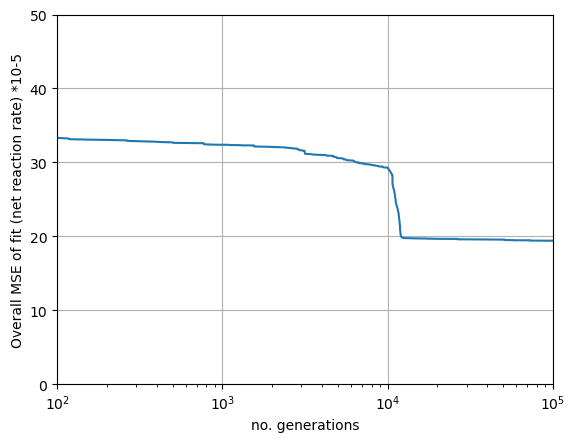

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.56585467788453
1.333528123104638
0.296335348408356
-4.185729455914544
0.49048944157221613
3.098026312408248e-15
0.46241891592436485
-3.9734289367707305
0.22258049681636244
4.372684551437954
3.366676534404808
3.5331829038091898
0.4379365427912806
0.03705254096681701
3.0075065192625234
0.015095455613042244
0.4832788436931794
-11.889616913892732
1.8718670195755436
1.564192963676742
-9.398116238556236
0.9681091415219643
3.37489493514521
0.11762521508937611
3.0240203868429494
2.9428943947030715
1.2911922544334515
7.232421362327163
-9.675369984307197
2.6679709814260164
1.5947469977921855
3.4970207853857644
-5.668136553590108
0.7957913628489747
1.167450416428595
-1.30103


In [37]:
res.X

array([-1.05658547e+01,  1.33352812e+00,  2.96335348e-01, -4.18572946e+00,
        4.90489442e-01,  3.09802631e-15,  4.62418916e-01, -3.97342894e+00,
        2.22580497e-01,  4.37268455e+00,  3.36667653e+00,  3.53318290e+00,
        4.37936543e-01,  3.70525410e-02,  3.00750652e+00,  1.50954556e-02,
        4.83278844e-01, -1.18896169e+01,  1.87186702e+00,  1.56419296e+00,
       -9.39811624e+00,  9.68109142e-01,  3.37489494e+00,  1.17625215e-01,
        3.02402039e+00,  2.94289439e+00,  1.29119225e+00,  7.23242136e+00,
       -9.67536998e+00,  2.66797098e+00,  1.59474700e+00,  3.49702079e+00,
       -5.66813655e+00,  7.95791363e-01,  1.16745042e+00, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.56585467788453
1.6: 1.333528123104638
0.9: 0.296335348408356
-4.3: -4.185729455914544
0.5: 0.49048944157221613
0.003: 3.098026312408248e-15
0.4: 0.46241891592436485
-7.9: -3.9734289367707305
0.7: 0.22258049681636244
7.2: 4.372684551437954
5.7: 3.366676534404808
5.7: 3.5331829038091898
0.8: 0.4379365427912806
0.03: 0.03705254096681701
3.1: 3.0075065192625234
6.000000000000001e-09: 0.015095455613042244
0.1: 0.4832788436931794
-12.0: -11.889616913892732
1.9: 1.8718670195755436
1.6: 1.564192963676742
-11.6: -9.398116238556236
1.2: 0.9681091415219643
4.0: 3.37489493514521
0.01: 0.11762521508937611
4.2: 3.0240203868429494
5.4: 2.9428943947030715
2.2: 1.2911922544334515
11.8: 7.232421362327163
-12.0: -9.675369984307197
3.3: 2.6679709814260164
1.8: 1.5947469977921855
4.2: 3.4970207853857644
-4.0: -5.668136553590108
0.5: 0.7957913628489747
1.0: 1.167450416428595
coeff fit: 0.9229401320242699
r: 0.9606977318721378


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.05658547e+01,  1.33352812e+00,  2.96335348e-01, -4.18572946e+00,
        4.90489442e-01,  3.09802631e-15,  4.62418916e-01, -3.97342894e+00,
        2.22580497e-01,  4.37268455e+00,  3.36667653e+00,  3.53318290e+00,
        4.37936543e-01,  3.70525410e-02,  3.00750652e+00,  1.50954556e-02,
        4.83278844e-01, -1.18896169e+01,  1.87186702e+00,  1.56419296e+00,
       -9.39811624e+00,  9.68109142e-01,  3.37489494e+00,  1.17625215e-01,
        3.02402039e+00,  2.94289439e+00,  1.29119225e+00,  7.23242136e+00,
       -9.67536998e+00,  2.66797098e+00,  1.59474700e+00,  3.49702079e+00,
       -5.66813655e+00,  7.95791363e-01,  1.16745042e+00, -1.30103000e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-8.59849530e+00,  1.06217775e+00,  4.90888821e-01, -4.12891801e+00,
        4.70926267e-01,  9.07058470e-08,  3.95407081e-01, -5.60065511e+00,
        4.49659072e-01,  5.36565690e+00,  3.86275213e+00,  4.09430788e+00,
        5.09673724e-01,  4.69374608e-02,  3.20378854e+00,  1.79947402e-02,
        5.07805699e-01, -1.11892312e+01,  1.74642433e+00,  1.47762273e+00,
       -1.07896283e+01,  1.07612896e+00,  3.73370932e+00,  1.09722907e-01,
        3.91153731e+00,  5.89260462e+00,  5.60925498e-01,  6.26776566e+00,
       -9.16909649e+00,  4.30669658e+00,  6.47171350e+00,  4.51837611e+00,
       -8.38244909e+00,  1.30437913e+00,  1.60318682e+00, -1.30103000e+00]
krseed101 = [-1.17246166e+01,  1.54801719e+00,  7.89447634e-01, -4.33281864e+00,
        5.05347678e-01,  6.23331957e-08,  4.22685721e-01, -8.41696250e+00,
        7.98052076e-01,  6.91777452e+00,  5.07134840e+00,  5.16712455e+00,
        4.02965766e-01,  4.69831956e-02,  3.10485383e+00,  1.92186818e-02,
        5.36968261e-01, -1.19992628e+01,  1.89400875e+00,  1.61232938e+00,
       -1.18538133e+01,  1.20641106e+00,  3.81519535e+00,  3.90826492e-02,
        4.21647530e+00,  3.65782691e+00,  1.18786778e+00,  7.27114259e+00,
       -8.89026015e+00,  2.65585911e+00,  2.14445595e+00,  3.30670058e+00,
       -3.92819133e+00,  4.79271546e-01,  9.89223763e-01, -1.30103000e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9452792158949233
r: 0.9722547073143556
-10.296322199999999
1.3145743533333334
0.5255572676666667
-4.215822036666666
0.48892112899999995
5.1013015266008774e-08
0.42683723933333334
-5.997015516666667
0.49009721500000003
5.552038656666667
4.10025902
4.264871776666666
0.45019201099999995
0.04365773246666666
3.1053829633333336
0.01743629253333333
0.5093509346666667
-11.692703633333332
1.8374333666666667
1.5513816900000001
-10.68051928
1.0835497206666667
3.6412665366666666
0.08881025706666666
3.717344333333333
4.164441973333333
1.0133285093333333
6.923776536666668
-9.244908873333333
3.2101755566666665
3.4036388166666662
3.7740324933333333
-5.992925656666666
0.8598140130000002
1.2532870010000001


In [2]:
meankr

[-10.296322199999999,
 1.3145743533333334,
 0.5255572676666667,
 -4.215822036666666,
 0.48892112899999995,
 5.1013015266008774e-08,
 0.42683723933333334,
 -5.997015516666667,
 0.49009721500000003,
 5.552038656666667,
 4.10025902,
 4.264871776666666,
 0.45019201099999995,
 0.04365773246666666,
 3.1053829633333336,
 0.01743629253333333,
 0.5093509346666667,
 -11.692703633333332,
 1.8374333666666667,
 1.5513816900000001,
 -10.68051928,
 1.0835497206666667,
 3.6412665366666666,
 0.08881025706666666,
 3.717344333333333,
 4.164441973333333,
 1.0133285093333333,
 6.923776536666668,
 -9.244908873333333,
 3.2101755566666665,
 3.4036388166666662,
 3.7740324933333333,
 -5.992925656666666,
 0.8598140130000002,
 1.2532870010000001]

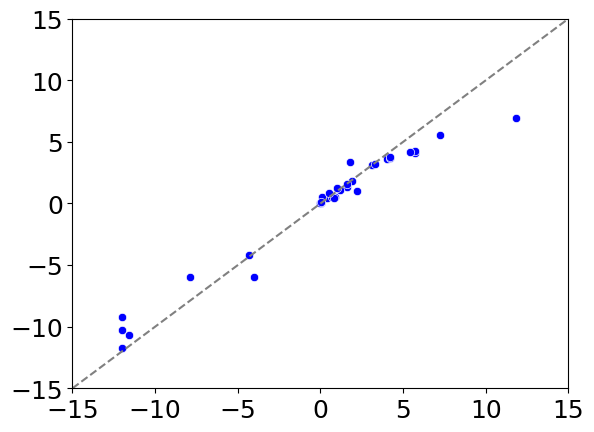

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
